In [1]:
%matplotlib inline

# Fitting TESS FFIs

In [2]:
%run notebook_setup

theano version: 1.0.4


pymc3 version: 3.6


exoplanet version: 0.2.0


This tutorial is nearly identical to the :ref:`tess` tutorial with added support for the TESS full frame images using [tesscut](https://mast.stsci.edu/tesscut/).

First, we query the TESS input catalog for the coordinates and properties of this source:

In [3]:
import numpy as np
from astroquery.mast import Catalogs

ticid = 49899799
tic = Catalogs.query_object("TIC {0}".format(ticid), radius=0.2, catalog="TIC")
star = tic[np.argmin(tic["dstArcSec"])]

tic_mass = float(star["mass"]), float(star["e_mass"])
tic_radius = float(star["rad"]), float(star["e_rad"])

Then we download the data from tesscut.
This is similar to what we did in the :ref:`tess` tutorial, but we need to do some background subtraction because the pipeline doesn't seem to do too well for the official TESS FFIs.

In [4]:
from io import BytesIO
from zipfile import ZipFile

from astropy.io import fits
from astropy.utils.data import download_file

# Download the cutout
url = "https://mast.stsci.edu/tesscut/api/v0.1/astrocut?ra={0[ra]}&dec={0[dec]}&y=15&x=15&units=px&sector=All".format(star)
fn = download_file(url, cache=True)
with ZipFile(fn, "r") as f:
    with fits.open(BytesIO(f.read(f.namelist()[0]))) as hdus:
        tpf = hdus[1].data
        tpf_hdr = hdus[1].header

texp = tpf_hdr["FRAMETIM"] * tpf_hdr["NUM_FRM"]
texp /= 60.0 * 60.0 * 24.0
time = tpf["TIME"]
flux = tpf["FLUX"]
m = np.any(np.isfinite(flux), axis=(1, 2)) & (tpf["QUALITY"] == 0)
ref_time = 0.5 * (np.min(time[m])+np.max(time[m]))
time = np.ascontiguousarray(time[m] - ref_time, dtype=np.float64)
flux = np.ascontiguousarray(flux[m], dtype=np.float64)

# Compute the median image
mean_img = np.median(flux, axis=0)

# Sort the pixels by median brightness
order = np.argsort(mean_img.flatten())[::-1]

# Choose a mask for the background
bkg_mask = np.zeros_like(mean_img, dtype=bool)
bkg_mask[np.unravel_index(order[-100:], mean_img.shape)] = True
flux -= np.median(flux[:, bkg_mask], axis=-1)[:, None, None]

Everything below this line is the same as the :ref:`tess` tutorial.

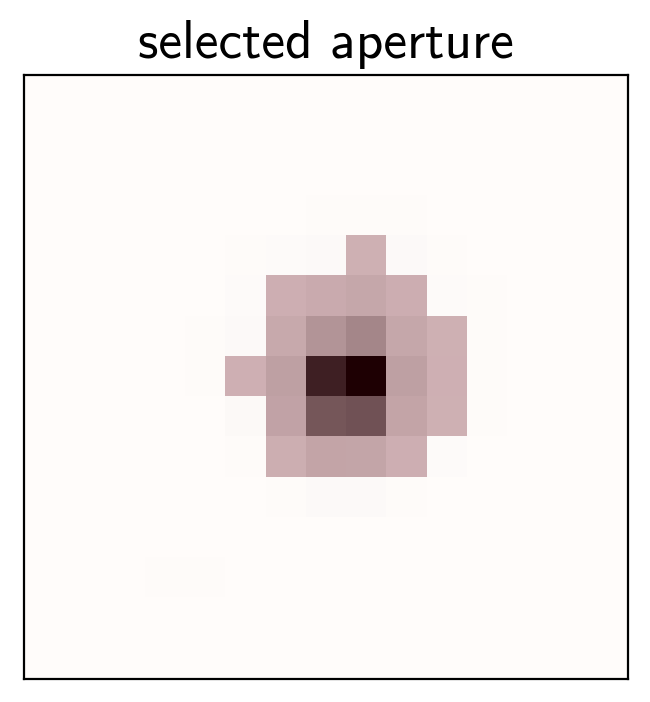

In [5]:
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

# A function to estimate the windowed scatter in a lightcurve
def estimate_scatter_with_mask(mask):
    f = np.sum(flux[:, mask], axis=-1)
    smooth = savgol_filter(f, 1001, polyorder=5)
    return 1e6 * np.sqrt(np.median((f / smooth - 1)**2))

# Loop over pixels ordered by brightness and add them one-by-one
# to the aperture
masks, scatters = [], []
for i in range(1, 100):
    msk = np.zeros_like(mean_img, dtype=bool)
    msk[np.unravel_index(order[:i], mean_img.shape)] = True
    scatter = estimate_scatter_with_mask(msk)
    masks.append(msk)
    scatters.append(scatter)

# Choose the aperture that minimizes the scatter
pix_mask = masks[np.argmin(scatters)]

# Plot the selected aperture
plt.imshow(mean_img.T, cmap="gray_r")
plt.imshow(pix_mask.T, cmap="Reds", alpha=0.3)
plt.title("selected aperture")
plt.xticks([])
plt.yticks([]);

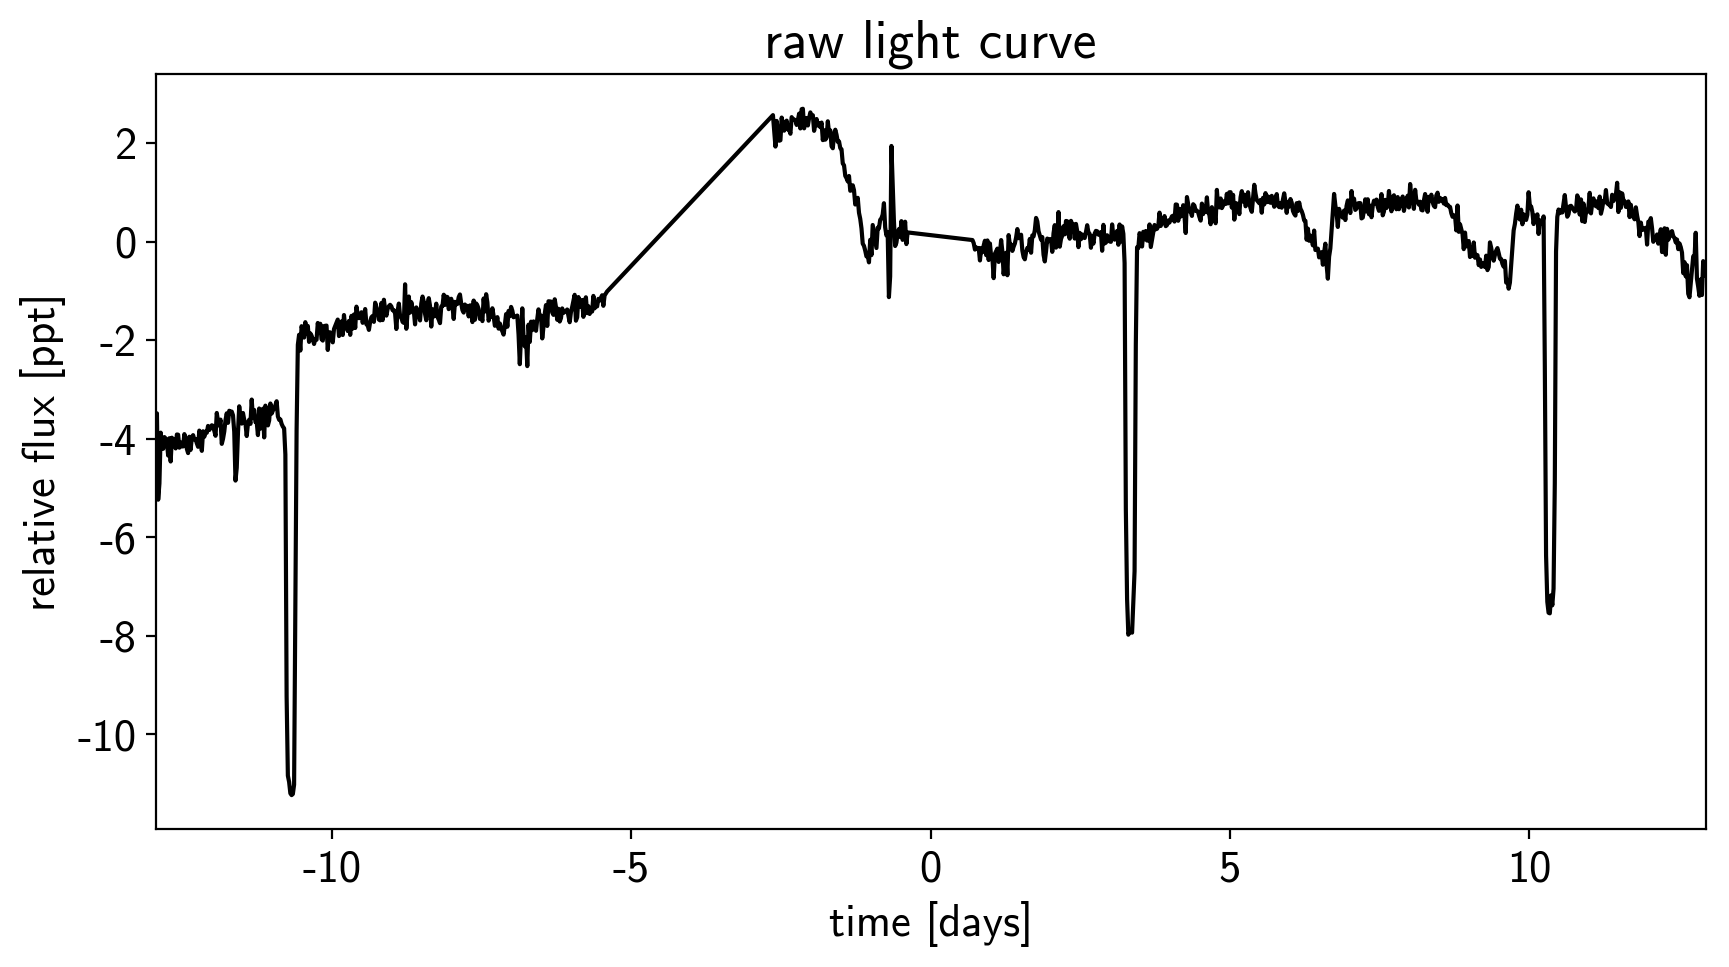

In [6]:
plt.figure(figsize=(10, 5))
sap_flux = np.sum(flux[:, pix_mask], axis=-1)
sap_flux = (sap_flux / np.median(sap_flux) - 1) * 1e3
plt.plot(time, sap_flux, "k")
plt.xlabel("time [days]")
plt.ylabel("relative flux [ppt]")
plt.title("raw light curve")
plt.xlim(time.min(), time.max());

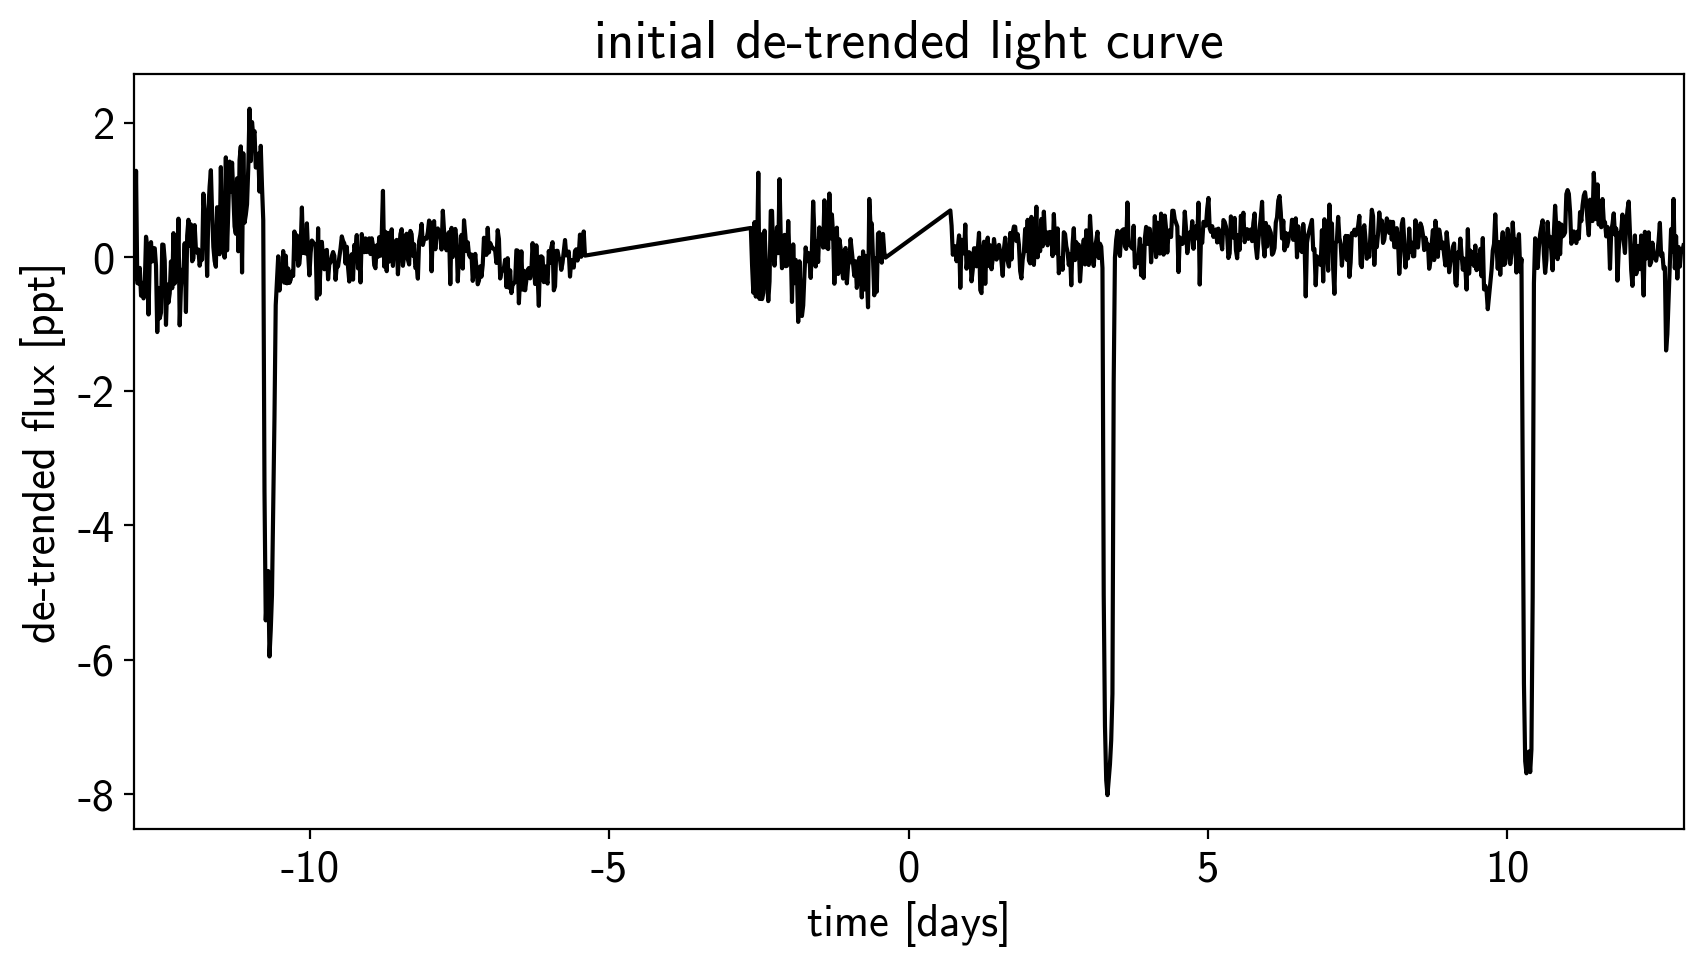

In [7]:
# Build the first order PLD basis
X_pld = np.reshape(flux[:, pix_mask], (len(flux), -1))
X_pld = X_pld / np.sum(flux[:, pix_mask], axis=-1)[:, None]

# Build the second order PLD basis and run PCA to reduce the number of dimensions
X2_pld = np.reshape(X_pld[:, None, :] * X_pld[:, :, None], (len(flux), -1))
U, _, _ = np.linalg.svd(X2_pld, full_matrices=False)
X2_pld = U[:, :X_pld.shape[1]]

# Construct the design matrix and fit for the PLD model
X_pld = np.concatenate((np.ones((len(flux), 1)), X_pld, X2_pld), axis=-1)
XTX = np.dot(X_pld.T, X_pld)
w_pld = np.linalg.solve(XTX, np.dot(X_pld.T, sap_flux))
pld_flux = np.dot(X_pld, w_pld)

# Plot the de-trended light curve
plt.figure(figsize=(10, 5))
plt.plot(time, sap_flux-pld_flux, "k")
plt.xlabel("time [days]")
plt.ylabel("de-trended flux [ppt]")
plt.title("initial de-trended light curve")
plt.xlim(time.min(), time.max());

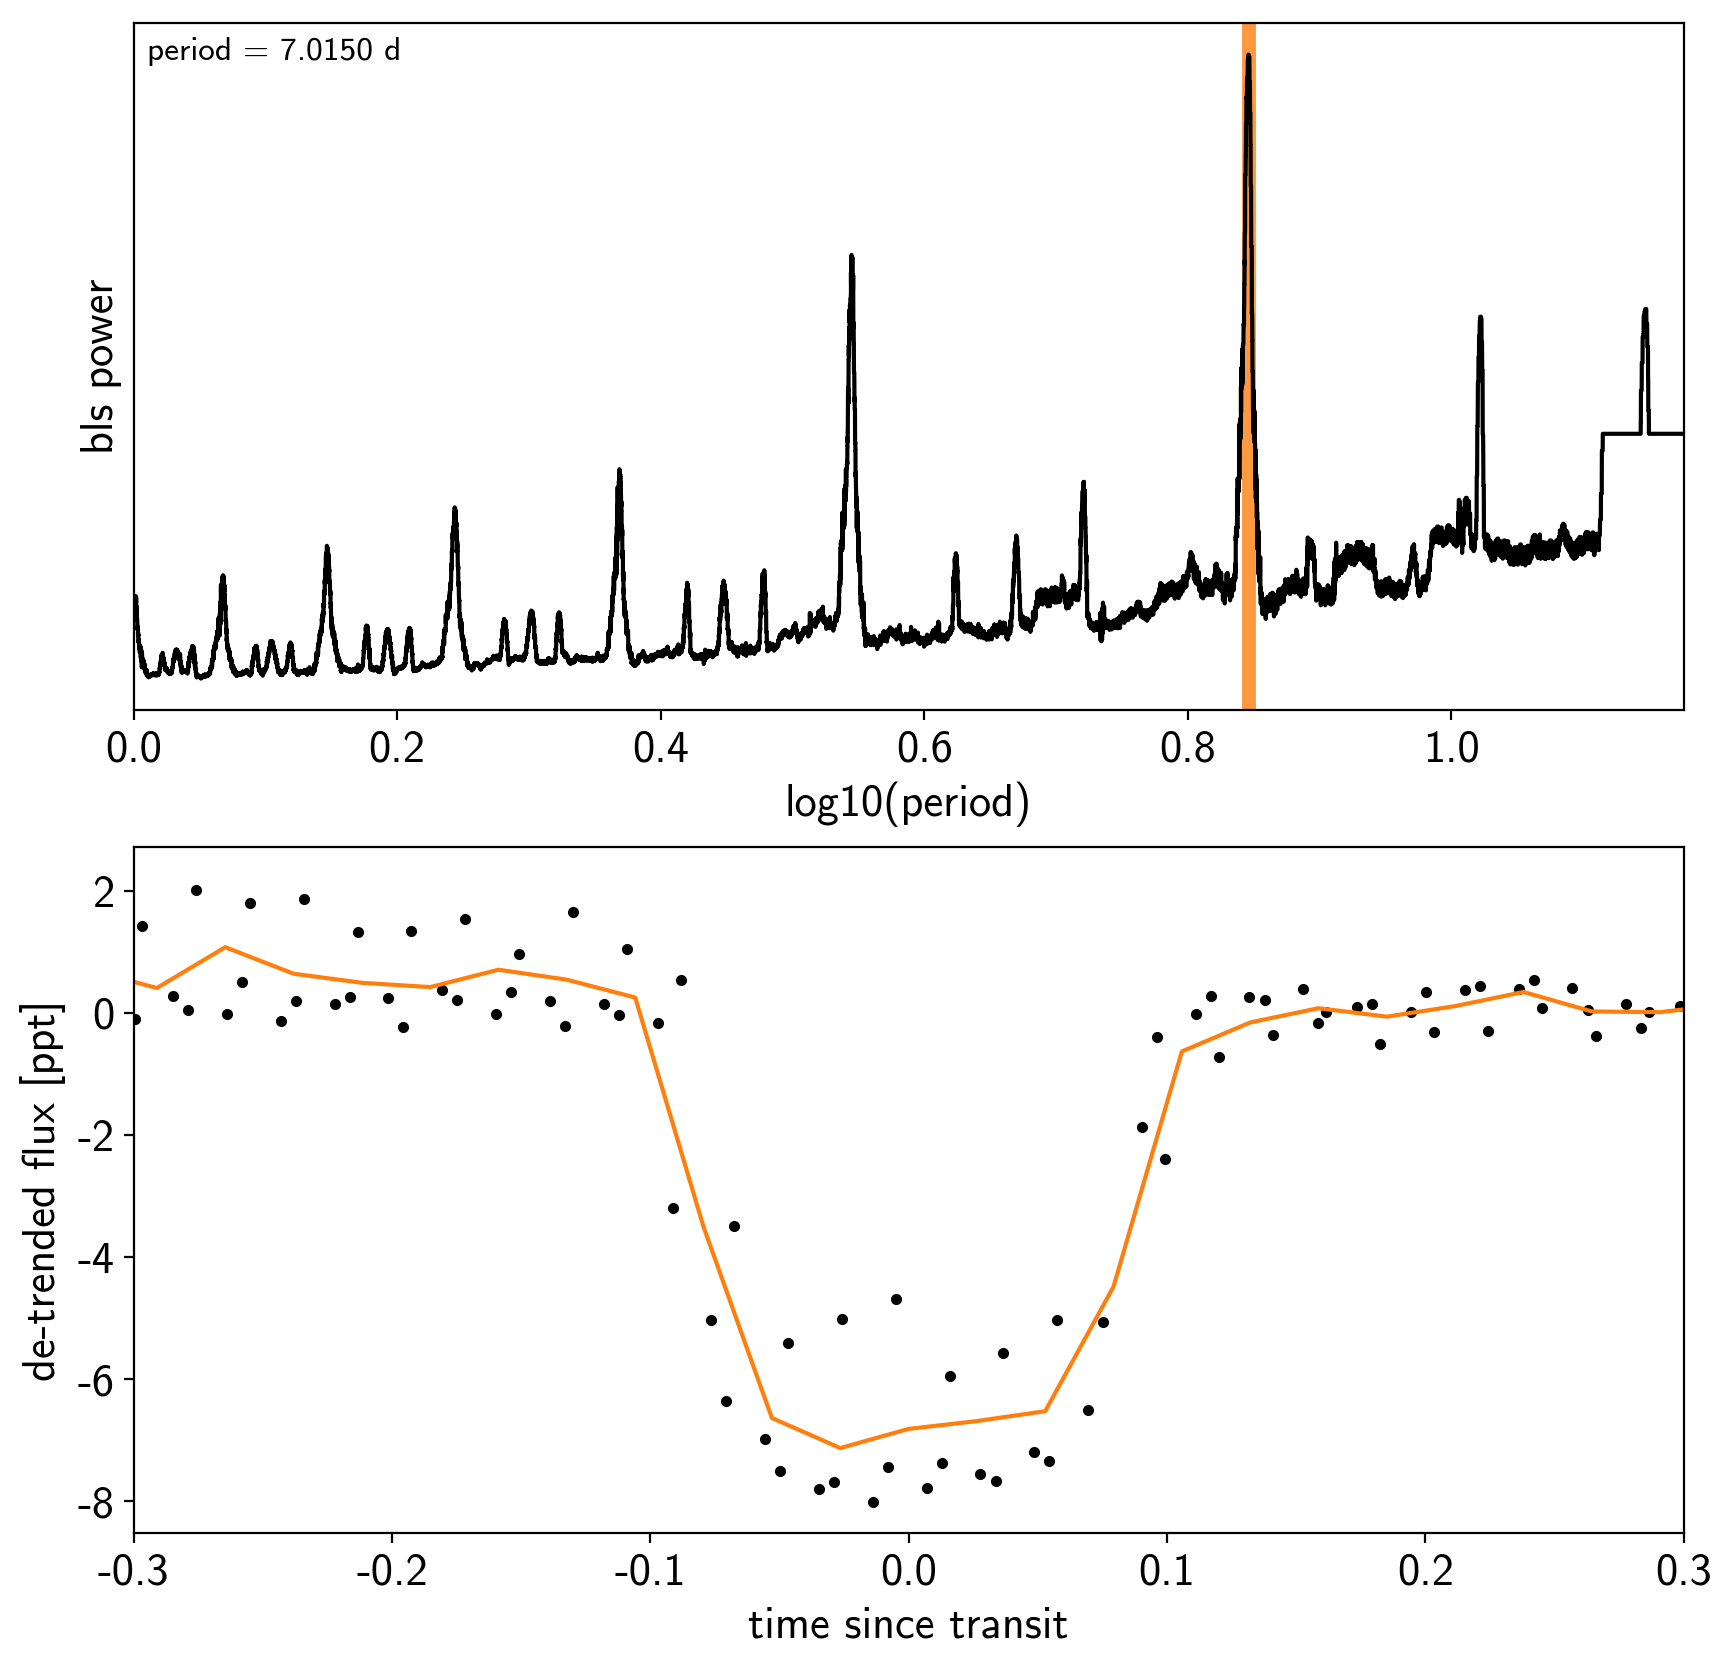

In [8]:
from astropy.stats import BoxLeastSquares

period_grid = np.exp(np.linspace(np.log(1), np.log(15), 50000))

bls = BoxLeastSquares(time, sap_flux - pld_flux)
bls_power = bls.power(period_grid, 0.1, oversample=20)

# Save the highest peak as the planet candidate
index = np.argmax(bls_power.power)
bls_period = bls_power.period[index]
bls_t0 = bls_power.transit_time[index]
bls_depth = bls_power.depth[index]
transit_mask = bls.transit_mask(time, bls_period, 0.2, bls_t0)

fig, axes = plt.subplots(2, 1, figsize=(10, 10))

# Plot the periodogram
ax = axes[0]
ax.axvline(np.log10(bls_period), color="C1", lw=5, alpha=0.8)
ax.plot(np.log10(bls_power.period), bls_power.power, "k")
ax.annotate("period = {0:.4f} d".format(bls_period),
            (0, 1), xycoords="axes fraction",
            xytext=(5, -5), textcoords="offset points",
            va="top", ha="left", fontsize=12)
ax.set_ylabel("bls power")
ax.set_yticks([])
ax.set_xlim(np.log10(period_grid.min()), np.log10(period_grid.max()))
ax.set_xlabel("log10(period)")

# Plot the folded transit
ax = axes[1]
x_fold = (time - bls_t0 + 0.5*bls_period)%bls_period - 0.5*bls_period
m = np.abs(x_fold) < 0.4
ax.plot(x_fold[m], sap_flux[m] - pld_flux[m], ".k")

# Overplot the phase binned light curve
bins = np.linspace(-0.41, 0.41, 32)
denom, _ = np.histogram(x_fold, bins)
num, _ = np.histogram(x_fold, bins, weights=sap_flux - pld_flux)
denom[num == 0] = 1.0
ax.plot(0.5*(bins[1:] + bins[:-1]), num / denom, color="C1")

ax.set_xlim(-0.3, 0.3)
ax.set_ylabel("de-trended flux [ppt]")
ax.set_xlabel("time since transit");

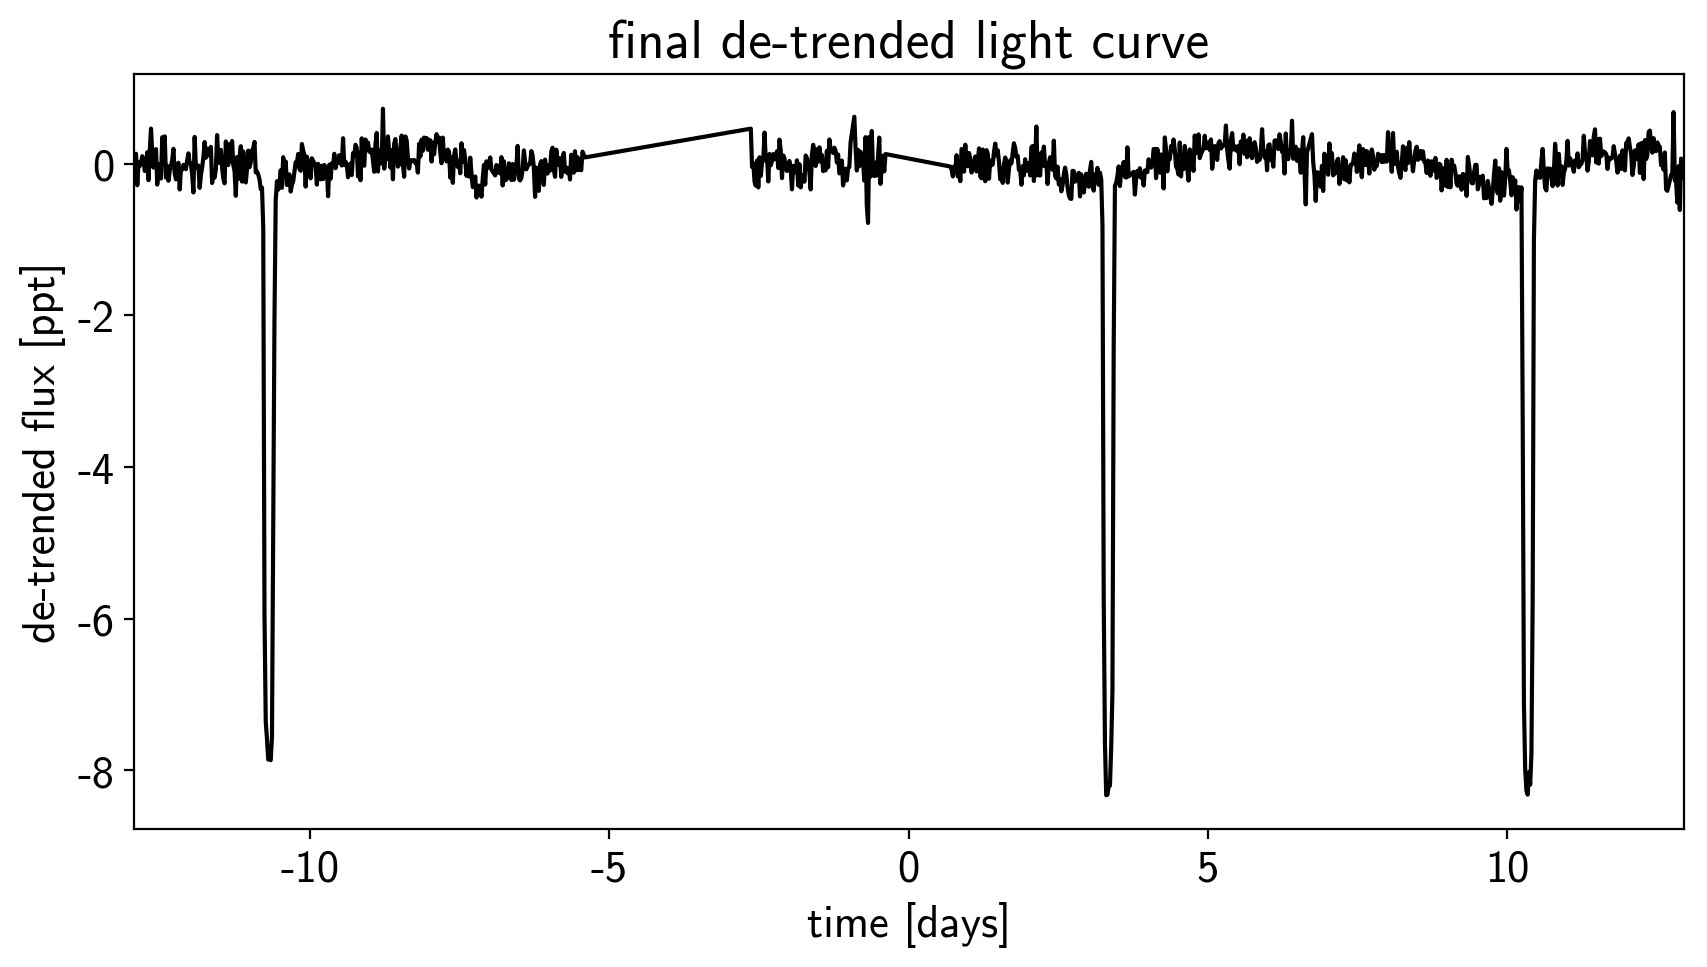

In [9]:
m = ~transit_mask
XTX = np.dot(X_pld[m].T, X_pld[m])
w_pld = np.linalg.solve(XTX, np.dot(X_pld[m].T, sap_flux[m]))
pld_flux = np.dot(X_pld, w_pld)

x = np.ascontiguousarray(time, dtype=np.float64)
y = np.ascontiguousarray(sap_flux-pld_flux, dtype=np.float64)

plt.figure(figsize=(10, 5))
plt.plot(time, y, "k")
plt.xlabel("time [days]")
plt.ylabel("de-trended flux [ppt]")
plt.title("final de-trended light curve")
plt.xlim(time.min(), time.max());

In [10]:
import exoplanet as xo
import pymc3 as pm
import theano.tensor as tt

def build_model(mask=None, start=None):
    if mask is None:
        mask = np.ones(len(x), dtype=bool)
    with pm.Model() as model:

        # Parameters for the stellar properties
        mean = pm.Normal("mean", mu=0.0, sd=10.0)
        u_star = xo.distributions.QuadLimbDark("u_star")
        
        # Stellar parameters from TIC
        M_star_huang = 1.094, 0.039
        R_star_huang = 1.10, 0.023
        m_star = pm.Normal("m_star", mu=tic_mass[0], sd=tic_mass[1])
        r_star = pm.Normal("r_star", mu=tic_radius[0], sd=tic_radius[1])

        # Prior to require physical parameters
        pm.Potential("m_star_prior", tt.switch(m_star > 0, 0, -np.inf))
        pm.Potential("r_star_prior", tt.switch(r_star > 0, 0, -np.inf))

        # Orbital parameters for the planets
        logP = pm.Normal("logP", mu=np.log(bls_period), sd=1)
        t0 = pm.Normal("t0", mu=bls_t0, sd=1)
        b = pm.Uniform("b", lower=0, upper=1, testval=0.5)
        logr = pm.Normal("logr", sd=1.0,
                         mu=0.5*np.log(1e-3*np.array(bls_depth))+np.log(tic_radius[0]))
        r_pl = pm.Deterministic("r_pl", tt.exp(logr))
        ror = pm.Deterministic("ror", r_pl / r_star)
        
        # This is the eccentricity prior from Kipping (2013):
        # https://arxiv.org/abs/1306.4982
        ecc = pm.Beta("ecc", alpha=0.867, beta=3.03, testval=0.1)
        omega = xo.distributions.Angle("omega")

        # Transit jitter & GP parameters
        logs2 = pm.Normal("logs2", mu=np.log(np.var(y[mask])), sd=10)
        logw0_guess = np.log(2*np.pi/10)
        logw0 = pm.Normal("logw0", mu=logw0_guess, sd=10)
        
        # We'll parameterize using the maximum power (S_0 * w_0^4) instead of
        # S_0 directly because this removes some of the degeneracies between
        # S_0 and omega_0
        logpower = pm.Normal("logpower",
                             mu=np.log(np.var(y[mask]))+4*logw0_guess,
                             sd=10)
        logS0 = pm.Deterministic("logS0", logpower - 4 * logw0)

        # Tracking planet parameters
        period = pm.Deterministic("period", tt.exp(logP))

        # Orbit model
        orbit = xo.orbits.KeplerianOrbit(
            r_star=r_star, m_star=m_star,
            period=period, t0=t0, b=b,
            ecc=ecc, omega=omega)
        pm.Deterministic("a", orbit.a_planet)
        pm.Deterministic("incl", orbit.incl)

        # Compute the model light curve using starry
        light_curves = xo.StarryLightCurve(u_star).get_light_curve(
            orbit=orbit, r=r_pl, t=x[mask], texp=texp)*1e3
        light_curve = pm.math.sum(light_curves, axis=-1) + mean
        pm.Deterministic("light_curves", light_curves)

        # GP model for the light curve
        kernel = xo.gp.terms.SHOTerm(log_S0=logS0, log_w0=logw0, Q=1/np.sqrt(2))
        gp = xo.gp.GP(kernel, x[mask], tt.exp(logs2) + tt.zeros(mask.sum()), J=2)
        pm.Potential("transit_obs", gp.log_likelihood(y[mask] - light_curve))
        pm.Deterministic("gp_pred", gp.predict())

        # Fit for the maximum a posteriori parameters, I've found that I can get
        # a better solution by trying different combinations of parameters in turn
        if start is None:
            start = model.test_point
        map_soln = xo.optimize(start=start, vars=[b])
        map_soln = xo.optimize(start=map_soln, vars=[logs2, logpower, logw0])
        map_soln = xo.optimize(start=map_soln, vars=[logr])
        map_soln = xo.optimize(start=map_soln)

    return model, map_soln

model0, map_soln0 = build_model()

optimizing logp for variables: ['b_interval__']


message: Optimization terminated successfully.
logp: -1181.835562963347 -> -1165.2287368771367


optimizing logp for variables: ['logw0', 'logpower', 'logs2']


message: Optimization terminated successfully.
logp: -1165.2287368771365 -> 83.75777489523378


optimizing logp for variables: ['logr']


message: Optimization terminated successfully.
logp: 83.75777489523378 -> 118.92458572614953


optimizing logp for variables: ['logpower', 'logw0', 'logs2', 'omega_angle__', 'ecc_logodds__', 'logr', 'b_interval__', 't0', 'logP', 'r_star', 'm_star', 'u_star_quadlimbdark__', 'mean']


message: Desired error not necessarily achieved due to precision loss.
logp: 118.92458572614726 -> 344.380543508556


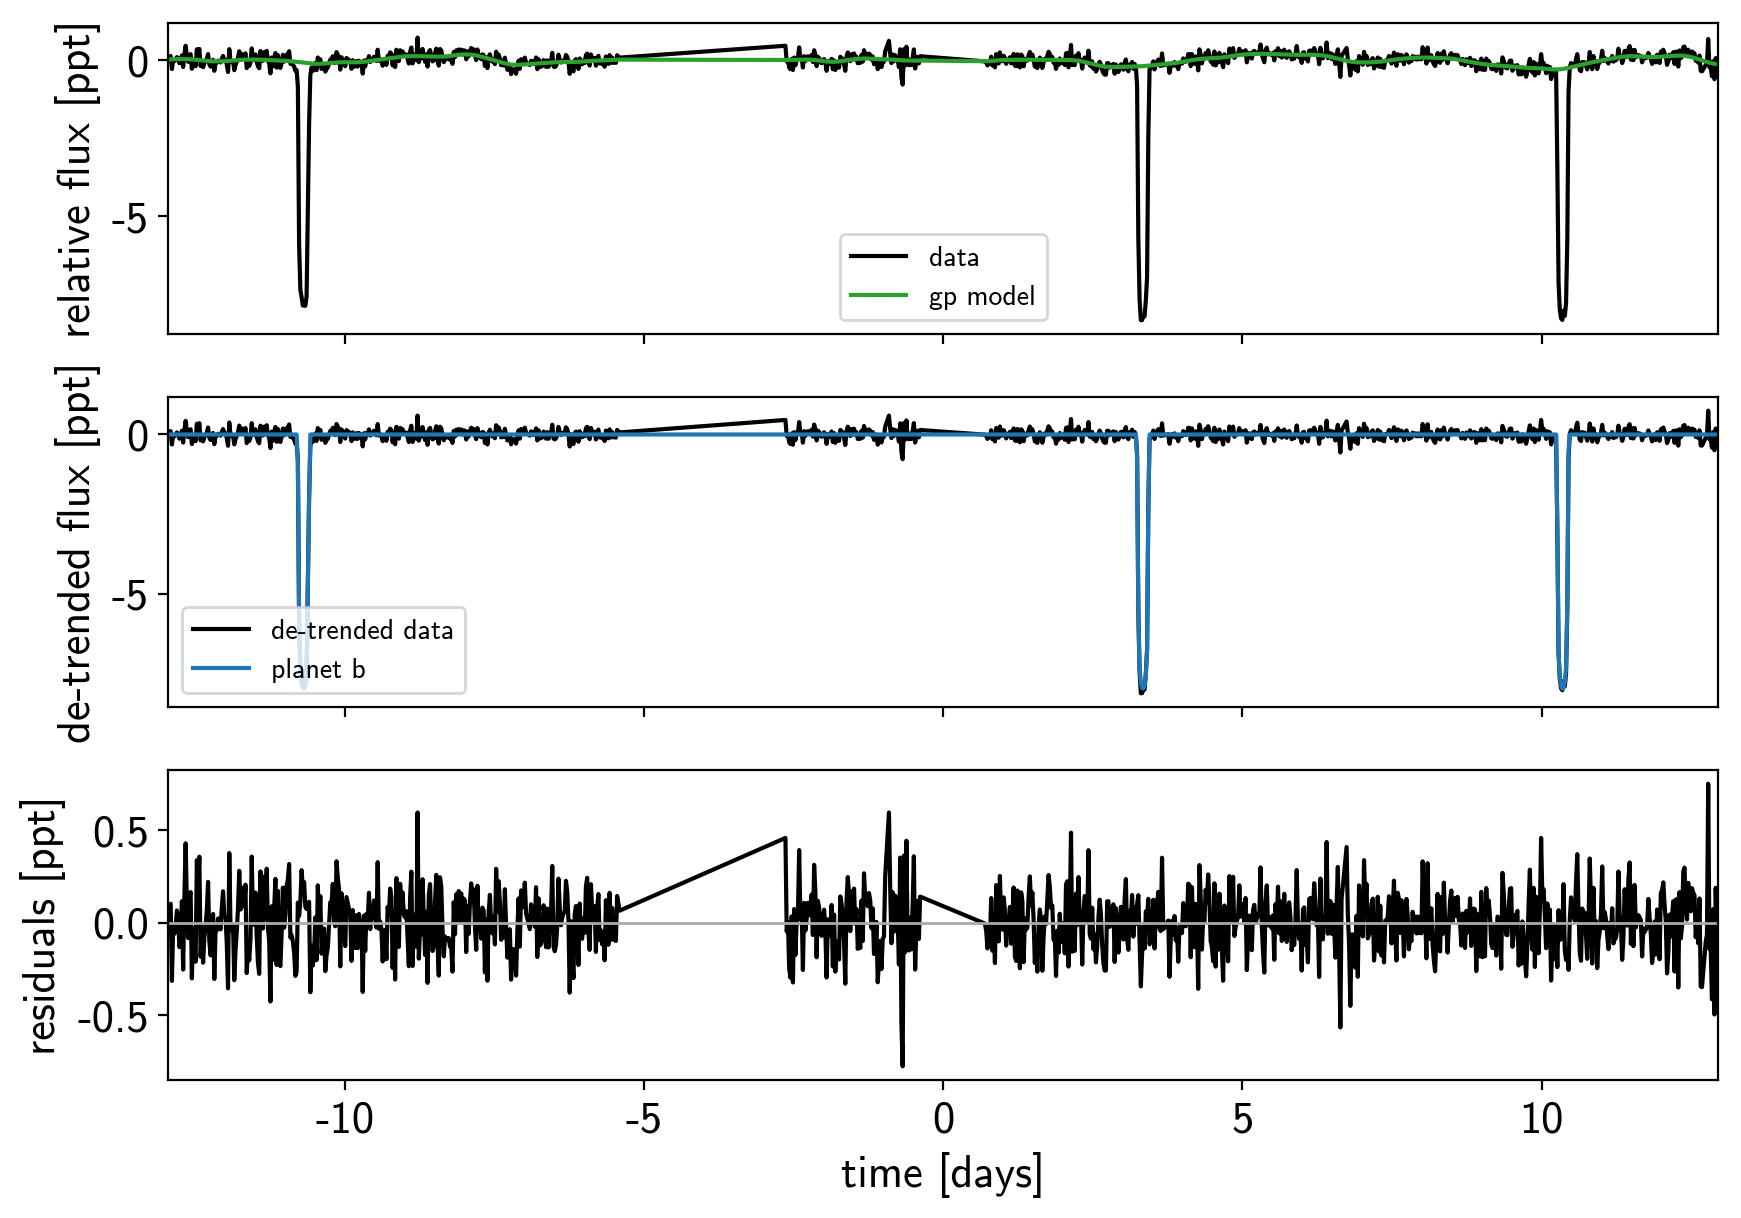

In [11]:
def plot_light_curve(soln, mask=None):
    if mask is None:
        mask = np.ones(len(x), dtype=bool)

    fig, axes = plt.subplots(3, 1, figsize=(10, 7), sharex=True)

    ax = axes[0]
    ax.plot(x[mask], y[mask], "k", label="data")
    gp_mod = soln["gp_pred"] + soln["mean"]
    ax.plot(x[mask], gp_mod, color="C2", label="gp model")
    ax.legend(fontsize=10)
    ax.set_ylabel("relative flux [ppt]")

    ax = axes[1]
    ax.plot(x[mask], y[mask] - gp_mod, "k", label="de-trended data")
    for i, l in enumerate("b"):
        mod = soln["light_curves"][:, i]
        ax.plot(x[mask], mod, label="planet {0}".format(l))
    ax.legend(fontsize=10, loc=3)
    ax.set_ylabel("de-trended flux [ppt]")

    ax = axes[2]
    mod = gp_mod + np.sum(soln["light_curves"], axis=-1)
    ax.plot(x[mask], y[mask] - mod, "k")
    ax.axhline(0, color="#aaaaaa", lw=1)
    ax.set_ylabel("residuals [ppt]")
    ax.set_xlim(x[mask].min(), x[mask].max())
    ax.set_xlabel("time [days]")
    
    return fig
    
plot_light_curve(map_soln0);

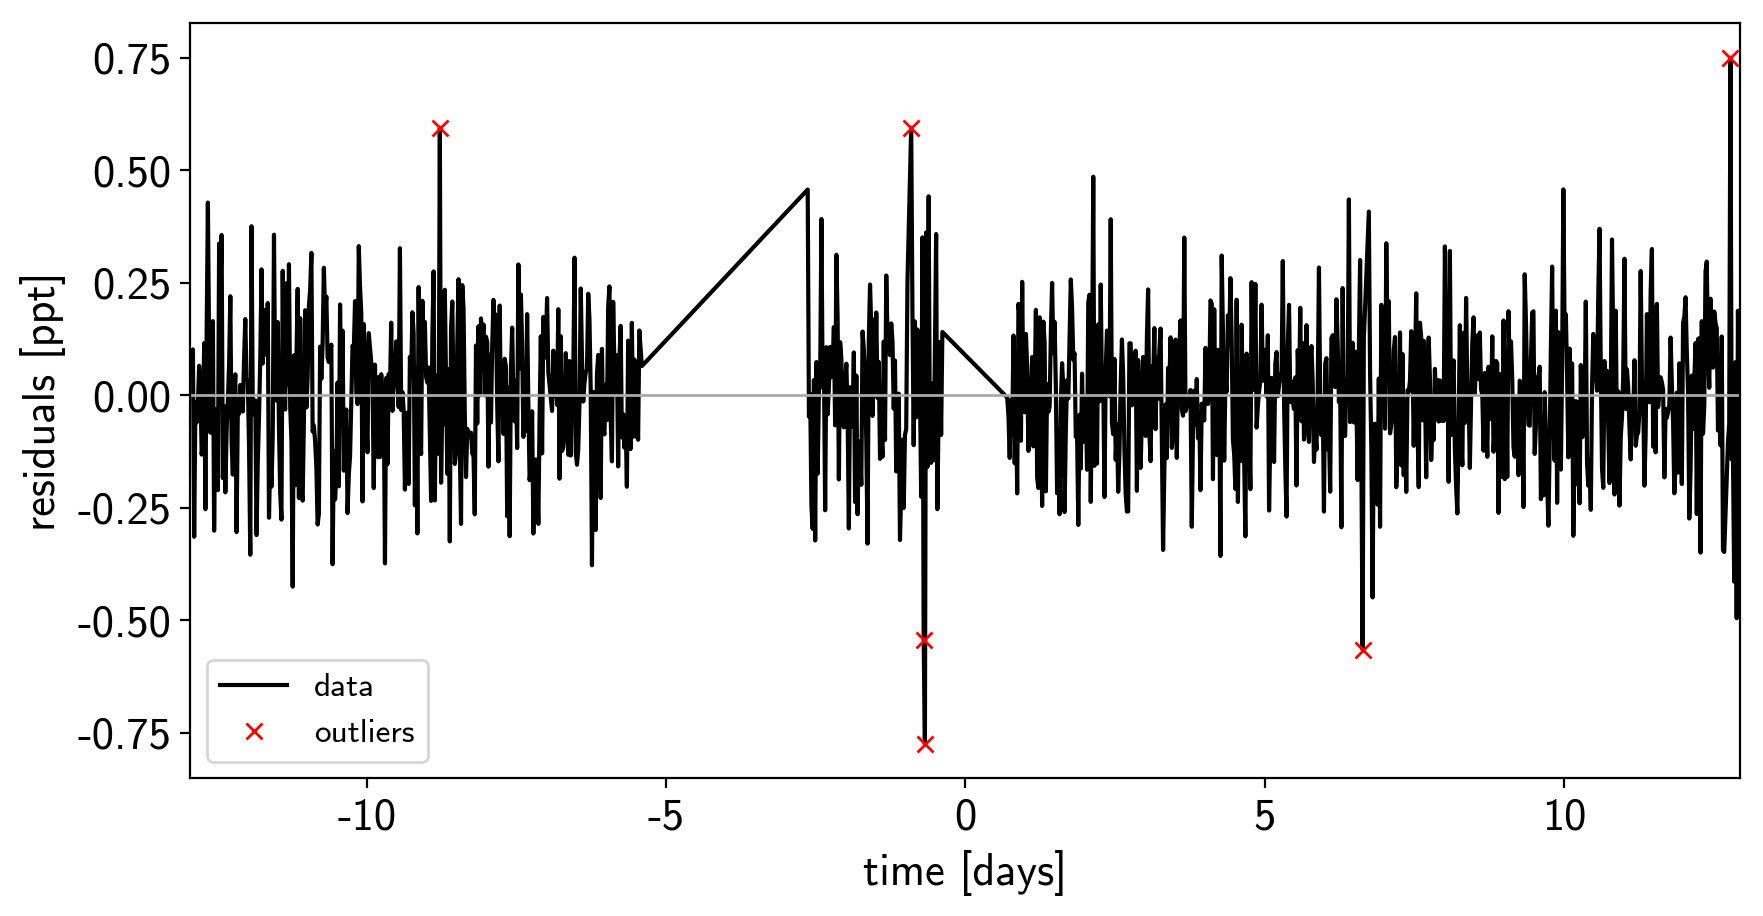

In [12]:
mod = map_soln0["gp_pred"] + map_soln0["mean"] + np.sum(map_soln0["light_curves"], axis=-1)
resid = y - mod
rms = np.sqrt(np.median(resid**2))
mask = np.abs(resid) < 5 * rms

plt.figure(figsize=(10, 5))
plt.plot(x, resid, "k", label="data")
plt.plot(x[~mask], resid[~mask], "xr", label="outliers")
plt.axhline(0, color="#aaaaaa", lw=1)
plt.ylabel("residuals [ppt]")
plt.xlabel("time [days]")
plt.legend(fontsize=12, loc=3)
plt.xlim(x.min(), x.max());

optimizing logp for variables: ['b_interval__']


message: Optimization terminated successfully.
logp: 386.78260189971104 -> 386.78260190097404


optimizing logp for variables: ['logw0', 'logpower', 'logs2']


message: Optimization terminated successfully.
logp: 386.78260190097404 -> 389.66380259552824


optimizing logp for variables: ['logr']


message: Optimization terminated successfully.
logp: 389.66380259552824 -> 389.68441485520594


optimizing logp for variables: ['logpower', 'logw0', 'logs2', 'omega_angle__', 'ecc_logodds__', 'logr', 'b_interval__', 't0', 'logP', 'r_star', 'm_star', 'u_star_quadlimbdark__', 'mean']


message: Desired error not necessarily achieved due to precision loss.
logp: 389.6844148552066 -> 389.694892732503


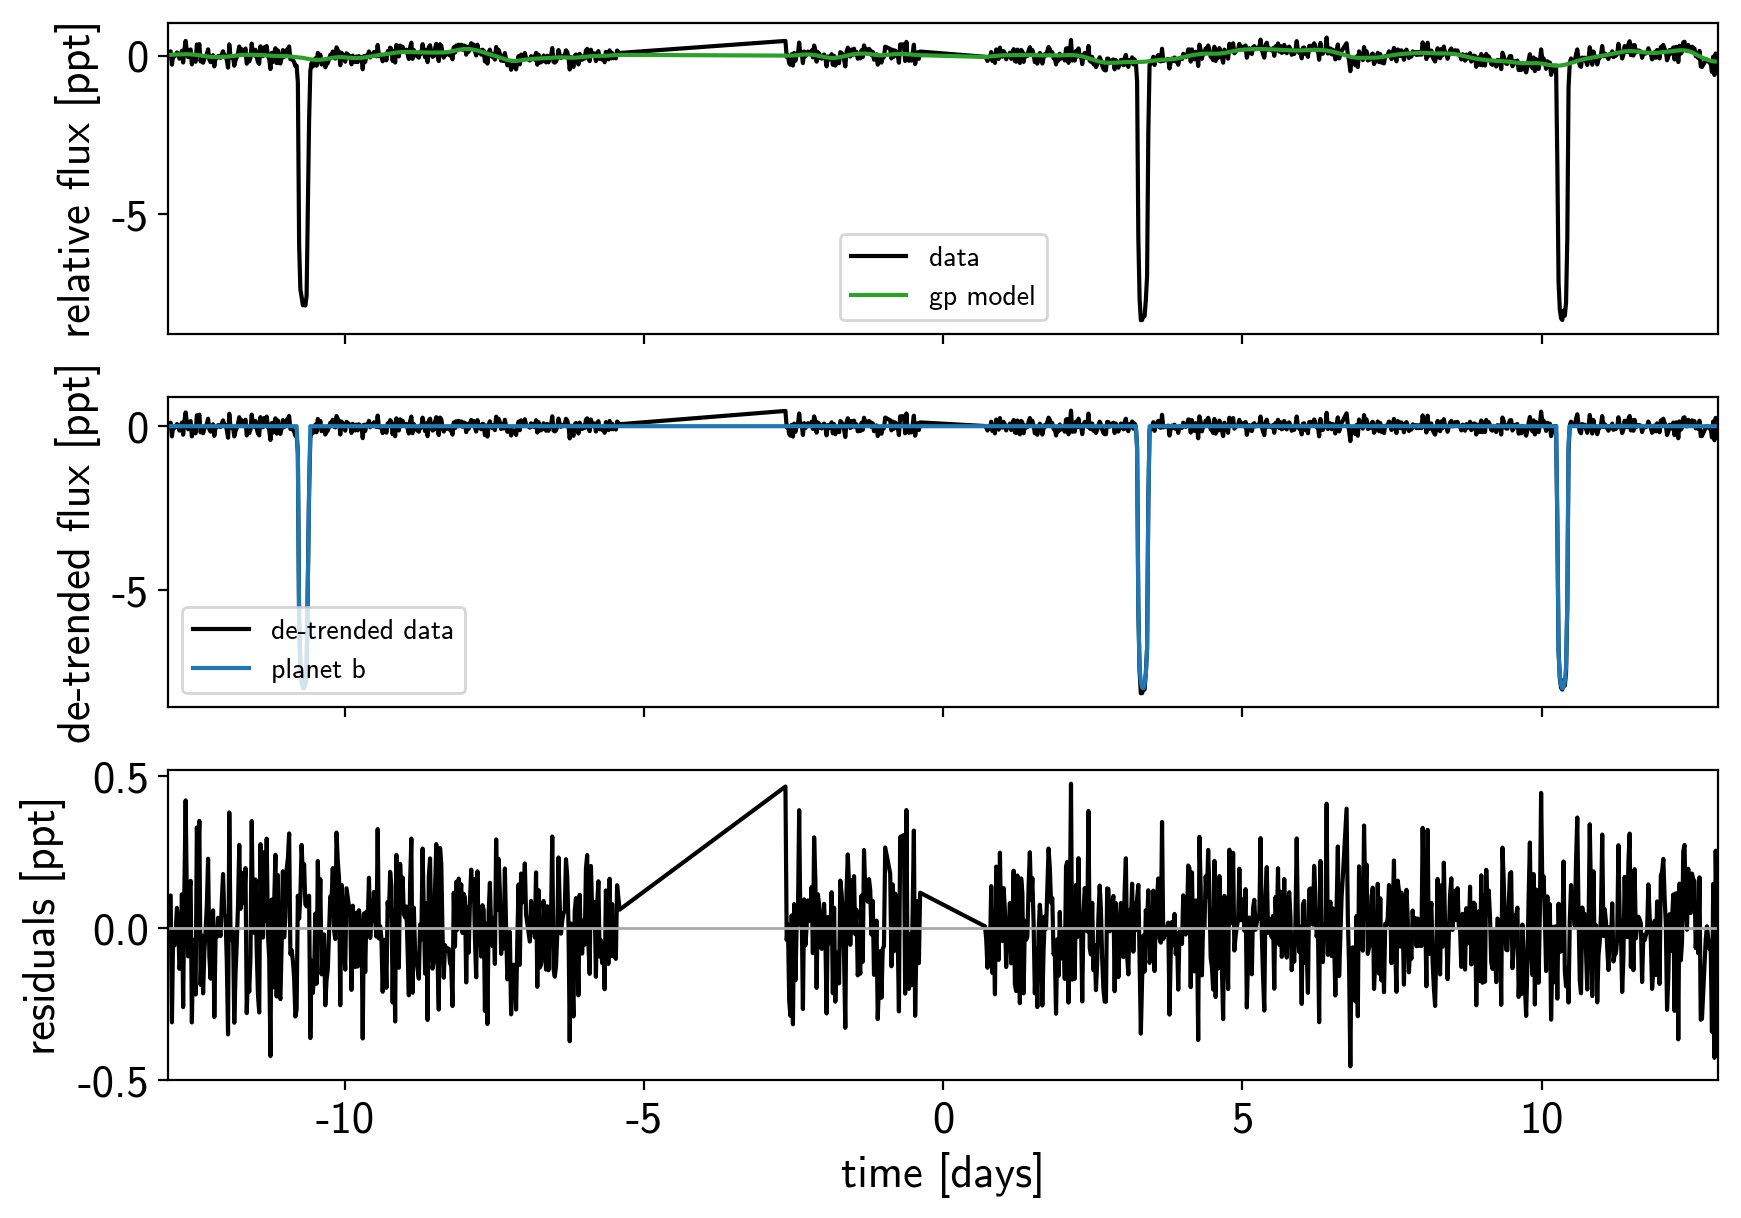

In [13]:
model, map_soln = build_model(mask, map_soln0)
plot_light_curve(map_soln, mask);

In [14]:
np.random.seed(12345)
sampler = xo.PyMC3Sampler(window=100, start=300, finish=500)
with model:
    burnin = sampler.tune(tune=3500, start=map_soln,
                          step_kwargs=dict(target_accept=0.9),
                          chains=4)

Sampling 4 chains:   0%|          | 0/1208 [00:00<?, ?draws/s]

Sampling 4 chains:   1%|▏         | 18/1208 [00:00<00:20, 57.92draws/s]

Sampling 4 chains:   2%|▏         | 22/1208 [00:00<00:37, 31.21draws/s]

Sampling 4 chains:   2%|▏         | 26/1208 [00:00<00:51, 23.15draws/s]

Sampling 4 chains:   2%|▏         | 30/1208 [00:01<00:59, 19.64draws/s]

Sampling 4 chains:   3%|▎         | 33/1208 [00:01<00:54, 21.41draws/s]

Sampling 4 chains:   3%|▎         | 35/1208 [00:01<01:05, 17.80draws/s]

Sampling 4 chains:   3%|▎         | 37/1208 [00:01<01:07, 17.36draws/s]

Sampling 4 chains:   3%|▎         | 39/1208 [00:01<01:12, 16.07draws/s]

Sampling 4 chains:   3%|▎         | 41/1208 [00:01<01:14, 15.75draws/s]

Sampling 4 chains:   4%|▎         | 43/1208 [00:01<01:15, 15.48draws/s]

Sampling 4 chains:   4%|▎         | 45/1208 [00:02<01:17, 14.97draws/s]

Sampling 4 chains:   4%|▍         | 47/1208 [00:02<01:16, 15.19draws/s]

Sampling 4 chains:   4%|▍         | 49/1208 [00:02<01:20, 14.37draws/s]

Sampling 4 chains:   4%|▍         | 51/1208 [00:02<01:15, 15.30draws/s]

Sampling 4 chains:   4%|▍         | 53/1208 [00:02<01:23, 13.87draws/s]

Sampling 4 chains:   5%|▍         | 56/1208 [00:02<01:11, 16.11draws/s]

Sampling 4 chains:   5%|▍         | 58/1208 [00:02<01:30, 12.71draws/s]

Sampling 4 chains:   5%|▌         | 61/1208 [00:03<01:27, 13.09draws/s]

Sampling 4 chains:   6%|▌         | 67/1208 [00:03<01:16, 14.83draws/s]

Sampling 4 chains:   6%|▌         | 71/1208 [00:03<01:17, 14.69draws/s]

Sampling 4 chains:   6%|▋         | 76/1208 [00:04<01:14, 15.28draws/s]

Sampling 4 chains:   7%|▋         | 80/1208 [00:04<01:13, 15.26draws/s]

Sampling 4 chains:   7%|▋         | 84/1208 [00:04<01:13, 15.24draws/s]

Sampling 4 chains:   7%|▋         | 88/1208 [00:04<01:14, 15.07draws/s]

Sampling 4 chains:   8%|▊         | 92/1208 [00:05<01:13, 15.10draws/s]

Sampling 4 chains:   8%|▊         | 96/1208 [00:05<01:13, 15.13draws/s]

Sampling 4 chains:   8%|▊         | 101/1208 [00:05<01:09, 15.97draws/s]

Sampling 4 chains:   9%|▊         | 105/1208 [00:05<01:12, 15.15draws/s]

Sampling 4 chains:   9%|▉         | 108/1208 [00:06<01:02, 17.49draws/s]

Sampling 4 chains:   9%|▉         | 110/1208 [00:06<01:15, 14.56draws/s]

Sampling 4 chains:   9%|▉         | 113/1208 [00:06<01:17, 14.20draws/s]

Sampling 4 chains:  10%|▉         | 115/1208 [00:06<01:13, 14.89draws/s]

Sampling 4 chains:  10%|▉         | 117/1208 [00:06<01:14, 14.60draws/s]

Sampling 4 chains:  10%|▉         | 119/1208 [00:06<01:15, 14.39draws/s]

Sampling 4 chains:  10%|█         | 122/1208 [00:07<01:07, 16.06draws/s]

Sampling 4 chains:  10%|█         | 124/1208 [00:07<01:11, 15.12draws/s]

Sampling 4 chains:  10%|█         | 126/1208 [00:07<01:08, 15.84draws/s]

Sampling 4 chains:  11%|█         | 128/1208 [00:07<01:12, 14.82draws/s]

Sampling 4 chains:  11%|█         | 130/1208 [00:07<01:08, 15.81draws/s]

Sampling 4 chains:  11%|█         | 132/1208 [00:07<01:13, 14.62draws/s]

Sampling 4 chains:  11%|█         | 134/1208 [00:07<01:07, 15.84draws/s]

Sampling 4 chains:  11%|█▏        | 136/1208 [00:07<01:15, 14.28draws/s]

Sampling 4 chains:  12%|█▏        | 139/1208 [00:08<01:09, 15.44draws/s]

Sampling 4 chains:  12%|█▏        | 141/1208 [00:08<01:19, 13.39draws/s]

Sampling 4 chains:  12%|█▏        | 144/1208 [00:08<01:17, 13.65draws/s]

Sampling 4 chains:  12%|█▏        | 147/1208 [00:08<01:07, 15.63draws/s]

Sampling 4 chains:  12%|█▏        | 149/1208 [00:08<01:18, 13.55draws/s]

Sampling 4 chains:  13%|█▎        | 152/1208 [00:09<01:17, 13.65draws/s]

Sampling 4 chains:  13%|█▎        | 156/1208 [00:09<01:03, 16.53draws/s]

Sampling 4 chains:  13%|█▎        | 159/1208 [00:09<01:11, 14.72draws/s]

Sampling 4 chains:  13%|█▎        | 161/1208 [00:09<01:14, 14.01draws/s]

Sampling 4 chains:  13%|█▎        | 163/1208 [00:09<01:10, 14.73draws/s]

Sampling 4 chains:  14%|█▎        | 165/1208 [00:09<01:15, 13.83draws/s]

Sampling 4 chains:  14%|█▍        | 167/1208 [00:10<01:09, 14.90draws/s]

Sampling 4 chains:  14%|█▍        | 169/1208 [00:10<01:15, 13.71draws/s]

Sampling 4 chains:  14%|█▍        | 171/1208 [00:10<01:09, 14.85draws/s]

Sampling 4 chains:  14%|█▍        | 173/1208 [00:10<01:13, 14.10draws/s]

Sampling 4 chains:  14%|█▍        | 175/1208 [00:10<01:09, 14.77draws/s]

Sampling 4 chains:  15%|█▍        | 177/1208 [00:10<01:11, 14.40draws/s]

Sampling 4 chains:  15%|█▍        | 179/1208 [00:10<01:10, 14.62draws/s]

Sampling 4 chains:  15%|█▍        | 181/1208 [00:10<01:09, 14.83draws/s]

Sampling 4 chains:  15%|█▌        | 183/1208 [00:11<01:11, 14.42draws/s]

Sampling 4 chains:  15%|█▌        | 185/1208 [00:11<01:07, 15.22draws/s]

Sampling 4 chains:  16%|█▌        | 188/1208 [00:11<01:04, 15.92draws/s]

Sampling 4 chains:  16%|█▌        | 191/1208 [00:11<00:59, 17.12draws/s]

Sampling 4 chains:  16%|█▌        | 193/1208 [00:11<01:01, 16.37draws/s]

Sampling 4 chains:  16%|█▌        | 195/1208 [00:11<01:03, 15.96draws/s]

Sampling 4 chains:  16%|█▋        | 197/1208 [00:11<01:06, 15.23draws/s]

Sampling 4 chains:  16%|█▋        | 199/1208 [00:12<01:04, 15.58draws/s]

Sampling 4 chains:  17%|█▋        | 201/1208 [00:12<01:08, 14.62draws/s]

Sampling 4 chains:  17%|█▋        | 204/1208 [00:12<00:59, 16.90draws/s]

Sampling 4 chains:  17%|█▋        | 206/1208 [00:12<01:06, 14.97draws/s]

Sampling 4 chains:  17%|█▋        | 209/1208 [00:12<01:11, 14.04draws/s]

Sampling 4 chains:  18%|█▊        | 212/1208 [00:12<01:04, 15.46draws/s]

Sampling 4 chains:  18%|█▊        | 214/1208 [00:13<01:09, 14.34draws/s]

Sampling 4 chains:  18%|█▊        | 216/1208 [00:13<01:03, 15.52draws/s]

Sampling 4 chains:  18%|█▊        | 218/1208 [00:13<01:08, 14.53draws/s]

Sampling 4 chains:  18%|█▊        | 220/1208 [00:13<01:03, 15.48draws/s]

Sampling 4 chains:  18%|█▊        | 222/1208 [00:13<01:07, 14.69draws/s]

Sampling 4 chains:  19%|█▊        | 224/1208 [00:13<01:03, 15.39draws/s]

Sampling 4 chains:  19%|█▊        | 226/1208 [00:13<01:00, 16.18draws/s]

Sampling 4 chains:  19%|█▉        | 229/1208 [00:14<00:58, 16.66draws/s]

Sampling 4 chains:  19%|█▉        | 231/1208 [00:14<01:00, 16.04draws/s]

Sampling 4 chains:  19%|█▉        | 233/1208 [00:14<00:58, 16.77draws/s]

Sampling 4 chains:  19%|█▉        | 235/1208 [00:14<00:57, 16.81draws/s]

Sampling 4 chains:  20%|█▉        | 237/1208 [00:14<01:01, 15.82draws/s]

Sampling 4 chains:  20%|█▉        | 239/1208 [00:14<01:00, 16.06draws/s]

Sampling 4 chains:  20%|█▉        | 241/1208 [00:14<01:02, 15.41draws/s]

Sampling 4 chains:  20%|██        | 243/1208 [00:14<01:01, 15.70draws/s]

Sampling 4 chains:  20%|██        | 245/1208 [00:15<01:05, 14.78draws/s]

Sampling 4 chains:  20%|██        | 247/1208 [00:15<01:02, 15.42draws/s]

Sampling 4 chains:  21%|██        | 249/1208 [00:15<01:08, 13.97draws/s]

Sampling 4 chains:  21%|██        | 252/1208 [00:15<01:09, 13.75draws/s]

Sampling 4 chains:  21%|██        | 255/1208 [00:15<01:01, 15.58draws/s]

Sampling 4 chains:  21%|██▏       | 257/1208 [00:15<01:11, 13.36draws/s]

Sampling 4 chains:  22%|██▏       | 260/1208 [00:16<01:09, 13.62draws/s]

Sampling 4 chains:  22%|██▏       | 263/1208 [00:16<01:03, 14.91draws/s]

Sampling 4 chains:  22%|██▏       | 265/1208 [00:16<01:09, 13.51draws/s]

Sampling 4 chains:  22%|██▏       | 267/1208 [00:16<01:03, 14.84draws/s]

Sampling 4 chains:  22%|██▏       | 269/1208 [00:16<01:07, 13.96draws/s]

Sampling 4 chains:  22%|██▏       | 271/1208 [00:16<01:03, 14.80draws/s]

Sampling 4 chains:  23%|██▎       | 273/1208 [00:16<01:05, 14.29draws/s]

Sampling 4 chains:  23%|██▎       | 275/1208 [00:17<01:02, 15.02draws/s]

Sampling 4 chains:  23%|██▎       | 277/1208 [00:17<01:04, 14.49draws/s]

Sampling 4 chains:  23%|██▎       | 280/1208 [00:17<00:56, 16.56draws/s]

Sampling 4 chains:  23%|██▎       | 282/1208 [00:17<01:00, 15.34draws/s]

Sampling 4 chains:  24%|██▎       | 284/1208 [00:17<00:59, 15.45draws/s]

Sampling 4 chains:  24%|██▎       | 286/1208 [00:17<01:03, 14.41draws/s]

Sampling 4 chains:  24%|██▍       | 288/1208 [00:17<01:02, 14.83draws/s]

Sampling 4 chains:  24%|██▍       | 290/1208 [00:18<01:02, 14.59draws/s]

Sampling 4 chains:  24%|██▍       | 292/1208 [00:18<01:01, 14.81draws/s]

Sampling 4 chains:  24%|██▍       | 294/1208 [00:18<01:01, 14.76draws/s]

Sampling 4 chains:  25%|██▍       | 296/1208 [00:18<01:00, 14.96draws/s]

Sampling 4 chains:  25%|██▍       | 298/1208 [00:18<01:02, 14.65draws/s]

Sampling 4 chains:  25%|██▍       | 300/1208 [00:18<00:59, 15.24draws/s]

Sampling 4 chains:  25%|██▌       | 302/1208 [00:18<01:01, 14.66draws/s]

Sampling 4 chains:  25%|██▌       | 304/1208 [00:18<00:58, 15.44draws/s]

Sampling 4 chains:  25%|██▌       | 306/1208 [00:19<01:01, 14.63draws/s]

Sampling 4 chains:  25%|██▌       | 308/1208 [00:19<00:57, 15.58draws/s]

Sampling 4 chains:  26%|██▌       | 310/1208 [00:19<01:01, 14.57draws/s]

Sampling 4 chains:  26%|██▌       | 312/1208 [00:19<00:57, 15.72draws/s]

Sampling 4 chains:  26%|██▌       | 314/1208 [00:19<01:01, 14.50draws/s]

Sampling 4 chains:  26%|██▌       | 316/1208 [00:19<00:58, 15.33draws/s]

Sampling 4 chains:  26%|██▋       | 318/1208 [00:19<01:01, 14.54draws/s]

Sampling 4 chains:  26%|██▋       | 320/1208 [00:20<00:59, 14.97draws/s]

Sampling 4 chains:  27%|██▋       | 322/1208 [00:20<01:00, 14.61draws/s]

Sampling 4 chains:  27%|██▋       | 324/1208 [00:20<01:02, 14.05draws/s]

Sampling 4 chains:  27%|██▋       | 326/1208 [00:20<00:58, 15.01draws/s]

Sampling 4 chains:  27%|██▋       | 328/1208 [00:20<01:03, 13.88draws/s]

Sampling 4 chains:  27%|██▋       | 330/1208 [00:20<00:57, 15.27draws/s]

Sampling 4 chains:  27%|██▋       | 332/1208 [00:20<00:56, 15.48draws/s]

Sampling 4 chains:  28%|██▊       | 335/1208 [00:21<00:51, 16.84draws/s]

Sampling 4 chains:  28%|██▊       | 337/1208 [00:21<01:00, 14.30draws/s]

Sampling 4 chains:  28%|██▊       | 340/1208 [00:21<00:59, 14.66draws/s]

Sampling 4 chains:  28%|██▊       | 343/1208 [00:21<00:54, 15.85draws/s]

Sampling 4 chains:  29%|██▊       | 345/1208 [00:21<01:04, 13.34draws/s]

Sampling 4 chains:  29%|██▉       | 348/1208 [00:21<00:59, 14.51draws/s]

Sampling 4 chains:  29%|██▉       | 350/1208 [00:22<00:56, 15.21draws/s]

Sampling 4 chains:  29%|██▉       | 352/1208 [00:22<00:58, 14.73draws/s]

Sampling 4 chains:  29%|██▉       | 354/1208 [00:22<00:57, 14.86draws/s]

Sampling 4 chains:  29%|██▉       | 356/1208 [00:22<00:56, 15.01draws/s]

Sampling 4 chains:  30%|██▉       | 358/1208 [00:22<00:58, 14.54draws/s]

Sampling 4 chains:  30%|██▉       | 360/1208 [00:22<00:55, 15.32draws/s]

Sampling 4 chains:  30%|██▉       | 362/1208 [00:22<00:59, 14.25draws/s]

Sampling 4 chains:  30%|███       | 364/1208 [00:22<00:57, 14.74draws/s]

Sampling 4 chains:  30%|███       | 366/1208 [00:23<01:00, 14.02draws/s]

Sampling 4 chains:  30%|███       | 368/1208 [00:23<00:55, 15.09draws/s]

Sampling 4 chains:  31%|███       | 370/1208 [00:23<01:00, 13.91draws/s]

Sampling 4 chains:  31%|███       | 373/1208 [00:23<00:59, 13.94draws/s]

Sampling 4 chains:  31%|███       | 376/1208 [00:23<00:53, 15.42draws/s]

Sampling 4 chains:  31%|███▏      | 378/1208 [00:23<01:00, 13.73draws/s]

Sampling 4 chains:  32%|███▏      | 381/1208 [00:24<00:59, 13.91draws/s]

Sampling 4 chains:  32%|███▏      | 384/1208 [00:24<00:52, 15.61draws/s]

Sampling 4 chains:  32%|███▏      | 386/1208 [00:24<00:53, 15.48draws/s]

Sampling 4 chains:  32%|███▏      | 389/1208 [00:24<00:52, 15.59draws/s]

Sampling 4 chains:  32%|███▏      | 391/1208 [00:24<00:53, 15.19draws/s]

Sampling 4 chains:  33%|███▎      | 393/1208 [00:24<00:52, 15.41draws/s]

Sampling 4 chains:  33%|███▎      | 395/1208 [00:25<00:54, 15.00draws/s]

Sampling 4 chains:  33%|███▎      | 397/1208 [00:25<00:52, 15.35draws/s]

Sampling 4 chains:  33%|███▎      | 399/1208 [00:25<00:54, 14.88draws/s]

Sampling 4 chains:  33%|███▎      | 401/1208 [00:25<00:52, 15.34draws/s]

Sampling 4 chains:  33%|███▎      | 403/1208 [00:25<00:54, 14.81draws/s]

Sampling 4 chains:  34%|███▎      | 405/1208 [00:25<00:52, 15.36draws/s]

Sampling 4 chains:  34%|███▎      | 407/1208 [00:25<00:54, 14.76draws/s]

Sampling 4 chains:  34%|███▍      | 409/1208 [00:25<00:51, 15.40draws/s]

Sampling 4 chains:  34%|███▍      | 411/1208 [00:26<00:54, 14.70draws/s]

Sampling 4 chains:  34%|███▍      | 413/1208 [00:26<00:51, 15.43draws/s]

Sampling 4 chains:  34%|███▍      | 415/1208 [00:26<00:54, 14.63draws/s]

Sampling 4 chains:  35%|███▍      | 417/1208 [00:26<00:51, 15.29draws/s]

Sampling 4 chains:  35%|███▍      | 419/1208 [00:26<00:53, 14.65draws/s]

Sampling 4 chains:  35%|███▍      | 421/1208 [00:26<00:51, 15.28draws/s]

Sampling 4 chains:  35%|███▌      | 423/1208 [00:26<00:48, 16.26draws/s]

Sampling 4 chains:  35%|███▌      | 425/1208 [00:27<00:53, 14.68draws/s]

Sampling 4 chains:  35%|███▌      | 427/1208 [00:27<00:49, 15.91draws/s]

Sampling 4 chains:  36%|███▌      | 429/1208 [00:27<00:53, 14.57draws/s]

Sampling 4 chains:  36%|███▌      | 431/1208 [00:27<00:49, 15.71draws/s]

Sampling 4 chains:  36%|███▌      | 433/1208 [00:27<00:53, 14.54draws/s]

Sampling 4 chains:  36%|███▌      | 435/1208 [00:27<00:49, 15.58draws/s]

Sampling 4 chains:  36%|███▌      | 437/1208 [00:27<00:52, 14.55draws/s]

Sampling 4 chains:  36%|███▋      | 439/1208 [00:27<00:49, 15.50draws/s]

Sampling 4 chains:  37%|███▋      | 441/1208 [00:28<00:52, 14.57draws/s]

Sampling 4 chains:  37%|███▋      | 443/1208 [00:28<00:51, 14.91draws/s]

Sampling 4 chains:  37%|███▋      | 445/1208 [00:28<00:51, 14.76draws/s]

Sampling 4 chains:  37%|███▋      | 447/1208 [00:28<00:52, 14.44draws/s]

Sampling 4 chains:  37%|███▋      | 449/1208 [00:28<00:50, 15.05draws/s]

Sampling 4 chains:  37%|███▋      | 451/1208 [00:28<00:52, 14.52draws/s]

Sampling 4 chains:  38%|███▊      | 453/1208 [00:28<00:49, 15.24draws/s]

Sampling 4 chains:  38%|███▊      | 455/1208 [00:29<00:52, 14.46draws/s]

Sampling 4 chains:  38%|███▊      | 457/1208 [00:29<00:48, 15.38draws/s]

Sampling 4 chains:  38%|███▊      | 459/1208 [00:29<00:45, 16.36draws/s]

Sampling 4 chains:  38%|███▊      | 461/1208 [00:29<00:43, 17.14draws/s]

Sampling 4 chains:  38%|███▊      | 463/1208 [00:29<00:49, 14.93draws/s]

Sampling 4 chains:  39%|███▊      | 466/1208 [00:29<00:46, 15.89draws/s]

Sampling 4 chains:  39%|███▊      | 468/1208 [00:29<00:49, 14.89draws/s]

Sampling 4 chains:  39%|███▉      | 470/1208 [00:29<00:46, 15.71draws/s]

Sampling 4 chains:  39%|███▉      | 472/1208 [00:30<00:50, 14.66draws/s]

Sampling 4 chains:  39%|███▉      | 474/1208 [00:30<00:46, 15.69draws/s]

Sampling 4 chains:  39%|███▉      | 476/1208 [00:30<00:53, 13.65draws/s]

Sampling 4 chains:  40%|███▉      | 479/1208 [00:30<00:54, 13.43draws/s]

Sampling 4 chains:  40%|███▉      | 482/1208 [00:30<00:45, 15.92draws/s]

Sampling 4 chains:  40%|████      | 484/1208 [00:30<00:53, 13.53draws/s]

Sampling 4 chains:  40%|████      | 487/1208 [00:31<00:55, 13.05draws/s]

Sampling 4 chains:  41%|████      | 491/1208 [00:31<00:53, 13.44draws/s]

Sampling 4 chains:  41%|████      | 495/1208 [00:31<00:52, 13.65draws/s]

Sampling 4 chains:  41%|████▏     | 499/1208 [00:32<00:51, 13.87draws/s]

Sampling 4 chains:  42%|████▏     | 503/1208 [00:32<00:50, 14.03draws/s]

Sampling 4 chains:  42%|████▏     | 507/1208 [00:32<00:49, 14.14draws/s]

Sampling 4 chains:  42%|████▏     | 511/1208 [00:32<00:49, 14.22draws/s]

Sampling 4 chains:  43%|████▎     | 515/1208 [00:33<00:48, 14.40draws/s]

Sampling 4 chains:  43%|████▎     | 519/1208 [00:33<00:47, 14.61draws/s]

Sampling 4 chains:  43%|████▎     | 523/1208 [00:33<00:46, 14.76draws/s]

Sampling 4 chains:  44%|████▎     | 527/1208 [00:33<00:46, 14.58draws/s]

Sampling 4 chains:  44%|████▍     | 531/1208 [00:34<00:45, 14.74draws/s]

Sampling 4 chains:  44%|████▍     | 535/1208 [00:34<00:45, 14.85draws/s]

Sampling 4 chains:  45%|████▍     | 539/1208 [00:34<00:44, 14.93draws/s]

Sampling 4 chains:  45%|████▍     | 543/1208 [00:35<00:44, 14.99draws/s]

Sampling 4 chains:  45%|████▌     | 547/1208 [00:35<00:43, 15.03draws/s]

Sampling 4 chains:  46%|████▌     | 550/1208 [00:35<00:37, 17.54draws/s]

Sampling 4 chains:  46%|████▌     | 552/1208 [00:35<00:45, 14.41draws/s]

Sampling 4 chains:  46%|████▌     | 555/1208 [00:35<00:46, 13.99draws/s]

Sampling 4 chains:  46%|████▌     | 558/1208 [00:35<00:40, 15.87draws/s]

Sampling 4 chains:  46%|████▋     | 560/1208 [00:36<00:46, 14.08draws/s]

Sampling 4 chains:  47%|████▋     | 563/1208 [00:36<00:46, 13.93draws/s]

Sampling 4 chains:  47%|████▋     | 566/1208 [00:36<00:42, 15.21draws/s]

Sampling 4 chains:  47%|████▋     | 568/1208 [00:36<00:44, 14.37draws/s]

Sampling 4 chains:  47%|████▋     | 570/1208 [00:36<00:42, 14.98draws/s]

Sampling 4 chains:  47%|████▋     | 572/1208 [00:36<00:43, 14.57draws/s]

Sampling 4 chains:  48%|████▊     | 574/1208 [00:37<00:42, 14.75draws/s]

Sampling 4 chains:  48%|████▊     | 576/1208 [00:37<00:45, 13.98draws/s]

Sampling 4 chains:  48%|████▊     | 578/1208 [00:37<00:42, 14.79draws/s]

Sampling 4 chains:  48%|████▊     | 580/1208 [00:37<00:43, 14.32draws/s]

Sampling 4 chains:  48%|████▊     | 582/1208 [00:37<00:42, 14.70draws/s]

Sampling 4 chains:  48%|████▊     | 584/1208 [00:37<00:42, 14.58draws/s]

Sampling 4 chains:  49%|████▊     | 586/1208 [00:37<00:42, 14.56draws/s]

Sampling 4 chains:  49%|████▊     | 588/1208 [00:38<00:41, 14.82draws/s]

Sampling 4 chains:  49%|████▉     | 590/1208 [00:38<00:43, 14.35draws/s]

Sampling 4 chains:  49%|████▉     | 592/1208 [00:38<00:40, 15.03draws/s]

Sampling 4 chains:  49%|████▉     | 594/1208 [00:38<00:43, 14.15draws/s]

Sampling 4 chains:  49%|████▉     | 596/1208 [00:38<00:40, 15.28draws/s]

Sampling 4 chains:  50%|████▉     | 598/1208 [00:38<00:43, 14.00draws/s]

Sampling 4 chains:  50%|████▉     | 600/1208 [00:38<00:41, 14.79draws/s]

Sampling 4 chains:  50%|████▉     | 602/1208 [00:39<00:42, 14.14draws/s]

Sampling 4 chains:  50%|█████     | 604/1208 [00:39<00:39, 15.11draws/s]

Sampling 4 chains:  50%|█████     | 606/1208 [00:39<00:41, 14.42draws/s]

Sampling 4 chains:  50%|█████     | 608/1208 [00:39<00:39, 15.25draws/s]

Sampling 4 chains:  50%|█████     | 610/1208 [00:39<00:41, 14.58draws/s]

Sampling 4 chains:  51%|█████     | 612/1208 [00:39<00:38, 15.31draws/s]

Sampling 4 chains:  51%|█████     | 614/1208 [00:39<00:40, 14.68draws/s]

Sampling 4 chains:  51%|█████     | 616/1208 [00:39<00:38, 15.32draws/s]

Sampling 4 chains:  51%|█████     | 618/1208 [00:40<00:39, 14.75draws/s]

Sampling 4 chains:  51%|█████▏    | 620/1208 [00:40<00:38, 15.30draws/s]

Sampling 4 chains:  51%|█████▏    | 622/1208 [00:40<00:39, 14.81draws/s]

Sampling 4 chains:  52%|█████▏    | 624/1208 [00:40<00:38, 15.28draws/s]

Sampling 4 chains:  52%|█████▏    | 626/1208 [00:40<00:39, 14.84draws/s]

Sampling 4 chains:  52%|█████▏    | 628/1208 [00:40<00:38, 15.25draws/s]

Sampling 4 chains:  52%|█████▏    | 630/1208 [00:40<00:38, 14.88draws/s]

Sampling 4 chains:  52%|█████▏    | 632/1208 [00:40<00:38, 15.07draws/s]

Sampling 4 chains:  52%|█████▏    | 634/1208 [00:41<00:38, 14.83draws/s]

Sampling 4 chains:  53%|█████▎    | 636/1208 [00:41<00:39, 14.48draws/s]

Sampling 4 chains:  53%|█████▎    | 638/1208 [00:41<00:37, 15.10draws/s]

Sampling 4 chains:  53%|█████▎    | 640/1208 [00:41<00:39, 14.33draws/s]

Sampling 4 chains:  53%|█████▎    | 642/1208 [00:41<00:36, 15.35draws/s]

Sampling 4 chains:  53%|█████▎    | 644/1208 [00:41<00:40, 14.09draws/s]

Sampling 4 chains:  54%|█████▎    | 647/1208 [00:42<00:41, 13.44draws/s]

Sampling 4 chains:  54%|█████▍    | 650/1208 [00:42<00:35, 15.77draws/s]

Sampling 4 chains:  54%|█████▍    | 652/1208 [00:42<00:43, 12.91draws/s]

Sampling 4 chains:  54%|█████▍    | 655/1208 [00:42<00:40, 13.49draws/s]

Sampling 4 chains:  54%|█████▍    | 658/1208 [00:42<00:34, 15.90draws/s]

Sampling 4 chains:  55%|█████▍    | 660/1208 [00:42<00:44, 12.31draws/s]

Sampling 4 chains:  55%|█████▍    | 663/1208 [00:43<00:40, 13.44draws/s]

Sampling 4 chains:  55%|█████▌    | 665/1208 [00:43<00:36, 14.79draws/s]

Sampling 4 chains:  55%|█████▌    | 667/1208 [00:43<00:39, 13.86draws/s]

Sampling 4 chains:  55%|█████▌    | 669/1208 [00:43<00:36, 14.70draws/s]

Sampling 4 chains:  56%|█████▌    | 671/1208 [00:43<00:37, 14.26draws/s]

Sampling 4 chains:  56%|█████▌    | 673/1208 [00:43<00:35, 14.95draws/s]

Sampling 4 chains:  56%|█████▌    | 675/1208 [00:43<00:36, 14.49draws/s]

Sampling 4 chains:  56%|█████▌    | 677/1208 [00:44<00:34, 15.20draws/s]

Sampling 4 chains:  56%|█████▌    | 679/1208 [00:44<00:36, 14.58draws/s]

Sampling 4 chains:  56%|█████▋    | 681/1208 [00:44<00:34, 15.30draws/s]

Sampling 4 chains:  57%|█████▋    | 683/1208 [00:44<00:35, 14.62draws/s]

Sampling 4 chains:  57%|█████▋    | 685/1208 [00:44<00:34, 15.33draws/s]

Sampling 4 chains:  57%|█████▋    | 687/1208 [00:44<00:35, 14.65draws/s]

Sampling 4 chains:  57%|█████▋    | 689/1208 [00:44<00:33, 15.27draws/s]

Sampling 4 chains:  57%|█████▋    | 691/1208 [00:45<00:35, 14.68draws/s]

Sampling 4 chains:  57%|█████▋    | 693/1208 [00:45<00:35, 14.48draws/s]

Sampling 4 chains:  58%|█████▊    | 695/1208 [00:45<00:34, 14.93draws/s]

Sampling 4 chains:  58%|█████▊    | 697/1208 [00:45<00:35, 14.59draws/s]

Sampling 4 chains:  58%|█████▊    | 699/1208 [00:45<00:33, 15.08draws/s]

Sampling 4 chains:  58%|█████▊    | 701/1208 [00:45<00:34, 14.63draws/s]

Sampling 4 chains:  58%|█████▊    | 703/1208 [00:45<00:33, 15.17draws/s]

Sampling 4 chains:  58%|█████▊    | 705/1208 [00:45<00:34, 14.64draws/s]

Sampling 4 chains:  59%|█████▊    | 707/1208 [00:46<00:32, 15.22draws/s]

Sampling 4 chains:  59%|█████▊    | 709/1208 [00:46<00:35, 14.19draws/s]

Sampling 4 chains:  59%|█████▉    | 711/1208 [00:46<00:32, 15.42draws/s]

Sampling 4 chains:  59%|█████▉    | 713/1208 [00:46<00:35, 13.92draws/s]

Sampling 4 chains:  59%|█████▉    | 716/1208 [00:46<00:34, 14.46draws/s]

Sampling 4 chains:  60%|█████▉    | 719/1208 [00:46<00:32, 15.22draws/s]

Sampling 4 chains:  60%|█████▉    | 721/1208 [00:47<00:34, 14.06draws/s]

Sampling 4 chains:  60%|█████▉    | 724/1208 [00:47<00:33, 14.52draws/s]

Sampling 4 chains:  60%|██████    | 726/1208 [00:47<00:31, 15.25draws/s]

Sampling 4 chains:  60%|██████    | 728/1208 [00:47<00:32, 14.63draws/s]

Sampling 4 chains:  60%|██████    | 730/1208 [00:47<00:32, 14.89draws/s]

Sampling 4 chains:  61%|██████    | 732/1208 [00:47<00:32, 14.82draws/s]

Sampling 4 chains:  61%|██████    | 734/1208 [00:47<00:32, 14.59draws/s]

Sampling 4 chains:  61%|██████    | 736/1208 [00:48<00:31, 15.06draws/s]

Sampling 4 chains:  61%|██████    | 738/1208 [00:48<00:32, 14.31draws/s]

Sampling 4 chains:  61%|██████▏   | 740/1208 [00:48<00:30, 15.30draws/s]

Sampling 4 chains:  61%|██████▏   | 742/1208 [00:48<00:33, 14.03draws/s]

Sampling 4 chains:  62%|██████▏   | 745/1208 [00:48<00:30, 15.21draws/s]

Sampling 4 chains:  62%|██████▏   | 747/1208 [00:48<00:29, 15.59draws/s]

Sampling 4 chains:  62%|██████▏   | 749/1208 [00:48<00:30, 15.09draws/s]

Sampling 4 chains:  62%|██████▏   | 751/1208 [00:49<00:30, 14.97draws/s]

Sampling 4 chains:  62%|██████▏   | 753/1208 [00:49<00:29, 15.20draws/s]

Sampling 4 chains:  62%|██████▎   | 755/1208 [00:49<00:31, 14.54draws/s]

Sampling 4 chains:  63%|██████▎   | 757/1208 [00:49<00:29, 15.41draws/s]

Sampling 4 chains:  63%|██████▎   | 759/1208 [00:49<00:31, 14.20draws/s]

Sampling 4 chains:  63%|██████▎   | 762/1208 [00:49<00:31, 13.95draws/s]

Sampling 4 chains:  63%|██████▎   | 765/1208 [00:49<00:28, 15.70draws/s]

Sampling 4 chains:  63%|██████▎   | 767/1208 [00:50<00:32, 13.47draws/s]

Sampling 4 chains:  64%|██████▎   | 770/1208 [00:50<00:31, 13.89draws/s]

Sampling 4 chains:  64%|██████▍   | 773/1208 [00:50<00:27, 15.79draws/s]

Sampling 4 chains:  64%|██████▍   | 775/1208 [00:50<00:33, 12.76draws/s]

Sampling 4 chains:  64%|██████▍   | 777/1208 [00:50<00:35, 12.29draws/s]

Sampling 4 chains:  64%|██████▍   | 779/1208 [00:50<00:32, 13.28draws/s]

Sampling 4 chains:  65%|██████▍   | 781/1208 [00:51<00:38, 10.96draws/s]

Sampling 4 chains:  65%|██████▍   | 783/1208 [00:51<00:36, 11.50draws/s]

Sampling 4 chains:  65%|██████▍   | 785/1208 [00:51<00:34, 12.32draws/s]

Sampling 4 chains:  65%|██████▌   | 787/1208 [00:51<00:32, 13.06draws/s]

Sampling 4 chains:  65%|██████▌   | 789/1208 [00:51<00:32, 12.80draws/s]

Sampling 4 chains:  65%|██████▌   | 791/1208 [00:52<00:39, 10.69draws/s]

Sampling 4 chains:  66%|██████▌   | 793/1208 [00:52<00:44,  9.38draws/s]

Sampling 4 chains:  66%|██████▌   | 795/1208 [00:52<00:41,  9.96draws/s]

Sampling 4 chains:  66%|██████▌   | 797/1208 [00:52<00:37, 11.09draws/s]

Sampling 4 chains:  66%|██████▌   | 799/1208 [00:52<00:42,  9.53draws/s]

Sampling 4 chains:  66%|██████▋   | 801/1208 [00:53<00:47,  8.52draws/s]

Sampling 4 chains:  66%|██████▋   | 802/1208 [00:53<01:07,  5.99draws/s]

Sampling 4 chains:  67%|██████▋   | 804/1208 [00:53<01:04,  6.30draws/s]

Sampling 4 chains:  67%|██████▋   | 805/1208 [00:54<01:09,  5.80draws/s]

Sampling 4 chains:  67%|██████▋   | 807/1208 [00:54<01:27,  4.58draws/s]

Sampling 4 chains:  67%|██████▋   | 808/1208 [00:54<01:31,  4.36draws/s]

Sampling 4 chains:  67%|██████▋   | 809/1208 [00:55<01:24,  4.74draws/s]

Sampling 4 chains:  67%|██████▋   | 811/1208 [00:55<01:36,  4.11draws/s]

Sampling 4 chains:  67%|██████▋   | 812/1208 [00:56<01:44,  3.77draws/s]

Sampling 4 chains:  67%|██████▋   | 813/1208 [00:56<01:30,  4.36draws/s]

Sampling 4 chains:  68%|██████▊   | 816/1208 [00:56<01:26,  4.54draws/s]

Sampling 4 chains:  68%|██████▊   | 817/1208 [00:57<01:45,  3.71draws/s]

Sampling 4 chains:  68%|██████▊   | 819/1208 [00:57<01:22,  4.73draws/s]

Sampling 4 chains:  68%|██████▊   | 820/1208 [00:57<01:58,  3.29draws/s]

Sampling 4 chains:  68%|██████▊   | 821/1208 [00:58<02:17,  2.82draws/s]

Sampling 4 chains:  68%|██████▊   | 824/1208 [00:58<01:57,  3.26draws/s]

Sampling 4 chains:  68%|██████▊   | 825/1208 [00:59<02:18,  2.76draws/s]

Sampling 4 chains:  69%|██████▊   | 828/1208 [00:59<01:57,  3.22draws/s]

Sampling 4 chains:  69%|██████▊   | 829/1208 [01:00<02:19,  2.72draws/s]

Sampling 4 chains:  69%|██████▉   | 832/1208 [01:01<01:57,  3.20draws/s]

Sampling 4 chains:  69%|██████▉   | 833/1208 [01:01<02:19,  2.70draws/s]

Sampling 4 chains:  69%|██████▉   | 835/1208 [01:01<01:44,  3.57draws/s]

Sampling 4 chains:  69%|██████▉   | 836/1208 [01:02<01:59,  3.11draws/s]

Sampling 4 chains:  69%|██████▉   | 837/1208 [01:02<02:20,  2.65draws/s]

Sampling 4 chains:  69%|██████▉   | 839/1208 [01:02<01:47,  3.42draws/s]

Sampling 4 chains:  70%|██████▉   | 840/1208 [01:03<01:55,  3.19draws/s]

Sampling 4 chains:  70%|██████▉   | 841/1208 [01:03<02:17,  2.67draws/s]

Sampling 4 chains:  70%|██████▉   | 842/1208 [01:03<01:47,  3.40draws/s]

Sampling 4 chains:  70%|██████▉   | 843/1208 [01:03<01:30,  4.02draws/s]

Sampling 4 chains:  70%|██████▉   | 844/1208 [01:04<01:35,  3.83draws/s]

Sampling 4 chains:  70%|██████▉   | 845/1208 [01:04<02:03,  2.94draws/s]

Sampling 4 chains:  70%|███████   | 846/1208 [01:04<01:38,  3.67draws/s]

Sampling 4 chains:  70%|███████   | 847/1208 [01:05<01:31,  3.96draws/s]

Sampling 4 chains:  70%|███████   | 848/1208 [01:05<01:26,  4.15draws/s]

Sampling 4 chains:  70%|███████   | 849/1208 [01:05<01:57,  3.06draws/s]

Sampling 4 chains:  70%|███████   | 850/1208 [01:05<01:35,  3.75draws/s]

Sampling 4 chains:  70%|███████   | 851/1208 [01:06<01:33,  3.84draws/s]

Sampling 4 chains:  71%|███████   | 852/1208 [01:06<01:21,  4.36draws/s]

Sampling 4 chains:  71%|███████   | 853/1208 [01:06<01:53,  3.12draws/s]

Sampling 4 chains:  71%|███████   | 854/1208 [01:06<01:34,  3.76draws/s]

Sampling 4 chains:  71%|███████   | 855/1208 [01:07<01:35,  3.68draws/s]

Sampling 4 chains:  71%|███████   | 856/1208 [01:07<01:17,  4.54draws/s]

Sampling 4 chains:  71%|███████   | 857/1208 [01:07<01:50,  3.17draws/s]

Sampling 4 chains:  71%|███████   | 858/1208 [01:08<01:33,  3.76draws/s]

Sampling 4 chains:  71%|███████   | 859/1208 [01:08<01:41,  3.45draws/s]

Sampling 4 chains:  71%|███████▏  | 861/1208 [01:08<01:39,  3.47draws/s]

Sampling 4 chains:  71%|███████▏  | 862/1208 [01:09<01:29,  3.87draws/s]

Sampling 4 chains:  71%|███████▏  | 863/1208 [01:09<01:36,  3.59draws/s]

Sampling 4 chains:  72%|███████▏  | 865/1208 [01:10<01:35,  3.60draws/s]

Sampling 4 chains:  72%|███████▏  | 866/1208 [01:10<01:26,  3.95draws/s]

Sampling 4 chains:  72%|███████▏  | 867/1208 [01:10<01:32,  3.68draws/s]

Sampling 4 chains:  72%|███████▏  | 869/1208 [01:11<01:34,  3.60draws/s]

Sampling 4 chains:  72%|███████▏  | 870/1208 [01:11<01:25,  3.93draws/s]

Sampling 4 chains:  72%|███████▏  | 871/1208 [01:11<01:27,  3.83draws/s]

Sampling 4 chains:  72%|███████▏  | 872/1208 [01:11<01:17,  4.31draws/s]

Sampling 4 chains:  72%|███████▏  | 873/1208 [01:12<01:37,  3.44draws/s]

Sampling 4 chains:  72%|███████▏  | 874/1208 [01:12<01:27,  3.80draws/s]

Sampling 4 chains:  72%|███████▏  | 875/1208 [01:12<01:28,  3.77draws/s]

Sampling 4 chains:  73%|███████▎  | 876/1208 [01:12<01:23,  3.98draws/s]

Sampling 4 chains:  73%|███████▎  | 877/1208 [01:13<01:35,  3.46draws/s]

Sampling 4 chains:  73%|███████▎  | 878/1208 [01:13<01:26,  3.82draws/s]

Sampling 4 chains:  73%|███████▎  | 879/1208 [01:13<01:26,  3.81draws/s]

Sampling 4 chains:  73%|███████▎  | 880/1208 [01:13<01:27,  3.76draws/s]

Sampling 4 chains:  73%|███████▎  | 881/1208 [01:14<01:33,  3.50draws/s]

Sampling 4 chains:  73%|███████▎  | 882/1208 [01:14<01:24,  3.87draws/s]

Sampling 4 chains:  73%|███████▎  | 883/1208 [01:14<01:23,  3.87draws/s]

Sampling 4 chains:  73%|███████▎  | 884/1208 [01:15<01:30,  3.58draws/s]

Sampling 4 chains:  73%|███████▎  | 885/1208 [01:15<01:30,  3.56draws/s]

Sampling 4 chains:  73%|███████▎  | 886/1208 [01:15<01:22,  3.92draws/s]

Sampling 4 chains:  73%|███████▎  | 887/1208 [01:15<01:21,  3.95draws/s]

Sampling 4 chains:  74%|███████▎  | 888/1208 [01:16<01:35,  3.35draws/s]

Sampling 4 chains:  74%|███████▎  | 889/1208 [01:16<01:27,  3.65draws/s]

Sampling 4 chains:  74%|███████▎  | 890/1208 [01:16<01:19,  4.00draws/s]

Sampling 4 chains:  74%|███████▍  | 891/1208 [01:16<01:18,  4.03draws/s]

Sampling 4 chains:  74%|███████▍  | 892/1208 [01:17<01:38,  3.21draws/s]

Sampling 4 chains:  74%|███████▍  | 893/1208 [01:17<01:24,  3.73draws/s]

Sampling 4 chains:  74%|███████▍  | 894/1208 [01:17<01:20,  3.92draws/s]

Sampling 4 chains:  74%|███████▍  | 895/1208 [01:17<01:15,  4.15draws/s]

Sampling 4 chains:  74%|███████▍  | 896/1208 [01:18<01:43,  3.03draws/s]

Sampling 4 chains:  74%|███████▍  | 898/1208 [01:18<01:26,  3.56draws/s]

Sampling 4 chains:  74%|███████▍  | 899/1208 [01:19<01:18,  3.94draws/s]

Sampling 4 chains:  75%|███████▍  | 900/1208 [01:19<01:49,  2.80draws/s]

Sampling 4 chains:  75%|███████▍  | 902/1208 [01:19<01:29,  3.42draws/s]

Sampling 4 chains:  75%|███████▍  | 903/1208 [01:20<01:18,  3.89draws/s]

Sampling 4 chains:  75%|███████▍  | 904/1208 [01:20<01:53,  2.67draws/s]

Sampling 4 chains:  75%|███████▌  | 906/1208 [01:20<01:30,  3.33draws/s]

Sampling 4 chains:  75%|███████▌  | 907/1208 [01:21<01:17,  3.87draws/s]

Sampling 4 chains:  75%|███████▌  | 908/1208 [01:21<01:52,  2.66draws/s]

Sampling 4 chains:  75%|███████▌  | 910/1208 [01:22<01:30,  3.30draws/s]

Sampling 4 chains:  75%|███████▌  | 911/1208 [01:22<01:15,  3.92draws/s]

Sampling 4 chains:  75%|███████▌  | 912/1208 [01:22<01:50,  2.67draws/s]

Sampling 4 chains:  76%|███████▌  | 913/1208 [01:23<01:32,  3.21draws/s]

Sampling 4 chains:  76%|███████▌  | 914/1208 [01:23<01:14,  3.97draws/s]

Sampling 4 chains:  76%|███████▌  | 915/1208 [01:23<01:03,  4.62draws/s]

Sampling 4 chains:  76%|███████▌  | 916/1208 [01:23<01:41,  2.88draws/s]

Sampling 4 chains:  76%|███████▌  | 917/1208 [01:24<01:29,  3.25draws/s]

Sampling 4 chains:  76%|███████▌  | 919/1208 [01:24<01:10,  4.10draws/s]

Sampling 4 chains:  76%|███████▌  | 920/1208 [01:24<01:46,  2.71draws/s]

Sampling 4 chains:  76%|███████▌  | 921/1208 [01:25<01:36,  2.96draws/s]

Sampling 4 chains:  76%|███████▋  | 923/1208 [01:25<01:13,  3.90draws/s]

Sampling 4 chains:  76%|███████▋  | 924/1208 [01:26<01:47,  2.63draws/s]

Sampling 4 chains:  77%|███████▋  | 925/1208 [01:26<01:41,  2.80draws/s]

Sampling 4 chains:  77%|███████▋  | 928/1208 [01:27<01:31,  3.07draws/s]

Sampling 4 chains:  77%|███████▋  | 929/1208 [01:27<01:29,  3.11draws/s]

Sampling 4 chains:  77%|███████▋  | 932/1208 [01:28<01:22,  3.33draws/s]

Sampling 4 chains:  77%|███████▋  | 933/1208 [01:28<01:27,  3.16draws/s]

Sampling 4 chains:  77%|███████▋  | 936/1208 [01:29<01:19,  3.42draws/s]

Sampling 4 chains:  78%|███████▊  | 937/1208 [01:29<01:25,  3.19draws/s]

Sampling 4 chains:  78%|███████▊  | 939/1208 [01:29<01:04,  4.17draws/s]

Sampling 4 chains:  78%|███████▊  | 940/1208 [01:30<01:30,  2.95draws/s]

Sampling 4 chains:  78%|███████▊  | 941/1208 [01:30<01:32,  2.88draws/s]

Sampling 4 chains:  78%|███████▊  | 943/1208 [01:30<01:13,  3.63draws/s]

Sampling 4 chains:  78%|███████▊  | 944/1208 [01:31<01:29,  2.96draws/s]

Sampling 4 chains:  78%|███████▊  | 945/1208 [01:31<01:30,  2.90draws/s]

Sampling 4 chains:  78%|███████▊  | 947/1208 [01:31<01:13,  3.55draws/s]

Sampling 4 chains:  78%|███████▊  | 948/1208 [01:32<01:25,  3.06draws/s]

Sampling 4 chains:  79%|███████▊  | 949/1208 [01:32<01:28,  2.91draws/s]

Sampling 4 chains:  79%|███████▊  | 951/1208 [01:33<01:14,  3.46draws/s]

Sampling 4 chains:  79%|███████▉  | 952/1208 [01:33<01:19,  3.23draws/s]

Sampling 4 chains:  79%|███████▉  | 953/1208 [01:33<01:24,  3.01draws/s]

Sampling 4 chains:  79%|███████▉  | 955/1208 [01:34<01:12,  3.47draws/s]

Sampling 4 chains:  79%|███████▉  | 956/1208 [01:34<01:14,  3.40draws/s]

Sampling 4 chains:  79%|███████▉  | 957/1208 [01:34<01:20,  3.13draws/s]

Sampling 4 chains:  79%|███████▉  | 959/1208 [01:35<01:11,  3.48draws/s]

Sampling 4 chains:  79%|███████▉  | 960/1208 [01:35<01:09,  3.57draws/s]

Sampling 4 chains:  80%|███████▉  | 961/1208 [01:35<01:15,  3.26draws/s]

Sampling 4 chains:  80%|███████▉  | 963/1208 [01:36<01:10,  3.49draws/s]

Sampling 4 chains:  80%|███████▉  | 964/1208 [01:36<01:04,  3.77draws/s]

Sampling 4 chains:  80%|███████▉  | 965/1208 [01:37<01:11,  3.40draws/s]

Sampling 4 chains:  80%|████████  | 967/1208 [01:37<01:08,  3.49draws/s]

Sampling 4 chains:  80%|████████  | 968/1208 [01:37<01:00,  4.00draws/s]

Sampling 4 chains:  80%|████████  | 969/1208 [01:38<01:09,  3.45draws/s]

Sampling 4 chains:  80%|████████  | 971/1208 [01:38<01:08,  3.44draws/s]

Sampling 4 chains:  81%|████████  | 973/1208 [01:39<01:04,  3.64draws/s]

Sampling 4 chains:  81%|████████  | 975/1208 [01:39<01:07,  3.48draws/s]

Sampling 4 chains:  81%|████████  | 977/1208 [01:40<01:01,  3.77draws/s]

Sampling 4 chains:  81%|████████  | 979/1208 [01:40<01:06,  3.47draws/s]

Sampling 4 chains:  81%|████████  | 981/1208 [01:41<00:58,  3.87draws/s]

Sampling 4 chains:  81%|████████▏ | 983/1208 [01:42<01:03,  3.52draws/s]

Sampling 4 chains:  82%|████████▏ | 985/1208 [01:42<00:56,  3.93draws/s]

Sampling 4 chains:  82%|████████▏ | 987/1208 [01:43<01:02,  3.54draws/s]

Sampling 4 chains:  82%|████████▏ | 988/1208 [01:43<00:55,  3.98draws/s]

Sampling 4 chains:  82%|████████▏ | 989/1208 [01:43<00:50,  4.32draws/s]

Sampling 4 chains:  82%|████████▏ | 990/1208 [01:43<00:42,  5.12draws/s]

Sampling 4 chains:  82%|████████▏ | 991/1208 [01:44<01:07,  3.20draws/s]

Sampling 4 chains:  82%|████████▏ | 992/1208 [01:44<01:02,  3.48draws/s]

Sampling 4 chains:  82%|████████▏ | 993/1208 [01:44<00:51,  4.15draws/s]

Sampling 4 chains:  82%|████████▏ | 994/1208 [01:44<00:44,  4.86draws/s]

Sampling 4 chains:  82%|████████▏ | 995/1208 [01:45<01:07,  3.15draws/s]

Sampling 4 chains:  82%|████████▏ | 996/1208 [01:45<01:04,  3.26draws/s]

Sampling 4 chains:  83%|████████▎ | 998/1208 [01:45<00:51,  4.06draws/s]

Sampling 4 chains:  83%|████████▎ | 999/1208 [01:46<01:11,  2.91draws/s]

Sampling 4 chains:  83%|████████▎ | 1000/1208 [01:46<01:11,  2.89draws/s]

Sampling 4 chains:  83%|████████▎ | 1002/1208 [01:46<00:55,  3.73draws/s]

Sampling 4 chains:  83%|████████▎ | 1003/1208 [01:47<01:11,  2.87draws/s]

Sampling 4 chains:  83%|████████▎ | 1004/1208 [01:47<01:11,  2.86draws/s]

Sampling 4 chains:  83%|████████▎ | 1006/1208 [01:47<00:55,  3.66draws/s]

Sampling 4 chains:  83%|████████▎ | 1007/1208 [01:48<01:09,  2.87draws/s]

Sampling 4 chains:  83%|████████▎ | 1008/1208 [01:48<01:11,  2.80draws/s]

Sampling 4 chains:  84%|████████▎ | 1009/1208 [01:48<00:56,  3.52draws/s]

Sampling 4 chains:  84%|████████▎ | 1011/1208 [01:49<00:56,  3.52draws/s]

Sampling 4 chains:  84%|████████▍ | 1012/1208 [01:49<01:02,  3.15draws/s]

Sampling 4 chains:  84%|████████▍ | 1013/1208 [01:49<00:51,  3.76draws/s]

Sampling 4 chains:  84%|████████▍ | 1015/1208 [01:50<00:51,  3.78draws/s]

Sampling 4 chains:  84%|████████▍ | 1016/1208 [01:50<00:59,  3.25draws/s]

Sampling 4 chains:  84%|████████▍ | 1017/1208 [01:51<00:50,  3.78draws/s]

Sampling 4 chains:  84%|████████▍ | 1019/1208 [01:51<00:48,  3.86draws/s]

Sampling 4 chains:  84%|████████▍ | 1020/1208 [01:51<00:57,  3.26draws/s]

Sampling 4 chains:  85%|████████▍ | 1021/1208 [01:52<00:49,  3.79draws/s]

Sampling 4 chains:  85%|████████▍ | 1023/1208 [01:52<00:47,  3.90draws/s]

Sampling 4 chains:  85%|████████▍ | 1024/1208 [01:53<00:56,  3.23draws/s]

Sampling 4 chains:  85%|████████▍ | 1025/1208 [01:53<00:48,  3.77draws/s]

Sampling 4 chains:  85%|████████▍ | 1026/1208 [01:53<00:39,  4.55draws/s]

Sampling 4 chains:  85%|████████▌ | 1027/1208 [01:53<00:47,  3.85draws/s]

Sampling 4 chains:  85%|████████▌ | 1028/1208 [01:54<00:56,  3.16draws/s]

Sampling 4 chains:  85%|████████▌ | 1029/1208 [01:54<00:48,  3.73draws/s]

Sampling 4 chains:  85%|████████▌ | 1030/1208 [01:54<00:42,  4.16draws/s]

Sampling 4 chains:  85%|████████▌ | 1031/1208 [01:54<00:44,  3.95draws/s]

Sampling 4 chains:  85%|████████▌ | 1032/1208 [01:55<00:55,  3.17draws/s]

Sampling 4 chains:  86%|████████▌ | 1033/1208 [01:55<00:46,  3.75draws/s]

Sampling 4 chains:  86%|████████▌ | 1034/1208 [01:55<00:45,  3.86draws/s]

Sampling 4 chains:  86%|████████▌ | 1035/1208 [01:55<00:42,  4.10draws/s]

Sampling 4 chains:  86%|████████▌ | 1036/1208 [01:56<00:53,  3.20draws/s]

Sampling 4 chains:  86%|████████▌ | 1037/1208 [01:56<00:45,  3.79draws/s]

Sampling 4 chains:  86%|████████▌ | 1038/1208 [01:56<00:45,  3.71draws/s]

Sampling 4 chains:  86%|████████▌ | 1039/1208 [01:56<00:39,  4.24draws/s]

Sampling 4 chains:  86%|████████▌ | 1040/1208 [01:57<00:52,  3.21draws/s]

Sampling 4 chains:  86%|████████▌ | 1041/1208 [01:57<00:43,  3.81draws/s]

Sampling 4 chains:  86%|████████▋ | 1042/1208 [01:57<00:47,  3.47draws/s]

Sampling 4 chains:  86%|████████▋ | 1044/1208 [01:58<00:47,  3.46draws/s]

Sampling 4 chains:  87%|████████▋ | 1045/1208 [01:58<00:39,  4.08draws/s]

Sampling 4 chains:  87%|████████▋ | 1046/1208 [01:59<00:48,  3.37draws/s]

Sampling 4 chains:  87%|████████▋ | 1048/1208 [01:59<00:45,  3.51draws/s]

Sampling 4 chains:  87%|████████▋ | 1049/1208 [01:59<00:38,  4.15draws/s]

Sampling 4 chains:  87%|████████▋ | 1050/1208 [02:00<00:47,  3.36draws/s]

Sampling 4 chains:  87%|████████▋ | 1052/1208 [02:00<00:44,  3.52draws/s]

Sampling 4 chains:  87%|████████▋ | 1053/1208 [02:00<00:37,  4.12draws/s]

Sampling 4 chains:  87%|████████▋ | 1054/1208 [02:01<00:45,  3.42draws/s]

Sampling 4 chains:  87%|████████▋ | 1055/1208 [02:01<00:37,  4.13draws/s]

Sampling 4 chains:  87%|████████▋ | 1056/1208 [02:01<00:43,  3.47draws/s]

Sampling 4 chains:  88%|████████▊ | 1057/1208 [02:01<00:36,  4.10draws/s]

Sampling 4 chains:  88%|████████▊ | 1058/1208 [02:02<00:43,  3.43draws/s]

Sampling 4 chains:  88%|████████▊ | 1059/1208 [02:02<00:39,  3.78draws/s]

Sampling 4 chains:  88%|████████▊ | 1060/1208 [02:02<00:42,  3.52draws/s]

Sampling 4 chains:  88%|████████▊ | 1061/1208 [02:02<00:35,  4.18draws/s]

Sampling 4 chains:  88%|████████▊ | 1062/1208 [02:03<00:41,  3.49draws/s]

Sampling 4 chains:  88%|████████▊ | 1063/1208 [02:03<00:40,  3.62draws/s]

Sampling 4 chains:  88%|████████▊ | 1064/1208 [02:03<00:40,  3.56draws/s]

Sampling 4 chains:  88%|████████▊ | 1065/1208 [02:03<00:33,  4.25draws/s]

Sampling 4 chains:  88%|████████▊ | 1066/1208 [02:04<00:39,  3.55draws/s]

Sampling 4 chains:  88%|████████▊ | 1067/1208 [02:04<00:40,  3.46draws/s]

Sampling 4 chains:  88%|████████▊ | 1068/1208 [02:04<00:39,  3.53draws/s]

Sampling 4 chains:  88%|████████▊ | 1069/1208 [02:05<00:31,  4.35draws/s]

Sampling 4 chains:  89%|████████▊ | 1070/1208 [02:05<00:38,  3.62draws/s]

Sampling 4 chains:  89%|████████▊ | 1071/1208 [02:05<00:40,  3.35draws/s]

Sampling 4 chains:  89%|████████▊ | 1072/1208 [02:05<00:38,  3.57draws/s]

Sampling 4 chains:  89%|████████▉ | 1074/1208 [02:06<00:35,  3.74draws/s]

Sampling 4 chains:  89%|████████▉ | 1075/1208 [02:06<00:40,  3.26draws/s]

Sampling 4 chains:  89%|████████▉ | 1076/1208 [02:07<00:36,  3.63draws/s]

Sampling 4 chains:  89%|████████▉ | 1078/1208 [02:07<00:28,  4.51draws/s]

Sampling 4 chains:  89%|████████▉ | 1079/1208 [02:07<00:30,  4.24draws/s]

Sampling 4 chains:  89%|████████▉ | 1080/1208 [02:08<00:39,  3.25draws/s]

Sampling 4 chains:  89%|████████▉ | 1081/1208 [02:08<00:35,  3.55draws/s]

Sampling 4 chains:  90%|████████▉ | 1082/1208 [02:08<00:28,  4.35draws/s]

Sampling 4 chains:  90%|████████▉ | 1083/1208 [02:08<00:29,  4.21draws/s]

Sampling 4 chains:  90%|████████▉ | 1084/1208 [02:09<00:40,  3.07draws/s]

Sampling 4 chains:  90%|████████▉ | 1085/1208 [02:09<00:34,  3.58draws/s]

Sampling 4 chains:  90%|████████▉ | 1086/1208 [02:09<00:28,  4.33draws/s]

Sampling 4 chains:  90%|████████▉ | 1087/1208 [02:09<00:28,  4.27draws/s]

Sampling 4 chains:  90%|█████████ | 1088/1208 [02:10<00:40,  2.96draws/s]

Sampling 4 chains:  90%|█████████ | 1089/1208 [02:10<00:32,  3.63draws/s]

Sampling 4 chains:  90%|█████████ | 1090/1208 [02:10<00:27,  4.35draws/s]

Sampling 4 chains:  90%|█████████ | 1091/1208 [02:10<00:26,  4.35draws/s]

Sampling 4 chains:  90%|█████████ | 1092/1208 [02:11<00:41,  2.82draws/s]

Sampling 4 chains:  91%|█████████ | 1094/1208 [02:11<00:31,  3.60draws/s]

Sampling 4 chains:  91%|█████████ | 1095/1208 [02:11<00:29,  3.85draws/s]

Sampling 4 chains:  91%|█████████ | 1096/1208 [02:12<00:44,  2.52draws/s]

Sampling 4 chains:  91%|█████████ | 1098/1208 [02:12<00:32,  3.35draws/s]

Sampling 4 chains:  91%|█████████ | 1099/1208 [02:12<00:29,  3.68draws/s]

Sampling 4 chains:  91%|█████████ | 1100/1208 [02:13<00:44,  2.40draws/s]

Sampling 4 chains:  91%|█████████ | 1102/1208 [02:13<00:32,  3.25draws/s]

Sampling 4 chains:  91%|█████████▏| 1103/1208 [02:13<00:28,  3.65draws/s]

Sampling 4 chains:  91%|█████████▏| 1104/1208 [02:14<00:43,  2.38draws/s]

Sampling 4 chains:  92%|█████████▏| 1106/1208 [02:14<00:31,  3.21draws/s]

Sampling 4 chains:  92%|█████████▏| 1107/1208 [02:14<00:27,  3.67draws/s]

Sampling 4 chains:  92%|█████████▏| 1108/1208 [02:15<00:42,  2.37draws/s]

Sampling 4 chains:  92%|█████████▏| 1109/1208 [02:15<00:32,  3.06draws/s]

Sampling 4 chains:  92%|█████████▏| 1111/1208 [02:16<00:24,  3.90draws/s]

Sampling 4 chains:  92%|█████████▏| 1112/1208 [02:16<00:39,  2.42draws/s]

Sampling 4 chains:  92%|█████████▏| 1113/1208 [02:16<00:31,  3.06draws/s]

Sampling 4 chains:  92%|█████████▏| 1115/1208 [02:17<00:23,  3.96draws/s]

Sampling 4 chains:  92%|█████████▏| 1116/1208 [02:17<00:37,  2.43draws/s]

Sampling 4 chains:  92%|█████████▏| 1117/1208 [02:18<00:29,  3.05draws/s]

Sampling 4 chains:  93%|█████████▎| 1119/1208 [02:18<00:22,  3.97draws/s]

Sampling 4 chains:  93%|█████████▎| 1120/1208 [02:18<00:36,  2.42draws/s]

Sampling 4 chains:  93%|█████████▎| 1121/1208 [02:19<00:28,  3.03draws/s]

Sampling 4 chains:  93%|█████████▎| 1122/1208 [02:19<00:23,  3.68draws/s]

Sampling 4 chains:  93%|█████████▎| 1124/1208 [02:20<00:26,  3.22draws/s]

Sampling 4 chains:  93%|█████████▎| 1125/1208 [02:20<00:21,  3.86draws/s]

Sampling 4 chains:  93%|█████████▎| 1126/1208 [02:20<00:17,  4.57draws/s]

Sampling 4 chains:  93%|█████████▎| 1128/1208 [02:21<00:21,  3.65draws/s]

Sampling 4 chains:  93%|█████████▎| 1129/1208 [02:21<00:18,  4.27draws/s]

Sampling 4 chains:  94%|█████████▎| 1130/1208 [02:21<00:15,  5.04draws/s]

Sampling 4 chains:  94%|█████████▎| 1131/1208 [02:21<00:14,  5.45draws/s]

Sampling 4 chains:  94%|█████████▎| 1132/1208 [02:22<00:25,  3.02draws/s]

Sampling 4 chains:  94%|█████████▍| 1133/1208 [02:22<00:20,  3.68draws/s]

Sampling 4 chains:  94%|█████████▍| 1134/1208 [02:22<00:16,  4.51draws/s]

Sampling 4 chains:  94%|█████████▍| 1135/1208 [02:22<00:15,  4.64draws/s]

Sampling 4 chains:  94%|█████████▍| 1136/1208 [02:23<00:24,  2.94draws/s]

Sampling 4 chains:  94%|█████████▍| 1137/1208 [02:23<00:19,  3.59draws/s]

Sampling 4 chains:  94%|█████████▍| 1139/1208 [02:23<00:17,  4.05draws/s]

Sampling 4 chains:  94%|█████████▍| 1140/1208 [02:24<00:23,  2.86draws/s]

Sampling 4 chains:  94%|█████████▍| 1141/1208 [02:24<00:19,  3.49draws/s]

Sampling 4 chains:  95%|█████████▍| 1143/1208 [02:24<00:16,  3.87draws/s]

Sampling 4 chains:  95%|█████████▍| 1144/1208 [02:25<00:21,  2.91draws/s]

Sampling 4 chains:  95%|█████████▍| 1145/1208 [02:25<00:17,  3.53draws/s]

Sampling 4 chains:  95%|█████████▍| 1147/1208 [02:25<00:16,  3.80draws/s]

Sampling 4 chains:  95%|█████████▌| 1148/1208 [02:26<00:20,  2.94draws/s]

Sampling 4 chains:  95%|█████████▌| 1149/1208 [02:26<00:16,  3.64draws/s]

Sampling 4 chains:  95%|█████████▌| 1151/1208 [02:27<00:15,  3.77draws/s]

Sampling 4 chains:  95%|█████████▌| 1152/1208 [02:27<00:17,  3.12draws/s]

Sampling 4 chains:  95%|█████████▌| 1153/1208 [02:27<00:14,  3.79draws/s]

Sampling 4 chains:  96%|█████████▌| 1155/1208 [02:28<00:14,  3.73draws/s]

Sampling 4 chains:  96%|█████████▌| 1156/1208 [02:28<00:15,  3.34draws/s]

Sampling 4 chains:  96%|█████████▌| 1157/1208 [02:28<00:12,  3.95draws/s]

Sampling 4 chains:  96%|█████████▌| 1159/1208 [02:29<00:11,  4.23draws/s]

Sampling 4 chains:  96%|█████████▌| 1160/1208 [02:29<00:10,  4.43draws/s]

Sampling 4 chains:  96%|█████████▌| 1161/1208 [02:29<00:11,  3.95draws/s]

Sampling 4 chains:  96%|█████████▌| 1162/1208 [02:29<00:10,  4.47draws/s]

Sampling 4 chains:  96%|█████████▋| 1163/1208 [02:30<00:12,  3.66draws/s]

Sampling 4 chains:  96%|█████████▋| 1164/1208 [02:30<00:11,  3.75draws/s]

Sampling 4 chains:  96%|█████████▋| 1165/1208 [02:30<00:11,  3.76draws/s]

Sampling 4 chains:  97%|█████████▋| 1166/1208 [02:30<00:09,  4.23draws/s]

Sampling 4 chains:  97%|█████████▋| 1167/1208 [02:31<00:11,  3.59draws/s]

Sampling 4 chains:  97%|█████████▋| 1168/1208 [02:31<00:11,  3.50draws/s]

Sampling 4 chains:  97%|█████████▋| 1169/1208 [02:31<00:10,  3.80draws/s]

Sampling 4 chains:  97%|█████████▋| 1170/1208 [02:31<00:09,  4.17draws/s]

Sampling 4 chains:  97%|█████████▋| 1171/1208 [02:32<00:10,  3.53draws/s]

Sampling 4 chains:  97%|█████████▋| 1172/1208 [02:32<00:10,  3.34draws/s]

Sampling 4 chains:  97%|█████████▋| 1173/1208 [02:32<00:08,  3.90draws/s]

Sampling 4 chains:  97%|█████████▋| 1174/1208 [02:33<00:08,  4.22draws/s]

Sampling 4 chains:  97%|█████████▋| 1175/1208 [02:33<00:09,  3.59draws/s]

Sampling 4 chains:  97%|█████████▋| 1176/1208 [02:33<00:09,  3.21draws/s]

Sampling 4 chains:  97%|█████████▋| 1177/1208 [02:33<00:07,  4.02draws/s]

Sampling 4 chains:  98%|█████████▊| 1178/1208 [02:34<00:07,  4.25draws/s]

Sampling 4 chains:  98%|█████████▊| 1179/1208 [02:34<00:07,  3.64draws/s]

Sampling 4 chains:  98%|█████████▊| 1180/1208 [02:34<00:09,  3.04draws/s]

Sampling 4 chains:  98%|█████████▊| 1182/1208 [02:35<00:06,  3.74draws/s]

Sampling 4 chains:  98%|█████████▊| 1183/1208 [02:35<00:07,  3.40draws/s]

Sampling 4 chains:  98%|█████████▊| 1184/1208 [02:36<00:08,  2.74draws/s]

Sampling 4 chains:  98%|█████████▊| 1186/1208 [02:36<00:06,  3.53draws/s]

Sampling 4 chains:  98%|█████████▊| 1187/1208 [02:36<00:06,  3.30draws/s]

Sampling 4 chains:  98%|█████████▊| 1188/1208 [02:37<00:07,  2.67draws/s]

Sampling 4 chains:  99%|█████████▊| 1190/1208 [02:37<00:05,  3.46draws/s]

Sampling 4 chains:  99%|█████████▊| 1191/1208 [02:37<00:05,  3.28draws/s]

Sampling 4 chains:  99%|█████████▊| 1192/1208 [02:38<00:06,  2.63draws/s]

Sampling 4 chains:  99%|█████████▉| 1193/1208 [02:38<00:04,  3.37draws/s]

Sampling 4 chains:  99%|█████████▉| 1195/1208 [02:38<00:03,  3.73draws/s]

Sampling 4 chains:  99%|█████████▉| 1196/1208 [02:39<00:04,  2.80draws/s]

Sampling 4 chains:  99%|█████████▉| 1197/1208 [02:39<00:03,  3.29draws/s]

Sampling 4 chains:  99%|█████████▉| 1198/1208 [02:39<00:03,  3.24draws/s]

Sampling 4 chains:  99%|█████████▉| 1199/1208 [02:40<00:03,  2.57draws/s]

Sampling 4 chains:  99%|█████████▉| 1200/1208 [02:40<00:02,  2.85draws/s]

Sampling 4 chains:  99%|█████████▉| 1201/1208 [02:41<00:03,  2.04draws/s]

Sampling 4 chains: 100%|█████████▉| 1202/1208 [02:41<00:02,  2.32draws/s]

Sampling 4 chains: 100%|█████████▉| 1203/1208 [02:42<00:03,  1.57draws/s]

Sampling 4 chains: 100%|█████████▉| 1204/1208 [02:43<00:03,  1.28draws/s]

Sampling 4 chains: 100%|█████████▉| 1205/1208 [02:44<00:02,  1.16draws/s]

Sampling 4 chains: 100%|█████████▉| 1206/1208 [02:46<00:01,  1.08draws/s]

Sampling 4 chains: 100%|█████████▉| 1207/1208 [02:47<00:00,  1.04draws/s]

Sampling 4 chains: 100%|██████████| 1208/1208 [02:48<00:00,  1.01draws/s]

Sampling 4 chains:   0%|          | 0/408 [00:00<?, ?draws/s]

Sampling 4 chains:   5%|▌         | 21/408 [00:00<00:05, 67.94draws/s]

Sampling 4 chains:   6%|▌         | 25/408 [00:00<00:11, 32.89draws/s]

Sampling 4 chains:   7%|▋         | 29/408 [00:00<00:15, 24.17draws/s]

Sampling 4 chains:   8%|▊         | 33/408 [00:01<00:18, 20.39draws/s]

Sampling 4 chains:   9%|▉         | 37/408 [00:01<00:15, 23.52draws/s]

Sampling 4 chains:  10%|▉         | 40/408 [00:01<00:18, 19.38draws/s]

Sampling 4 chains:  11%|█         | 43/408 [00:01<00:21, 17.33draws/s]

Sampling 4 chains:  11%|█▏        | 46/408 [00:01<00:19, 18.76draws/s]

Sampling 4 chains:  12%|█▏        | 48/408 [00:01<00:21, 16.93draws/s]

Sampling 4 chains:  12%|█▎        | 51/408 [00:02<00:19, 18.19draws/s]

Sampling 4 chains:  13%|█▎        | 53/408 [00:02<00:20, 17.10draws/s]

Sampling 4 chains:  13%|█▎        | 55/408 [00:02<00:22, 15.82draws/s]

Sampling 4 chains:  14%|█▍        | 57/408 [00:02<00:22, 15.49draws/s]

Sampling 4 chains:  14%|█▍        | 59/408 [00:02<00:23, 14.68draws/s]

Sampling 4 chains:  15%|█▍        | 61/408 [00:02<00:23, 15.06draws/s]

Sampling 4 chains:  16%|█▌        | 64/408 [00:02<00:21, 16.15draws/s]

Sampling 4 chains:  16%|█▌        | 66/408 [00:03<00:20, 16.30draws/s]

Sampling 4 chains:  17%|█▋        | 68/408 [00:03<00:22, 15.12draws/s]

Sampling 4 chains:  17%|█▋        | 70/408 [00:03<00:21, 15.77draws/s]

Sampling 4 chains:  18%|█▊        | 72/408 [00:03<00:22, 14.66draws/s]

Sampling 4 chains:  18%|█▊        | 75/408 [00:03<00:19, 17.02draws/s]

Sampling 4 chains:  19%|█▉        | 78/408 [00:03<00:18, 17.39draws/s]

Sampling 4 chains:  20%|█▉        | 81/408 [00:03<00:16, 19.61draws/s]

Sampling 4 chains:  21%|██        | 84/408 [00:04<00:19, 16.65draws/s]

Sampling 4 chains:  21%|██▏       | 87/408 [00:04<00:20, 15.87draws/s]

Sampling 4 chains:  22%|██▏       | 90/408 [00:04<00:19, 16.64draws/s]

Sampling 4 chains:  23%|██▎       | 92/408 [00:04<00:21, 14.38draws/s]

Sampling 4 chains:  24%|██▎       | 96/408 [00:04<00:20, 15.20draws/s]

Sampling 4 chains:  24%|██▍       | 98/408 [00:04<00:19, 15.90draws/s]

Sampling 4 chains:  25%|██▍       | 101/408 [00:05<00:18, 16.50draws/s]

Sampling 4 chains:  25%|██▌       | 103/408 [00:05<00:18, 16.70draws/s]

Sampling 4 chains:  26%|██▌       | 106/408 [00:05<00:17, 17.32draws/s]

Sampling 4 chains:  26%|██▋       | 108/408 [00:05<00:18, 16.36draws/s]

Sampling 4 chains:  27%|██▋       | 110/408 [00:05<00:19, 15.66draws/s]

Sampling 4 chains:  28%|██▊       | 113/408 [00:05<00:17, 16.94draws/s]

Sampling 4 chains:  28%|██▊       | 115/408 [00:05<00:17, 16.47draws/s]

Sampling 4 chains:  29%|██▊       | 117/408 [00:06<00:19, 15.00draws/s]

Sampling 4 chains:  29%|██▉       | 120/408 [00:06<00:16, 17.35draws/s]

Sampling 4 chains:  30%|███       | 124/408 [00:06<00:15, 18.75draws/s]

Sampling 4 chains:  31%|███       | 127/408 [00:06<00:15, 18.40draws/s]

Sampling 4 chains:  32%|███▏      | 129/408 [00:06<00:15, 17.80draws/s]

Sampling 4 chains:  32%|███▏      | 131/408 [00:06<00:17, 16.17draws/s]

Sampling 4 chains:  33%|███▎      | 133/408 [00:06<00:17, 15.63draws/s]

Sampling 4 chains:  33%|███▎      | 135/408 [00:07<00:17, 15.56draws/s]

Sampling 4 chains:  34%|███▎      | 137/408 [00:07<00:18, 14.66draws/s]

Sampling 4 chains:  34%|███▍      | 139/408 [00:07<00:17, 14.99draws/s]

Sampling 4 chains:  35%|███▍      | 142/408 [00:07<00:16, 16.07draws/s]

Sampling 4 chains:  36%|███▌      | 146/408 [00:07<00:13, 19.12draws/s]

Sampling 4 chains:  37%|███▋      | 149/408 [00:07<00:15, 16.69draws/s]

Sampling 4 chains:  37%|███▋      | 151/408 [00:08<00:14, 17.49draws/s]

Sampling 4 chains:  38%|███▊      | 153/408 [00:08<00:16, 15.04draws/s]

Sampling 4 chains:  38%|███▊      | 156/408 [00:08<00:14, 17.44draws/s]

Sampling 4 chains:  39%|███▉      | 159/408 [00:08<00:14, 17.59draws/s]

Sampling 4 chains:  40%|███▉      | 162/408 [00:08<00:12, 19.96draws/s]

Sampling 4 chains:  40%|████      | 165/408 [00:08<00:12, 19.29draws/s]

Sampling 4 chains:  41%|████      | 168/408 [00:08<00:14, 16.25draws/s]

Sampling 4 chains:  42%|████▏     | 172/408 [00:09<00:15, 15.50draws/s]

Sampling 4 chains:  43%|████▎     | 176/408 [00:09<00:15, 15.10draws/s]

Sampling 4 chains:  45%|████▍     | 182/408 [00:09<00:13, 16.57draws/s]

Sampling 4 chains:  46%|████▌     | 187/408 [00:10<00:13, 16.95draws/s]

Sampling 4 chains:  47%|████▋     | 191/408 [00:10<00:13, 16.18draws/s]

Sampling 4 chains:  48%|████▊     | 195/408 [00:10<00:13, 15.79draws/s]

Sampling 4 chains:  49%|████▉     | 200/408 [00:10<00:12, 16.56draws/s]

Sampling 4 chains:  50%|█████     | 204/408 [00:11<00:12, 16.06draws/s]

Sampling 4 chains:  51%|█████     | 208/408 [00:11<00:12, 15.45draws/s]

Sampling 4 chains:  52%|█████▏    | 212/408 [00:11<00:12, 15.28draws/s]

Sampling 4 chains:  53%|█████▎    | 217/408 [00:12<00:11, 16.18draws/s]

Sampling 4 chains:  54%|█████▍    | 221/408 [00:12<00:11, 15.80draws/s]

Sampling 4 chains:  55%|█████▍    | 223/408 [00:12<00:11, 16.57draws/s]

Sampling 4 chains:  56%|█████▌    | 227/408 [00:12<00:10, 16.95draws/s]

Sampling 4 chains:  57%|█████▋    | 231/408 [00:12<00:11, 16.08draws/s]

Sampling 4 chains:  58%|█████▊    | 236/408 [00:13<00:10, 16.55draws/s]

Sampling 4 chains:  59%|█████▉    | 240/408 [00:13<00:10, 15.95draws/s]

Sampling 4 chains:  60%|█████▉    | 244/408 [00:13<00:10, 15.56draws/s]

Sampling 4 chains:  61%|██████    | 248/408 [00:13<00:10, 15.29draws/s]

Sampling 4 chains:  62%|██████▏   | 253/408 [00:14<00:09, 16.02draws/s]

Sampling 4 chains:  63%|██████▎   | 257/408 [00:14<00:07, 19.42draws/s]

Sampling 4 chains:  64%|██████▎   | 260/408 [00:14<00:08, 18.08draws/s]

Sampling 4 chains:  64%|██████▍   | 263/408 [00:14<00:09, 15.62draws/s]

Sampling 4 chains:  65%|██████▌   | 266/408 [00:14<00:08, 16.87draws/s]

Sampling 4 chains:  66%|██████▌   | 268/408 [00:15<00:08, 16.02draws/s]

Sampling 4 chains:  66%|██████▌   | 270/408 [00:15<00:08, 15.40draws/s]

Sampling 4 chains:  67%|██████▋   | 272/408 [00:15<00:08, 15.57draws/s]

Sampling 4 chains:  67%|██████▋   | 275/408 [00:15<00:07, 17.28draws/s]

Sampling 4 chains:  68%|██████▊   | 277/408 [00:15<00:08, 16.02draws/s]

Sampling 4 chains:  68%|██████▊   | 279/408 [00:15<00:08, 15.99draws/s]

Sampling 4 chains:  69%|██████▉   | 281/408 [00:15<00:08, 15.40draws/s]

Sampling 4 chains:  69%|██████▉   | 283/408 [00:16<00:08, 15.37draws/s]

Sampling 4 chains:  70%|██████▉   | 285/408 [00:16<00:08, 15.17draws/s]

Sampling 4 chains:  70%|███████   | 287/408 [00:16<00:08, 14.87draws/s]

Sampling 4 chains:  71%|███████   | 290/408 [00:16<00:07, 16.57draws/s]

Sampling 4 chains:  72%|███████▏  | 292/408 [00:16<00:07, 15.50draws/s]

Sampling 4 chains:  72%|███████▏  | 294/408 [00:16<00:07, 15.68draws/s]

Sampling 4 chains:  73%|███████▎  | 296/408 [00:16<00:07, 14.85draws/s]

Sampling 4 chains:  73%|███████▎  | 298/408 [00:16<00:07, 15.50draws/s]

Sampling 4 chains:  74%|███████▎  | 300/408 [00:17<00:07, 13.74draws/s]

Sampling 4 chains:  74%|███████▍  | 303/408 [00:17<00:06, 15.52draws/s]

Sampling 4 chains:  75%|███████▍  | 305/408 [00:17<00:07, 12.94draws/s]

Sampling 4 chains:  75%|███████▌  | 308/408 [00:17<00:07, 13.56draws/s]

Sampling 4 chains:  76%|███████▌  | 311/408 [00:17<00:06, 15.78draws/s]

Sampling 4 chains:  77%|███████▋  | 313/408 [00:17<00:06, 14.57draws/s]

Sampling 4 chains:  77%|███████▋  | 315/408 [00:18<00:06, 15.21draws/s]

Sampling 4 chains:  78%|███████▊  | 318/408 [00:18<00:05, 16.26draws/s]

Sampling 4 chains:  79%|███████▊  | 321/408 [00:18<00:04, 18.12draws/s]

Sampling 4 chains:  79%|███████▉  | 323/408 [00:18<00:05, 16.30draws/s]

Sampling 4 chains:  80%|███████▉  | 325/408 [00:18<00:05, 16.49draws/s]

Sampling 4 chains:  80%|████████  | 327/408 [00:18<00:05, 14.90draws/s]

Sampling 4 chains:  81%|████████  | 330/408 [00:18<00:04, 17.03draws/s]

Sampling 4 chains:  81%|████████▏ | 332/408 [00:19<00:04, 15.26draws/s]

Sampling 4 chains:  82%|████████▏ | 334/408 [00:19<00:04, 16.18draws/s]

Sampling 4 chains:  82%|████████▏ | 336/408 [00:19<00:04, 14.65draws/s]

Sampling 4 chains:  83%|████████▎ | 339/408 [00:19<00:04, 17.23draws/s]

Sampling 4 chains:  84%|████████▎ | 341/408 [00:19<00:04, 14.01draws/s]

Sampling 4 chains:  84%|████████▍ | 344/408 [00:19<00:04, 15.48draws/s]

Sampling 4 chains:  85%|████████▍ | 346/408 [00:19<00:04, 14.93draws/s]

Sampling 4 chains:  85%|████████▌ | 348/408 [00:20<00:04, 14.08draws/s]

Sampling 4 chains:  86%|████████▌ | 351/408 [00:20<00:03, 16.04draws/s]

Sampling 4 chains:  87%|████████▋ | 353/408 [00:20<00:03, 14.93draws/s]

Sampling 4 chains:  87%|████████▋ | 355/408 [00:20<00:03, 14.99draws/s]

Sampling 4 chains:  88%|████████▊ | 357/408 [00:20<00:03, 14.47draws/s]

Sampling 4 chains:  88%|████████▊ | 360/408 [00:20<00:02, 16.47draws/s]

Sampling 4 chains:  89%|████████▉ | 363/408 [00:20<00:02, 17.16draws/s]

Sampling 4 chains:  89%|████████▉ | 365/408 [00:21<00:02, 17.34draws/s]

Sampling 4 chains:  90%|█████████ | 368/408 [00:21<00:02, 17.43draws/s]

Sampling 4 chains:  91%|█████████ | 370/408 [00:21<00:02, 16.89draws/s]

Sampling 4 chains:  91%|█████████ | 372/408 [00:21<00:02, 15.37draws/s]

Sampling 4 chains:  92%|█████████▏| 374/408 [00:21<00:02, 16.06draws/s]

Sampling 4 chains:  92%|█████████▏| 376/408 [00:21<00:02, 14.47draws/s]

Sampling 4 chains:  93%|█████████▎| 380/408 [00:21<00:01, 17.36draws/s]

Sampling 4 chains:  94%|█████████▍| 383/408 [00:22<00:01, 17.47draws/s]

Sampling 4 chains:  94%|█████████▍| 385/408 [00:22<00:01, 17.69draws/s]

Sampling 4 chains:  95%|█████████▍| 387/408 [00:22<00:01, 15.31draws/s]

Sampling 4 chains:  95%|█████████▌| 389/408 [00:22<00:01, 16.45draws/s]

Sampling 4 chains:  96%|█████████▌| 391/408 [00:22<00:01, 12.91draws/s]

Sampling 4 chains:  96%|█████████▋| 393/408 [00:22<00:01, 10.74draws/s]

Sampling 4 chains:  97%|█████████▋| 397/408 [00:23<00:00, 11.58draws/s]

Sampling 4 chains:  98%|█████████▊| 399/408 [00:23<00:00,  9.54draws/s]

Sampling 4 chains:  98%|█████████▊| 401/408 [00:23<00:00,  8.33draws/s]

Sampling 4 chains:  99%|█████████▊| 402/408 [00:24<00:00,  6.72draws/s]

Sampling 4 chains:  99%|█████████▉| 405/408 [00:24<00:00,  7.07draws/s]

Sampling 4 chains: 100%|█████████▉| 406/408 [00:24<00:00,  5.54draws/s]

Sampling 4 chains: 100%|█████████▉| 407/408 [00:25<00:00,  4.82draws/s]

Sampling 4 chains: 100%|██████████| 408/408 [00:26<00:00,  2.12draws/s]

Sampling 4 chains:   0%|          | 0/808 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 2/808 [00:00<00:51, 15.66draws/s]

Sampling 4 chains:   0%|          | 3/808 [00:00<01:16, 10.55draws/s]

Sampling 4 chains:   1%|          | 8/808 [00:00<00:58, 13.77draws/s]

Sampling 4 chains:   1%|▏         | 11/808 [00:00<01:00, 13.07draws/s]

Sampling 4 chains:   2%|▏         | 15/808 [00:00<00:51, 15.47draws/s]

Sampling 4 chains:   2%|▏         | 17/808 [00:00<00:54, 14.53draws/s]

Sampling 4 chains:   2%|▏         | 19/808 [00:01<00:52, 15.13draws/s]

Sampling 4 chains:   3%|▎         | 21/808 [00:01<00:50, 15.63draws/s]

Sampling 4 chains:   3%|▎         | 23/808 [00:01<00:53, 14.76draws/s]

Sampling 4 chains:   3%|▎         | 25/808 [00:01<00:50, 15.39draws/s]

Sampling 4 chains:   3%|▎         | 27/808 [00:01<00:53, 14.50draws/s]

Sampling 4 chains:   4%|▎         | 30/808 [00:01<00:47, 16.51draws/s]

Sampling 4 chains:   4%|▍         | 32/808 [00:01<00:55, 14.03draws/s]

Sampling 4 chains:   4%|▍         | 35/808 [00:02<00:50, 15.40draws/s]

Sampling 4 chains:   5%|▍         | 37/808 [00:02<00:50, 15.12draws/s]

Sampling 4 chains:   5%|▍         | 39/808 [00:02<00:51, 15.00draws/s]

Sampling 4 chains:   5%|▌         | 41/808 [00:02<00:51, 14.94draws/s]

Sampling 4 chains:   5%|▌         | 43/808 [00:02<00:51, 14.83draws/s]

Sampling 4 chains:   6%|▌         | 45/808 [00:02<00:50, 15.26draws/s]

Sampling 4 chains:   6%|▌         | 47/808 [00:02<00:50, 15.06draws/s]

Sampling 4 chains:   6%|▌         | 50/808 [00:03<00:50, 15.03draws/s]

Sampling 4 chains:   7%|▋         | 53/808 [00:03<00:43, 17.50draws/s]

Sampling 4 chains:   7%|▋         | 55/808 [00:03<00:59, 12.59draws/s]

Sampling 4 chains:   7%|▋         | 58/808 [00:03<00:55, 13.63draws/s]

Sampling 4 chains:   7%|▋         | 60/808 [00:03<00:50, 14.71draws/s]

Sampling 4 chains:   8%|▊         | 63/808 [00:03<00:47, 15.68draws/s]

Sampling 4 chains:   8%|▊         | 65/808 [00:04<00:47, 15.52draws/s]

Sampling 4 chains:   9%|▊         | 69/808 [00:04<00:40, 18.15draws/s]

Sampling 4 chains:   9%|▉         | 72/808 [00:04<00:41, 17.71draws/s]

Sampling 4 chains:  10%|▉         | 77/808 [00:04<00:37, 19.38draws/s]

Sampling 4 chains:  10%|▉         | 80/808 [00:04<00:39, 18.56draws/s]

Sampling 4 chains:  10%|█         | 82/808 [00:04<00:39, 18.26draws/s]

Sampling 4 chains:  10%|█         | 84/808 [00:04<00:43, 16.72draws/s]

Sampling 4 chains:  11%|█         | 86/808 [00:05<00:43, 16.48draws/s]

Sampling 4 chains:  11%|█         | 88/808 [00:05<00:46, 15.60draws/s]

Sampling 4 chains:  11%|█         | 90/808 [00:05<00:45, 15.72draws/s]

Sampling 4 chains:  11%|█▏        | 92/808 [00:05<00:47, 14.97draws/s]

Sampling 4 chains:  12%|█▏        | 94/808 [00:05<00:46, 15.25draws/s]

Sampling 4 chains:  12%|█▏        | 96/808 [00:05<00:48, 14.74draws/s]

Sampling 4 chains:  12%|█▏        | 99/808 [00:05<00:41, 17.06draws/s]

Sampling 4 chains:  12%|█▎        | 101/808 [00:06<00:48, 14.56draws/s]

Sampling 4 chains:  13%|█▎        | 105/808 [00:06<00:46, 15.02draws/s]

Sampling 4 chains:  13%|█▎        | 107/808 [00:06<00:44, 15.87draws/s]

Sampling 4 chains:  13%|█▎        | 109/808 [00:06<00:47, 14.60draws/s]

Sampling 4 chains:  14%|█▎        | 111/808 [00:06<00:44, 15.71draws/s]

Sampling 4 chains:  14%|█▍        | 114/808 [00:06<00:49, 14.12draws/s]

Sampling 4 chains:  15%|█▍        | 118/808 [00:07<00:48, 14.30draws/s]

Sampling 4 chains:  15%|█▌        | 122/808 [00:07<00:39, 17.55draws/s]

Sampling 4 chains:  15%|█▌        | 125/808 [00:07<00:44, 15.26draws/s]

Sampling 4 chains:  16%|█▌        | 128/808 [00:07<00:43, 15.60draws/s]

Sampling 4 chains:  16%|█▌        | 131/808 [00:07<00:37, 18.20draws/s]

Sampling 4 chains:  17%|█▋        | 134/808 [00:08<00:37, 17.89draws/s]

Sampling 4 chains:  17%|█▋        | 137/808 [00:08<00:33, 19.94draws/s]

Sampling 4 chains:  17%|█▋        | 140/808 [00:08<00:40, 16.68draws/s]

Sampling 4 chains:  18%|█▊        | 144/808 [00:08<00:37, 17.80draws/s]

Sampling 4 chains:  18%|█▊        | 146/808 [00:08<00:40, 16.19draws/s]

Sampling 4 chains:  18%|█▊        | 148/808 [00:08<00:40, 16.26draws/s]

Sampling 4 chains:  19%|█▊        | 150/808 [00:09<00:38, 17.20draws/s]

Sampling 4 chains:  19%|█▉        | 152/808 [00:09<00:46, 14.22draws/s]

Sampling 4 chains:  19%|█▉        | 155/808 [00:09<00:40, 16.05draws/s]

Sampling 4 chains:  20%|█▉        | 158/808 [00:09<00:37, 17.19draws/s]

Sampling 4 chains:  20%|█▉        | 160/808 [00:09<00:42, 15.25draws/s]

Sampling 4 chains:  20%|██        | 162/808 [00:09<00:40, 15.87draws/s]

Sampling 4 chains:  20%|██        | 164/808 [00:09<00:43, 14.78draws/s]

Sampling 4 chains:  21%|██        | 167/808 [00:10<00:38, 16.82draws/s]

Sampling 4 chains:  21%|██        | 169/808 [00:10<00:47, 13.45draws/s]

Sampling 4 chains:  22%|██▏       | 174/808 [00:10<00:39, 15.94draws/s]

Sampling 4 chains:  22%|██▏       | 177/808 [00:10<00:36, 17.20draws/s]

Sampling 4 chains:  22%|██▏       | 181/808 [00:10<00:35, 17.52draws/s]

Sampling 4 chains:  23%|██▎       | 183/808 [00:10<00:36, 17.23draws/s]

Sampling 4 chains:  23%|██▎       | 185/808 [00:11<00:38, 16.01draws/s]

Sampling 4 chains:  23%|██▎       | 187/808 [00:11<00:39, 15.72draws/s]

Sampling 4 chains:  23%|██▎       | 189/808 [00:11<00:40, 15.45draws/s]

Sampling 4 chains:  24%|██▎       | 191/808 [00:11<00:38, 16.05draws/s]

Sampling 4 chains:  24%|██▍       | 194/808 [00:11<00:36, 16.76draws/s]

Sampling 4 chains:  24%|██▍       | 196/808 [00:11<00:39, 15.38draws/s]

Sampling 4 chains:  25%|██▍       | 198/808 [00:11<00:38, 16.02draws/s]

Sampling 4 chains:  25%|██▍       | 201/808 [00:12<00:36, 16.70draws/s]

Sampling 4 chains:  25%|██▌       | 203/808 [00:12<00:38, 15.76draws/s]

Sampling 4 chains:  25%|██▌       | 205/808 [00:12<00:38, 15.67draws/s]

Sampling 4 chains:  26%|██▌       | 208/808 [00:12<00:35, 16.86draws/s]

Sampling 4 chains:  26%|██▌       | 210/808 [00:12<00:35, 16.90draws/s]

Sampling 4 chains:  26%|██▋       | 214/808 [00:12<00:36, 16.11draws/s]

Sampling 4 chains:  27%|██▋       | 219/808 [00:13<00:35, 16.69draws/s]

Sampling 4 chains:  28%|██▊       | 223/808 [00:13<00:28, 20.19draws/s]

Sampling 4 chains:  28%|██▊       | 226/808 [00:13<00:34, 16.74draws/s]

Sampling 4 chains:  28%|██▊       | 229/808 [00:13<00:37, 15.26draws/s]

Sampling 4 chains:  29%|██▊       | 232/808 [00:13<00:33, 17.34draws/s]

Sampling 4 chains:  29%|██▉       | 235/808 [00:14<00:36, 15.88draws/s]

Sampling 4 chains:  29%|██▉       | 238/808 [00:14<00:35, 16.12draws/s]

Sampling 4 chains:  30%|██▉       | 241/808 [00:14<00:32, 17.56draws/s]

Sampling 4 chains:  30%|███       | 244/808 [00:14<00:34, 16.44draws/s]

Sampling 4 chains:  31%|███       | 248/808 [00:14<00:36, 15.53draws/s]

Sampling 4 chains:  31%|███       | 252/808 [00:15<00:36, 15.25draws/s]

Sampling 4 chains:  32%|███▏      | 256/808 [00:15<00:31, 17.79draws/s]

Sampling 4 chains:  32%|███▏      | 259/808 [00:15<00:30, 17.95draws/s]

Sampling 4 chains:  32%|███▏      | 261/808 [00:15<00:30, 18.10draws/s]

Sampling 4 chains:  33%|███▎      | 263/808 [00:15<00:35, 15.35draws/s]

Sampling 4 chains:  33%|███▎      | 266/808 [00:15<00:32, 16.69draws/s]

Sampling 4 chains:  33%|███▎      | 268/808 [00:15<00:32, 16.41draws/s]

Sampling 4 chains:  33%|███▎      | 270/808 [00:16<00:33, 15.89draws/s]

Sampling 4 chains:  34%|███▍      | 273/808 [00:16<00:30, 17.52draws/s]

Sampling 4 chains:  34%|███▍      | 275/808 [00:16<00:32, 16.15draws/s]

Sampling 4 chains:  34%|███▍      | 277/808 [00:16<00:33, 15.81draws/s]

Sampling 4 chains:  35%|███▍      | 280/808 [00:16<00:30, 17.15draws/s]

Sampling 4 chains:  35%|███▍      | 282/808 [00:16<00:31, 16.57draws/s]

Sampling 4 chains:  35%|███▌      | 284/808 [00:16<00:30, 17.39draws/s]

Sampling 4 chains:  35%|███▌      | 286/808 [00:17<00:34, 15.22draws/s]

Sampling 4 chains:  36%|███▌      | 288/808 [00:17<00:33, 15.72draws/s]

Sampling 4 chains:  36%|███▌      | 290/808 [00:17<00:36, 14.38draws/s]

Sampling 4 chains:  36%|███▌      | 292/808 [00:17<00:34, 14.90draws/s]

Sampling 4 chains:  36%|███▋      | 294/808 [00:17<00:35, 14.47draws/s]

Sampling 4 chains:  37%|███▋      | 296/808 [00:17<00:35, 14.56draws/s]

Sampling 4 chains:  37%|███▋      | 298/808 [00:17<00:34, 14.66draws/s]

Sampling 4 chains:  37%|███▋      | 301/808 [00:18<00:32, 15.79draws/s]

Sampling 4 chains:  38%|███▊      | 303/808 [00:18<00:31, 16.08draws/s]

Sampling 4 chains:  38%|███▊      | 305/808 [00:18<00:34, 14.55draws/s]

Sampling 4 chains:  38%|███▊      | 307/808 [00:18<00:32, 15.59draws/s]

Sampling 4 chains:  38%|███▊      | 309/808 [00:18<00:31, 15.67draws/s]

Sampling 4 chains:  38%|███▊      | 311/808 [00:18<00:33, 14.93draws/s]

Sampling 4 chains:  39%|███▉      | 314/808 [00:18<00:32, 15.22draws/s]

Sampling 4 chains:  39%|███▉      | 316/808 [00:19<00:32, 15.10draws/s]

Sampling 4 chains:  40%|███▉      | 320/808 [00:19<00:30, 16.22draws/s]

Sampling 4 chains:  40%|███▉      | 323/808 [00:19<00:26, 18.65draws/s]

Sampling 4 chains:  40%|████      | 326/808 [00:19<00:27, 17.32draws/s]

Sampling 4 chains:  41%|████      | 329/808 [00:19<00:26, 17.99draws/s]

Sampling 4 chains:  41%|████      | 331/808 [00:19<00:33, 14.38draws/s]

Sampling 4 chains:  41%|████▏     | 334/808 [00:20<00:30, 15.43draws/s]

Sampling 4 chains:  42%|████▏     | 337/808 [00:20<00:26, 17.64draws/s]

Sampling 4 chains:  42%|████▏     | 339/808 [00:20<00:30, 15.34draws/s]

Sampling 4 chains:  42%|████▏     | 342/808 [00:20<00:28, 16.20draws/s]

Sampling 4 chains:  43%|████▎     | 344/808 [00:20<00:30, 15.25draws/s]

Sampling 4 chains:  43%|████▎     | 346/808 [00:20<00:29, 15.81draws/s]

Sampling 4 chains:  43%|████▎     | 349/808 [00:20<00:29, 15.43draws/s]

Sampling 4 chains:  44%|████▎     | 353/808 [00:21<00:28, 16.12draws/s]

Sampling 4 chains:  44%|████▍     | 357/808 [00:21<00:23, 19.46draws/s]

Sampling 4 chains:  45%|████▍     | 360/808 [00:21<00:26, 17.07draws/s]

Sampling 4 chains:  45%|████▍     | 363/808 [00:21<00:30, 14.69draws/s]

Sampling 4 chains:  45%|████▌     | 366/808 [00:22<00:33, 13.39draws/s]

Sampling 4 chains:  46%|████▌     | 370/808 [00:22<00:31, 13.76draws/s]

Sampling 4 chains:  46%|████▋     | 374/808 [00:22<00:30, 14.04draws/s]

Sampling 4 chains:  47%|████▋     | 378/808 [00:22<00:30, 14.24draws/s]

Sampling 4 chains:  47%|████▋     | 381/808 [00:23<00:25, 16.86draws/s]

Sampling 4 chains:  47%|████▋     | 383/808 [00:23<00:28, 14.83draws/s]

Sampling 4 chains:  48%|████▊     | 386/808 [00:23<00:24, 17.39draws/s]

Sampling 4 chains:  48%|████▊     | 389/808 [00:23<00:26, 15.53draws/s]

Sampling 4 chains:  49%|████▊     | 392/808 [00:23<00:26, 15.50draws/s]

Sampling 4 chains:  49%|████▉     | 395/808 [00:23<00:23, 17.71draws/s]

Sampling 4 chains:  49%|████▉     | 398/808 [00:23<00:20, 19.92draws/s]

Sampling 4 chains:  50%|████▉     | 401/808 [00:24<00:21, 18.85draws/s]

Sampling 4 chains:  50%|█████     | 404/808 [00:24<00:21, 18.39draws/s]

Sampling 4 chains:  50%|█████     | 406/808 [00:24<00:22, 17.59draws/s]

Sampling 4 chains:  50%|█████     | 408/808 [00:24<00:22, 18.10draws/s]

Sampling 4 chains:  51%|█████     | 410/808 [00:24<00:25, 15.40draws/s]

Sampling 4 chains:  51%|█████     | 412/808 [00:24<00:23, 16.52draws/s]

Sampling 4 chains:  51%|█████     | 414/808 [00:24<00:24, 15.92draws/s]

Sampling 4 chains:  52%|█████▏    | 418/808 [00:25<00:23, 16.75draws/s]

Sampling 4 chains:  52%|█████▏    | 420/808 [00:25<00:22, 17.13draws/s]

Sampling 4 chains:  52%|█████▏    | 422/808 [00:25<00:23, 16.76draws/s]

Sampling 4 chains:  53%|█████▎    | 425/808 [00:25<00:22, 17.05draws/s]

Sampling 4 chains:  53%|█████▎    | 427/808 [00:25<00:24, 15.79draws/s]

Sampling 4 chains:  53%|█████▎    | 429/808 [00:25<00:23, 15.86draws/s]

Sampling 4 chains:  53%|█████▎    | 431/808 [00:25<00:25, 15.06draws/s]

Sampling 4 chains:  54%|█████▎    | 433/808 [00:26<00:24, 15.29draws/s]

Sampling 4 chains:  54%|█████▍    | 435/808 [00:26<00:25, 14.74draws/s]

Sampling 4 chains:  54%|█████▍    | 437/808 [00:26<00:24, 15.02draws/s]

Sampling 4 chains:  54%|█████▍    | 439/808 [00:26<00:25, 14.56draws/s]

Sampling 4 chains:  55%|█████▍    | 441/808 [00:26<00:24, 14.89draws/s]

Sampling 4 chains:  55%|█████▍    | 443/808 [00:26<00:25, 14.47draws/s]

Sampling 4 chains:  55%|█████▌    | 445/808 [00:26<00:24, 14.71draws/s]

Sampling 4 chains:  55%|█████▌    | 447/808 [00:27<00:24, 14.45draws/s]

Sampling 4 chains:  56%|█████▌    | 449/808 [00:27<00:24, 14.72draws/s]

Sampling 4 chains:  56%|█████▌    | 451/808 [00:27<00:24, 14.79draws/s]

Sampling 4 chains:  56%|█████▌    | 453/808 [00:27<00:24, 14.59draws/s]

Sampling 4 chains:  56%|█████▋    | 456/808 [00:27<00:22, 15.97draws/s]

Sampling 4 chains:  57%|█████▋    | 459/808 [00:27<00:19, 17.63draws/s]

Sampling 4 chains:  57%|█████▋    | 461/808 [00:27<00:21, 16.23draws/s]

Sampling 4 chains:  57%|█████▋    | 463/808 [00:28<00:21, 16.06draws/s]

Sampling 4 chains:  58%|█████▊    | 465/808 [00:28<00:22, 15.00draws/s]

Sampling 4 chains:  58%|█████▊    | 467/808 [00:28<00:21, 16.10draws/s]

Sampling 4 chains:  58%|█████▊    | 469/808 [00:28<00:23, 14.41draws/s]

Sampling 4 chains:  58%|█████▊    | 471/808 [00:28<00:22, 15.04draws/s]

Sampling 4 chains:  59%|█████▊    | 474/808 [00:28<00:20, 16.61draws/s]

Sampling 4 chains:  59%|█████▉    | 476/808 [00:28<00:21, 15.77draws/s]

Sampling 4 chains:  59%|█████▉    | 478/808 [00:28<00:21, 15.54draws/s]

Sampling 4 chains:  59%|█████▉    | 480/808 [00:29<00:21, 15.18draws/s]

Sampling 4 chains:  60%|█████▉    | 482/808 [00:29<00:21, 15.03draws/s]

Sampling 4 chains:  60%|█████▉    | 484/808 [00:29<00:21, 14.92draws/s]

Sampling 4 chains:  60%|██████    | 486/808 [00:29<00:21, 14.77draws/s]

Sampling 4 chains:  60%|██████    | 488/808 [00:29<00:22, 14.51draws/s]

Sampling 4 chains:  61%|██████    | 490/808 [00:29<00:21, 14.71draws/s]

Sampling 4 chains:  61%|██████    | 492/808 [00:29<00:21, 14.64draws/s]

Sampling 4 chains:  61%|██████▏   | 495/808 [00:30<00:19, 16.28draws/s]

Sampling 4 chains:  62%|██████▏   | 497/808 [00:30<00:21, 14.66draws/s]

Sampling 4 chains:  62%|██████▏   | 499/808 [00:30<00:19, 15.70draws/s]

Sampling 4 chains:  62%|██████▏   | 501/808 [00:30<00:21, 14.33draws/s]

Sampling 4 chains:  62%|██████▏   | 503/808 [00:30<00:19, 15.42draws/s]

Sampling 4 chains:  62%|██████▎   | 505/808 [00:30<00:21, 14.35draws/s]

Sampling 4 chains:  63%|██████▎   | 507/808 [00:30<00:19, 15.23draws/s]

Sampling 4 chains:  63%|██████▎   | 509/808 [00:31<00:21, 14.14draws/s]

Sampling 4 chains:  63%|██████▎   | 511/808 [00:31<00:19, 15.16draws/s]

Sampling 4 chains:  63%|██████▎   | 513/808 [00:31<00:20, 14.13draws/s]

Sampling 4 chains:  64%|██████▎   | 515/808 [00:31<00:19, 15.12draws/s]

Sampling 4 chains:  64%|██████▍   | 517/808 [00:31<00:20, 13.90draws/s]

Sampling 4 chains:  64%|██████▍   | 519/808 [00:31<00:19, 15.17draws/s]

Sampling 4 chains:  64%|██████▍   | 521/808 [00:31<00:20, 13.94draws/s]

Sampling 4 chains:  65%|██████▍   | 525/808 [00:32<00:17, 16.17draws/s]

Sampling 4 chains:  65%|██████▌   | 527/808 [00:32<00:20, 14.05draws/s]

Sampling 4 chains:  66%|██████▌   | 530/808 [00:32<00:18, 15.34draws/s]

Sampling 4 chains:  66%|██████▌   | 532/808 [00:32<00:16, 16.41draws/s]

Sampling 4 chains:  66%|██████▌   | 534/808 [00:32<00:19, 14.24draws/s]

Sampling 4 chains:  66%|██████▋   | 537/808 [00:32<00:18, 14.77draws/s]

Sampling 4 chains:  67%|██████▋   | 539/808 [00:32<00:17, 15.37draws/s]

Sampling 4 chains:  67%|██████▋   | 541/808 [00:33<00:18, 14.07draws/s]

Sampling 4 chains:  67%|██████▋   | 544/808 [00:33<00:16, 16.29draws/s]

Sampling 4 chains:  68%|██████▊   | 547/808 [00:33<00:15, 16.98draws/s]

Sampling 4 chains:  68%|██████▊   | 549/808 [00:33<00:17, 14.98draws/s]

Sampling 4 chains:  68%|██████▊   | 551/808 [00:33<00:16, 15.97draws/s]

Sampling 4 chains:  68%|██████▊   | 553/808 [00:33<00:17, 14.46draws/s]

Sampling 4 chains:  69%|██████▊   | 555/808 [00:33<00:16, 15.51draws/s]

Sampling 4 chains:  69%|██████▉   | 557/808 [00:34<00:16, 15.00draws/s]

Sampling 4 chains:  69%|██████▉   | 560/808 [00:34<00:15, 15.62draws/s]

Sampling 4 chains:  70%|██████▉   | 562/808 [00:34<00:15, 15.84draws/s]

Sampling 4 chains:  70%|██████▉   | 564/808 [00:34<00:16, 14.55draws/s]

Sampling 4 chains:  70%|███████   | 566/808 [00:34<00:15, 15.52draws/s]

Sampling 4 chains:  71%|███████   | 570/808 [00:34<00:13, 18.08draws/s]

Sampling 4 chains:  71%|███████   | 573/808 [00:34<00:12, 18.30draws/s]

Sampling 4 chains:  71%|███████▏  | 576/808 [00:35<00:12, 18.29draws/s]

Sampling 4 chains:  72%|███████▏  | 578/808 [00:35<00:13, 17.67draws/s]

Sampling 4 chains:  72%|███████▏  | 580/808 [00:35<00:14, 15.95draws/s]

Sampling 4 chains:  72%|███████▏  | 582/808 [00:35<00:14, 15.70draws/s]

Sampling 4 chains:  72%|███████▏  | 585/808 [00:35<00:14, 14.93draws/s]

Sampling 4 chains:  73%|███████▎  | 588/808 [00:35<00:13, 16.59draws/s]

Sampling 4 chains:  73%|███████▎  | 590/808 [00:36<00:15, 13.93draws/s]

Sampling 4 chains:  73%|███████▎  | 593/808 [00:36<00:15, 13.92draws/s]

Sampling 4 chains:  74%|███████▍  | 597/808 [00:36<00:14, 14.16draws/s]

Sampling 4 chains:  74%|███████▍  | 600/808 [00:36<00:12, 16.68draws/s]

Sampling 4 chains:  75%|███████▍  | 602/808 [00:36<00:14, 14.51draws/s]

Sampling 4 chains:  75%|███████▍  | 604/808 [00:36<00:13, 15.68draws/s]

Sampling 4 chains:  75%|███████▌  | 606/808 [00:37<00:13, 14.79draws/s]

Sampling 4 chains:  75%|███████▌  | 608/808 [00:37<00:13, 14.77draws/s]

Sampling 4 chains:  75%|███████▌  | 610/808 [00:37<00:13, 14.74draws/s]

Sampling 4 chains:  76%|███████▌  | 612/808 [00:37<00:13, 14.67draws/s]

Sampling 4 chains:  76%|███████▌  | 614/808 [00:37<00:13, 14.09draws/s]

Sampling 4 chains:  76%|███████▌  | 616/808 [00:37<00:12, 14.78draws/s]

Sampling 4 chains:  76%|███████▋  | 618/808 [00:37<00:13, 14.18draws/s]

Sampling 4 chains:  77%|███████▋  | 621/808 [00:38<00:11, 16.29draws/s]

Sampling 4 chains:  77%|███████▋  | 623/808 [00:38<00:12, 15.17draws/s]

Sampling 4 chains:  77%|███████▋  | 626/808 [00:38<00:10, 17.18draws/s]

Sampling 4 chains:  78%|███████▊  | 628/808 [00:38<00:11, 15.75draws/s]

Sampling 4 chains:  78%|███████▊  | 630/808 [00:38<00:11, 15.90draws/s]

Sampling 4 chains:  78%|███████▊  | 632/808 [00:38<00:11, 15.05draws/s]

Sampling 4 chains:  78%|███████▊  | 634/808 [00:38<00:11, 15.68draws/s]

Sampling 4 chains:  79%|███████▊  | 636/808 [00:39<00:11, 14.60draws/s]

Sampling 4 chains:  79%|███████▉  | 639/808 [00:39<00:10, 16.12draws/s]

Sampling 4 chains:  79%|███████▉  | 641/808 [00:39<00:10, 15.40draws/s]

Sampling 4 chains:  80%|███████▉  | 643/808 [00:39<00:11, 14.78draws/s]

Sampling 4 chains:  80%|███████▉  | 645/808 [00:39<00:10, 15.08draws/s]

Sampling 4 chains:  80%|████████  | 647/808 [00:39<00:10, 15.52draws/s]

Sampling 4 chains:  80%|████████  | 649/808 [00:39<00:10, 15.21draws/s]

Sampling 4 chains:  81%|████████  | 651/808 [00:40<00:10, 15.01draws/s]

Sampling 4 chains:  81%|████████  | 655/808 [00:40<00:08, 17.77draws/s]

Sampling 4 chains:  81%|████████▏ | 657/808 [00:40<00:08, 17.90draws/s]

Sampling 4 chains:  82%|████████▏ | 659/808 [00:40<00:09, 15.69draws/s]

Sampling 4 chains:  82%|████████▏ | 661/808 [00:40<00:09, 16.00draws/s]

Sampling 4 chains:  82%|████████▏ | 663/808 [00:40<00:08, 16.79draws/s]

Sampling 4 chains:  82%|████████▏ | 665/808 [00:40<00:08, 16.69draws/s]

Sampling 4 chains:  83%|████████▎ | 667/808 [00:40<00:08, 16.02draws/s]

Sampling 4 chains:  83%|████████▎ | 671/808 [00:41<00:08, 16.86draws/s]

Sampling 4 chains:  83%|████████▎ | 673/808 [00:41<00:07, 17.35draws/s]

Sampling 4 chains:  84%|████████▎ | 675/808 [00:41<00:08, 14.92draws/s]

Sampling 4 chains:  84%|████████▍ | 677/808 [00:41<00:08, 15.79draws/s]

Sampling 4 chains:  84%|████████▍ | 680/808 [00:41<00:07, 16.18draws/s]

Sampling 4 chains:  84%|████████▍ | 682/808 [00:41<00:07, 17.15draws/s]

Sampling 4 chains:  85%|████████▍ | 685/808 [00:41<00:07, 17.18draws/s]

Sampling 4 chains:  85%|████████▌ | 687/808 [00:42<00:06, 17.90draws/s]

Sampling 4 chains:  85%|████████▌ | 689/808 [00:42<00:07, 16.75draws/s]

Sampling 4 chains:  86%|████████▌ | 693/808 [00:42<00:07, 16.04draws/s]

Sampling 4 chains:  86%|████████▋ | 697/808 [00:42<00:07, 15.60draws/s]

Sampling 4 chains:  87%|████████▋ | 701/808 [00:43<00:06, 15.35draws/s]

Sampling 4 chains:  87%|████████▋ | 705/808 [00:43<00:06, 16.63draws/s]

Sampling 4 chains:  88%|████████▊ | 707/808 [00:43<00:06, 16.69draws/s]

Sampling 4 chains:  88%|████████▊ | 709/808 [00:43<00:06, 15.53draws/s]

Sampling 4 chains:  88%|████████▊ | 711/808 [00:43<00:06, 15.75draws/s]

Sampling 4 chains:  88%|████████▊ | 713/808 [00:43<00:06, 14.56draws/s]

Sampling 4 chains:  89%|████████▊ | 716/808 [00:43<00:05, 16.89draws/s]

Sampling 4 chains:  89%|████████▉ | 718/808 [00:44<00:06, 14.92draws/s]

Sampling 4 chains:  89%|████████▉ | 720/808 [00:44<00:05, 16.07draws/s]

Sampling 4 chains:  89%|████████▉ | 722/808 [00:44<00:05, 14.55draws/s]

Sampling 4 chains:  90%|████████▉ | 724/808 [00:44<00:05, 15.69draws/s]

Sampling 4 chains:  90%|████████▉ | 726/808 [00:44<00:05, 15.38draws/s]

Sampling 4 chains:  90%|█████████ | 728/808 [00:44<00:04, 16.18draws/s]

Sampling 4 chains:  90%|█████████ | 730/808 [00:44<00:05, 14.75draws/s]

Sampling 4 chains:  91%|█████████ | 732/808 [00:44<00:04, 15.32draws/s]

Sampling 4 chains:  91%|█████████ | 735/808 [00:45<00:04, 17.26draws/s]

Sampling 4 chains:  91%|█████████ | 737/808 [00:45<00:04, 15.41draws/s]

Sampling 4 chains:  91%|█████████▏| 739/808 [00:45<00:04, 16.09draws/s]

Sampling 4 chains:  92%|█████████▏| 741/808 [00:45<00:04, 14.44draws/s]

Sampling 4 chains:  92%|█████████▏| 744/808 [00:45<00:04, 15.95draws/s]

Sampling 4 chains:  92%|█████████▏| 747/808 [00:45<00:03, 16.60draws/s]

Sampling 4 chains:  93%|█████████▎| 749/808 [00:45<00:03, 16.61draws/s]

Sampling 4 chains:  93%|█████████▎| 752/808 [00:46<00:03, 17.43draws/s]

Sampling 4 chains:  93%|█████████▎| 754/808 [00:46<00:03, 16.23draws/s]

Sampling 4 chains:  94%|█████████▍| 758/808 [00:46<00:03, 15.38draws/s]

Sampling 4 chains:  94%|█████████▍| 761/808 [00:46<00:02, 17.35draws/s]

Sampling 4 chains:  94%|█████████▍| 763/808 [00:46<00:02, 15.39draws/s]

Sampling 4 chains:  95%|█████████▍| 765/808 [00:47<00:03, 11.81draws/s]

Sampling 4 chains:  95%|█████████▌| 768/808 [00:47<00:02, 13.94draws/s]

Sampling 4 chains:  95%|█████████▌| 770/808 [00:47<00:02, 13.81draws/s]

Sampling 4 chains:  96%|█████████▌| 772/808 [00:47<00:02, 12.96draws/s]

Sampling 4 chains:  96%|█████████▌| 774/808 [00:47<00:02, 13.30draws/s]

Sampling 4 chains:  96%|█████████▌| 776/808 [00:47<00:02, 11.55draws/s]

Sampling 4 chains:  97%|█████████▋| 780/808 [00:48<00:02, 12.35draws/s]

Sampling 4 chains:  97%|█████████▋| 782/808 [00:48<00:01, 13.69draws/s]

Sampling 4 chains:  97%|█████████▋| 784/808 [00:48<00:01, 13.26draws/s]

Sampling 4 chains:  97%|█████████▋| 786/808 [00:48<00:01, 12.69draws/s]

Sampling 4 chains:  98%|█████████▊| 788/808 [00:48<00:01, 12.32draws/s]

Sampling 4 chains:  98%|█████████▊| 790/808 [00:48<00:01, 11.54draws/s]

Sampling 4 chains:  98%|█████████▊| 792/808 [00:49<00:01, 11.06draws/s]

Sampling 4 chains:  98%|█████████▊| 795/808 [00:49<00:01, 11.08draws/s]

Sampling 4 chains:  99%|█████████▊| 797/808 [00:49<00:01,  9.63draws/s]

Sampling 4 chains:  99%|█████████▉| 799/808 [00:49<00:01,  8.84draws/s]

Sampling 4 chains:  99%|█████████▉| 801/808 [00:50<00:00,  8.34draws/s]

Sampling 4 chains:  99%|█████████▉| 803/808 [00:50<00:00,  9.80draws/s]

Sampling 4 chains: 100%|█████████▉| 805/808 [00:51<00:00,  5.87draws/s]

Sampling 4 chains: 100%|█████████▉| 806/808 [00:51<00:00,  4.71draws/s]

Sampling 4 chains: 100%|█████████▉| 807/808 [00:51<00:00,  3.26draws/s]

Sampling 4 chains: 100%|██████████| 808/808 [00:52<00:00,  3.37draws/s]

Sampling 4 chains:   0%|          | 0/1608 [00:00<?, ?draws/s]

Sampling 4 chains:   1%|          | 9/1608 [00:00<00:27, 57.16draws/s]

Sampling 4 chains:   1%|          | 12/1608 [00:00<00:43, 36.30draws/s]

Sampling 4 chains:   1%|          | 14/1608 [00:00<01:03, 24.95draws/s]

Sampling 4 chains:   1%|          | 16/1608 [00:00<01:17, 20.62draws/s]

Sampling 4 chains:   1%|          | 18/1608 [00:00<01:28, 17.97draws/s]

Sampling 4 chains:   1%|          | 20/1608 [00:00<01:32, 17.16draws/s]

Sampling 4 chains:   1%|▏         | 22/1608 [00:01<01:42, 15.49draws/s]

Sampling 4 chains:   1%|▏         | 24/1608 [00:01<01:40, 15.69draws/s]

Sampling 4 chains:   2%|▏         | 26/1608 [00:01<01:51, 14.18draws/s]

Sampling 4 chains:   2%|▏         | 29/1608 [00:01<01:34, 16.75draws/s]

Sampling 4 chains:   2%|▏         | 31/1608 [00:01<01:48, 14.54draws/s]

Sampling 4 chains:   2%|▏         | 35/1608 [00:01<01:31, 17.12draws/s]

Sampling 4 chains:   2%|▏         | 38/1608 [00:01<01:32, 17.04draws/s]

Sampling 4 chains:   2%|▏         | 40/1608 [00:02<01:30, 17.40draws/s]

Sampling 4 chains:   3%|▎         | 43/1608 [00:02<01:28, 17.59draws/s]

Sampling 4 chains:   3%|▎         | 45/1608 [00:02<01:31, 17.06draws/s]

Sampling 4 chains:   3%|▎         | 47/1608 [00:02<01:39, 15.77draws/s]

Sampling 4 chains:   3%|▎         | 49/1608 [00:02<01:34, 16.44draws/s]

Sampling 4 chains:   3%|▎         | 51/1608 [00:02<01:47, 14.43draws/s]

Sampling 4 chains:   3%|▎         | 54/1608 [00:02<01:36, 16.07draws/s]

Sampling 4 chains:   3%|▎         | 56/1608 [00:03<01:41, 15.34draws/s]

Sampling 4 chains:   4%|▎         | 59/1608 [00:03<01:32, 16.75draws/s]

Sampling 4 chains:   4%|▍         | 61/1608 [00:03<01:39, 15.52draws/s]

Sampling 4 chains:   4%|▍         | 63/1608 [00:03<01:41, 15.29draws/s]

Sampling 4 chains:   4%|▍         | 65/1608 [00:03<01:42, 15.03draws/s]

Sampling 4 chains:   4%|▍         | 67/1608 [00:03<01:43, 14.89draws/s]

Sampling 4 chains:   4%|▍         | 70/1608 [00:03<01:45, 14.63draws/s]

Sampling 4 chains:   5%|▍         | 73/1608 [00:04<01:30, 17.00draws/s]

Sampling 4 chains:   5%|▍         | 75/1608 [00:04<01:39, 15.35draws/s]

Sampling 4 chains:   5%|▍         | 78/1608 [00:04<01:28, 17.23draws/s]

Sampling 4 chains:   5%|▍         | 80/1608 [00:04<01:37, 15.69draws/s]

Sampling 4 chains:   5%|▌         | 83/1608 [00:04<01:29, 17.04draws/s]

Sampling 4 chains:   5%|▌         | 85/1608 [00:04<01:49, 13.85draws/s]

Sampling 4 chains:   5%|▌         | 88/1608 [00:05<01:46, 14.24draws/s]

Sampling 4 chains:   6%|▌         | 90/1608 [00:05<01:41, 15.01draws/s]

Sampling 4 chains:   6%|▌         | 93/1608 [00:05<01:34, 16.08draws/s]

Sampling 4 chains:   6%|▌         | 95/1608 [00:05<01:31, 16.46draws/s]

Sampling 4 chains:   6%|▌         | 97/1608 [00:05<01:41, 14.93draws/s]

Sampling 4 chains:   6%|▌         | 99/1608 [00:05<01:35, 15.74draws/s]

Sampling 4 chains:   6%|▋         | 102/1608 [00:05<01:28, 17.08draws/s]

Sampling 4 chains:   7%|▋         | 105/1608 [00:05<01:17, 19.38draws/s]

Sampling 4 chains:   7%|▋         | 108/1608 [00:06<01:23, 17.99draws/s]

Sampling 4 chains:   7%|▋         | 111/1608 [00:06<01:22, 18.05draws/s]

Sampling 4 chains:   7%|▋         | 114/1608 [00:06<01:13, 20.21draws/s]

Sampling 4 chains:   7%|▋         | 117/1608 [00:06<01:24, 17.65draws/s]

Sampling 4 chains:   7%|▋         | 119/1608 [00:06<01:37, 15.33draws/s]

Sampling 4 chains:   8%|▊         | 121/1608 [00:06<01:31, 16.32draws/s]

Sampling 4 chains:   8%|▊         | 124/1608 [00:07<01:18, 18.85draws/s]

Sampling 4 chains:   8%|▊         | 127/1608 [00:07<01:17, 19.02draws/s]

Sampling 4 chains:   8%|▊         | 130/1608 [00:07<01:33, 15.80draws/s]

Sampling 4 chains:   8%|▊         | 134/1608 [00:07<01:20, 18.32draws/s]

Sampling 4 chains:   9%|▊         | 138/1608 [00:07<01:11, 20.62draws/s]

Sampling 4 chains:   9%|▉         | 141/1608 [00:07<01:05, 22.45draws/s]

Sampling 4 chains:   9%|▉         | 144/1608 [00:07<01:03, 22.95draws/s]

Sampling 4 chains:   9%|▉         | 147/1608 [00:08<01:04, 22.61draws/s]

Sampling 4 chains:   9%|▉         | 150/1608 [00:08<01:22, 17.71draws/s]

Sampling 4 chains:  10%|▉         | 153/1608 [00:08<01:18, 18.58draws/s]

Sampling 4 chains:  10%|▉         | 156/1608 [00:08<01:26, 16.79draws/s]

Sampling 4 chains:  10%|▉         | 160/1608 [00:08<01:22, 17.60draws/s]

Sampling 4 chains:  10%|█         | 163/1608 [00:09<01:20, 18.03draws/s]

Sampling 4 chains:  10%|█         | 165/1608 [00:09<01:22, 17.40draws/s]

Sampling 4 chains:  10%|█         | 167/1608 [00:09<01:32, 15.64draws/s]

Sampling 4 chains:  11%|█         | 169/1608 [00:09<01:28, 16.21draws/s]

Sampling 4 chains:  11%|█         | 172/1608 [00:09<01:23, 17.27draws/s]

Sampling 4 chains:  11%|█         | 174/1608 [00:09<01:27, 16.45draws/s]

Sampling 4 chains:  11%|█         | 178/1608 [00:09<01:22, 17.24draws/s]

Sampling 4 chains:  11%|█▏        | 182/1608 [00:10<01:09, 20.55draws/s]

Sampling 4 chains:  12%|█▏        | 185/1608 [00:10<01:17, 18.33draws/s]

Sampling 4 chains:  12%|█▏        | 188/1608 [00:10<01:09, 20.39draws/s]

Sampling 4 chains:  12%|█▏        | 191/1608 [00:10<01:13, 19.26draws/s]

Sampling 4 chains:  12%|█▏        | 194/1608 [00:10<01:09, 20.36draws/s]

Sampling 4 chains:  12%|█▏        | 197/1608 [00:10<01:23, 17.00draws/s]

Sampling 4 chains:  12%|█▏        | 199/1608 [00:11<01:27, 16.10draws/s]

Sampling 4 chains:  12%|█▎        | 201/1608 [00:11<01:32, 15.14draws/s]

Sampling 4 chains:  13%|█▎        | 205/1608 [00:11<01:21, 17.13draws/s]

Sampling 4 chains:  13%|█▎        | 207/1608 [00:11<01:21, 17.23draws/s]

Sampling 4 chains:  13%|█▎        | 209/1608 [00:11<01:24, 16.55draws/s]

Sampling 4 chains:  13%|█▎        | 213/1608 [00:11<01:13, 19.03draws/s]

Sampling 4 chains:  13%|█▎        | 217/1608 [00:11<01:08, 20.32draws/s]

Sampling 4 chains:  14%|█▎        | 220/1608 [00:12<01:11, 19.28draws/s]

Sampling 4 chains:  14%|█▍        | 223/1608 [00:12<01:08, 20.11draws/s]

Sampling 4 chains:  14%|█▍        | 226/1608 [00:12<01:20, 17.22draws/s]

Sampling 4 chains:  14%|█▍        | 229/1608 [00:12<01:21, 16.89draws/s]

Sampling 4 chains:  14%|█▍        | 232/1608 [00:12<01:13, 18.80draws/s]

Sampling 4 chains:  15%|█▍        | 235/1608 [00:12<01:23, 16.35draws/s]

Sampling 4 chains:  15%|█▍        | 238/1608 [00:13<01:17, 17.71draws/s]

Sampling 4 chains:  15%|█▌        | 242/1608 [00:13<01:08, 20.04draws/s]

Sampling 4 chains:  15%|█▌        | 245/1608 [00:13<01:20, 16.96draws/s]

Sampling 4 chains:  15%|█▌        | 247/1608 [00:13<01:20, 16.99draws/s]

Sampling 4 chains:  15%|█▌        | 249/1608 [00:13<01:27, 15.54draws/s]

Sampling 4 chains:  16%|█▌        | 252/1608 [00:13<01:18, 17.19draws/s]

Sampling 4 chains:  16%|█▌        | 254/1608 [00:14<01:23, 16.15draws/s]

Sampling 4 chains:  16%|█▌        | 256/1608 [00:14<01:25, 15.72draws/s]

Sampling 4 chains:  16%|█▌        | 258/1608 [00:14<01:26, 15.60draws/s]

Sampling 4 chains:  16%|█▌        | 261/1608 [00:14<01:19, 16.94draws/s]

Sampling 4 chains:  16%|█▋        | 264/1608 [00:14<01:13, 18.24draws/s]

Sampling 4 chains:  17%|█▋        | 266/1608 [00:14<01:18, 17.09draws/s]

Sampling 4 chains:  17%|█▋        | 269/1608 [00:14<01:13, 18.22draws/s]

Sampling 4 chains:  17%|█▋        | 272/1608 [00:15<01:11, 18.61draws/s]

Sampling 4 chains:  17%|█▋        | 275/1608 [00:15<01:05, 20.20draws/s]

Sampling 4 chains:  17%|█▋        | 280/1608 [00:15<00:54, 24.27draws/s]

Sampling 4 chains:  18%|█▊        | 283/1608 [00:15<00:52, 25.07draws/s]

Sampling 4 chains:  18%|█▊        | 287/1608 [00:15<00:54, 24.22draws/s]

Sampling 4 chains:  18%|█▊        | 291/1608 [00:15<00:50, 25.99draws/s]

Sampling 4 chains:  18%|█▊        | 294/1608 [00:15<01:07, 19.52draws/s]

Sampling 4 chains:  18%|█▊        | 297/1608 [00:16<01:12, 18.01draws/s]

Sampling 4 chains:  19%|█▊        | 300/1608 [00:16<01:07, 19.42draws/s]

Sampling 4 chains:  19%|█▉        | 303/1608 [00:16<01:07, 19.43draws/s]

Sampling 4 chains:  19%|█▉        | 306/1608 [00:16<01:06, 19.47draws/s]

Sampling 4 chains:  19%|█▉        | 309/1608 [00:16<01:20, 16.12draws/s]

Sampling 4 chains:  19%|█▉        | 312/1608 [00:16<01:14, 17.39draws/s]

Sampling 4 chains:  20%|█▉        | 316/1608 [00:17<01:05, 19.65draws/s]

Sampling 4 chains:  20%|█▉        | 319/1608 [00:17<01:04, 20.14draws/s]

Sampling 4 chains:  20%|██        | 323/1608 [00:17<00:57, 22.26draws/s]

Sampling 4 chains:  20%|██        | 326/1608 [00:17<01:05, 19.43draws/s]

Sampling 4 chains:  20%|██        | 329/1608 [00:17<01:03, 20.12draws/s]

Sampling 4 chains:  21%|██        | 332/1608 [00:17<00:59, 21.56draws/s]

Sampling 4 chains:  21%|██        | 336/1608 [00:18<01:02, 20.36draws/s]

Sampling 4 chains:  21%|██        | 340/1608 [00:18<00:56, 22.40draws/s]

Sampling 4 chains:  21%|██▏       | 343/1608 [00:18<01:03, 19.82draws/s]

Sampling 4 chains:  22%|██▏       | 346/1608 [00:18<01:07, 18.66draws/s]

Sampling 4 chains:  22%|██▏       | 348/1608 [00:18<01:06, 19.03draws/s]

Sampling 4 chains:  22%|██▏       | 350/1608 [00:18<01:23, 15.16draws/s]

Sampling 4 chains:  22%|██▏       | 353/1608 [00:18<01:18, 15.93draws/s]

Sampling 4 chains:  22%|██▏       | 355/1608 [00:19<01:20, 15.60draws/s]

Sampling 4 chains:  22%|██▏       | 357/1608 [00:19<01:23, 14.95draws/s]

Sampling 4 chains:  22%|██▏       | 359/1608 [00:19<01:24, 14.84draws/s]

Sampling 4 chains:  23%|██▎       | 362/1608 [00:19<01:15, 16.48draws/s]

Sampling 4 chains:  23%|██▎       | 365/1608 [00:19<01:12, 17.05draws/s]

Sampling 4 chains:  23%|██▎       | 367/1608 [00:19<01:15, 16.54draws/s]

Sampling 4 chains:  23%|██▎       | 369/1608 [00:19<01:18, 15.80draws/s]

Sampling 4 chains:  23%|██▎       | 372/1608 [00:20<01:08, 18.10draws/s]

Sampling 4 chains:  23%|██▎       | 374/1608 [00:20<01:17, 15.93draws/s]

Sampling 4 chains:  23%|██▎       | 377/1608 [00:20<01:07, 18.24draws/s]

Sampling 4 chains:  24%|██▍       | 382/1608 [00:20<00:56, 21.88draws/s]

Sampling 4 chains:  24%|██▍       | 385/1608 [00:20<00:57, 21.37draws/s]

Sampling 4 chains:  24%|██▍       | 389/1608 [00:20<00:52, 23.32draws/s]

Sampling 4 chains:  24%|██▍       | 392/1608 [00:20<00:49, 24.40draws/s]

Sampling 4 chains:  25%|██▍       | 395/1608 [00:21<00:51, 23.63draws/s]

Sampling 4 chains:  25%|██▍       | 398/1608 [00:21<00:52, 23.07draws/s]

Sampling 4 chains:  25%|██▍       | 401/1608 [00:21<00:55, 21.68draws/s]

Sampling 4 chains:  25%|██▌       | 404/1608 [00:21<00:57, 20.78draws/s]

Sampling 4 chains:  25%|██▌       | 407/1608 [00:21<01:09, 17.30draws/s]

Sampling 4 chains:  25%|██▌       | 409/1608 [00:21<01:14, 16.19draws/s]

Sampling 4 chains:  26%|██▌       | 411/1608 [00:21<01:16, 15.63draws/s]

Sampling 4 chains:  26%|██▌       | 413/1608 [00:22<01:16, 15.53draws/s]

Sampling 4 chains:  26%|██▌       | 415/1608 [00:22<01:21, 14.55draws/s]

Sampling 4 chains:  26%|██▌       | 417/1608 [00:22<01:18, 15.21draws/s]

Sampling 4 chains:  26%|██▌       | 419/1608 [00:22<01:24, 14.13draws/s]

Sampling 4 chains:  26%|██▌       | 421/1608 [00:22<01:17, 15.35draws/s]

Sampling 4 chains:  26%|██▋       | 423/1608 [00:22<01:24, 14.02draws/s]

Sampling 4 chains:  26%|██▋       | 425/1608 [00:22<01:17, 15.17draws/s]

Sampling 4 chains:  27%|██▋       | 427/1608 [00:23<01:20, 14.64draws/s]

Sampling 4 chains:  27%|██▋       | 429/1608 [00:23<01:15, 15.58draws/s]

Sampling 4 chains:  27%|██▋       | 432/1608 [00:23<01:09, 17.03draws/s]

Sampling 4 chains:  27%|██▋       | 434/1608 [00:23<01:06, 17.74draws/s]

Sampling 4 chains:  27%|██▋       | 437/1608 [00:23<01:02, 18.68draws/s]

Sampling 4 chains:  27%|██▋       | 441/1608 [00:23<00:58, 19.99draws/s]

Sampling 4 chains:  28%|██▊       | 444/1608 [00:23<00:54, 21.54draws/s]

Sampling 4 chains:  28%|██▊       | 447/1608 [00:24<00:55, 20.89draws/s]

Sampling 4 chains:  28%|██▊       | 450/1608 [00:24<00:54, 21.26draws/s]

Sampling 4 chains:  28%|██▊       | 453/1608 [00:24<00:54, 21.27draws/s]

Sampling 4 chains:  28%|██▊       | 456/1608 [00:24<00:54, 21.10draws/s]

Sampling 4 chains:  29%|██▊       | 459/1608 [00:24<00:54, 21.22draws/s]

Sampling 4 chains:  29%|██▊       | 462/1608 [00:24<01:05, 17.38draws/s]

Sampling 4 chains:  29%|██▉       | 465/1608 [00:24<00:58, 19.70draws/s]

Sampling 4 chains:  29%|██▉       | 468/1608 [00:25<00:57, 19.92draws/s]

Sampling 4 chains:  29%|██▉       | 471/1608 [00:25<00:57, 19.89draws/s]

Sampling 4 chains:  29%|██▉       | 474/1608 [00:25<00:55, 20.59draws/s]

Sampling 4 chains:  30%|██▉       | 477/1608 [00:25<00:59, 19.14draws/s]

Sampling 4 chains:  30%|██▉       | 481/1608 [00:25<00:52, 21.36draws/s]

Sampling 4 chains:  30%|███       | 484/1608 [00:25<01:00, 18.62draws/s]

Sampling 4 chains:  30%|███       | 488/1608 [00:26<00:57, 19.54draws/s]

Sampling 4 chains:  31%|███       | 491/1608 [00:26<00:55, 19.98draws/s]

Sampling 4 chains:  31%|███       | 494/1608 [00:26<01:03, 17.51draws/s]

Sampling 4 chains:  31%|███       | 497/1608 [00:26<00:59, 18.78draws/s]

Sampling 4 chains:  31%|███       | 499/1608 [00:26<01:01, 18.09draws/s]

Sampling 4 chains:  31%|███       | 501/1608 [00:26<01:01, 17.89draws/s]

Sampling 4 chains:  31%|███▏      | 503/1608 [00:26<01:02, 17.55draws/s]

Sampling 4 chains:  31%|███▏      | 505/1608 [00:27<01:10, 15.75draws/s]

Sampling 4 chains:  32%|███▏      | 507/1608 [00:27<01:09, 15.75draws/s]

Sampling 4 chains:  32%|███▏      | 510/1608 [00:27<01:04, 17.07draws/s]

Sampling 4 chains:  32%|███▏      | 512/1608 [00:27<01:08, 16.11draws/s]

Sampling 4 chains:  32%|███▏      | 515/1608 [00:27<01:02, 17.55draws/s]

Sampling 4 chains:  32%|███▏      | 517/1608 [00:27<01:06, 16.42draws/s]

Sampling 4 chains:  32%|███▏      | 519/1608 [00:27<01:07, 16.04draws/s]

Sampling 4 chains:  32%|███▏      | 522/1608 [00:28<01:02, 17.48draws/s]

Sampling 4 chains:  33%|███▎      | 525/1608 [00:28<00:58, 18.60draws/s]

Sampling 4 chains:  33%|███▎      | 527/1608 [00:28<01:02, 17.21draws/s]

Sampling 4 chains:  33%|███▎      | 530/1608 [00:28<00:58, 18.44draws/s]

Sampling 4 chains:  33%|███▎      | 532/1608 [00:28<01:02, 17.18draws/s]

Sampling 4 chains:  33%|███▎      | 535/1608 [00:28<00:58, 18.41draws/s]

Sampling 4 chains:  33%|███▎      | 538/1608 [00:28<00:54, 19.47draws/s]

Sampling 4 chains:  34%|███▎      | 541/1608 [00:29<00:59, 18.02draws/s]

Sampling 4 chains:  34%|███▍      | 544/1608 [00:29<00:56, 18.92draws/s]

Sampling 4 chains:  34%|███▍      | 546/1608 [00:29<01:01, 17.22draws/s]

Sampling 4 chains:  34%|███▍      | 549/1608 [00:29<00:53, 19.70draws/s]

Sampling 4 chains:  34%|███▍      | 552/1608 [00:29<01:01, 17.09draws/s]

Sampling 4 chains:  35%|███▍      | 555/1608 [00:29<00:54, 19.18draws/s]

Sampling 4 chains:  35%|███▍      | 558/1608 [00:29<00:54, 19.18draws/s]

Sampling 4 chains:  35%|███▍      | 561/1608 [00:30<01:04, 16.21draws/s]

Sampling 4 chains:  35%|███▌      | 564/1608 [00:30<01:07, 15.58draws/s]

Sampling 4 chains:  35%|███▌      | 568/1608 [00:30<01:04, 16.10draws/s]

Sampling 4 chains:  36%|███▌      | 571/1608 [00:30<00:58, 17.72draws/s]

Sampling 4 chains:  36%|███▌      | 573/1608 [00:30<01:03, 16.33draws/s]

Sampling 4 chains:  36%|███▌      | 575/1608 [00:31<01:03, 16.22draws/s]

Sampling 4 chains:  36%|███▌      | 578/1608 [00:31<00:59, 17.23draws/s]

Sampling 4 chains:  36%|███▌      | 580/1608 [00:31<01:00, 17.00draws/s]

Sampling 4 chains:  36%|███▋      | 583/1608 [00:31<01:00, 17.02draws/s]

Sampling 4 chains:  37%|███▋      | 587/1608 [00:31<01:02, 16.37draws/s]

Sampling 4 chains:  37%|███▋      | 591/1608 [00:31<00:51, 19.85draws/s]

Sampling 4 chains:  37%|███▋      | 594/1608 [00:31<00:49, 20.59draws/s]

Sampling 4 chains:  37%|███▋      | 597/1608 [00:32<00:47, 21.16draws/s]

Sampling 4 chains:  37%|███▋      | 600/1608 [00:32<00:47, 21.02draws/s]

Sampling 4 chains:  38%|███▊      | 603/1608 [00:32<00:54, 18.29draws/s]

Sampling 4 chains:  38%|███▊      | 607/1608 [00:32<00:52, 19.17draws/s]

Sampling 4 chains:  38%|███▊      | 610/1608 [00:32<00:50, 19.82draws/s]

Sampling 4 chains:  38%|███▊      | 613/1608 [00:33<01:00, 16.39draws/s]

Sampling 4 chains:  38%|███▊      | 616/1608 [00:33<00:52, 18.96draws/s]

Sampling 4 chains:  38%|███▊      | 619/1608 [00:33<00:54, 18.12draws/s]

Sampling 4 chains:  39%|███▊      | 622/1608 [00:33<00:50, 19.69draws/s]

Sampling 4 chains:  39%|███▉      | 625/1608 [00:33<00:56, 17.30draws/s]

Sampling 4 chains:  39%|███▉      | 629/1608 [00:33<00:53, 18.36draws/s]

Sampling 4 chains:  39%|███▉      | 632/1608 [00:33<00:51, 18.95draws/s]

Sampling 4 chains:  39%|███▉      | 634/1608 [00:34<00:54, 17.82draws/s]

Sampling 4 chains:  40%|███▉      | 636/1608 [00:34<00:53, 18.07draws/s]

Sampling 4 chains:  40%|███▉      | 639/1608 [00:34<00:51, 18.72draws/s]

Sampling 4 chains:  40%|███▉      | 641/1608 [00:34<00:57, 16.73draws/s]

Sampling 4 chains:  40%|████      | 644/1608 [00:34<00:54, 17.73draws/s]

Sampling 4 chains:  40%|████      | 646/1608 [00:34<00:56, 16.97draws/s]

Sampling 4 chains:  40%|████      | 648/1608 [00:34<01:00, 15.92draws/s]

Sampling 4 chains:  40%|████      | 650/1608 [00:35<00:58, 16.36draws/s]

Sampling 4 chains:  41%|████      | 652/1608 [00:35<01:04, 14.85draws/s]

Sampling 4 chains:  41%|████      | 654/1608 [00:35<00:59, 15.96draws/s]

Sampling 4 chains:  41%|████      | 657/1608 [00:35<01:04, 14.82draws/s]

Sampling 4 chains:  41%|████      | 661/1608 [00:35<01:04, 14.58draws/s]

Sampling 4 chains:  41%|████▏     | 665/1608 [00:36<01:05, 14.38draws/s]

Sampling 4 chains:  42%|████▏     | 669/1608 [00:36<01:04, 14.50draws/s]

Sampling 4 chains:  42%|████▏     | 673/1608 [00:36<01:00, 15.44draws/s]

Sampling 4 chains:  42%|████▏     | 677/1608 [00:36<00:51, 17.99draws/s]

Sampling 4 chains:  42%|████▏     | 679/1608 [00:36<01:01, 15.03draws/s]

Sampling 4 chains:  42%|████▏     | 683/1608 [00:37<00:52, 17.50draws/s]

Sampling 4 chains:  43%|████▎     | 686/1608 [00:37<00:49, 18.73draws/s]

Sampling 4 chains:  43%|████▎     | 689/1608 [00:37<00:45, 20.25draws/s]

Sampling 4 chains:  43%|████▎     | 692/1608 [00:37<00:45, 20.34draws/s]

Sampling 4 chains:  43%|████▎     | 695/1608 [00:37<00:49, 18.35draws/s]

Sampling 4 chains:  43%|████▎     | 698/1608 [00:37<00:46, 19.41draws/s]

Sampling 4 chains:  44%|████▎     | 701/1608 [00:38<00:54, 16.77draws/s]

Sampling 4 chains:  44%|████▍     | 704/1608 [00:38<00:53, 16.96draws/s]

Sampling 4 chains:  44%|████▍     | 707/1608 [00:38<00:46, 19.45draws/s]

Sampling 4 chains:  44%|████▍     | 710/1608 [00:38<00:50, 17.93draws/s]

Sampling 4 chains:  44%|████▍     | 714/1608 [00:38<00:46, 19.37draws/s]

Sampling 4 chains:  45%|████▍     | 717/1608 [00:38<00:42, 20.86draws/s]

Sampling 4 chains:  45%|████▍     | 720/1608 [00:38<00:42, 20.93draws/s]

Sampling 4 chains:  45%|████▌     | 724/1608 [00:39<00:38, 22.72draws/s]

Sampling 4 chains:  45%|████▌     | 727/1608 [00:39<00:38, 22.60draws/s]

Sampling 4 chains:  45%|████▌     | 730/1608 [00:39<00:42, 20.59draws/s]

Sampling 4 chains:  46%|████▌     | 733/1608 [00:39<00:43, 20.00draws/s]

Sampling 4 chains:  46%|████▌     | 736/1608 [00:39<00:42, 20.39draws/s]

Sampling 4 chains:  46%|████▌     | 739/1608 [00:39<00:40, 21.28draws/s]

Sampling 4 chains:  46%|████▌     | 742/1608 [00:39<00:43, 19.74draws/s]

Sampling 4 chains:  46%|████▋     | 745/1608 [00:40<00:42, 20.32draws/s]

Sampling 4 chains:  47%|████▋     | 748/1608 [00:40<00:44, 19.44draws/s]

Sampling 4 chains:  47%|████▋     | 750/1608 [00:40<00:44, 19.38draws/s]

Sampling 4 chains:  47%|████▋     | 753/1608 [00:40<00:42, 20.13draws/s]

Sampling 4 chains:  47%|████▋     | 756/1608 [00:40<00:41, 20.68draws/s]

Sampling 4 chains:  47%|████▋     | 759/1608 [00:40<00:43, 19.73draws/s]

Sampling 4 chains:  47%|████▋     | 761/1608 [00:40<00:46, 18.06draws/s]

Sampling 4 chains:  48%|████▊     | 764/1608 [00:41<00:44, 19.07draws/s]

Sampling 4 chains:  48%|████▊     | 766/1608 [00:41<00:48, 17.50draws/s]

Sampling 4 chains:  48%|████▊     | 770/1608 [00:41<00:42, 19.90draws/s]

Sampling 4 chains:  48%|████▊     | 773/1608 [00:41<00:42, 19.48draws/s]

Sampling 4 chains:  48%|████▊     | 776/1608 [00:41<00:39, 21.28draws/s]

Sampling 4 chains:  48%|████▊     | 779/1608 [00:41<00:38, 21.67draws/s]

Sampling 4 chains:  49%|████▊     | 782/1608 [00:41<00:37, 22.16draws/s]

Sampling 4 chains:  49%|████▉     | 786/1608 [00:42<00:34, 23.75draws/s]

Sampling 4 chains:  49%|████▉     | 789/1608 [00:42<00:37, 21.79draws/s]

Sampling 4 chains:  49%|████▉     | 792/1608 [00:42<00:45, 17.83draws/s]

Sampling 4 chains:  50%|████▉     | 796/1608 [00:42<00:40, 20.25draws/s]

Sampling 4 chains:  50%|████▉     | 800/1608 [00:42<00:36, 22.37draws/s]

Sampling 4 chains:  50%|████▉     | 803/1608 [00:42<00:38, 20.94draws/s]

Sampling 4 chains:  50%|█████     | 806/1608 [00:43<00:37, 21.32draws/s]

Sampling 4 chains:  50%|█████     | 809/1608 [00:43<00:34, 23.02draws/s]

Sampling 4 chains:  50%|█████     | 812/1608 [00:43<00:34, 22.77draws/s]

Sampling 4 chains:  51%|█████     | 815/1608 [00:43<00:40, 19.68draws/s]

Sampling 4 chains:  51%|█████     | 818/1608 [00:43<00:38, 20.35draws/s]

Sampling 4 chains:  51%|█████     | 821/1608 [00:43<00:37, 20.82draws/s]

Sampling 4 chains:  51%|█████     | 824/1608 [00:43<00:36, 21.20draws/s]

Sampling 4 chains:  52%|█████▏    | 829/1608 [00:44<00:32, 24.18draws/s]

Sampling 4 chains:  52%|█████▏    | 835/1608 [00:44<00:27, 28.10draws/s]

Sampling 4 chains:  52%|█████▏    | 839/1608 [00:44<00:27, 28.31draws/s]

Sampling 4 chains:  52%|█████▏    | 843/1608 [00:44<00:28, 26.61draws/s]

Sampling 4 chains:  53%|█████▎    | 846/1608 [00:44<00:27, 27.54draws/s]

Sampling 4 chains:  53%|█████▎    | 849/1608 [00:44<00:38, 19.73draws/s]

Sampling 4 chains:  53%|█████▎    | 852/1608 [00:44<00:38, 19.40draws/s]

Sampling 4 chains:  53%|█████▎    | 855/1608 [00:45<00:36, 20.62draws/s]

Sampling 4 chains:  53%|█████▎    | 858/1608 [00:45<00:36, 20.28draws/s]

Sampling 4 chains:  54%|█████▎    | 861/1608 [00:45<00:35, 21.17draws/s]

Sampling 4 chains:  54%|█████▎    | 864/1608 [00:45<00:46, 16.15draws/s]

Sampling 4 chains:  54%|█████▍    | 867/1608 [00:45<00:42, 17.42draws/s]

Sampling 4 chains:  54%|█████▍    | 870/1608 [00:45<00:39, 18.57draws/s]

Sampling 4 chains:  54%|█████▍    | 873/1608 [00:46<00:40, 17.94draws/s]

Sampling 4 chains:  54%|█████▍    | 875/1608 [00:46<00:45, 16.12draws/s]

Sampling 4 chains:  55%|█████▍    | 877/1608 [00:46<00:44, 16.46draws/s]

Sampling 4 chains:  55%|█████▍    | 879/1608 [00:46<00:45, 15.96draws/s]

Sampling 4 chains:  55%|█████▍    | 881/1608 [00:46<00:46, 15.70draws/s]

Sampling 4 chains:  55%|█████▍    | 883/1608 [00:46<00:46, 15.60draws/s]

Sampling 4 chains:  55%|█████▌    | 887/1608 [00:46<00:39, 18.17draws/s]

Sampling 4 chains:  55%|█████▌    | 889/1608 [00:47<00:44, 16.02draws/s]

Sampling 4 chains:  55%|█████▌    | 891/1608 [00:47<00:43, 16.58draws/s]

Sampling 4 chains:  56%|█████▌    | 894/1608 [00:47<00:39, 17.98draws/s]

Sampling 4 chains:  56%|█████▌    | 898/1608 [00:47<00:36, 19.49draws/s]

Sampling 4 chains:  56%|█████▌    | 901/1608 [00:47<00:41, 16.84draws/s]

Sampling 4 chains:  56%|█████▌    | 903/1608 [00:47<00:46, 15.08draws/s]

Sampling 4 chains:  56%|█████▋    | 905/1608 [00:48<00:46, 15.06draws/s]

Sampling 4 chains:  56%|█████▋    | 907/1608 [00:48<00:46, 14.92draws/s]

Sampling 4 chains:  57%|█████▋    | 909/1608 [00:48<00:43, 16.05draws/s]

Sampling 4 chains:  57%|█████▋    | 912/1608 [00:48<00:39, 17.51draws/s]

Sampling 4 chains:  57%|█████▋    | 914/1608 [00:48<00:41, 16.64draws/s]

Sampling 4 chains:  57%|█████▋    | 917/1608 [00:48<00:38, 18.01draws/s]

Sampling 4 chains:  57%|█████▋    | 921/1608 [00:48<00:38, 17.97draws/s]

Sampling 4 chains:  58%|█████▊    | 925/1608 [00:49<00:33, 20.38draws/s]

Sampling 4 chains:  58%|█████▊    | 928/1608 [00:49<00:38, 17.45draws/s]

Sampling 4 chains:  58%|█████▊    | 930/1608 [00:49<00:39, 17.28draws/s]

Sampling 4 chains:  58%|█████▊    | 932/1608 [00:49<00:39, 17.04draws/s]

Sampling 4 chains:  58%|█████▊    | 935/1608 [00:49<00:37, 17.91draws/s]

Sampling 4 chains:  58%|█████▊    | 937/1608 [00:49<00:39, 16.87draws/s]

Sampling 4 chains:  58%|█████▊    | 939/1608 [00:49<00:39, 16.78draws/s]

Sampling 4 chains:  59%|█████▊    | 943/1608 [00:50<00:35, 18.95draws/s]

Sampling 4 chains:  59%|█████▉    | 946/1608 [00:50<00:36, 18.35draws/s]

Sampling 4 chains:  59%|█████▉    | 949/1608 [00:50<00:39, 16.81draws/s]

Sampling 4 chains:  59%|█████▉    | 952/1608 [00:50<00:34, 19.25draws/s]

Sampling 4 chains:  59%|█████▉    | 955/1608 [00:50<00:33, 19.26draws/s]

Sampling 4 chains:  60%|█████▉    | 959/1608 [00:50<00:30, 21.31draws/s]

Sampling 4 chains:  60%|█████▉    | 962/1608 [00:50<00:29, 22.07draws/s]

Sampling 4 chains:  60%|██████    | 966/1608 [00:51<00:27, 23.56draws/s]

Sampling 4 chains:  60%|██████    | 969/1608 [00:51<00:27, 22.92draws/s]

Sampling 4 chains:  60%|██████    | 972/1608 [00:51<00:29, 21.58draws/s]

Sampling 4 chains:  61%|██████    | 975/1608 [00:51<00:27, 22.91draws/s]

Sampling 4 chains:  61%|██████    | 978/1608 [00:51<00:32, 19.63draws/s]

Sampling 4 chains:  61%|██████    | 981/1608 [00:51<00:32, 19.55draws/s]

Sampling 4 chains:  61%|██████    | 984/1608 [00:52<00:31, 19.77draws/s]

Sampling 4 chains:  61%|██████▏   | 987/1608 [00:52<00:35, 17.27draws/s]

Sampling 4 chains:  62%|██████▏   | 990/1608 [00:52<00:36, 16.96draws/s]

Sampling 4 chains:  62%|██████▏   | 992/1608 [00:52<00:34, 17.73draws/s]

Sampling 4 chains:  62%|██████▏   | 994/1608 [00:52<00:40, 15.28draws/s]

Sampling 4 chains:  62%|██████▏   | 997/1608 [00:52<00:38, 15.96draws/s]

Sampling 4 chains:  62%|██████▏   | 999/1608 [00:53<00:45, 13.44draws/s]

Sampling 4 chains:  62%|██████▏   | 1002/1608 [00:53<00:39, 15.25draws/s]

Sampling 4 chains:  62%|██████▏   | 1004/1608 [00:53<00:41, 14.53draws/s]

Sampling 4 chains:  63%|██████▎   | 1006/1608 [00:53<00:39, 15.25draws/s]

Sampling 4 chains:  63%|██████▎   | 1008/1608 [00:53<00:51, 11.61draws/s]

Sampling 4 chains:  63%|██████▎   | 1010/1608 [00:53<00:47, 12.47draws/s]

Sampling 4 chains:  63%|██████▎   | 1013/1608 [00:53<00:39, 15.07draws/s]

Sampling 4 chains:  63%|██████▎   | 1015/1608 [00:54<00:41, 14.31draws/s]

Sampling 4 chains:  63%|██████▎   | 1018/1608 [00:54<00:38, 15.48draws/s]

Sampling 4 chains:  63%|██████▎   | 1020/1608 [00:54<00:37, 15.86draws/s]

Sampling 4 chains:  64%|██████▎   | 1023/1608 [00:54<00:35, 16.45draws/s]

Sampling 4 chains:  64%|██████▎   | 1025/1608 [00:54<00:33, 17.34draws/s]

Sampling 4 chains:  64%|██████▍   | 1027/1608 [00:54<00:38, 15.03draws/s]

Sampling 4 chains:  64%|██████▍   | 1030/1608 [00:55<00:37, 15.31draws/s]

Sampling 4 chains:  64%|██████▍   | 1032/1608 [00:55<00:38, 15.14draws/s]

Sampling 4 chains:  64%|██████▍   | 1035/1608 [00:55<00:36, 15.75draws/s]

Sampling 4 chains:  64%|██████▍   | 1037/1608 [00:55<00:34, 16.77draws/s]

Sampling 4 chains:  65%|██████▍   | 1042/1608 [00:55<00:30, 18.26draws/s]

Sampling 4 chains:  65%|██████▍   | 1044/1608 [00:55<00:31, 18.16draws/s]

Sampling 4 chains:  65%|██████▌   | 1046/1608 [00:55<00:35, 15.98draws/s]

Sampling 4 chains:  65%|██████▌   | 1048/1608 [00:56<00:34, 16.05draws/s]

Sampling 4 chains:  65%|██████▌   | 1050/1608 [00:56<00:42, 13.05draws/s]

Sampling 4 chains:  65%|██████▌   | 1053/1608 [00:56<00:39, 14.14draws/s]

Sampling 4 chains:  66%|██████▌   | 1056/1608 [00:56<00:33, 16.66draws/s]

Sampling 4 chains:  66%|██████▌   | 1058/1608 [00:56<00:42, 12.80draws/s]

Sampling 4 chains:  66%|██████▌   | 1060/1608 [00:56<00:43, 12.46draws/s]

Sampling 4 chains:  66%|██████▌   | 1062/1608 [00:57<00:40, 13.62draws/s]

Sampling 4 chains:  66%|██████▌   | 1064/1608 [00:57<00:43, 12.43draws/s]

Sampling 4 chains:  66%|██████▋   | 1067/1608 [00:57<00:44, 12.06draws/s]

Sampling 4 chains:  66%|██████▋   | 1069/1608 [00:57<00:42, 12.83draws/s]

Sampling 4 chains:  67%|██████▋   | 1071/1608 [00:57<00:40, 13.17draws/s]

Sampling 4 chains:  67%|██████▋   | 1074/1608 [00:57<00:35, 15.18draws/s]

Sampling 4 chains:  67%|██████▋   | 1076/1608 [00:58<00:37, 14.30draws/s]

Sampling 4 chains:  67%|██████▋   | 1078/1608 [00:58<00:34, 15.32draws/s]

Sampling 4 chains:  67%|██████▋   | 1080/1608 [00:58<00:36, 14.45draws/s]

Sampling 4 chains:  67%|██████▋   | 1082/1608 [00:58<00:34, 15.35draws/s]

Sampling 4 chains:  67%|██████▋   | 1084/1608 [00:58<00:36, 14.38draws/s]

Sampling 4 chains:  68%|██████▊   | 1086/1608 [00:58<00:34, 15.17draws/s]

Sampling 4 chains:  68%|██████▊   | 1089/1608 [00:58<00:31, 16.26draws/s]

Sampling 4 chains:  68%|██████▊   | 1092/1608 [00:59<00:28, 18.39draws/s]

Sampling 4 chains:  68%|██████▊   | 1094/1608 [00:59<00:27, 18.83draws/s]

Sampling 4 chains:  68%|██████▊   | 1097/1608 [00:59<00:26, 19.48draws/s]

Sampling 4 chains:  68%|██████▊   | 1100/1608 [00:59<00:25, 19.90draws/s]

Sampling 4 chains:  69%|██████▊   | 1103/1608 [00:59<00:32, 15.74draws/s]

Sampling 4 chains:  69%|██████▉   | 1107/1608 [00:59<00:27, 18.14draws/s]

Sampling 4 chains:  69%|██████▉   | 1110/1608 [01:00<00:27, 18.20draws/s]

Sampling 4 chains:  69%|██████▉   | 1112/1608 [01:00<00:38, 12.73draws/s]

Sampling 4 chains:  69%|██████▉   | 1115/1608 [01:00<00:33, 14.57draws/s]

Sampling 4 chains:  69%|██████▉   | 1117/1608 [01:00<00:33, 14.48draws/s]

Sampling 4 chains:  70%|██████▉   | 1119/1608 [01:00<00:32, 14.82draws/s]

Sampling 4 chains:  70%|██████▉   | 1121/1608 [01:00<00:32, 14.83draws/s]

Sampling 4 chains:  70%|██████▉   | 1124/1608 [01:00<00:29, 16.42draws/s]

Sampling 4 chains:  70%|███████   | 1126/1608 [01:01<00:30, 15.98draws/s]

Sampling 4 chains:  70%|███████   | 1130/1608 [01:01<00:25, 18.51draws/s]

Sampling 4 chains:  70%|███████   | 1133/1608 [01:01<00:24, 19.54draws/s]

Sampling 4 chains:  71%|███████   | 1136/1608 [01:01<00:24, 19.47draws/s]

Sampling 4 chains:  71%|███████   | 1139/1608 [01:01<00:22, 20.93draws/s]

Sampling 4 chains:  71%|███████   | 1142/1608 [01:01<00:23, 19.88draws/s]

Sampling 4 chains:  71%|███████▏  | 1146/1608 [01:01<00:19, 23.33draws/s]

Sampling 4 chains:  71%|███████▏  | 1149/1608 [01:02<00:25, 17.84draws/s]

Sampling 4 chains:  72%|███████▏  | 1153/1608 [01:02<00:22, 19.98draws/s]

Sampling 4 chains:  72%|███████▏  | 1156/1608 [01:02<00:21, 20.86draws/s]

Sampling 4 chains:  72%|███████▏  | 1159/1608 [01:02<00:21, 20.90draws/s]

Sampling 4 chains:  72%|███████▏  | 1162/1608 [01:02<00:20, 21.53draws/s]

Sampling 4 chains:  72%|███████▏  | 1165/1608 [01:02<00:20, 21.24draws/s]

Sampling 4 chains:  73%|███████▎  | 1169/1608 [01:03<00:21, 20.85draws/s]

Sampling 4 chains:  73%|███████▎  | 1173/1608 [01:03<00:19, 22.89draws/s]

Sampling 4 chains:  73%|███████▎  | 1176/1608 [01:03<00:19, 22.65draws/s]

Sampling 4 chains:  73%|███████▎  | 1180/1608 [01:03<00:18, 23.43draws/s]

Sampling 4 chains:  74%|███████▎  | 1183/1608 [01:03<00:17, 24.18draws/s]

Sampling 4 chains:  74%|███████▍  | 1187/1608 [01:03<00:16, 25.56draws/s]

Sampling 4 chains:  74%|███████▍  | 1191/1608 [01:03<00:15, 26.66draws/s]

Sampling 4 chains:  74%|███████▍  | 1195/1608 [01:03<00:14, 29.39draws/s]

Sampling 4 chains:  75%|███████▍  | 1199/1608 [01:04<00:16, 24.32draws/s]

Sampling 4 chains:  75%|███████▍  | 1202/1608 [01:04<00:19, 20.71draws/s]

Sampling 4 chains:  75%|███████▍  | 1205/1608 [01:04<00:17, 22.61draws/s]

Sampling 4 chains:  75%|███████▌  | 1208/1608 [01:04<00:16, 24.17draws/s]

Sampling 4 chains:  75%|███████▌  | 1211/1608 [01:04<00:15, 25.01draws/s]

Sampling 4 chains:  75%|███████▌  | 1214/1608 [01:04<00:17, 22.80draws/s]

Sampling 4 chains:  76%|███████▌  | 1217/1608 [01:04<00:16, 24.00draws/s]

Sampling 4 chains:  76%|███████▌  | 1220/1608 [01:05<00:21, 17.82draws/s]

Sampling 4 chains:  76%|███████▌  | 1223/1608 [01:05<00:25, 15.04draws/s]

Sampling 4 chains:  76%|███████▌  | 1225/1608 [01:05<00:23, 16.12draws/s]

Sampling 4 chains:  76%|███████▋  | 1227/1608 [01:05<00:24, 15.45draws/s]

Sampling 4 chains:  76%|███████▋  | 1230/1608 [01:05<00:22, 16.48draws/s]

Sampling 4 chains:  77%|███████▋  | 1232/1608 [01:06<00:23, 15.94draws/s]

Sampling 4 chains:  77%|███████▋  | 1235/1608 [01:06<00:24, 15.31draws/s]

Sampling 4 chains:  77%|███████▋  | 1239/1608 [01:06<00:20, 17.85draws/s]

Sampling 4 chains:  77%|███████▋  | 1241/1608 [01:06<00:21, 17.26draws/s]

Sampling 4 chains:  77%|███████▋  | 1245/1608 [01:06<00:22, 16.43draws/s]

Sampling 4 chains:  78%|███████▊  | 1248/1608 [01:06<00:19, 18.73draws/s]

Sampling 4 chains:  78%|███████▊  | 1251/1608 [01:07<00:20, 17.24draws/s]

Sampling 4 chains:  78%|███████▊  | 1254/1608 [01:07<00:22, 15.82draws/s]

Sampling 4 chains:  78%|███████▊  | 1256/1608 [01:07<00:22, 15.48draws/s]

Sampling 4 chains:  78%|███████▊  | 1258/1608 [01:07<00:25, 13.68draws/s]

Sampling 4 chains:  78%|███████▊  | 1261/1608 [01:07<00:21, 16.31draws/s]

Sampling 4 chains:  79%|███████▊  | 1264/1608 [01:07<00:19, 17.54draws/s]

Sampling 4 chains:  79%|███████▊  | 1266/1608 [01:08<00:20, 16.33draws/s]

Sampling 4 chains:  79%|███████▉  | 1269/1608 [01:08<00:19, 17.55draws/s]

Sampling 4 chains:  79%|███████▉  | 1271/1608 [01:08<00:19, 17.02draws/s]

Sampling 4 chains:  79%|███████▉  | 1275/1608 [01:08<00:17, 19.50draws/s]

Sampling 4 chains:  80%|███████▉  | 1279/1608 [01:08<00:15, 20.86draws/s]

Sampling 4 chains:  80%|███████▉  | 1282/1608 [01:08<00:15, 20.98draws/s]

Sampling 4 chains:  80%|███████▉  | 1286/1608 [01:08<00:13, 23.58draws/s]

Sampling 4 chains:  80%|████████  | 1289/1608 [01:09<00:13, 23.11draws/s]

Sampling 4 chains:  80%|████████  | 1292/1608 [01:09<00:13, 22.82draws/s]

Sampling 4 chains:  81%|████████  | 1295/1608 [01:09<00:13, 22.61draws/s]

Sampling 4 chains:  81%|████████  | 1299/1608 [01:09<00:12, 24.35draws/s]

Sampling 4 chains:  81%|████████  | 1302/1608 [01:09<00:13, 22.12draws/s]

Sampling 4 chains:  81%|████████  | 1306/1608 [01:09<00:13, 23.03draws/s]

Sampling 4 chains:  81%|████████▏ | 1309/1608 [01:09<00:12, 23.72draws/s]

Sampling 4 chains:  82%|████████▏ | 1312/1608 [01:10<00:13, 22.14draws/s]

Sampling 4 chains:  82%|████████▏ | 1315/1608 [01:10<00:12, 23.18draws/s]

Sampling 4 chains:  82%|████████▏ | 1318/1608 [01:10<00:13, 21.27draws/s]

Sampling 4 chains:  82%|████████▏ | 1321/1608 [01:10<00:13, 21.30draws/s]

Sampling 4 chains:  82%|████████▏ | 1324/1608 [01:10<00:15, 17.77draws/s]

Sampling 4 chains:  83%|████████▎ | 1327/1608 [01:10<00:14, 19.15draws/s]

Sampling 4 chains:  83%|████████▎ | 1330/1608 [01:10<00:14, 19.70draws/s]

Sampling 4 chains:  83%|████████▎ | 1333/1608 [01:11<00:14, 18.80draws/s]

Sampling 4 chains:  83%|████████▎ | 1335/1608 [01:11<00:19, 13.98draws/s]

Sampling 4 chains:  83%|████████▎ | 1337/1608 [01:11<00:19, 14.21draws/s]

Sampling 4 chains:  83%|████████▎ | 1341/1608 [01:11<00:15, 16.82draws/s]

Sampling 4 chains:  84%|████████▎ | 1343/1608 [01:11<00:16, 16.10draws/s]

Sampling 4 chains:  84%|████████▎ | 1345/1608 [01:11<00:17, 15.46draws/s]

Sampling 4 chains:  84%|████████▍ | 1348/1608 [01:12<00:15, 17.15draws/s]

Sampling 4 chains:  84%|████████▍ | 1352/1608 [01:12<00:13, 19.03draws/s]

Sampling 4 chains:  84%|████████▍ | 1355/1608 [01:12<00:13, 19.27draws/s]

Sampling 4 chains:  84%|████████▍ | 1358/1608 [01:12<00:12, 20.01draws/s]

Sampling 4 chains:  85%|████████▍ | 1361/1608 [01:12<00:12, 20.55draws/s]

Sampling 4 chains:  85%|████████▍ | 1364/1608 [01:12<00:12, 19.39draws/s]

Sampling 4 chains:  85%|████████▌ | 1368/1608 [01:12<00:11, 21.57draws/s]

Sampling 4 chains:  85%|████████▌ | 1371/1608 [01:13<00:16, 14.09draws/s]

Sampling 4 chains:  86%|████████▌ | 1375/1608 [01:13<00:14, 16.16draws/s]

Sampling 4 chains:  86%|████████▌ | 1378/1608 [01:13<00:13, 16.72draws/s]

Sampling 4 chains:  86%|████████▌ | 1380/1608 [01:13<00:16, 13.59draws/s]

Sampling 4 chains:  86%|████████▌ | 1383/1608 [01:13<00:14, 16.00draws/s]

Sampling 4 chains:  86%|████████▌ | 1385/1608 [01:14<00:15, 14.67draws/s]

Sampling 4 chains:  86%|████████▋ | 1388/1608 [01:14<00:13, 16.69draws/s]

Sampling 4 chains:  86%|████████▋ | 1390/1608 [01:14<00:14, 15.55draws/s]

Sampling 4 chains:  87%|████████▋ | 1392/1608 [01:14<00:14, 15.38draws/s]

Sampling 4 chains:  87%|████████▋ | 1394/1608 [01:14<00:16, 13.06draws/s]

Sampling 4 chains:  87%|████████▋ | 1397/1608 [01:15<00:17, 12.10draws/s]

Sampling 4 chains:  87%|████████▋ | 1400/1608 [01:15<00:14, 13.97draws/s]

Sampling 4 chains:  87%|████████▋ | 1402/1608 [01:15<00:13, 14.86draws/s]

Sampling 4 chains:  87%|████████▋ | 1405/1608 [01:15<00:12, 15.87draws/s]

Sampling 4 chains:  88%|████████▊ | 1407/1608 [01:15<00:13, 15.41draws/s]

Sampling 4 chains:  88%|████████▊ | 1409/1608 [01:15<00:13, 15.21draws/s]

Sampling 4 chains:  88%|████████▊ | 1412/1608 [01:15<00:11, 17.40draws/s]

Sampling 4 chains:  88%|████████▊ | 1415/1608 [01:15<00:10, 17.83draws/s]

Sampling 4 chains:  88%|████████▊ | 1417/1608 [01:16<00:11, 16.78draws/s]

Sampling 4 chains:  88%|████████▊ | 1419/1608 [01:16<00:14, 13.15draws/s]

Sampling 4 chains:  88%|████████▊ | 1422/1608 [01:16<00:12, 15.38draws/s]

Sampling 4 chains:  89%|████████▊ | 1424/1608 [01:16<00:13, 13.98draws/s]

Sampling 4 chains:  89%|████████▊ | 1426/1608 [01:16<00:12, 15.05draws/s]

Sampling 4 chains:  89%|████████▉ | 1428/1608 [01:16<00:12, 13.98draws/s]

Sampling 4 chains:  89%|████████▉ | 1430/1608 [01:17<00:12, 14.81draws/s]

Sampling 4 chains:  89%|████████▉ | 1432/1608 [01:17<00:12, 13.69draws/s]

Sampling 4 chains:  89%|████████▉ | 1434/1608 [01:17<00:15, 11.21draws/s]

Sampling 4 chains:  89%|████████▉ | 1436/1608 [01:17<00:14, 12.00draws/s]

Sampling 4 chains:  89%|████████▉ | 1438/1608 [01:17<00:13, 12.74draws/s]

Sampling 4 chains:  90%|████████▉ | 1440/1608 [01:17<00:12, 13.27draws/s]

Sampling 4 chains:  90%|████████▉ | 1443/1608 [01:18<00:11, 14.69draws/s]

Sampling 4 chains:  90%|████████▉ | 1445/1608 [01:18<00:11, 14.51draws/s]

Sampling 4 chains:  90%|████████▉ | 1447/1608 [01:18<00:12, 13.02draws/s]

Sampling 4 chains:  90%|█████████ | 1450/1608 [01:18<00:12, 13.02draws/s]

Sampling 4 chains:  90%|█████████ | 1452/1608 [01:18<00:12, 12.60draws/s]

Sampling 4 chains:  90%|█████████ | 1454/1608 [01:18<00:11, 12.94draws/s]

Sampling 4 chains:  91%|█████████ | 1456/1608 [01:19<00:10, 14.12draws/s]

Sampling 4 chains:  91%|█████████ | 1458/1608 [01:19<00:10, 14.25draws/s]

Sampling 4 chains:  91%|█████████ | 1461/1608 [01:19<00:09, 15.92draws/s]

Sampling 4 chains:  91%|█████████ | 1463/1608 [01:19<00:09, 14.86draws/s]

Sampling 4 chains:  91%|█████████ | 1465/1608 [01:19<00:09, 15.47draws/s]

Sampling 4 chains:  91%|█████████ | 1467/1608 [01:19<00:09, 15.25draws/s]

Sampling 4 chains:  91%|█████████▏| 1470/1608 [01:19<00:08, 16.62draws/s]

Sampling 4 chains:  92%|█████████▏| 1472/1608 [01:19<00:08, 15.96draws/s]

Sampling 4 chains:  92%|█████████▏| 1476/1608 [01:20<00:07, 18.49draws/s]

Sampling 4 chains:  92%|█████████▏| 1479/1608 [01:20<00:06, 18.81draws/s]

Sampling 4 chains:  92%|█████████▏| 1482/1608 [01:20<00:06, 19.77draws/s]

Sampling 4 chains:  92%|█████████▏| 1485/1608 [01:20<00:05, 20.58draws/s]

Sampling 4 chains:  93%|█████████▎| 1488/1608 [01:20<00:05, 20.69draws/s]

Sampling 4 chains:  93%|█████████▎| 1491/1608 [01:20<00:05, 20.36draws/s]

Sampling 4 chains:  93%|█████████▎| 1494/1608 [01:20<00:05, 21.23draws/s]

Sampling 4 chains:  93%|█████████▎| 1497/1608 [01:21<00:05, 20.28draws/s]

Sampling 4 chains:  93%|█████████▎| 1500/1608 [01:21<00:05, 20.77draws/s]

Sampling 4 chains:  93%|█████████▎| 1503/1608 [01:21<00:04, 21.11draws/s]

Sampling 4 chains:  94%|█████████▎| 1506/1608 [01:21<00:05, 17.53draws/s]

Sampling 4 chains:  94%|█████████▍| 1510/1608 [01:21<00:05, 18.23draws/s]

Sampling 4 chains:  94%|█████████▍| 1513/1608 [01:21<00:04, 20.39draws/s]

Sampling 4 chains:  94%|█████████▍| 1516/1608 [01:22<00:04, 20.27draws/s]

Sampling 4 chains:  94%|█████████▍| 1519/1608 [01:22<00:04, 21.33draws/s]

Sampling 4 chains:  95%|█████████▍| 1522/1608 [01:22<00:04, 20.47draws/s]

Sampling 4 chains:  95%|█████████▍| 1525/1608 [01:22<00:04, 19.29draws/s]

Sampling 4 chains:  95%|█████████▍| 1527/1608 [01:22<00:04, 19.22draws/s]

Sampling 4 chains:  95%|█████████▌| 1529/1608 [01:22<00:04, 19.40draws/s]

Sampling 4 chains:  95%|█████████▌| 1533/1608 [01:22<00:03, 19.39draws/s]

Sampling 4 chains:  95%|█████████▌| 1535/1608 [01:23<00:03, 18.51draws/s]

Sampling 4 chains:  96%|█████████▌| 1537/1608 [01:23<00:04, 16.90draws/s]

Sampling 4 chains:  96%|█████████▌| 1540/1608 [01:23<00:03, 18.01draws/s]

Sampling 4 chains:  96%|█████████▌| 1542/1608 [01:23<00:03, 16.65draws/s]

Sampling 4 chains:  96%|█████████▌| 1546/1608 [01:23<00:03, 19.30draws/s]

Sampling 4 chains:  96%|█████████▋| 1549/1608 [01:23<00:03, 18.98draws/s]

Sampling 4 chains:  97%|█████████▋| 1552/1608 [01:23<00:02, 19.22draws/s]

Sampling 4 chains:  97%|█████████▋| 1555/1608 [01:24<00:02, 19.97draws/s]

Sampling 4 chains:  97%|█████████▋| 1558/1608 [01:24<00:03, 16.03draws/s]

Sampling 4 chains:  97%|█████████▋| 1562/1608 [01:24<00:02, 18.06draws/s]

Sampling 4 chains:  97%|█████████▋| 1565/1608 [01:24<00:02, 18.51draws/s]

Sampling 4 chains:  98%|█████████▊| 1568/1608 [01:24<00:02, 15.22draws/s]

Sampling 4 chains:  98%|█████████▊| 1570/1608 [01:25<00:02, 15.03draws/s]

Sampling 4 chains:  98%|█████████▊| 1572/1608 [01:25<00:02, 14.58draws/s]

Sampling 4 chains:  98%|█████████▊| 1575/1608 [01:25<00:02, 14.81draws/s]

Sampling 4 chains:  98%|█████████▊| 1577/1608 [01:25<00:02, 14.77draws/s]

Sampling 4 chains:  98%|█████████▊| 1580/1608 [01:25<00:01, 14.73draws/s]

Sampling 4 chains:  98%|█████████▊| 1582/1608 [01:26<00:02, 11.31draws/s]

Sampling 4 chains:  99%|█████████▊| 1584/1608 [01:26<00:02,  9.73draws/s]

Sampling 4 chains:  99%|█████████▊| 1586/1608 [01:26<00:02, 10.81draws/s]

Sampling 4 chains:  99%|█████████▉| 1588/1608 [01:26<00:01, 11.73draws/s]

Sampling 4 chains:  99%|█████████▉| 1590/1608 [01:26<00:01, 10.93draws/s]

Sampling 4 chains:  99%|█████████▉| 1592/1608 [01:26<00:01, 11.73draws/s]

Sampling 4 chains:  99%|█████████▉| 1594/1608 [01:27<00:01, 12.37draws/s]

Sampling 4 chains:  99%|█████████▉| 1596/1608 [01:27<00:00, 12.84draws/s]

Sampling 4 chains:  99%|█████████▉| 1598/1608 [01:27<00:00, 11.39draws/s]

Sampling 4 chains: 100%|█████████▉| 1600/1608 [01:27<00:00,  9.74draws/s]

Sampling 4 chains: 100%|█████████▉| 1602/1608 [01:27<00:00,  9.36draws/s]

Sampling 4 chains: 100%|█████████▉| 1604/1608 [01:28<00:00,  9.71draws/s]

Sampling 4 chains: 100%|█████████▉| 1606/1608 [01:28<00:00,  6.50draws/s]

Sampling 4 chains: 100%|█████████▉| 1607/1608 [01:28<00:00,  6.50draws/s]

Sampling 4 chains: 100%|██████████| 1608/1608 [01:29<00:00,  5.26draws/s]

Sampling 4 chains:   0%|          | 0/3208 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 10/3208 [00:00<00:42, 75.52draws/s]

Sampling 4 chains:   0%|          | 13/3208 [00:00<01:36, 33.12draws/s]

Sampling 4 chains:   0%|          | 16/3208 [00:00<02:02, 25.98draws/s]

Sampling 4 chains:   1%|          | 18/3208 [00:00<02:47, 19.05draws/s]

Sampling 4 chains:   1%|          | 20/3208 [00:00<02:46, 19.13draws/s]

Sampling 4 chains:   1%|          | 22/3208 [00:00<03:19, 15.99draws/s]

Sampling 4 chains:   1%|          | 24/3208 [00:01<03:11, 16.59draws/s]

Sampling 4 chains:   1%|          | 26/3208 [00:01<03:37, 14.60draws/s]

Sampling 4 chains:   1%|          | 29/3208 [00:01<03:41, 14.32draws/s]

Sampling 4 chains:   1%|          | 31/3208 [00:01<03:23, 15.62draws/s]

Sampling 4 chains:   1%|          | 33/3208 [00:01<03:45, 14.06draws/s]

Sampling 4 chains:   1%|          | 36/3208 [00:01<03:28, 15.24draws/s]

Sampling 4 chains:   1%|          | 38/3208 [00:02<03:22, 15.65draws/s]

Sampling 4 chains:   1%|▏         | 41/3208 [00:02<03:12, 16.48draws/s]

Sampling 4 chains:   1%|▏         | 43/3208 [00:02<03:19, 15.86draws/s]

Sampling 4 chains:   1%|▏         | 46/3208 [00:02<03:02, 17.31draws/s]

Sampling 4 chains:   1%|▏         | 48/3208 [00:02<03:13, 16.36draws/s]

Sampling 4 chains:   2%|▏         | 51/3208 [00:02<03:38, 14.46draws/s]

Sampling 4 chains:   2%|▏         | 55/3208 [00:03<03:08, 16.69draws/s]

Sampling 4 chains:   2%|▏         | 57/3208 [00:03<03:20, 15.73draws/s]

Sampling 4 chains:   2%|▏         | 60/3208 [00:03<03:09, 16.64draws/s]

Sampling 4 chains:   2%|▏         | 63/3208 [00:03<02:50, 18.40draws/s]

Sampling 4 chains:   2%|▏         | 65/3208 [00:03<03:06, 16.86draws/s]

Sampling 4 chains:   2%|▏         | 68/3208 [00:03<02:51, 18.33draws/s]

Sampling 4 chains:   2%|▏         | 70/3208 [00:03<03:33, 14.72draws/s]

Sampling 4 chains:   2%|▏         | 73/3208 [00:04<03:14, 16.16draws/s]

Sampling 4 chains:   2%|▏         | 75/3208 [00:04<03:24, 15.34draws/s]

Sampling 4 chains:   2%|▏         | 79/3208 [00:04<03:10, 16.38draws/s]

Sampling 4 chains:   3%|▎         | 81/3208 [00:04<03:01, 17.21draws/s]

Sampling 4 chains:   3%|▎         | 85/3208 [00:04<02:55, 17.77draws/s]

Sampling 4 chains:   3%|▎         | 87/3208 [00:04<02:54, 17.84draws/s]

Sampling 4 chains:   3%|▎         | 89/3208 [00:04<03:19, 15.63draws/s]

Sampling 4 chains:   3%|▎         | 91/3208 [00:05<03:17, 15.78draws/s]

Sampling 4 chains:   3%|▎         | 94/3208 [00:05<03:07, 16.60draws/s]

Sampling 4 chains:   3%|▎         | 96/3208 [00:05<03:11, 16.23draws/s]

Sampling 4 chains:   3%|▎         | 98/3208 [00:05<03:26, 15.07draws/s]

Sampling 4 chains:   3%|▎         | 101/3208 [00:05<03:07, 16.61draws/s]

Sampling 4 chains:   3%|▎         | 105/3208 [00:05<02:42, 19.10draws/s]

Sampling 4 chains:   3%|▎         | 108/3208 [00:06<02:52, 17.93draws/s]

Sampling 4 chains:   3%|▎         | 110/3208 [00:06<02:59, 17.24draws/s]

Sampling 4 chains:   3%|▎         | 112/3208 [00:06<03:08, 16.43draws/s]

Sampling 4 chains:   4%|▎         | 114/3208 [00:06<03:18, 15.56draws/s]

Sampling 4 chains:   4%|▎         | 117/3208 [00:06<03:00, 17.08draws/s]

Sampling 4 chains:   4%|▎         | 119/3208 [00:06<03:09, 16.29draws/s]

Sampling 4 chains:   4%|▍         | 123/3208 [00:06<03:03, 16.84draws/s]

Sampling 4 chains:   4%|▍         | 127/3208 [00:07<02:41, 19.14draws/s]

Sampling 4 chains:   4%|▍         | 130/3208 [00:07<02:52, 17.85draws/s]

Sampling 4 chains:   4%|▍         | 133/3208 [00:07<03:01, 16.99draws/s]

Sampling 4 chains:   4%|▍         | 137/3208 [00:07<02:56, 17.42draws/s]

Sampling 4 chains:   4%|▍         | 139/3208 [00:07<02:56, 17.38draws/s]

Sampling 4 chains:   4%|▍         | 142/3208 [00:07<02:47, 18.30draws/s]

Sampling 4 chains:   4%|▍         | 144/3208 [00:08<02:51, 17.92draws/s]

Sampling 4 chains:   5%|▍         | 148/3208 [00:08<02:38, 19.34draws/s]

Sampling 4 chains:   5%|▍         | 150/3208 [00:08<02:53, 17.67draws/s]

Sampling 4 chains:   5%|▍         | 152/3208 [00:08<02:51, 17.85draws/s]

Sampling 4 chains:   5%|▍         | 154/3208 [00:08<03:15, 15.64draws/s]

Sampling 4 chains:   5%|▍         | 156/3208 [00:08<03:03, 16.66draws/s]

Sampling 4 chains:   5%|▍         | 158/3208 [00:08<02:59, 16.98draws/s]

Sampling 4 chains:   5%|▌         | 161/3208 [00:08<02:47, 18.18draws/s]

Sampling 4 chains:   5%|▌         | 163/3208 [00:09<03:24, 14.90draws/s]

Sampling 4 chains:   5%|▌         | 165/3208 [00:09<03:13, 15.76draws/s]

Sampling 4 chains:   5%|▌         | 167/3208 [00:09<03:46, 13.41draws/s]

Sampling 4 chains:   5%|▌         | 170/3208 [00:09<03:11, 15.83draws/s]

Sampling 4 chains:   5%|▌         | 172/3208 [00:09<03:34, 14.14draws/s]

Sampling 4 chains:   5%|▌         | 174/3208 [00:09<03:22, 15.00draws/s]

Sampling 4 chains:   5%|▌         | 176/3208 [00:10<03:33, 14.20draws/s]

Sampling 4 chains:   6%|▌         | 178/3208 [00:10<03:28, 14.53draws/s]

Sampling 4 chains:   6%|▌         | 180/3208 [00:10<03:32, 14.26draws/s]

Sampling 4 chains:   6%|▌         | 183/3208 [00:10<03:42, 13.61draws/s]

Sampling 4 chains:   6%|▌         | 186/3208 [00:10<03:06, 16.23draws/s]

Sampling 4 chains:   6%|▌         | 188/3208 [00:10<03:15, 15.45draws/s]

Sampling 4 chains:   6%|▌         | 191/3208 [00:10<02:56, 17.13draws/s]

Sampling 4 chains:   6%|▌         | 193/3208 [00:11<03:29, 14.38draws/s]

Sampling 4 chains:   6%|▌         | 196/3208 [00:11<03:35, 13.99draws/s]

Sampling 4 chains:   6%|▌         | 199/3208 [00:11<03:06, 16.10draws/s]

Sampling 4 chains:   6%|▋         | 201/3208 [00:11<03:20, 15.01draws/s]

Sampling 4 chains:   6%|▋         | 203/3208 [00:11<03:11, 15.65draws/s]

Sampling 4 chains:   6%|▋         | 205/3208 [00:11<03:16, 15.30draws/s]

Sampling 4 chains:   6%|▋         | 207/3208 [00:12<03:18, 15.13draws/s]

Sampling 4 chains:   7%|▋         | 210/3208 [00:12<03:08, 15.92draws/s]

Sampling 4 chains:   7%|▋         | 212/3208 [00:12<02:58, 16.81draws/s]

Sampling 4 chains:   7%|▋         | 215/3208 [00:12<03:01, 16.46draws/s]

Sampling 4 chains:   7%|▋         | 217/3208 [00:12<03:00, 16.58draws/s]

Sampling 4 chains:   7%|▋         | 219/3208 [00:12<03:14, 15.33draws/s]

Sampling 4 chains:   7%|▋         | 221/3208 [00:12<03:11, 15.56draws/s]

Sampling 4 chains:   7%|▋         | 223/3208 [00:12<03:06, 16.04draws/s]

Sampling 4 chains:   7%|▋         | 225/3208 [00:13<03:22, 14.76draws/s]

Sampling 4 chains:   7%|▋         | 227/3208 [00:13<03:08, 15.83draws/s]

Sampling 4 chains:   7%|▋         | 229/3208 [00:13<03:18, 15.03draws/s]

Sampling 4 chains:   7%|▋         | 232/3208 [00:13<02:50, 17.50draws/s]

Sampling 4 chains:   7%|▋         | 234/3208 [00:13<03:24, 14.52draws/s]

Sampling 4 chains:   7%|▋         | 239/3208 [00:13<03:02, 16.24draws/s]

Sampling 4 chains:   8%|▊         | 242/3208 [00:14<02:50, 17.41draws/s]

Sampling 4 chains:   8%|▊         | 244/3208 [00:14<03:07, 15.77draws/s]

Sampling 4 chains:   8%|▊         | 247/3208 [00:14<02:50, 17.36draws/s]

Sampling 4 chains:   8%|▊         | 249/3208 [00:14<03:01, 16.28draws/s]

Sampling 4 chains:   8%|▊         | 252/3208 [00:14<02:58, 16.56draws/s]

Sampling 4 chains:   8%|▊         | 255/3208 [00:14<02:38, 18.62draws/s]

Sampling 4 chains:   8%|▊         | 258/3208 [00:14<02:52, 17.09draws/s]

Sampling 4 chains:   8%|▊         | 262/3208 [00:15<02:44, 17.95draws/s]

Sampling 4 chains:   8%|▊         | 265/3208 [00:15<02:32, 19.24draws/s]

Sampling 4 chains:   8%|▊         | 268/3208 [00:15<02:48, 17.44draws/s]

Sampling 4 chains:   8%|▊         | 271/3208 [00:15<02:38, 18.53draws/s]

Sampling 4 chains:   9%|▊         | 273/3208 [00:15<03:12, 15.25draws/s]

Sampling 4 chains:   9%|▊         | 276/3208 [00:15<02:56, 16.61draws/s]

Sampling 4 chains:   9%|▊         | 279/3208 [00:16<02:45, 17.75draws/s]

Sampling 4 chains:   9%|▉         | 282/3208 [00:16<02:32, 19.20draws/s]

Sampling 4 chains:   9%|▉         | 285/3208 [00:16<02:28, 19.63draws/s]

Sampling 4 chains:   9%|▉         | 289/3208 [00:16<02:13, 21.85draws/s]

Sampling 4 chains:   9%|▉         | 292/3208 [00:16<02:21, 20.58draws/s]

Sampling 4 chains:   9%|▉         | 295/3208 [00:16<02:52, 16.88draws/s]

Sampling 4 chains:   9%|▉         | 297/3208 [00:17<02:54, 16.68draws/s]

Sampling 4 chains:   9%|▉         | 299/3208 [00:17<03:01, 16.05draws/s]

Sampling 4 chains:   9%|▉         | 302/3208 [00:17<02:59, 16.17draws/s]

Sampling 4 chains:   9%|▉         | 304/3208 [00:17<02:50, 16.98draws/s]

Sampling 4 chains:  10%|▉         | 306/3208 [00:17<02:43, 17.71draws/s]

Sampling 4 chains:  10%|▉         | 309/3208 [00:17<02:33, 18.83draws/s]

Sampling 4 chains:  10%|▉         | 313/3208 [00:17<02:17, 21.10draws/s]

Sampling 4 chains:  10%|▉         | 316/3208 [00:18<02:29, 19.32draws/s]

Sampling 4 chains:  10%|▉         | 319/3208 [00:18<02:26, 19.78draws/s]

Sampling 4 chains:  10%|█         | 322/3208 [00:18<02:43, 17.65draws/s]

Sampling 4 chains:  10%|█         | 325/3208 [00:18<02:47, 17.23draws/s]

Sampling 4 chains:  10%|█         | 327/3208 [00:18<02:55, 16.42draws/s]

Sampling 4 chains:  10%|█         | 330/3208 [00:18<02:55, 16.36draws/s]

Sampling 4 chains:  10%|█         | 333/3208 [00:19<02:43, 17.61draws/s]

Sampling 4 chains:  10%|█         | 336/3208 [00:19<02:33, 18.67draws/s]

Sampling 4 chains:  11%|█         | 338/3208 [00:19<02:59, 15.97draws/s]

Sampling 4 chains:  11%|█         | 341/3208 [00:19<02:37, 18.22draws/s]

Sampling 4 chains:  11%|█         | 344/3208 [00:19<02:52, 16.61draws/s]

Sampling 4 chains:  11%|█         | 347/3208 [00:19<03:01, 15.74draws/s]

Sampling 4 chains:  11%|█         | 350/3208 [00:20<02:42, 17.61draws/s]

Sampling 4 chains:  11%|█         | 352/3208 [00:20<02:55, 16.24draws/s]

Sampling 4 chains:  11%|█         | 355/3208 [00:20<02:40, 17.76draws/s]

Sampling 4 chains:  11%|█         | 357/3208 [00:20<03:19, 14.27draws/s]

Sampling 4 chains:  11%|█▏        | 361/3208 [00:20<03:19, 14.26draws/s]

Sampling 4 chains:  11%|█▏        | 365/3208 [00:20<03:00, 15.79draws/s]

Sampling 4 chains:  11%|█▏        | 367/3208 [00:21<02:51, 16.59draws/s]

Sampling 4 chains:  12%|█▏        | 371/3208 [00:21<02:39, 17.82draws/s]

Sampling 4 chains:  12%|█▏        | 373/3208 [00:21<02:34, 18.36draws/s]

Sampling 4 chains:  12%|█▏        | 376/3208 [00:21<02:22, 19.90draws/s]

Sampling 4 chains:  12%|█▏        | 379/3208 [00:21<02:26, 19.38draws/s]

Sampling 4 chains:  12%|█▏        | 382/3208 [00:21<02:21, 19.91draws/s]

Sampling 4 chains:  12%|█▏        | 385/3208 [00:21<02:18, 20.44draws/s]

Sampling 4 chains:  12%|█▏        | 388/3208 [00:22<02:46, 16.93draws/s]

Sampling 4 chains:  12%|█▏        | 392/3208 [00:22<02:54, 16.14draws/s]

Sampling 4 chains:  12%|█▏        | 396/3208 [00:22<02:59, 15.66draws/s]

Sampling 4 chains:  12%|█▏        | 400/3208 [00:23<03:02, 15.37draws/s]

Sampling 4 chains:  13%|█▎        | 404/3208 [00:23<02:36, 17.96draws/s]

Sampling 4 chains:  13%|█▎        | 406/3208 [00:23<03:07, 14.97draws/s]

Sampling 4 chains:  13%|█▎        | 409/3208 [00:23<02:52, 16.27draws/s]

Sampling 4 chains:  13%|█▎        | 411/3208 [00:23<02:55, 15.95draws/s]

Sampling 4 chains:  13%|█▎        | 414/3208 [00:23<02:44, 17.03draws/s]

Sampling 4 chains:  13%|█▎        | 416/3208 [00:23<02:52, 16.19draws/s]

Sampling 4 chains:  13%|█▎        | 419/3208 [00:24<02:39, 17.54draws/s]

Sampling 4 chains:  13%|█▎        | 421/3208 [00:24<02:48, 16.52draws/s]

Sampling 4 chains:  13%|█▎        | 424/3208 [00:24<02:36, 17.83draws/s]

Sampling 4 chains:  13%|█▎        | 426/3208 [00:24<02:46, 16.72draws/s]

Sampling 4 chains:  13%|█▎        | 429/3208 [00:24<02:24, 19.21draws/s]

Sampling 4 chains:  13%|█▎        | 432/3208 [00:24<02:29, 18.51draws/s]

Sampling 4 chains:  14%|█▎        | 434/3208 [00:24<02:29, 18.59draws/s]

Sampling 4 chains:  14%|█▎        | 436/3208 [00:24<02:43, 16.91draws/s]

Sampling 4 chains:  14%|█▎        | 440/3208 [00:25<02:24, 19.16draws/s]

Sampling 4 chains:  14%|█▍        | 443/3208 [00:25<02:24, 19.19draws/s]

Sampling 4 chains:  14%|█▍        | 446/3208 [00:25<02:25, 18.93draws/s]

Sampling 4 chains:  14%|█▍        | 448/3208 [00:25<02:29, 18.52draws/s]

Sampling 4 chains:  14%|█▍        | 450/3208 [00:25<02:42, 16.95draws/s]

Sampling 4 chains:  14%|█▍        | 453/3208 [00:25<02:33, 17.97draws/s]

Sampling 4 chains:  14%|█▍        | 457/3208 [00:25<02:16, 20.11draws/s]

Sampling 4 chains:  14%|█▍        | 460/3208 [00:26<02:09, 21.26draws/s]

Sampling 4 chains:  14%|█▍        | 463/3208 [00:26<02:09, 21.23draws/s]

Sampling 4 chains:  15%|█▍        | 466/3208 [00:26<02:09, 21.21draws/s]

Sampling 4 chains:  15%|█▍        | 469/3208 [00:26<02:25, 18.84draws/s]

Sampling 4 chains:  15%|█▍        | 472/3208 [00:26<02:11, 20.85draws/s]

Sampling 4 chains:  15%|█▍        | 475/3208 [00:26<02:45, 16.50draws/s]

Sampling 4 chains:  15%|█▍        | 477/3208 [00:27<02:54, 15.63draws/s]

Sampling 4 chains:  15%|█▍        | 479/3208 [00:27<02:52, 15.81draws/s]

Sampling 4 chains:  15%|█▌        | 482/3208 [00:27<02:43, 16.69draws/s]

Sampling 4 chains:  15%|█▌        | 485/3208 [00:27<02:32, 17.89draws/s]

Sampling 4 chains:  15%|█▌        | 487/3208 [00:27<02:49, 16.02draws/s]

Sampling 4 chains:  15%|█▌        | 489/3208 [00:27<02:49, 16.04draws/s]

Sampling 4 chains:  15%|█▌        | 492/3208 [00:27<02:38, 17.14draws/s]

Sampling 4 chains:  15%|█▌        | 494/3208 [00:28<02:44, 16.48draws/s]

Sampling 4 chains:  15%|█▌        | 496/3208 [00:28<02:51, 15.81draws/s]

Sampling 4 chains:  16%|█▌        | 498/3208 [00:28<02:57, 15.28draws/s]

Sampling 4 chains:  16%|█▌        | 500/3208 [00:28<02:58, 15.13draws/s]

Sampling 4 chains:  16%|█▌        | 502/3208 [00:28<03:06, 14.54draws/s]

Sampling 4 chains:  16%|█▌        | 504/3208 [00:28<02:59, 15.02draws/s]

Sampling 4 chains:  16%|█▌        | 506/3208 [00:28<03:01, 14.90draws/s]

Sampling 4 chains:  16%|█▌        | 508/3208 [00:29<02:56, 15.27draws/s]

Sampling 4 chains:  16%|█▌        | 510/3208 [00:29<03:04, 14.64draws/s]

Sampling 4 chains:  16%|█▌        | 513/3208 [00:29<02:45, 16.28draws/s]

Sampling 4 chains:  16%|█▌        | 516/3208 [00:29<02:41, 16.69draws/s]

Sampling 4 chains:  16%|█▌        | 518/3208 [00:29<02:35, 17.31draws/s]

Sampling 4 chains:  16%|█▌        | 520/3208 [00:29<02:58, 15.09draws/s]

Sampling 4 chains:  16%|█▋        | 522/3208 [00:29<02:45, 16.25draws/s]

Sampling 4 chains:  16%|█▋        | 524/3208 [00:30<03:06, 14.39draws/s]

Sampling 4 chains:  16%|█▋        | 527/3208 [00:30<02:47, 16.00draws/s]

Sampling 4 chains:  16%|█▋        | 529/3208 [00:30<03:02, 14.71draws/s]

Sampling 4 chains:  17%|█▋        | 531/3208 [00:30<02:57, 15.09draws/s]

Sampling 4 chains:  17%|█▋        | 533/3208 [00:30<03:17, 13.55draws/s]

Sampling 4 chains:  17%|█▋        | 535/3208 [00:30<02:59, 14.88draws/s]

Sampling 4 chains:  17%|█▋        | 537/3208 [00:30<03:16, 13.60draws/s]

Sampling 4 chains:  17%|█▋        | 539/3208 [00:31<03:01, 14.70draws/s]

Sampling 4 chains:  17%|█▋        | 541/3208 [00:31<02:57, 15.02draws/s]

Sampling 4 chains:  17%|█▋        | 543/3208 [00:31<03:07, 14.21draws/s]

Sampling 4 chains:  17%|█▋        | 545/3208 [00:31<02:57, 14.97draws/s]

Sampling 4 chains:  17%|█▋        | 547/3208 [00:31<03:11, 13.91draws/s]

Sampling 4 chains:  17%|█▋        | 549/3208 [00:31<02:56, 15.09draws/s]

Sampling 4 chains:  17%|█▋        | 551/3208 [00:31<02:58, 14.92draws/s]

Sampling 4 chains:  17%|█▋        | 553/3208 [00:31<02:57, 14.95draws/s]

Sampling 4 chains:  17%|█▋        | 555/3208 [00:32<03:00, 14.70draws/s]

Sampling 4 chains:  17%|█▋        | 557/3208 [00:32<02:59, 14.76draws/s]

Sampling 4 chains:  17%|█▋        | 559/3208 [00:32<03:00, 14.64draws/s]

Sampling 4 chains:  18%|█▊        | 562/3208 [00:32<02:42, 16.28draws/s]

Sampling 4 chains:  18%|█▊        | 564/3208 [00:32<02:48, 15.72draws/s]

Sampling 4 chains:  18%|█▊        | 568/3208 [00:32<02:20, 18.81draws/s]

Sampling 4 chains:  18%|█▊        | 571/3208 [00:32<02:19, 18.88draws/s]

Sampling 4 chains:  18%|█▊        | 574/3208 [00:33<02:07, 20.59draws/s]

Sampling 4 chains:  18%|█▊        | 577/3208 [00:33<02:10, 20.10draws/s]

Sampling 4 chains:  18%|█▊        | 580/3208 [00:33<02:13, 19.70draws/s]

Sampling 4 chains:  18%|█▊        | 583/3208 [00:33<02:13, 19.61draws/s]

Sampling 4 chains:  18%|█▊        | 586/3208 [00:33<02:02, 21.49draws/s]

Sampling 4 chains:  18%|█▊        | 589/3208 [00:33<01:55, 22.73draws/s]

Sampling 4 chains:  18%|█▊        | 592/3208 [00:33<01:57, 22.18draws/s]

Sampling 4 chains:  19%|█▊        | 595/3208 [00:34<01:58, 22.04draws/s]

Sampling 4 chains:  19%|█▊        | 598/3208 [00:34<02:11, 19.80draws/s]

Sampling 4 chains:  19%|█▊        | 601/3208 [00:34<02:08, 20.33draws/s]

Sampling 4 chains:  19%|█▉        | 604/3208 [00:34<02:26, 17.73draws/s]

Sampling 4 chains:  19%|█▉        | 606/3208 [00:34<02:35, 16.69draws/s]

Sampling 4 chains:  19%|█▉        | 609/3208 [00:34<02:19, 18.59draws/s]

Sampling 4 chains:  19%|█▉        | 612/3208 [00:34<02:20, 18.45draws/s]

Sampling 4 chains:  19%|█▉        | 614/3208 [00:35<02:20, 18.43draws/s]

Sampling 4 chains:  19%|█▉        | 617/3208 [00:35<02:21, 18.37draws/s]

Sampling 4 chains:  19%|█▉        | 619/3208 [00:35<02:20, 18.42draws/s]

Sampling 4 chains:  19%|█▉        | 623/3208 [00:35<02:09, 19.89draws/s]

Sampling 4 chains:  20%|█▉        | 626/3208 [00:35<02:17, 18.80draws/s]

Sampling 4 chains:  20%|█▉        | 628/3208 [00:35<02:30, 17.18draws/s]

Sampling 4 chains:  20%|█▉        | 631/3208 [00:36<02:25, 17.68draws/s]

Sampling 4 chains:  20%|█▉        | 633/3208 [00:36<02:49, 15.23draws/s]

Sampling 4 chains:  20%|█▉        | 636/3208 [00:36<02:26, 17.51draws/s]

Sampling 4 chains:  20%|█▉        | 638/3208 [00:36<02:45, 15.54draws/s]

Sampling 4 chains:  20%|█▉        | 640/3208 [00:36<02:42, 15.78draws/s]

Sampling 4 chains:  20%|██        | 642/3208 [00:36<02:52, 14.91draws/s]

Sampling 4 chains:  20%|██        | 644/3208 [00:36<02:52, 14.89draws/s]

Sampling 4 chains:  20%|██        | 646/3208 [00:37<02:54, 14.71draws/s]

Sampling 4 chains:  20%|██        | 648/3208 [00:37<03:02, 14.06draws/s]

Sampling 4 chains:  20%|██        | 650/3208 [00:37<03:00, 14.18draws/s]

Sampling 4 chains:  20%|██        | 652/3208 [00:37<03:02, 14.00draws/s]

Sampling 4 chains:  20%|██        | 654/3208 [00:37<02:56, 14.49draws/s]

Sampling 4 chains:  20%|██        | 656/3208 [00:37<02:58, 14.33draws/s]

Sampling 4 chains:  21%|██        | 659/3208 [00:37<02:37, 16.16draws/s]

Sampling 4 chains:  21%|██        | 661/3208 [00:38<02:55, 14.52draws/s]

Sampling 4 chains:  21%|██        | 664/3208 [00:38<02:29, 17.04draws/s]

Sampling 4 chains:  21%|██        | 666/3208 [00:38<02:53, 14.67draws/s]

Sampling 4 chains:  21%|██        | 669/3208 [00:38<03:02, 13.89draws/s]

Sampling 4 chains:  21%|██        | 673/3208 [00:38<03:01, 14.00draws/s]

Sampling 4 chains:  21%|██        | 677/3208 [00:39<02:58, 14.16draws/s]

Sampling 4 chains:  21%|██        | 681/3208 [00:39<02:56, 14.29draws/s]

Sampling 4 chains:  21%|██▏       | 685/3208 [00:39<02:29, 16.89draws/s]

Sampling 4 chains:  21%|██▏       | 687/3208 [00:39<02:35, 16.17draws/s]

Sampling 4 chains:  22%|██▏       | 690/3208 [00:39<02:23, 17.54draws/s]

Sampling 4 chains:  22%|██▏       | 692/3208 [00:39<02:32, 16.54draws/s]

Sampling 4 chains:  22%|██▏       | 695/3208 [00:40<02:19, 18.01draws/s]

Sampling 4 chains:  22%|██▏       | 697/3208 [00:40<03:04, 13.59draws/s]

Sampling 4 chains:  22%|██▏       | 700/3208 [00:40<02:34, 16.19draws/s]

Sampling 4 chains:  22%|██▏       | 703/3208 [00:40<02:41, 15.52draws/s]

Sampling 4 chains:  22%|██▏       | 705/3208 [00:40<02:47, 14.91draws/s]

Sampling 4 chains:  22%|██▏       | 707/3208 [00:40<02:39, 15.69draws/s]

Sampling 4 chains:  22%|██▏       | 709/3208 [00:41<02:52, 14.48draws/s]

Sampling 4 chains:  22%|██▏       | 711/3208 [00:41<02:47, 14.91draws/s]

Sampling 4 chains:  22%|██▏       | 713/3208 [00:41<02:53, 14.41draws/s]

Sampling 4 chains:  22%|██▏       | 715/3208 [00:41<02:47, 14.84draws/s]

Sampling 4 chains:  22%|██▏       | 717/3208 [00:41<02:35, 16.03draws/s]

Sampling 4 chains:  22%|██▏       | 719/3208 [00:41<02:40, 15.50draws/s]

Sampling 4 chains:  23%|██▎       | 722/3208 [00:41<02:24, 17.21draws/s]

Sampling 4 chains:  23%|██▎       | 724/3208 [00:41<02:35, 15.96draws/s]

Sampling 4 chains:  23%|██▎       | 726/3208 [00:42<02:40, 15.47draws/s]

Sampling 4 chains:  23%|██▎       | 729/3208 [00:42<02:25, 17.03draws/s]

Sampling 4 chains:  23%|██▎       | 731/3208 [00:42<02:37, 15.75draws/s]

Sampling 4 chains:  23%|██▎       | 733/3208 [00:42<02:31, 16.35draws/s]

Sampling 4 chains:  23%|██▎       | 735/3208 [00:42<02:43, 15.15draws/s]

Sampling 4 chains:  23%|██▎       | 738/3208 [00:42<02:34, 16.00draws/s]

Sampling 4 chains:  23%|██▎       | 741/3208 [00:42<02:16, 18.07draws/s]

Sampling 4 chains:  23%|██▎       | 743/3208 [00:43<02:36, 15.77draws/s]

Sampling 4 chains:  23%|██▎       | 746/3208 [00:43<02:16, 18.04draws/s]

Sampling 4 chains:  23%|██▎       | 749/3208 [00:43<02:19, 17.65draws/s]

Sampling 4 chains:  23%|██▎       | 752/3208 [00:43<02:05, 19.60draws/s]

Sampling 4 chains:  24%|██▎       | 755/3208 [00:43<02:04, 19.63draws/s]

Sampling 4 chains:  24%|██▎       | 758/3208 [00:43<01:57, 20.82draws/s]

Sampling 4 chains:  24%|██▍       | 762/3208 [00:43<01:43, 23.67draws/s]

Sampling 4 chains:  24%|██▍       | 765/3208 [00:44<01:51, 21.92draws/s]

Sampling 4 chains:  24%|██▍       | 769/3208 [00:44<01:40, 24.37draws/s]

Sampling 4 chains:  24%|██▍       | 772/3208 [00:44<02:02, 19.92draws/s]

Sampling 4 chains:  24%|██▍       | 775/3208 [00:44<02:05, 19.45draws/s]

Sampling 4 chains:  24%|██▍       | 783/3208 [00:44<01:37, 24.95draws/s]

Sampling 4 chains:  25%|██▍       | 798/3208 [00:44<01:12, 33.05draws/s]

Sampling 4 chains:  25%|██▌       | 805/3208 [00:44<01:06, 35.99draws/s]

Sampling 4 chains:  25%|██▌       | 813/3208 [00:45<01:03, 37.86draws/s]

Sampling 4 chains:  26%|██▌       | 819/3208 [00:45<01:33, 25.43draws/s]

Sampling 4 chains:  26%|██▌       | 829/3208 [00:45<01:15, 31.51draws/s]

Sampling 4 chains:  26%|██▌       | 835/3208 [00:46<01:49, 21.59draws/s]

Sampling 4 chains:  26%|██▌       | 839/3208 [00:46<01:59, 19.79draws/s]

Sampling 4 chains:  26%|██▋       | 843/3208 [00:46<01:50, 21.41draws/s]

Sampling 4 chains:  26%|██▋       | 847/3208 [00:46<01:35, 24.76draws/s]

Sampling 4 chains:  27%|██▋       | 851/3208 [00:46<02:06, 18.69draws/s]

Sampling 4 chains:  27%|██▋       | 854/3208 [00:47<02:05, 18.80draws/s]

Sampling 4 chains:  27%|██▋       | 863/3208 [00:47<01:35, 24.60draws/s]

Sampling 4 chains:  27%|██▋       | 868/3208 [00:47<01:23, 28.01draws/s]

Sampling 4 chains:  27%|██▋       | 873/3208 [00:47<01:20, 28.90draws/s]

Sampling 4 chains:  27%|██▋       | 877/3208 [00:47<01:20, 28.78draws/s]

Sampling 4 chains:  27%|██▋       | 881/3208 [00:47<01:22, 28.07draws/s]

Sampling 4 chains:  28%|██▊       | 886/3208 [00:47<01:17, 29.98draws/s]

Sampling 4 chains:  28%|██▊       | 890/3208 [00:48<01:34, 24.59draws/s]

Sampling 4 chains:  28%|██▊       | 895/3208 [00:48<01:24, 27.24draws/s]

Sampling 4 chains:  28%|██▊       | 899/3208 [00:48<01:25, 26.91draws/s]

Sampling 4 chains:  28%|██▊       | 902/3208 [00:48<01:43, 22.28draws/s]

Sampling 4 chains:  28%|██▊       | 905/3208 [00:48<01:40, 22.88draws/s]

Sampling 4 chains:  28%|██▊       | 908/3208 [00:49<02:11, 17.46draws/s]

Sampling 4 chains:  28%|██▊       | 913/3208 [00:49<01:47, 21.37draws/s]

Sampling 4 chains:  29%|██▊       | 919/3208 [00:49<01:28, 25.91draws/s]

Sampling 4 chains:  29%|██▉       | 923/3208 [00:49<01:34, 24.30draws/s]

Sampling 4 chains:  29%|██▉       | 929/3208 [00:49<01:24, 27.06draws/s]

Sampling 4 chains:  29%|██▉       | 933/3208 [00:49<01:45, 21.52draws/s]

Sampling 4 chains:  29%|██▉       | 936/3208 [00:50<02:19, 16.25draws/s]

Sampling 4 chains:  29%|██▉       | 939/3208 [00:50<02:16, 16.59draws/s]

Sampling 4 chains:  29%|██▉       | 942/3208 [00:50<02:28, 15.26draws/s]

Sampling 4 chains:  29%|██▉       | 946/3208 [00:50<02:02, 18.44draws/s]

Sampling 4 chains:  30%|██▉       | 949/3208 [00:50<01:48, 20.79draws/s]

Sampling 4 chains:  30%|██▉       | 952/3208 [00:50<01:47, 21.04draws/s]

Sampling 4 chains:  30%|██▉       | 955/3208 [00:51<01:41, 22.14draws/s]

Sampling 4 chains:  30%|██▉       | 962/3208 [00:51<01:20, 27.80draws/s]

Sampling 4 chains:  30%|███       | 966/3208 [00:51<01:13, 30.42draws/s]

Sampling 4 chains:  30%|███       | 973/3208 [00:51<01:02, 35.99draws/s]

Sampling 4 chains:  31%|███       | 984/3208 [00:51<00:49, 45.04draws/s]

Sampling 4 chains:  31%|███       | 993/3208 [00:51<00:45, 48.61draws/s]

Sampling 4 chains:  31%|███       | 1000/3208 [00:52<01:17, 28.45draws/s]

Sampling 4 chains:  31%|███▏      | 1005/3208 [00:52<01:33, 23.60draws/s]

Sampling 4 chains:  31%|███▏      | 1009/3208 [00:52<01:40, 21.86draws/s]

Sampling 4 chains:  32%|███▏      | 1013/3208 [00:52<01:38, 22.35draws/s]

Sampling 4 chains:  32%|███▏      | 1017/3208 [00:53<01:53, 19.30draws/s]

Sampling 4 chains:  32%|███▏      | 1020/3208 [00:53<01:48, 20.17draws/s]

Sampling 4 chains:  32%|███▏      | 1023/3208 [00:53<01:46, 20.53draws/s]

Sampling 4 chains:  32%|███▏      | 1026/3208 [00:53<01:45, 20.78draws/s]

Sampling 4 chains:  32%|███▏      | 1029/3208 [00:53<01:46, 20.50draws/s]

Sampling 4 chains:  32%|███▏      | 1032/3208 [00:53<02:16, 15.94draws/s]

Sampling 4 chains:  32%|███▏      | 1034/3208 [00:54<02:30, 14.45draws/s]

Sampling 4 chains:  32%|███▏      | 1036/3208 [00:54<03:03, 11.87draws/s]

Sampling 4 chains:  32%|███▏      | 1038/3208 [00:54<02:42, 13.33draws/s]

Sampling 4 chains:  32%|███▏      | 1040/3208 [00:54<02:43, 13.27draws/s]

Sampling 4 chains:  33%|███▎      | 1043/3208 [00:54<02:23, 15.05draws/s]

Sampling 4 chains:  33%|███▎      | 1046/3208 [00:54<02:02, 17.69draws/s]

Sampling 4 chains:  33%|███▎      | 1052/3208 [00:54<01:37, 22.04draws/s]

Sampling 4 chains:  33%|███▎      | 1058/3208 [00:55<01:19, 26.93draws/s]

Sampling 4 chains:  33%|███▎      | 1062/3208 [00:55<01:12, 29.78draws/s]

Sampling 4 chains:  33%|███▎      | 1066/3208 [00:55<01:13, 28.97draws/s]

Sampling 4 chains:  33%|███▎      | 1070/3208 [00:55<01:19, 26.79draws/s]

Sampling 4 chains:  33%|███▎      | 1074/3208 [00:55<01:34, 22.60draws/s]

Sampling 4 chains:  34%|███▎      | 1079/3208 [00:55<01:21, 26.08draws/s]

Sampling 4 chains:  34%|███▍      | 1083/3208 [00:55<01:16, 27.85draws/s]

Sampling 4 chains:  34%|███▍      | 1088/3208 [00:56<01:14, 28.47draws/s]

Sampling 4 chains:  34%|███▍      | 1092/3208 [00:56<01:20, 26.42draws/s]

Sampling 4 chains:  34%|███▍      | 1098/3208 [00:56<01:06, 31.69draws/s]

Sampling 4 chains:  34%|███▍      | 1105/3208 [00:56<00:56, 37.07draws/s]

Sampling 4 chains:  35%|███▍      | 1110/3208 [00:56<01:10, 29.86draws/s]

Sampling 4 chains:  35%|███▍      | 1114/3208 [00:56<01:11, 29.24draws/s]

Sampling 4 chains:  35%|███▍      | 1118/3208 [00:57<01:43, 20.18draws/s]

Sampling 4 chains:  35%|███▌      | 1124/3208 [00:57<01:26, 24.21draws/s]

Sampling 4 chains:  35%|███▌      | 1128/3208 [00:57<01:17, 26.92draws/s]

Sampling 4 chains:  35%|███▌      | 1133/3208 [00:57<01:07, 30.88draws/s]

Sampling 4 chains:  35%|███▌      | 1137/3208 [00:57<01:17, 26.60draws/s]

Sampling 4 chains:  36%|███▌      | 1142/3208 [00:57<01:12, 28.36draws/s]

Sampling 4 chains:  36%|███▌      | 1146/3208 [00:58<01:10, 29.23draws/s]

Sampling 4 chains:  36%|███▌      | 1152/3208 [00:58<01:00, 34.17draws/s]

Sampling 4 chains:  36%|███▌      | 1156/3208 [00:58<01:08, 29.93draws/s]

Sampling 4 chains:  36%|███▌      | 1160/3208 [00:58<01:40, 20.39draws/s]

Sampling 4 chains:  36%|███▋      | 1163/3208 [00:58<01:57, 17.37draws/s]

Sampling 4 chains:  36%|███▋      | 1167/3208 [00:59<01:56, 17.50draws/s]

Sampling 4 chains:  37%|███▋      | 1171/3208 [00:59<01:36, 21.03draws/s]

Sampling 4 chains:  37%|███▋      | 1178/3208 [00:59<01:17, 26.17draws/s]

Sampling 4 chains:  37%|███▋      | 1183/3208 [00:59<01:09, 28.96draws/s]

Sampling 4 chains:  37%|███▋      | 1187/3208 [00:59<01:10, 28.68draws/s]

Sampling 4 chains:  37%|███▋      | 1194/3208 [00:59<00:59, 33.95draws/s]

Sampling 4 chains:  37%|███▋      | 1199/3208 [00:59<00:54, 36.66draws/s]

Sampling 4 chains:  38%|███▊      | 1213/3208 [00:59<00:42, 46.87draws/s]

Sampling 4 chains:  38%|███▊      | 1223/3208 [01:00<00:35, 55.74draws/s]

Sampling 4 chains:  38%|███▊      | 1231/3208 [01:00<00:33, 58.86draws/s]

Sampling 4 chains:  39%|███▊      | 1239/3208 [01:00<00:33, 59.10draws/s]

Sampling 4 chains:  39%|███▉      | 1247/3208 [01:00<00:54, 36.19draws/s]

Sampling 4 chains:  39%|███▉      | 1253/3208 [01:00<00:51, 37.85draws/s]

Sampling 4 chains:  39%|███▉      | 1262/3208 [01:00<00:42, 45.42draws/s]

Sampling 4 chains:  40%|███▉      | 1269/3208 [01:01<00:56, 34.27draws/s]

Sampling 4 chains:  40%|███▉      | 1274/3208 [01:01<01:33, 20.73draws/s]

Sampling 4 chains:  40%|███▉      | 1280/3208 [01:01<01:18, 24.45draws/s]

Sampling 4 chains:  40%|████      | 1287/3208 [01:02<01:03, 30.25draws/s]

Sampling 4 chains:  40%|████      | 1294/3208 [01:02<00:57, 33.49draws/s]

Sampling 4 chains:  41%|████      | 1300/3208 [01:02<00:56, 34.04draws/s]

Sampling 4 chains:  41%|████      | 1306/3208 [01:02<00:55, 34.08draws/s]

Sampling 4 chains:  41%|████      | 1311/3208 [01:02<00:58, 32.67draws/s]

Sampling 4 chains:  41%|████      | 1315/3208 [01:02<01:14, 25.30draws/s]

Sampling 4 chains:  41%|████      | 1319/3208 [01:03<01:30, 20.93draws/s]

Sampling 4 chains:  41%|████▏     | 1324/3208 [01:03<01:17, 24.38draws/s]

Sampling 4 chains:  41%|████▏     | 1328/3208 [01:03<01:19, 23.60draws/s]

Sampling 4 chains:  41%|████▏     | 1331/3208 [01:03<01:16, 24.40draws/s]

Sampling 4 chains:  42%|████▏     | 1335/3208 [01:03<01:10, 26.66draws/s]

Sampling 4 chains:  42%|████▏     | 1338/3208 [01:03<01:18, 23.72draws/s]

Sampling 4 chains:  42%|████▏     | 1344/3208 [01:03<01:04, 28.89draws/s]

Sampling 4 chains:  42%|████▏     | 1355/3208 [01:04<00:50, 36.47draws/s]

Sampling 4 chains:  42%|████▏     | 1362/3208 [01:04<00:44, 41.73draws/s]

Sampling 4 chains:  43%|████▎     | 1369/3208 [01:04<00:39, 46.78draws/s]

Sampling 4 chains:  43%|████▎     | 1375/3208 [01:04<00:44, 41.37draws/s]

Sampling 4 chains:  43%|████▎     | 1383/3208 [01:04<00:39, 45.69draws/s]

Sampling 4 chains:  44%|████▎     | 1400/3208 [01:04<00:30, 58.43draws/s]

Sampling 4 chains:  44%|████▍     | 1409/3208 [01:05<00:38, 46.45draws/s]

Sampling 4 chains:  44%|████▍     | 1417/3208 [01:05<00:47, 38.01draws/s]

Sampling 4 chains:  44%|████▍     | 1426/3208 [01:05<00:44, 40.34draws/s]

Sampling 4 chains:  45%|████▍     | 1432/3208 [01:05<00:43, 40.86draws/s]

Sampling 4 chains:  45%|████▍     | 1438/3208 [01:05<00:46, 38.05draws/s]

Sampling 4 chains:  45%|████▌     | 1444/3208 [01:05<00:41, 42.12draws/s]

Sampling 4 chains:  45%|████▌     | 1452/3208 [01:06<00:36, 47.79draws/s]

Sampling 4 chains:  46%|████▌     | 1460/3208 [01:06<00:32, 54.28draws/s]

Sampling 4 chains:  46%|████▌     | 1467/3208 [01:06<00:35, 49.11draws/s]

Sampling 4 chains:  46%|████▌     | 1473/3208 [01:06<00:44, 38.79draws/s]

Sampling 4 chains:  46%|████▌     | 1478/3208 [01:06<00:45, 37.90draws/s]

Sampling 4 chains:  46%|████▌     | 1483/3208 [01:06<00:49, 34.79draws/s]

Sampling 4 chains:  46%|████▋     | 1487/3208 [01:07<01:03, 27.23draws/s]

Sampling 4 chains:  47%|████▋     | 1492/3208 [01:07<00:59, 28.79draws/s]

Sampling 4 chains:  47%|████▋     | 1496/3208 [01:07<00:59, 28.69draws/s]

Sampling 4 chains:  47%|████▋     | 1500/3208 [01:07<01:09, 24.51draws/s]

Sampling 4 chains:  47%|████▋     | 1503/3208 [01:07<01:21, 21.02draws/s]

Sampling 4 chains:  47%|████▋     | 1509/3208 [01:07<01:10, 24.06draws/s]

Sampling 4 chains:  47%|████▋     | 1514/3208 [01:08<01:02, 27.01draws/s]

Sampling 4 chains:  47%|████▋     | 1521/3208 [01:08<00:51, 32.45draws/s]

Sampling 4 chains:  48%|████▊     | 1528/3208 [01:08<00:49, 34.07draws/s]

Sampling 4 chains:  48%|████▊     | 1532/3208 [01:08<01:24, 19.91draws/s]

Sampling 4 chains:  48%|████▊     | 1536/3208 [01:09<01:52, 14.82draws/s]

Sampling 4 chains:  48%|████▊     | 1539/3208 [01:09<01:56, 14.38draws/s]

Sampling 4 chains:  48%|████▊     | 1542/3208 [01:09<01:39, 16.81draws/s]

Sampling 4 chains:  48%|████▊     | 1547/3208 [01:09<01:21, 20.44draws/s]

Sampling 4 chains:  48%|████▊     | 1551/3208 [01:09<01:09, 23.92draws/s]

Sampling 4 chains:  48%|████▊     | 1555/3208 [01:09<01:01, 26.97draws/s]

Sampling 4 chains:  49%|████▊     | 1562/3208 [01:10<00:54, 29.95draws/s]

Sampling 4 chains:  49%|████▉     | 1568/3208 [01:10<00:46, 35.20draws/s]

Sampling 4 chains:  49%|████▉     | 1578/3208 [01:10<00:39, 41.55draws/s]

Sampling 4 chains:  49%|████▉     | 1584/3208 [01:10<00:39, 41.57draws/s]

Sampling 4 chains:  50%|████▉     | 1589/3208 [01:10<01:00, 26.87draws/s]

Sampling 4 chains:  50%|████▉     | 1593/3208 [01:10<00:57, 28.26draws/s]

Sampling 4 chains:  50%|████▉     | 1598/3208 [01:11<00:50, 31.96draws/s]

Sampling 4 chains:  50%|█████     | 1607/3208 [01:11<00:40, 39.25draws/s]

Sampling 4 chains:  50%|█████     | 1613/3208 [01:11<00:46, 33.95draws/s]

Sampling 4 chains:  50%|█████     | 1618/3208 [01:11<00:54, 29.10draws/s]

Sampling 4 chains:  51%|█████     | 1626/3208 [01:11<00:44, 35.83draws/s]

Sampling 4 chains:  51%|█████     | 1631/3208 [01:11<00:44, 35.73draws/s]

Sampling 4 chains:  51%|█████     | 1642/3208 [01:11<00:35, 43.97draws/s]

Sampling 4 chains:  51%|█████▏    | 1649/3208 [01:12<00:48, 32.40draws/s]

Sampling 4 chains:  52%|█████▏    | 1654/3208 [01:12<01:24, 18.48draws/s]

Sampling 4 chains:  52%|█████▏    | 1658/3208 [01:13<01:30, 17.08draws/s]

Sampling 4 chains:  52%|█████▏    | 1662/3208 [01:13<01:21, 18.87draws/s]

Sampling 4 chains:  52%|█████▏    | 1667/3208 [01:13<01:07, 22.85draws/s]

Sampling 4 chains:  52%|█████▏    | 1671/3208 [01:13<01:09, 22.20draws/s]

Sampling 4 chains:  52%|█████▏    | 1674/3208 [01:13<01:04, 23.64draws/s]

Sampling 4 chains:  52%|█████▏    | 1677/3208 [01:13<01:24, 18.08draws/s]

Sampling 4 chains:  52%|█████▏    | 1681/3208 [01:14<01:16, 19.87draws/s]

Sampling 4 chains:  52%|█████▏    | 1684/3208 [01:14<01:12, 21.02draws/s]

Sampling 4 chains:  53%|█████▎    | 1688/3208 [01:14<01:06, 22.97draws/s]

Sampling 4 chains:  53%|█████▎    | 1691/3208 [01:14<01:28, 17.21draws/s]

Sampling 4 chains:  53%|█████▎    | 1694/3208 [01:14<01:32, 16.31draws/s]

Sampling 4 chains:  53%|█████▎    | 1696/3208 [01:15<01:44, 14.53draws/s]

Sampling 4 chains:  53%|█████▎    | 1698/3208 [01:15<01:43, 14.52draws/s]

Sampling 4 chains:  53%|█████▎    | 1700/3208 [01:15<02:04, 12.07draws/s]

Sampling 4 chains:  53%|█████▎    | 1703/3208 [01:15<01:42, 14.65draws/s]

Sampling 4 chains:  53%|█████▎    | 1710/3208 [01:15<01:21, 18.32draws/s]

Sampling 4 chains:  53%|█████▎    | 1713/3208 [01:15<01:39, 15.01draws/s]

Sampling 4 chains:  53%|█████▎    | 1716/3208 [01:16<01:35, 15.63draws/s]

Sampling 4 chains:  54%|█████▎    | 1724/3208 [01:16<01:12, 20.37draws/s]

Sampling 4 chains:  54%|█████▍    | 1729/3208 [01:16<01:07, 22.07draws/s]

Sampling 4 chains:  54%|█████▍    | 1734/3208 [01:16<00:58, 25.17draws/s]

Sampling 4 chains:  54%|█████▍    | 1738/3208 [01:16<01:03, 23.18draws/s]

Sampling 4 chains:  54%|█████▍    | 1746/3208 [01:16<00:49, 29.45draws/s]

Sampling 4 chains:  55%|█████▍    | 1751/3208 [01:17<01:19, 18.29draws/s]

Sampling 4 chains:  55%|█████▍    | 1755/3208 [01:17<01:49, 13.32draws/s]

Sampling 4 chains:  55%|█████▍    | 1758/3208 [01:17<01:31, 15.83draws/s]

Sampling 4 chains:  55%|█████▍    | 1762/3208 [01:18<01:15, 19.22draws/s]

Sampling 4 chains:  55%|█████▌    | 1766/3208 [01:18<01:25, 16.94draws/s]

Sampling 4 chains:  55%|█████▌    | 1769/3208 [01:18<01:48, 13.26draws/s]

Sampling 4 chains:  55%|█████▌    | 1772/3208 [01:19<02:14, 10.70draws/s]

Sampling 4 chains:  55%|█████▌    | 1779/3208 [01:19<01:39, 14.31draws/s]

Sampling 4 chains:  56%|█████▌    | 1784/3208 [01:19<01:18, 18.17draws/s]

Sampling 4 chains:  56%|█████▌    | 1792/3208 [01:19<01:00, 23.59draws/s]

Sampling 4 chains:  56%|█████▌    | 1797/3208 [01:19<00:55, 25.42draws/s]

Sampling 4 chains:  56%|█████▋    | 1809/3208 [01:19<00:44, 31.15draws/s]

Sampling 4 chains:  57%|█████▋    | 1815/3208 [01:20<01:11, 19.40draws/s]

Sampling 4 chains:  57%|█████▋    | 1819/3208 [01:20<01:30, 15.35draws/s]

Sampling 4 chains:  57%|█████▋    | 1822/3208 [01:20<01:36, 14.30draws/s]

Sampling 4 chains:  57%|█████▋    | 1825/3208 [01:21<01:36, 14.37draws/s]

Sampling 4 chains:  57%|█████▋    | 1828/3208 [01:21<01:44, 13.16draws/s]

Sampling 4 chains:  57%|█████▋    | 1830/3208 [01:21<02:03, 11.18draws/s]

Sampling 4 chains:  57%|█████▋    | 1832/3208 [01:21<01:52, 12.23draws/s]

Sampling 4 chains:  57%|█████▋    | 1834/3208 [01:21<01:41, 13.50draws/s]

Sampling 4 chains:  57%|█████▋    | 1836/3208 [01:22<01:46, 12.84draws/s]

Sampling 4 chains:  57%|█████▋    | 1838/3208 [01:22<01:47, 12.79draws/s]

Sampling 4 chains:  57%|█████▋    | 1840/3208 [01:22<01:43, 13.20draws/s]

Sampling 4 chains:  57%|█████▋    | 1842/3208 [01:22<01:40, 13.58draws/s]

Sampling 4 chains:  57%|█████▋    | 1844/3208 [01:22<01:38, 13.86draws/s]

Sampling 4 chains:  58%|█████▊    | 1846/3208 [01:22<01:37, 13.98draws/s]

Sampling 4 chains:  58%|█████▊    | 1848/3208 [01:23<01:52, 12.13draws/s]

Sampling 4 chains:  58%|█████▊    | 1850/3208 [01:23<01:58, 11.51draws/s]

Sampling 4 chains:  58%|█████▊    | 1852/3208 [01:23<01:53, 11.95draws/s]

Sampling 4 chains:  58%|█████▊    | 1854/3208 [01:23<02:04, 10.91draws/s]

Sampling 4 chains:  58%|█████▊    | 1857/3208 [01:23<01:50, 12.20draws/s]

Sampling 4 chains:  58%|█████▊    | 1859/3208 [01:23<01:43, 13.09draws/s]

Sampling 4 chains:  58%|█████▊    | 1861/3208 [01:24<02:05, 10.75draws/s]

Sampling 4 chains:  58%|█████▊    | 1863/3208 [01:24<02:05, 10.70draws/s]

Sampling 4 chains:  58%|█████▊    | 1865/3208 [01:24<02:16,  9.83draws/s]

Sampling 4 chains:  58%|█████▊    | 1868/3208 [01:24<02:11, 10.15draws/s]

Sampling 4 chains:  58%|█████▊    | 1872/3208 [01:25<01:59, 11.18draws/s]

Sampling 4 chains:  58%|█████▊    | 1875/3208 [01:25<02:00, 11.10draws/s]

Sampling 4 chains:  59%|█████▊    | 1877/3208 [01:25<02:18,  9.63draws/s]

Sampling 4 chains:  59%|█████▊    | 1879/3208 [01:25<01:59, 11.11draws/s]

Sampling 4 chains:  59%|█████▊    | 1881/3208 [01:25<01:54, 11.55draws/s]

Sampling 4 chains:  59%|█████▊    | 1883/3208 [01:26<01:45, 12.54draws/s]

Sampling 4 chains:  59%|█████▉    | 1885/3208 [01:26<01:42, 12.89draws/s]

Sampling 4 chains:  59%|█████▉    | 1887/3208 [01:26<01:39, 13.28draws/s]

Sampling 4 chains:  59%|█████▉    | 1889/3208 [01:26<01:37, 13.48draws/s]

Sampling 4 chains:  59%|█████▉    | 1892/3208 [01:26<01:29, 14.69draws/s]

Sampling 4 chains:  59%|█████▉    | 1894/3208 [01:26<01:27, 15.06draws/s]

Sampling 4 chains:  59%|█████▉    | 1897/3208 [01:26<01:20, 16.31draws/s]

Sampling 4 chains:  59%|█████▉    | 1899/3208 [01:27<01:23, 15.74draws/s]

Sampling 4 chains:  59%|█████▉    | 1903/3208 [01:27<01:18, 16.61draws/s]

Sampling 4 chains:  59%|█████▉    | 1906/3208 [01:27<01:11, 18.09draws/s]

Sampling 4 chains:  59%|█████▉    | 1908/3208 [01:27<01:19, 16.45draws/s]

Sampling 4 chains:  60%|█████▉    | 1910/3208 [01:27<01:19, 16.26draws/s]

Sampling 4 chains:  60%|█████▉    | 1912/3208 [01:27<01:27, 14.87draws/s]

Sampling 4 chains:  60%|█████▉    | 1914/3208 [01:27<01:22, 15.61draws/s]

Sampling 4 chains:  60%|█████▉    | 1917/3208 [01:28<01:15, 17.08draws/s]

Sampling 4 chains:  60%|█████▉    | 1919/3208 [01:28<01:23, 15.45draws/s]

Sampling 4 chains:  60%|█████▉    | 1921/3208 [01:28<01:44, 12.34draws/s]

Sampling 4 chains:  60%|█████▉    | 1924/3208 [01:28<01:35, 13.51draws/s]

Sampling 4 chains:  60%|██████    | 1926/3208 [01:28<01:27, 14.63draws/s]

Sampling 4 chains:  60%|██████    | 1928/3208 [01:28<01:32, 13.85draws/s]

Sampling 4 chains:  60%|██████    | 1930/3208 [01:29<01:27, 14.55draws/s]

Sampling 4 chains:  60%|██████    | 1932/3208 [01:29<01:32, 13.75draws/s]

Sampling 4 chains:  60%|██████    | 1934/3208 [01:29<01:57, 10.86draws/s]

Sampling 4 chains:  60%|██████    | 1936/3208 [01:29<01:46, 11.89draws/s]

Sampling 4 chains:  60%|██████    | 1939/3208 [01:29<01:42, 12.38draws/s]

Sampling 4 chains:  61%|██████    | 1942/3208 [01:30<01:30, 13.98draws/s]

Sampling 4 chains:  61%|██████    | 1944/3208 [01:30<01:26, 14.58draws/s]

Sampling 4 chains:  61%|██████    | 1947/3208 [01:30<01:38, 12.83draws/s]

Sampling 4 chains:  61%|██████    | 1950/3208 [01:30<01:23, 15.15draws/s]

Sampling 4 chains:  61%|██████    | 1953/3208 [01:30<01:17, 16.11draws/s]

Sampling 4 chains:  61%|██████    | 1956/3208 [01:30<01:08, 18.19draws/s]

Sampling 4 chains:  61%|██████    | 1960/3208 [01:30<01:02, 19.82draws/s]

Sampling 4 chains:  61%|██████    | 1963/3208 [01:31<01:15, 16.56draws/s]

Sampling 4 chains:  61%|██████▏   | 1966/3208 [01:31<01:06, 18.58draws/s]

Sampling 4 chains:  61%|██████▏   | 1969/3208 [01:31<01:06, 18.65draws/s]

Sampling 4 chains:  61%|██████▏   | 1972/3208 [01:31<01:22, 14.91draws/s]

Sampling 4 chains:  62%|██████▏   | 1974/3208 [01:31<01:23, 14.80draws/s]

Sampling 4 chains:  62%|██████▏   | 1976/3208 [01:32<02:11,  9.40draws/s]

Sampling 4 chains:  62%|██████▏   | 1979/3208 [01:32<01:47, 11.45draws/s]

Sampling 4 chains:  62%|██████▏   | 1982/3208 [01:32<01:32, 13.21draws/s]

Sampling 4 chains:  62%|██████▏   | 1987/3208 [01:32<01:12, 16.74draws/s]

Sampling 4 chains:  62%|██████▏   | 1990/3208 [01:32<01:17, 15.79draws/s]

Sampling 4 chains:  62%|██████▏   | 1993/3208 [01:33<01:28, 13.77draws/s]

Sampling 4 chains:  62%|██████▏   | 1995/3208 [01:33<01:23, 14.51draws/s]

Sampling 4 chains:  62%|██████▏   | 1997/3208 [01:33<01:41, 11.94draws/s]

Sampling 4 chains:  62%|██████▏   | 1999/3208 [01:33<02:02,  9.91draws/s]

Sampling 4 chains:  62%|██████▏   | 2002/3208 [01:33<01:41, 11.85draws/s]

Sampling 4 chains:  62%|██████▏   | 2004/3208 [01:34<01:35, 12.55draws/s]

Sampling 4 chains:  63%|██████▎   | 2006/3208 [01:34<01:56, 10.33draws/s]

Sampling 4 chains:  63%|██████▎   | 2008/3208 [01:34<01:59, 10.00draws/s]

Sampling 4 chains:  63%|██████▎   | 2010/3208 [01:34<01:42, 11.68draws/s]

Sampling 4 chains:  63%|██████▎   | 2012/3208 [01:34<01:52, 10.67draws/s]

Sampling 4 chains:  63%|██████▎   | 2014/3208 [01:35<01:42, 11.61draws/s]

Sampling 4 chains:  63%|██████▎   | 2016/3208 [01:35<01:38, 12.06draws/s]

Sampling 4 chains:  63%|██████▎   | 2018/3208 [01:35<01:36, 12.36draws/s]

Sampling 4 chains:  63%|██████▎   | 2020/3208 [01:35<01:31, 12.92draws/s]

Sampling 4 chains:  63%|██████▎   | 2023/3208 [01:35<01:20, 14.71draws/s]

Sampling 4 chains:  63%|██████▎   | 2025/3208 [01:35<01:20, 14.67draws/s]

Sampling 4 chains:  63%|██████▎   | 2028/3208 [01:35<01:12, 16.26draws/s]

Sampling 4 chains:  63%|██████▎   | 2030/3208 [01:36<01:15, 15.70draws/s]

Sampling 4 chains:  63%|██████▎   | 2033/3208 [01:36<01:05, 17.97draws/s]

Sampling 4 chains:  63%|██████▎   | 2035/3208 [01:36<01:14, 15.67draws/s]

Sampling 4 chains:  64%|██████▎   | 2038/3208 [01:36<01:06, 17.68draws/s]

Sampling 4 chains:  64%|██████▎   | 2040/3208 [01:36<01:25, 13.61draws/s]

Sampling 4 chains:  64%|██████▎   | 2042/3208 [01:36<01:23, 13.93draws/s]

Sampling 4 chains:  64%|██████▎   | 2044/3208 [01:37<01:38, 11.85draws/s]

Sampling 4 chains:  64%|██████▍   | 2047/3208 [01:37<01:41, 11.40draws/s]

Sampling 4 chains:  64%|██████▍   | 2050/3208 [01:37<01:44, 11.12draws/s]

Sampling 4 chains:  64%|██████▍   | 2053/3208 [01:37<01:47, 10.76draws/s]

Sampling 4 chains:  64%|██████▍   | 2056/3208 [01:38<01:49, 10.56draws/s]

Sampling 4 chains:  64%|██████▍   | 2059/3208 [01:38<01:49, 10.54draws/s]

Sampling 4 chains:  64%|██████▍   | 2061/3208 [01:38<02:01,  9.48draws/s]

Sampling 4 chains:  64%|██████▍   | 2064/3208 [01:39<01:59,  9.55draws/s]

Sampling 4 chains:  64%|██████▍   | 2066/3208 [01:39<02:01,  9.44draws/s]

Sampling 4 chains:  64%|██████▍   | 2068/3208 [01:39<02:11,  8.66draws/s]

Sampling 4 chains:  65%|██████▍   | 2071/3208 [01:39<01:58,  9.63draws/s]

Sampling 4 chains:  65%|██████▍   | 2073/3208 [01:39<01:44, 10.85draws/s]

Sampling 4 chains:  65%|██████▍   | 2075/3208 [01:40<01:43, 10.99draws/s]

Sampling 4 chains:  65%|██████▍   | 2077/3208 [01:40<01:41, 11.19draws/s]

Sampling 4 chains:  65%|██████▍   | 2079/3208 [01:40<01:44, 10.80draws/s]

Sampling 4 chains:  65%|██████▍   | 2081/3208 [01:40<01:44, 10.79draws/s]

Sampling 4 chains:  65%|██████▍   | 2083/3208 [01:40<01:46, 10.60draws/s]

Sampling 4 chains:  65%|██████▍   | 2085/3208 [01:41<01:41, 11.05draws/s]

Sampling 4 chains:  65%|██████▌   | 2087/3208 [01:41<01:56,  9.59draws/s]

Sampling 4 chains:  65%|██████▌   | 2089/3208 [01:41<01:48, 10.30draws/s]

Sampling 4 chains:  65%|██████▌   | 2091/3208 [01:41<01:57,  9.47draws/s]

Sampling 4 chains:  65%|██████▌   | 2093/3208 [01:41<02:08,  8.68draws/s]

Sampling 4 chains:  65%|██████▌   | 2096/3208 [01:42<02:00,  9.24draws/s]

Sampling 4 chains:  65%|██████▌   | 2099/3208 [01:42<01:54,  9.68draws/s]

Sampling 4 chains:  65%|██████▌   | 2101/3208 [01:42<01:54,  9.66draws/s]

Sampling 4 chains:  66%|██████▌   | 2103/3208 [01:42<01:45, 10.45draws/s]

Sampling 4 chains:  66%|██████▌   | 2105/3208 [01:43<02:01,  9.10draws/s]

Sampling 4 chains:  66%|██████▌   | 2108/3208 [01:43<01:56,  9.48draws/s]

Sampling 4 chains:  66%|██████▌   | 2110/3208 [01:43<01:44, 10.48draws/s]

Sampling 4 chains:  66%|██████▌   | 2112/3208 [01:43<01:39, 10.98draws/s]

Sampling 4 chains:  66%|██████▌   | 2114/3208 [01:43<01:29, 12.18draws/s]

Sampling 4 chains:  66%|██████▌   | 2116/3208 [01:44<01:27, 12.42draws/s]

Sampling 4 chains:  66%|██████▌   | 2118/3208 [01:44<01:46, 10.26draws/s]

Sampling 4 chains:  66%|██████▌   | 2121/3208 [01:44<01:44, 10.38draws/s]

Sampling 4 chains:  66%|██████▌   | 2124/3208 [01:44<01:43, 10.50draws/s]

Sampling 4 chains:  66%|██████▋   | 2127/3208 [01:45<01:28, 12.15draws/s]

Sampling 4 chains:  66%|██████▋   | 2129/3208 [01:45<01:30, 11.94draws/s]

Sampling 4 chains:  66%|██████▋   | 2131/3208 [01:45<01:21, 13.23draws/s]

Sampling 4 chains:  66%|██████▋   | 2133/3208 [01:45<01:37, 11.05draws/s]

Sampling 4 chains:  67%|██████▋   | 2135/3208 [01:45<01:35, 11.28draws/s]

Sampling 4 chains:  67%|██████▋   | 2137/3208 [01:46<01:49,  9.78draws/s]

Sampling 4 chains:  67%|██████▋   | 2139/3208 [01:46<02:00,  8.88draws/s]

Sampling 4 chains:  67%|██████▋   | 2141/3208 [01:46<01:43, 10.29draws/s]

Sampling 4 chains:  67%|██████▋   | 2143/3208 [01:46<01:46, 10.02draws/s]

Sampling 4 chains:  67%|██████▋   | 2145/3208 [01:46<01:53,  9.34draws/s]

Sampling 4 chains:  67%|██████▋   | 2147/3208 [01:46<01:36, 11.05draws/s]

Sampling 4 chains:  67%|██████▋   | 2149/3208 [01:47<01:51,  9.50draws/s]

Sampling 4 chains:  67%|██████▋   | 2151/3208 [01:47<01:54,  9.23draws/s]

Sampling 4 chains:  67%|██████▋   | 2153/3208 [01:47<01:54,  9.18draws/s]

Sampling 4 chains:  67%|██████▋   | 2155/3208 [01:47<01:40, 10.43draws/s]

Sampling 4 chains:  67%|██████▋   | 2158/3208 [01:48<01:40, 10.49draws/s]

Sampling 4 chains:  67%|██████▋   | 2160/3208 [01:48<01:52,  9.31draws/s]

Sampling 4 chains:  67%|██████▋   | 2162/3208 [01:48<01:35, 10.91draws/s]

Sampling 4 chains:  67%|██████▋   | 2164/3208 [01:48<01:49,  9.56draws/s]

Sampling 4 chains:  68%|██████▊   | 2166/3208 [01:49<01:58,  8.79draws/s]

Sampling 4 chains:  68%|██████▊   | 2168/3208 [01:49<02:04,  8.33draws/s]

Sampling 4 chains:  68%|██████▊   | 2170/3208 [01:49<01:48,  9.59draws/s]

Sampling 4 chains:  68%|██████▊   | 2172/3208 [01:49<01:36, 10.70draws/s]

Sampling 4 chains:  68%|██████▊   | 2174/3208 [01:49<01:39, 10.40draws/s]

Sampling 4 chains:  68%|██████▊   | 2176/3208 [01:50<01:49,  9.39draws/s]

Sampling 4 chains:  68%|██████▊   | 2178/3208 [01:50<01:36, 10.67draws/s]

Sampling 4 chains:  68%|██████▊   | 2180/3208 [01:50<01:49,  9.38draws/s]

Sampling 4 chains:  68%|██████▊   | 2182/3208 [01:50<01:46,  9.65draws/s]

Sampling 4 chains:  68%|██████▊   | 2184/3208 [01:50<01:49,  9.34draws/s]

Sampling 4 chains:  68%|██████▊   | 2186/3208 [01:51<01:36, 10.57draws/s]

Sampling 4 chains:  68%|██████▊   | 2188/3208 [01:51<01:39, 10.25draws/s]

Sampling 4 chains:  68%|██████▊   | 2190/3208 [01:51<02:01,  8.39draws/s]

Sampling 4 chains:  68%|██████▊   | 2192/3208 [01:51<01:46,  9.58draws/s]

Sampling 4 chains:  68%|██████▊   | 2194/3208 [01:51<01:43,  9.83draws/s]

Sampling 4 chains:  68%|██████▊   | 2196/3208 [01:52<01:50,  9.16draws/s]

Sampling 4 chains:  69%|██████▊   | 2198/3208 [01:52<01:32, 10.90draws/s]

Sampling 4 chains:  69%|██████▊   | 2200/3208 [01:52<01:31, 11.05draws/s]

Sampling 4 chains:  69%|██████▊   | 2203/3208 [01:52<01:23, 12.06draws/s]

Sampling 4 chains:  69%|██████▊   | 2205/3208 [01:52<01:19, 12.61draws/s]

Sampling 4 chains:  69%|██████▉   | 2208/3208 [01:53<01:23, 11.93draws/s]

Sampling 4 chains:  69%|██████▉   | 2211/3208 [01:53<01:19, 12.58draws/s]

Sampling 4 chains:  69%|██████▉   | 2213/3208 [01:53<01:33, 10.67draws/s]

Sampling 4 chains:  69%|██████▉   | 2216/3208 [01:53<01:24, 11.70draws/s]

Sampling 4 chains:  69%|██████▉   | 2218/3208 [01:53<01:22, 11.99draws/s]

Sampling 4 chains:  69%|██████▉   | 2221/3208 [01:54<01:26, 11.46draws/s]

Sampling 4 chains:  69%|██████▉   | 2224/3208 [01:54<01:20, 12.17draws/s]

Sampling 4 chains:  69%|██████▉   | 2226/3208 [01:54<01:11, 13.77draws/s]

Sampling 4 chains:  69%|██████▉   | 2228/3208 [01:54<01:15, 12.94draws/s]

Sampling 4 chains:  70%|██████▉   | 2230/3208 [01:54<01:08, 14.18draws/s]

Sampling 4 chains:  70%|██████▉   | 2232/3208 [01:54<01:20, 12.09draws/s]

Sampling 4 chains:  70%|██████▉   | 2234/3208 [01:55<01:12, 13.37draws/s]

Sampling 4 chains:  70%|██████▉   | 2236/3208 [01:55<01:14, 13.13draws/s]

Sampling 4 chains:  70%|██████▉   | 2238/3208 [01:55<01:32, 10.53draws/s]

Sampling 4 chains:  70%|██████▉   | 2240/3208 [01:55<01:21, 11.84draws/s]

Sampling 4 chains:  70%|██████▉   | 2242/3208 [01:55<01:36,  9.97draws/s]

Sampling 4 chains:  70%|██████▉   | 2245/3208 [01:56<01:35, 10.10draws/s]

Sampling 4 chains:  70%|███████   | 2247/3208 [01:56<01:45,  9.07draws/s]

Sampling 4 chains:  70%|███████   | 2250/3208 [01:56<01:40,  9.56draws/s]

Sampling 4 chains:  70%|███████   | 2253/3208 [01:56<01:22, 11.51draws/s]

Sampling 4 chains:  70%|███████   | 2255/3208 [01:57<01:27, 10.94draws/s]

Sampling 4 chains:  70%|███████   | 2257/3208 [01:57<01:34, 10.07draws/s]

Sampling 4 chains:  70%|███████   | 2260/3208 [01:57<01:22, 11.50draws/s]

Sampling 4 chains:  71%|███████   | 2262/3208 [01:57<01:12, 13.14draws/s]

Sampling 4 chains:  71%|███████   | 2264/3208 [01:57<01:27, 10.77draws/s]

Sampling 4 chains:  71%|███████   | 2266/3208 [01:58<01:26, 10.87draws/s]

Sampling 4 chains:  71%|███████   | 2268/3208 [01:58<01:16, 12.36draws/s]

Sampling 4 chains:  71%|███████   | 2270/3208 [01:58<01:30, 10.31draws/s]

Sampling 4 chains:  71%|███████   | 2273/3208 [01:58<01:16, 12.25draws/s]

Sampling 4 chains:  71%|███████   | 2275/3208 [01:58<01:12, 12.89draws/s]

Sampling 4 chains:  71%|███████   | 2277/3208 [01:58<01:09, 13.35draws/s]

Sampling 4 chains:  71%|███████   | 2279/3208 [01:58<01:07, 13.70draws/s]

Sampling 4 chains:  71%|███████   | 2282/3208 [01:59<01:00, 15.43draws/s]

Sampling 4 chains:  71%|███████   | 2284/3208 [01:59<01:04, 14.28draws/s]

Sampling 4 chains:  71%|███████▏  | 2286/3208 [01:59<01:03, 14.41draws/s]

Sampling 4 chains:  71%|███████▏  | 2288/3208 [01:59<01:15, 12.22draws/s]

Sampling 4 chains:  71%|███████▏  | 2290/3208 [01:59<01:14, 12.38draws/s]

Sampling 4 chains:  71%|███████▏  | 2292/3208 [01:59<01:11, 12.82draws/s]

Sampling 4 chains:  72%|███████▏  | 2294/3208 [02:00<01:10, 13.03draws/s]

Sampling 4 chains:  72%|███████▏  | 2296/3208 [02:00<01:06, 13.75draws/s]

Sampling 4 chains:  72%|███████▏  | 2298/3208 [02:00<01:04, 14.00draws/s]

Sampling 4 chains:  72%|███████▏  | 2301/3208 [02:00<01:03, 14.39draws/s]

Sampling 4 chains:  72%|███████▏  | 2304/3208 [02:00<01:02, 14.56draws/s]

Sampling 4 chains:  72%|███████▏  | 2307/3208 [02:00<01:02, 14.52draws/s]

Sampling 4 chains:  72%|███████▏  | 2309/3208 [02:01<00:58, 15.26draws/s]

Sampling 4 chains:  72%|███████▏  | 2311/3208 [02:01<01:17, 11.55draws/s]

Sampling 4 chains:  72%|███████▏  | 2314/3208 [02:01<01:19, 11.32draws/s]

Sampling 4 chains:  72%|███████▏  | 2316/3208 [02:01<01:13, 12.12draws/s]

Sampling 4 chains:  72%|███████▏  | 2318/3208 [02:02<01:28, 10.10draws/s]

Sampling 4 chains:  72%|███████▏  | 2320/3208 [02:02<01:39,  8.94draws/s]

Sampling 4 chains:  72%|███████▏  | 2322/3208 [02:02<01:32,  9.57draws/s]

Sampling 4 chains:  72%|███████▏  | 2324/3208 [02:02<01:18, 11.30draws/s]

Sampling 4 chains:  73%|███████▎  | 2326/3208 [02:02<01:31,  9.61draws/s]

Sampling 4 chains:  73%|███████▎  | 2328/3208 [02:03<01:28,  9.90draws/s]

Sampling 4 chains:  73%|███████▎  | 2330/3208 [02:03<01:31,  9.65draws/s]

Sampling 4 chains:  73%|███████▎  | 2332/3208 [02:03<01:22, 10.68draws/s]

Sampling 4 chains:  73%|███████▎  | 2334/3208 [02:03<01:33,  9.39draws/s]

Sampling 4 chains:  73%|███████▎  | 2336/3208 [02:03<01:23, 10.48draws/s]

Sampling 4 chains:  73%|███████▎  | 2338/3208 [02:03<01:19, 10.94draws/s]

Sampling 4 chains:  73%|███████▎  | 2340/3208 [02:04<01:27,  9.98draws/s]

Sampling 4 chains:  73%|███████▎  | 2342/3208 [02:04<01:22, 10.45draws/s]

Sampling 4 chains:  73%|███████▎  | 2344/3208 [02:04<01:11, 12.05draws/s]

Sampling 4 chains:  73%|███████▎  | 2346/3208 [02:04<01:11, 12.03draws/s]

Sampling 4 chains:  73%|███████▎  | 2348/3208 [02:04<01:23, 10.35draws/s]

Sampling 4 chains:  73%|███████▎  | 2350/3208 [02:05<01:12, 11.77draws/s]

Sampling 4 chains:  73%|███████▎  | 2352/3208 [02:05<01:08, 12.46draws/s]

Sampling 4 chains:  73%|███████▎  | 2354/3208 [02:05<01:05, 13.05draws/s]

Sampling 4 chains:  73%|███████▎  | 2356/3208 [02:05<01:20, 10.58draws/s]

Sampling 4 chains:  74%|███████▎  | 2358/3208 [02:05<01:09, 12.18draws/s]

Sampling 4 chains:  74%|███████▎  | 2360/3208 [02:05<01:20, 10.48draws/s]

Sampling 4 chains:  74%|███████▎  | 2363/3208 [02:06<01:12, 11.67draws/s]

Sampling 4 chains:  74%|███████▎  | 2365/3208 [02:06<01:21, 10.34draws/s]

Sampling 4 chains:  74%|███████▍  | 2367/3208 [02:06<01:14, 11.33draws/s]

Sampling 4 chains:  74%|███████▍  | 2369/3208 [02:06<01:17, 10.79draws/s]

Sampling 4 chains:  74%|███████▍  | 2372/3208 [02:06<01:06, 12.63draws/s]

Sampling 4 chains:  74%|███████▍  | 2374/3208 [02:07<01:10, 11.79draws/s]

Sampling 4 chains:  74%|███████▍  | 2376/3208 [02:07<01:06, 12.54draws/s]

Sampling 4 chains:  74%|███████▍  | 2378/3208 [02:07<01:13, 11.25draws/s]

Sampling 4 chains:  74%|███████▍  | 2381/3208 [02:07<01:02, 13.17draws/s]

Sampling 4 chains:  74%|███████▍  | 2383/3208 [02:07<01:06, 12.37draws/s]

Sampling 4 chains:  74%|███████▍  | 2386/3208 [02:07<00:57, 14.24draws/s]

Sampling 4 chains:  74%|███████▍  | 2388/3208 [02:08<01:00, 13.55draws/s]

Sampling 4 chains:  75%|███████▍  | 2390/3208 [02:08<01:10, 11.60draws/s]

Sampling 4 chains:  75%|███████▍  | 2392/3208 [02:08<01:23,  9.79draws/s]

Sampling 4 chains:  75%|███████▍  | 2394/3208 [02:08<01:16, 10.67draws/s]

Sampling 4 chains:  75%|███████▍  | 2396/3208 [02:08<01:17, 10.51draws/s]

Sampling 4 chains:  75%|███████▍  | 2398/3208 [02:09<01:19, 10.13draws/s]

Sampling 4 chains:  75%|███████▍  | 2400/3208 [02:09<01:11, 11.24draws/s]

Sampling 4 chains:  75%|███████▍  | 2402/3208 [02:09<01:23,  9.65draws/s]

Sampling 4 chains:  75%|███████▍  | 2404/3208 [02:09<01:22,  9.70draws/s]

Sampling 4 chains:  75%|███████▌  | 2406/3208 [02:09<01:22,  9.67draws/s]

Sampling 4 chains:  75%|███████▌  | 2408/3208 [02:10<01:12, 11.00draws/s]

Sampling 4 chains:  75%|███████▌  | 2410/3208 [02:10<01:16, 10.45draws/s]

Sampling 4 chains:  75%|███████▌  | 2412/3208 [02:10<01:28,  9.03draws/s]

Sampling 4 chains:  75%|███████▌  | 2413/3208 [02:10<01:55,  6.86draws/s]

Sampling 4 chains:  75%|███████▌  | 2415/3208 [02:10<01:44,  7.59draws/s]

Sampling 4 chains:  75%|███████▌  | 2417/3208 [02:11<01:28,  8.89draws/s]

Sampling 4 chains:  75%|███████▌  | 2420/3208 [02:11<01:12, 10.83draws/s]

Sampling 4 chains:  75%|███████▌  | 2422/3208 [02:11<01:22,  9.50draws/s]

Sampling 4 chains:  76%|███████▌  | 2424/3208 [02:11<01:29,  8.73draws/s]

Sampling 4 chains:  76%|███████▌  | 2426/3208 [02:12<01:28,  8.81draws/s]

Sampling 4 chains:  76%|███████▌  | 2428/3208 [02:12<01:18,  9.99draws/s]

Sampling 4 chains:  76%|███████▌  | 2430/3208 [02:12<01:15, 10.28draws/s]

Sampling 4 chains:  76%|███████▌  | 2433/3208 [02:12<01:04, 12.07draws/s]

Sampling 4 chains:  76%|███████▌  | 2435/3208 [02:12<01:16, 10.10draws/s]

Sampling 4 chains:  76%|███████▌  | 2437/3208 [02:12<01:10, 10.98draws/s]

Sampling 4 chains:  76%|███████▌  | 2439/3208 [02:13<01:14, 10.35draws/s]

Sampling 4 chains:  76%|███████▌  | 2441/3208 [02:13<01:23,  9.17draws/s]

Sampling 4 chains:  76%|███████▌  | 2443/3208 [02:13<01:19,  9.66draws/s]

Sampling 4 chains:  76%|███████▌  | 2445/3208 [02:13<01:26,  8.81draws/s]

Sampling 4 chains:  76%|███████▌  | 2446/3208 [02:13<01:29,  8.47draws/s]

Sampling 4 chains:  76%|███████▋  | 2447/3208 [02:14<01:34,  8.06draws/s]

Sampling 4 chains:  76%|███████▋  | 2449/3208 [02:14<01:37,  7.79draws/s]

Sampling 4 chains:  76%|███████▋  | 2451/3208 [02:14<01:32,  8.21draws/s]

Sampling 4 chains:  76%|███████▋  | 2454/3208 [02:14<01:30,  8.37draws/s]

Sampling 4 chains:  77%|███████▋  | 2456/3208 [02:15<01:18,  9.58draws/s]

Sampling 4 chains:  77%|███████▋  | 2459/3208 [02:15<01:15,  9.95draws/s]

Sampling 4 chains:  77%|███████▋  | 2461/3208 [02:15<01:09, 10.71draws/s]

Sampling 4 chains:  77%|███████▋  | 2463/3208 [02:15<01:15,  9.80draws/s]

Sampling 4 chains:  77%|███████▋  | 2465/3208 [02:15<01:11, 10.35draws/s]

Sampling 4 chains:  77%|███████▋  | 2467/3208 [02:16<01:20,  9.22draws/s]

Sampling 4 chains:  77%|███████▋  | 2468/3208 [02:16<01:28,  8.36draws/s]

Sampling 4 chains:  77%|███████▋  | 2469/3208 [02:16<01:28,  8.38draws/s]

Sampling 4 chains:  77%|███████▋  | 2471/3208 [02:16<01:18,  9.33draws/s]

Sampling 4 chains:  77%|███████▋  | 2472/3208 [02:16<01:21,  9.03draws/s]

Sampling 4 chains:  77%|███████▋  | 2474/3208 [02:16<01:15,  9.74draws/s]

Sampling 4 chains:  77%|███████▋  | 2476/3208 [02:17<01:04, 11.38draws/s]

Sampling 4 chains:  77%|███████▋  | 2478/3208 [02:17<01:14,  9.79draws/s]

Sampling 4 chains:  77%|███████▋  | 2480/3208 [02:17<01:14,  9.75draws/s]

Sampling 4 chains:  77%|███████▋  | 2482/3208 [02:17<01:07, 10.81draws/s]

Sampling 4 chains:  77%|███████▋  | 2484/3208 [02:17<01:08, 10.56draws/s]

Sampling 4 chains:  77%|███████▋  | 2486/3208 [02:17<01:02, 11.51draws/s]

Sampling 4 chains:  78%|███████▊  | 2488/3208 [02:18<01:06, 10.79draws/s]

Sampling 4 chains:  78%|███████▊  | 2490/3208 [02:18<01:02, 11.51draws/s]

Sampling 4 chains:  78%|███████▊  | 2492/3208 [02:18<01:03, 11.21draws/s]

Sampling 4 chains:  78%|███████▊  | 2494/3208 [02:18<01:07, 10.55draws/s]

Sampling 4 chains:  78%|███████▊  | 2496/3208 [02:18<01:02, 11.48draws/s]

Sampling 4 chains:  78%|███████▊  | 2498/3208 [02:19<00:58, 12.22draws/s]

Sampling 4 chains:  78%|███████▊  | 2500/3208 [02:19<00:53, 13.12draws/s]

Sampling 4 chains:  78%|███████▊  | 2508/3208 [02:19<00:41, 16.94draws/s]

Sampling 4 chains:  78%|███████▊  | 2511/3208 [02:19<00:41, 16.92draws/s]

Sampling 4 chains:  78%|███████▊  | 2514/3208 [02:19<01:01, 11.35draws/s]

Sampling 4 chains:  78%|███████▊  | 2518/3208 [02:20<00:49, 13.90draws/s]

Sampling 4 chains:  79%|███████▊  | 2521/3208 [02:20<00:58, 11.78draws/s]

Sampling 4 chains:  79%|███████▊  | 2523/3208 [02:20<01:01, 11.09draws/s]

Sampling 4 chains:  79%|███████▊  | 2525/3208 [02:20<01:09,  9.78draws/s]

Sampling 4 chains:  79%|███████▉  | 2527/3208 [02:20<00:59, 11.38draws/s]

Sampling 4 chains:  79%|███████▉  | 2529/3208 [02:21<01:01, 11.10draws/s]

Sampling 4 chains:  79%|███████▉  | 2531/3208 [02:21<01:08,  9.92draws/s]

Sampling 4 chains:  79%|███████▉  | 2533/3208 [02:21<00:58, 11.64draws/s]

Sampling 4 chains:  79%|███████▉  | 2535/3208 [02:21<01:02, 10.79draws/s]

Sampling 4 chains:  79%|███████▉  | 2537/3208 [02:22<01:12,  9.29draws/s]

Sampling 4 chains:  79%|███████▉  | 2540/3208 [02:22<01:05, 10.25draws/s]

Sampling 4 chains:  79%|███████▉  | 2543/3208 [02:22<01:08,  9.75draws/s]

Sampling 4 chains:  79%|███████▉  | 2546/3208 [02:22<01:05, 10.08draws/s]

Sampling 4 chains:  79%|███████▉  | 2549/3208 [02:23<01:03, 10.31draws/s]

Sampling 4 chains:  80%|███████▉  | 2552/3208 [02:23<01:02, 10.49draws/s]

Sampling 4 chains:  80%|███████▉  | 2555/3208 [02:23<00:52, 12.45draws/s]

Sampling 4 chains:  80%|███████▉  | 2557/3208 [02:23<00:58, 11.13draws/s]

Sampling 4 chains:  80%|███████▉  | 2559/3208 [02:23<01:00, 10.66draws/s]

Sampling 4 chains:  80%|███████▉  | 2561/3208 [02:24<00:53, 12.04draws/s]

Sampling 4 chains:  80%|███████▉  | 2563/3208 [02:24<01:03, 10.09draws/s]

Sampling 4 chains:  80%|███████▉  | 2565/3208 [02:24<01:12,  8.86draws/s]

Sampling 4 chains:  80%|████████  | 2567/3208 [02:24<01:15,  8.51draws/s]

Sampling 4 chains:  80%|████████  | 2569/3208 [02:25<01:07,  9.47draws/s]

Sampling 4 chains:  80%|████████  | 2571/3208 [02:25<00:58, 10.94draws/s]

Sampling 4 chains:  80%|████████  | 2573/3208 [02:25<01:01, 10.27draws/s]

Sampling 4 chains:  80%|████████  | 2575/3208 [02:25<00:55, 11.47draws/s]

Sampling 4 chains:  80%|████████  | 2577/3208 [02:25<00:51, 12.13draws/s]

Sampling 4 chains:  80%|████████  | 2579/3208 [02:25<00:49, 12.70draws/s]

Sampling 4 chains:  80%|████████  | 2581/3208 [02:26<00:52, 11.99draws/s]

Sampling 4 chains:  81%|████████  | 2583/3208 [02:26<01:00, 10.27draws/s]

Sampling 4 chains:  81%|████████  | 2586/3208 [02:26<00:51, 12.00draws/s]

Sampling 4 chains:  81%|████████  | 2588/3208 [02:26<00:48, 12.76draws/s]

Sampling 4 chains:  81%|████████  | 2590/3208 [02:26<00:53, 11.51draws/s]

Sampling 4 chains:  81%|████████  | 2592/3208 [02:26<00:55, 11.01draws/s]

Sampling 4 chains:  81%|████████  | 2594/3208 [02:27<00:53, 11.56draws/s]

Sampling 4 chains:  81%|████████  | 2597/3208 [02:27<00:44, 13.73draws/s]

Sampling 4 chains:  81%|████████  | 2599/3208 [02:27<00:46, 13.07draws/s]

Sampling 4 chains:  81%|████████  | 2601/3208 [02:27<00:54, 11.10draws/s]

Sampling 4 chains:  81%|████████  | 2603/3208 [02:27<00:47, 12.76draws/s]

Sampling 4 chains:  81%|████████  | 2606/3208 [02:27<00:43, 13.82draws/s]

Sampling 4 chains:  81%|████████▏ | 2608/3208 [02:28<00:40, 14.98draws/s]

Sampling 4 chains:  81%|████████▏ | 2611/3208 [02:28<00:47, 12.50draws/s]

Sampling 4 chains:  81%|████████▏ | 2613/3208 [02:28<00:45, 13.06draws/s]

Sampling 4 chains:  82%|████████▏ | 2616/3208 [02:28<00:47, 12.36draws/s]

Sampling 4 chains:  82%|████████▏ | 2618/3208 [02:28<00:42, 13.87draws/s]

Sampling 4 chains:  82%|████████▏ | 2620/3208 [02:29<00:45, 12.83draws/s]

Sampling 4 chains:  82%|████████▏ | 2622/3208 [02:29<00:55, 10.57draws/s]

Sampling 4 chains:  82%|████████▏ | 2624/3208 [02:29<00:48, 11.96draws/s]

Sampling 4 chains:  82%|████████▏ | 2626/3208 [02:29<00:47, 12.15draws/s]

Sampling 4 chains:  82%|████████▏ | 2628/3208 [02:29<00:44, 12.98draws/s]

Sampling 4 chains:  82%|████████▏ | 2630/3208 [02:29<00:43, 13.19draws/s]

Sampling 4 chains:  82%|████████▏ | 2632/3208 [02:30<00:52, 10.90draws/s]

Sampling 4 chains:  82%|████████▏ | 2634/3208 [02:30<00:50, 11.26draws/s]

Sampling 4 chains:  82%|████████▏ | 2636/3208 [02:30<00:46, 12.33draws/s]

Sampling 4 chains:  82%|████████▏ | 2638/3208 [02:30<00:54, 10.45draws/s]

Sampling 4 chains:  82%|████████▏ | 2640/3208 [02:30<00:55, 10.29draws/s]

Sampling 4 chains:  82%|████████▏ | 2643/3208 [02:31<00:54, 10.35draws/s]

Sampling 4 chains:  82%|████████▏ | 2646/3208 [02:31<00:54, 10.39draws/s]

Sampling 4 chains:  83%|████████▎ | 2649/3208 [02:31<00:45, 12.26draws/s]

Sampling 4 chains:  83%|████████▎ | 2651/3208 [02:31<00:46, 11.89draws/s]

Sampling 4 chains:  83%|████████▎ | 2653/3208 [02:31<00:41, 13.39draws/s]

Sampling 4 chains:  83%|████████▎ | 2655/3208 [02:32<00:42, 12.96draws/s]

Sampling 4 chains:  83%|████████▎ | 2657/3208 [02:32<00:51, 10.66draws/s]

Sampling 4 chains:  83%|████████▎ | 2660/3208 [02:32<00:43, 12.54draws/s]

Sampling 4 chains:  83%|████████▎ | 2662/3208 [02:32<00:42, 12.96draws/s]

Sampling 4 chains:  83%|████████▎ | 2665/3208 [02:32<00:36, 14.91draws/s]

Sampling 4 chains:  83%|████████▎ | 2667/3208 [02:32<00:42, 12.87draws/s]

Sampling 4 chains:  83%|████████▎ | 2670/3208 [02:33<00:41, 12.87draws/s]

Sampling 4 chains:  83%|████████▎ | 2672/3208 [02:33<00:37, 14.13draws/s]

Sampling 4 chains:  83%|████████▎ | 2674/3208 [02:33<00:39, 13.44draws/s]

Sampling 4 chains:  83%|████████▎ | 2676/3208 [02:33<00:36, 14.71draws/s]

Sampling 4 chains:  83%|████████▎ | 2678/3208 [02:33<00:36, 14.70draws/s]

Sampling 4 chains:  84%|████████▎ | 2680/3208 [02:33<00:38, 13.69draws/s]

Sampling 4 chains:  84%|████████▎ | 2682/3208 [02:34<00:36, 14.51draws/s]

Sampling 4 chains:  84%|████████▎ | 2684/3208 [02:34<00:34, 15.14draws/s]

Sampling 4 chains:  84%|████████▎ | 2686/3208 [02:34<00:36, 14.34draws/s]

Sampling 4 chains:  84%|████████▍ | 2688/3208 [02:34<00:34, 15.08draws/s]

Sampling 4 chains:  84%|████████▍ | 2690/3208 [02:34<00:34, 15.10draws/s]

Sampling 4 chains:  84%|████████▍ | 2693/3208 [02:34<00:32, 15.90draws/s]

Sampling 4 chains:  84%|████████▍ | 2695/3208 [02:34<00:31, 16.40draws/s]

Sampling 4 chains:  84%|████████▍ | 2697/3208 [02:34<00:36, 13.91draws/s]

Sampling 4 chains:  84%|████████▍ | 2700/3208 [02:35<00:39, 12.86draws/s]

Sampling 4 chains:  84%|████████▍ | 2702/3208 [02:35<00:35, 14.20draws/s]

Sampling 4 chains:  84%|████████▍ | 2704/3208 [02:35<00:37, 13.46draws/s]

Sampling 4 chains:  84%|████████▍ | 2706/3208 [02:35<00:41, 12.01draws/s]

Sampling 4 chains:  84%|████████▍ | 2708/3208 [02:35<00:44, 11.20draws/s]

Sampling 4 chains:  84%|████████▍ | 2710/3208 [02:36<00:41, 12.11draws/s]

Sampling 4 chains:  85%|████████▍ | 2712/3208 [02:36<00:39, 12.53draws/s]

Sampling 4 chains:  85%|████████▍ | 2714/3208 [02:36<00:37, 13.33draws/s]

Sampling 4 chains:  85%|████████▍ | 2716/3208 [02:36<00:35, 13.70draws/s]

Sampling 4 chains:  85%|████████▍ | 2719/3208 [02:36<00:33, 14.73draws/s]

Sampling 4 chains:  85%|████████▍ | 2721/3208 [02:36<00:33, 14.51draws/s]

Sampling 4 chains:  85%|████████▍ | 2724/3208 [02:36<00:28, 17.14draws/s]

Sampling 4 chains:  85%|████████▍ | 2726/3208 [02:37<00:34, 14.16draws/s]

Sampling 4 chains:  85%|████████▌ | 2728/3208 [02:37<00:43, 11.08draws/s]

Sampling 4 chains:  85%|████████▌ | 2731/3208 [02:37<00:36, 12.96draws/s]

Sampling 4 chains:  85%|████████▌ | 2733/3208 [02:37<00:35, 13.44draws/s]

Sampling 4 chains:  85%|████████▌ | 2735/3208 [02:37<00:34, 13.77draws/s]

Sampling 4 chains:  85%|████████▌ | 2737/3208 [02:37<00:33, 14.01draws/s]

Sampling 4 chains:  85%|████████▌ | 2739/3208 [02:38<00:33, 14.18draws/s]

Sampling 4 chains:  85%|████████▌ | 2742/3208 [02:38<00:29, 15.86draws/s]

Sampling 4 chains:  86%|████████▌ | 2744/3208 [02:38<00:34, 13.35draws/s]

Sampling 4 chains:  86%|████████▌ | 2747/3208 [02:38<00:30, 14.91draws/s]

Sampling 4 chains:  86%|████████▌ | 2749/3208 [02:38<00:28, 16.02draws/s]

Sampling 4 chains:  86%|████████▌ | 2752/3208 [02:38<00:27, 16.78draws/s]

Sampling 4 chains:  86%|████████▌ | 2754/3208 [02:38<00:30, 15.02draws/s]

Sampling 4 chains:  86%|████████▌ | 2756/3208 [02:39<00:37, 12.05draws/s]

Sampling 4 chains:  86%|████████▌ | 2759/3208 [02:39<00:38, 11.73draws/s]

Sampling 4 chains:  86%|████████▌ | 2761/3208 [02:39<00:44,  9.95draws/s]

Sampling 4 chains:  86%|████████▌ | 2764/3208 [02:39<00:37, 11.91draws/s]

Sampling 4 chains:  86%|████████▌ | 2766/3208 [02:40<00:37, 11.87draws/s]

Sampling 4 chains:  86%|████████▋ | 2768/3208 [02:40<00:41, 10.55draws/s]

Sampling 4 chains:  86%|████████▋ | 2771/3208 [02:40<00:40, 10.67draws/s]

Sampling 4 chains:  86%|████████▋ | 2774/3208 [02:40<00:41, 10.38draws/s]

Sampling 4 chains:  87%|████████▋ | 2776/3208 [02:41<00:46,  9.23draws/s]

Sampling 4 chains:  87%|████████▋ | 2779/3208 [02:41<00:44,  9.67draws/s]

Sampling 4 chains:  87%|████████▋ | 2782/3208 [02:41<00:37, 11.42draws/s]

Sampling 4 chains:  87%|████████▋ | 2784/3208 [02:41<00:33, 12.57draws/s]

Sampling 4 chains:  87%|████████▋ | 2786/3208 [02:41<00:38, 10.99draws/s]

Sampling 4 chains:  87%|████████▋ | 2789/3208 [02:42<00:38, 10.83draws/s]

Sampling 4 chains:  87%|████████▋ | 2792/3208 [02:42<00:33, 12.36draws/s]

Sampling 4 chains:  87%|████████▋ | 2795/3208 [02:42<00:29, 13.86draws/s]

Sampling 4 chains:  87%|████████▋ | 2800/3208 [02:42<00:23, 17.34draws/s]

Sampling 4 chains:  87%|████████▋ | 2803/3208 [02:42<00:21, 19.14draws/s]

Sampling 4 chains:  87%|████████▋ | 2806/3208 [02:43<00:23, 17.02draws/s]

Sampling 4 chains:  88%|████████▊ | 2809/3208 [02:43<00:27, 14.44draws/s]

Sampling 4 chains:  88%|████████▊ | 2811/3208 [02:43<00:31, 12.74draws/s]

Sampling 4 chains:  88%|████████▊ | 2813/3208 [02:43<00:31, 12.44draws/s]

Sampling 4 chains:  88%|████████▊ | 2815/3208 [02:43<00:32, 12.22draws/s]

Sampling 4 chains:  88%|████████▊ | 2817/3208 [02:44<00:34, 11.29draws/s]

Sampling 4 chains:  88%|████████▊ | 2819/3208 [02:44<00:36, 10.66draws/s]

Sampling 4 chains:  88%|████████▊ | 2821/3208 [02:44<00:33, 11.57draws/s]

Sampling 4 chains:  88%|████████▊ | 2823/3208 [02:44<00:32, 11.69draws/s]

Sampling 4 chains:  88%|████████▊ | 2825/3208 [02:44<00:33, 11.59draws/s]

Sampling 4 chains:  88%|████████▊ | 2827/3208 [02:44<00:35, 10.60draws/s]

Sampling 4 chains:  88%|████████▊ | 2829/3208 [02:45<00:42,  9.02draws/s]

Sampling 4 chains:  88%|████████▊ | 2831/3208 [02:45<00:45,  8.23draws/s]

Sampling 4 chains:  88%|████████▊ | 2834/3208 [02:45<00:42,  8.85draws/s]

Sampling 4 chains:  88%|████████▊ | 2836/3208 [02:46<00:44,  8.42draws/s]

Sampling 4 chains:  88%|████████▊ | 2838/3208 [02:46<00:37,  9.90draws/s]

Sampling 4 chains:  89%|████████▊ | 2840/3208 [02:46<00:36, 10.09draws/s]

Sampling 4 chains:  89%|████████▊ | 2842/3208 [02:46<00:40,  8.96draws/s]

Sampling 4 chains:  89%|████████▊ | 2844/3208 [02:46<00:34, 10.63draws/s]

Sampling 4 chains:  89%|████████▊ | 2846/3208 [02:47<00:34, 10.51draws/s]

Sampling 4 chains:  89%|████████▉ | 2848/3208 [02:47<00:35, 10.09draws/s]

Sampling 4 chains:  89%|████████▉ | 2850/3208 [02:47<00:32, 11.10draws/s]

Sampling 4 chains:  89%|████████▉ | 2852/3208 [02:47<00:34, 10.29draws/s]

Sampling 4 chains:  89%|████████▉ | 2854/3208 [02:47<00:36,  9.65draws/s]

Sampling 4 chains:  89%|████████▉ | 2857/3208 [02:48<00:35,  9.99draws/s]

Sampling 4 chains:  89%|████████▉ | 2860/3208 [02:48<00:33, 10.25draws/s]

Sampling 4 chains:  89%|████████▉ | 2862/3208 [02:48<00:37,  9.13draws/s]

Sampling 4 chains:  89%|████████▉ | 2864/3208 [02:48<00:31, 10.89draws/s]

Sampling 4 chains:  89%|████████▉ | 2866/3208 [02:48<00:30, 11.08draws/s]

Sampling 4 chains:  89%|████████▉ | 2868/3208 [02:49<00:27, 12.51draws/s]

Sampling 4 chains:  89%|████████▉ | 2870/3208 [02:49<00:27, 12.42draws/s]

Sampling 4 chains:  90%|████████▉ | 2872/3208 [02:49<00:40,  8.20draws/s]

Sampling 4 chains:  90%|████████▉ | 2874/3208 [02:49<00:33,  9.84draws/s]

Sampling 4 chains:  90%|████████▉ | 2876/3208 [02:50<00:37,  8.93draws/s]

Sampling 4 chains:  90%|████████▉ | 2878/3208 [02:50<00:37,  8.70draws/s]

Sampling 4 chains:  90%|████████▉ | 2881/3208 [02:50<00:33,  9.75draws/s]

Sampling 4 chains:  90%|████████▉ | 2884/3208 [02:50<00:34,  9.30draws/s]

Sampling 4 chains:  90%|████████▉ | 2887/3208 [02:50<00:28, 11.23draws/s]

Sampling 4 chains:  90%|█████████ | 2889/3208 [02:51<00:26, 12.04draws/s]

Sampling 4 chains:  90%|█████████ | 2892/3208 [02:51<00:24, 12.81draws/s]

Sampling 4 chains:  90%|█████████ | 2894/3208 [02:51<00:22, 14.26draws/s]

Sampling 4 chains:  90%|█████████ | 2896/3208 [02:51<00:20, 15.53draws/s]

Sampling 4 chains:  90%|█████████ | 2898/3208 [02:51<00:18, 16.47draws/s]

Sampling 4 chains:  90%|█████████ | 2900/3208 [02:51<00:23, 12.92draws/s]

Sampling 4 chains:  90%|█████████ | 2902/3208 [02:52<00:23, 12.85draws/s]

Sampling 4 chains:  91%|█████████ | 2904/3208 [02:52<00:22, 13.53draws/s]

Sampling 4 chains:  91%|█████████ | 2908/3208 [02:52<00:21, 13.70draws/s]

Sampling 4 chains:  91%|█████████ | 2911/3208 [02:52<00:21, 13.90draws/s]

Sampling 4 chains:  91%|█████████ | 2913/3208 [02:52<00:19, 15.17draws/s]

Sampling 4 chains:  91%|█████████ | 2915/3208 [02:52<00:21, 13.90draws/s]

Sampling 4 chains:  91%|█████████ | 2917/3208 [02:53<00:24, 11.65draws/s]

Sampling 4 chains:  91%|█████████ | 2919/3208 [02:53<00:22, 12.63draws/s]

Sampling 4 chains:  91%|█████████ | 2921/3208 [02:53<00:22, 12.91draws/s]

Sampling 4 chains:  91%|█████████ | 2923/3208 [02:53<00:21, 13.37draws/s]

Sampling 4 chains:  91%|█████████ | 2925/3208 [02:53<00:22, 12.72draws/s]

Sampling 4 chains:  91%|█████████ | 2927/3208 [02:53<00:20, 13.52draws/s]

Sampling 4 chains:  91%|█████████▏| 2929/3208 [02:54<00:24, 11.19draws/s]

Sampling 4 chains:  91%|█████████▏| 2931/3208 [02:54<00:25, 10.89draws/s]

Sampling 4 chains:  91%|█████████▏| 2933/3208 [02:54<00:28,  9.78draws/s]

Sampling 4 chains:  92%|█████████▏| 2936/3208 [02:54<00:24, 11.01draws/s]

Sampling 4 chains:  92%|█████████▏| 2938/3208 [02:54<00:22, 11.79draws/s]

Sampling 4 chains:  92%|█████████▏| 2941/3208 [02:54<00:18, 14.34draws/s]

Sampling 4 chains:  92%|█████████▏| 2943/3208 [02:55<00:19, 13.45draws/s]

Sampling 4 chains:  92%|█████████▏| 2946/3208 [02:55<00:17, 14.71draws/s]

Sampling 4 chains:  92%|█████████▏| 2948/3208 [02:55<00:20, 12.97draws/s]

Sampling 4 chains:  92%|█████████▏| 2950/3208 [02:55<00:19, 13.31draws/s]

Sampling 4 chains:  92%|█████████▏| 2952/3208 [02:55<00:18, 13.69draws/s]

Sampling 4 chains:  92%|█████████▏| 2954/3208 [02:55<00:18, 13.94draws/s]

Sampling 4 chains:  92%|█████████▏| 2956/3208 [02:56<00:17, 14.15draws/s]

Sampling 4 chains:  92%|█████████▏| 2958/3208 [02:56<00:17, 14.33draws/s]

Sampling 4 chains:  92%|█████████▏| 2960/3208 [02:56<00:17, 14.38draws/s]

Sampling 4 chains:  92%|█████████▏| 2963/3208 [02:56<00:18, 13.20draws/s]

Sampling 4 chains:  92%|█████████▏| 2966/3208 [02:56<00:17, 13.58draws/s]

Sampling 4 chains:  93%|█████████▎| 2968/3208 [02:56<00:18, 13.30draws/s]

Sampling 4 chains:  93%|█████████▎| 2971/3208 [02:57<00:16, 14.08draws/s]

Sampling 4 chains:  93%|█████████▎| 2973/3208 [02:57<00:15, 15.41draws/s]

Sampling 4 chains:  93%|█████████▎| 2975/3208 [02:57<00:19, 12.19draws/s]

Sampling 4 chains:  93%|█████████▎| 2979/3208 [02:57<00:14, 15.31draws/s]

Sampling 4 chains:  93%|█████████▎| 2982/3208 [02:57<00:17, 12.65draws/s]

Sampling 4 chains:  93%|█████████▎| 2984/3208 [02:58<00:18, 12.20draws/s]

Sampling 4 chains:  93%|█████████▎| 2986/3208 [02:58<00:17, 13.04draws/s]

Sampling 4 chains:  93%|█████████▎| 2988/3208 [02:58<00:17, 12.51draws/s]

Sampling 4 chains:  93%|█████████▎| 2991/3208 [02:58<00:15, 14.07draws/s]

Sampling 4 chains:  93%|█████████▎| 2993/3208 [02:58<00:14, 14.68draws/s]

Sampling 4 chains:  93%|█████████▎| 2995/3208 [02:58<00:14, 14.62draws/s]

Sampling 4 chains:  93%|█████████▎| 2997/3208 [02:58<00:13, 15.51draws/s]

Sampling 4 chains:  93%|█████████▎| 2999/3208 [02:59<00:14, 14.36draws/s]

Sampling 4 chains:  94%|█████████▎| 3001/3208 [02:59<00:13, 14.89draws/s]

Sampling 4 chains:  94%|█████████▎| 3003/3208 [02:59<00:17, 11.65draws/s]

Sampling 4 chains:  94%|█████████▎| 3005/3208 [02:59<00:17, 11.70draws/s]

Sampling 4 chains:  94%|█████████▎| 3007/3208 [02:59<00:20,  9.90draws/s]

Sampling 4 chains:  94%|█████████▍| 3009/3208 [03:00<00:17, 11.58draws/s]

Sampling 4 chains:  94%|█████████▍| 3012/3208 [03:00<00:14, 13.87draws/s]

Sampling 4 chains:  94%|█████████▍| 3014/3208 [03:00<00:12, 15.03draws/s]

Sampling 4 chains:  94%|█████████▍| 3016/3208 [03:00<00:17, 11.00draws/s]

Sampling 4 chains:  94%|█████████▍| 3018/3208 [03:00<00:17, 10.59draws/s]

Sampling 4 chains:  94%|█████████▍| 3021/3208 [03:01<00:19,  9.74draws/s]

Sampling 4 chains:  94%|█████████▍| 3023/3208 [03:01<00:18, 10.02draws/s]

Sampling 4 chains:  94%|█████████▍| 3025/3208 [03:01<00:16, 10.91draws/s]

Sampling 4 chains:  94%|█████████▍| 3027/3208 [03:01<00:15, 11.67draws/s]

Sampling 4 chains:  94%|█████████▍| 3029/3208 [03:01<00:17, 10.04draws/s]

Sampling 4 chains:  95%|█████████▍| 3032/3208 [03:02<00:17, 10.28draws/s]

Sampling 4 chains:  95%|█████████▍| 3035/3208 [03:02<00:14, 11.73draws/s]

Sampling 4 chains:  95%|█████████▍| 3037/3208 [03:02<00:13, 12.52draws/s]

Sampling 4 chains:  95%|█████████▍| 3039/3208 [03:02<00:13, 12.24draws/s]

Sampling 4 chains:  95%|█████████▍| 3041/3208 [03:02<00:12, 12.87draws/s]

Sampling 4 chains:  95%|█████████▍| 3043/3208 [03:02<00:11, 14.34draws/s]

Sampling 4 chains:  95%|█████████▍| 3045/3208 [03:03<00:12, 13.46draws/s]

Sampling 4 chains:  95%|█████████▍| 3047/3208 [03:03<00:11, 13.79draws/s]

Sampling 4 chains:  95%|█████████▌| 3049/3208 [03:03<00:11, 14.29draws/s]

Sampling 4 chains:  95%|█████████▌| 3052/3208 [03:03<00:12, 12.99draws/s]

Sampling 4 chains:  95%|█████████▌| 3055/3208 [03:03<00:10, 14.50draws/s]

Sampling 4 chains:  95%|█████████▌| 3057/3208 [03:03<00:11, 12.65draws/s]

Sampling 4 chains:  95%|█████████▌| 3059/3208 [03:04<00:10, 14.18draws/s]

Sampling 4 chains:  95%|█████████▌| 3061/3208 [03:04<00:10, 14.11draws/s]

Sampling 4 chains:  95%|█████████▌| 3063/3208 [03:04<00:10, 13.41draws/s]

Sampling 4 chains:  96%|█████████▌| 3065/3208 [03:04<00:11, 12.43draws/s]

Sampling 4 chains:  96%|█████████▌| 3067/3208 [03:04<00:12, 11.16draws/s]

Sampling 4 chains:  96%|█████████▌| 3069/3208 [03:04<00:11, 12.38draws/s]

Sampling 4 chains:  96%|█████████▌| 3072/3208 [03:05<00:10, 13.43draws/s]

Sampling 4 chains:  96%|█████████▌| 3074/3208 [03:05<00:09, 14.47draws/s]

Sampling 4 chains:  96%|█████████▌| 3076/3208 [03:05<00:11, 11.61draws/s]

Sampling 4 chains:  96%|█████████▌| 3079/3208 [03:05<00:11, 11.41draws/s]

Sampling 4 chains:  96%|█████████▌| 3082/3208 [03:05<00:11, 11.28draws/s]

Sampling 4 chains:  96%|█████████▌| 3085/3208 [03:06<00:10, 11.21draws/s]

Sampling 4 chains:  96%|█████████▌| 3087/3208 [03:06<00:10, 12.05draws/s]

Sampling 4 chains:  96%|█████████▋| 3089/3208 [03:06<00:09, 11.97draws/s]

Sampling 4 chains:  96%|█████████▋| 3091/3208 [03:06<00:08, 13.55draws/s]

Sampling 4 chains:  96%|█████████▋| 3093/3208 [03:06<00:10, 11.41draws/s]

Sampling 4 chains:  97%|█████████▋| 3096/3208 [03:07<00:09, 12.32draws/s]

Sampling 4 chains:  97%|█████████▋| 3098/3208 [03:07<00:07, 13.77draws/s]

Sampling 4 chains:  97%|█████████▋| 3100/3208 [03:07<00:09, 11.43draws/s]

Sampling 4 chains:  97%|█████████▋| 3102/3208 [03:07<00:09, 11.59draws/s]

Sampling 4 chains:  97%|█████████▋| 3104/3208 [03:07<00:07, 13.03draws/s]

Sampling 4 chains:  97%|█████████▋| 3106/3208 [03:07<00:09, 10.54draws/s]

Sampling 4 chains:  97%|█████████▋| 3109/3208 [03:08<00:07, 12.47draws/s]

Sampling 4 chains:  97%|█████████▋| 3111/3208 [03:08<00:07, 12.41draws/s]

Sampling 4 chains:  97%|█████████▋| 3113/3208 [03:08<00:07, 12.87draws/s]

Sampling 4 chains:  97%|█████████▋| 3115/3208 [03:08<00:08, 10.98draws/s]

Sampling 4 chains:  97%|█████████▋| 3119/3208 [03:08<00:07, 11.85draws/s]

Sampling 4 chains:  97%|█████████▋| 3122/3208 [03:09<00:06, 13.30draws/s]

Sampling 4 chains:  97%|█████████▋| 3124/3208 [03:09<00:06, 13.01draws/s]

Sampling 4 chains:  97%|█████████▋| 3126/3208 [03:09<00:05, 13.96draws/s]

Sampling 4 chains:  98%|█████████▊| 3129/3208 [03:09<00:05, 15.28draws/s]

Sampling 4 chains:  98%|█████████▊| 3131/3208 [03:09<00:05, 15.11draws/s]

Sampling 4 chains:  98%|█████████▊| 3133/3208 [03:09<00:06, 11.65draws/s]

Sampling 4 chains:  98%|█████████▊| 3136/3208 [03:10<00:06, 11.33draws/s]

Sampling 4 chains:  98%|█████████▊| 3138/3208 [03:10<00:06, 10.76draws/s]

Sampling 4 chains:  98%|█████████▊| 3140/3208 [03:10<00:07,  9.43draws/s]

Sampling 4 chains:  98%|█████████▊| 3142/3208 [03:10<00:07,  9.40draws/s]

Sampling 4 chains:  98%|█████████▊| 3145/3208 [03:11<00:06, 10.48draws/s]

Sampling 4 chains:  98%|█████████▊| 3147/3208 [03:11<00:06,  9.25draws/s]

Sampling 4 chains:  98%|█████████▊| 3149/3208 [03:11<00:06,  8.57draws/s]

Sampling 4 chains:  98%|█████████▊| 3150/3208 [03:11<00:06,  8.57draws/s]

Sampling 4 chains:  98%|█████████▊| 3151/3208 [03:11<00:07,  7.77draws/s]

Sampling 4 chains:  98%|█████████▊| 3152/3208 [03:12<00:06,  8.12draws/s]

Sampling 4 chains:  98%|█████████▊| 3153/3208 [03:12<00:07,  7.41draws/s]

Sampling 4 chains:  98%|█████████▊| 3154/3208 [03:12<00:06,  7.93draws/s]

Sampling 4 chains:  98%|█████████▊| 3156/3208 [03:12<00:05,  9.22draws/s]

Sampling 4 chains:  98%|█████████▊| 3158/3208 [03:12<00:05,  9.84draws/s]

Sampling 4 chains:  99%|█████████▊| 3160/3208 [03:12<00:05,  9.46draws/s]

Sampling 4 chains:  99%|█████████▊| 3162/3208 [03:13<00:04,  9.89draws/s]

Sampling 4 chains:  99%|█████████▊| 3164/3208 [03:13<00:04,  9.64draws/s]

Sampling 4 chains:  99%|█████████▊| 3165/3208 [03:13<00:04,  8.87draws/s]

Sampling 4 chains:  99%|█████████▊| 3167/3208 [03:13<00:04, 10.10draws/s]

Sampling 4 chains:  99%|█████████▉| 3169/3208 [03:13<00:03, 11.56draws/s]

Sampling 4 chains:  99%|█████████▉| 3171/3208 [03:13<00:03, 11.97draws/s]

Sampling 4 chains:  99%|█████████▉| 3173/3208 [03:14<00:03, 10.32draws/s]

Sampling 4 chains:  99%|█████████▉| 3175/3208 [03:14<00:02, 11.16draws/s]

Sampling 4 chains:  99%|█████████▉| 3177/3208 [03:14<00:02, 12.01draws/s]

Sampling 4 chains:  99%|█████████▉| 3179/3208 [03:14<00:04,  7.12draws/s]

Sampling 4 chains:  99%|█████████▉| 3181/3208 [03:15<00:04,  6.26draws/s]

Sampling 4 chains:  99%|█████████▉| 3182/3208 [03:15<00:05,  5.17draws/s]

Sampling 4 chains:  99%|█████████▉| 3183/3208 [03:16<00:07,  3.34draws/s]

Sampling 4 chains:  99%|█████████▉| 3184/3208 [03:16<00:08,  2.67draws/s]

Sampling 4 chains:  99%|█████████▉| 3185/3208 [03:16<00:07,  2.91draws/s]

Sampling 4 chains:  99%|█████████▉| 3186/3208 [03:17<00:07,  3.10draws/s]

Sampling 4 chains:  99%|█████████▉| 3187/3208 [03:17<00:06,  3.16draws/s]

Sampling 4 chains:  99%|█████████▉| 3188/3208 [03:17<00:06,  3.26draws/s]

Sampling 4 chains:  99%|█████████▉| 3189/3208 [03:18<00:05,  3.32draws/s]

Sampling 4 chains:  99%|█████████▉| 3190/3208 [03:18<00:05,  3.37draws/s]

Sampling 4 chains:  99%|█████████▉| 3191/3208 [03:18<00:04,  3.67draws/s]

Sampling 4 chains: 100%|█████████▉| 3192/3208 [03:19<00:05,  2.76draws/s]

Sampling 4 chains: 100%|█████████▉| 3193/3208 [03:19<00:05,  2.95draws/s]

Sampling 4 chains: 100%|█████████▉| 3194/3208 [03:19<00:04,  3.10draws/s]

Sampling 4 chains: 100%|█████████▉| 3195/3208 [03:19<00:03,  3.72draws/s]

Sampling 4 chains: 100%|█████████▉| 3196/3208 [03:20<00:02,  4.34draws/s]

Sampling 4 chains: 100%|█████████▉| 3197/3208 [03:20<00:02,  4.05draws/s]

Sampling 4 chains: 100%|█████████▉| 3198/3208 [03:20<00:02,  3.88draws/s]

Sampling 4 chains: 100%|█████████▉| 3199/3208 [03:20<00:02,  3.77draws/s]

Sampling 4 chains: 100%|█████████▉| 3200/3208 [03:21<00:02,  3.68draws/s]

Sampling 4 chains: 100%|█████████▉| 3201/3208 [03:21<00:01,  4.30draws/s]

Sampling 4 chains: 100%|█████████▉| 3202/3208 [03:21<00:01,  4.03draws/s]

Sampling 4 chains: 100%|█████████▉| 3204/3208 [03:21<00:00,  4.41draws/s]

Sampling 4 chains: 100%|█████████▉| 3205/3208 [03:22<00:00,  4.10draws/s]

Sampling 4 chains: 100%|█████████▉| 3206/3208 [03:22<00:00,  3.91draws/s]

Sampling 4 chains: 100%|█████████▉| 3207/3208 [03:22<00:00,  3.79draws/s]

Sampling 4 chains: 100%|██████████| 3208/3208 [03:23<00:00,  3.69draws/s]

The chain contains only diverging samples. The model is probably misspecified.


Sampling 4 chains:   0%|          | 0/6808 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 9/6808 [00:00<02:29, 45.42draws/s]

Sampling 4 chains:   0%|          | 11/6808 [00:00<03:57, 28.61draws/s]

Sampling 4 chains:   0%|          | 13/6808 [00:00<05:13, 21.66draws/s]

Sampling 4 chains:   0%|          | 15/6808 [00:00<05:48, 19.51draws/s]

Sampling 4 chains:   0%|          | 17/6808 [00:00<06:36, 17.14draws/s]

Sampling 4 chains:   0%|          | 19/6808 [00:00<06:40, 16.94draws/s]

Sampling 4 chains:   0%|          | 21/6808 [00:01<07:34, 14.94draws/s]

Sampling 4 chains:   0%|          | 23/6808 [00:01<07:09, 15.78draws/s]

Sampling 4 chains:   0%|          | 25/6808 [00:01<06:54, 16.37draws/s]

Sampling 4 chains:   0%|          | 28/6808 [00:01<06:46, 16.70draws/s]

Sampling 4 chains:   0%|          | 30/6808 [00:01<07:19, 15.42draws/s]

Sampling 4 chains:   0%|          | 32/6808 [00:01<07:11, 15.70draws/s]

Sampling 4 chains:   0%|          | 34/6808 [00:01<07:51, 14.37draws/s]

Sampling 4 chains:   1%|          | 36/6808 [00:01<07:19, 15.41draws/s]

Sampling 4 chains:   1%|          | 39/6808 [00:02<07:15, 15.56draws/s]

Sampling 4 chains:   1%|          | 42/6808 [00:02<06:21, 17.72draws/s]

Sampling 4 chains:   1%|          | 44/6808 [00:02<07:12, 15.63draws/s]

Sampling 4 chains:   1%|          | 48/6808 [00:02<07:18, 15.43draws/s]

Sampling 4 chains:   1%|          | 52/6808 [00:02<06:20, 17.77draws/s]

Sampling 4 chains:   1%|          | 54/6808 [00:03<07:11, 15.65draws/s]

Sampling 4 chains:   1%|          | 56/6808 [00:03<06:53, 16.31draws/s]

Sampling 4 chains:   1%|          | 58/6808 [00:03<07:37, 14.76draws/s]

Sampling 4 chains:   1%|          | 60/6808 [00:03<07:08, 15.76draws/s]

Sampling 4 chains:   1%|          | 62/6808 [00:03<07:48, 14.41draws/s]

Sampling 4 chains:   1%|          | 66/6808 [00:03<06:21, 17.68draws/s]

Sampling 4 chains:   1%|          | 69/6808 [00:03<07:01, 16.01draws/s]

Sampling 4 chains:   1%|          | 71/6808 [00:04<08:44, 12.84draws/s]

Sampling 4 chains:   1%|          | 74/6808 [00:04<07:19, 15.32draws/s]

Sampling 4 chains:   1%|          | 76/6808 [00:04<07:25, 15.11draws/s]

Sampling 4 chains:   1%|          | 79/6808 [00:04<06:45, 16.61draws/s]

Sampling 4 chains:   1%|          | 81/6808 [00:04<07:37, 14.71draws/s]

Sampling 4 chains:   1%|          | 83/6808 [00:04<07:02, 15.93draws/s]

Sampling 4 chains:   1%|          | 85/6808 [00:04<07:52, 14.24draws/s]

Sampling 4 chains:   1%|▏         | 87/6808 [00:05<07:14, 15.48draws/s]

Sampling 4 chains:   1%|▏         | 89/6808 [00:05<08:12, 13.64draws/s]

Sampling 4 chains:   1%|▏         | 91/6808 [00:05<07:43, 14.48draws/s]

Sampling 4 chains:   1%|▏         | 93/6808 [00:05<07:56, 14.09draws/s]

Sampling 4 chains:   1%|▏         | 95/6808 [00:05<07:44, 14.46draws/s]

Sampling 4 chains:   1%|▏         | 98/6808 [00:05<07:01, 15.91draws/s]

Sampling 4 chains:   1%|▏         | 100/6808 [00:05<07:10, 15.60draws/s]

Sampling 4 chains:   1%|▏         | 102/6808 [00:06<06:53, 16.21draws/s]

Sampling 4 chains:   2%|▏         | 104/6808 [00:06<07:29, 14.90draws/s]

Sampling 4 chains:   2%|▏         | 107/6808 [00:06<07:01, 15.89draws/s]

Sampling 4 chains:   2%|▏         | 109/6808 [00:06<07:04, 15.78draws/s]

Sampling 4 chains:   2%|▏         | 111/6808 [00:06<07:35, 14.72draws/s]

Sampling 4 chains:   2%|▏         | 113/6808 [00:06<07:20, 15.20draws/s]

Sampling 4 chains:   2%|▏         | 115/6808 [00:06<08:01, 13.91draws/s]

Sampling 4 chains:   2%|▏         | 119/6808 [00:07<06:27, 17.28draws/s]

Sampling 4 chains:   2%|▏         | 122/6808 [00:07<07:19, 15.21draws/s]

Sampling 4 chains:   2%|▏         | 125/6808 [00:07<07:59, 13.94draws/s]

Sampling 4 chains:   2%|▏         | 128/6808 [00:07<06:54, 16.10draws/s]

Sampling 4 chains:   2%|▏         | 130/6808 [00:07<07:43, 14.41draws/s]

Sampling 4 chains:   2%|▏         | 132/6808 [00:07<07:14, 15.36draws/s]

Sampling 4 chains:   2%|▏         | 134/6808 [00:08<07:44, 14.36draws/s]

Sampling 4 chains:   2%|▏         | 136/6808 [00:08<07:32, 14.76draws/s]

Sampling 4 chains:   2%|▏         | 138/6808 [00:08<07:59, 13.91draws/s]

Sampling 4 chains:   2%|▏         | 141/6808 [00:08<06:59, 15.90draws/s]

Sampling 4 chains:   2%|▏         | 143/6808 [00:08<07:15, 15.29draws/s]

Sampling 4 chains:   2%|▏         | 147/6808 [00:08<06:16, 17.71draws/s]

Sampling 4 chains:   2%|▏         | 149/6808 [00:08<07:17, 15.22draws/s]

Sampling 4 chains:   2%|▏         | 151/6808 [00:09<07:02, 15.75draws/s]

Sampling 4 chains:   2%|▏         | 153/6808 [00:09<07:28, 14.82draws/s]

Sampling 4 chains:   2%|▏         | 155/6808 [00:09<07:26, 14.92draws/s]

Sampling 4 chains:   2%|▏         | 157/6808 [00:09<07:28, 14.82draws/s]

Sampling 4 chains:   2%|▏         | 159/6808 [00:09<07:42, 14.37draws/s]

Sampling 4 chains:   2%|▏         | 161/6808 [00:09<07:20, 15.11draws/s]

Sampling 4 chains:   2%|▏         | 164/6808 [00:09<07:03, 15.68draws/s]

Sampling 4 chains:   2%|▏         | 166/6808 [00:10<07:38, 14.48draws/s]

Sampling 4 chains:   2%|▏         | 168/6808 [00:10<07:26, 14.88draws/s]

Sampling 4 chains:   3%|▎         | 171/6808 [00:10<06:49, 16.20draws/s]

Sampling 4 chains:   3%|▎         | 173/6808 [00:10<07:11, 15.36draws/s]

Sampling 4 chains:   3%|▎         | 175/6808 [00:10<07:05, 15.57draws/s]

Sampling 4 chains:   3%|▎         | 177/6808 [00:10<07:31, 14.69draws/s]

Sampling 4 chains:   3%|▎         | 179/6808 [00:10<07:28, 14.78draws/s]

Sampling 4 chains:   3%|▎         | 181/6808 [00:11<07:45, 14.25draws/s]

Sampling 4 chains:   3%|▎         | 184/6808 [00:11<07:21, 15.01draws/s]

Sampling 4 chains:   3%|▎         | 186/6808 [00:11<07:32, 14.64draws/s]

Sampling 4 chains:   3%|▎         | 188/6808 [00:11<07:20, 15.02draws/s]

Sampling 4 chains:   3%|▎         | 190/6808 [00:11<07:34, 14.57draws/s]

Sampling 4 chains:   3%|▎         | 192/6808 [00:11<07:19, 15.05draws/s]

Sampling 4 chains:   3%|▎         | 194/6808 [00:11<07:25, 14.84draws/s]

Sampling 4 chains:   3%|▎         | 196/6808 [00:12<07:02, 15.67draws/s]

Sampling 4 chains:   3%|▎         | 198/6808 [00:12<07:48, 14.11draws/s]

Sampling 4 chains:   3%|▎         | 201/6808 [00:12<06:52, 16.01draws/s]

Sampling 4 chains:   3%|▎         | 203/6808 [00:12<07:39, 14.37draws/s]

Sampling 4 chains:   3%|▎         | 206/6808 [00:12<06:27, 17.03draws/s]

Sampling 4 chains:   3%|▎         | 208/6808 [00:12<08:51, 12.42draws/s]

Sampling 4 chains:   3%|▎         | 211/6808 [00:13<07:25, 14.82draws/s]

Sampling 4 chains:   3%|▎         | 214/6808 [00:13<06:25, 17.10draws/s]

Sampling 4 chains:   3%|▎         | 217/6808 [00:13<07:13, 15.21draws/s]

Sampling 4 chains:   3%|▎         | 221/6808 [00:13<07:15, 15.11draws/s]

Sampling 4 chains:   3%|▎         | 225/6808 [00:13<07:19, 14.98draws/s]

Sampling 4 chains:   3%|▎         | 229/6808 [00:14<07:23, 14.82draws/s]

Sampling 4 chains:   3%|▎         | 232/6808 [00:14<06:20, 17.29draws/s]

Sampling 4 chains:   3%|▎         | 234/6808 [00:14<07:55, 13.83draws/s]

Sampling 4 chains:   3%|▎         | 237/6808 [00:14<08:05, 13.52draws/s]

Sampling 4 chains:   4%|▎         | 240/6808 [00:14<06:59, 15.65draws/s]

Sampling 4 chains:   4%|▎         | 242/6808 [00:15<07:52, 13.89draws/s]

Sampling 4 chains:   4%|▎         | 244/6808 [00:15<07:14, 15.12draws/s]

Sampling 4 chains:   4%|▎         | 246/6808 [00:15<07:45, 14.10draws/s]

Sampling 4 chains:   4%|▎         | 248/6808 [00:15<07:23, 14.78draws/s]

Sampling 4 chains:   4%|▎         | 250/6808 [00:15<07:34, 14.44draws/s]

Sampling 4 chains:   4%|▎         | 252/6808 [00:15<07:32, 14.48draws/s]

Sampling 4 chains:   4%|▎         | 254/6808 [00:15<07:30, 14.56draws/s]

Sampling 4 chains:   4%|▍         | 256/6808 [00:15<07:10, 15.22draws/s]

Sampling 4 chains:   4%|▍         | 258/6808 [00:16<07:18, 14.95draws/s]

Sampling 4 chains:   4%|▍         | 260/6808 [00:16<07:18, 14.93draws/s]

Sampling 4 chains:   4%|▍         | 262/6808 [00:16<07:21, 14.82draws/s]

Sampling 4 chains:   4%|▍         | 269/6808 [00:16<05:48, 18.75draws/s]

Sampling 4 chains:   4%|▍         | 272/6808 [00:16<06:07, 17.79draws/s]

Sampling 4 chains:   4%|▍         | 275/6808 [00:17<07:14, 15.04draws/s]

Sampling 4 chains:   4%|▍         | 280/6808 [00:17<06:50, 15.88draws/s]

Sampling 4 chains:   4%|▍         | 284/6808 [00:17<05:55, 18.36draws/s]

Sampling 4 chains:   4%|▍         | 287/6808 [00:17<06:29, 16.72draws/s]

Sampling 4 chains:   4%|▍         | 289/6808 [00:17<07:42, 14.11draws/s]

Sampling 4 chains:   4%|▍         | 292/6808 [00:17<06:52, 15.78draws/s]

Sampling 4 chains:   4%|▍         | 294/6808 [00:18<07:48, 13.91draws/s]

Sampling 4 chains:   4%|▍         | 298/6808 [00:18<07:37, 14.23draws/s]

Sampling 4 chains:   4%|▍         | 302/6808 [00:18<06:40, 16.25draws/s]

Sampling 4 chains:   4%|▍         | 304/6808 [00:18<07:29, 14.48draws/s]

Sampling 4 chains:   5%|▍         | 307/6808 [00:18<06:20, 17.09draws/s]

Sampling 4 chains:   5%|▍         | 310/6808 [00:19<06:01, 17.98draws/s]

Sampling 4 chains:   5%|▍         | 315/6808 [00:19<05:07, 21.15draws/s]

Sampling 4 chains:   5%|▍         | 318/6808 [00:19<05:12, 20.76draws/s]

Sampling 4 chains:   5%|▍         | 321/6808 [00:19<06:28, 16.68draws/s]

Sampling 4 chains:   5%|▍         | 324/6808 [00:19<06:00, 17.97draws/s]

Sampling 4 chains:   5%|▍         | 327/6808 [00:19<06:14, 17.28draws/s]

Sampling 4 chains:   5%|▍         | 329/6808 [00:20<08:06, 13.32draws/s]

Sampling 4 chains:   5%|▍         | 332/6808 [00:20<06:56, 15.56draws/s]

Sampling 4 chains:   5%|▍         | 334/6808 [00:20<08:00, 13.48draws/s]

Sampling 4 chains:   5%|▍         | 337/6808 [00:20<08:17, 13.02draws/s]

Sampling 4 chains:   5%|▌         | 341/6808 [00:20<08:06, 13.29draws/s]

Sampling 4 chains:   5%|▌         | 345/6808 [00:21<07:52, 13.67draws/s]

Sampling 4 chains:   5%|▌         | 348/6808 [00:21<06:38, 16.21draws/s]

Sampling 4 chains:   5%|▌         | 350/6808 [00:21<06:57, 15.48draws/s]

Sampling 4 chains:   5%|▌         | 354/6808 [00:21<06:32, 16.45draws/s]

Sampling 4 chains:   5%|▌         | 358/6808 [00:21<05:31, 19.48draws/s]

Sampling 4 chains:   5%|▌         | 361/6808 [00:22<06:32, 16.41draws/s]

Sampling 4 chains:   5%|▌         | 364/6808 [00:22<05:48, 18.50draws/s]

Sampling 4 chains:   5%|▌         | 367/6808 [00:22<06:08, 17.46draws/s]

Sampling 4 chains:   5%|▌         | 369/6808 [00:22<06:28, 16.59draws/s]

Sampling 4 chains:   5%|▌         | 372/6808 [00:22<05:37, 19.09draws/s]

Sampling 4 chains:   6%|▌         | 375/6808 [00:22<06:49, 15.71draws/s]

Sampling 4 chains:   6%|▌         | 377/6808 [00:23<07:29, 14.29draws/s]

Sampling 4 chains:   6%|▌         | 380/6808 [00:23<06:44, 15.90draws/s]

Sampling 4 chains:   6%|▌         | 382/6808 [00:23<06:48, 15.71draws/s]

Sampling 4 chains:   6%|▌         | 384/6808 [00:23<07:13, 14.82draws/s]

Sampling 4 chains:   6%|▌         | 386/6808 [00:23<06:53, 15.53draws/s]

Sampling 4 chains:   6%|▌         | 389/6808 [00:23<06:51, 15.60draws/s]

Sampling 4 chains:   6%|▌         | 391/6808 [00:23<06:42, 15.94draws/s]

Sampling 4 chains:   6%|▌         | 394/6808 [00:24<06:22, 16.78draws/s]

Sampling 4 chains:   6%|▌         | 396/6808 [00:24<07:18, 14.62draws/s]

Sampling 4 chains:   6%|▌         | 399/6808 [00:24<07:32, 14.16draws/s]

Sampling 4 chains:   6%|▌         | 402/6808 [00:24<06:52, 15.52draws/s]

Sampling 4 chains:   6%|▌         | 404/6808 [00:24<06:46, 15.76draws/s]

Sampling 4 chains:   6%|▌         | 406/6808 [00:24<07:13, 14.78draws/s]

Sampling 4 chains:   6%|▌         | 408/6808 [00:24<06:58, 15.28draws/s]

Sampling 4 chains:   6%|▌         | 411/6808 [00:25<06:32, 16.28draws/s]

Sampling 4 chains:   6%|▌         | 413/6808 [00:25<07:22, 14.45draws/s]

Sampling 4 chains:   6%|▌         | 415/6808 [00:25<06:48, 15.63draws/s]

Sampling 4 chains:   6%|▌         | 417/6808 [00:25<07:25, 14.35draws/s]

Sampling 4 chains:   6%|▌         | 419/6808 [00:25<06:58, 15.28draws/s]

Sampling 4 chains:   6%|▌         | 421/6808 [00:25<07:22, 14.43draws/s]

Sampling 4 chains:   6%|▌         | 423/6808 [00:25<07:10, 14.84draws/s]

Sampling 4 chains:   6%|▌         | 425/6808 [00:26<07:13, 14.73draws/s]

Sampling 4 chains:   6%|▋         | 429/6808 [00:26<05:54, 18.01draws/s]

Sampling 4 chains:   6%|▋         | 439/6808 [00:26<04:27, 23.79draws/s]

Sampling 4 chains:   7%|▋         | 444/6808 [00:26<05:00, 21.20draws/s]

Sampling 4 chains:   7%|▋         | 448/6808 [00:26<05:25, 19.54draws/s]

Sampling 4 chains:   7%|▋         | 452/6808 [00:27<05:36, 18.88draws/s]

Sampling 4 chains:   7%|▋         | 455/6808 [00:27<05:23, 19.66draws/s]

Sampling 4 chains:   7%|▋         | 458/6808 [00:27<05:55, 17.88draws/s]

Sampling 4 chains:   7%|▋         | 461/6808 [00:27<06:23, 16.54draws/s]

Sampling 4 chains:   7%|▋         | 464/6808 [00:27<05:56, 17.80draws/s]

Sampling 4 chains:   7%|▋         | 467/6808 [00:28<06:26, 16.41draws/s]

Sampling 4 chains:   7%|▋         | 470/6808 [00:28<07:12, 14.65draws/s]

Sampling 4 chains:   7%|▋         | 473/6808 [00:28<06:15, 16.87draws/s]

Sampling 4 chains:   7%|▋         | 475/6808 [00:28<06:47, 15.53draws/s]

Sampling 4 chains:   7%|▋         | 478/6808 [00:28<06:01, 17.52draws/s]

Sampling 4 chains:   7%|▋         | 480/6808 [00:28<07:27, 14.13draws/s]

Sampling 4 chains:   7%|▋         | 483/6808 [00:28<06:17, 16.75draws/s]

Sampling 4 chains:   7%|▋         | 486/6808 [00:29<05:37, 18.71draws/s]

Sampling 4 chains:   7%|▋         | 489/6808 [00:29<05:24, 19.44draws/s]

Sampling 4 chains:   7%|▋         | 492/6808 [00:29<05:57, 17.68draws/s]

Sampling 4 chains:   7%|▋         | 494/6808 [00:29<05:59, 17.54draws/s]

Sampling 4 chains:   7%|▋         | 496/6808 [00:29<06:47, 15.47draws/s]

Sampling 4 chains:   7%|▋         | 498/6808 [00:29<06:31, 16.12draws/s]

Sampling 4 chains:   7%|▋         | 500/6808 [00:29<07:16, 14.44draws/s]

Sampling 4 chains:   7%|▋         | 502/6808 [00:30<06:45, 15.55draws/s]

Sampling 4 chains:   7%|▋         | 504/6808 [00:30<07:30, 13.99draws/s]

Sampling 4 chains:   7%|▋         | 506/6808 [00:30<06:52, 15.27draws/s]

Sampling 4 chains:   7%|▋         | 508/6808 [00:30<06:53, 15.22draws/s]

Sampling 4 chains:   8%|▊         | 511/6808 [00:30<06:15, 16.76draws/s]

Sampling 4 chains:   8%|▊         | 513/6808 [00:30<06:28, 16.18draws/s]

Sampling 4 chains:   8%|▊         | 516/6808 [00:30<06:06, 17.17draws/s]

Sampling 4 chains:   8%|▊         | 519/6808 [00:31<05:29, 19.08draws/s]

Sampling 4 chains:   8%|▊         | 522/6808 [00:31<05:38, 18.60draws/s]

Sampling 4 chains:   8%|▊         | 524/6808 [00:31<07:32, 13.88draws/s]

Sampling 4 chains:   8%|▊         | 527/6808 [00:31<06:22, 16.42draws/s]

Sampling 4 chains:   8%|▊         | 529/6808 [00:31<07:06, 14.73draws/s]

Sampling 4 chains:   8%|▊         | 531/6808 [00:31<06:47, 15.41draws/s]

Sampling 4 chains:   8%|▊         | 533/6808 [00:31<07:08, 14.66draws/s]

Sampling 4 chains:   8%|▊         | 535/6808 [00:32<07:01, 14.87draws/s]

Sampling 4 chains:   8%|▊         | 537/6808 [00:32<07:04, 14.78draws/s]

Sampling 4 chains:   8%|▊         | 539/6808 [00:32<07:19, 14.25draws/s]

Sampling 4 chains:   8%|▊         | 542/6808 [00:32<06:19, 16.49draws/s]

Sampling 4 chains:   8%|▊         | 544/6808 [00:32<07:04, 14.77draws/s]

Sampling 4 chains:   8%|▊         | 546/6808 [00:32<06:36, 15.80draws/s]

Sampling 4 chains:   8%|▊         | 548/6808 [00:32<07:25, 14.06draws/s]

Sampling 4 chains:   8%|▊         | 551/6808 [00:33<06:18, 16.55draws/s]

Sampling 4 chains:   8%|▊         | 553/6808 [00:33<07:26, 14.00draws/s]

Sampling 4 chains:   8%|▊         | 556/6808 [00:33<06:16, 16.59draws/s]

Sampling 4 chains:   8%|▊         | 559/6808 [00:33<06:42, 15.54draws/s]

Sampling 4 chains:   8%|▊         | 564/6808 [00:33<05:52, 17.70draws/s]

Sampling 4 chains:   8%|▊         | 567/6808 [00:33<05:41, 18.28draws/s]

Sampling 4 chains:   8%|▊         | 570/6808 [00:34<06:48, 15.26draws/s]

Sampling 4 chains:   8%|▊         | 573/6808 [00:34<06:11, 16.78draws/s]

Sampling 4 chains:   8%|▊         | 575/6808 [00:34<06:35, 15.77draws/s]

Sampling 4 chains:   8%|▊         | 577/6808 [00:34<06:32, 15.88draws/s]

Sampling 4 chains:   9%|▊         | 579/6808 [00:34<06:40, 15.55draws/s]

Sampling 4 chains:   9%|▊         | 582/6808 [00:34<06:03, 17.13draws/s]

Sampling 4 chains:   9%|▊         | 586/6808 [00:35<06:00, 17.26draws/s]

Sampling 4 chains:   9%|▊         | 590/6808 [00:35<05:16, 19.65draws/s]

Sampling 4 chains:   9%|▊         | 593/6808 [00:35<05:28, 18.94draws/s]

Sampling 4 chains:   9%|▉         | 596/6808 [00:35<05:55, 17.49draws/s]

Sampling 4 chains:   9%|▉         | 598/6808 [00:35<06:30, 15.91draws/s]

Sampling 4 chains:   9%|▉         | 600/6808 [00:35<06:33, 15.79draws/s]

Sampling 4 chains:   9%|▉         | 604/6808 [00:36<06:45, 15.30draws/s]

Sampling 4 chains:   9%|▉         | 609/6808 [00:36<06:29, 15.92draws/s]

Sampling 4 chains:   9%|▉         | 613/6808 [00:36<06:44, 15.32draws/s]

Sampling 4 chains:   9%|▉         | 617/6808 [00:37<06:49, 15.11draws/s]

Sampling 4 chains:   9%|▉         | 620/6808 [00:37<05:53, 17.51draws/s]

Sampling 4 chains:   9%|▉         | 622/6808 [00:37<06:53, 14.96draws/s]

Sampling 4 chains:   9%|▉         | 625/6808 [00:37<06:36, 15.58draws/s]

Sampling 4 chains:   9%|▉         | 627/6808 [00:37<06:29, 15.87draws/s]

Sampling 4 chains:   9%|▉         | 629/6808 [00:37<06:49, 15.09draws/s]

Sampling 4 chains:   9%|▉         | 631/6808 [00:37<06:23, 16.10draws/s]

Sampling 4 chains:   9%|▉         | 633/6808 [00:38<06:35, 15.62draws/s]

Sampling 4 chains:   9%|▉         | 635/6808 [00:38<06:47, 15.15draws/s]

Sampling 4 chains:   9%|▉         | 637/6808 [00:38<06:46, 15.19draws/s]

Sampling 4 chains:   9%|▉         | 639/6808 [00:38<06:57, 14.78draws/s]

Sampling 4 chains:   9%|▉         | 641/6808 [00:38<06:53, 14.92draws/s]

Sampling 4 chains:   9%|▉         | 643/6808 [00:38<07:23, 13.90draws/s]

Sampling 4 chains:   9%|▉         | 645/6808 [00:38<06:51, 14.96draws/s]

Sampling 4 chains:  10%|▉         | 647/6808 [00:38<06:55, 14.82draws/s]

Sampling 4 chains:  10%|▉         | 650/6808 [00:39<06:17, 16.30draws/s]

Sampling 4 chains:  10%|▉         | 652/6808 [00:39<06:20, 16.17draws/s]

Sampling 4 chains:  10%|▉         | 654/6808 [00:39<06:29, 15.80draws/s]

Sampling 4 chains:  10%|▉         | 657/6808 [00:39<06:54, 14.85draws/s]

Sampling 4 chains:  10%|▉         | 660/6808 [00:39<05:53, 17.37draws/s]

Sampling 4 chains:  10%|▉         | 662/6808 [00:39<07:09, 14.30draws/s]

Sampling 4 chains:  10%|▉         | 666/6808 [00:40<07:02, 14.52draws/s]

Sampling 4 chains:  10%|▉         | 670/6808 [00:40<05:57, 17.19draws/s]

Sampling 4 chains:  10%|▉         | 673/6808 [00:40<06:17, 16.24draws/s]

Sampling 4 chains:  10%|▉         | 676/6808 [00:40<06:57, 14.67draws/s]

Sampling 4 chains:  10%|▉         | 680/6808 [00:41<07:01, 14.54draws/s]

Sampling 4 chains:  10%|█         | 684/6808 [00:41<07:03, 14.45draws/s]

Sampling 4 chains:  10%|█         | 688/6808 [00:41<07:05, 14.40draws/s]

Sampling 4 chains:  10%|█         | 692/6808 [00:41<06:01, 16.92draws/s]

Sampling 4 chains:  10%|█         | 694/6808 [00:41<06:16, 16.23draws/s]

Sampling 4 chains:  10%|█         | 698/6808 [00:42<06:32, 15.58draws/s]

Sampling 4 chains:  10%|█         | 701/6808 [00:42<05:36, 18.14draws/s]

Sampling 4 chains:  10%|█         | 704/6808 [00:42<06:01, 16.88draws/s]

Sampling 4 chains:  10%|█         | 706/6808 [00:42<07:29, 13.58draws/s]

Sampling 4 chains:  10%|█         | 710/6808 [00:42<07:24, 13.73draws/s]

Sampling 4 chains:  10%|█         | 714/6808 [00:43<07:16, 13.98draws/s]

Sampling 4 chains:  11%|█         | 718/6808 [00:43<07:06, 14.26draws/s]

Sampling 4 chains:  11%|█         | 722/6808 [00:43<06:46, 14.96draws/s]

Sampling 4 chains:  11%|█         | 725/6808 [00:43<05:55, 17.11draws/s]

Sampling 4 chains:  11%|█         | 727/6808 [00:44<06:39, 15.22draws/s]

Sampling 4 chains:  11%|█         | 730/6808 [00:44<05:45, 17.58draws/s]

Sampling 4 chains:  11%|█         | 733/6808 [00:44<05:47, 17.48draws/s]

Sampling 4 chains:  11%|█         | 735/6808 [00:44<05:56, 17.03draws/s]

Sampling 4 chains:  11%|█         | 737/6808 [00:44<06:33, 15.43draws/s]

Sampling 4 chains:  11%|█         | 739/6808 [00:44<06:21, 15.92draws/s]

Sampling 4 chains:  11%|█         | 741/6808 [00:44<07:00, 14.44draws/s]

Sampling 4 chains:  11%|█         | 743/6808 [00:44<06:29, 15.56draws/s]

Sampling 4 chains:  11%|█         | 745/6808 [00:45<07:13, 14.00draws/s]

Sampling 4 chains:  11%|█         | 749/6808 [00:45<07:11, 14.06draws/s]

Sampling 4 chains:  11%|█         | 753/6808 [00:45<07:09, 14.11draws/s]

Sampling 4 chains:  11%|█         | 757/6808 [00:45<07:08, 14.13draws/s]

Sampling 4 chains:  11%|█         | 761/6808 [00:46<06:03, 16.61draws/s]

Sampling 4 chains:  11%|█         | 763/6808 [00:46<06:51, 14.68draws/s]

Sampling 4 chains:  11%|█         | 765/6808 [00:46<06:26, 15.63draws/s]

Sampling 4 chains:  11%|█▏        | 767/6808 [00:46<06:55, 14.54draws/s]

Sampling 4 chains:  11%|█▏        | 769/6808 [00:46<06:41, 15.02draws/s]

Sampling 4 chains:  11%|█▏        | 771/6808 [00:46<06:53, 14.58draws/s]

Sampling 4 chains:  11%|█▏        | 773/6808 [00:46<06:52, 14.64draws/s]

Sampling 4 chains:  11%|█▏        | 775/6808 [00:47<08:24, 11.95draws/s]

Sampling 4 chains:  11%|█▏        | 777/6808 [00:47<07:35, 13.23draws/s]

Sampling 4 chains:  11%|█▏        | 781/6808 [00:47<07:27, 13.46draws/s]

Sampling 4 chains:  12%|█▏        | 784/6808 [00:47<06:40, 15.05draws/s]

Sampling 4 chains:  12%|█▏        | 786/6808 [00:47<07:02, 14.26draws/s]

Sampling 4 chains:  12%|█▏        | 788/6808 [00:48<06:49, 14.72draws/s]

Sampling 4 chains:  12%|█▏        | 790/6808 [00:48<07:05, 14.15draws/s]

Sampling 4 chains:  12%|█▏        | 792/6808 [00:48<06:52, 14.58draws/s]

Sampling 4 chains:  12%|█▏        | 794/6808 [00:48<07:01, 14.28draws/s]

Sampling 4 chains:  12%|█▏        | 796/6808 [00:48<06:49, 14.69draws/s]

Sampling 4 chains:  12%|█▏        | 798/6808 [00:48<08:07, 12.33draws/s]

Sampling 4 chains:  12%|█▏        | 800/6808 [00:48<08:10, 12.25draws/s]

Sampling 4 chains:  12%|█▏        | 803/6808 [00:49<06:54, 14.50draws/s]

Sampling 4 chains:  12%|█▏        | 805/6808 [00:49<07:44, 12.92draws/s]

Sampling 4 chains:  12%|█▏        | 807/6808 [00:49<08:47, 11.39draws/s]

Sampling 4 chains:  12%|█▏        | 810/6808 [00:49<08:50, 11.31draws/s]

Sampling 4 chains:  12%|█▏        | 813/6808 [00:49<07:45, 12.87draws/s]

Sampling 4 chains:  12%|█▏        | 815/6808 [00:50<07:10, 13.93draws/s]

Sampling 4 chains:  12%|█▏        | 817/6808 [00:50<10:24,  9.59draws/s]

Sampling 4 chains:  12%|█▏        | 819/6808 [00:50<09:46, 10.20draws/s]

Sampling 4 chains:  12%|█▏        | 821/6808 [00:50<09:52, 10.10draws/s]

Sampling 4 chains:  12%|█▏        | 823/6808 [00:51<11:09,  8.94draws/s]

Sampling 4 chains:  12%|█▏        | 826/6808 [00:51<10:37,  9.38draws/s]

Sampling 4 chains:  12%|█▏        | 828/6808 [00:51<11:41,  8.52draws/s]

Sampling 4 chains:  12%|█▏        | 831/6808 [00:51<09:35, 10.38draws/s]

Sampling 4 chains:  12%|█▏        | 833/6808 [00:51<08:55, 11.15draws/s]

Sampling 4 chains:  12%|█▏        | 835/6808 [00:52<10:45,  9.26draws/s]

Sampling 4 chains:  12%|█▏        | 837/6808 [00:52<15:51,  6.27draws/s]

Sampling 4 chains:  12%|█▏        | 842/6808 [00:53<12:32,  7.93draws/s]

Sampling 4 chains:  12%|█▏        | 844/6808 [00:53<13:23,  7.42draws/s]

Sampling 4 chains:  12%|█▏        | 846/6808 [00:53<15:27,  6.43draws/s]

Sampling 4 chains:  12%|█▏        | 848/6808 [00:53<13:44,  7.23draws/s]

Sampling 4 chains:  13%|█▎        | 852/6808 [00:54<12:10,  8.15draws/s]

Sampling 4 chains:  13%|█▎        | 853/6808 [00:54<14:27,  6.86draws/s]

Sampling 4 chains:  13%|█▎        | 856/6808 [00:54<13:42,  7.24draws/s]

Sampling 4 chains:  13%|█▎        | 858/6808 [00:55<12:17,  8.07draws/s]

Sampling 4 chains:  13%|█▎        | 861/6808 [00:55<09:42, 10.21draws/s]

Sampling 4 chains:  13%|█▎        | 863/6808 [00:55<10:58,  9.03draws/s]

Sampling 4 chains:  13%|█▎        | 865/6808 [00:55<10:14,  9.68draws/s]

Sampling 4 chains:  13%|█▎        | 867/6808 [00:55<08:48, 11.24draws/s]

Sampling 4 chains:  13%|█▎        | 869/6808 [00:56<10:23,  9.53draws/s]

Sampling 4 chains:  13%|█▎        | 871/6808 [00:56<09:21, 10.57draws/s]

Sampling 4 chains:  13%|█▎        | 874/6808 [00:56<08:46, 11.28draws/s]

Sampling 4 chains:  13%|█▎        | 876/6808 [00:56<10:11,  9.69draws/s]

Sampling 4 chains:  13%|█▎        | 879/6808 [00:56<08:34, 11.53draws/s]

Sampling 4 chains:  13%|█▎        | 881/6808 [00:56<08:05, 12.22draws/s]

Sampling 4 chains:  13%|█▎        | 883/6808 [00:57<10:01,  9.86draws/s]

Sampling 4 chains:  13%|█▎        | 885/6808 [00:57<09:15, 10.67draws/s]

Sampling 4 chains:  13%|█▎        | 887/6808 [00:57<10:32,  9.37draws/s]

Sampling 4 chains:  13%|█▎        | 889/6808 [00:57<09:04, 10.88draws/s]

Sampling 4 chains:  13%|█▎        | 891/6808 [00:57<08:07, 12.13draws/s]

Sampling 4 chains:  13%|█▎        | 893/6808 [00:58<08:42, 11.33draws/s]

Sampling 4 chains:  13%|█▎        | 895/6808 [00:58<09:19, 10.57draws/s]

Sampling 4 chains:  13%|█▎        | 898/6808 [00:58<08:09, 12.08draws/s]

Sampling 4 chains:  13%|█▎        | 900/6808 [00:58<09:45, 10.08draws/s]

Sampling 4 chains:  13%|█▎        | 902/6808 [00:58<09:08, 10.77draws/s]

Sampling 4 chains:  13%|█▎        | 904/6808 [00:59<08:09, 12.07draws/s]

Sampling 4 chains:  13%|█▎        | 906/6808 [00:59<10:12,  9.63draws/s]

Sampling 4 chains:  13%|█▎        | 908/6808 [00:59<08:54, 11.04draws/s]

Sampling 4 chains:  13%|█▎        | 910/6808 [00:59<08:30, 11.54draws/s]

Sampling 4 chains:  13%|█▎        | 912/6808 [00:59<07:41, 12.78draws/s]

Sampling 4 chains:  13%|█▎        | 914/6808 [00:59<07:59, 12.30draws/s]

Sampling 4 chains:  13%|█▎        | 917/6808 [01:00<07:28, 13.13draws/s]

Sampling 4 chains:  13%|█▎        | 919/6808 [01:00<07:02, 13.95draws/s]

Sampling 4 chains:  14%|█▎        | 921/6808 [01:00<07:19, 13.40draws/s]

Sampling 4 chains:  14%|█▎        | 923/6808 [01:00<07:32, 13.02draws/s]

Sampling 4 chains:  14%|█▎        | 925/6808 [01:00<08:20, 11.76draws/s]

Sampling 4 chains:  14%|█▎        | 929/6808 [01:00<07:19, 13.39draws/s]

Sampling 4 chains:  14%|█▎        | 931/6808 [01:01<07:30, 13.05draws/s]

Sampling 4 chains:  14%|█▎        | 933/6808 [01:01<07:58, 12.27draws/s]

Sampling 4 chains:  14%|█▎        | 935/6808 [01:01<08:25, 11.61draws/s]

Sampling 4 chains:  14%|█▍        | 937/6808 [01:01<09:52,  9.90draws/s]

Sampling 4 chains:  14%|█▍        | 940/6808 [01:01<09:00, 10.85draws/s]

Sampling 4 chains:  14%|█▍        | 942/6808 [01:02<11:08,  8.77draws/s]

Sampling 4 chains:  14%|█▍        | 945/6808 [01:02<10:05,  9.68draws/s]

Sampling 4 chains:  14%|█▍        | 947/6808 [01:02<10:37,  9.19draws/s]

Sampling 4 chains:  14%|█▍        | 950/6808 [01:02<08:45, 11.15draws/s]

Sampling 4 chains:  14%|█▍        | 952/6808 [01:03<08:51, 11.02draws/s]

Sampling 4 chains:  14%|█▍        | 955/6808 [01:03<08:57, 10.89draws/s]

Sampling 4 chains:  14%|█▍        | 959/6808 [01:03<07:18, 13.34draws/s]

Sampling 4 chains:  14%|█▍        | 961/6808 [01:03<07:42, 12.65draws/s]

Sampling 4 chains:  14%|█▍        | 963/6808 [01:03<08:55, 10.91draws/s]

Sampling 4 chains:  14%|█▍        | 967/6808 [01:04<08:15, 11.80draws/s]

Sampling 4 chains:  14%|█▍        | 969/6808 [01:04<10:28,  9.29draws/s]

Sampling 4 chains:  14%|█▍        | 972/6808 [01:04<09:31, 10.22draws/s]

Sampling 4 chains:  14%|█▍        | 974/6808 [01:04<08:21, 11.62draws/s]

Sampling 4 chains:  14%|█▍        | 976/6808 [01:05<09:10, 10.59draws/s]

Sampling 4 chains:  14%|█▍        | 978/6808 [01:05<09:18, 10.44draws/s]

Sampling 4 chains:  14%|█▍        | 981/6808 [01:05<07:49, 12.42draws/s]

Sampling 4 chains:  14%|█▍        | 983/6808 [01:05<07:57, 12.21draws/s]

Sampling 4 chains:  14%|█▍        | 985/6808 [01:05<07:03, 13.76draws/s]

Sampling 4 chains:  14%|█▍        | 987/6808 [01:05<07:24, 13.10draws/s]

Sampling 4 chains:  15%|█▍        | 990/6808 [01:06<06:31, 14.88draws/s]

Sampling 4 chains:  15%|█▍        | 993/6808 [01:06<05:51, 16.52draws/s]

Sampling 4 chains:  15%|█▍        | 995/6808 [01:06<06:38, 14.60draws/s]

Sampling 4 chains:  15%|█▍        | 998/6808 [01:06<05:45, 16.84draws/s]

Sampling 4 chains:  15%|█▍        | 1000/6808 [01:06<06:39, 14.54draws/s]

Sampling 4 chains:  15%|█▍        | 1002/6808 [01:06<06:09, 15.71draws/s]

Sampling 4 chains:  15%|█▍        | 1004/6808 [01:06<07:06, 13.62draws/s]

Sampling 4 chains:  15%|█▍        | 1007/6808 [01:07<06:35, 14.68draws/s]

Sampling 4 chains:  15%|█▍        | 1009/6808 [01:07<06:09, 15.68draws/s]

Sampling 4 chains:  15%|█▍        | 1011/6808 [01:07<07:23, 13.07draws/s]

Sampling 4 chains:  15%|█▍        | 1013/6808 [01:07<07:41, 12.57draws/s]

Sampling 4 chains:  15%|█▍        | 1016/6808 [01:07<08:06, 11.89draws/s]

Sampling 4 chains:  15%|█▍        | 1018/6808 [01:08<08:15, 11.68draws/s]

Sampling 4 chains:  15%|█▍        | 1020/6808 [01:08<09:35, 10.06draws/s]

Sampling 4 chains:  15%|█▌        | 1022/6808 [01:08<10:40,  9.04draws/s]

Sampling 4 chains:  15%|█▌        | 1024/6808 [01:08<09:29, 10.16draws/s]

Sampling 4 chains:  15%|█▌        | 1026/6808 [01:08<08:34, 11.24draws/s]

Sampling 4 chains:  15%|█▌        | 1028/6808 [01:09<08:14, 11.69draws/s]

Sampling 4 chains:  15%|█▌        | 1030/6808 [01:09<09:53,  9.74draws/s]

Sampling 4 chains:  15%|█▌        | 1032/6808 [01:09<08:31, 11.30draws/s]

Sampling 4 chains:  15%|█▌        | 1034/6808 [01:09<08:26, 11.40draws/s]

Sampling 4 chains:  15%|█▌        | 1036/6808 [01:09<07:21, 13.07draws/s]

Sampling 4 chains:  15%|█▌        | 1038/6808 [01:09<07:46, 12.36draws/s]

Sampling 4 chains:  15%|█▌        | 1040/6808 [01:10<07:28, 12.85draws/s]

Sampling 4 chains:  15%|█▌        | 1042/6808 [01:10<08:24, 11.42draws/s]

Sampling 4 chains:  15%|█▌        | 1044/6808 [01:10<08:01, 11.97draws/s]

Sampling 4 chains:  15%|█▌        | 1046/6808 [01:10<07:48, 12.29draws/s]

Sampling 4 chains:  15%|█▌        | 1049/6808 [01:10<07:46, 12.34draws/s]

Sampling 4 chains:  15%|█▌        | 1051/6808 [01:11<09:20, 10.27draws/s]

Sampling 4 chains:  15%|█▌        | 1053/6808 [01:11<08:03, 11.89draws/s]

Sampling 4 chains:  16%|█▌        | 1056/6808 [01:11<08:33, 11.20draws/s]

Sampling 4 chains:  16%|█▌        | 1058/6808 [01:11<08:03, 11.90draws/s]

Sampling 4 chains:  16%|█▌        | 1060/6808 [01:11<09:27, 10.12draws/s]

Sampling 4 chains:  16%|█▌        | 1062/6808 [01:12<10:32,  9.08draws/s]

Sampling 4 chains:  16%|█▌        | 1064/6808 [01:12<09:21, 10.24draws/s]

Sampling 4 chains:  16%|█▌        | 1066/6808 [01:12<08:29, 11.27draws/s]

Sampling 4 chains:  16%|█▌        | 1068/6808 [01:12<07:34, 12.63draws/s]

Sampling 4 chains:  16%|█▌        | 1070/6808 [01:12<09:14, 10.36draws/s]

Sampling 4 chains:  16%|█▌        | 1073/6808 [01:12<07:28, 12.80draws/s]

Sampling 4 chains:  16%|█▌        | 1075/6808 [01:13<07:18, 13.06draws/s]

Sampling 4 chains:  16%|█▌        | 1077/6808 [01:13<09:34,  9.97draws/s]

Sampling 4 chains:  16%|█▌        | 1080/6808 [01:13<08:56, 10.68draws/s]

Sampling 4 chains:  16%|█▌        | 1082/6808 [01:13<10:09,  9.39draws/s]

Sampling 4 chains:  16%|█▌        | 1084/6808 [01:14<09:01, 10.58draws/s]

Sampling 4 chains:  16%|█▌        | 1086/6808 [01:14<08:44, 10.91draws/s]

Sampling 4 chains:  16%|█▌        | 1088/6808 [01:14<09:35,  9.95draws/s]

Sampling 4 chains:  16%|█▌        | 1090/6808 [01:14<08:25, 11.31draws/s]

Sampling 4 chains:  16%|█▌        | 1092/6808 [01:14<08:03, 11.82draws/s]

Sampling 4 chains:  16%|█▌        | 1094/6808 [01:14<07:45, 12.27draws/s]

Sampling 4 chains:  16%|█▌        | 1096/6808 [01:14<07:30, 12.67draws/s]

Sampling 4 chains:  16%|█▌        | 1098/6808 [01:15<07:23, 12.87draws/s]

Sampling 4 chains:  16%|█▌        | 1100/6808 [01:15<06:53, 13.82draws/s]

Sampling 4 chains:  16%|█▌        | 1102/6808 [01:15<08:25, 11.29draws/s]

Sampling 4 chains:  16%|█▌        | 1104/6808 [01:15<08:31, 11.16draws/s]

Sampling 4 chains:  16%|█▋        | 1107/6808 [01:15<06:56, 13.69draws/s]

Sampling 4 chains:  16%|█▋        | 1109/6808 [01:15<07:37, 12.45draws/s]

Sampling 4 chains:  16%|█▋        | 1111/6808 [01:16<08:20, 11.39draws/s]

Sampling 4 chains:  16%|█▋        | 1114/6808 [01:16<06:59, 13.56draws/s]

Sampling 4 chains:  16%|█▋        | 1116/6808 [01:16<06:50, 13.88draws/s]

Sampling 4 chains:  16%|█▋        | 1119/6808 [01:16<05:48, 16.31draws/s]

Sampling 4 chains:  16%|█▋        | 1122/6808 [01:16<05:38, 16.81draws/s]

Sampling 4 chains:  17%|█▋        | 1126/6808 [01:16<04:42, 20.08draws/s]

Sampling 4 chains:  17%|█▋        | 1129/6808 [01:16<04:35, 20.59draws/s]

Sampling 4 chains:  17%|█▋        | 1133/6808 [01:17<04:11, 22.54draws/s]

Sampling 4 chains:  17%|█▋        | 1136/6808 [01:17<05:03, 18.67draws/s]

Sampling 4 chains:  17%|█▋        | 1140/6808 [01:17<05:30, 17.14draws/s]

Sampling 4 chains:  17%|█▋        | 1144/6808 [01:17<05:09, 18.27draws/s]

Sampling 4 chains:  17%|█▋        | 1147/6808 [01:18<06:14, 15.13draws/s]

Sampling 4 chains:  17%|█▋        | 1150/6808 [01:18<05:53, 16.01draws/s]

Sampling 4 chains:  17%|█▋        | 1152/6808 [01:18<06:51, 13.74draws/s]

Sampling 4 chains:  17%|█▋        | 1154/6808 [01:18<08:32, 11.03draws/s]

Sampling 4 chains:  17%|█▋        | 1157/6808 [01:18<07:19, 12.86draws/s]

Sampling 4 chains:  17%|█▋        | 1159/6808 [01:18<07:03, 13.34draws/s]

Sampling 4 chains:  17%|█▋        | 1161/6808 [01:19<08:47, 10.71draws/s]

Sampling 4 chains:  17%|█▋        | 1165/6808 [01:19<07:40, 12.24draws/s]

Sampling 4 chains:  17%|█▋        | 1168/6808 [01:19<06:26, 14.60draws/s]

Sampling 4 chains:  17%|█▋        | 1170/6808 [01:19<08:05, 11.61draws/s]

Sampling 4 chains:  17%|█▋        | 1174/6808 [01:19<06:36, 14.20draws/s]

Sampling 4 chains:  17%|█▋        | 1177/6808 [01:20<06:01, 15.57draws/s]

Sampling 4 chains:  17%|█▋        | 1179/6808 [01:20<06:55, 13.54draws/s]

Sampling 4 chains:  17%|█▋        | 1182/6808 [01:20<06:00, 15.62draws/s]

Sampling 4 chains:  17%|█▋        | 1184/6808 [01:20<07:15, 12.91draws/s]

Sampling 4 chains:  17%|█▋        | 1187/6808 [01:20<07:02, 13.29draws/s]

Sampling 4 chains:  17%|█▋        | 1189/6808 [01:20<06:28, 14.45draws/s]

Sampling 4 chains:  17%|█▋        | 1191/6808 [01:21<06:52, 13.63draws/s]

Sampling 4 chains:  18%|█▊        | 1193/6808 [01:21<06:29, 14.43draws/s]

Sampling 4 chains:  18%|█▊        | 1195/6808 [01:21<06:42, 13.94draws/s]

Sampling 4 chains:  18%|█▊        | 1197/6808 [01:21<06:32, 14.31draws/s]

Sampling 4 chains:  18%|█▊        | 1199/6808 [01:21<06:34, 14.23draws/s]

Sampling 4 chains:  18%|█▊        | 1201/6808 [01:21<07:03, 13.23draws/s]

Sampling 4 chains:  18%|█▊        | 1203/6808 [01:22<06:50, 13.67draws/s]

Sampling 4 chains:  18%|█▊        | 1205/6808 [01:22<06:12, 15.04draws/s]

Sampling 4 chains:  18%|█▊        | 1207/6808 [01:22<10:32,  8.85draws/s]

Sampling 4 chains:  18%|█▊        | 1209/6808 [01:22<08:51, 10.54draws/s]

Sampling 4 chains:  18%|█▊        | 1211/6808 [01:23<12:15,  7.61draws/s]

Sampling 4 chains:  18%|█▊        | 1213/6808 [01:23<10:35,  8.80draws/s]

Sampling 4 chains:  18%|█▊        | 1215/6808 [01:23<10:44,  8.68draws/s]

Sampling 4 chains:  18%|█▊        | 1218/6808 [01:23<08:55, 10.44draws/s]

Sampling 4 chains:  18%|█▊        | 1220/6808 [01:23<08:27, 11.01draws/s]

Sampling 4 chains:  18%|█▊        | 1222/6808 [01:23<08:47, 10.58draws/s]

Sampling 4 chains:  18%|█▊        | 1224/6808 [01:24<08:32, 10.90draws/s]

Sampling 4 chains:  18%|█▊        | 1226/6808 [01:24<07:26, 12.50draws/s]

Sampling 4 chains:  18%|█▊        | 1228/6808 [01:24<07:29, 12.41draws/s]

Sampling 4 chains:  18%|█▊        | 1230/6808 [01:24<08:41, 10.71draws/s]

Sampling 4 chains:  18%|█▊        | 1233/6808 [01:24<08:14, 11.28draws/s]

Sampling 4 chains:  18%|█▊        | 1235/6808 [01:25<10:09,  9.14draws/s]

Sampling 4 chains:  18%|█▊        | 1237/6808 [01:25<10:38,  8.72draws/s]

Sampling 4 chains:  18%|█▊        | 1239/6808 [01:25<11:24,  8.13draws/s]

Sampling 4 chains:  18%|█▊        | 1241/6808 [01:25<09:32,  9.72draws/s]

Sampling 4 chains:  18%|█▊        | 1243/6808 [01:26<09:05, 10.20draws/s]

Sampling 4 chains:  18%|█▊        | 1245/6808 [01:26<13:46,  6.73draws/s]

Sampling 4 chains:  18%|█▊        | 1247/6808 [01:26<13:02,  7.10draws/s]

Sampling 4 chains:  18%|█▊        | 1249/6808 [01:26<11:30,  8.05draws/s]

Sampling 4 chains:  18%|█▊        | 1250/6808 [01:27<11:15,  8.23draws/s]

Sampling 4 chains:  18%|█▊        | 1253/6808 [01:27<10:31,  8.80draws/s]

Sampling 4 chains:  18%|█▊        | 1255/6808 [01:27<09:17,  9.96draws/s]

Sampling 4 chains:  18%|█▊        | 1257/6808 [01:27<08:32, 10.83draws/s]

Sampling 4 chains:  18%|█▊        | 1259/6808 [01:27<09:55,  9.32draws/s]

Sampling 4 chains:  19%|█▊        | 1261/6808 [01:28<08:27, 10.93draws/s]

Sampling 4 chains:  19%|█▊        | 1263/6808 [01:28<08:47, 10.51draws/s]

Sampling 4 chains:  19%|█▊        | 1265/6808 [01:28<10:09,  9.09draws/s]

Sampling 4 chains:  19%|█▊        | 1267/6808 [01:28<08:32, 10.81draws/s]

Sampling 4 chains:  19%|█▊        | 1270/6808 [01:28<08:35, 10.75draws/s]

Sampling 4 chains:  19%|█▊        | 1272/6808 [01:29<08:51, 10.41draws/s]

Sampling 4 chains:  19%|█▊        | 1274/6808 [01:29<07:50, 11.75draws/s]

Sampling 4 chains:  19%|█▊        | 1276/6808 [01:29<09:16,  9.94draws/s]

Sampling 4 chains:  19%|█▉        | 1278/6808 [01:29<09:48,  9.40draws/s]

Sampling 4 chains:  19%|█▉        | 1280/6808 [01:29<09:24,  9.80draws/s]

Sampling 4 chains:  19%|█▉        | 1282/6808 [01:30<08:15, 11.15draws/s]

Sampling 4 chains:  19%|█▉        | 1284/6808 [01:30<09:34,  9.62draws/s]

Sampling 4 chains:  19%|█▉        | 1286/6808 [01:30<09:50,  9.36draws/s]

Sampling 4 chains:  19%|█▉        | 1289/6808 [01:30<08:58, 10.26draws/s]

Sampling 4 chains:  19%|█▉        | 1292/6808 [01:31<08:22, 10.98draws/s]

Sampling 4 chains:  19%|█▉        | 1295/6808 [01:31<08:21, 10.99draws/s]

Sampling 4 chains:  19%|█▉        | 1298/6808 [01:31<07:27, 12.32draws/s]

Sampling 4 chains:  19%|█▉        | 1300/6808 [01:31<07:36, 12.07draws/s]

Sampling 4 chains:  19%|█▉        | 1302/6808 [01:31<07:14, 12.66draws/s]

Sampling 4 chains:  19%|█▉        | 1305/6808 [01:32<07:23, 12.40draws/s]

Sampling 4 chains:  19%|█▉        | 1307/6808 [01:32<06:33, 13.99draws/s]

Sampling 4 chains:  19%|█▉        | 1309/6808 [01:32<07:14, 12.66draws/s]

Sampling 4 chains:  19%|█▉        | 1311/6808 [01:32<08:49, 10.38draws/s]

Sampling 4 chains:  19%|█▉        | 1314/6808 [01:32<07:28, 12.25draws/s]

Sampling 4 chains:  19%|█▉        | 1316/6808 [01:33<08:16, 11.06draws/s]

Sampling 4 chains:  19%|█▉        | 1318/6808 [01:33<09:07, 10.03draws/s]

Sampling 4 chains:  19%|█▉        | 1320/6808 [01:33<09:48,  9.32draws/s]

Sampling 4 chains:  19%|█▉        | 1322/6808 [01:33<10:46,  8.48draws/s]

Sampling 4 chains:  19%|█▉        | 1325/6808 [01:33<08:46, 10.41draws/s]

Sampling 4 chains:  19%|█▉        | 1327/6808 [01:34<08:10, 11.19draws/s]

Sampling 4 chains:  20%|█▉        | 1329/6808 [01:34<09:36,  9.50draws/s]

Sampling 4 chains:  20%|█▉        | 1331/6808 [01:34<08:16, 11.02draws/s]

Sampling 4 chains:  20%|█▉        | 1333/6808 [01:34<07:40, 11.89draws/s]

Sampling 4 chains:  20%|█▉        | 1335/6808 [01:34<08:02, 11.34draws/s]

Sampling 4 chains:  20%|█▉        | 1337/6808 [01:34<07:24, 12.30draws/s]

Sampling 4 chains:  20%|█▉        | 1340/6808 [01:35<06:35, 13.81draws/s]

Sampling 4 chains:  20%|█▉        | 1342/6808 [01:35<07:23, 12.33draws/s]

Sampling 4 chains:  20%|█▉        | 1344/6808 [01:35<06:54, 13.19draws/s]

Sampling 4 chains:  20%|█▉        | 1347/6808 [01:35<06:08, 14.83draws/s]

Sampling 4 chains:  20%|█▉        | 1349/6808 [01:35<07:04, 12.85draws/s]

Sampling 4 chains:  20%|█▉        | 1351/6808 [01:35<07:23, 12.30draws/s]

Sampling 4 chains:  20%|█▉        | 1354/6808 [01:36<06:36, 13.74draws/s]

Sampling 4 chains:  20%|█▉        | 1356/6808 [01:36<07:21, 12.34draws/s]

Sampling 4 chains:  20%|█▉        | 1358/6808 [01:36<08:33, 10.62draws/s]

Sampling 4 chains:  20%|█▉        | 1360/6808 [01:36<07:40, 11.83draws/s]

Sampling 4 chains:  20%|██        | 1362/6808 [01:36<07:36, 11.93draws/s]

Sampling 4 chains:  20%|██        | 1364/6808 [01:36<07:05, 12.79draws/s]

Sampling 4 chains:  20%|██        | 1366/6808 [01:37<06:37, 13.69draws/s]

Sampling 4 chains:  20%|██        | 1368/6808 [01:37<07:18, 12.42draws/s]

Sampling 4 chains:  20%|██        | 1370/6808 [01:37<08:12, 11.05draws/s]

Sampling 4 chains:  20%|██        | 1373/6808 [01:37<06:46, 13.36draws/s]

Sampling 4 chains:  20%|██        | 1375/6808 [01:37<07:09, 12.66draws/s]

Sampling 4 chains:  20%|██        | 1378/6808 [01:37<06:45, 13.39draws/s]

Sampling 4 chains:  20%|██        | 1381/6808 [01:38<06:01, 15.02draws/s]

Sampling 4 chains:  20%|██        | 1383/6808 [01:38<06:43, 13.46draws/s]

Sampling 4 chains:  20%|██        | 1385/6808 [01:38<06:13, 14.53draws/s]

Sampling 4 chains:  20%|██        | 1387/6808 [01:38<08:01, 11.27draws/s]

Sampling 4 chains:  20%|██        | 1389/6808 [01:38<07:46, 11.62draws/s]

Sampling 4 chains:  20%|██        | 1391/6808 [01:38<07:09, 12.61draws/s]

Sampling 4 chains:  20%|██        | 1393/6808 [01:39<07:44, 11.67draws/s]

Sampling 4 chains:  20%|██        | 1395/6808 [01:39<09:33,  9.45draws/s]

Sampling 4 chains:  21%|██        | 1397/6808 [01:39<09:07,  9.89draws/s]

Sampling 4 chains:  21%|██        | 1399/6808 [01:39<08:55, 10.09draws/s]

Sampling 4 chains:  21%|██        | 1401/6808 [01:40<08:38, 10.43draws/s]

Sampling 4 chains:  21%|██        | 1403/6808 [01:40<08:28, 10.62draws/s]

Sampling 4 chains:  21%|██        | 1405/6808 [01:40<08:43, 10.32draws/s]

Sampling 4 chains:  21%|██        | 1407/6808 [01:40<09:55,  9.07draws/s]

Sampling 4 chains:  21%|██        | 1409/6808 [01:40<09:01,  9.98draws/s]

Sampling 4 chains:  21%|██        | 1411/6808 [01:41<08:34, 10.50draws/s]

Sampling 4 chains:  21%|██        | 1413/6808 [01:41<07:46, 11.57draws/s]

Sampling 4 chains:  21%|██        | 1415/6808 [01:41<06:59, 12.86draws/s]

Sampling 4 chains:  21%|██        | 1417/6808 [01:41<07:18, 12.30draws/s]

Sampling 4 chains:  21%|██        | 1419/6808 [01:41<06:27, 13.90draws/s]

Sampling 4 chains:  21%|██        | 1421/6808 [01:41<07:09, 12.54draws/s]

Sampling 4 chains:  21%|██        | 1424/6808 [01:41<07:05, 12.66draws/s]

Sampling 4 chains:  21%|██        | 1426/6808 [01:42<06:36, 13.58draws/s]

Sampling 4 chains:  21%|██        | 1428/6808 [01:42<06:54, 12.98draws/s]

Sampling 4 chains:  21%|██        | 1431/6808 [01:42<07:41, 11.64draws/s]

Sampling 4 chains:  21%|██        | 1434/6808 [01:42<07:22, 12.14draws/s]

Sampling 4 chains:  21%|██        | 1437/6808 [01:42<06:35, 13.60draws/s]

Sampling 4 chains:  21%|██        | 1439/6808 [01:43<07:21, 12.17draws/s]

Sampling 4 chains:  21%|██        | 1441/6808 [01:43<07:33, 11.85draws/s]

Sampling 4 chains:  21%|██        | 1444/6808 [01:43<06:55, 12.90draws/s]

Sampling 4 chains:  21%|██        | 1446/6808 [01:43<06:42, 13.34draws/s]

Sampling 4 chains:  21%|██▏       | 1449/6808 [01:43<06:14, 14.30draws/s]

Sampling 4 chains:  21%|██▏       | 1451/6808 [01:43<05:50, 15.28draws/s]

Sampling 4 chains:  21%|██▏       | 1453/6808 [01:44<06:01, 14.80draws/s]

Sampling 4 chains:  21%|██▏       | 1456/6808 [01:44<05:34, 16.01draws/s]

Sampling 4 chains:  21%|██▏       | 1458/6808 [01:44<05:51, 15.24draws/s]

Sampling 4 chains:  21%|██▏       | 1460/6808 [01:44<05:45, 15.47draws/s]

Sampling 4 chains:  21%|██▏       | 1462/6808 [01:44<06:01, 14.79draws/s]

Sampling 4 chains:  22%|██▏       | 1464/6808 [01:44<05:54, 15.05draws/s]

Sampling 4 chains:  22%|██▏       | 1466/6808 [01:44<06:17, 14.14draws/s]

Sampling 4 chains:  22%|██▏       | 1468/6808 [01:45<05:49, 15.28draws/s]

Sampling 4 chains:  22%|██▏       | 1470/6808 [01:45<06:32, 13.61draws/s]

Sampling 4 chains:  22%|██▏       | 1472/6808 [01:45<07:02, 12.62draws/s]

Sampling 4 chains:  22%|██▏       | 1475/6808 [01:45<08:11, 10.85draws/s]

Sampling 4 chains:  22%|██▏       | 1477/6808 [01:46<08:43, 10.18draws/s]

Sampling 4 chains:  22%|██▏       | 1480/6808 [01:46<07:28, 11.88draws/s]

Sampling 4 chains:  22%|██▏       | 1482/6808 [01:46<08:52, 10.01draws/s]

Sampling 4 chains:  22%|██▏       | 1484/6808 [01:46<08:16, 10.72draws/s]

Sampling 4 chains:  22%|██▏       | 1487/6808 [01:46<06:49, 12.98draws/s]

Sampling 4 chains:  22%|██▏       | 1489/6808 [01:47<08:25, 10.53draws/s]

Sampling 4 chains:  22%|██▏       | 1491/6808 [01:47<08:16, 10.72draws/s]

Sampling 4 chains:  22%|██▏       | 1493/6808 [01:47<09:54,  8.94draws/s]

Sampling 4 chains:  22%|██▏       | 1495/6808 [01:47<09:11,  9.64draws/s]

Sampling 4 chains:  22%|██▏       | 1497/6808 [01:47<10:04,  8.79draws/s]

Sampling 4 chains:  22%|██▏       | 1500/6808 [01:48<07:59, 11.07draws/s]

Sampling 4 chains:  22%|██▏       | 1502/6808 [01:48<07:24, 11.93draws/s]

Sampling 4 chains:  22%|██▏       | 1504/6808 [01:48<07:00, 12.61draws/s]

Sampling 4 chains:  22%|██▏       | 1506/6808 [01:48<08:04, 10.94draws/s]

Sampling 4 chains:  22%|██▏       | 1508/6808 [01:48<07:51, 11.25draws/s]

Sampling 4 chains:  22%|██▏       | 1510/6808 [01:48<07:23, 11.95draws/s]

Sampling 4 chains:  22%|██▏       | 1512/6808 [01:49<08:17, 10.63draws/s]

Sampling 4 chains:  22%|██▏       | 1515/6808 [01:49<07:07, 12.39draws/s]

Sampling 4 chains:  22%|██▏       | 1517/6808 [01:49<07:35, 11.63draws/s]

Sampling 4 chains:  22%|██▏       | 1519/6808 [01:49<09:13,  9.56draws/s]

Sampling 4 chains:  22%|██▏       | 1521/6808 [01:50<12:09,  7.25draws/s]

Sampling 4 chains:  22%|██▏       | 1523/6808 [01:50<10:29,  8.39draws/s]

Sampling 4 chains:  22%|██▏       | 1525/6808 [01:50<10:18,  8.54draws/s]

Sampling 4 chains:  22%|██▏       | 1527/6808 [01:50<09:38,  9.13draws/s]

Sampling 4 chains:  22%|██▏       | 1529/6808 [01:51<12:45,  6.89draws/s]

Sampling 4 chains:  22%|██▏       | 1531/6808 [01:51<12:40,  6.94draws/s]

Sampling 4 chains:  23%|██▎       | 1533/6808 [01:51<11:35,  7.58draws/s]

Sampling 4 chains:  23%|██▎       | 1535/6808 [01:51<09:39,  9.10draws/s]

Sampling 4 chains:  23%|██▎       | 1537/6808 [01:52<09:57,  8.82draws/s]

Sampling 4 chains:  23%|██▎       | 1539/6808 [01:52<09:25,  9.32draws/s]

Sampling 4 chains:  23%|██▎       | 1541/6808 [01:52<08:03, 10.90draws/s]

Sampling 4 chains:  23%|██▎       | 1543/6808 [01:52<09:02,  9.71draws/s]

Sampling 4 chains:  23%|██▎       | 1546/6808 [01:52<07:52, 11.14draws/s]

Sampling 4 chains:  23%|██▎       | 1548/6808 [01:53<10:05,  8.68draws/s]

Sampling 4 chains:  23%|██▎       | 1551/6808 [01:53<08:50,  9.92draws/s]

Sampling 4 chains:  23%|██▎       | 1553/6808 [01:53<07:50, 11.17draws/s]

Sampling 4 chains:  23%|██▎       | 1555/6808 [01:53<07:25, 11.79draws/s]

Sampling 4 chains:  23%|██▎       | 1557/6808 [01:53<06:33, 13.35draws/s]

Sampling 4 chains:  23%|██▎       | 1559/6808 [01:53<06:23, 13.68draws/s]

Sampling 4 chains:  23%|██▎       | 1561/6808 [01:54<07:43, 11.31draws/s]

Sampling 4 chains:  23%|██▎       | 1563/6808 [01:54<06:59, 12.50draws/s]

Sampling 4 chains:  23%|██▎       | 1566/6808 [01:54<06:04, 14.36draws/s]

Sampling 4 chains:  23%|██▎       | 1568/6808 [01:54<07:36, 11.48draws/s]

Sampling 4 chains:  23%|██▎       | 1572/6808 [01:54<07:12, 12.10draws/s]

Sampling 4 chains:  23%|██▎       | 1575/6808 [01:55<06:14, 13.98draws/s]

Sampling 4 chains:  23%|██▎       | 1577/6808 [01:55<06:01, 14.46draws/s]

Sampling 4 chains:  23%|██▎       | 1579/6808 [01:55<06:23, 13.65draws/s]

Sampling 4 chains:  23%|██▎       | 1581/6808 [01:55<06:15, 13.93draws/s]

Sampling 4 chains:  23%|██▎       | 1583/6808 [01:55<06:13, 13.97draws/s]

Sampling 4 chains:  23%|██▎       | 1585/6808 [01:55<06:16, 13.89draws/s]

Sampling 4 chains:  23%|██▎       | 1587/6808 [01:55<06:00, 14.49draws/s]

Sampling 4 chains:  23%|██▎       | 1589/6808 [01:56<07:28, 11.62draws/s]

Sampling 4 chains:  23%|██▎       | 1591/6808 [01:56<07:31, 11.55draws/s]

Sampling 4 chains:  23%|██▎       | 1593/6808 [01:56<06:44, 12.90draws/s]

Sampling 4 chains:  23%|██▎       | 1595/6808 [01:56<08:15, 10.53draws/s]

Sampling 4 chains:  23%|██▎       | 1597/6808 [01:56<07:32, 11.53draws/s]

Sampling 4 chains:  24%|██▎       | 1600/6808 [01:56<06:35, 13.16draws/s]

Sampling 4 chains:  24%|██▎       | 1602/6808 [01:57<07:53, 10.98draws/s]

Sampling 4 chains:  24%|██▎       | 1604/6808 [01:57<07:23, 11.72draws/s]

Sampling 4 chains:  24%|██▎       | 1606/6808 [01:57<06:50, 12.68draws/s]

Sampling 4 chains:  24%|██▎       | 1608/6808 [01:57<06:40, 13.00draws/s]

Sampling 4 chains:  24%|██▎       | 1610/6808 [01:57<06:17, 13.75draws/s]

Sampling 4 chains:  24%|██▎       | 1613/6808 [01:57<05:39, 15.28draws/s]

Sampling 4 chains:  24%|██▎       | 1615/6808 [01:58<06:40, 12.97draws/s]

Sampling 4 chains:  24%|██▍       | 1617/6808 [01:58<06:13, 13.89draws/s]

Sampling 4 chains:  24%|██▍       | 1619/6808 [01:58<06:43, 12.86draws/s]

Sampling 4 chains:  24%|██▍       | 1624/6808 [01:58<05:22, 16.06draws/s]

Sampling 4 chains:  24%|██▍       | 1627/6808 [01:58<05:42, 15.11draws/s]

Sampling 4 chains:  24%|██▍       | 1631/6808 [01:59<05:23, 16.02draws/s]

Sampling 4 chains:  24%|██▍       | 1635/6808 [01:59<04:45, 18.10draws/s]

Sampling 4 chains:  24%|██▍       | 1638/6808 [01:59<04:21, 19.79draws/s]

Sampling 4 chains:  24%|██▍       | 1641/6808 [01:59<04:44, 18.14draws/s]

Sampling 4 chains:  24%|██▍       | 1644/6808 [01:59<05:17, 16.24draws/s]

Sampling 4 chains:  24%|██▍       | 1646/6808 [01:59<05:10, 16.61draws/s]

Sampling 4 chains:  24%|██▍       | 1648/6808 [02:00<06:13, 13.83draws/s]

Sampling 4 chains:  24%|██▍       | 1650/6808 [02:00<06:54, 12.44draws/s]

Sampling 4 chains:  24%|██▍       | 1653/6808 [02:00<06:01, 14.24draws/s]

Sampling 4 chains:  24%|██▍       | 1655/6808 [02:00<06:42, 12.80draws/s]

Sampling 4 chains:  24%|██▍       | 1657/6808 [02:00<06:33, 13.09draws/s]

Sampling 4 chains:  24%|██▍       | 1659/6808 [02:00<07:12, 11.91draws/s]

Sampling 4 chains:  24%|██▍       | 1661/6808 [02:01<06:44, 12.74draws/s]

Sampling 4 chains:  24%|██▍       | 1663/6808 [02:01<07:27, 11.49draws/s]

Sampling 4 chains:  24%|██▍       | 1665/6808 [02:01<07:40, 11.17draws/s]

Sampling 4 chains:  25%|██▍       | 1668/6808 [02:01<06:16, 13.64draws/s]

Sampling 4 chains:  25%|██▍       | 1670/6808 [02:01<06:28, 13.23draws/s]

Sampling 4 chains:  25%|██▍       | 1673/6808 [02:01<05:33, 15.38draws/s]

Sampling 4 chains:  25%|██▍       | 1675/6808 [02:02<06:25, 13.32draws/s]

Sampling 4 chains:  25%|██▍       | 1677/6808 [02:02<05:50, 14.63draws/s]

Sampling 4 chains:  25%|██▍       | 1679/6808 [02:02<07:43, 11.07draws/s]

Sampling 4 chains:  25%|██▍       | 1681/6808 [02:02<06:48, 12.55draws/s]

Sampling 4 chains:  25%|██▍       | 1683/6808 [02:02<06:59, 12.20draws/s]

Sampling 4 chains:  25%|██▍       | 1685/6808 [02:02<06:43, 12.70draws/s]

Sampling 4 chains:  25%|██▍       | 1687/6808 [02:03<08:13, 10.37draws/s]

Sampling 4 chains:  25%|██▍       | 1689/6808 [02:03<08:14, 10.36draws/s]

Sampling 4 chains:  25%|██▍       | 1692/6808 [02:03<06:55, 12.32draws/s]

Sampling 4 chains:  25%|██▍       | 1694/6808 [02:03<07:14, 11.78draws/s]

Sampling 4 chains:  25%|██▍       | 1697/6808 [02:03<07:21, 11.59draws/s]

Sampling 4 chains:  25%|██▍       | 1701/6808 [02:04<06:55, 12.29draws/s]

Sampling 4 chains:  25%|██▌       | 1704/6808 [02:04<07:09, 11.88draws/s]

Sampling 4 chains:  25%|██▌       | 1707/6808 [02:04<06:09, 13.80draws/s]

Sampling 4 chains:  25%|██▌       | 1709/6808 [02:04<06:55, 12.28draws/s]

Sampling 4 chains:  25%|██▌       | 1711/6808 [02:04<06:07, 13.88draws/s]

Sampling 4 chains:  25%|██▌       | 1713/6808 [02:05<07:19, 11.60draws/s]

Sampling 4 chains:  25%|██▌       | 1715/6808 [02:05<07:24, 11.46draws/s]

Sampling 4 chains:  25%|██▌       | 1717/6808 [02:05<07:45, 10.94draws/s]

Sampling 4 chains:  25%|██▌       | 1721/6808 [02:05<06:20, 13.38draws/s]

Sampling 4 chains:  25%|██▌       | 1724/6808 [02:05<05:48, 14.58draws/s]

Sampling 4 chains:  25%|██▌       | 1726/6808 [02:05<06:17, 13.45draws/s]

Sampling 4 chains:  25%|██▌       | 1728/6808 [02:06<07:00, 12.08draws/s]

Sampling 4 chains:  25%|██▌       | 1730/6808 [02:06<08:20, 10.15draws/s]

Sampling 4 chains:  25%|██▌       | 1733/6808 [02:06<07:23, 11.45draws/s]

Sampling 4 chains:  25%|██▌       | 1735/6808 [02:06<07:29, 11.28draws/s]

Sampling 4 chains:  26%|██▌       | 1737/6808 [02:07<08:26, 10.00draws/s]

Sampling 4 chains:  26%|██▌       | 1739/6808 [02:07<07:41, 10.98draws/s]

Sampling 4 chains:  26%|██▌       | 1741/6808 [02:07<09:29,  8.90draws/s]

Sampling 4 chains:  26%|██▌       | 1743/6808 [02:07<09:26,  8.94draws/s]

Sampling 4 chains:  26%|██▌       | 1746/6808 [02:07<08:17, 10.16draws/s]

Sampling 4 chains:  26%|██▌       | 1748/6808 [02:08<10:14,  8.24draws/s]

Sampling 4 chains:  26%|██▌       | 1751/6808 [02:08<09:14,  9.13draws/s]

Sampling 4 chains:  26%|██▌       | 1754/6808 [02:08<09:14,  9.12draws/s]

Sampling 4 chains:  26%|██▌       | 1756/6808 [02:09<09:31,  8.84draws/s]

Sampling 4 chains:  26%|██▌       | 1759/6808 [02:09<09:12,  9.14draws/s]

Sampling 4 chains:  26%|██▌       | 1761/6808 [02:09<09:42,  8.67draws/s]

Sampling 4 chains:  26%|██▌       | 1764/6808 [02:09<09:10,  9.17draws/s]

Sampling 4 chains:  26%|██▌       | 1766/6808 [02:10<09:41,  8.67draws/s]

Sampling 4 chains:  26%|██▌       | 1769/6808 [02:10<09:09,  9.18draws/s]

Sampling 4 chains:  26%|██▌       | 1771/6808 [02:10<09:40,  8.68draws/s]

Sampling 4 chains:  26%|██▌       | 1773/6808 [02:11<10:22,  8.09draws/s]

Sampling 4 chains:  26%|██▌       | 1776/6808 [02:11<09:33,  8.77draws/s]

Sampling 4 chains:  26%|██▌       | 1779/6808 [02:11<08:56,  9.38draws/s]

Sampling 4 chains:  26%|██▌       | 1782/6808 [02:11<08:45,  9.56draws/s]

Sampling 4 chains:  26%|██▌       | 1784/6808 [02:12<09:32,  8.77draws/s]

Sampling 4 chains:  26%|██▌       | 1787/6808 [02:12<08:57,  9.33draws/s]

Sampling 4 chains:  26%|██▋       | 1788/6808 [02:12<08:49,  9.48draws/s]

Sampling 4 chains:  26%|██▋       | 1789/6808 [02:12<10:20,  8.09draws/s]

Sampling 4 chains:  26%|██▋       | 1792/6808 [02:12<08:13, 10.16draws/s]

Sampling 4 chains:  26%|██▋       | 1794/6808 [02:13<08:42,  9.60draws/s]

Sampling 4 chains:  26%|██▋       | 1796/6808 [02:13<08:26,  9.89draws/s]

Sampling 4 chains:  26%|██▋       | 1799/6808 [02:13<08:27,  9.88draws/s]

Sampling 4 chains:  26%|██▋       | 1803/6808 [02:13<07:12, 11.58draws/s]

Sampling 4 chains:  27%|██▋       | 1807/6808 [02:14<06:45, 12.32draws/s]

Sampling 4 chains:  27%|██▋       | 1811/6808 [02:14<06:49, 12.21draws/s]

Sampling 4 chains:  27%|██▋       | 1814/6808 [02:14<05:53, 14.13draws/s]

Sampling 4 chains:  27%|██▋       | 1816/6808 [02:14<05:26, 15.31draws/s]

Sampling 4 chains:  27%|██▋       | 1818/6808 [02:14<05:10, 16.05draws/s]

Sampling 4 chains:  27%|██▋       | 1820/6808 [02:14<05:45, 14.43draws/s]

Sampling 4 chains:  27%|██▋       | 1822/6808 [02:15<05:19, 15.60draws/s]

Sampling 4 chains:  27%|██▋       | 1824/6808 [02:15<06:00, 13.84draws/s]

Sampling 4 chains:  27%|██▋       | 1826/6808 [02:15<06:39, 12.47draws/s]

Sampling 4 chains:  27%|██▋       | 1829/6808 [02:15<06:01, 13.78draws/s]

Sampling 4 chains:  27%|██▋       | 1831/6808 [02:15<05:29, 15.10draws/s]

Sampling 4 chains:  27%|██▋       | 1833/6808 [02:15<05:09, 16.09draws/s]

Sampling 4 chains:  27%|██▋       | 1835/6808 [02:15<04:54, 16.90draws/s]

Sampling 4 chains:  27%|██▋       | 1837/6808 [02:16<05:45, 14.38draws/s]

Sampling 4 chains:  27%|██▋       | 1839/6808 [02:16<05:16, 15.69draws/s]

Sampling 4 chains:  27%|██▋       | 1842/6808 [02:16<05:24, 15.29draws/s]

Sampling 4 chains:  27%|██▋       | 1844/6808 [02:16<05:01, 16.44draws/s]

Sampling 4 chains:  27%|██▋       | 1846/6808 [02:16<06:00, 13.78draws/s]

Sampling 4 chains:  27%|██▋       | 1850/6808 [02:16<05:40, 14.54draws/s]

Sampling 4 chains:  27%|██▋       | 1852/6808 [02:17<05:20, 15.46draws/s]

Sampling 4 chains:  27%|██▋       | 1854/6808 [02:17<05:43, 14.42draws/s]

Sampling 4 chains:  27%|██▋       | 1856/6808 [02:17<05:33, 14.85draws/s]

Sampling 4 chains:  27%|██▋       | 1858/6808 [02:17<05:39, 14.56draws/s]

Sampling 4 chains:  27%|██▋       | 1860/6808 [02:17<05:13, 15.80draws/s]

Sampling 4 chains:  27%|██▋       | 1862/6808 [02:17<05:28, 15.05draws/s]

Sampling 4 chains:  27%|██▋       | 1864/6808 [02:17<05:30, 14.95draws/s]

Sampling 4 chains:  27%|██▋       | 1868/6808 [02:17<04:28, 18.38draws/s]

Sampling 4 chains:  27%|██▋       | 1871/6808 [02:18<04:01, 20.43draws/s]

Sampling 4 chains:  28%|██▊       | 1874/6808 [02:18<03:48, 21.59draws/s]

Sampling 4 chains:  28%|██▊       | 1877/6808 [02:18<05:01, 16.37draws/s]

Sampling 4 chains:  28%|██▊       | 1880/6808 [02:18<05:51, 14.01draws/s]

Sampling 4 chains:  28%|██▊       | 1882/6808 [02:18<05:41, 14.43draws/s]

Sampling 4 chains:  28%|██▊       | 1884/6808 [02:19<06:29, 12.63draws/s]

Sampling 4 chains:  28%|██▊       | 1886/6808 [02:19<07:29, 10.95draws/s]

Sampling 4 chains:  28%|██▊       | 1888/6808 [02:19<06:32, 12.55draws/s]

Sampling 4 chains:  28%|██▊       | 1890/6808 [02:19<07:00, 11.69draws/s]

Sampling 4 chains:  28%|██▊       | 1894/6808 [02:19<06:32, 12.51draws/s]

Sampling 4 chains:  28%|██▊       | 1896/6808 [02:20<06:20, 12.91draws/s]

Sampling 4 chains:  28%|██▊       | 1898/6808 [02:20<07:19, 11.18draws/s]

Sampling 4 chains:  28%|██▊       | 1900/6808 [02:20<06:47, 12.04draws/s]

Sampling 4 chains:  28%|██▊       | 1902/6808 [02:20<07:11, 11.36draws/s]

Sampling 4 chains:  28%|██▊       | 1904/6808 [02:20<07:19, 11.16draws/s]

Sampling 4 chains:  28%|██▊       | 1907/6808 [02:21<07:21, 11.09draws/s]

Sampling 4 chains:  28%|██▊       | 1909/6808 [02:21<06:26, 12.69draws/s]

Sampling 4 chains:  28%|██▊       | 1911/6808 [02:21<06:26, 12.66draws/s]

Sampling 4 chains:  28%|██▊       | 1913/6808 [02:21<06:01, 13.53draws/s]

Sampling 4 chains:  28%|██▊       | 1915/6808 [02:21<09:17,  8.78draws/s]

Sampling 4 chains:  28%|██▊       | 1918/6808 [02:22<08:49,  9.23draws/s]

Sampling 4 chains:  28%|██▊       | 1921/6808 [02:22<08:14,  9.88draws/s]

Sampling 4 chains:  28%|██▊       | 1924/6808 [02:22<08:06, 10.03draws/s]

Sampling 4 chains:  28%|██▊       | 1927/6808 [02:22<07:03, 11.54draws/s]

Sampling 4 chains:  28%|██▊       | 1929/6808 [02:23<06:39, 12.22draws/s]

Sampling 4 chains:  28%|██▊       | 1931/6808 [02:23<07:31, 10.81draws/s]

Sampling 4 chains:  28%|██▊       | 1933/6808 [02:23<07:37, 10.67draws/s]

Sampling 4 chains:  28%|██▊       | 1935/6808 [02:23<08:48,  9.22draws/s]

Sampling 4 chains:  28%|██▊       | 1937/6808 [02:23<07:36, 10.67draws/s]

Sampling 4 chains:  28%|██▊       | 1939/6808 [02:24<07:34, 10.72draws/s]

Sampling 4 chains:  29%|██▊       | 1941/6808 [02:24<08:34,  9.46draws/s]

Sampling 4 chains:  29%|██▊       | 1944/6808 [02:24<07:08, 11.36draws/s]

Sampling 4 chains:  29%|██▊       | 1946/6808 [02:24<08:27,  9.58draws/s]

Sampling 4 chains:  29%|██▊       | 1948/6808 [02:24<07:16, 11.12draws/s]

Sampling 4 chains:  29%|██▊       | 1951/6808 [02:25<06:29, 12.46draws/s]

Sampling 4 chains:  29%|██▊       | 1953/6808 [02:25<06:24, 12.64draws/s]

Sampling 4 chains:  29%|██▊       | 1955/6808 [02:25<07:03, 11.47draws/s]

Sampling 4 chains:  29%|██▉       | 1959/6808 [02:25<07:48, 10.35draws/s]

Sampling 4 chains:  29%|██▉       | 1961/6808 [02:25<06:44, 11.98draws/s]

Sampling 4 chains:  29%|██▉       | 1963/6808 [02:26<08:10,  9.87draws/s]

Sampling 4 chains:  29%|██▉       | 1965/6808 [02:26<08:18,  9.72draws/s]

Sampling 4 chains:  29%|██▉       | 1968/6808 [02:26<07:30, 10.75draws/s]

Sampling 4 chains:  29%|██▉       | 1970/6808 [02:26<08:32,  9.44draws/s]

Sampling 4 chains:  29%|██▉       | 1972/6808 [02:27<07:49, 10.29draws/s]

Sampling 4 chains:  29%|██▉       | 1974/6808 [02:27<07:20, 10.97draws/s]

Sampling 4 chains:  29%|██▉       | 1976/6808 [02:27<08:00, 10.06draws/s]

Sampling 4 chains:  29%|██▉       | 1979/6808 [02:27<07:47, 10.33draws/s]

Sampling 4 chains:  29%|██▉       | 1981/6808 [02:27<07:18, 11.02draws/s]

Sampling 4 chains:  29%|██▉       | 1983/6808 [02:28<07:04, 11.37draws/s]

Sampling 4 chains:  29%|██▉       | 1985/6808 [02:28<06:15, 12.84draws/s]

Sampling 4 chains:  29%|██▉       | 1987/6808 [02:28<06:51, 11.70draws/s]

Sampling 4 chains:  29%|██▉       | 1989/6808 [02:28<07:18, 10.99draws/s]

Sampling 4 chains:  29%|██▉       | 1991/6808 [02:28<08:22,  9.58draws/s]

Sampling 4 chains:  29%|██▉       | 1993/6808 [02:28<07:23, 10.85draws/s]

Sampling 4 chains:  29%|██▉       | 1995/6808 [02:29<07:03, 11.38draws/s]

Sampling 4 chains:  29%|██▉       | 1997/6808 [02:29<08:02,  9.98draws/s]

Sampling 4 chains:  29%|██▉       | 1999/6808 [02:29<08:58,  8.93draws/s]

Sampling 4 chains:  29%|██▉       | 2001/6808 [02:29<09:26,  8.49draws/s]

Sampling 4 chains:  29%|██▉       | 2003/6808 [02:30<08:06,  9.88draws/s]

Sampling 4 chains:  29%|██▉       | 2005/6808 [02:30<08:07,  9.86draws/s]

Sampling 4 chains:  29%|██▉       | 2007/6808 [02:30<08:11,  9.76draws/s]

Sampling 4 chains:  30%|██▉       | 2009/6808 [02:30<08:06,  9.86draws/s]

Sampling 4 chains:  30%|██▉       | 2013/6808 [02:30<07:18, 10.94draws/s]

Sampling 4 chains:  30%|██▉       | 2016/6808 [02:31<07:19, 10.91draws/s]

Sampling 4 chains:  30%|██▉       | 2018/6808 [02:31<08:31,  9.36draws/s]

Sampling 4 chains:  30%|██▉       | 2021/6808 [02:31<08:08,  9.81draws/s]

Sampling 4 chains:  30%|██▉       | 2024/6808 [02:31<06:33, 12.14draws/s]

Sampling 4 chains:  30%|██▉       | 2026/6808 [02:32<07:39, 10.41draws/s]

Sampling 4 chains:  30%|██▉       | 2028/6808 [02:32<07:23, 10.78draws/s]

Sampling 4 chains:  30%|██▉       | 2030/6808 [02:32<06:23, 12.45draws/s]

Sampling 4 chains:  30%|██▉       | 2032/6808 [02:32<05:43, 13.91draws/s]

Sampling 4 chains:  30%|██▉       | 2034/6808 [02:32<05:36, 14.19draws/s]

Sampling 4 chains:  30%|██▉       | 2036/6808 [02:32<05:32, 14.37draws/s]

Sampling 4 chains:  30%|██▉       | 2039/6808 [02:32<04:41, 16.93draws/s]

Sampling 4 chains:  30%|██▉       | 2041/6808 [02:33<06:06, 13.02draws/s]

Sampling 4 chains:  30%|███       | 2043/6808 [02:33<06:05, 13.02draws/s]

Sampling 4 chains:  30%|███       | 2045/6808 [02:33<05:40, 13.99draws/s]

Sampling 4 chains:  30%|███       | 2049/6808 [02:33<05:02, 15.71draws/s]

Sampling 4 chains:  30%|███       | 2051/6808 [02:33<04:48, 16.50draws/s]

Sampling 4 chains:  30%|███       | 2053/6808 [02:33<04:47, 16.55draws/s]

Sampling 4 chains:  30%|███       | 2056/6808 [02:33<04:22, 18.08draws/s]

Sampling 4 chains:  30%|███       | 2058/6808 [02:34<04:18, 18.35draws/s]

Sampling 4 chains:  30%|███       | 2061/6808 [02:34<04:26, 17.79draws/s]

Sampling 4 chains:  30%|███       | 2063/6808 [02:34<04:50, 16.31draws/s]

Sampling 4 chains:  30%|███       | 2065/6808 [02:34<05:00, 15.80draws/s]

Sampling 4 chains:  30%|███       | 2067/6808 [02:34<04:56, 16.00draws/s]

Sampling 4 chains:  30%|███       | 2069/6808 [02:34<05:08, 15.36draws/s]

Sampling 4 chains:  30%|███       | 2071/6808 [02:34<05:08, 15.34draws/s]

Sampling 4 chains:  30%|███       | 2073/6808 [02:35<06:41, 11.79draws/s]

Sampling 4 chains:  30%|███       | 2076/6808 [02:35<05:57, 13.23draws/s]

Sampling 4 chains:  31%|███       | 2078/6808 [02:35<05:58, 13.21draws/s]

Sampling 4 chains:  31%|███       | 2080/6808 [02:35<05:35, 14.07draws/s]

Sampling 4 chains:  31%|███       | 2082/6808 [02:35<06:49, 11.55draws/s]

Sampling 4 chains:  31%|███       | 2085/6808 [02:36<06:03, 13.00draws/s]

Sampling 4 chains:  31%|███       | 2087/6808 [02:36<05:59, 13.11draws/s]

Sampling 4 chains:  31%|███       | 2089/6808 [02:36<06:02, 13.03draws/s]

Sampling 4 chains:  31%|███       | 2091/6808 [02:36<05:45, 13.66draws/s]

Sampling 4 chains:  31%|███       | 2093/6808 [02:36<05:40, 13.84draws/s]

Sampling 4 chains:  31%|███       | 2095/6808 [02:36<05:13, 15.03draws/s]

Sampling 4 chains:  31%|███       | 2097/6808 [02:36<05:34, 14.07draws/s]

Sampling 4 chains:  31%|███       | 2099/6808 [02:36<05:10, 15.15draws/s]

Sampling 4 chains:  31%|███       | 2101/6808 [02:37<05:50, 13.45draws/s]

Sampling 4 chains:  31%|███       | 2103/6808 [02:37<07:24, 10.57draws/s]

Sampling 4 chains:  31%|███       | 2105/6808 [02:37<06:54, 11.34draws/s]

Sampling 4 chains:  31%|███       | 2107/6808 [02:37<06:31, 12.00draws/s]

Sampling 4 chains:  31%|███       | 2109/6808 [02:37<07:47, 10.06draws/s]

Sampling 4 chains:  31%|███       | 2111/6808 [02:38<08:35,  9.11draws/s]

Sampling 4 chains:  31%|███       | 2114/6808 [02:38<08:20,  9.37draws/s]

Sampling 4 chains:  31%|███       | 2116/6808 [02:38<07:18, 10.70draws/s]

Sampling 4 chains:  31%|███       | 2118/6808 [02:39<10:17,  7.59draws/s]

Sampling 4 chains:  31%|███       | 2120/6808 [02:39<09:57,  7.84draws/s]

Sampling 4 chains:  31%|███       | 2122/6808 [02:39<10:09,  7.68draws/s]

Sampling 4 chains:  31%|███       | 2125/6808 [02:39<08:06,  9.62draws/s]

Sampling 4 chains:  31%|███       | 2127/6808 [02:40<10:32,  7.40draws/s]

Sampling 4 chains:  31%|███▏      | 2130/6808 [02:40<08:19,  9.36draws/s]

Sampling 4 chains:  31%|███▏      | 2132/6808 [02:40<08:45,  8.89draws/s]

Sampling 4 chains:  31%|███▏      | 2134/6808 [02:40<08:07,  9.58draws/s]

Sampling 4 chains:  31%|███▏      | 2136/6808 [02:41<08:52,  8.77draws/s]

Sampling 4 chains:  31%|███▏      | 2138/6808 [02:41<09:30,  8.19draws/s]

Sampling 4 chains:  31%|███▏      | 2139/6808 [02:41<10:19,  7.53draws/s]

Sampling 4 chains:  31%|███▏      | 2140/6808 [02:41<09:37,  8.08draws/s]

Sampling 4 chains:  31%|███▏      | 2142/6808 [02:41<09:54,  7.85draws/s]

Sampling 4 chains:  32%|███▏      | 2145/6808 [02:41<08:15,  9.41draws/s]

Sampling 4 chains:  32%|███▏      | 2147/6808 [02:42<07:22, 10.54draws/s]

Sampling 4 chains:  32%|███▏      | 2149/6808 [02:42<07:53,  9.83draws/s]

Sampling 4 chains:  32%|███▏      | 2151/6808 [02:42<07:32, 10.30draws/s]

Sampling 4 chains:  32%|███▏      | 2153/6808 [02:42<07:10, 10.82draws/s]

Sampling 4 chains:  32%|███▏      | 2155/6808 [02:42<08:20,  9.30draws/s]

Sampling 4 chains:  32%|███▏      | 2158/6808 [02:43<08:02,  9.65draws/s]

Sampling 4 chains:  32%|███▏      | 2162/6808 [02:43<06:26, 12.02draws/s]

Sampling 4 chains:  32%|███▏      | 2164/6808 [02:43<07:09, 10.81draws/s]

Sampling 4 chains:  32%|███▏      | 2166/6808 [02:43<07:17, 10.60draws/s]

Sampling 4 chains:  32%|███▏      | 2169/6808 [02:43<06:11, 12.50draws/s]

Sampling 4 chains:  32%|███▏      | 2171/6808 [02:44<07:35, 10.18draws/s]

Sampling 4 chains:  32%|███▏      | 2173/6808 [02:44<07:45,  9.96draws/s]

Sampling 4 chains:  32%|███▏      | 2175/6808 [02:44<07:31, 10.27draws/s]

Sampling 4 chains:  32%|███▏      | 2177/6808 [02:44<07:16, 10.60draws/s]

Sampling 4 chains:  32%|███▏      | 2179/6808 [02:45<07:39, 10.07draws/s]

Sampling 4 chains:  32%|███▏      | 2182/6808 [02:45<06:34, 11.74draws/s]

Sampling 4 chains:  32%|███▏      | 2184/6808 [02:45<06:02, 12.75draws/s]

Sampling 4 chains:  32%|███▏      | 2186/6808 [02:45<05:48, 13.26draws/s]

Sampling 4 chains:  32%|███▏      | 2188/6808 [02:45<05:50, 13.20draws/s]

Sampling 4 chains:  32%|███▏      | 2190/6808 [02:45<07:14, 10.63draws/s]

Sampling 4 chains:  32%|███▏      | 2192/6808 [02:45<06:21, 12.10draws/s]

Sampling 4 chains:  32%|███▏      | 2195/6808 [02:46<05:41, 13.52draws/s]

Sampling 4 chains:  32%|███▏      | 2197/6808 [02:46<05:16, 14.57draws/s]

Sampling 4 chains:  32%|███▏      | 2199/6808 [02:46<05:33, 13.84draws/s]

Sampling 4 chains:  32%|███▏      | 2201/6808 [02:46<05:09, 14.90draws/s]

Sampling 4 chains:  32%|███▏      | 2203/6808 [02:46<05:29, 13.98draws/s]

Sampling 4 chains:  32%|███▏      | 2205/6808 [02:46<05:24, 14.16draws/s]

Sampling 4 chains:  32%|███▏      | 2207/6808 [02:46<05:21, 14.29draws/s]

Sampling 4 chains:  32%|███▏      | 2209/6808 [02:47<04:55, 15.56draws/s]

Sampling 4 chains:  32%|███▏      | 2211/6808 [02:47<05:04, 15.08draws/s]

Sampling 4 chains:  33%|███▎      | 2213/6808 [02:47<04:50, 15.81draws/s]

Sampling 4 chains:  33%|███▎      | 2216/6808 [02:47<04:51, 15.76draws/s]

Sampling 4 chains:  33%|███▎      | 2220/6808 [02:47<04:10, 18.29draws/s]

Sampling 4 chains:  33%|███▎      | 2223/6808 [02:47<04:24, 17.36draws/s]

Sampling 4 chains:  33%|███▎      | 2225/6808 [02:48<05:04, 15.04draws/s]

Sampling 4 chains:  33%|███▎      | 2227/6808 [02:48<04:47, 15.93draws/s]

Sampling 4 chains:  33%|███▎      | 2229/6808 [02:48<04:58, 15.34draws/s]

Sampling 4 chains:  33%|███▎      | 2232/6808 [02:48<04:14, 17.96draws/s]

Sampling 4 chains:  33%|███▎      | 2235/6808 [02:48<05:00, 15.23draws/s]

Sampling 4 chains:  33%|███▎      | 2239/6808 [02:48<05:01, 15.17draws/s]

Sampling 4 chains:  33%|███▎      | 2242/6808 [02:49<04:19, 17.58draws/s]

Sampling 4 chains:  33%|███▎      | 2245/6808 [02:49<04:46, 15.94draws/s]

Sampling 4 chains:  33%|███▎      | 2248/6808 [02:49<04:22, 17.36draws/s]

Sampling 4 chains:  33%|███▎      | 2250/6808 [02:49<05:18, 14.32draws/s]

Sampling 4 chains:  33%|███▎      | 2252/6808 [02:49<05:13, 14.53draws/s]

Sampling 4 chains:  33%|███▎      | 2254/6808 [02:49<05:21, 14.17draws/s]

Sampling 4 chains:  33%|███▎      | 2256/6808 [02:50<06:03, 12.54draws/s]

Sampling 4 chains:  33%|███▎      | 2259/6808 [02:50<05:36, 13.50draws/s]

Sampling 4 chains:  33%|███▎      | 2261/6808 [02:50<05:58, 12.70draws/s]

Sampling 4 chains:  33%|███▎      | 2264/6808 [02:50<05:14, 14.45draws/s]

Sampling 4 chains:  33%|███▎      | 2266/6808 [02:50<05:39, 13.36draws/s]

Sampling 4 chains:  33%|███▎      | 2269/6808 [02:51<05:58, 12.65draws/s]

Sampling 4 chains:  33%|███▎      | 2273/6808 [02:51<05:43, 13.19draws/s]

Sampling 4 chains:  33%|███▎      | 2276/6808 [02:51<06:02, 12.49draws/s]

Sampling 4 chains:  33%|███▎      | 2280/6808 [02:51<04:52, 15.46draws/s]

Sampling 4 chains:  34%|███▎      | 2282/6808 [02:51<05:26, 13.87draws/s]

Sampling 4 chains:  34%|███▎      | 2285/6808 [02:52<05:23, 14.00draws/s]

Sampling 4 chains:  34%|███▎      | 2290/6808 [02:52<04:27, 16.89draws/s]

Sampling 4 chains:  34%|███▎      | 2293/6808 [02:52<04:25, 16.99draws/s]

Sampling 4 chains:  34%|███▎      | 2295/6808 [02:52<05:43, 13.12draws/s]

Sampling 4 chains:  34%|███▍      | 2298/6808 [02:52<05:08, 14.63draws/s]

Sampling 4 chains:  34%|███▍      | 2300/6808 [02:52<05:07, 14.67draws/s]

Sampling 4 chains:  34%|███▍      | 2303/6808 [02:53<05:30, 13.63draws/s]

Sampling 4 chains:  34%|███▍      | 2307/6808 [02:53<04:36, 16.25draws/s]

Sampling 4 chains:  34%|███▍      | 2309/6808 [02:53<04:59, 15.04draws/s]

Sampling 4 chains:  34%|███▍      | 2311/6808 [02:53<04:46, 15.68draws/s]

Sampling 4 chains:  34%|███▍      | 2313/6808 [02:53<04:56, 15.15draws/s]

Sampling 4 chains:  34%|███▍      | 2316/6808 [02:53<04:42, 15.90draws/s]

Sampling 4 chains:  34%|███▍      | 2318/6808 [02:53<04:31, 16.57draws/s]

Sampling 4 chains:  34%|███▍      | 2320/6808 [02:54<05:05, 14.68draws/s]

Sampling 4 chains:  34%|███▍      | 2323/6808 [02:54<05:01, 14.85draws/s]

Sampling 4 chains:  34%|███▍      | 2325/6808 [02:54<05:20, 14.00draws/s]

Sampling 4 chains:  34%|███▍      | 2327/6808 [02:54<04:59, 14.99draws/s]

Sampling 4 chains:  34%|███▍      | 2330/6808 [02:54<04:38, 16.10draws/s]

Sampling 4 chains:  34%|███▍      | 2332/6808 [02:54<05:22, 13.89draws/s]

Sampling 4 chains:  34%|███▍      | 2336/6808 [02:55<04:36, 16.18draws/s]

Sampling 4 chains:  34%|███▍      | 2338/6808 [02:55<05:30, 13.51draws/s]

Sampling 4 chains:  34%|███▍      | 2340/6808 [02:55<05:11, 14.36draws/s]

Sampling 4 chains:  34%|███▍      | 2342/6808 [02:55<05:16, 14.10draws/s]

Sampling 4 chains:  34%|███▍      | 2344/6808 [02:55<06:00, 12.37draws/s]

Sampling 4 chains:  34%|███▍      | 2347/6808 [02:55<05:13, 14.24draws/s]

Sampling 4 chains:  35%|███▍      | 2349/6808 [02:56<05:37, 13.22draws/s]

Sampling 4 chains:  35%|███▍      | 2352/6808 [02:56<04:55, 15.08draws/s]

Sampling 4 chains:  35%|███▍      | 2354/6808 [02:56<04:55, 15.05draws/s]

Sampling 4 chains:  35%|███▍      | 2356/6808 [02:56<04:56, 15.02draws/s]

Sampling 4 chains:  35%|███▍      | 2358/6808 [02:56<04:56, 15.02draws/s]

Sampling 4 chains:  35%|███▍      | 2360/6808 [02:56<04:46, 15.52draws/s]

Sampling 4 chains:  35%|███▍      | 2362/6808 [02:56<04:58, 14.88draws/s]

Sampling 4 chains:  35%|███▍      | 2364/6808 [02:57<05:24, 13.69draws/s]

Sampling 4 chains:  35%|███▍      | 2366/6808 [02:57<05:49, 12.72draws/s]

Sampling 4 chains:  35%|███▍      | 2369/6808 [02:57<05:03, 14.64draws/s]

Sampling 4 chains:  35%|███▍      | 2371/6808 [02:57<05:00, 14.77draws/s]

Sampling 4 chains:  35%|███▍      | 2373/6808 [02:57<05:00, 14.75draws/s]

Sampling 4 chains:  35%|███▍      | 2375/6808 [02:57<05:15, 14.05draws/s]

Sampling 4 chains:  35%|███▍      | 2377/6808 [02:57<04:52, 15.14draws/s]

Sampling 4 chains:  35%|███▍      | 2379/6808 [02:58<05:15, 14.06draws/s]

Sampling 4 chains:  35%|███▍      | 2381/6808 [02:58<06:36, 11.16draws/s]

Sampling 4 chains:  35%|███▌      | 2383/6808 [02:58<05:52, 12.55draws/s]

Sampling 4 chains:  35%|███▌      | 2385/6808 [02:58<05:40, 12.97draws/s]

Sampling 4 chains:  35%|███▌      | 2387/6808 [02:58<05:13, 14.11draws/s]

Sampling 4 chains:  35%|███▌      | 2390/6808 [02:58<04:54, 14.99draws/s]

Sampling 4 chains:  35%|███▌      | 2392/6808 [02:59<04:53, 15.06draws/s]

Sampling 4 chains:  35%|███▌      | 2394/6808 [02:59<05:14, 14.05draws/s]

Sampling 4 chains:  35%|███▌      | 2396/6808 [02:59<06:36, 11.14draws/s]

Sampling 4 chains:  35%|███▌      | 2398/6808 [02:59<05:45, 12.78draws/s]

Sampling 4 chains:  35%|███▌      | 2400/6808 [02:59<05:49, 12.62draws/s]

Sampling 4 chains:  35%|███▌      | 2402/6808 [02:59<05:32, 13.27draws/s]

Sampling 4 chains:  35%|███▌      | 2404/6808 [03:00<05:44, 12.78draws/s]

Sampling 4 chains:  35%|███▌      | 2407/6808 [03:00<05:22, 13.63draws/s]

Sampling 4 chains:  35%|███▌      | 2409/6808 [03:00<06:29, 11.31draws/s]

Sampling 4 chains:  35%|███▌      | 2412/6808 [03:00<05:21, 13.67draws/s]

Sampling 4 chains:  35%|███▌      | 2414/6808 [03:00<05:40, 12.89draws/s]

Sampling 4 chains:  35%|███▌      | 2416/6808 [03:00<06:02, 12.13draws/s]

Sampling 4 chains:  36%|███▌      | 2420/6808 [03:01<04:51, 15.05draws/s]

Sampling 4 chains:  36%|███▌      | 2422/6808 [03:01<05:05, 14.36draws/s]

Sampling 4 chains:  36%|███▌      | 2424/6808 [03:01<05:34, 13.12draws/s]

Sampling 4 chains:  36%|███▌      | 2426/6808 [03:01<05:40, 12.85draws/s]

Sampling 4 chains:  36%|███▌      | 2428/6808 [03:01<05:13, 13.99draws/s]

Sampling 4 chains:  36%|███▌      | 2430/6808 [03:01<05:14, 13.94draws/s]

Sampling 4 chains:  36%|███▌      | 2432/6808 [03:02<07:02, 10.36draws/s]

Sampling 4 chains:  36%|███▌      | 2435/6808 [03:02<05:39, 12.90draws/s]

Sampling 4 chains:  36%|███▌      | 2437/6808 [03:02<06:38, 10.97draws/s]

Sampling 4 chains:  36%|███▌      | 2439/6808 [03:02<07:04, 10.29draws/s]

Sampling 4 chains:  36%|███▌      | 2443/6808 [03:02<06:29, 11.21draws/s]

Sampling 4 chains:  36%|███▌      | 2447/6808 [03:03<05:47, 12.55draws/s]

Sampling 4 chains:  36%|███▌      | 2450/6808 [03:03<04:47, 15.17draws/s]

Sampling 4 chains:  36%|███▌      | 2452/6808 [03:03<04:39, 15.61draws/s]

Sampling 4 chains:  36%|███▌      | 2454/6808 [03:03<04:36, 15.77draws/s]

Sampling 4 chains:  36%|███▌      | 2456/6808 [03:03<05:17, 13.72draws/s]

Sampling 4 chains:  36%|███▌      | 2458/6808 [03:03<04:52, 14.88draws/s]

Sampling 4 chains:  36%|███▌      | 2460/6808 [03:04<05:07, 14.15draws/s]

Sampling 4 chains:  36%|███▌      | 2462/6808 [03:04<04:48, 15.06draws/s]

Sampling 4 chains:  36%|███▌      | 2464/6808 [03:04<04:33, 15.88draws/s]

Sampling 4 chains:  36%|███▌      | 2467/6808 [03:04<05:09, 14.04draws/s]

Sampling 4 chains:  36%|███▋      | 2470/6808 [03:04<04:41, 15.40draws/s]

Sampling 4 chains:  36%|███▋      | 2472/6808 [03:04<04:54, 14.71draws/s]

Sampling 4 chains:  36%|███▋      | 2475/6808 [03:04<04:23, 16.42draws/s]

Sampling 4 chains:  36%|███▋      | 2478/6808 [03:05<04:04, 17.70draws/s]

Sampling 4 chains:  36%|███▋      | 2480/6808 [03:05<04:19, 16.71draws/s]

Sampling 4 chains:  36%|███▋      | 2483/6808 [03:05<03:59, 18.05draws/s]

Sampling 4 chains:  37%|███▋      | 2485/6808 [03:05<04:57, 14.55draws/s]

Sampling 4 chains:  37%|███▋      | 2487/6808 [03:05<05:30, 13.09draws/s]

Sampling 4 chains:  37%|███▋      | 2489/6808 [03:05<05:04, 14.16draws/s]

Sampling 4 chains:  37%|███▋      | 2491/6808 [03:06<05:23, 13.33draws/s]

Sampling 4 chains:  37%|███▋      | 2493/6808 [03:06<05:08, 13.97draws/s]

Sampling 4 chains:  37%|███▋      | 2495/6808 [03:06<05:09, 13.93draws/s]

Sampling 4 chains:  37%|███▋      | 2497/6808 [03:06<04:47, 15.02draws/s]

Sampling 4 chains:  37%|███▋      | 2499/6808 [03:06<05:04, 14.13draws/s]

Sampling 4 chains:  37%|███▋      | 2501/6808 [03:06<04:42, 15.24draws/s]

Sampling 4 chains:  37%|███▋      | 2504/6808 [03:06<04:35, 15.64draws/s]

Sampling 4 chains:  37%|███▋      | 2506/6808 [03:07<05:03, 14.19draws/s]

Sampling 4 chains:  37%|███▋      | 2508/6808 [03:07<04:36, 15.53draws/s]

Sampling 4 chains:  37%|███▋      | 2510/6808 [03:07<05:02, 14.20draws/s]

Sampling 4 chains:  37%|███▋      | 2512/6808 [03:07<04:37, 15.49draws/s]

Sampling 4 chains:  37%|███▋      | 2514/6808 [03:07<05:43, 12.50draws/s]

Sampling 4 chains:  37%|███▋      | 2517/6808 [03:07<05:28, 13.06draws/s]

Sampling 4 chains:  37%|███▋      | 2519/6808 [03:07<04:57, 14.42draws/s]

Sampling 4 chains:  37%|███▋      | 2521/6808 [03:08<06:12, 11.50draws/s]

Sampling 4 chains:  37%|███▋      | 2524/6808 [03:08<06:21, 11.23draws/s]

Sampling 4 chains:  37%|███▋      | 2528/6808 [03:08<05:55, 12.04draws/s]

Sampling 4 chains:  37%|███▋      | 2531/6808 [03:08<05:06, 13.94draws/s]

Sampling 4 chains:  37%|███▋      | 2535/6808 [03:09<05:02, 14.13draws/s]

Sampling 4 chains:  37%|███▋      | 2538/6808 [03:09<05:05, 13.99draws/s]

Sampling 4 chains:  37%|███▋      | 2541/6808 [03:09<04:16, 16.64draws/s]

Sampling 4 chains:  37%|███▋      | 2543/6808 [03:09<04:47, 14.84draws/s]

Sampling 4 chains:  37%|███▋      | 2545/6808 [03:09<04:34, 15.54draws/s]

Sampling 4 chains:  37%|███▋      | 2547/6808 [03:09<04:42, 15.07draws/s]

Sampling 4 chains:  37%|███▋      | 2550/6808 [03:10<04:27, 15.89draws/s]

Sampling 4 chains:  37%|███▋      | 2552/6808 [03:10<04:23, 16.15draws/s]

Sampling 4 chains:  38%|███▊      | 2554/6808 [03:10<05:06, 13.87draws/s]

Sampling 4 chains:  38%|███▊      | 2556/6808 [03:10<04:58, 14.26draws/s]

Sampling 4 chains:  38%|███▊      | 2558/6808 [03:10<05:05, 13.89draws/s]

Sampling 4 chains:  38%|███▊      | 2560/6808 [03:10<04:48, 14.71draws/s]

Sampling 4 chains:  38%|███▊      | 2562/6808 [03:10<05:34, 12.71draws/s]

Sampling 4 chains:  38%|███▊      | 2564/6808 [03:11<05:16, 13.41draws/s]

Sampling 4 chains:  38%|███▊      | 2566/6808 [03:11<05:07, 13.80draws/s]

Sampling 4 chains:  38%|███▊      | 2569/6808 [03:11<05:53, 12.01draws/s]

Sampling 4 chains:  38%|███▊      | 2571/6808 [03:11<05:11, 13.59draws/s]

Sampling 4 chains:  38%|███▊      | 2573/6808 [03:11<04:47, 14.73draws/s]

Sampling 4 chains:  38%|███▊      | 2576/6808 [03:11<04:18, 16.39draws/s]

Sampling 4 chains:  38%|███▊      | 2578/6808 [03:12<05:12, 13.53draws/s]

Sampling 4 chains:  38%|███▊      | 2581/6808 [03:12<04:42, 14.98draws/s]

Sampling 4 chains:  38%|███▊      | 2583/6808 [03:12<04:33, 15.42draws/s]

Sampling 4 chains:  38%|███▊      | 2586/6808 [03:12<04:15, 16.55draws/s]

Sampling 4 chains:  38%|███▊      | 2588/6808 [03:12<04:15, 16.49draws/s]

Sampling 4 chains:  38%|███▊      | 2590/6808 [03:12<04:40, 15.03draws/s]

Sampling 4 chains:  38%|███▊      | 2592/6808 [03:12<04:27, 15.77draws/s]

Sampling 4 chains:  38%|███▊      | 2594/6808 [03:13<04:54, 14.30draws/s]

Sampling 4 chains:  38%|███▊      | 2596/6808 [03:13<05:15, 13.35draws/s]

Sampling 4 chains:  38%|███▊      | 2598/6808 [03:13<04:58, 14.10draws/s]

Sampling 4 chains:  38%|███▊      | 2601/6808 [03:13<04:30, 15.56draws/s]

Sampling 4 chains:  38%|███▊      | 2603/6808 [03:13<04:13, 16.57draws/s]

Sampling 4 chains:  38%|███▊      | 2605/6808 [03:13<04:27, 15.71draws/s]

Sampling 4 chains:  38%|███▊      | 2608/6808 [03:13<04:14, 16.49draws/s]

Sampling 4 chains:  38%|███▊      | 2611/6808 [03:14<03:46, 18.56draws/s]

Sampling 4 chains:  38%|███▊      | 2613/6808 [03:14<04:20, 16.10draws/s]

Sampling 4 chains:  38%|███▊      | 2615/6808 [03:14<04:07, 16.91draws/s]

Sampling 4 chains:  38%|███▊      | 2617/6808 [03:14<04:34, 15.24draws/s]

Sampling 4 chains:  38%|███▊      | 2619/6808 [03:14<04:19, 16.13draws/s]

Sampling 4 chains:  39%|███▊      | 2622/6808 [03:14<03:49, 18.23draws/s]

Sampling 4 chains:  39%|███▊      | 2624/6808 [03:14<04:17, 16.26draws/s]

Sampling 4 chains:  39%|███▊      | 2626/6808 [03:15<04:36, 15.15draws/s]

Sampling 4 chains:  39%|███▊      | 2628/6808 [03:15<04:24, 15.81draws/s]

Sampling 4 chains:  39%|███▊      | 2630/6808 [03:15<04:43, 14.72draws/s]

Sampling 4 chains:  39%|███▊      | 2632/6808 [03:15<04:28, 15.57draws/s]

Sampling 4 chains:  39%|███▊      | 2634/6808 [03:15<04:47, 14.54draws/s]

Sampling 4 chains:  39%|███▊      | 2636/6808 [03:15<04:29, 15.48draws/s]

Sampling 4 chains:  39%|███▊      | 2638/6808 [03:15<04:19, 16.05draws/s]

Sampling 4 chains:  39%|███▉      | 2640/6808 [03:15<04:37, 15.00draws/s]

Sampling 4 chains:  39%|███▉      | 2642/6808 [03:16<04:36, 15.06draws/s]

Sampling 4 chains:  39%|███▉      | 2644/6808 [03:16<04:39, 14.92draws/s]

Sampling 4 chains:  39%|███▉      | 2646/6808 [03:16<04:21, 15.92draws/s]

Sampling 4 chains:  39%|███▉      | 2649/6808 [03:16<04:10, 16.60draws/s]

Sampling 4 chains:  39%|███▉      | 2651/6808 [03:16<05:43, 12.12draws/s]

Sampling 4 chains:  39%|███▉      | 2653/6808 [03:16<05:24, 12.82draws/s]

Sampling 4 chains:  39%|███▉      | 2656/6808 [03:17<04:42, 14.70draws/s]

Sampling 4 chains:  39%|███▉      | 2658/6808 [03:17<05:04, 13.64draws/s]

Sampling 4 chains:  39%|███▉      | 2661/6808 [03:17<04:24, 15.69draws/s]

Sampling 4 chains:  39%|███▉      | 2663/6808 [03:17<04:36, 14.97draws/s]

Sampling 4 chains:  39%|███▉      | 2666/6808 [03:17<04:04, 16.95draws/s]

Sampling 4 chains:  39%|███▉      | 2668/6808 [03:17<05:06, 13.50draws/s]

Sampling 4 chains:  39%|███▉      | 2671/6808 [03:18<04:56, 13.93draws/s]

Sampling 4 chains:  39%|███▉      | 2674/6808 [03:18<04:17, 16.04draws/s]

Sampling 4 chains:  39%|███▉      | 2676/6808 [03:18<04:39, 14.81draws/s]

Sampling 4 chains:  39%|███▉      | 2678/6808 [03:18<04:22, 15.70draws/s]

Sampling 4 chains:  39%|███▉      | 2680/6808 [03:18<04:17, 16.06draws/s]

Sampling 4 chains:  39%|███▉      | 2682/6808 [03:18<04:33, 15.11draws/s]

Sampling 4 chains:  39%|███▉      | 2686/6808 [03:18<03:51, 17.77draws/s]

Sampling 4 chains:  40%|███▉      | 2690/6808 [03:18<03:35, 19.15draws/s]

Sampling 4 chains:  40%|███▉      | 2693/6808 [03:19<03:21, 20.46draws/s]

Sampling 4 chains:  40%|███▉      | 2696/6808 [03:19<03:44, 18.35draws/s]

Sampling 4 chains:  40%|███▉      | 2698/6808 [03:19<04:54, 13.93draws/s]

Sampling 4 chains:  40%|███▉      | 2702/6808 [03:19<04:02, 16.93draws/s]

Sampling 4 chains:  40%|███▉      | 2705/6808 [03:19<04:18, 15.88draws/s]

Sampling 4 chains:  40%|███▉      | 2707/6808 [03:20<05:32, 12.32draws/s]

Sampling 4 chains:  40%|███▉      | 2710/6808 [03:20<04:48, 14.21draws/s]

Sampling 4 chains:  40%|███▉      | 2712/6808 [03:20<05:13, 13.08draws/s]

Sampling 4 chains:  40%|███▉      | 2715/6808 [03:20<04:34, 14.92draws/s]

Sampling 4 chains:  40%|███▉      | 2718/6808 [03:20<04:22, 15.59draws/s]

Sampling 4 chains:  40%|███▉      | 2721/6808 [03:20<03:51, 17.67draws/s]

Sampling 4 chains:  40%|████      | 2724/6808 [03:21<05:00, 13.58draws/s]

Sampling 4 chains:  40%|████      | 2726/6808 [03:21<05:16, 12.91draws/s]

Sampling 4 chains:  40%|████      | 2729/6808 [03:21<05:30, 12.35draws/s]

Sampling 4 chains:  40%|████      | 2731/6808 [03:21<05:25, 12.51draws/s]

Sampling 4 chains:  40%|████      | 2733/6808 [03:21<04:55, 13.77draws/s]

Sampling 4 chains:  40%|████      | 2735/6808 [03:22<05:49, 11.64draws/s]

Sampling 4 chains:  40%|████      | 2737/6808 [03:22<06:29, 10.45draws/s]

Sampling 4 chains:  40%|████      | 2741/6808 [03:22<05:23, 12.58draws/s]

Sampling 4 chains:  40%|████      | 2743/6808 [03:22<05:35, 12.10draws/s]

Sampling 4 chains:  40%|████      | 2745/6808 [03:22<06:26, 10.51draws/s]

Sampling 4 chains:  40%|████      | 2747/6808 [03:23<05:38, 12.01draws/s]

Sampling 4 chains:  40%|████      | 2749/6808 [03:23<08:30,  7.95draws/s]

Sampling 4 chains:  40%|████      | 2753/6808 [03:23<06:43, 10.05draws/s]

Sampling 4 chains:  40%|████      | 2755/6808 [03:23<06:10, 10.95draws/s]

Sampling 4 chains:  40%|████      | 2757/6808 [03:24<07:04,  9.53draws/s]

Sampling 4 chains:  41%|████      | 2759/6808 [03:24<06:11, 10.91draws/s]

Sampling 4 chains:  41%|████      | 2761/6808 [03:24<05:51, 11.51draws/s]

Sampling 4 chains:  41%|████      | 2764/6808 [03:24<05:35, 12.06draws/s]

Sampling 4 chains:  41%|████      | 2766/6808 [03:24<05:04, 13.25draws/s]

Sampling 4 chains:  41%|████      | 2768/6808 [03:24<05:38, 11.94draws/s]

Sampling 4 chains:  41%|████      | 2771/6808 [03:25<05:03, 13.29draws/s]

Sampling 4 chains:  41%|████      | 2773/6808 [03:25<06:14, 10.77draws/s]

Sampling 4 chains:  41%|████      | 2775/6808 [03:25<05:28, 12.26draws/s]

Sampling 4 chains:  41%|████      | 2777/6808 [03:25<05:24, 12.40draws/s]

Sampling 4 chains:  41%|████      | 2779/6808 [03:25<04:57, 13.55draws/s]

Sampling 4 chains:  41%|████      | 2781/6808 [03:25<05:26, 12.33draws/s]

Sampling 4 chains:  41%|████      | 2783/6808 [03:26<05:33, 12.06draws/s]

Sampling 4 chains:  41%|████      | 2786/6808 [03:26<05:04, 13.21draws/s]

Sampling 4 chains:  41%|████      | 2788/6808 [03:26<05:23, 12.41draws/s]

Sampling 4 chains:  41%|████      | 2790/6808 [03:26<05:38, 11.87draws/s]

Sampling 4 chains:  41%|████      | 2792/6808 [03:27<07:25,  9.01draws/s]

Sampling 4 chains:  41%|████      | 2795/6808 [03:27<06:36, 10.12draws/s]

Sampling 4 chains:  41%|████      | 2797/6808 [03:27<06:12, 10.77draws/s]

Sampling 4 chains:  41%|████      | 2799/6808 [03:27<06:19, 10.56draws/s]

Sampling 4 chains:  41%|████      | 2801/6808 [03:27<05:30, 12.13draws/s]

Sampling 4 chains:  41%|████      | 2803/6808 [03:27<05:36, 11.90draws/s]

Sampling 4 chains:  41%|████      | 2806/6808 [03:28<05:06, 13.04draws/s]

Sampling 4 chains:  41%|████      | 2808/6808 [03:28<05:07, 13.01draws/s]

Sampling 4 chains:  41%|████▏     | 2810/6808 [03:28<05:02, 13.21draws/s]

Sampling 4 chains:  41%|████▏     | 2812/6808 [03:28<04:46, 13.94draws/s]

Sampling 4 chains:  41%|████▏     | 2814/6808 [03:28<05:46, 11.51draws/s]

Sampling 4 chains:  41%|████▏     | 2817/6808 [03:28<05:09, 12.88draws/s]

Sampling 4 chains:  41%|████▏     | 2819/6808 [03:28<04:53, 13.60draws/s]

Sampling 4 chains:  41%|████▏     | 2821/6808 [03:29<04:41, 14.18draws/s]

Sampling 4 chains:  41%|████▏     | 2824/6808 [03:29<04:16, 15.51draws/s]

Sampling 4 chains:  42%|████▏     | 2826/6808 [03:29<04:17, 15.46draws/s]

Sampling 4 chains:  42%|████▏     | 2828/6808 [03:29<04:22, 15.16draws/s]

Sampling 4 chains:  42%|████▏     | 2830/6808 [03:29<04:30, 14.70draws/s]

Sampling 4 chains:  42%|████▏     | 2832/6808 [03:29<04:33, 14.55draws/s]

Sampling 4 chains:  42%|████▏     | 2834/6808 [03:29<04:20, 15.25draws/s]

Sampling 4 chains:  42%|████▏     | 2836/6808 [03:30<04:20, 15.26draws/s]

Sampling 4 chains:  42%|████▏     | 2838/6808 [03:30<05:00, 13.21draws/s]

Sampling 4 chains:  42%|████▏     | 2841/6808 [03:30<04:26, 14.89draws/s]

Sampling 4 chains:  42%|████▏     | 2844/6808 [03:30<04:23, 15.04draws/s]

Sampling 4 chains:  42%|████▏     | 2846/6808 [03:30<04:27, 14.80draws/s]

Sampling 4 chains:  42%|████▏     | 2848/6808 [03:30<04:40, 14.12draws/s]

Sampling 4 chains:  42%|████▏     | 2850/6808 [03:31<04:32, 14.52draws/s]

Sampling 4 chains:  42%|████▏     | 2852/6808 [03:31<05:22, 12.27draws/s]

Sampling 4 chains:  42%|████▏     | 2854/6808 [03:31<05:12, 12.67draws/s]

Sampling 4 chains:  42%|████▏     | 2856/6808 [03:31<04:53, 13.45draws/s]

Sampling 4 chains:  42%|████▏     | 2858/6808 [03:31<05:08, 12.78draws/s]

Sampling 4 chains:  42%|████▏     | 2860/6808 [03:31<04:45, 13.83draws/s]

Sampling 4 chains:  42%|████▏     | 2862/6808 [03:31<04:46, 13.79draws/s]

Sampling 4 chains:  42%|████▏     | 2864/6808 [03:32<04:23, 15.00draws/s]

Sampling 4 chains:  42%|████▏     | 2866/6808 [03:32<04:49, 13.62draws/s]

Sampling 4 chains:  42%|████▏     | 2868/6808 [03:32<05:50, 11.24draws/s]

Sampling 4 chains:  42%|████▏     | 2871/6808 [03:32<05:42, 11.50draws/s]

Sampling 4 chains:  42%|████▏     | 2874/6808 [03:32<04:57, 13.21draws/s]

Sampling 4 chains:  42%|████▏     | 2876/6808 [03:33<04:59, 13.12draws/s]

Sampling 4 chains:  42%|████▏     | 2878/6808 [03:33<06:59,  9.38draws/s]

Sampling 4 chains:  42%|████▏     | 2880/6808 [03:33<06:38,  9.86draws/s]

Sampling 4 chains:  42%|████▏     | 2882/6808 [03:33<05:41, 11.50draws/s]

Sampling 4 chains:  42%|████▏     | 2884/6808 [03:33<06:46,  9.65draws/s]

Sampling 4 chains:  42%|████▏     | 2886/6808 [03:34<06:18, 10.36draws/s]

Sampling 4 chains:  42%|████▏     | 2888/6808 [03:34<08:24,  7.77draws/s]

Sampling 4 chains:  42%|████▏     | 2890/6808 [03:34<06:53,  9.47draws/s]

Sampling 4 chains:  42%|████▏     | 2892/6808 [03:34<06:35,  9.90draws/s]

Sampling 4 chains:  43%|████▎     | 2894/6808 [03:35<07:56,  8.22draws/s]

Sampling 4 chains:  43%|████▎     | 2896/6808 [03:35<06:32,  9.97draws/s]

Sampling 4 chains:  43%|████▎     | 2898/6808 [03:35<08:51,  7.36draws/s]

Sampling 4 chains:  43%|████▎     | 2902/6808 [03:35<07:31,  8.66draws/s]

Sampling 4 chains:  43%|████▎     | 2904/6808 [03:36<07:52,  8.27draws/s]

Sampling 4 chains:  43%|████▎     | 2907/6808 [03:36<06:41,  9.72draws/s]

Sampling 4 chains:  43%|████▎     | 2909/6808 [03:36<06:11, 10.48draws/s]

Sampling 4 chains:  43%|████▎     | 2911/6808 [03:36<06:17, 10.32draws/s]

Sampling 4 chains:  43%|████▎     | 2913/6808 [03:37<06:54,  9.40draws/s]

Sampling 4 chains:  43%|████▎     | 2917/6808 [03:37<06:11, 10.46draws/s]

Sampling 4 chains:  43%|████▎     | 2919/6808 [03:37<06:47,  9.54draws/s]

Sampling 4 chains:  43%|████▎     | 2922/6808 [03:37<06:28, 10.00draws/s]

Sampling 4 chains:  43%|████▎     | 2924/6808 [03:37<05:49, 11.11draws/s]

Sampling 4 chains:  43%|████▎     | 2926/6808 [03:38<06:31,  9.91draws/s]

Sampling 4 chains:  43%|████▎     | 2928/6808 [03:38<06:12, 10.42draws/s]

Sampling 4 chains:  43%|████▎     | 2930/6808 [03:38<05:27, 11.83draws/s]

Sampling 4 chains:  43%|████▎     | 2932/6808 [03:38<06:21, 10.16draws/s]

Sampling 4 chains:  43%|████▎     | 2934/6808 [03:38<06:00, 10.75draws/s]

Sampling 4 chains:  43%|████▎     | 2936/6808 [03:39<05:14, 12.32draws/s]

Sampling 4 chains:  43%|████▎     | 2938/6808 [03:39<06:05, 10.59draws/s]

Sampling 4 chains:  43%|████▎     | 2941/6808 [03:39<05:36, 11.50draws/s]

Sampling 4 chains:  43%|████▎     | 2943/6808 [03:39<05:55, 10.87draws/s]

Sampling 4 chains:  43%|████▎     | 2946/6808 [03:39<04:47, 13.44draws/s]

Sampling 4 chains:  43%|████▎     | 2948/6808 [03:40<05:30, 11.67draws/s]

Sampling 4 chains:  43%|████▎     | 2951/6808 [03:40<05:02, 12.77draws/s]

Sampling 4 chains:  43%|████▎     | 2953/6808 [03:40<04:31, 14.18draws/s]

Sampling 4 chains:  43%|████▎     | 2955/6808 [03:40<04:45, 13.49draws/s]

Sampling 4 chains:  43%|████▎     | 2957/6808 [03:40<04:23, 14.64draws/s]

Sampling 4 chains:  43%|████▎     | 2959/6808 [03:40<04:22, 14.64draws/s]

Sampling 4 chains:  44%|████▎     | 2962/6808 [03:40<04:04, 15.74draws/s]

Sampling 4 chains:  44%|████▎     | 2964/6808 [03:41<03:57, 16.17draws/s]

Sampling 4 chains:  44%|████▎     | 2966/6808 [03:41<04:13, 15.13draws/s]

Sampling 4 chains:  44%|████▎     | 2968/6808 [03:41<04:22, 14.61draws/s]

Sampling 4 chains:  44%|████▎     | 2970/6808 [03:41<04:26, 14.41draws/s]

Sampling 4 chains:  44%|████▎     | 2972/6808 [03:41<04:25, 14.43draws/s]

Sampling 4 chains:  44%|████▎     | 2975/6808 [03:41<04:01, 15.89draws/s]

Sampling 4 chains:  44%|████▎     | 2977/6808 [03:41<04:10, 15.31draws/s]

Sampling 4 chains:  44%|████▍     | 2979/6808 [03:42<05:26, 11.73draws/s]

Sampling 4 chains:  44%|████▍     | 2982/6808 [03:42<04:41, 13.57draws/s]

Sampling 4 chains:  44%|████▍     | 2984/6808 [03:42<04:35, 13.90draws/s]

Sampling 4 chains:  44%|████▍     | 2986/6808 [03:42<04:30, 14.11draws/s]

Sampling 4 chains:  44%|████▍     | 2988/6808 [03:42<04:36, 13.83draws/s]

Sampling 4 chains:  44%|████▍     | 2990/6808 [03:42<04:47, 13.27draws/s]

Sampling 4 chains:  44%|████▍     | 2992/6808 [03:42<04:22, 14.56draws/s]

Sampling 4 chains:  44%|████▍     | 2994/6808 [03:43<04:59, 12.71draws/s]

Sampling 4 chains:  44%|████▍     | 2996/6808 [03:43<04:59, 12.74draws/s]

Sampling 4 chains:  44%|████▍     | 2998/6808 [03:43<04:38, 13.69draws/s]

Sampling 4 chains:  44%|████▍     | 3000/6808 [03:43<04:44, 13.37draws/s]

Sampling 4 chains:  44%|████▍     | 3002/6808 [03:43<04:19, 14.65draws/s]

Sampling 4 chains:  44%|████▍     | 3004/6808 [03:43<04:27, 14.22draws/s]

Sampling 4 chains:  44%|████▍     | 3007/6808 [03:44<03:57, 15.99draws/s]

Sampling 4 chains:  44%|████▍     | 3009/6808 [03:44<03:47, 16.69draws/s]

Sampling 4 chains:  44%|████▍     | 3011/6808 [03:44<04:18, 14.67draws/s]

Sampling 4 chains:  44%|████▍     | 3013/6808 [03:44<04:03, 15.60draws/s]

Sampling 4 chains:  44%|████▍     | 3015/6808 [03:44<04:23, 14.39draws/s]

Sampling 4 chains:  44%|████▍     | 3017/6808 [03:44<04:05, 15.42draws/s]

Sampling 4 chains:  44%|████▍     | 3019/6808 [03:44<04:27, 14.15draws/s]

Sampling 4 chains:  44%|████▍     | 3021/6808 [03:45<05:21, 11.77draws/s]

Sampling 4 chains:  44%|████▍     | 3025/6808 [03:45<05:02, 12.51draws/s]

Sampling 4 chains:  44%|████▍     | 3028/6808 [03:45<05:14, 12.01draws/s]

Sampling 4 chains:  45%|████▍     | 3032/6808 [03:45<04:11, 15.04draws/s]

Sampling 4 chains:  45%|████▍     | 3034/6808 [03:45<04:38, 13.57draws/s]

Sampling 4 chains:  45%|████▍     | 3037/6808 [03:46<04:54, 12.78draws/s]

Sampling 4 chains:  45%|████▍     | 3041/6808 [03:46<04:05, 15.36draws/s]

Sampling 4 chains:  45%|████▍     | 3043/6808 [03:46<04:09, 15.10draws/s]

Sampling 4 chains:  45%|████▍     | 3046/6808 [03:46<03:43, 16.83draws/s]

Sampling 4 chains:  45%|████▍     | 3048/6808 [03:46<04:28, 13.99draws/s]

Sampling 4 chains:  45%|████▍     | 3051/6808 [03:47<04:30, 13.88draws/s]

Sampling 4 chains:  45%|████▍     | 3053/6808 [03:47<04:13, 14.81draws/s]

Sampling 4 chains:  45%|████▍     | 3055/6808 [03:47<03:56, 15.88draws/s]

Sampling 4 chains:  45%|████▍     | 3057/6808 [03:47<03:44, 16.73draws/s]

Sampling 4 chains:  45%|████▍     | 3060/6808 [03:47<03:38, 17.16draws/s]

Sampling 4 chains:  45%|████▍     | 3062/6808 [03:47<04:20, 14.40draws/s]

Sampling 4 chains:  45%|████▌     | 3065/6808 [03:47<04:12, 14.81draws/s]

Sampling 4 chains:  45%|████▌     | 3067/6808 [03:48<04:21, 14.32draws/s]

Sampling 4 chains:  45%|████▌     | 3069/6808 [03:48<04:04, 15.26draws/s]

Sampling 4 chains:  45%|████▌     | 3071/6808 [03:48<03:55, 15.86draws/s]

Sampling 4 chains:  45%|████▌     | 3073/6808 [03:48<04:51, 12.82draws/s]

Sampling 4 chains:  45%|████▌     | 3077/6808 [03:48<04:39, 13.34draws/s]

Sampling 4 chains:  45%|████▌     | 3080/6808 [03:48<04:16, 14.52draws/s]

Sampling 4 chains:  45%|████▌     | 3082/6808 [03:49<04:43, 13.13draws/s]

Sampling 4 chains:  45%|████▌     | 3085/6808 [03:49<04:10, 14.84draws/s]

Sampling 4 chains:  45%|████▌     | 3087/6808 [03:49<04:42, 13.18draws/s]

Sampling 4 chains:  45%|████▌     | 3090/6808 [03:49<04:39, 13.29draws/s]

Sampling 4 chains:  45%|████▌     | 3093/6808 [03:49<04:11, 14.77draws/s]

Sampling 4 chains:  45%|████▌     | 3095/6808 [03:49<04:43, 13.09draws/s]

Sampling 4 chains:  46%|████▌     | 3098/6808 [03:50<04:12, 14.67draws/s]

Sampling 4 chains:  46%|████▌     | 3100/6808 [03:50<04:06, 15.05draws/s]

Sampling 4 chains:  46%|████▌     | 3102/6808 [03:50<04:37, 13.36draws/s]

Sampling 4 chains:  46%|████▌     | 3105/6808 [03:50<04:07, 14.97draws/s]

Sampling 4 chains:  46%|████▌     | 3107/6808 [03:50<04:02, 15.28draws/s]

Sampling 4 chains:  46%|████▌     | 3110/6808 [03:50<04:17, 14.34draws/s]

Sampling 4 chains:  46%|████▌     | 3114/6808 [03:51<03:57, 15.57draws/s]

Sampling 4 chains:  46%|████▌     | 3117/6808 [03:51<03:38, 16.88draws/s]

Sampling 4 chains:  46%|████▌     | 3119/6808 [03:51<04:22, 14.07draws/s]

Sampling 4 chains:  46%|████▌     | 3122/6808 [03:51<04:35, 13.39draws/s]

Sampling 4 chains:  46%|████▌     | 3124/6808 [03:51<04:19, 14.21draws/s]

Sampling 4 chains:  46%|████▌     | 3126/6808 [03:52<04:20, 14.14draws/s]

Sampling 4 chains:  46%|████▌     | 3130/6808 [03:52<03:52, 15.85draws/s]

Sampling 4 chains:  46%|████▌     | 3132/6808 [03:52<04:23, 13.94draws/s]

Sampling 4 chains:  46%|████▌     | 3134/6808 [03:52<05:06, 12.00draws/s]

Sampling 4 chains:  46%|████▌     | 3137/6808 [03:52<04:23, 13.92draws/s]

Sampling 4 chains:  46%|████▌     | 3139/6808 [03:52<04:20, 14.10draws/s]

Sampling 4 chains:  46%|████▌     | 3142/6808 [03:53<03:50, 15.88draws/s]

Sampling 4 chains:  46%|████▌     | 3144/6808 [03:53<03:57, 15.44draws/s]

Sampling 4 chains:  46%|████▌     | 3148/6808 [03:53<03:24, 17.89draws/s]

Sampling 4 chains:  46%|████▋     | 3151/6808 [03:53<04:12, 14.51draws/s]

Sampling 4 chains:  46%|████▋     | 3154/6808 [03:53<03:53, 15.66draws/s]

Sampling 4 chains:  46%|████▋     | 3156/6808 [03:53<03:44, 16.28draws/s]

Sampling 4 chains:  46%|████▋     | 3159/6808 [03:54<03:39, 16.64draws/s]

Sampling 4 chains:  46%|████▋     | 3161/6808 [03:54<03:41, 16.46draws/s]

Sampling 4 chains:  46%|████▋     | 3163/6808 [03:54<04:46, 12.73draws/s]

Sampling 4 chains:  47%|████▋     | 3166/6808 [03:54<04:24, 13.75draws/s]

Sampling 4 chains:  47%|████▋     | 3168/6808 [03:54<04:13, 14.36draws/s]

Sampling 4 chains:  47%|████▋     | 3170/6808 [03:54<04:16, 14.20draws/s]

Sampling 4 chains:  47%|████▋     | 3172/6808 [03:54<04:13, 14.36draws/s]

Sampling 4 chains:  47%|████▋     | 3175/6808 [03:55<03:46, 16.05draws/s]

Sampling 4 chains:  47%|████▋     | 3177/6808 [03:55<03:54, 15.46draws/s]

Sampling 4 chains:  47%|████▋     | 3180/6808 [03:55<03:31, 17.16draws/s]

Sampling 4 chains:  47%|████▋     | 3182/6808 [03:55<03:56, 15.34draws/s]

Sampling 4 chains:  47%|████▋     | 3185/6808 [03:55<03:24, 17.73draws/s]

Sampling 4 chains:  47%|████▋     | 3187/6808 [03:55<03:59, 15.15draws/s]

Sampling 4 chains:  47%|████▋     | 3190/6808 [03:56<04:26, 13.59draws/s]

Sampling 4 chains:  47%|████▋     | 3194/6808 [03:56<04:21, 13.84draws/s]

Sampling 4 chains:  47%|████▋     | 3198/6808 [03:56<04:17, 14.03draws/s]

Sampling 4 chains:  47%|████▋     | 3201/6808 [03:56<04:01, 14.95draws/s]

Sampling 4 chains:  47%|████▋     | 3203/6808 [03:56<03:48, 15.76draws/s]

Sampling 4 chains:  47%|████▋     | 3205/6808 [03:57<03:52, 15.47draws/s]

Sampling 4 chains:  47%|████▋     | 3208/6808 [03:57<03:51, 15.53draws/s]

Sampling 4 chains:  47%|████▋     | 3210/6808 [03:57<03:41, 16.24draws/s]

Sampling 4 chains:  47%|████▋     | 3212/6808 [03:57<04:44, 12.62draws/s]

Sampling 4 chains:  47%|████▋     | 3215/6808 [03:57<04:08, 14.48draws/s]

Sampling 4 chains:  47%|████▋     | 3218/6808 [03:57<03:55, 15.23draws/s]

Sampling 4 chains:  47%|████▋     | 3221/6808 [03:58<03:53, 15.39draws/s]

Sampling 4 chains:  47%|████▋     | 3223/6808 [03:58<03:51, 15.51draws/s]

Sampling 4 chains:  47%|████▋     | 3225/6808 [03:58<05:06, 11.69draws/s]

Sampling 4 chains:  47%|████▋     | 3227/6808 [03:58<05:05, 11.73draws/s]

Sampling 4 chains:  47%|████▋     | 3229/6808 [03:58<04:27, 13.36draws/s]

Sampling 4 chains:  47%|████▋     | 3231/6808 [03:58<05:04, 11.76draws/s]

Sampling 4 chains:  48%|████▊     | 3234/6808 [03:59<05:06, 11.67draws/s]

Sampling 4 chains:  48%|████▊     | 3238/6808 [03:59<04:53, 12.16draws/s]

Sampling 4 chains:  48%|████▊     | 3240/6808 [03:59<05:48, 10.24draws/s]

Sampling 4 chains:  48%|████▊     | 3244/6808 [04:00<05:17, 11.23draws/s]

Sampling 4 chains:  48%|████▊     | 3246/6808 [04:00<06:07,  9.69draws/s]

Sampling 4 chains:  48%|████▊     | 3250/6808 [04:00<05:19, 11.15draws/s]

Sampling 4 chains:  48%|████▊     | 3252/6808 [04:00<06:09,  9.63draws/s]

Sampling 4 chains:  48%|████▊     | 3255/6808 [04:00<04:55, 12.02draws/s]

Sampling 4 chains:  48%|████▊     | 3257/6808 [04:01<05:22, 11.03draws/s]

Sampling 4 chains:  48%|████▊     | 3259/6808 [04:01<05:45, 10.27draws/s]

Sampling 4 chains:  48%|████▊     | 3261/6808 [04:01<05:16, 11.20draws/s]

Sampling 4 chains:  48%|████▊     | 3263/6808 [04:01<05:19, 11.11draws/s]

Sampling 4 chains:  48%|████▊     | 3265/6808 [04:01<05:40, 10.41draws/s]

Sampling 4 chains:  48%|████▊     | 3268/6808 [04:02<04:55, 11.98draws/s]

Sampling 4 chains:  48%|████▊     | 3270/6808 [04:02<04:55, 11.97draws/s]

Sampling 4 chains:  48%|████▊     | 3272/6808 [04:02<04:37, 12.73draws/s]

Sampling 4 chains:  48%|████▊     | 3274/6808 [04:02<04:32, 12.95draws/s]

Sampling 4 chains:  48%|████▊     | 3276/6808 [04:02<04:20, 13.54draws/s]

Sampling 4 chains:  48%|████▊     | 3278/6808 [04:02<04:06, 14.30draws/s]

Sampling 4 chains:  48%|████▊     | 3280/6808 [04:03<04:49, 12.17draws/s]

Sampling 4 chains:  48%|████▊     | 3283/6808 [04:03<04:41, 12.53draws/s]

Sampling 4 chains:  48%|████▊     | 3286/6808 [04:03<04:03, 14.46draws/s]

Sampling 4 chains:  48%|████▊     | 3288/6808 [04:03<04:14, 13.84draws/s]

Sampling 4 chains:  48%|████▊     | 3290/6808 [04:03<04:32, 12.92draws/s]

Sampling 4 chains:  48%|████▊     | 3292/6808 [04:03<04:21, 13.46draws/s]

Sampling 4 chains:  48%|████▊     | 3297/6808 [04:03<03:25, 17.12draws/s]

Sampling 4 chains:  48%|████▊     | 3301/6808 [04:04<02:51, 20.44draws/s]

Sampling 4 chains:  49%|████▊     | 3304/6808 [04:04<02:35, 22.57draws/s]

Sampling 4 chains:  49%|████▊     | 3308/6808 [04:04<02:46, 20.99draws/s]

Sampling 4 chains:  49%|████▊     | 3311/6808 [04:04<04:02, 14.40draws/s]

Sampling 4 chains:  49%|████▊     | 3314/6808 [04:04<04:00, 14.53draws/s]

Sampling 4 chains:  49%|████▊     | 3317/6808 [04:05<03:56, 14.79draws/s]

Sampling 4 chains:  49%|████▉     | 3319/6808 [04:05<04:02, 14.37draws/s]

Sampling 4 chains:  49%|████▉     | 3321/6808 [04:05<03:56, 14.75draws/s]

Sampling 4 chains:  49%|████▉     | 3323/6808 [04:05<04:02, 14.40draws/s]

Sampling 4 chains:  49%|████▉     | 3325/6808 [04:05<03:54, 14.84draws/s]

Sampling 4 chains:  49%|████▉     | 3327/6808 [04:05<05:02, 11.52draws/s]

Sampling 4 chains:  49%|████▉     | 3329/6808 [04:06<04:31, 12.79draws/s]

Sampling 4 chains:  49%|████▉     | 3331/6808 [04:06<04:29, 12.91draws/s]

Sampling 4 chains:  49%|████▉     | 3334/6808 [04:06<04:42, 12.32draws/s]

Sampling 4 chains:  49%|████▉     | 3336/6808 [04:06<04:30, 12.84draws/s]

Sampling 4 chains:  49%|████▉     | 3338/6808 [04:06<04:47, 12.07draws/s]

Sampling 4 chains:  49%|████▉     | 3340/6808 [04:07<05:10, 11.18draws/s]

Sampling 4 chains:  49%|████▉     | 3343/6808 [04:07<04:33, 12.65draws/s]

Sampling 4 chains:  49%|████▉     | 3345/6808 [04:07<04:41, 12.31draws/s]

Sampling 4 chains:  49%|████▉     | 3347/6808 [04:07<04:59, 11.54draws/s]

Sampling 4 chains:  49%|████▉     | 3350/6808 [04:07<04:35, 12.53draws/s]

Sampling 4 chains:  49%|████▉     | 3352/6808 [04:07<04:33, 12.65draws/s]

Sampling 4 chains:  49%|████▉     | 3354/6808 [04:08<04:48, 11.98draws/s]

Sampling 4 chains:  49%|████▉     | 3357/6808 [04:08<04:38, 12.38draws/s]

Sampling 4 chains:  49%|████▉     | 3359/6808 [04:08<04:24, 13.04draws/s]

Sampling 4 chains:  49%|████▉     | 3361/6808 [04:08<04:36, 12.48draws/s]

Sampling 4 chains:  49%|████▉     | 3364/6808 [04:08<04:45, 12.08draws/s]

Sampling 4 chains:  49%|████▉     | 3366/6808 [04:09<04:12, 13.62draws/s]

Sampling 4 chains:  49%|████▉     | 3368/6808 [04:09<05:13, 10.99draws/s]

Sampling 4 chains:  50%|████▉     | 3370/6808 [04:09<05:04, 11.30draws/s]

Sampling 4 chains:  50%|████▉     | 3372/6808 [04:09<05:37, 10.17draws/s]

Sampling 4 chains:  50%|████▉     | 3374/6808 [04:09<06:27,  8.86draws/s]

Sampling 4 chains:  50%|████▉     | 3376/6808 [04:10<05:33, 10.30draws/s]

Sampling 4 chains:  50%|████▉     | 3378/6808 [04:10<05:29, 10.40draws/s]

Sampling 4 chains:  50%|████▉     | 3381/6808 [04:10<05:17, 10.80draws/s]

Sampling 4 chains:  50%|████▉     | 3383/6808 [04:10<04:52, 11.69draws/s]

Sampling 4 chains:  50%|████▉     | 3385/6808 [04:10<05:45,  9.91draws/s]

Sampling 4 chains:  50%|████▉     | 3387/6808 [04:11<05:58,  9.55draws/s]

Sampling 4 chains:  50%|████▉     | 3389/6808 [04:11<06:21,  8.97draws/s]

Sampling 4 chains:  50%|████▉     | 3391/6808 [04:11<06:53,  8.26draws/s]

Sampling 4 chains:  50%|████▉     | 3393/6808 [04:12<07:11,  7.91draws/s]

Sampling 4 chains:  50%|████▉     | 3395/6808 [04:12<06:29,  8.77draws/s]

Sampling 4 chains:  50%|████▉     | 3397/6808 [04:12<05:30, 10.32draws/s]

Sampling 4 chains:  50%|████▉     | 3399/6808 [04:12<06:29,  8.75draws/s]

Sampling 4 chains:  50%|████▉     | 3401/6808 [04:12<05:42,  9.94draws/s]

Sampling 4 chains:  50%|████▉     | 3403/6808 [04:12<04:58, 11.41draws/s]

Sampling 4 chains:  50%|█████     | 3405/6808 [04:12<04:35, 12.35draws/s]

Sampling 4 chains:  50%|█████     | 3407/6808 [04:13<06:19,  8.96draws/s]

Sampling 4 chains:  50%|█████     | 3410/6808 [04:13<05:23, 10.49draws/s]

Sampling 4 chains:  50%|█████     | 3412/6808 [04:13<05:16, 10.72draws/s]

Sampling 4 chains:  50%|█████     | 3414/6808 [04:13<05:17, 10.70draws/s]

Sampling 4 chains:  50%|█████     | 3416/6808 [04:14<05:10, 10.91draws/s]

Sampling 4 chains:  50%|█████     | 3418/6808 [04:14<05:53,  9.58draws/s]

Sampling 4 chains:  50%|█████     | 3420/6808 [04:14<05:15, 10.73draws/s]

Sampling 4 chains:  50%|█████     | 3423/6808 [04:14<04:59, 11.30draws/s]

Sampling 4 chains:  50%|█████     | 3425/6808 [04:14<04:37, 12.18draws/s]

Sampling 4 chains:  50%|█████     | 3427/6808 [04:15<05:28, 10.29draws/s]

Sampling 4 chains:  50%|█████     | 3430/6808 [04:15<04:38, 12.15draws/s]

Sampling 4 chains:  50%|█████     | 3433/6808 [04:15<03:58, 14.12draws/s]

Sampling 4 chains:  50%|█████     | 3435/6808 [04:15<03:57, 14.18draws/s]

Sampling 4 chains:  50%|█████     | 3437/6808 [04:15<04:07, 13.63draws/s]

Sampling 4 chains:  51%|█████     | 3439/6808 [04:15<04:00, 14.00draws/s]

Sampling 4 chains:  51%|█████     | 3441/6808 [04:15<03:46, 14.89draws/s]

Sampling 4 chains:  51%|█████     | 3443/6808 [04:16<04:13, 13.28draws/s]

Sampling 4 chains:  51%|█████     | 3445/6808 [04:16<04:25, 12.68draws/s]

Sampling 4 chains:  51%|█████     | 3448/6808 [04:16<04:00, 13.95draws/s]

Sampling 4 chains:  51%|█████     | 3451/6808 [04:16<03:56, 14.20draws/s]

Sampling 4 chains:  51%|█████     | 3453/6808 [04:16<03:45, 14.88draws/s]

Sampling 4 chains:  51%|█████     | 3456/6808 [04:16<03:18, 16.85draws/s]

Sampling 4 chains:  51%|█████     | 3458/6808 [04:17<03:35, 15.55draws/s]

Sampling 4 chains:  51%|█████     | 3460/6808 [04:17<03:30, 15.87draws/s]

Sampling 4 chains:  51%|█████     | 3462/6808 [04:17<03:45, 14.86draws/s]

Sampling 4 chains:  51%|█████     | 3464/6808 [04:17<03:36, 15.48draws/s]

Sampling 4 chains:  51%|█████     | 3466/6808 [04:17<03:39, 15.25draws/s]

Sampling 4 chains:  51%|█████     | 3468/6808 [04:17<03:48, 14.61draws/s]

Sampling 4 chains:  51%|█████     | 3470/6808 [04:17<04:20, 12.80draws/s]

Sampling 4 chains:  51%|█████     | 3473/6808 [04:18<04:15, 13.05draws/s]

Sampling 4 chains:  51%|█████     | 3475/6808 [04:18<03:56, 14.10draws/s]

Sampling 4 chains:  51%|█████     | 3477/6808 [04:18<04:04, 13.62draws/s]

Sampling 4 chains:  51%|█████     | 3479/6808 [04:18<03:46, 14.72draws/s]

Sampling 4 chains:  51%|█████     | 3481/6808 [04:18<04:00, 13.83draws/s]

Sampling 4 chains:  51%|█████     | 3483/6808 [04:18<04:45, 11.63draws/s]

Sampling 4 chains:  51%|█████     | 3485/6808 [04:19<04:19, 12.81draws/s]

Sampling 4 chains:  51%|█████     | 3487/6808 [04:19<04:19, 12.79draws/s]

Sampling 4 chains:  51%|█████     | 3489/6808 [04:19<05:13, 10.58draws/s]

Sampling 4 chains:  51%|█████▏    | 3492/6808 [04:19<04:22, 12.63draws/s]

Sampling 4 chains:  51%|█████▏    | 3494/6808 [04:19<04:36, 11.98draws/s]

Sampling 4 chains:  51%|█████▏    | 3496/6808 [04:19<04:21, 12.67draws/s]

Sampling 4 chains:  51%|█████▏    | 3498/6808 [04:20<04:49, 11.42draws/s]

Sampling 4 chains:  51%|█████▏    | 3500/6808 [04:20<04:46, 11.55draws/s]

Sampling 4 chains:  51%|█████▏    | 3502/6808 [04:20<04:40, 11.80draws/s]

Sampling 4 chains:  51%|█████▏    | 3504/6808 [04:20<04:18, 12.76draws/s]

Sampling 4 chains:  51%|█████▏    | 3506/6808 [04:20<04:12, 13.05draws/s]

Sampling 4 chains:  52%|█████▏    | 3508/6808 [04:21<05:12, 10.57draws/s]

Sampling 4 chains:  52%|█████▏    | 3510/6808 [04:21<04:56, 11.12draws/s]

Sampling 4 chains:  52%|█████▏    | 3512/6808 [04:21<04:35, 11.97draws/s]

Sampling 4 chains:  52%|█████▏    | 3514/6808 [04:21<04:36, 11.90draws/s]

Sampling 4 chains:  52%|█████▏    | 3516/6808 [04:21<04:37, 11.86draws/s]

Sampling 4 chains:  52%|█████▏    | 3519/6808 [04:21<04:57, 11.06draws/s]

Sampling 4 chains:  52%|█████▏    | 3522/6808 [04:22<04:29, 12.18draws/s]

Sampling 4 chains:  52%|█████▏    | 3524/6808 [04:22<05:21, 10.22draws/s]

Sampling 4 chains:  52%|█████▏    | 3527/6808 [04:22<04:32, 12.03draws/s]

Sampling 4 chains:  52%|█████▏    | 3529/6808 [04:22<04:34, 11.95draws/s]

Sampling 4 chains:  52%|█████▏    | 3531/6808 [04:23<05:26, 10.04draws/s]

Sampling 4 chains:  52%|█████▏    | 3533/6808 [04:23<04:47, 11.41draws/s]

Sampling 4 chains:  52%|█████▏    | 3535/6808 [04:23<04:40, 11.66draws/s]

Sampling 4 chains:  52%|█████▏    | 3537/6808 [04:23<05:41,  9.59draws/s]

Sampling 4 chains:  52%|█████▏    | 3539/6808 [04:23<04:56, 11.04draws/s]

Sampling 4 chains:  52%|█████▏    | 3541/6808 [04:23<04:42, 11.55draws/s]

Sampling 4 chains:  52%|█████▏    | 3543/6808 [04:24<05:31,  9.85draws/s]

Sampling 4 chains:  52%|█████▏    | 3545/6808 [04:24<04:56, 10.99draws/s]

Sampling 4 chains:  52%|█████▏    | 3547/6808 [04:24<04:36, 11.80draws/s]

Sampling 4 chains:  52%|█████▏    | 3550/6808 [04:24<03:58, 13.65draws/s]

Sampling 4 chains:  52%|█████▏    | 3552/6808 [04:24<03:53, 13.92draws/s]

Sampling 4 chains:  52%|█████▏    | 3554/6808 [04:24<03:50, 14.10draws/s]

Sampling 4 chains:  52%|█████▏    | 3556/6808 [04:24<03:54, 13.88draws/s]

Sampling 4 chains:  52%|█████▏    | 3558/6808 [04:25<03:44, 14.48draws/s]

Sampling 4 chains:  52%|█████▏    | 3560/6808 [04:25<03:53, 13.90draws/s]

Sampling 4 chains:  52%|█████▏    | 3562/6808 [04:25<03:43, 14.55draws/s]

Sampling 4 chains:  52%|█████▏    | 3564/6808 [04:25<04:02, 13.39draws/s]

Sampling 4 chains:  52%|█████▏    | 3566/6808 [04:25<04:57, 10.91draws/s]

Sampling 4 chains:  52%|█████▏    | 3568/6808 [04:25<04:16, 12.62draws/s]

Sampling 4 chains:  52%|█████▏    | 3570/6808 [04:26<04:29, 12.00draws/s]

Sampling 4 chains:  52%|█████▏    | 3573/6808 [04:26<04:39, 11.58draws/s]

Sampling 4 chains:  53%|█████▎    | 3576/6808 [04:26<04:40, 11.50draws/s]

Sampling 4 chains:  53%|█████▎    | 3580/6808 [04:26<04:22, 12.28draws/s]

Sampling 4 chains:  53%|█████▎    | 3583/6808 [04:27<03:39, 14.72draws/s]

Sampling 4 chains:  53%|█████▎    | 3585/6808 [04:27<03:53, 13.79draws/s]

Sampling 4 chains:  53%|█████▎    | 3588/6808 [04:27<03:18, 16.22draws/s]

Sampling 4 chains:  53%|█████▎    | 3590/6808 [04:27<03:39, 14.69draws/s]

Sampling 4 chains:  53%|█████▎    | 3592/6808 [04:27<03:25, 15.66draws/s]

Sampling 4 chains:  53%|█████▎    | 3594/6808 [04:27<03:44, 14.35draws/s]

Sampling 4 chains:  53%|█████▎    | 3596/6808 [04:27<03:28, 15.38draws/s]

Sampling 4 chains:  53%|█████▎    | 3598/6808 [04:28<03:46, 14.19draws/s]

Sampling 4 chains:  53%|█████▎    | 3601/6808 [04:28<03:12, 16.63draws/s]

Sampling 4 chains:  53%|█████▎    | 3603/6808 [04:28<03:34, 14.92draws/s]

Sampling 4 chains:  53%|█████▎    | 3605/6808 [04:28<03:31, 15.12draws/s]

Sampling 4 chains:  53%|█████▎    | 3608/6808 [04:28<03:12, 16.63draws/s]

Sampling 4 chains:  53%|█████▎    | 3610/6808 [04:28<03:21, 15.87draws/s]

Sampling 4 chains:  53%|█████▎    | 3612/6808 [04:28<03:26, 15.50draws/s]

Sampling 4 chains:  53%|█████▎    | 3614/6808 [04:29<03:53, 13.69draws/s]

Sampling 4 chains:  53%|█████▎    | 3616/6808 [04:29<03:32, 15.05draws/s]

Sampling 4 chains:  53%|█████▎    | 3620/6808 [04:29<03:33, 14.90draws/s]

Sampling 4 chains:  53%|█████▎    | 3624/6808 [04:29<03:08, 16.87draws/s]

Sampling 4 chains:  53%|█████▎    | 3626/6808 [04:29<03:14, 16.39draws/s]

Sampling 4 chains:  53%|█████▎    | 3628/6808 [04:29<04:15, 12.44draws/s]

Sampling 4 chains:  53%|█████▎    | 3632/6808 [04:30<03:42, 14.29draws/s]

Sampling 4 chains:  53%|█████▎    | 3634/6808 [04:30<03:25, 15.42draws/s]

Sampling 4 chains:  53%|█████▎    | 3636/6808 [04:30<03:38, 14.50draws/s]

Sampling 4 chains:  53%|█████▎    | 3638/6808 [04:30<05:09, 10.25draws/s]

Sampling 4 chains:  53%|█████▎    | 3640/6808 [04:30<04:28, 11.80draws/s]

Sampling 4 chains:  53%|█████▎    | 3642/6808 [04:31<04:51, 10.86draws/s]

Sampling 4 chains:  54%|█████▎    | 3644/6808 [04:31<05:04, 10.39draws/s]

Sampling 4 chains:  54%|█████▎    | 3646/6808 [04:31<04:38, 11.33draws/s]

Sampling 4 chains:  54%|█████▎    | 3648/6808 [04:31<04:48, 10.96draws/s]

Sampling 4 chains:  54%|█████▎    | 3650/6808 [04:31<04:27, 11.83draws/s]

Sampling 4 chains:  54%|█████▎    | 3653/6808 [04:31<04:19, 12.16draws/s]

Sampling 4 chains:  54%|█████▎    | 3655/6808 [04:32<03:51, 13.62draws/s]

Sampling 4 chains:  54%|█████▎    | 3657/6808 [04:32<04:21, 12.06draws/s]

Sampling 4 chains:  54%|█████▍    | 3660/6808 [04:32<04:07, 12.74draws/s]

Sampling 4 chains:  54%|█████▍    | 3662/6808 [04:32<04:07, 12.72draws/s]

Sampling 4 chains:  54%|█████▍    | 3665/6808 [04:32<04:07, 12.71draws/s]

Sampling 4 chains:  54%|█████▍    | 3667/6808 [04:33<03:50, 13.61draws/s]

Sampling 4 chains:  54%|█████▍    | 3669/6808 [04:33<04:19, 12.08draws/s]

Sampling 4 chains:  54%|█████▍    | 3671/6808 [04:33<04:06, 12.71draws/s]

Sampling 4 chains:  54%|█████▍    | 3674/6808 [04:33<03:57, 13.21draws/s]

Sampling 4 chains:  54%|█████▍    | 3676/6808 [04:33<03:50, 13.62draws/s]

Sampling 4 chains:  54%|█████▍    | 3678/6808 [04:33<04:39, 11.20draws/s]

Sampling 4 chains:  54%|█████▍    | 3682/6808 [04:34<04:19, 12.04draws/s]

Sampling 4 chains:  54%|█████▍    | 3685/6808 [04:34<04:27, 11.69draws/s]

Sampling 4 chains:  54%|█████▍    | 3689/6808 [04:34<03:51, 13.48draws/s]

Sampling 4 chains:  54%|█████▍    | 3691/6808 [04:34<03:54, 13.27draws/s]

Sampling 4 chains:  54%|█████▍    | 3694/6808 [04:35<03:51, 13.46draws/s]

Sampling 4 chains:  54%|█████▍    | 3697/6808 [04:35<03:46, 13.75draws/s]

Sampling 4 chains:  54%|█████▍    | 3699/6808 [04:35<03:34, 14.52draws/s]

Sampling 4 chains:  54%|█████▍    | 3701/6808 [04:35<03:34, 14.50draws/s]

Sampling 4 chains:  54%|█████▍    | 3703/6808 [04:35<04:51, 10.67draws/s]

Sampling 4 chains:  54%|█████▍    | 3705/6808 [04:36<04:59, 10.38draws/s]

Sampling 4 chains:  54%|█████▍    | 3709/6808 [04:36<04:32, 11.37draws/s]

Sampling 4 chains:  55%|█████▍    | 3712/6808 [04:36<04:35, 11.25draws/s]

Sampling 4 chains:  55%|█████▍    | 3715/6808 [04:36<04:36, 11.18draws/s]

Sampling 4 chains:  55%|█████▍    | 3718/6808 [04:37<04:37, 11.13draws/s]

Sampling 4 chains:  55%|█████▍    | 3720/6808 [04:37<04:03, 12.69draws/s]

Sampling 4 chains:  55%|█████▍    | 3722/6808 [04:37<04:31, 11.35draws/s]

Sampling 4 chains:  55%|█████▍    | 3725/6808 [04:37<04:19, 11.88draws/s]

Sampling 4 chains:  55%|█████▍    | 3727/6808 [04:37<03:55, 13.10draws/s]

Sampling 4 chains:  55%|█████▍    | 3729/6808 [04:37<03:56, 13.00draws/s]

Sampling 4 chains:  55%|█████▍    | 3731/6808 [04:38<03:40, 13.93draws/s]

Sampling 4 chains:  55%|█████▍    | 3733/6808 [04:38<03:44, 13.69draws/s]

Sampling 4 chains:  55%|█████▍    | 3735/6808 [04:38<03:39, 13.97draws/s]

Sampling 4 chains:  55%|█████▍    | 3737/6808 [04:38<03:38, 14.04draws/s]

Sampling 4 chains:  55%|█████▍    | 3739/6808 [04:38<03:34, 14.31draws/s]

Sampling 4 chains:  55%|█████▍    | 3741/6808 [04:38<03:56, 12.96draws/s]

Sampling 4 chains:  55%|█████▍    | 3743/6808 [04:39<04:36, 11.07draws/s]

Sampling 4 chains:  55%|█████▌    | 3745/6808 [04:39<05:22,  9.49draws/s]

Sampling 4 chains:  55%|█████▌    | 3748/6808 [04:39<04:19, 11.80draws/s]

Sampling 4 chains:  55%|█████▌    | 3750/6808 [04:39<05:07,  9.93draws/s]

Sampling 4 chains:  55%|█████▌    | 3752/6808 [04:39<04:57, 10.29draws/s]

Sampling 4 chains:  55%|█████▌    | 3755/6808 [04:40<04:39, 10.91draws/s]

Sampling 4 chains:  55%|█████▌    | 3757/6808 [04:40<04:04, 12.47draws/s]

Sampling 4 chains:  55%|█████▌    | 3759/6808 [04:40<04:30, 11.29draws/s]

Sampling 4 chains:  55%|█████▌    | 3761/6808 [04:40<04:52, 10.40draws/s]

Sampling 4 chains:  55%|█████▌    | 3764/6808 [04:40<04:03, 12.51draws/s]

Sampling 4 chains:  55%|█████▌    | 3766/6808 [04:40<03:58, 12.76draws/s]

Sampling 4 chains:  55%|█████▌    | 3768/6808 [04:41<03:42, 13.66draws/s]

Sampling 4 chains:  55%|█████▌    | 3770/6808 [04:41<04:40, 10.83draws/s]

Sampling 4 chains:  55%|█████▌    | 3773/6808 [04:41<04:03, 12.48draws/s]

Sampling 4 chains:  55%|█████▌    | 3775/6808 [04:41<03:44, 13.52draws/s]

Sampling 4 chains:  55%|█████▌    | 3777/6808 [04:41<03:48, 13.29draws/s]

Sampling 4 chains:  56%|█████▌    | 3779/6808 [04:41<03:32, 14.22draws/s]

Sampling 4 chains:  56%|█████▌    | 3781/6808 [04:42<03:37, 13.91draws/s]

Sampling 4 chains:  56%|█████▌    | 3784/6808 [04:42<03:02, 16.55draws/s]

Sampling 4 chains:  56%|█████▌    | 3787/6808 [04:42<02:56, 17.15draws/s]

Sampling 4 chains:  56%|█████▌    | 3789/6808 [04:42<02:49, 17.81draws/s]

Sampling 4 chains:  56%|█████▌    | 3791/6808 [04:42<02:53, 17.43draws/s]

Sampling 4 chains:  56%|█████▌    | 3795/6808 [04:42<02:23, 20.95draws/s]

Sampling 4 chains:  56%|█████▌    | 3798/6808 [04:42<03:02, 16.45draws/s]

Sampling 4 chains:  56%|█████▌    | 3801/6808 [04:43<03:06, 16.16draws/s]

Sampling 4 chains:  56%|█████▌    | 3804/6808 [04:43<03:26, 14.52draws/s]

Sampling 4 chains:  56%|█████▌    | 3806/6808 [04:43<03:09, 15.80draws/s]

Sampling 4 chains:  56%|█████▌    | 3808/6808 [04:43<03:30, 14.23draws/s]

Sampling 4 chains:  56%|█████▌    | 3810/6808 [04:43<04:29, 11.11draws/s]

Sampling 4 chains:  56%|█████▌    | 3812/6808 [04:44<03:55, 12.74draws/s]

Sampling 4 chains:  56%|█████▌    | 3814/6808 [04:44<04:00, 12.44draws/s]

Sampling 4 chains:  56%|█████▌    | 3816/6808 [04:44<04:51, 10.28draws/s]

Sampling 4 chains:  56%|█████▌    | 3818/6808 [04:44<04:10, 11.91draws/s]

Sampling 4 chains:  56%|█████▌    | 3821/6808 [04:44<03:36, 13.82draws/s]

Sampling 4 chains:  56%|█████▌    | 3823/6808 [04:44<04:33, 10.93draws/s]

Sampling 4 chains:  56%|█████▌    | 3825/6808 [04:45<04:27, 11.15draws/s]

Sampling 4 chains:  56%|█████▌    | 3827/6808 [04:45<03:52, 12.81draws/s]

Sampling 4 chains:  56%|█████▌    | 3829/6808 [04:45<05:47,  8.56draws/s]

Sampling 4 chains:  56%|█████▋    | 3832/6808 [04:45<04:42, 10.54draws/s]

Sampling 4 chains:  56%|█████▋    | 3834/6808 [04:45<04:28, 11.08draws/s]

Sampling 4 chains:  56%|█████▋    | 3836/6808 [04:46<04:36, 10.74draws/s]

Sampling 4 chains:  56%|█████▋    | 3839/6808 [04:46<04:07, 12.00draws/s]

Sampling 4 chains:  56%|█████▋    | 3841/6808 [04:46<04:55, 10.03draws/s]

Sampling 4 chains:  56%|█████▋    | 3843/6808 [04:46<04:47, 10.31draws/s]

Sampling 4 chains:  56%|█████▋    | 3845/6808 [04:47<05:18,  9.31draws/s]

Sampling 4 chains:  57%|█████▋    | 3847/6808 [04:47<04:27, 11.06draws/s]

Sampling 4 chains:  57%|█████▋    | 3849/6808 [04:47<04:06, 12.00draws/s]

Sampling 4 chains:  57%|█████▋    | 3851/6808 [04:47<03:55, 12.57draws/s]

Sampling 4 chains:  57%|█████▋    | 3853/6808 [04:47<03:43, 13.22draws/s]

Sampling 4 chains:  57%|█████▋    | 3856/6808 [04:47<03:16, 14.99draws/s]

Sampling 4 chains:  57%|█████▋    | 3858/6808 [04:47<03:20, 14.72draws/s]

Sampling 4 chains:  57%|█████▋    | 3860/6808 [04:48<04:20, 11.30draws/s]

Sampling 4 chains:  57%|█████▋    | 3863/6808 [04:48<03:52, 12.69draws/s]

Sampling 4 chains:  57%|█████▋    | 3865/6808 [04:48<03:43, 13.14draws/s]

Sampling 4 chains:  57%|█████▋    | 3867/6808 [04:48<04:21, 11.24draws/s]

Sampling 4 chains:  57%|█████▋    | 3870/6808 [04:48<03:53, 12.59draws/s]

Sampling 4 chains:  57%|█████▋    | 3872/6808 [04:48<03:28, 14.09draws/s]

Sampling 4 chains:  57%|█████▋    | 3874/6808 [04:49<03:40, 13.29draws/s]

Sampling 4 chains:  57%|█████▋    | 3876/6808 [04:49<04:27, 10.96draws/s]

Sampling 4 chains:  57%|█████▋    | 3878/6808 [04:49<04:01, 12.11draws/s]

Sampling 4 chains:  57%|█████▋    | 3880/6808 [04:49<04:13, 11.54draws/s]

Sampling 4 chains:  57%|█████▋    | 3882/6808 [04:49<04:25, 11.01draws/s]

Sampling 4 chains:  57%|█████▋    | 3884/6808 [04:50<04:01, 12.10draws/s]

Sampling 4 chains:  57%|█████▋    | 3886/6808 [04:50<03:56, 12.37draws/s]

Sampling 4 chains:  57%|█████▋    | 3888/6808 [04:50<03:49, 12.70draws/s]

Sampling 4 chains:  57%|█████▋    | 3890/6808 [04:50<03:40, 13.21draws/s]

Sampling 4 chains:  57%|█████▋    | 3892/6808 [04:50<04:06, 11.83draws/s]

Sampling 4 chains:  57%|█████▋    | 3895/6808 [04:50<04:10, 11.61draws/s]

Sampling 4 chains:  57%|█████▋    | 3898/6808 [04:51<03:53, 12.48draws/s]

Sampling 4 chains:  57%|█████▋    | 3901/6808 [04:51<03:29, 13.90draws/s]

Sampling 4 chains:  57%|█████▋    | 3903/6808 [04:51<03:43, 12.97draws/s]

Sampling 4 chains:  57%|█████▋    | 3905/6808 [04:51<04:08, 11.66draws/s]

Sampling 4 chains:  57%|█████▋    | 3907/6808 [04:51<03:53, 12.40draws/s]

Sampling 4 chains:  57%|█████▋    | 3909/6808 [04:51<03:43, 12.98draws/s]

Sampling 4 chains:  57%|█████▋    | 3911/6808 [04:52<03:54, 12.34draws/s]

Sampling 4 chains:  57%|█████▋    | 3914/6808 [04:52<03:23, 14.23draws/s]

Sampling 4 chains:  58%|█████▊    | 3916/6808 [04:52<04:02, 11.94draws/s]

Sampling 4 chains:  58%|█████▊    | 3918/6808 [04:52<04:48, 10.03draws/s]

Sampling 4 chains:  58%|█████▊    | 3920/6808 [04:52<04:49,  9.97draws/s]

Sampling 4 chains:  58%|█████▊    | 3922/6808 [04:53<05:51,  8.21draws/s]

Sampling 4 chains:  58%|█████▊    | 3924/6808 [04:53<05:04,  9.46draws/s]

Sampling 4 chains:  58%|█████▊    | 3926/6808 [04:53<04:40, 10.28draws/s]

Sampling 4 chains:  58%|█████▊    | 3928/6808 [04:53<04:06, 11.69draws/s]

Sampling 4 chains:  58%|█████▊    | 3930/6808 [04:54<05:53,  8.14draws/s]

Sampling 4 chains:  58%|█████▊    | 3932/6808 [04:54<05:02,  9.49draws/s]

Sampling 4 chains:  58%|█████▊    | 3934/6808 [04:54<05:30,  8.71draws/s]

Sampling 4 chains:  58%|█████▊    | 3936/6808 [04:54<04:49,  9.93draws/s]

Sampling 4 chains:  58%|█████▊    | 3938/6808 [04:55<06:52,  6.97draws/s]

Sampling 4 chains:  58%|█████▊    | 3940/6808 [04:55<06:02,  7.91draws/s]

Sampling 4 chains:  58%|█████▊    | 3942/6808 [04:55<05:15,  9.10draws/s]

Sampling 4 chains:  58%|█████▊    | 3944/6808 [04:55<04:39, 10.25draws/s]

Sampling 4 chains:  58%|█████▊    | 3946/6808 [04:55<05:16,  9.05draws/s]

Sampling 4 chains:  58%|█████▊    | 3948/6808 [04:56<04:32, 10.51draws/s]

Sampling 4 chains:  58%|█████▊    | 3950/6808 [04:56<05:04,  9.38draws/s]

Sampling 4 chains:  58%|█████▊    | 3952/6808 [04:56<04:50,  9.84draws/s]

Sampling 4 chains:  58%|█████▊    | 3954/6808 [04:56<04:57,  9.60draws/s]

Sampling 4 chains:  58%|█████▊    | 3956/6808 [04:56<04:19, 11.00draws/s]

Sampling 4 chains:  58%|█████▊    | 3958/6808 [04:57<05:51,  8.10draws/s]

Sampling 4 chains:  58%|█████▊    | 3960/6808 [04:57<05:07,  9.25draws/s]

Sampling 4 chains:  58%|█████▊    | 3962/6808 [04:57<07:19,  6.47draws/s]

Sampling 4 chains:  58%|█████▊    | 3964/6808 [04:58<06:09,  7.70draws/s]

Sampling 4 chains:  58%|█████▊    | 3966/6808 [04:58<05:21,  8.84draws/s]

Sampling 4 chains:  58%|█████▊    | 3968/6808 [04:58<04:35, 10.33draws/s]

Sampling 4 chains:  58%|█████▊    | 3970/6808 [04:58<04:18, 10.99draws/s]

Sampling 4 chains:  58%|█████▊    | 3972/6808 [04:58<04:57,  9.54draws/s]

Sampling 4 chains:  58%|█████▊    | 3974/6808 [04:58<04:11, 11.29draws/s]

Sampling 4 chains:  58%|█████▊    | 3976/6808 [04:58<04:08, 11.38draws/s]

Sampling 4 chains:  58%|█████▊    | 3978/6808 [04:59<05:30,  8.55draws/s]

Sampling 4 chains:  58%|█████▊    | 3980/6808 [04:59<04:51,  9.71draws/s]

Sampling 4 chains:  58%|█████▊    | 3982/6808 [04:59<04:43,  9.98draws/s]

Sampling 4 chains:  59%|█████▊    | 3984/6808 [04:59<04:09, 11.31draws/s]

Sampling 4 chains:  59%|█████▊    | 3986/6808 [05:00<05:47,  8.13draws/s]

Sampling 4 chains:  59%|█████▊    | 3988/6808 [05:00<05:02,  9.33draws/s]

Sampling 4 chains:  59%|█████▊    | 3990/6808 [05:00<05:28,  8.59draws/s]

Sampling 4 chains:  59%|█████▊    | 3992/6808 [05:00<04:37, 10.16draws/s]

Sampling 4 chains:  59%|█████▊    | 3994/6808 [05:00<04:21, 10.75draws/s]

Sampling 4 chains:  59%|█████▊    | 3996/6808 [05:01<04:58,  9.41draws/s]

Sampling 4 chains:  59%|█████▊    | 3999/6808 [05:01<04:07, 11.33draws/s]

Sampling 4 chains:  59%|█████▉    | 4001/6808 [05:01<03:55, 11.94draws/s]

Sampling 4 chains:  59%|█████▉    | 4003/6808 [05:01<03:45, 12.45draws/s]

Sampling 4 chains:  59%|█████▉    | 4005/6808 [05:01<03:29, 13.39draws/s]

Sampling 4 chains:  59%|█████▉    | 4007/6808 [05:02<04:32, 10.28draws/s]

Sampling 4 chains:  59%|█████▉    | 4009/6808 [05:02<04:18, 10.81draws/s]

Sampling 4 chains:  59%|█████▉    | 4011/6808 [05:02<04:33, 10.22draws/s]

Sampling 4 chains:  59%|█████▉    | 4013/6808 [05:02<04:28, 10.40draws/s]

Sampling 4 chains:  59%|█████▉    | 4015/6808 [05:02<04:06, 11.32draws/s]

Sampling 4 chains:  59%|█████▉    | 4017/6808 [05:02<04:28, 10.41draws/s]

Sampling 4 chains:  59%|█████▉    | 4019/6808 [05:03<05:04,  9.16draws/s]

Sampling 4 chains:  59%|█████▉    | 4021/6808 [05:03<04:30, 10.30draws/s]

Sampling 4 chains:  59%|█████▉    | 4023/6808 [05:03<05:38,  8.22draws/s]

Sampling 4 chains:  59%|█████▉    | 4024/6808 [05:03<05:40,  8.18draws/s]

Sampling 4 chains:  59%|█████▉    | 4026/6808 [05:04<04:58,  9.31draws/s]

Sampling 4 chains:  59%|█████▉    | 4028/6808 [05:04<05:20,  8.68draws/s]

Sampling 4 chains:  59%|█████▉    | 4030/6808 [05:04<04:39,  9.94draws/s]

Sampling 4 chains:  59%|█████▉    | 4032/6808 [05:04<06:02,  7.66draws/s]

Sampling 4 chains:  59%|█████▉    | 4034/6808 [05:04<05:12,  8.87draws/s]

Sampling 4 chains:  59%|█████▉    | 4036/6808 [05:05<06:21,  7.27draws/s]

Sampling 4 chains:  59%|█████▉    | 4038/6808 [05:05<05:30,  8.38draws/s]

Sampling 4 chains:  59%|█████▉    | 4040/6808 [05:05<05:34,  8.27draws/s]

Sampling 4 chains:  59%|█████▉    | 4042/6808 [05:06<05:40,  8.13draws/s]

Sampling 4 chains:  59%|█████▉    | 4045/6808 [05:06<05:15,  8.76draws/s]

Sampling 4 chains:  59%|█████▉    | 4047/6808 [05:06<04:24, 10.44draws/s]

Sampling 4 chains:  59%|█████▉    | 4049/6808 [05:06<04:36,  9.96draws/s]

Sampling 4 chains:  60%|█████▉    | 4051/6808 [05:06<04:39,  9.86draws/s]

Sampling 4 chains:  60%|█████▉    | 4053/6808 [05:06<04:05, 11.24draws/s]

Sampling 4 chains:  60%|█████▉    | 4055/6808 [05:07<03:52, 11.83draws/s]

Sampling 4 chains:  60%|█████▉    | 4057/6808 [05:07<04:33, 10.05draws/s]

Sampling 4 chains:  60%|█████▉    | 4059/6808 [05:07<04:04, 11.23draws/s]

Sampling 4 chains:  60%|█████▉    | 4061/6808 [05:07<03:48, 12.00draws/s]

Sampling 4 chains:  60%|█████▉    | 4063/6808 [05:07<04:30, 10.16draws/s]

Sampling 4 chains:  60%|█████▉    | 4065/6808 [05:08<04:07, 11.10draws/s]

Sampling 4 chains:  60%|█████▉    | 4068/6808 [05:08<04:33, 10.00draws/s]

Sampling 4 chains:  60%|█████▉    | 4070/6808 [05:08<04:16, 10.67draws/s]

Sampling 4 chains:  60%|█████▉    | 4073/6808 [05:08<03:33, 12.83draws/s]

Sampling 4 chains:  60%|█████▉    | 4075/6808 [05:08<03:28, 13.11draws/s]

Sampling 4 chains:  60%|█████▉    | 4077/6808 [05:08<03:21, 13.56draws/s]

Sampling 4 chains:  60%|█████▉    | 4079/6808 [05:09<04:16, 10.65draws/s]

Sampling 4 chains:  60%|█████▉    | 4081/6808 [05:09<03:46, 12.03draws/s]

Sampling 4 chains:  60%|█████▉    | 4083/6808 [05:09<03:46, 12.01draws/s]

Sampling 4 chains:  60%|██████    | 4085/6808 [05:09<03:20, 13.60draws/s]

Sampling 4 chains:  60%|██████    | 4087/6808 [05:09<03:34, 12.71draws/s]

Sampling 4 chains:  60%|██████    | 4089/6808 [05:09<03:28, 13.02draws/s]

Sampling 4 chains:  60%|██████    | 4091/6808 [05:10<03:51, 11.73draws/s]

Sampling 4 chains:  60%|██████    | 4093/6808 [05:10<04:06, 11.01draws/s]

Sampling 4 chains:  60%|██████    | 4096/6808 [05:10<03:27, 13.07draws/s]

Sampling 4 chains:  60%|██████    | 4098/6808 [05:10<03:27, 13.07draws/s]

Sampling 4 chains:  60%|██████    | 4101/6808 [05:10<02:57, 15.23draws/s]

Sampling 4 chains:  60%|██████    | 4103/6808 [05:10<03:21, 13.41draws/s]

Sampling 4 chains:  60%|██████    | 4106/6808 [05:11<02:57, 15.26draws/s]

Sampling 4 chains:  60%|██████    | 4108/6808 [05:11<03:20, 13.50draws/s]

Sampling 4 chains:  60%|██████    | 4111/6808 [05:11<02:57, 15.15draws/s]

Sampling 4 chains:  60%|██████    | 4113/6808 [05:11<02:59, 15.00draws/s]

Sampling 4 chains:  60%|██████    | 4115/6808 [05:11<03:03, 14.65draws/s]

Sampling 4 chains:  60%|██████    | 4117/6808 [05:11<02:58, 15.10draws/s]

Sampling 4 chains:  61%|██████    | 4119/6808 [05:12<03:08, 14.30draws/s]

Sampling 4 chains:  61%|██████    | 4121/6808 [05:12<02:55, 15.29draws/s]

Sampling 4 chains:  61%|██████    | 4123/6808 [05:12<03:12, 13.95draws/s]

Sampling 4 chains:  61%|██████    | 4126/6808 [05:12<02:52, 15.57draws/s]

Sampling 4 chains:  61%|██████    | 4128/6808 [05:12<03:00, 14.84draws/s]

Sampling 4 chains:  61%|██████    | 4130/6808 [05:12<02:57, 15.12draws/s]

Sampling 4 chains:  61%|██████    | 4132/6808 [05:12<03:08, 14.21draws/s]

Sampling 4 chains:  61%|██████    | 4134/6808 [05:12<02:57, 15.03draws/s]

Sampling 4 chains:  61%|██████    | 4136/6808 [05:13<03:23, 13.13draws/s]

Sampling 4 chains:  61%|██████    | 4138/6808 [05:13<03:58, 11.18draws/s]

Sampling 4 chains:  61%|██████    | 4141/6808 [05:13<03:52, 11.45draws/s]

Sampling 4 chains:  61%|██████    | 4144/6808 [05:13<03:19, 13.35draws/s]

Sampling 4 chains:  61%|██████    | 4146/6808 [05:13<03:02, 14.57draws/s]

Sampling 4 chains:  61%|██████    | 4150/6808 [05:14<03:04, 14.40draws/s]

Sampling 4 chains:  61%|██████    | 4153/6808 [05:14<02:47, 15.89draws/s]

Sampling 4 chains:  61%|██████    | 4155/6808 [05:14<02:56, 15.02draws/s]

Sampling 4 chains:  61%|██████    | 4157/6808 [05:14<02:57, 14.95draws/s]

Sampling 4 chains:  61%|██████    | 4159/6808 [05:14<02:59, 14.77draws/s]

Sampling 4 chains:  61%|██████    | 4161/6808 [05:14<03:00, 14.68draws/s]

Sampling 4 chains:  61%|██████    | 4163/6808 [05:15<03:04, 14.37draws/s]

Sampling 4 chains:  61%|██████    | 4165/6808 [05:15<02:59, 14.74draws/s]

Sampling 4 chains:  61%|██████    | 4167/6808 [05:15<02:56, 14.96draws/s]

Sampling 4 chains:  61%|██████    | 4169/6808 [05:15<03:19, 13.21draws/s]

Sampling 4 chains:  61%|██████▏   | 4172/6808 [05:15<03:10, 13.86draws/s]

Sampling 4 chains:  61%|██████▏   | 4174/6808 [05:15<03:25, 12.82draws/s]

Sampling 4 chains:  61%|██████▏   | 4176/6808 [05:16<03:59, 11.01draws/s]

Sampling 4 chains:  61%|██████▏   | 4179/6808 [05:16<03:19, 13.20draws/s]

Sampling 4 chains:  61%|██████▏   | 4181/6808 [05:16<03:16, 13.40draws/s]

Sampling 4 chains:  61%|██████▏   | 4183/6808 [05:16<03:07, 13.97draws/s]

Sampling 4 chains:  61%|██████▏   | 4185/6808 [05:16<03:12, 13.62draws/s]

Sampling 4 chains:  62%|██████▏   | 4187/6808 [05:16<03:01, 14.47draws/s]

Sampling 4 chains:  62%|██████▏   | 4189/6808 [05:16<02:56, 14.80draws/s]

Sampling 4 chains:  62%|██████▏   | 4192/6808 [05:17<02:41, 16.19draws/s]

Sampling 4 chains:  62%|██████▏   | 4194/6808 [05:17<03:25, 12.75draws/s]

Sampling 4 chains:  62%|██████▏   | 4198/6808 [05:17<02:51, 15.24draws/s]

Sampling 4 chains:  62%|██████▏   | 4200/6808 [05:17<03:20, 12.99draws/s]

Sampling 4 chains:  62%|██████▏   | 4202/6808 [05:17<03:59, 10.86draws/s]

Sampling 4 chains:  62%|██████▏   | 4204/6808 [05:18<03:47, 11.46draws/s]

Sampling 4 chains:  62%|██████▏   | 4206/6808 [05:18<03:23, 12.81draws/s]

Sampling 4 chains:  62%|██████▏   | 4208/6808 [05:18<03:24, 12.70draws/s]

Sampling 4 chains:  62%|██████▏   | 4210/6808 [05:18<03:04, 14.09draws/s]

Sampling 4 chains:  62%|██████▏   | 4212/6808 [05:18<03:05, 14.02draws/s]

Sampling 4 chains:  62%|██████▏   | 4214/6808 [05:18<02:50, 15.24draws/s]

Sampling 4 chains:  62%|██████▏   | 4217/6808 [05:18<02:48, 15.36draws/s]

Sampling 4 chains:  62%|██████▏   | 4220/6808 [05:18<02:30, 17.14draws/s]

Sampling 4 chains:  62%|██████▏   | 4223/6808 [05:19<02:58, 14.45draws/s]

Sampling 4 chains:  62%|██████▏   | 4226/6808 [05:19<03:00, 14.33draws/s]

Sampling 4 chains:  62%|██████▏   | 4230/6808 [05:19<02:57, 14.50draws/s]

Sampling 4 chains:  62%|██████▏   | 4234/6808 [05:20<03:01, 14.19draws/s]

Sampling 4 chains:  62%|██████▏   | 4237/6808 [05:20<02:56, 14.59draws/s]

Sampling 4 chains:  62%|██████▏   | 4241/6808 [05:20<02:55, 14.62draws/s]

Sampling 4 chains:  62%|██████▏   | 4245/6808 [05:20<02:36, 16.38draws/s]

Sampling 4 chains:  62%|██████▏   | 4247/6808 [05:20<02:41, 15.87draws/s]

Sampling 4 chains:  62%|██████▏   | 4249/6808 [05:21<03:23, 12.57draws/s]

Sampling 4 chains:  62%|██████▏   | 4253/6808 [05:21<02:55, 14.55draws/s]

Sampling 4 chains:  63%|██████▎   | 4256/6808 [05:21<02:34, 16.49draws/s]

Sampling 4 chains:  63%|██████▎   | 4258/6808 [05:21<03:04, 13.81draws/s]

Sampling 4 chains:  63%|██████▎   | 4261/6808 [05:21<02:51, 14.84draws/s]

Sampling 4 chains:  63%|██████▎   | 4263/6808 [05:21<02:54, 14.62draws/s]

Sampling 4 chains:  63%|██████▎   | 4265/6808 [05:21<02:48, 15.07draws/s]

Sampling 4 chains:  63%|██████▎   | 4267/6808 [05:22<03:01, 13.98draws/s]

Sampling 4 chains:  63%|██████▎   | 4269/6808 [05:22<03:48, 11.10draws/s]

Sampling 4 chains:  63%|██████▎   | 4271/6808 [05:22<03:23, 12.46draws/s]

Sampling 4 chains:  63%|██████▎   | 4273/6808 [05:22<03:22, 12.53draws/s]

Sampling 4 chains:  63%|██████▎   | 4275/6808 [05:22<03:10, 13.29draws/s]

Sampling 4 chains:  63%|██████▎   | 4277/6808 [05:22<03:07, 13.50draws/s]

Sampling 4 chains:  63%|██████▎   | 4279/6808 [05:23<03:16, 12.87draws/s]

Sampling 4 chains:  63%|██████▎   | 4281/6808 [05:23<02:59, 14.11draws/s]

Sampling 4 chains:  63%|██████▎   | 4283/6808 [05:23<03:11, 13.20draws/s]

Sampling 4 chains:  63%|██████▎   | 4286/6808 [05:23<02:54, 14.44draws/s]

Sampling 4 chains:  63%|██████▎   | 4288/6808 [05:23<02:54, 14.44draws/s]

Sampling 4 chains:  63%|██████▎   | 4290/6808 [05:24<03:46, 11.10draws/s]

Sampling 4 chains:  63%|██████▎   | 4294/6808 [05:24<03:04, 13.62draws/s]

Sampling 4 chains:  63%|██████▎   | 4296/6808 [05:24<03:05, 13.52draws/s]

Sampling 4 chains:  63%|██████▎   | 4299/6808 [05:24<02:41, 15.57draws/s]

Sampling 4 chains:  63%|██████▎   | 4301/6808 [05:24<02:52, 14.52draws/s]

Sampling 4 chains:  63%|██████▎   | 4303/6808 [05:24<02:52, 14.48draws/s]

Sampling 4 chains:  63%|██████▎   | 4305/6808 [05:24<02:55, 14.29draws/s]

Sampling 4 chains:  63%|██████▎   | 4307/6808 [05:25<03:02, 13.72draws/s]

Sampling 4 chains:  63%|██████▎   | 4309/6808 [05:25<02:53, 14.38draws/s]

Sampling 4 chains:  63%|██████▎   | 4311/6808 [05:25<02:58, 14.01draws/s]

Sampling 4 chains:  63%|██████▎   | 4314/6808 [05:25<02:35, 16.09draws/s]

Sampling 4 chains:  63%|██████▎   | 4316/6808 [05:25<02:45, 15.03draws/s]

Sampling 4 chains:  63%|██████▎   | 4318/6808 [05:25<02:44, 15.18draws/s]

Sampling 4 chains:  63%|██████▎   | 4320/6808 [05:25<02:49, 14.71draws/s]

Sampling 4 chains:  63%|██████▎   | 4322/6808 [05:25<02:46, 14.92draws/s]

Sampling 4 chains:  64%|██████▎   | 4324/6808 [05:26<03:00, 13.79draws/s]

Sampling 4 chains:  64%|██████▎   | 4326/6808 [05:26<02:43, 15.18draws/s]

Sampling 4 chains:  64%|██████▎   | 4328/6808 [05:26<02:58, 13.88draws/s]

Sampling 4 chains:  64%|██████▎   | 4330/6808 [05:26<02:42, 15.28draws/s]

Sampling 4 chains:  64%|██████▎   | 4333/6808 [05:26<02:37, 15.71draws/s]

Sampling 4 chains:  64%|██████▎   | 4335/6808 [05:26<02:40, 15.41draws/s]

Sampling 4 chains:  64%|██████▎   | 4337/6808 [05:26<02:47, 14.77draws/s]

Sampling 4 chains:  64%|██████▎   | 4339/6808 [05:27<02:39, 15.44draws/s]

Sampling 4 chains:  64%|██████▍   | 4341/6808 [05:27<02:41, 15.31draws/s]

Sampling 4 chains:  64%|██████▍   | 4343/6808 [05:27<02:33, 16.11draws/s]

Sampling 4 chains:  64%|██████▍   | 4345/6808 [05:27<02:36, 15.74draws/s]

Sampling 4 chains:  64%|██████▍   | 4347/6808 [05:27<02:39, 15.43draws/s]

Sampling 4 chains:  64%|██████▍   | 4350/6808 [05:27<02:21, 17.41draws/s]

Sampling 4 chains:  64%|██████▍   | 4352/6808 [05:27<02:35, 15.80draws/s]

Sampling 4 chains:  64%|██████▍   | 4354/6808 [05:27<02:29, 16.42draws/s]

Sampling 4 chains:  64%|██████▍   | 4356/6808 [05:28<02:41, 15.16draws/s]

Sampling 4 chains:  64%|██████▍   | 4359/6808 [05:28<02:36, 15.66draws/s]

Sampling 4 chains:  64%|██████▍   | 4361/6808 [05:28<03:03, 13.33draws/s]

Sampling 4 chains:  64%|██████▍   | 4363/6808 [05:28<03:08, 12.95draws/s]

Sampling 4 chains:  64%|██████▍   | 4365/6808 [05:28<02:55, 13.96draws/s]

Sampling 4 chains:  64%|██████▍   | 4367/6808 [05:28<02:59, 13.62draws/s]

Sampling 4 chains:  64%|██████▍   | 4369/6808 [05:29<02:51, 14.20draws/s]

Sampling 4 chains:  64%|██████▍   | 4371/6808 [05:29<02:57, 13.77draws/s]

Sampling 4 chains:  64%|██████▍   | 4373/6808 [05:29<02:54, 13.99draws/s]

Sampling 4 chains:  64%|██████▍   | 4375/6808 [05:29<02:50, 14.24draws/s]

Sampling 4 chains:  64%|██████▍   | 4377/6808 [05:29<03:15, 12.45draws/s]

Sampling 4 chains:  64%|██████▍   | 4380/6808 [05:29<02:50, 14.21draws/s]

Sampling 4 chains:  64%|██████▍   | 4382/6808 [05:30<02:51, 14.18draws/s]

Sampling 4 chains:  64%|██████▍   | 4385/6808 [05:30<02:40, 15.14draws/s]

Sampling 4 chains:  64%|██████▍   | 4387/6808 [05:30<02:45, 14.63draws/s]

Sampling 4 chains:  64%|██████▍   | 4389/6808 [05:30<02:38, 15.31draws/s]

Sampling 4 chains:  64%|██████▍   | 4391/6808 [05:30<02:46, 14.55draws/s]

Sampling 4 chains:  65%|██████▍   | 4393/6808 [05:30<02:32, 15.81draws/s]

Sampling 4 chains:  65%|██████▍   | 4396/6808 [05:30<02:15, 17.78draws/s]

Sampling 4 chains:  65%|██████▍   | 4399/6808 [05:30<02:12, 18.13draws/s]

Sampling 4 chains:  65%|██████▍   | 4401/6808 [05:31<02:13, 18.03draws/s]

Sampling 4 chains:  65%|██████▍   | 4403/6808 [05:31<02:29, 16.10draws/s]

Sampling 4 chains:  65%|██████▍   | 4406/6808 [05:31<02:12, 18.16draws/s]

Sampling 4 chains:  65%|██████▍   | 4408/6808 [05:31<02:51, 14.02draws/s]

Sampling 4 chains:  65%|██████▍   | 4412/6808 [05:31<02:55, 13.66draws/s]

Sampling 4 chains:  65%|██████▍   | 4415/6808 [05:32<02:37, 15.18draws/s]

Sampling 4 chains:  65%|██████▍   | 4418/6808 [05:32<02:28, 16.13draws/s]

Sampling 4 chains:  65%|██████▍   | 4420/6808 [05:32<02:24, 16.49draws/s]

Sampling 4 chains:  65%|██████▍   | 4422/6808 [05:32<03:03, 12.98draws/s]

Sampling 4 chains:  65%|██████▍   | 4424/6808 [05:32<02:47, 14.27draws/s]

Sampling 4 chains:  65%|██████▌   | 4427/6808 [05:32<02:38, 15.03draws/s]

Sampling 4 chains:  65%|██████▌   | 4429/6808 [05:32<02:41, 14.75draws/s]

Sampling 4 chains:  65%|██████▌   | 4431/6808 [05:33<03:11, 12.44draws/s]

Sampling 4 chains:  65%|██████▌   | 4434/6808 [05:33<03:16, 12.07draws/s]

Sampling 4 chains:  65%|██████▌   | 4436/6808 [05:33<03:56, 10.03draws/s]

Sampling 4 chains:  65%|██████▌   | 4439/6808 [05:33<03:45, 10.49draws/s]

Sampling 4 chains:  65%|██████▌   | 4442/6808 [05:34<03:03, 12.86draws/s]

Sampling 4 chains:  65%|██████▌   | 4444/6808 [05:34<02:44, 14.40draws/s]

Sampling 4 chains:  65%|██████▌   | 4446/6808 [05:34<03:12, 12.29draws/s]

Sampling 4 chains:  65%|██████▌   | 4448/6808 [05:34<02:51, 13.75draws/s]

Sampling 4 chains:  65%|██████▌   | 4450/6808 [05:34<02:59, 13.15draws/s]

Sampling 4 chains:  65%|██████▌   | 4453/6808 [05:34<02:37, 14.95draws/s]

Sampling 4 chains:  65%|██████▌   | 4455/6808 [05:34<02:38, 14.85draws/s]

Sampling 4 chains:  66%|██████▌   | 4460/6808 [05:35<02:29, 15.74draws/s]

Sampling 4 chains:  66%|██████▌   | 4462/6808 [05:35<03:20, 11.70draws/s]

Sampling 4 chains:  66%|██████▌   | 4465/6808 [05:35<02:52, 13.62draws/s]

Sampling 4 chains:  66%|██████▌   | 4467/6808 [05:35<02:41, 14.49draws/s]

Sampling 4 chains:  66%|██████▌   | 4469/6808 [05:35<02:29, 15.67draws/s]

Sampling 4 chains:  66%|██████▌   | 4471/6808 [05:35<02:32, 15.33draws/s]

Sampling 4 chains:  66%|██████▌   | 4473/6808 [05:36<03:02, 12.76draws/s]

Sampling 4 chains:  66%|██████▌   | 4475/6808 [05:36<02:45, 14.06draws/s]

Sampling 4 chains:  66%|██████▌   | 4477/6808 [05:36<02:53, 13.47draws/s]

Sampling 4 chains:  66%|██████▌   | 4479/6808 [05:36<02:43, 14.24draws/s]

Sampling 4 chains:  66%|██████▌   | 4481/6808 [05:36<02:46, 13.95draws/s]

Sampling 4 chains:  66%|██████▌   | 4483/6808 [05:36<02:43, 14.22draws/s]

Sampling 4 chains:  66%|██████▌   | 4485/6808 [05:37<02:42, 14.30draws/s]

Sampling 4 chains:  66%|██████▌   | 4487/6808 [05:37<02:44, 14.11draws/s]

Sampling 4 chains:  66%|██████▌   | 4489/6808 [05:37<02:48, 13.76draws/s]

Sampling 4 chains:  66%|██████▌   | 4491/6808 [05:37<02:38, 14.58draws/s]

Sampling 4 chains:  66%|██████▌   | 4493/6808 [05:37<02:44, 14.06draws/s]

Sampling 4 chains:  66%|██████▌   | 4495/6808 [05:37<02:34, 14.98draws/s]

Sampling 4 chains:  66%|██████▌   | 4497/6808 [05:37<02:42, 14.19draws/s]

Sampling 4 chains:  66%|██████▌   | 4500/6808 [05:37<02:20, 16.44draws/s]

Sampling 4 chains:  66%|██████▌   | 4502/6808 [05:38<02:38, 14.50draws/s]

Sampling 4 chains:  66%|██████▌   | 4504/6808 [05:38<02:40, 14.38draws/s]

Sampling 4 chains:  66%|██████▌   | 4506/6808 [05:38<02:43, 14.12draws/s]

Sampling 4 chains:  66%|██████▌   | 4508/6808 [05:38<02:28, 15.46draws/s]

Sampling 4 chains:  66%|██████▋   | 4511/6808 [05:38<02:37, 14.61draws/s]

Sampling 4 chains:  66%|██████▋   | 4515/6808 [05:38<02:22, 16.05draws/s]

Sampling 4 chains:  66%|██████▋   | 4517/6808 [05:39<03:05, 12.36draws/s]

Sampling 4 chains:  66%|██████▋   | 4521/6808 [05:39<02:34, 14.84draws/s]

Sampling 4 chains:  66%|██████▋   | 4524/6808 [05:39<02:19, 16.33draws/s]

Sampling 4 chains:  66%|██████▋   | 4526/6808 [05:39<02:31, 15.06draws/s]

Sampling 4 chains:  67%|██████▋   | 4528/6808 [05:39<02:23, 15.88draws/s]

Sampling 4 chains:  67%|██████▋   | 4531/6808 [05:39<02:05, 18.19draws/s]

Sampling 4 chains:  67%|██████▋   | 4534/6808 [05:40<02:10, 17.36draws/s]

Sampling 4 chains:  67%|██████▋   | 4536/6808 [05:40<03:04, 12.32draws/s]

Sampling 4 chains:  67%|██████▋   | 4540/6808 [05:40<03:03, 12.35draws/s]

Sampling 4 chains:  67%|██████▋   | 4543/6808 [05:40<02:33, 14.72draws/s]

Sampling 4 chains:  67%|██████▋   | 4545/6808 [05:40<02:41, 14.00draws/s]

Sampling 4 chains:  67%|██████▋   | 4547/6808 [05:41<02:35, 14.56draws/s]

Sampling 4 chains:  67%|██████▋   | 4549/6808 [05:41<02:39, 14.21draws/s]

Sampling 4 chains:  67%|██████▋   | 4551/6808 [05:41<02:49, 13.29draws/s]

Sampling 4 chains:  67%|██████▋   | 4553/6808 [05:41<02:47, 13.50draws/s]

Sampling 4 chains:  67%|██████▋   | 4555/6808 [05:41<02:37, 14.31draws/s]

Sampling 4 chains:  67%|██████▋   | 4557/6808 [05:41<02:28, 15.19draws/s]

Sampling 4 chains:  67%|██████▋   | 4560/6808 [05:41<02:14, 16.71draws/s]

Sampling 4 chains:  67%|██████▋   | 4562/6808 [05:42<02:45, 13.55draws/s]

Sampling 4 chains:  67%|██████▋   | 4565/6808 [05:42<02:40, 14.01draws/s]

Sampling 4 chains:  67%|██████▋   | 4567/6808 [05:42<02:31, 14.75draws/s]

Sampling 4 chains:  67%|██████▋   | 4569/6808 [05:42<02:42, 13.74draws/s]

Sampling 4 chains:  67%|██████▋   | 4571/6808 [05:42<02:36, 14.33draws/s]

Sampling 4 chains:  67%|██████▋   | 4573/6808 [05:42<02:36, 14.27draws/s]

Sampling 4 chains:  67%|██████▋   | 4575/6808 [05:43<03:19, 11.21draws/s]

Sampling 4 chains:  67%|██████▋   | 4577/6808 [05:43<02:56, 12.64draws/s]

Sampling 4 chains:  67%|██████▋   | 4579/6808 [05:43<02:55, 12.69draws/s]

Sampling 4 chains:  67%|██████▋   | 4581/6808 [05:43<02:41, 13.80draws/s]

Sampling 4 chains:  67%|██████▋   | 4583/6808 [05:43<02:49, 13.11draws/s]

Sampling 4 chains:  67%|██████▋   | 4585/6808 [05:43<02:44, 13.51draws/s]

Sampling 4 chains:  67%|██████▋   | 4587/6808 [05:43<02:33, 14.51draws/s]

Sampling 4 chains:  67%|██████▋   | 4589/6808 [05:44<02:40, 13.84draws/s]

Sampling 4 chains:  67%|██████▋   | 4591/6808 [05:44<03:11, 11.61draws/s]

Sampling 4 chains:  67%|██████▋   | 4594/6808 [05:44<02:42, 13.59draws/s]

Sampling 4 chains:  68%|██████▊   | 4596/6808 [05:44<02:51, 12.90draws/s]

Sampling 4 chains:  68%|██████▊   | 4598/6808 [05:44<02:55, 12.57draws/s]

Sampling 4 chains:  68%|██████▊   | 4600/6808 [05:45<03:32, 10.39draws/s]

Sampling 4 chains:  68%|██████▊   | 4602/6808 [05:45<03:04, 11.96draws/s]

Sampling 4 chains:  68%|██████▊   | 4604/6808 [05:45<03:36, 10.18draws/s]

Sampling 4 chains:  68%|██████▊   | 4606/6808 [05:45<03:19, 11.03draws/s]

Sampling 4 chains:  68%|██████▊   | 4608/6808 [05:45<03:53,  9.41draws/s]

Sampling 4 chains:  68%|██████▊   | 4610/6808 [05:46<04:26,  8.23draws/s]

Sampling 4 chains:  68%|██████▊   | 4611/6808 [05:46<05:28,  6.69draws/s]

Sampling 4 chains:  68%|██████▊   | 4614/6808 [05:46<04:48,  7.61draws/s]

Sampling 4 chains:  68%|██████▊   | 4617/6808 [05:47<04:32,  8.03draws/s]

Sampling 4 chains:  68%|██████▊   | 4619/6808 [05:47<04:17,  8.50draws/s]

Sampling 4 chains:  68%|██████▊   | 4622/6808 [05:47<03:57,  9.19draws/s]

Sampling 4 chains:  68%|██████▊   | 4625/6808 [05:47<04:04,  8.93draws/s]

Sampling 4 chains:  68%|██████▊   | 4626/6808 [05:48<04:44,  7.68draws/s]

Sampling 4 chains:  68%|██████▊   | 4629/6808 [05:48<03:46,  9.61draws/s]

Sampling 4 chains:  68%|██████▊   | 4631/6808 [05:48<03:57,  9.17draws/s]

Sampling 4 chains:  68%|██████▊   | 4633/6808 [05:48<04:30,  8.03draws/s]

Sampling 4 chains:  68%|██████▊   | 4634/6808 [05:48<04:18,  8.41draws/s]

Sampling 4 chains:  68%|██████▊   | 4635/6808 [05:48<04:15,  8.50draws/s]

Sampling 4 chains:  68%|██████▊   | 4636/6808 [05:49<04:37,  7.82draws/s]

Sampling 4 chains:  68%|██████▊   | 4638/6808 [05:49<04:15,  8.48draws/s]

Sampling 4 chains:  68%|██████▊   | 4640/6808 [05:49<03:41,  9.81draws/s]

Sampling 4 chains:  68%|██████▊   | 4642/6808 [05:49<03:23, 10.64draws/s]

Sampling 4 chains:  68%|██████▊   | 4644/6808 [05:49<03:08, 11.51draws/s]

Sampling 4 chains:  68%|██████▊   | 4646/6808 [05:49<03:33, 10.12draws/s]

Sampling 4 chains:  68%|██████▊   | 4649/6808 [05:50<03:13, 11.16draws/s]

Sampling 4 chains:  68%|██████▊   | 4651/6808 [05:50<02:49, 12.75draws/s]

Sampling 4 chains:  68%|██████▊   | 4653/6808 [05:50<03:33, 10.08draws/s]

Sampling 4 chains:  68%|██████▊   | 4655/6808 [05:50<03:55,  9.14draws/s]

Sampling 4 chains:  68%|██████▊   | 4657/6808 [05:51<04:20,  8.26draws/s]

Sampling 4 chains:  68%|██████▊   | 4658/6808 [05:51<04:56,  7.24draws/s]

Sampling 4 chains:  68%|██████▊   | 4661/6808 [05:51<04:38,  7.71draws/s]

Sampling 4 chains:  69%|██████▊   | 4664/6808 [05:51<04:11,  8.52draws/s]

Sampling 4 chains:  69%|██████▊   | 4666/6808 [05:52<04:34,  7.81draws/s]

Sampling 4 chains:  69%|██████▊   | 4668/6808 [05:52<04:18,  8.29draws/s]

Sampling 4 chains:  69%|██████▊   | 4671/6808 [05:52<03:58,  8.97draws/s]

Sampling 4 chains:  69%|██████▊   | 4673/6808 [05:52<03:19, 10.73draws/s]

Sampling 4 chains:  69%|██████▊   | 4675/6808 [05:52<03:10, 11.21draws/s]

Sampling 4 chains:  69%|██████▊   | 4677/6808 [05:53<03:37,  9.80draws/s]

Sampling 4 chains:  69%|██████▉   | 4681/6808 [05:53<02:54, 12.18draws/s]

Sampling 4 chains:  69%|██████▉   | 4683/6808 [05:53<02:49, 12.52draws/s]

Sampling 4 chains:  69%|██████▉   | 4685/6808 [05:53<02:41, 13.15draws/s]

Sampling 4 chains:  69%|██████▉   | 4687/6808 [05:53<03:15, 10.86draws/s]

Sampling 4 chains:  69%|██████▉   | 4690/6808 [05:54<02:46, 12.74draws/s]

Sampling 4 chains:  69%|██████▉   | 4692/6808 [05:54<02:49, 12.51draws/s]

Sampling 4 chains:  69%|██████▉   | 4694/6808 [05:54<02:43, 12.97draws/s]

Sampling 4 chains:  69%|██████▉   | 4696/6808 [05:54<03:06, 11.33draws/s]

Sampling 4 chains:  69%|██████▉   | 4698/6808 [05:54<03:05, 11.35draws/s]

Sampling 4 chains:  69%|██████▉   | 4701/6808 [05:54<03:06, 11.27draws/s]

Sampling 4 chains:  69%|██████▉   | 4705/6808 [05:55<02:57, 11.88draws/s]

Sampling 4 chains:  69%|██████▉   | 4708/6808 [05:55<02:36, 13.40draws/s]

Sampling 4 chains:  69%|██████▉   | 4710/6808 [05:55<03:17, 10.60draws/s]

Sampling 4 chains:  69%|██████▉   | 4712/6808 [05:55<02:53, 12.07draws/s]

Sampling 4 chains:  69%|██████▉   | 4714/6808 [05:56<02:54, 12.02draws/s]

Sampling 4 chains:  69%|██████▉   | 4716/6808 [05:56<03:29,  9.97draws/s]

Sampling 4 chains:  69%|██████▉   | 4719/6808 [05:56<03:25, 10.17draws/s]

Sampling 4 chains:  69%|██████▉   | 4723/6808 [05:56<02:45, 12.60draws/s]

Sampling 4 chains:  69%|██████▉   | 4725/6808 [05:56<02:58, 11.65draws/s]

Sampling 4 chains:  69%|██████▉   | 4727/6808 [05:57<03:13, 10.73draws/s]

Sampling 4 chains:  69%|██████▉   | 4731/6808 [05:57<02:59, 11.58draws/s]

Sampling 4 chains:  70%|██████▉   | 4734/6808 [05:57<02:41, 12.86draws/s]

Sampling 4 chains:  70%|██████▉   | 4736/6808 [05:57<02:31, 13.70draws/s]

Sampling 4 chains:  70%|██████▉   | 4738/6808 [05:57<03:08, 10.96draws/s]

Sampling 4 chains:  70%|██████▉   | 4741/6808 [05:58<02:42, 12.70draws/s]

Sampling 4 chains:  70%|██████▉   | 4743/6808 [05:58<02:35, 13.27draws/s]

Sampling 4 chains:  70%|██████▉   | 4745/6808 [05:58<02:30, 13.67draws/s]

Sampling 4 chains:  70%|██████▉   | 4747/6808 [05:58<02:36, 13.15draws/s]

Sampling 4 chains:  70%|██████▉   | 4749/6808 [05:58<02:22, 14.46draws/s]

Sampling 4 chains:  70%|██████▉   | 4751/6808 [05:58<02:25, 14.10draws/s]

Sampling 4 chains:  70%|██████▉   | 4755/6808 [05:58<02:04, 16.53draws/s]

Sampling 4 chains:  70%|███████   | 4771/6808 [05:59<01:31, 22.19draws/s]

Sampling 4 chains:  70%|███████   | 4779/6808 [05:59<01:13, 27.71draws/s]

Sampling 4 chains:  70%|███████   | 4785/6808 [05:59<01:04, 31.49draws/s]

Sampling 4 chains:  70%|███████   | 4793/6808 [05:59<00:53, 37.83draws/s]

Sampling 4 chains:  70%|███████   | 4799/6808 [05:59<00:59, 33.62draws/s]

Sampling 4 chains:  71%|███████   | 4804/6808 [06:00<01:43, 19.29draws/s]

Sampling 4 chains:  71%|███████   | 4808/6808 [06:00<01:33, 21.45draws/s]

Sampling 4 chains:  71%|███████   | 4813/6808 [06:00<01:18, 25.32draws/s]

Sampling 4 chains:  71%|███████   | 4819/6808 [06:00<01:06, 30.04draws/s]

Sampling 4 chains:  71%|███████   | 4824/6808 [06:00<00:59, 33.16draws/s]

Sampling 4 chains:  71%|███████   | 4833/6808 [06:00<00:48, 40.83draws/s]

Sampling 4 chains:  71%|███████   | 4839/6808 [06:00<00:51, 38.38draws/s]

Sampling 4 chains:  71%|███████   | 4848/6808 [06:01<00:46, 42.09draws/s]

Sampling 4 chains:  71%|███████▏  | 4854/6808 [06:01<00:53, 36.69draws/s]

Sampling 4 chains:  71%|███████▏  | 4859/6808 [06:01<00:49, 39.15draws/s]

Sampling 4 chains:  71%|███████▏  | 4864/6808 [06:01<00:49, 39.15draws/s]

Sampling 4 chains:  72%|███████▏  | 4869/6808 [06:01<00:50, 38.19draws/s]

Sampling 4 chains:  72%|███████▏  | 4874/6808 [06:01<00:52, 36.76draws/s]

Sampling 4 chains:  72%|███████▏  | 4879/6808 [06:02<00:52, 36.62draws/s]

Sampling 4 chains:  72%|███████▏  | 4883/6808 [06:02<01:11, 27.01draws/s]

Sampling 4 chains:  72%|███████▏  | 4889/6808 [06:02<01:02, 30.91draws/s]

Sampling 4 chains:  72%|███████▏  | 4893/6808 [06:02<01:35, 20.01draws/s]

Sampling 4 chains:  72%|███████▏  | 4896/6808 [06:02<01:26, 22.04draws/s]

Sampling 4 chains:  72%|███████▏  | 4900/6808 [06:02<01:15, 25.23draws/s]

Sampling 4 chains:  72%|███████▏  | 4908/6808 [06:03<01:00, 31.20draws/s]

Sampling 4 chains:  72%|███████▏  | 4913/6808 [06:03<00:54, 34.96draws/s]

Sampling 4 chains:  72%|███████▏  | 4918/6808 [06:03<00:52, 35.67draws/s]

Sampling 4 chains:  72%|███████▏  | 4923/6808 [06:03<00:52, 35.72draws/s]

Sampling 4 chains:  73%|███████▎  | 4936/6808 [06:03<00:45, 41.47draws/s]

Sampling 4 chains:  73%|███████▎  | 4941/6808 [06:03<00:42, 43.67draws/s]

Sampling 4 chains:  73%|███████▎  | 4946/6808 [06:04<01:19, 23.34draws/s]

Sampling 4 chains:  73%|███████▎  | 4950/6808 [06:04<02:00, 15.38draws/s]

Sampling 4 chains:  73%|███████▎  | 4953/6808 [06:04<01:43, 17.88draws/s]

Sampling 4 chains:  73%|███████▎  | 4956/6808 [06:05<02:05, 14.81draws/s]

Sampling 4 chains:  73%|███████▎  | 4959/6808 [06:05<02:06, 14.57draws/s]

Sampling 4 chains:  73%|███████▎  | 4962/6808 [06:05<02:09, 14.31draws/s]

Sampling 4 chains:  73%|███████▎  | 4964/6808 [06:05<02:45, 11.13draws/s]

Sampling 4 chains:  73%|███████▎  | 4966/6808 [06:05<02:36, 11.80draws/s]

Sampling 4 chains:  73%|███████▎  | 4968/6808 [06:06<02:23, 12.79draws/s]

Sampling 4 chains:  73%|███████▎  | 4970/6808 [06:06<03:05,  9.93draws/s]

Sampling 4 chains:  73%|███████▎  | 4972/6808 [06:06<03:14,  9.42draws/s]

Sampling 4 chains:  73%|███████▎  | 4974/6808 [06:06<03:36,  8.46draws/s]

Sampling 4 chains:  73%|███████▎  | 4975/6808 [06:07<04:57,  6.16draws/s]

Sampling 4 chains:  73%|███████▎  | 4976/6808 [06:07<04:33,  6.69draws/s]

Sampling 4 chains:  73%|███████▎  | 4977/6808 [06:07<04:23,  6.94draws/s]

Sampling 4 chains:  73%|███████▎  | 4979/6808 [06:07<03:59,  7.64draws/s]

Sampling 4 chains:  73%|███████▎  | 4982/6808 [06:07<03:21,  9.04draws/s]

Sampling 4 chains:  73%|███████▎  | 4985/6808 [06:07<02:49, 10.77draws/s]

Sampling 4 chains:  73%|███████▎  | 4987/6808 [06:08<02:58, 10.22draws/s]

Sampling 4 chains:  73%|███████▎  | 4990/6808 [06:08<02:40, 11.35draws/s]

Sampling 4 chains:  73%|███████▎  | 4992/6808 [06:08<02:23, 12.67draws/s]

Sampling 4 chains:  73%|███████▎  | 4994/6808 [06:08<02:12, 13.73draws/s]

Sampling 4 chains:  73%|███████▎  | 4997/6808 [06:08<01:51, 16.30draws/s]

Sampling 4 chains:  73%|███████▎  | 4999/6808 [06:08<02:14, 13.47draws/s]

Sampling 4 chains:  73%|███████▎  | 5001/6808 [06:09<02:30, 11.97draws/s]

Sampling 4 chains:  74%|███████▎  | 5005/6808 [06:09<02:17, 13.13draws/s]

Sampling 4 chains:  74%|███████▎  | 5014/6808 [06:09<01:46, 16.89draws/s]

Sampling 4 chains:  74%|███████▎  | 5017/6808 [06:09<01:48, 16.45draws/s]

Sampling 4 chains:  74%|███████▎  | 5020/6808 [06:09<02:04, 14.33draws/s]

Sampling 4 chains:  74%|███████▍  | 5022/6808 [06:10<02:16, 13.04draws/s]

Sampling 4 chains:  74%|███████▍  | 5024/6808 [06:10<03:12,  9.26draws/s]

Sampling 4 chains:  74%|███████▍  | 5026/6808 [06:10<03:27,  8.59draws/s]

Sampling 4 chains:  74%|███████▍  | 5028/6808 [06:11<04:07,  7.20draws/s]

Sampling 4 chains:  74%|███████▍  | 5029/6808 [06:11<03:55,  7.56draws/s]

Sampling 4 chains:  74%|███████▍  | 5033/6808 [06:11<02:58,  9.95draws/s]

Sampling 4 chains:  74%|███████▍  | 5035/6808 [06:11<03:09,  9.37draws/s]

Sampling 4 chains:  74%|███████▍  | 5037/6808 [06:11<03:16,  9.00draws/s]

Sampling 4 chains:  74%|███████▍  | 5039/6808 [06:11<02:52, 10.25draws/s]

Sampling 4 chains:  74%|███████▍  | 5041/6808 [06:12<02:38, 11.15draws/s]

Sampling 4 chains:  74%|███████▍  | 5044/6808 [06:12<02:39, 11.05draws/s]

Sampling 4 chains:  74%|███████▍  | 5046/6808 [06:12<02:53, 10.14draws/s]

Sampling 4 chains:  74%|███████▍  | 5049/6808 [06:12<02:36, 11.21draws/s]

Sampling 4 chains:  74%|███████▍  | 5051/6808 [06:13<03:21,  8.71draws/s]

Sampling 4 chains:  74%|███████▍  | 5055/6808 [06:13<02:34, 11.37draws/s]

Sampling 4 chains:  74%|███████▍  | 5057/6808 [06:13<03:08,  9.29draws/s]

Sampling 4 chains:  74%|███████▍  | 5059/6808 [06:13<02:52, 10.16draws/s]

Sampling 4 chains:  74%|███████▍  | 5061/6808 [06:14<03:08,  9.26draws/s]

Sampling 4 chains:  74%|███████▍  | 5063/6808 [06:14<02:42, 10.71draws/s]

Sampling 4 chains:  74%|███████▍  | 5065/6808 [06:14<02:37, 11.04draws/s]

Sampling 4 chains:  74%|███████▍  | 5067/6808 [06:14<02:37, 11.07draws/s]

Sampling 4 chains:  74%|███████▍  | 5069/6808 [06:14<02:39, 10.94draws/s]

Sampling 4 chains:  74%|███████▍  | 5071/6808 [06:14<02:31, 11.43draws/s]

Sampling 4 chains:  75%|███████▍  | 5075/6808 [06:14<01:59, 14.50draws/s]

Sampling 4 chains:  75%|███████▍  | 5078/6808 [06:15<02:13, 12.95draws/s]

Sampling 4 chains:  75%|███████▍  | 5080/6808 [06:15<02:20, 12.27draws/s]

Sampling 4 chains:  75%|███████▍  | 5082/6808 [06:15<03:06,  9.24draws/s]

Sampling 4 chains:  75%|███████▍  | 5084/6808 [06:15<03:01,  9.52draws/s]

Sampling 4 chains:  75%|███████▍  | 5086/6808 [06:16<02:46, 10.36draws/s]

Sampling 4 chains:  75%|███████▍  | 5090/6808 [06:16<02:12, 13.01draws/s]

Sampling 4 chains:  75%|███████▍  | 5093/6808 [06:16<01:52, 15.23draws/s]

Sampling 4 chains:  75%|███████▍  | 5096/6808 [06:16<01:43, 16.62draws/s]

Sampling 4 chains:  75%|███████▍  | 5099/6808 [06:16<02:21, 12.08draws/s]

Sampling 4 chains:  75%|███████▍  | 5103/6808 [06:17<01:57, 14.47draws/s]

Sampling 4 chains:  75%|███████▌  | 5110/6808 [06:17<01:31, 18.53draws/s]

Sampling 4 chains:  75%|███████▌  | 5113/6808 [06:17<01:24, 20.12draws/s]

Sampling 4 chains:  75%|███████▌  | 5116/6808 [06:17<01:31, 18.42draws/s]

Sampling 4 chains:  75%|███████▌  | 5119/6808 [06:17<01:22, 20.45draws/s]

Sampling 4 chains:  75%|███████▌  | 5122/6808 [06:17<01:24, 19.93draws/s]

Sampling 4 chains:  75%|███████▌  | 5125/6808 [06:18<01:49, 15.44draws/s]

Sampling 4 chains:  75%|███████▌  | 5127/6808 [06:18<02:05, 13.44draws/s]

Sampling 4 chains:  75%|███████▌  | 5132/6808 [06:18<01:39, 16.93draws/s]

Sampling 4 chains:  75%|███████▌  | 5135/6808 [06:18<01:45, 15.80draws/s]

Sampling 4 chains:  75%|███████▌  | 5138/6808 [06:18<01:50, 15.18draws/s]

Sampling 4 chains:  76%|███████▌  | 5142/6808 [06:19<01:42, 16.19draws/s]

Sampling 4 chains:  76%|███████▌  | 5144/6808 [06:19<01:41, 16.39draws/s]

Sampling 4 chains:  76%|███████▌  | 5148/6808 [06:19<01:36, 17.13draws/s]

Sampling 4 chains:  76%|███████▌  | 5151/6808 [06:19<01:51, 14.89draws/s]

Sampling 4 chains:  76%|███████▌  | 5156/6808 [06:19<01:34, 17.55draws/s]

Sampling 4 chains:  76%|███████▌  | 5159/6808 [06:19<01:23, 19.82draws/s]

Sampling 4 chains:  76%|███████▌  | 5163/6808 [06:20<01:31, 18.08draws/s]

Sampling 4 chains:  76%|███████▌  | 5166/6808 [06:20<01:25, 19.22draws/s]

Sampling 4 chains:  76%|███████▌  | 5169/6808 [06:20<01:24, 19.29draws/s]

Sampling 4 chains:  76%|███████▌  | 5172/6808 [06:20<01:17, 21.09draws/s]

Sampling 4 chains:  76%|███████▌  | 5175/6808 [06:20<01:30, 18.09draws/s]

Sampling 4 chains:  76%|███████▌  | 5177/6808 [06:20<01:46, 15.29draws/s]

Sampling 4 chains:  76%|███████▌  | 5179/6808 [06:21<01:56, 14.03draws/s]

Sampling 4 chains:  76%|███████▌  | 5182/6808 [06:21<01:50, 14.78draws/s]

Sampling 4 chains:  76%|███████▌  | 5189/6808 [06:21<01:29, 18.12draws/s]

Sampling 4 chains:  76%|███████▋  | 5192/6808 [06:21<01:39, 16.30draws/s]

Sampling 4 chains:  76%|███████▋  | 5198/6808 [06:21<01:18, 20.42draws/s]

Sampling 4 chains:  76%|███████▋  | 5201/6808 [06:22<01:38, 16.31draws/s]

Sampling 4 chains:  76%|███████▋  | 5204/6808 [06:22<01:57, 13.67draws/s]

Sampling 4 chains:  76%|███████▋  | 5206/6808 [06:22<01:54, 13.95draws/s]

Sampling 4 chains:  77%|███████▋  | 5210/6808 [06:22<01:32, 17.23draws/s]

Sampling 4 chains:  77%|███████▋  | 5213/6808 [06:22<01:26, 18.53draws/s]

Sampling 4 chains:  77%|███████▋  | 5216/6808 [06:23<01:38, 16.15draws/s]

Sampling 4 chains:  77%|███████▋  | 5221/6808 [06:23<01:24, 18.75draws/s]

Sampling 4 chains:  77%|███████▋  | 5224/6808 [06:23<01:42, 15.46draws/s]

Sampling 4 chains:  77%|███████▋  | 5226/6808 [06:23<01:47, 14.68draws/s]

Sampling 4 chains:  77%|███████▋  | 5228/6808 [06:23<01:47, 14.76draws/s]

Sampling 4 chains:  77%|███████▋  | 5230/6808 [06:23<01:51, 14.16draws/s]

Sampling 4 chains:  77%|███████▋  | 5232/6808 [06:23<01:44, 15.11draws/s]

Sampling 4 chains:  77%|███████▋  | 5234/6808 [06:24<01:50, 14.26draws/s]

Sampling 4 chains:  77%|███████▋  | 5236/6808 [06:24<01:43, 15.22draws/s]

Sampling 4 chains:  77%|███████▋  | 5238/6808 [06:24<01:44, 15.08draws/s]

Sampling 4 chains:  77%|███████▋  | 5240/6808 [06:24<01:43, 15.09draws/s]

Sampling 4 chains:  77%|███████▋  | 5242/6808 [06:24<01:49, 14.34draws/s]

Sampling 4 chains:  77%|███████▋  | 5244/6808 [06:24<02:22, 11.00draws/s]

Sampling 4 chains:  77%|███████▋  | 5247/6808 [06:25<01:56, 13.36draws/s]

Sampling 4 chains:  77%|███████▋  | 5250/6808 [06:25<01:40, 15.55draws/s]

Sampling 4 chains:  77%|███████▋  | 5252/6808 [06:25<01:34, 16.40draws/s]

Sampling 4 chains:  77%|███████▋  | 5259/6808 [06:25<01:13, 21.20draws/s]

Sampling 4 chains:  77%|███████▋  | 5263/6808 [06:25<01:04, 24.07draws/s]

Sampling 4 chains:  77%|███████▋  | 5268/6808 [06:25<00:56, 27.41draws/s]

Sampling 4 chains:  77%|███████▋  | 5272/6808 [06:26<01:25, 17.94draws/s]

Sampling 4 chains:  77%|███████▋  | 5275/6808 [06:26<01:32, 16.55draws/s]

Sampling 4 chains:  78%|███████▊  | 5278/6808 [06:26<01:43, 14.80draws/s]

Sampling 4 chains:  78%|███████▊  | 5285/6808 [06:26<01:22, 18.54draws/s]

Sampling 4 chains:  78%|███████▊  | 5292/6808 [06:26<01:03, 23.77draws/s]

Sampling 4 chains:  78%|███████▊  | 5297/6808 [06:27<01:05, 23.06draws/s]

Sampling 4 chains:  78%|███████▊  | 5301/6808 [06:27<01:19, 18.86draws/s]

Sampling 4 chains:  78%|███████▊  | 5304/6808 [06:27<01:29, 16.87draws/s]

Sampling 4 chains:  78%|███████▊  | 5307/6808 [06:27<01:42, 14.70draws/s]

Sampling 4 chains:  78%|███████▊  | 5310/6808 [06:27<01:38, 15.16draws/s]

Sampling 4 chains:  78%|███████▊  | 5314/6808 [06:28<01:29, 16.68draws/s]

Sampling 4 chains:  78%|███████▊  | 5317/6808 [06:28<01:17, 19.17draws/s]

Sampling 4 chains:  78%|███████▊  | 5320/6808 [06:28<01:33, 15.83draws/s]

Sampling 4 chains:  78%|███████▊  | 5322/6808 [06:28<02:05, 11.88draws/s]

Sampling 4 chains:  78%|███████▊  | 5325/6808 [06:28<01:55, 12.82draws/s]

Sampling 4 chains:  78%|███████▊  | 5327/6808 [06:29<01:58, 12.54draws/s]

Sampling 4 chains:  78%|███████▊  | 5330/6808 [06:29<01:38, 15.06draws/s]

Sampling 4 chains:  78%|███████▊  | 5335/6808 [06:29<01:19, 18.47draws/s]

Sampling 4 chains:  78%|███████▊  | 5338/6808 [06:29<01:21, 18.11draws/s]

Sampling 4 chains:  78%|███████▊  | 5342/6808 [06:29<01:15, 19.37draws/s]

Sampling 4 chains:  79%|███████▊  | 5347/6808 [06:29<01:02, 23.49draws/s]

Sampling 4 chains:  79%|███████▊  | 5350/6808 [06:30<01:07, 21.56draws/s]

Sampling 4 chains:  79%|███████▊  | 5358/6808 [06:30<00:52, 27.44draws/s]

Sampling 4 chains:  79%|███████▉  | 5363/6808 [06:30<00:56, 25.46draws/s]

Sampling 4 chains:  79%|███████▉  | 5368/6808 [06:30<00:50, 28.76draws/s]

Sampling 4 chains:  79%|███████▉  | 5372/6808 [06:30<00:54, 26.13draws/s]

Sampling 4 chains:  79%|███████▉  | 5376/6808 [06:30<00:51, 27.63draws/s]

Sampling 4 chains:  79%|███████▉  | 5380/6808 [06:30<00:49, 29.09draws/s]

Sampling 4 chains:  79%|███████▉  | 5387/6808 [06:31<00:41, 34.16draws/s]

Sampling 4 chains:  79%|███████▉  | 5394/6808 [06:31<00:35, 39.90draws/s]

Sampling 4 chains:  79%|███████▉  | 5401/6808 [06:31<00:30, 45.78draws/s]

Sampling 4 chains:  79%|███████▉  | 5407/6808 [06:31<00:36, 37.91draws/s]

Sampling 4 chains:  79%|███████▉  | 5412/6808 [06:31<00:34, 40.63draws/s]

Sampling 4 chains:  80%|███████▉  | 5417/6808 [06:31<00:38, 35.90draws/s]

Sampling 4 chains:  80%|███████▉  | 5424/6808 [06:32<00:43, 31.67draws/s]

Sampling 4 chains:  80%|███████▉  | 5428/6808 [06:32<01:07, 20.30draws/s]

Sampling 4 chains:  80%|███████▉  | 5435/6808 [06:32<00:55, 24.77draws/s]

Sampling 4 chains:  80%|███████▉  | 5440/6808 [06:32<00:47, 28.72draws/s]

Sampling 4 chains:  80%|████████  | 5448/6808 [06:32<00:39, 34.35draws/s]

Sampling 4 chains:  80%|████████  | 5453/6808 [06:33<00:50, 27.08draws/s]

Sampling 4 chains:  80%|████████  | 5457/6808 [06:33<00:53, 25.07draws/s]

Sampling 4 chains:  80%|████████  | 5461/6808 [06:33<01:00, 22.27draws/s]

Sampling 4 chains:  80%|████████  | 5467/6808 [06:33<00:51, 26.29draws/s]

Sampling 4 chains:  80%|████████  | 5471/6808 [06:33<01:16, 17.41draws/s]

Sampling 4 chains:  80%|████████  | 5474/6808 [06:34<01:25, 15.66draws/s]

Sampling 4 chains:  80%|████████  | 5477/6808 [06:34<01:36, 13.85draws/s]

Sampling 4 chains:  80%|████████  | 5480/6808 [06:34<01:25, 15.51draws/s]

Sampling 4 chains:  81%|████████  | 5490/6808 [06:34<01:04, 20.34draws/s]

Sampling 4 chains:  81%|████████  | 5494/6808 [06:34<00:56, 23.22draws/s]

Sampling 4 chains:  81%|████████  | 5505/6808 [06:34<00:42, 30.38draws/s]

Sampling 4 chains:  81%|████████  | 5519/6808 [06:35<00:33, 38.69draws/s]

Sampling 4 chains:  81%|████████  | 5527/6808 [06:35<00:51, 24.87draws/s]

Sampling 4 chains:  81%|████████▏ | 5533/6808 [06:35<00:50, 25.33draws/s]

Sampling 4 chains:  81%|████████▏ | 5538/6808 [06:36<00:57, 22.16draws/s]

Sampling 4 chains:  81%|████████▏ | 5542/6808 [06:36<00:57, 21.94draws/s]

Sampling 4 chains:  81%|████████▏ | 5546/6808 [06:36<01:20, 15.61draws/s]

Sampling 4 chains:  82%|████████▏ | 5549/6808 [06:37<01:37, 12.94draws/s]

Sampling 4 chains:  82%|████████▏ | 5552/6808 [06:37<01:39, 12.62draws/s]

Sampling 4 chains:  82%|████████▏ | 5554/6808 [06:37<01:39, 12.55draws/s]

Sampling 4 chains:  82%|████████▏ | 5556/6808 [06:37<01:44, 12.03draws/s]

Sampling 4 chains:  82%|████████▏ | 5558/6808 [06:37<01:45, 11.81draws/s]

Sampling 4 chains:  82%|████████▏ | 5562/6808 [06:38<01:25, 14.63draws/s]

Sampling 4 chains:  82%|████████▏ | 5565/6808 [06:38<01:20, 15.43draws/s]

Sampling 4 chains:  82%|████████▏ | 5568/6808 [06:38<01:12, 17.11draws/s]

Sampling 4 chains:  82%|████████▏ | 5571/6808 [06:38<01:17, 15.95draws/s]

Sampling 4 chains:  82%|████████▏ | 5574/6808 [06:38<01:06, 18.42draws/s]

Sampling 4 chains:  82%|████████▏ | 5578/6808 [06:38<00:56, 21.96draws/s]

Sampling 4 chains:  82%|████████▏ | 5581/6808 [06:39<01:09, 17.76draws/s]

Sampling 4 chains:  82%|████████▏ | 5584/6808 [06:39<01:21, 15.03draws/s]

Sampling 4 chains:  82%|████████▏ | 5587/6808 [06:39<01:20, 15.13draws/s]

Sampling 4 chains:  82%|████████▏ | 5591/6808 [06:39<01:08, 17.74draws/s]

Sampling 4 chains:  82%|████████▏ | 5595/6808 [06:39<01:00, 20.05draws/s]

Sampling 4 chains:  82%|████████▏ | 5600/6808 [06:39<00:50, 24.09draws/s]

Sampling 4 chains:  82%|████████▏ | 5604/6808 [06:40<00:55, 21.61draws/s]

Sampling 4 chains:  82%|████████▏ | 5607/6808 [06:40<00:57, 20.77draws/s]

Sampling 4 chains:  82%|████████▏ | 5611/6808 [06:40<00:50, 23.70draws/s]

Sampling 4 chains:  82%|████████▏ | 5614/6808 [06:40<00:47, 24.93draws/s]

Sampling 4 chains:  83%|████████▎ | 5617/6808 [06:40<00:45, 25.91draws/s]

Sampling 4 chains:  83%|████████▎ | 5620/6808 [06:40<00:47, 25.20draws/s]

Sampling 4 chains:  83%|████████▎ | 5623/6808 [06:41<01:14, 15.84draws/s]

Sampling 4 chains:  83%|████████▎ | 5626/6808 [06:41<01:13, 16.02draws/s]

Sampling 4 chains:  83%|████████▎ | 5629/6808 [06:41<01:15, 15.53draws/s]

Sampling 4 chains:  83%|████████▎ | 5631/6808 [06:41<01:14, 15.74draws/s]

Sampling 4 chains:  83%|████████▎ | 5633/6808 [06:41<01:18, 15.00draws/s]

Sampling 4 chains:  83%|████████▎ | 5635/6808 [06:41<01:23, 14.01draws/s]

Sampling 4 chains:  83%|████████▎ | 5637/6808 [06:42<01:29, 13.12draws/s]

Sampling 4 chains:  83%|████████▎ | 5644/6808 [06:42<01:07, 17.34draws/s]

Sampling 4 chains:  83%|████████▎ | 5648/6808 [06:42<00:58, 19.73draws/s]

Sampling 4 chains:  83%|████████▎ | 5652/6808 [06:42<00:49, 23.18draws/s]

Sampling 4 chains:  83%|████████▎ | 5656/6808 [06:42<00:45, 25.07draws/s]

Sampling 4 chains:  83%|████████▎ | 5660/6808 [06:42<00:43, 26.56draws/s]

Sampling 4 chains:  83%|████████▎ | 5665/6808 [06:42<00:38, 29.67draws/s]

Sampling 4 chains:  83%|████████▎ | 5670/6808 [06:43<00:46, 24.48draws/s]

Sampling 4 chains:  83%|████████▎ | 5673/6808 [06:43<00:58, 19.32draws/s]

Sampling 4 chains:  83%|████████▎ | 5679/6808 [06:43<00:49, 22.75draws/s]

Sampling 4 chains:  83%|████████▎ | 5682/6808 [06:43<00:52, 21.49draws/s]

Sampling 4 chains:  84%|████████▎ | 5686/6808 [06:43<00:47, 23.46draws/s]

Sampling 4 chains:  84%|████████▎ | 5689/6808 [06:43<00:54, 20.42draws/s]

Sampling 4 chains:  84%|████████▎ | 5692/6808 [06:44<01:10, 15.88draws/s]

Sampling 4 chains:  84%|████████▎ | 5694/6808 [06:44<01:23, 13.38draws/s]

Sampling 4 chains:  84%|████████▎ | 5696/6808 [06:44<01:42, 10.83draws/s]

Sampling 4 chains:  84%|████████▎ | 5698/6808 [06:44<01:48, 10.25draws/s]

Sampling 4 chains:  84%|████████▎ | 5700/6808 [06:45<01:38, 11.21draws/s]

Sampling 4 chains:  84%|████████▍ | 5703/6808 [06:45<01:28, 12.43draws/s]

Sampling 4 chains:  84%|████████▍ | 5705/6808 [06:45<01:24, 13.04draws/s]

Sampling 4 chains:  84%|████████▍ | 5707/6808 [06:45<01:41, 10.80draws/s]

Sampling 4 chains:  84%|████████▍ | 5710/6808 [06:45<01:42, 10.76draws/s]

Sampling 4 chains:  84%|████████▍ | 5712/6808 [06:46<02:07,  8.58draws/s]

Sampling 4 chains:  84%|████████▍ | 5714/6808 [06:46<02:44,  6.63draws/s]

Sampling 4 chains:  84%|████████▍ | 5717/6808 [06:46<02:25,  7.50draws/s]

Sampling 4 chains:  84%|████████▍ | 5720/6808 [06:47<02:13,  8.12draws/s]

Sampling 4 chains:  84%|████████▍ | 5723/6808 [06:47<01:49,  9.91draws/s]

Sampling 4 chains:  84%|████████▍ | 5725/6808 [06:47<01:38, 10.96draws/s]

Sampling 4 chains:  84%|████████▍ | 5727/6808 [06:47<01:59,  9.06draws/s]

Sampling 4 chains:  84%|████████▍ | 5729/6808 [06:48<02:07,  8.47draws/s]

Sampling 4 chains:  84%|████████▍ | 5731/6808 [06:48<02:12,  8.14draws/s]

Sampling 4 chains:  84%|████████▍ | 5734/6808 [06:48<02:04,  8.60draws/s]

Sampling 4 chains:  84%|████████▍ | 5737/6808 [06:48<01:55,  9.25draws/s]

Sampling 4 chains:  84%|████████▍ | 5740/6808 [06:49<01:38, 10.81draws/s]

Sampling 4 chains:  84%|████████▍ | 5742/6808 [06:49<01:36, 11.03draws/s]

Sampling 4 chains:  84%|████████▍ | 5744/6808 [06:49<01:37, 10.88draws/s]

Sampling 4 chains:  84%|████████▍ | 5746/6808 [06:49<01:29, 11.89draws/s]

Sampling 4 chains:  84%|████████▍ | 5748/6808 [06:49<01:24, 12.50draws/s]

Sampling 4 chains:  84%|████████▍ | 5750/6808 [06:49<01:27, 12.10draws/s]

Sampling 4 chains:  84%|████████▍ | 5752/6808 [06:50<01:34, 11.12draws/s]

Sampling 4 chains:  85%|████████▍ | 5754/6808 [06:50<01:27, 11.99draws/s]

Sampling 4 chains:  85%|████████▍ | 5756/6808 [06:50<01:23, 12.65draws/s]

Sampling 4 chains:  85%|████████▍ | 5758/6808 [06:50<01:23, 12.61draws/s]

Sampling 4 chains:  85%|████████▍ | 5760/6808 [06:50<01:21, 12.86draws/s]

Sampling 4 chains:  85%|████████▍ | 5762/6808 [06:51<01:57,  8.89draws/s]

Sampling 4 chains:  85%|████████▍ | 5764/6808 [06:51<02:04,  8.41draws/s]

Sampling 4 chains:  85%|████████▍ | 5766/6808 [06:51<01:43, 10.09draws/s]

Sampling 4 chains:  85%|████████▍ | 5768/6808 [06:51<02:10,  7.95draws/s]

Sampling 4 chains:  85%|████████▍ | 5770/6808 [06:52<02:00,  8.58draws/s]

Sampling 4 chains:  85%|████████▍ | 5772/6808 [06:52<02:13,  7.79draws/s]

Sampling 4 chains:  85%|████████▍ | 5774/6808 [06:52<01:56,  8.84draws/s]

Sampling 4 chains:  85%|████████▍ | 5778/6808 [06:52<01:32, 11.14draws/s]

Sampling 4 chains:  85%|████████▍ | 5780/6808 [06:52<01:41, 10.11draws/s]

Sampling 4 chains:  85%|████████▍ | 5782/6808 [06:53<01:42, 10.03draws/s]

Sampling 4 chains:  85%|████████▍ | 5784/6808 [06:53<01:45,  9.70draws/s]

Sampling 4 chains:  85%|████████▍ | 5786/6808 [06:53<01:41, 10.11draws/s]

Sampling 4 chains:  85%|████████▌ | 5788/6808 [06:53<01:31, 11.18draws/s]

Sampling 4 chains:  85%|████████▌ | 5790/6808 [06:53<01:45,  9.65draws/s]

Sampling 4 chains:  85%|████████▌ | 5792/6808 [06:54<01:53,  8.93draws/s]

Sampling 4 chains:  85%|████████▌ | 5794/6808 [06:54<01:41,  9.97draws/s]

Sampling 4 chains:  85%|████████▌ | 5796/6808 [06:54<01:57,  8.63draws/s]

Sampling 4 chains:  85%|████████▌ | 5798/6808 [06:54<02:00,  8.36draws/s]

Sampling 4 chains:  85%|████████▌ | 5801/6808 [06:55<01:58,  8.47draws/s]

Sampling 4 chains:  85%|████████▌ | 5803/6808 [06:55<02:07,  7.88draws/s]

Sampling 4 chains:  85%|████████▌ | 5805/6808 [06:55<02:12,  7.59draws/s]

Sampling 4 chains:  85%|████████▌ | 5807/6808 [06:56<02:02,  8.20draws/s]

Sampling 4 chains:  85%|████████▌ | 5810/6808 [06:56<01:54,  8.71draws/s]

Sampling 4 chains:  85%|████████▌ | 5812/6808 [06:56<01:40,  9.89draws/s]

Sampling 4 chains:  85%|████████▌ | 5814/6808 [06:56<01:42,  9.67draws/s]

Sampling 4 chains:  85%|████████▌ | 5816/6808 [06:56<01:54,  8.67draws/s]

Sampling 4 chains:  85%|████████▌ | 5818/6808 [06:57<01:56,  8.51draws/s]

Sampling 4 chains:  85%|████████▌ | 5820/6808 [06:57<01:44,  9.47draws/s]

Sampling 4 chains:  86%|████████▌ | 5822/6808 [06:57<02:13,  7.40draws/s]

Sampling 4 chains:  86%|████████▌ | 5824/6808 [06:57<01:48,  9.06draws/s]

Sampling 4 chains:  86%|████████▌ | 5826/6808 [06:58<02:00,  8.18draws/s]

Sampling 4 chains:  86%|████████▌ | 5828/6808 [06:58<01:52,  8.70draws/s]

Sampling 4 chains:  86%|████████▌ | 5830/6808 [06:58<02:00,  8.11draws/s]

Sampling 4 chains:  86%|████████▌ | 5832/6808 [06:58<01:59,  8.16draws/s]

Sampling 4 chains:  86%|████████▌ | 5835/6808 [06:59<01:54,  8.51draws/s]

Sampling 4 chains:  86%|████████▌ | 5837/6808 [06:59<01:43,  9.42draws/s]

Sampling 4 chains:  86%|████████▌ | 5839/6808 [06:59<01:31, 10.65draws/s]

Sampling 4 chains:  86%|████████▌ | 5841/6808 [06:59<01:44,  9.26draws/s]

Sampling 4 chains:  86%|████████▌ | 5843/6808 [06:59<01:32, 10.40draws/s]

Sampling 4 chains:  86%|████████▌ | 5845/6808 [07:00<01:19, 12.05draws/s]

Sampling 4 chains:  86%|████████▌ | 5847/6808 [07:00<01:37,  9.90draws/s]

Sampling 4 chains:  86%|████████▌ | 5849/6808 [07:00<01:47,  8.91draws/s]

Sampling 4 chains:  86%|████████▌ | 5851/6808 [07:00<01:37,  9.82draws/s]

Sampling 4 chains:  86%|████████▌ | 5853/6808 [07:01<01:47,  8.91draws/s]

Sampling 4 chains:  86%|████████▌ | 5855/6808 [07:01<01:33, 10.16draws/s]

Sampling 4 chains:  86%|████████▌ | 5857/6808 [07:01<01:25, 11.08draws/s]

Sampling 4 chains:  86%|████████▌ | 5859/6808 [07:01<01:39,  9.58draws/s]

Sampling 4 chains:  86%|████████▌ | 5861/6808 [07:01<01:29, 10.60draws/s]

Sampling 4 chains:  86%|████████▌ | 5863/6808 [07:02<01:40,  9.39draws/s]

Sampling 4 chains:  86%|████████▌ | 5865/6808 [07:02<01:52,  8.38draws/s]

Sampling 4 chains:  86%|████████▌ | 5867/6808 [07:02<01:34,  9.93draws/s]

Sampling 4 chains:  86%|████████▌ | 5869/6808 [07:02<02:04,  7.55draws/s]

Sampling 4 chains:  86%|████████▌ | 5871/6808 [07:03<02:10,  7.19draws/s]

Sampling 4 chains:  86%|████████▋ | 5873/6808 [07:03<02:08,  7.25draws/s]

Sampling 4 chains:  86%|████████▋ | 5876/6808 [07:03<01:43,  9.04draws/s]

Sampling 4 chains:  86%|████████▋ | 5878/6808 [07:03<01:38,  9.48draws/s]

Sampling 4 chains:  86%|████████▋ | 5880/6808 [07:03<01:42,  9.04draws/s]

Sampling 4 chains:  86%|████████▋ | 5882/6808 [07:04<01:37,  9.45draws/s]

Sampling 4 chains:  86%|████████▋ | 5884/6808 [07:04<01:29, 10.30draws/s]

Sampling 4 chains:  86%|████████▋ | 5886/6808 [07:04<01:40,  9.16draws/s]

Sampling 4 chains:  86%|████████▋ | 5888/6808 [07:04<01:39,  9.26draws/s]

Sampling 4 chains:  87%|████████▋ | 5890/6808 [07:05<01:39,  9.24draws/s]

Sampling 4 chains:  87%|████████▋ | 5892/6808 [07:05<01:30, 10.08draws/s]

Sampling 4 chains:  87%|████████▋ | 5894/6808 [07:05<01:24, 10.87draws/s]

Sampling 4 chains:  87%|████████▋ | 5896/6808 [07:05<01:19, 11.52draws/s]

Sampling 4 chains:  87%|████████▋ | 5898/6808 [07:05<01:16, 11.89draws/s]

Sampling 4 chains:  87%|████████▋ | 5900/6808 [07:05<01:30, 10.01draws/s]

Sampling 4 chains:  87%|████████▋ | 5903/6808 [07:06<01:15, 11.93draws/s]

Sampling 4 chains:  87%|████████▋ | 5906/6808 [07:06<01:02, 14.53draws/s]

Sampling 4 chains:  87%|████████▋ | 5908/6808 [07:06<01:06, 13.55draws/s]

Sampling 4 chains:  87%|████████▋ | 5911/6808 [07:06<01:17, 11.62draws/s]

Sampling 4 chains:  87%|████████▋ | 5913/6808 [07:06<01:25, 10.50draws/s]

Sampling 4 chains:  87%|████████▋ | 5915/6808 [07:07<01:25, 10.39draws/s]

Sampling 4 chains:  87%|████████▋ | 5917/6808 [07:07<01:15, 11.82draws/s]

Sampling 4 chains:  87%|████████▋ | 5919/6808 [07:07<01:29,  9.94draws/s]

Sampling 4 chains:  87%|████████▋ | 5921/6808 [07:07<02:01,  7.28draws/s]

Sampling 4 chains:  87%|████████▋ | 5922/6808 [07:08<01:58,  7.46draws/s]

Sampling 4 chains:  87%|████████▋ | 5923/6808 [07:08<02:04,  7.11draws/s]

Sampling 4 chains:  87%|████████▋ | 5925/6808 [07:08<02:03,  7.17draws/s]

Sampling 4 chains:  87%|████████▋ | 5926/6808 [07:08<01:58,  7.45draws/s]

Sampling 4 chains:  87%|████████▋ | 5927/6808 [07:08<02:06,  6.96draws/s]

Sampling 4 chains:  87%|████████▋ | 5928/6808 [07:08<01:56,  7.52draws/s]

Sampling 4 chains:  87%|████████▋ | 5930/6808 [07:09<01:45,  8.36draws/s]

Sampling 4 chains:  87%|████████▋ | 5932/6808 [07:09<01:51,  7.88draws/s]

Sampling 4 chains:  87%|████████▋ | 5934/6808 [07:09<01:37,  9.01draws/s]

Sampling 4 chains:  87%|████████▋ | 5935/6808 [07:09<01:44,  8.37draws/s]

Sampling 4 chains:  87%|████████▋ | 5937/6808 [07:09<01:48,  8.05draws/s]

Sampling 4 chains:  87%|████████▋ | 5939/6808 [07:10<01:32,  9.43draws/s]

Sampling 4 chains:  87%|████████▋ | 5941/6808 [07:10<01:33,  9.29draws/s]

Sampling 4 chains:  87%|████████▋ | 5944/6808 [07:10<01:28,  9.72draws/s]

Sampling 4 chains:  87%|████████▋ | 5946/6808 [07:10<01:15, 11.40draws/s]

Sampling 4 chains:  87%|████████▋ | 5948/6808 [07:10<01:24, 10.15draws/s]

Sampling 4 chains:  87%|████████▋ | 5950/6808 [07:11<01:40,  8.51draws/s]

Sampling 4 chains:  87%|████████▋ | 5951/6808 [07:11<01:48,  7.91draws/s]

Sampling 4 chains:  87%|████████▋ | 5953/6808 [07:11<01:33,  9.17draws/s]

Sampling 4 chains:  87%|████████▋ | 5955/6808 [07:11<01:35,  8.96draws/s]

Sampling 4 chains:  88%|████████▊ | 5957/6808 [07:11<01:26,  9.85draws/s]

Sampling 4 chains:  88%|████████▊ | 5959/6808 [07:12<01:36,  8.84draws/s]

Sampling 4 chains:  88%|████████▊ | 5962/6808 [07:12<01:18, 10.76draws/s]

Sampling 4 chains:  88%|████████▊ | 5964/6808 [07:12<01:14, 11.32draws/s]

Sampling 4 chains:  88%|████████▊ | 5966/6808 [07:12<01:26,  9.73draws/s]

Sampling 4 chains:  88%|████████▊ | 5968/6808 [07:12<01:14, 11.21draws/s]

Sampling 4 chains:  88%|████████▊ | 5970/6808 [07:13<01:13, 11.40draws/s]

Sampling 4 chains:  88%|████████▊ | 5972/6808 [07:13<01:08, 12.18draws/s]

Sampling 4 chains:  88%|████████▊ | 5974/6808 [07:13<01:04, 12.84draws/s]

Sampling 4 chains:  88%|████████▊ | 5976/6808 [07:13<01:02, 13.34draws/s]

Sampling 4 chains:  88%|████████▊ | 5978/6808 [07:13<01:11, 11.63draws/s]

Sampling 4 chains:  88%|████████▊ | 5980/6808 [07:13<01:06, 12.43draws/s]

Sampling 4 chains:  88%|████████▊ | 5983/6808 [07:14<01:10, 11.76draws/s]

Sampling 4 chains:  88%|████████▊ | 5986/6808 [07:14<01:00, 13.67draws/s]

Sampling 4 chains:  88%|████████▊ | 5988/6808 [07:14<01:07, 12.21draws/s]

Sampling 4 chains:  88%|████████▊ | 5990/6808 [07:14<01:03, 12.95draws/s]

Sampling 4 chains:  88%|████████▊ | 5992/6808 [07:14<01:02, 13.03draws/s]

Sampling 4 chains:  88%|████████▊ | 5994/6808 [07:14<01:13, 11.11draws/s]

Sampling 4 chains:  88%|████████▊ | 5997/6808 [07:15<01:03, 12.87draws/s]

Sampling 4 chains:  88%|████████▊ | 5999/6808 [07:15<01:05, 12.36draws/s]

Sampling 4 chains:  88%|████████▊ | 6001/6808 [07:15<01:15, 10.72draws/s]

Sampling 4 chains:  88%|████████▊ | 6003/6808 [07:15<01:08, 11.71draws/s]

Sampling 4 chains:  88%|████████▊ | 6005/6808 [07:15<01:11, 11.26draws/s]

Sampling 4 chains:  88%|████████▊ | 6007/6808 [07:15<01:06, 12.00draws/s]

Sampling 4 chains:  88%|████████▊ | 6009/6808 [07:16<01:20,  9.95draws/s]

Sampling 4 chains:  88%|████████▊ | 6011/6808 [07:16<01:13, 10.81draws/s]

Sampling 4 chains:  88%|████████▊ | 6013/6808 [07:16<01:10, 11.28draws/s]

Sampling 4 chains:  88%|████████▊ | 6015/6808 [07:16<01:03, 12.40draws/s]

Sampling 4 chains:  88%|████████▊ | 6017/6808 [07:16<01:15, 10.45draws/s]

Sampling 4 chains:  88%|████████▊ | 6019/6808 [07:17<01:09, 11.42draws/s]

Sampling 4 chains:  88%|████████▊ | 6021/6808 [07:17<01:19,  9.91draws/s]

Sampling 4 chains:  88%|████████▊ | 6023/6808 [07:17<01:10, 11.08draws/s]

Sampling 4 chains:  88%|████████▊ | 6025/6808 [07:17<01:21,  9.61draws/s]

Sampling 4 chains:  89%|████████▊ | 6027/6808 [07:17<01:17, 10.05draws/s]

Sampling 4 chains:  89%|████████▊ | 6029/6808 [07:18<01:08, 11.31draws/s]

Sampling 4 chains:  89%|████████▊ | 6033/6808 [07:18<00:57, 13.46draws/s]

Sampling 4 chains:  89%|████████▊ | 6035/6808 [07:18<01:04, 12.08draws/s]

Sampling 4 chains:  89%|████████▊ | 6037/6808 [07:18<01:12, 10.58draws/s]

Sampling 4 chains:  89%|████████▊ | 6039/6808 [07:18<01:04, 11.99draws/s]

Sampling 4 chains:  89%|████████▊ | 6042/6808 [07:18<00:54, 14.16draws/s]

Sampling 4 chains:  89%|████████▉ | 6045/6808 [07:19<00:46, 16.57draws/s]

Sampling 4 chains:  89%|████████▉ | 6048/6808 [07:19<00:54, 14.00draws/s]

Sampling 4 chains:  89%|████████▉ | 6050/6808 [07:19<01:03, 11.99draws/s]

Sampling 4 chains:  89%|████████▉ | 6053/6808 [07:19<01:04, 11.75draws/s]

Sampling 4 chains:  89%|████████▉ | 6056/6808 [07:20<01:05, 11.51draws/s]

Sampling 4 chains:  89%|████████▉ | 6058/6808 [07:20<00:57, 13.14draws/s]

Sampling 4 chains:  89%|████████▉ | 6060/6808 [07:20<01:00, 12.29draws/s]

Sampling 4 chains:  89%|████████▉ | 6062/6808 [07:20<01:03, 11.75draws/s]

Sampling 4 chains:  89%|████████▉ | 6065/6808 [07:20<00:59, 12.51draws/s]

Sampling 4 chains:  89%|████████▉ | 6067/6808 [07:20<00:59, 12.48draws/s]

Sampling 4 chains:  89%|████████▉ | 6069/6808 [07:21<00:55, 13.43draws/s]

Sampling 4 chains:  89%|████████▉ | 6071/6808 [07:21<01:05, 11.29draws/s]

Sampling 4 chains:  89%|████████▉ | 6073/6808 [07:21<01:09, 10.52draws/s]

Sampling 4 chains:  89%|████████▉ | 6075/6808 [07:21<01:00, 12.12draws/s]

Sampling 4 chains:  89%|████████▉ | 6077/6808 [07:21<01:02, 11.78draws/s]

Sampling 4 chains:  89%|████████▉ | 6079/6808 [07:22<01:13,  9.87draws/s]

Sampling 4 chains:  89%|████████▉ | 6081/6808 [07:22<01:21,  8.91draws/s]

Sampling 4 chains:  89%|████████▉ | 6083/6808 [07:22<01:24,  8.56draws/s]

Sampling 4 chains:  89%|████████▉ | 6086/6808 [07:22<01:18,  9.17draws/s]

Sampling 4 chains:  89%|████████▉ | 6089/6808 [07:23<01:14,  9.66draws/s]

Sampling 4 chains:  89%|████████▉ | 6092/6808 [07:23<01:11, 10.08draws/s]

Sampling 4 chains:  90%|████████▉ | 6094/6808 [07:23<01:12,  9.86draws/s]

Sampling 4 chains:  90%|████████▉ | 6096/6808 [07:23<01:06, 10.78draws/s]

Sampling 4 chains:  90%|████████▉ | 6098/6808 [07:24<01:30,  7.84draws/s]

Sampling 4 chains:  90%|████████▉ | 6099/6808 [07:24<01:25,  8.34draws/s]

Sampling 4 chains:  90%|████████▉ | 6101/6808 [07:24<01:17,  9.11draws/s]

Sampling 4 chains:  90%|████████▉ | 6103/6808 [07:24<01:22,  8.55draws/s]

Sampling 4 chains:  90%|████████▉ | 6104/6808 [07:24<01:25,  8.23draws/s]

Sampling 4 chains:  90%|████████▉ | 6106/6808 [07:25<01:29,  7.83draws/s]

Sampling 4 chains:  90%|████████▉ | 6108/6808 [07:25<01:15,  9.22draws/s]

Sampling 4 chains:  90%|████████▉ | 6110/6808 [07:25<01:19,  8.80draws/s]

Sampling 4 chains:  90%|████████▉ | 6111/6808 [07:25<01:52,  6.20draws/s]

Sampling 4 chains:  90%|████████▉ | 6113/6808 [07:25<01:32,  7.51draws/s]

Sampling 4 chains:  90%|████████▉ | 6114/6808 [07:26<01:34,  7.33draws/s]

Sampling 4 chains:  90%|████████▉ | 6116/6808 [07:26<01:36,  7.19draws/s]

Sampling 4 chains:  90%|████████▉ | 6117/6808 [07:26<01:35,  7.23draws/s]

Sampling 4 chains:  90%|████████▉ | 6118/6808 [07:26<01:31,  7.58draws/s]

Sampling 4 chains:  90%|████████▉ | 6120/6808 [07:26<01:36,  7.11draws/s]

Sampling 4 chains:  90%|████████▉ | 6121/6808 [07:27<01:33,  7.32draws/s]

Sampling 4 chains:  90%|████████▉ | 6123/6808 [07:27<01:20,  8.51draws/s]

Sampling 4 chains:  90%|████████▉ | 6124/6808 [07:27<01:24,  8.13draws/s]

Sampling 4 chains:  90%|████████▉ | 6125/6808 [07:27<01:30,  7.52draws/s]

Sampling 4 chains:  90%|████████▉ | 6126/6808 [07:27<01:29,  7.63draws/s]

Sampling 4 chains:  90%|█████████ | 6128/6808 [07:27<01:19,  8.53draws/s]

Sampling 4 chains:  90%|█████████ | 6129/6808 [07:28<01:56,  5.85draws/s]

Sampling 4 chains:  90%|█████████ | 6130/6808 [07:28<01:41,  6.67draws/s]

Sampling 4 chains:  90%|█████████ | 6132/6808 [07:28<01:39,  6.78draws/s]

Sampling 4 chains:  90%|█████████ | 6134/6808 [07:28<01:32,  7.28draws/s]

Sampling 4 chains:  90%|█████████ | 6137/6808 [07:28<01:22,  8.10draws/s]

Sampling 4 chains:  90%|█████████ | 6139/6808 [07:29<01:26,  7.72draws/s]

Sampling 4 chains:  90%|█████████ | 6142/6808 [07:29<01:15,  8.77draws/s]

Sampling 4 chains:  90%|█████████ | 6145/6808 [07:29<01:11,  9.27draws/s]

Sampling 4 chains:  90%|█████████ | 6148/6808 [07:30<01:08,  9.64draws/s]

Sampling 4 chains:  90%|█████████ | 6151/6808 [07:30<00:56, 11.53draws/s]

Sampling 4 chains:  90%|█████████ | 6153/6808 [07:30<00:59, 11.03draws/s]

Sampling 4 chains:  90%|█████████ | 6155/6808 [07:30<01:06,  9.80draws/s]

Sampling 4 chains:  90%|█████████ | 6157/6808 [07:30<00:57, 11.41draws/s]

Sampling 4 chains:  90%|█████████ | 6159/6808 [07:30<00:53, 12.11draws/s]

Sampling 4 chains:  90%|█████████ | 6161/6808 [07:31<00:59, 10.96draws/s]

Sampling 4 chains:  91%|█████████ | 6164/6808 [07:31<00:54, 11.89draws/s]

Sampling 4 chains:  91%|█████████ | 6166/6808 [07:31<00:49, 12.91draws/s]

Sampling 4 chains:  91%|█████████ | 6168/6808 [07:31<00:49, 12.81draws/s]

Sampling 4 chains:  91%|█████████ | 6171/6808 [07:31<00:55, 11.54draws/s]

Sampling 4 chains:  91%|█████████ | 6173/6808 [07:32<01:01, 10.26draws/s]

Sampling 4 chains:  91%|█████████ | 6177/6808 [07:32<00:57, 11.00draws/s]

Sampling 4 chains:  91%|█████████ | 6180/6808 [07:32<00:57, 11.01draws/s]

Sampling 4 chains:  91%|█████████ | 6183/6808 [07:32<00:50, 12.36draws/s]

Sampling 4 chains:  91%|█████████ | 6185/6808 [07:33<00:47, 13.17draws/s]

Sampling 4 chains:  91%|█████████ | 6187/6808 [07:33<00:55, 11.14draws/s]

Sampling 4 chains:  91%|█████████ | 6190/6808 [07:33<00:50, 12.25draws/s]

Sampling 4 chains:  91%|█████████ | 6192/6808 [07:33<00:49, 12.48draws/s]

Sampling 4 chains:  91%|█████████ | 6194/6808 [07:33<00:56, 10.81draws/s]

Sampling 4 chains:  91%|█████████ | 6196/6808 [07:34<01:01,  9.88draws/s]

Sampling 4 chains:  91%|█████████ | 6198/6808 [07:34<01:10,  8.70draws/s]

Sampling 4 chains:  91%|█████████ | 6201/6808 [07:34<01:00, 10.01draws/s]

Sampling 4 chains:  91%|█████████ | 6203/6808 [07:34<01:08,  8.88draws/s]

Sampling 4 chains:  91%|█████████ | 6206/6808 [07:35<00:56, 10.74draws/s]

Sampling 4 chains:  91%|█████████ | 6208/6808 [07:35<00:53, 11.15draws/s]

Sampling 4 chains:  91%|█████████ | 6210/6808 [07:35<01:03,  9.43draws/s]

Sampling 4 chains:  91%|█████████ | 6212/6808 [07:35<00:54, 10.86draws/s]

Sampling 4 chains:  91%|█████████▏| 6214/6808 [07:35<00:55, 10.63draws/s]

Sampling 4 chains:  91%|█████████▏| 6216/6808 [07:36<01:03,  9.37draws/s]

Sampling 4 chains:  91%|█████████▏| 6219/6808 [07:36<01:00,  9.79draws/s]

Sampling 4 chains:  91%|█████████▏| 6222/6808 [07:36<01:00,  9.62draws/s]

Sampling 4 chains:  91%|█████████▏| 6225/6808 [07:36<00:58,  9.90draws/s]

Sampling 4 chains:  91%|█████████▏| 6227/6808 [07:37<01:04,  9.07draws/s]

Sampling 4 chains:  92%|█████████▏| 6230/6808 [07:37<01:01,  9.35draws/s]

Sampling 4 chains:  92%|█████████▏| 6232/6808 [07:37<01:03,  9.03draws/s]

Sampling 4 chains:  92%|█████████▏| 6235/6808 [07:38<00:59,  9.56draws/s]

Sampling 4 chains:  92%|█████████▏| 6238/6808 [07:38<00:49, 11.54draws/s]

Sampling 4 chains:  92%|█████████▏| 6240/6808 [07:38<00:52, 10.91draws/s]

Sampling 4 chains:  92%|█████████▏| 6242/6808 [07:38<01:04,  8.77draws/s]

Sampling 4 chains:  92%|█████████▏| 6244/6808 [07:38<01:04,  8.81draws/s]

Sampling 4 chains:  92%|█████████▏| 6246/6808 [07:39<01:08,  8.18draws/s]

Sampling 4 chains:  92%|█████████▏| 6248/6808 [07:39<01:07,  8.25draws/s]

Sampling 4 chains:  92%|█████████▏| 6251/6808 [07:39<01:02,  8.91draws/s]

Sampling 4 chains:  92%|█████████▏| 6254/6808 [07:40<00:59,  9.29draws/s]

Sampling 4 chains:  92%|█████████▏| 6256/6808 [07:40<01:05,  8.44draws/s]

Sampling 4 chains:  92%|█████████▏| 6259/6808 [07:40<01:03,  8.60draws/s]

Sampling 4 chains:  92%|█████████▏| 6260/6808 [07:40<01:19,  6.87draws/s]

Sampling 4 chains:  92%|█████████▏| 6263/6808 [07:41<01:10,  7.74draws/s]

Sampling 4 chains:  92%|█████████▏| 6265/6808 [07:41<00:58,  9.22draws/s]

Sampling 4 chains:  92%|█████████▏| 6267/6808 [07:41<00:54,  9.95draws/s]

Sampling 4 chains:  92%|█████████▏| 6269/6808 [07:41<01:07,  7.94draws/s]

Sampling 4 chains:  92%|█████████▏| 6271/6808 [07:41<01:01,  8.74draws/s]

Sampling 4 chains:  92%|█████████▏| 6273/6808 [07:42<00:57,  9.30draws/s]

Sampling 4 chains:  92%|█████████▏| 6275/6808 [07:42<01:02,  8.57draws/s]

Sampling 4 chains:  92%|█████████▏| 6276/6808 [07:42<01:04,  8.27draws/s]

Sampling 4 chains:  92%|█████████▏| 6278/6808 [07:42<00:56,  9.46draws/s]

Sampling 4 chains:  92%|█████████▏| 6280/6808 [07:42<00:55,  9.50draws/s]

Sampling 4 chains:  92%|█████████▏| 6282/6808 [07:43<00:54,  9.73draws/s]

Sampling 4 chains:  92%|█████████▏| 6285/6808 [07:43<00:52,  9.87draws/s]

Sampling 4 chains:  92%|█████████▏| 6287/6808 [07:43<00:54,  9.57draws/s]

Sampling 4 chains:  92%|█████████▏| 6289/6808 [07:43<00:48, 10.61draws/s]

Sampling 4 chains:  92%|█████████▏| 6291/6808 [07:43<00:49, 10.46draws/s]

Sampling 4 chains:  92%|█████████▏| 6293/6808 [07:44<00:56,  9.13draws/s]

Sampling 4 chains:  92%|█████████▏| 6294/6808 [07:44<01:06,  7.68draws/s]

Sampling 4 chains:  92%|█████████▏| 6295/6808 [07:44<01:02,  8.18draws/s]

Sampling 4 chains:  92%|█████████▏| 6297/6808 [07:44<01:04,  7.88draws/s]

Sampling 4 chains:  93%|█████████▎| 6298/6808 [07:45<01:17,  6.54draws/s]

Sampling 4 chains:  93%|█████████▎| 6301/6808 [07:45<01:01,  8.29draws/s]

Sampling 4 chains:  93%|█████████▎| 6303/6808 [07:45<00:59,  8.43draws/s]

Sampling 4 chains:  93%|█████████▎| 6305/6808 [07:45<00:53,  9.39draws/s]

Sampling 4 chains:  93%|█████████▎| 6307/6808 [07:45<01:07,  7.37draws/s]

Sampling 4 chains:  93%|█████████▎| 6308/6808 [07:46<01:03,  7.83draws/s]

Sampling 4 chains:  93%|█████████▎| 6310/6808 [07:46<00:57,  8.63draws/s]

Sampling 4 chains:  93%|█████████▎| 6311/6808 [07:46<00:55,  8.98draws/s]

Sampling 4 chains:  93%|█████████▎| 6313/6808 [07:46<00:52,  9.46draws/s]

Sampling 4 chains:  93%|█████████▎| 6315/6808 [07:46<00:47, 10.35draws/s]

Sampling 4 chains:  93%|█████████▎| 6317/6808 [07:46<00:49,  9.88draws/s]

Sampling 4 chains:  93%|█████████▎| 6319/6808 [07:47<00:43, 11.19draws/s]

Sampling 4 chains:  93%|█████████▎| 6321/6808 [07:47<01:01,  7.93draws/s]

Sampling 4 chains:  93%|█████████▎| 6323/6808 [07:47<00:53,  9.05draws/s]

Sampling 4 chains:  93%|█████████▎| 6325/6808 [07:47<01:07,  7.18draws/s]

Sampling 4 chains:  93%|█████████▎| 6327/6808 [07:48<00:58,  8.25draws/s]

Sampling 4 chains:  93%|█████████▎| 6329/6808 [07:48<01:08,  6.99draws/s]

Sampling 4 chains:  93%|█████████▎| 6331/6808 [07:48<01:00,  7.88draws/s]

Sampling 4 chains:  93%|█████████▎| 6333/6808 [07:48<00:58,  8.06draws/s]

Sampling 4 chains:  93%|█████████▎| 6335/6808 [07:49<00:54,  8.68draws/s]

Sampling 4 chains:  93%|█████████▎| 6338/6808 [07:49<00:44, 10.53draws/s]

Sampling 4 chains:  93%|█████████▎| 6340/6808 [07:49<00:47,  9.91draws/s]

Sampling 4 chains:  93%|█████████▎| 6342/6808 [07:49<00:52,  8.84draws/s]

Sampling 4 chains:  93%|█████████▎| 6344/6808 [07:50<00:55,  8.32draws/s]

Sampling 4 chains:  93%|█████████▎| 6346/6808 [07:50<00:48,  9.55draws/s]

Sampling 4 chains:  93%|█████████▎| 6348/6808 [07:50<00:43, 10.63draws/s]

Sampling 4 chains:  93%|█████████▎| 6350/6808 [07:50<00:46,  9.79draws/s]

Sampling 4 chains:  93%|█████████▎| 6352/6808 [07:50<00:40, 11.34draws/s]

Sampling 4 chains:  93%|█████████▎| 6354/6808 [07:50<00:41, 11.03draws/s]

Sampling 4 chains:  93%|█████████▎| 6356/6808 [07:51<00:37, 11.90draws/s]

Sampling 4 chains:  93%|█████████▎| 6358/6808 [07:51<00:45, 10.00draws/s]

Sampling 4 chains:  93%|█████████▎| 6360/6808 [07:51<00:38, 11.66draws/s]

Sampling 4 chains:  93%|█████████▎| 6362/6808 [07:51<00:38, 11.62draws/s]

Sampling 4 chains:  93%|█████████▎| 6364/6808 [07:51<00:33, 13.06draws/s]

Sampling 4 chains:  94%|█████████▎| 6366/6808 [07:51<00:36, 11.95draws/s]

Sampling 4 chains:  94%|█████████▎| 6368/6808 [07:52<00:42, 10.31draws/s]

Sampling 4 chains:  94%|█████████▎| 6370/6808 [07:52<00:47,  9.15draws/s]

Sampling 4 chains:  94%|█████████▎| 6372/6808 [07:52<00:41, 10.60draws/s]

Sampling 4 chains:  94%|█████████▎| 6374/6808 [07:52<00:39, 11.05draws/s]

Sampling 4 chains:  94%|█████████▎| 6376/6808 [07:52<00:44,  9.78draws/s]

Sampling 4 chains:  94%|█████████▎| 6380/6808 [07:53<00:40, 10.51draws/s]

Sampling 4 chains:  94%|█████████▎| 6382/6808 [07:53<00:35, 11.92draws/s]

Sampling 4 chains:  94%|█████████▍| 6384/6808 [07:53<00:36, 11.47draws/s]

Sampling 4 chains:  94%|█████████▍| 6386/6808 [07:53<00:43,  9.65draws/s]

Sampling 4 chains:  94%|█████████▍| 6388/6808 [07:54<00:45,  9.24draws/s]

Sampling 4 chains:  94%|█████████▍| 6391/6808 [07:54<00:37, 11.16draws/s]

Sampling 4 chains:  94%|█████████▍| 6393/6808 [07:54<00:43,  9.60draws/s]

Sampling 4 chains:  94%|█████████▍| 6395/6808 [07:54<00:41, 10.05draws/s]

Sampling 4 chains:  94%|█████████▍| 6397/6808 [07:54<00:46,  8.92draws/s]

Sampling 4 chains:  94%|█████████▍| 6399/6808 [07:55<00:42,  9.53draws/s]

Sampling 4 chains:  94%|█████████▍| 6401/6808 [07:55<00:42,  9.67draws/s]

Sampling 4 chains:  94%|█████████▍| 6403/6808 [07:55<00:46,  8.80draws/s]

Sampling 4 chains:  94%|█████████▍| 6404/6808 [07:55<00:44,  9.05draws/s]

Sampling 4 chains:  94%|█████████▍| 6406/6808 [07:56<00:53,  7.46draws/s]

Sampling 4 chains:  94%|█████████▍| 6408/6808 [07:56<00:49,  8.09draws/s]

Sampling 4 chains:  94%|█████████▍| 6410/6808 [07:56<00:45,  8.81draws/s]

Sampling 4 chains:  94%|█████████▍| 6411/6808 [07:56<00:54,  7.33draws/s]

Sampling 4 chains:  94%|█████████▍| 6412/6808 [07:56<00:52,  7.54draws/s]

Sampling 4 chains:  94%|█████████▍| 6414/6808 [07:56<00:44,  8.80draws/s]

Sampling 4 chains:  94%|█████████▍| 6416/6808 [07:57<00:48,  8.08draws/s]

Sampling 4 chains:  94%|█████████▍| 6418/6808 [07:57<00:49,  7.81draws/s]

Sampling 4 chains:  94%|█████████▍| 6420/6808 [07:57<00:51,  7.56draws/s]

Sampling 4 chains:  94%|█████████▍| 6422/6808 [07:57<00:43,  8.80draws/s]

Sampling 4 chains:  94%|█████████▍| 6423/6808 [07:58<00:44,  8.66draws/s]

Sampling 4 chains:  94%|█████████▍| 6425/6808 [07:58<00:47,  8.10draws/s]

Sampling 4 chains:  94%|█████████▍| 6427/6808 [07:58<00:49,  7.77draws/s]

Sampling 4 chains:  94%|█████████▍| 6429/6808 [07:58<00:50,  7.55draws/s]

Sampling 4 chains:  94%|█████████▍| 6431/6808 [07:59<00:41,  9.08draws/s]

Sampling 4 chains:  94%|█████████▍| 6433/6808 [07:59<00:40,  9.19draws/s]

Sampling 4 chains:  95%|█████████▍| 6435/6808 [07:59<00:44,  8.42draws/s]

Sampling 4 chains:  95%|█████████▍| 6437/6808 [07:59<00:44,  8.34draws/s]

Sampling 4 chains:  95%|█████████▍| 6438/6808 [08:00<01:02,  5.92draws/s]

Sampling 4 chains:  95%|█████████▍| 6440/6808 [08:00<00:49,  7.49draws/s]

Sampling 4 chains:  95%|█████████▍| 6442/6808 [08:00<00:45,  8.01draws/s]

Sampling 4 chains:  95%|█████████▍| 6444/6808 [08:00<00:47,  7.69draws/s]

Sampling 4 chains:  95%|█████████▍| 6446/6808 [08:00<00:48,  7.49draws/s]

Sampling 4 chains:  95%|█████████▍| 6448/6808 [08:01<00:41,  8.71draws/s]

Sampling 4 chains:  95%|█████████▍| 6450/6808 [08:01<00:39,  9.16draws/s]

Sampling 4 chains:  95%|█████████▍| 6452/6808 [08:01<00:40,  8.71draws/s]

Sampling 4 chains:  95%|█████████▍| 6454/6808 [08:01<00:42,  8.37draws/s]

Sampling 4 chains:  95%|█████████▍| 6456/6808 [08:02<00:44,  7.93draws/s]

Sampling 4 chains:  95%|█████████▍| 6459/6808 [08:02<00:40,  8.67draws/s]

Sampling 4 chains:  95%|█████████▍| 6461/6808 [08:02<00:35,  9.64draws/s]

Sampling 4 chains:  95%|█████████▍| 6463/6808 [08:02<00:33, 10.37draws/s]

Sampling 4 chains:  95%|█████████▍| 6465/6808 [08:02<00:35,  9.75draws/s]

Sampling 4 chains:  95%|█████████▍| 6467/6808 [08:03<00:38,  8.82draws/s]

Sampling 4 chains:  95%|█████████▌| 6469/6808 [08:03<00:36,  9.38draws/s]

Sampling 4 chains:  95%|█████████▌| 6471/6808 [08:03<00:32, 10.41draws/s]

Sampling 4 chains:  95%|█████████▌| 6473/6808 [08:03<00:35,  9.54draws/s]

Sampling 4 chains:  95%|█████████▌| 6475/6808 [08:04<00:38,  8.73draws/s]

Sampling 4 chains:  95%|█████████▌| 6477/6808 [08:04<00:40,  8.22draws/s]

Sampling 4 chains:  95%|█████████▌| 6480/6808 [08:04<00:37,  8.75draws/s]

Sampling 4 chains:  95%|█████████▌| 6482/6808 [08:04<00:40,  8.10draws/s]

Sampling 4 chains:  95%|█████████▌| 6485/6808 [08:05<00:37,  8.73draws/s]

Sampling 4 chains:  95%|█████████▌| 6487/6808 [08:05<00:38,  8.40draws/s]

Sampling 4 chains:  95%|█████████▌| 6490/6808 [08:05<00:36,  8.64draws/s]

Sampling 4 chains:  95%|█████████▌| 6491/6808 [08:05<00:45,  7.00draws/s]

Sampling 4 chains:  95%|█████████▌| 6493/6808 [08:06<00:44,  7.00draws/s]

Sampling 4 chains:  95%|█████████▌| 6495/6808 [08:06<00:43,  7.15draws/s]

Sampling 4 chains:  95%|█████████▌| 6498/6808 [08:06<00:35,  8.76draws/s]

Sampling 4 chains:  95%|█████████▌| 6500/6808 [08:06<00:34,  8.98draws/s]

Sampling 4 chains:  96%|█████████▌| 6502/6808 [08:07<00:37,  8.16draws/s]

Sampling 4 chains:  96%|█████████▌| 6504/6808 [08:07<00:32,  9.37draws/s]

Sampling 4 chains:  96%|█████████▌| 6506/6808 [08:07<00:30,  9.75draws/s]

Sampling 4 chains:  96%|█████████▌| 6508/6808 [08:07<00:34,  8.74draws/s]

Sampling 4 chains:  96%|█████████▌| 6510/6808 [08:07<00:30,  9.90draws/s]

Sampling 4 chains:  96%|█████████▌| 6512/6808 [08:08<00:27, 10.84draws/s]

Sampling 4 chains:  96%|█████████▌| 6514/6808 [08:08<00:24, 11.88draws/s]

Sampling 4 chains:  96%|█████████▌| 6516/6808 [08:08<00:23, 12.22draws/s]

Sampling 4 chains:  96%|█████████▌| 6518/6808 [08:08<00:21, 13.24draws/s]

Sampling 4 chains:  96%|█████████▌| 6520/6808 [08:08<00:22, 12.92draws/s]

Sampling 4 chains:  96%|█████████▌| 6522/6808 [08:08<00:25, 11.40draws/s]

Sampling 4 chains:  96%|█████████▌| 6524/6808 [08:08<00:23, 12.23draws/s]

Sampling 4 chains:  96%|█████████▌| 6526/6808 [08:09<00:24, 11.28draws/s]

Sampling 4 chains:  96%|█████████▌| 6528/6808 [08:09<00:26, 10.53draws/s]

Sampling 4 chains:  96%|█████████▌| 6530/6808 [08:09<00:30,  9.02draws/s]

Sampling 4 chains:  96%|█████████▌| 6532/6808 [08:09<00:27, 10.19draws/s]

Sampling 4 chains:  96%|█████████▌| 6534/6808 [08:09<00:25, 10.82draws/s]

Sampling 4 chains:  96%|█████████▌| 6536/6808 [08:10<00:23, 11.63draws/s]

Sampling 4 chains:  96%|█████████▌| 6539/6808 [08:10<00:23, 11.27draws/s]

Sampling 4 chains:  96%|█████████▌| 6541/6808 [08:10<00:22, 11.70draws/s]

Sampling 4 chains:  96%|█████████▌| 6543/6808 [08:10<00:21, 12.43draws/s]

Sampling 4 chains:  96%|█████████▌| 6545/6808 [08:10<00:20, 12.96draws/s]

Sampling 4 chains:  96%|█████████▌| 6547/6808 [08:10<00:19, 13.45draws/s]

Sampling 4 chains:  96%|█████████▌| 6550/6808 [08:11<00:20, 12.62draws/s]

Sampling 4 chains:  96%|█████████▋| 6553/6808 [08:11<00:17, 14.37draws/s]

Sampling 4 chains:  96%|█████████▋| 6555/6808 [08:11<00:20, 12.39draws/s]

Sampling 4 chains:  96%|█████████▋| 6557/6808 [08:11<00:19, 12.94draws/s]

Sampling 4 chains:  96%|█████████▋| 6559/6808 [08:11<00:18, 13.40draws/s]

Sampling 4 chains:  96%|█████████▋| 6561/6808 [08:12<00:22, 11.21draws/s]

Sampling 4 chains:  96%|█████████▋| 6564/6808 [08:12<00:22, 10.98draws/s]

Sampling 4 chains:  96%|█████████▋| 6567/6808 [08:12<00:20, 11.86draws/s]

Sampling 4 chains:  96%|█████████▋| 6569/6808 [08:12<00:24,  9.81draws/s]

Sampling 4 chains:  97%|█████████▋| 6571/6808 [08:13<00:21, 11.13draws/s]

Sampling 4 chains:  97%|█████████▋| 6573/6808 [08:13<00:25,  9.25draws/s]

Sampling 4 chains:  97%|█████████▋| 6575/6808 [08:13<00:26,  8.79draws/s]

Sampling 4 chains:  97%|█████████▋| 6577/6808 [08:13<00:27,  8.32draws/s]

Sampling 4 chains:  97%|█████████▋| 6580/6808 [08:14<00:27,  8.31draws/s]

Sampling 4 chains:  97%|█████████▋| 6582/6808 [08:14<00:25,  8.83draws/s]

Sampling 4 chains:  97%|█████████▋| 6583/6808 [08:14<00:24,  9.15draws/s]

Sampling 4 chains:  97%|█████████▋| 6584/6808 [08:14<00:28,  7.83draws/s]

Sampling 4 chains:  97%|█████████▋| 6585/6808 [08:14<00:26,  8.29draws/s]

Sampling 4 chains:  97%|█████████▋| 6587/6808 [08:14<00:23,  9.42draws/s]

Sampling 4 chains:  97%|█████████▋| 6589/6808 [08:15<00:21, 10.21draws/s]

Sampling 4 chains:  97%|█████████▋| 6591/6808 [08:15<00:22,  9.59draws/s]

Sampling 4 chains:  97%|█████████▋| 6594/6808 [08:15<00:21,  9.85draws/s]

Sampling 4 chains:  97%|█████████▋| 6597/6808 [08:15<00:18, 11.72draws/s]

Sampling 4 chains:  97%|█████████▋| 6599/6808 [08:15<00:17, 12.25draws/s]

Sampling 4 chains:  97%|█████████▋| 6601/6808 [08:16<00:20, 10.15draws/s]

Sampling 4 chains:  97%|█████████▋| 6603/6808 [08:16<00:18, 11.00draws/s]

Sampling 4 chains:  97%|█████████▋| 6605/6808 [08:16<00:18, 10.96draws/s]

Sampling 4 chains:  97%|█████████▋| 6607/6808 [08:16<00:20,  9.95draws/s]

Sampling 4 chains:  97%|█████████▋| 6609/6808 [08:17<00:22,  8.95draws/s]

Sampling 4 chains:  97%|█████████▋| 6611/6808 [08:17<00:19,  9.94draws/s]

Sampling 4 chains:  97%|█████████▋| 6613/6808 [08:17<00:26,  7.40draws/s]

Sampling 4 chains:  97%|█████████▋| 6615/6808 [08:17<00:26,  7.37draws/s]

Sampling 4 chains:  97%|█████████▋| 6618/6808 [08:18<00:23,  8.20draws/s]

Sampling 4 chains:  97%|█████████▋| 6621/6808 [08:18<00:18, 10.10draws/s]

Sampling 4 chains:  97%|█████████▋| 6623/6808 [08:18<00:20,  8.86draws/s]

Sampling 4 chains:  97%|█████████▋| 6625/6808 [08:18<00:22,  8.13draws/s]

Sampling 4 chains:  97%|█████████▋| 6626/6808 [08:18<00:22,  8.20draws/s]

Sampling 4 chains:  97%|█████████▋| 6629/6808 [08:19<00:20,  8.92draws/s]

Sampling 4 chains:  97%|█████████▋| 6632/6808 [08:19<00:19,  8.98draws/s]

Sampling 4 chains:  97%|█████████▋| 6634/6808 [08:19<00:19,  8.81draws/s]

Sampling 4 chains:  97%|█████████▋| 6637/6808 [08:19<00:16, 10.67draws/s]

Sampling 4 chains:  98%|█████████▊| 6639/6808 [08:20<00:14, 11.66draws/s]

Sampling 4 chains:  98%|█████████▊| 6641/6808 [08:20<00:16,  9.94draws/s]

Sampling 4 chains:  98%|█████████▊| 6643/6808 [08:20<00:18,  8.85draws/s]

Sampling 4 chains:  98%|█████████▊| 6646/6808 [08:20<00:16,  9.91draws/s]

Sampling 4 chains:  98%|█████████▊| 6648/6808 [08:21<00:15, 10.54draws/s]

Sampling 4 chains:  98%|█████████▊| 6650/6808 [08:21<00:17,  9.18draws/s]

Sampling 4 chains:  98%|█████████▊| 6652/6808 [08:21<00:17,  9.07draws/s]

Sampling 4 chains:  98%|█████████▊| 6653/6808 [08:21<00:18,  8.40draws/s]

Sampling 4 chains:  98%|█████████▊| 6654/6808 [08:22<00:33,  4.62draws/s]

Sampling 4 chains:  98%|█████████▊| 6657/6808 [08:22<00:27,  5.59draws/s]

Sampling 4 chains:  98%|█████████▊| 6659/6808 [08:22<00:22,  6.48draws/s]

Sampling 4 chains:  98%|█████████▊| 6660/6808 [08:22<00:21,  6.84draws/s]

Sampling 4 chains:  98%|█████████▊| 6661/6808 [08:22<00:22,  6.41draws/s]

Sampling 4 chains:  98%|█████████▊| 6663/6808 [08:23<00:18,  7.78draws/s]

Sampling 4 chains:  98%|█████████▊| 6665/6808 [08:23<00:21,  6.63draws/s]

Sampling 4 chains:  98%|█████████▊| 6667/6808 [08:23<00:21,  6.51draws/s]

Sampling 4 chains:  98%|█████████▊| 6668/6808 [08:24<00:25,  5.41draws/s]

Sampling 4 chains:  98%|█████████▊| 6670/6808 [08:24<00:20,  6.70draws/s]

Sampling 4 chains:  98%|█████████▊| 6671/6808 [08:24<00:20,  6.78draws/s]

Sampling 4 chains:  98%|█████████▊| 6673/6808 [08:24<00:20,  6.60draws/s]

Sampling 4 chains:  98%|█████████▊| 6674/6808 [08:24<00:18,  7.23draws/s]

Sampling 4 chains:  98%|█████████▊| 6675/6808 [08:24<00:17,  7.46draws/s]

Sampling 4 chains:  98%|█████████▊| 6677/6808 [08:24<00:15,  8.73draws/s]

Sampling 4 chains:  98%|█████████▊| 6679/6808 [08:25<00:13,  9.69draws/s]

Sampling 4 chains:  98%|█████████▊| 6681/6808 [08:25<00:12, 10.33draws/s]

Sampling 4 chains:  98%|█████████▊| 6683/6808 [08:25<00:11, 11.22draws/s]

Sampling 4 chains:  98%|█████████▊| 6685/6808 [08:25<00:11, 10.75draws/s]

Sampling 4 chains:  98%|█████████▊| 6687/6808 [08:25<00:11, 10.16draws/s]

Sampling 4 chains:  98%|█████████▊| 6689/6808 [08:26<00:10, 11.34draws/s]

Sampling 4 chains:  98%|█████████▊| 6691/6808 [08:26<00:12,  9.60draws/s]

Sampling 4 chains:  98%|█████████▊| 6693/6808 [08:26<00:11, 10.17draws/s]

Sampling 4 chains:  98%|█████████▊| 6695/6808 [08:26<00:09, 11.67draws/s]

Sampling 4 chains:  98%|█████████▊| 6697/6808 [08:26<00:11,  9.78draws/s]

Sampling 4 chains:  98%|█████████▊| 6699/6808 [08:27<00:10, 10.02draws/s]

Sampling 4 chains:  98%|█████████▊| 6701/6808 [08:27<00:09, 11.05draws/s]

Sampling 4 chains:  98%|█████████▊| 6703/6808 [08:27<00:08, 11.86draws/s]

Sampling 4 chains:  98%|█████████▊| 6705/6808 [08:27<00:09, 10.49draws/s]

Sampling 4 chains:  99%|█████████▊| 6707/6808 [08:27<00:09, 10.14draws/s]

Sampling 4 chains:  99%|█████████▊| 6709/6808 [08:28<00:10,  9.14draws/s]

Sampling 4 chains:  99%|█████████▊| 6711/6808 [08:28<00:09, 10.56draws/s]

Sampling 4 chains:  99%|█████████▊| 6713/6808 [08:28<00:08, 10.76draws/s]

Sampling 4 chains:  99%|█████████▊| 6715/6808 [08:28<00:09,  9.41draws/s]

Sampling 4 chains:  99%|█████████▊| 6717/6808 [08:28<00:08, 10.60draws/s]

Sampling 4 chains:  99%|█████████▊| 6719/6808 [08:29<00:09,  9.23draws/s]

Sampling 4 chains:  99%|█████████▊| 6721/6808 [08:29<00:10,  8.44draws/s]

Sampling 4 chains:  99%|█████████▉| 6723/6808 [08:29<00:08, 10.18draws/s]

Sampling 4 chains:  99%|█████████▉| 6725/6808 [08:29<00:08, 10.17draws/s]

Sampling 4 chains:  99%|█████████▉| 6727/6808 [08:29<00:09,  8.86draws/s]

Sampling 4 chains:  99%|█████████▉| 6729/6808 [08:30<00:09,  8.51draws/s]

Sampling 4 chains:  99%|█████████▉| 6730/6808 [08:30<00:13,  6.00draws/s]

Sampling 4 chains:  99%|█████████▉| 6732/6808 [08:30<00:12,  5.97draws/s]

Sampling 4 chains:  99%|█████████▉| 6733/6808 [08:30<00:13,  5.60draws/s]

Sampling 4 chains:  99%|█████████▉| 6735/6808 [08:31<00:10,  6.87draws/s]

Sampling 4 chains:  99%|█████████▉| 6736/6808 [08:31<00:10,  6.60draws/s]

Sampling 4 chains:  99%|█████████▉| 6738/6808 [08:31<00:10,  6.43draws/s]

Sampling 4 chains:  99%|█████████▉| 6740/6808 [08:31<00:10,  6.62draws/s]

Sampling 4 chains:  99%|█████████▉| 6741/6808 [08:32<00:12,  5.26draws/s]

Sampling 4 chains:  99%|█████████▉| 6743/6808 [08:32<00:10,  6.49draws/s]

Sampling 4 chains:  99%|█████████▉| 6744/6808 [08:32<00:17,  3.61draws/s]

Sampling 4 chains:  99%|█████████▉| 6745/6808 [08:33<00:15,  4.15draws/s]

Sampling 4 chains:  99%|█████████▉| 6746/6808 [08:33<00:12,  4.84draws/s]

Sampling 4 chains:  99%|█████████▉| 6747/6808 [08:33<00:16,  3.68draws/s]

Sampling 4 chains:  99%|█████████▉| 6748/6808 [08:33<00:14,  4.18draws/s]

Sampling 4 chains:  99%|█████████▉| 6749/6808 [08:34<00:15,  3.89draws/s]

Sampling 4 chains:  99%|█████████▉| 6751/6808 [08:34<00:12,  4.50draws/s]

Sampling 4 chains:  99%|█████████▉| 6752/6808 [08:34<00:13,  4.16draws/s]

Sampling 4 chains:  99%|█████████▉| 6754/6808 [08:34<00:10,  5.28draws/s]

Sampling 4 chains:  99%|█████████▉| 6755/6808 [08:35<00:11,  4.60draws/s]

Sampling 4 chains:  99%|█████████▉| 6756/6808 [08:35<00:10,  4.75draws/s]

Sampling 4 chains:  99%|█████████▉| 6757/6808 [08:35<00:09,  5.45draws/s]

Sampling 4 chains:  99%|█████████▉| 6758/6808 [08:35<00:10,  4.69draws/s]

Sampling 4 chains:  99%|█████████▉| 6759/6808 [08:35<00:09,  5.21draws/s]

Sampling 4 chains:  99%|█████████▉| 6760/6808 [08:35<00:08,  5.67draws/s]

Sampling 4 chains:  99%|█████████▉| 6761/6808 [08:36<00:07,  6.15draws/s]

Sampling 4 chains:  99%|█████████▉| 6763/6808 [08:36<00:06,  7.32draws/s]

Sampling 4 chains:  99%|█████████▉| 6764/6808 [08:36<00:07,  5.54draws/s]

Sampling 4 chains:  99%|█████████▉| 6765/6808 [08:36<00:06,  6.30draws/s]

Sampling 4 chains:  99%|█████████▉| 6766/6808 [08:36<00:06,  6.10draws/s]

Sampling 4 chains:  99%|█████████▉| 6767/6808 [08:36<00:06,  6.36draws/s]

Sampling 4 chains:  99%|█████████▉| 6768/6808 [08:37<00:07,  5.62draws/s]

Sampling 4 chains:  99%|█████████▉| 6770/6808 [08:37<00:06,  5.70draws/s]

Sampling 4 chains:  99%|█████████▉| 6771/6808 [08:37<00:06,  6.05draws/s]

Sampling 4 chains:  99%|█████████▉| 6773/6808 [08:37<00:05,  6.86draws/s]

Sampling 4 chains: 100%|█████████▉| 6775/6808 [08:38<00:05,  6.38draws/s]

Sampling 4 chains: 100%|█████████▉| 6777/6808 [08:38<00:04,  6.50draws/s]

Sampling 4 chains: 100%|█████████▉| 6778/6808 [08:38<00:05,  5.10draws/s]

Sampling 4 chains: 100%|█████████▉| 6780/6808 [08:39<00:04,  5.62draws/s]

Sampling 4 chains: 100%|█████████▉| 6782/6808 [08:39<00:04,  5.79draws/s]

Sampling 4 chains: 100%|█████████▉| 6783/6808 [08:39<00:04,  6.11draws/s]

Sampling 4 chains: 100%|█████████▉| 6785/6808 [08:39<00:03,  6.37draws/s]

Sampling 4 chains: 100%|█████████▉| 6786/6808 [08:40<00:04,  5.14draws/s]

Sampling 4 chains: 100%|█████████▉| 6788/6808 [08:40<00:03,  5.61draws/s]

Sampling 4 chains: 100%|█████████▉| 6789/6808 [08:40<00:03,  4.78draws/s]

Sampling 4 chains: 100%|█████████▉| 6790/6808 [08:40<00:03,  5.29draws/s]

Sampling 4 chains: 100%|█████████▉| 6791/6808 [08:41<00:03,  4.62draws/s]

Sampling 4 chains: 100%|█████████▉| 6792/6808 [08:41<00:03,  4.23draws/s]

Sampling 4 chains: 100%|█████████▉| 6793/6808 [08:41<00:03,  4.00draws/s]

Sampling 4 chains: 100%|█████████▉| 6794/6808 [08:41<00:03,  3.86draws/s]

Sampling 4 chains: 100%|█████████▉| 6795/6808 [08:42<00:03,  3.76draws/s]

Sampling 4 chains: 100%|█████████▉| 6796/6808 [08:42<00:03,  3.70draws/s]

Sampling 4 chains: 100%|█████████▉| 6797/6808 [08:42<00:03,  3.65draws/s]

Sampling 4 chains: 100%|█████████▉| 6798/6808 [08:43<00:03,  3.11draws/s]

Sampling 4 chains: 100%|█████████▉| 6799/6808 [08:43<00:02,  3.26draws/s]

Sampling 4 chains: 100%|█████████▉| 6800/6808 [08:43<00:02,  3.37draws/s]

Sampling 4 chains: 100%|█████████▉| 6801/6808 [08:44<00:02,  3.46draws/s]

Sampling 4 chains: 100%|█████████▉| 6802/6808 [08:44<00:01,  3.52draws/s]

Sampling 4 chains: 100%|█████████▉| 6803/6808 [08:44<00:01,  3.56draws/s]

Sampling 4 chains: 100%|█████████▉| 6804/6808 [08:44<00:01,  3.58draws/s]

Sampling 4 chains: 100%|█████████▉| 6805/6808 [08:44<00:00,  4.23draws/s]

Sampling 4 chains: 100%|█████████▉| 6806/6808 [08:45<00:00,  4.84draws/s]

Sampling 4 chains: 100%|█████████▉| 6807/6808 [08:45<00:00,  4.41draws/s]

Sampling 4 chains: 100%|██████████| 6808/6808 [08:45<00:00,  3.53draws/s]

The chain contains only diverging samples. The model is probably misspecified.


Sampling 4 chains:   0%|          | 0/2008 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 9/2008 [00:00<00:37, 53.30draws/s]

Sampling 4 chains:   1%|          | 13/2008 [00:00<01:07, 29.54draws/s]

Sampling 4 chains:   1%|          | 17/2008 [00:00<01:30, 22.10draws/s]

Sampling 4 chains:   1%|          | 21/2008 [00:00<01:36, 20.60draws/s]

Sampling 4 chains:   1%|          | 25/2008 [00:01<01:49, 18.12draws/s]

Sampling 4 chains:   1%|▏         | 29/2008 [00:01<01:59, 16.51draws/s]

Sampling 4 chains:   2%|▏         | 33/2008 [00:01<02:04, 15.82draws/s]

Sampling 4 chains:   2%|▏         | 36/2008 [00:01<01:47, 18.41draws/s]

Sampling 4 chains:   2%|▏         | 38/2008 [00:02<01:57, 16.78draws/s]

Sampling 4 chains:   2%|▏         | 40/2008 [00:02<02:02, 16.10draws/s]

Sampling 4 chains:   2%|▏         | 42/2008 [00:02<02:03, 15.90draws/s]

Sampling 4 chains:   2%|▏         | 46/2008 [00:02<01:50, 17.75draws/s]

Sampling 4 chains:   2%|▏         | 48/2008 [00:02<02:06, 15.47draws/s]

Sampling 4 chains:   3%|▎         | 51/2008 [00:02<01:51, 17.59draws/s]

Sampling 4 chains:   3%|▎         | 54/2008 [00:02<01:50, 17.68draws/s]

Sampling 4 chains:   3%|▎         | 57/2008 [00:03<01:40, 19.40draws/s]

Sampling 4 chains:   3%|▎         | 60/2008 [00:03<01:43, 18.81draws/s]

Sampling 4 chains:   3%|▎         | 62/2008 [00:03<01:49, 17.76draws/s]

Sampling 4 chains:   3%|▎         | 64/2008 [00:03<02:00, 16.09draws/s]

Sampling 4 chains:   3%|▎         | 66/2008 [00:03<02:00, 16.13draws/s]

Sampling 4 chains:   3%|▎         | 68/2008 [00:03<02:09, 15.00draws/s]

Sampling 4 chains:   3%|▎         | 70/2008 [00:03<02:06, 15.30draws/s]

Sampling 4 chains:   4%|▎         | 72/2008 [00:04<02:12, 14.59draws/s]

Sampling 4 chains:   4%|▎         | 74/2008 [00:04<02:07, 15.23draws/s]

Sampling 4 chains:   4%|▍         | 77/2008 [00:04<02:13, 14.51draws/s]

Sampling 4 chains:   4%|▍         | 80/2008 [00:04<01:52, 17.07draws/s]

Sampling 4 chains:   4%|▍         | 82/2008 [00:04<02:26, 13.12draws/s]

Sampling 4 chains:   4%|▍         | 86/2008 [00:04<02:05, 15.34draws/s]

Sampling 4 chains:   4%|▍         | 88/2008 [00:05<02:06, 15.20draws/s]

Sampling 4 chains:   4%|▍         | 90/2008 [00:05<02:10, 14.72draws/s]

Sampling 4 chains:   5%|▍         | 92/2008 [00:05<02:08, 14.93draws/s]

Sampling 4 chains:   5%|▍         | 94/2008 [00:05<02:12, 14.41draws/s]

Sampling 4 chains:   5%|▍         | 96/2008 [00:05<02:09, 14.74draws/s]

Sampling 4 chains:   5%|▍         | 98/2008 [00:05<02:13, 14.34draws/s]

Sampling 4 chains:   5%|▌         | 101/2008 [00:05<01:57, 16.24draws/s]

Sampling 4 chains:   5%|▌         | 103/2008 [00:06<02:09, 14.66draws/s]

Sampling 4 chains:   5%|▌         | 105/2008 [00:06<02:07, 14.89draws/s]

Sampling 4 chains:   5%|▌         | 107/2008 [00:06<02:09, 14.69draws/s]

Sampling 4 chains:   5%|▌         | 109/2008 [00:06<02:15, 13.98draws/s]

Sampling 4 chains:   6%|▌         | 111/2008 [00:06<02:07, 14.88draws/s]

Sampling 4 chains:   6%|▌         | 113/2008 [00:06<02:16, 13.89draws/s]

Sampling 4 chains:   6%|▌         | 115/2008 [00:06<02:04, 15.22draws/s]

Sampling 4 chains:   6%|▌         | 117/2008 [00:07<02:16, 13.88draws/s]

Sampling 4 chains:   6%|▌         | 119/2008 [00:07<02:04, 15.15draws/s]

Sampling 4 chains:   6%|▌         | 121/2008 [00:07<02:16, 13.77draws/s]

Sampling 4 chains:   6%|▌         | 123/2008 [00:07<02:07, 14.83draws/s]

Sampling 4 chains:   6%|▌         | 125/2008 [00:07<02:14, 14.02draws/s]

Sampling 4 chains:   6%|▋         | 128/2008 [00:07<01:56, 16.17draws/s]

Sampling 4 chains:   6%|▋         | 130/2008 [00:07<02:06, 14.88draws/s]

Sampling 4 chains:   7%|▋         | 132/2008 [00:07<02:02, 15.28draws/s]

Sampling 4 chains:   7%|▋         | 134/2008 [00:08<02:08, 14.56draws/s]

Sampling 4 chains:   7%|▋         | 137/2008 [00:08<01:57, 15.91draws/s]

Sampling 4 chains:   7%|▋         | 139/2008 [00:08<01:57, 15.86draws/s]

Sampling 4 chains:   7%|▋         | 141/2008 [00:08<02:10, 14.28draws/s]

Sampling 4 chains:   7%|▋         | 144/2008 [00:08<02:07, 14.61draws/s]

Sampling 4 chains:   7%|▋         | 147/2008 [00:08<01:55, 16.11draws/s]

Sampling 4 chains:   7%|▋         | 149/2008 [00:09<02:00, 15.46draws/s]

Sampling 4 chains:   8%|▊         | 151/2008 [00:09<02:03, 15.00draws/s]

Sampling 4 chains:   8%|▊         | 153/2008 [00:09<02:03, 14.98draws/s]

Sampling 4 chains:   8%|▊         | 155/2008 [00:09<02:06, 14.65draws/s]

Sampling 4 chains:   8%|▊         | 157/2008 [00:09<02:04, 14.82draws/s]

Sampling 4 chains:   8%|▊         | 159/2008 [00:09<02:07, 14.47draws/s]

Sampling 4 chains:   8%|▊         | 161/2008 [00:09<02:04, 14.87draws/s]

Sampling 4 chains:   8%|▊         | 163/2008 [00:10<02:04, 14.84draws/s]

Sampling 4 chains:   8%|▊         | 165/2008 [00:10<01:59, 15.44draws/s]

Sampling 4 chains:   8%|▊         | 167/2008 [00:10<02:03, 14.96draws/s]

Sampling 4 chains:   8%|▊         | 169/2008 [00:10<02:02, 15.07draws/s]

Sampling 4 chains:   9%|▊         | 172/2008 [00:10<01:53, 16.20draws/s]

Sampling 4 chains:   9%|▊         | 174/2008 [00:10<02:01, 15.09draws/s]

Sampling 4 chains:   9%|▉         | 176/2008 [00:10<01:59, 15.34draws/s]

Sampling 4 chains:   9%|▉         | 178/2008 [00:10<02:06, 14.47draws/s]

Sampling 4 chains:   9%|▉         | 180/2008 [00:11<02:02, 14.94draws/s]

Sampling 4 chains:   9%|▉         | 182/2008 [00:11<02:07, 14.32draws/s]

Sampling 4 chains:   9%|▉         | 184/2008 [00:11<02:04, 14.66draws/s]

Sampling 4 chains:   9%|▉         | 186/2008 [00:11<02:07, 14.28draws/s]

Sampling 4 chains:   9%|▉         | 188/2008 [00:11<02:04, 14.58draws/s]

Sampling 4 chains:   9%|▉         | 190/2008 [00:11<02:05, 14.52draws/s]

Sampling 4 chains:  10%|▉         | 193/2008 [00:11<01:54, 15.91draws/s]

Sampling 4 chains:  10%|▉         | 195/2008 [00:12<01:57, 15.42draws/s]

Sampling 4 chains:  10%|▉         | 197/2008 [00:12<01:58, 15.29draws/s]

Sampling 4 chains:  10%|▉         | 199/2008 [00:12<02:06, 14.34draws/s]

Sampling 4 chains:  10%|█         | 201/2008 [00:12<01:58, 15.29draws/s]

Sampling 4 chains:  10%|█         | 203/2008 [00:12<02:04, 14.45draws/s]

Sampling 4 chains:  10%|█         | 205/2008 [00:12<01:58, 15.27draws/s]

Sampling 4 chains:  10%|█         | 207/2008 [00:12<02:07, 14.18draws/s]

Sampling 4 chains:  10%|█         | 209/2008 [00:13<01:57, 15.32draws/s]

Sampling 4 chains:  11%|█         | 212/2008 [00:13<01:57, 15.34draws/s]

Sampling 4 chains:  11%|█         | 214/2008 [00:13<01:58, 15.17draws/s]

Sampling 4 chains:  11%|█         | 216/2008 [00:13<02:01, 14.77draws/s]

Sampling 4 chains:  11%|█         | 220/2008 [00:13<02:02, 14.62draws/s]

Sampling 4 chains:  11%|█         | 223/2008 [00:13<01:44, 17.04draws/s]

Sampling 4 chains:  11%|█         | 225/2008 [00:14<02:04, 14.27draws/s]

Sampling 4 chains:  11%|█▏        | 228/2008 [00:14<02:12, 13.41draws/s]

Sampling 4 chains:  12%|█▏        | 231/2008 [00:14<01:51, 15.98draws/s]

Sampling 4 chains:  12%|█▏        | 233/2008 [00:14<02:05, 14.17draws/s]

Sampling 4 chains:  12%|█▏        | 237/2008 [00:14<02:04, 14.21draws/s]

Sampling 4 chains:  12%|█▏        | 241/2008 [00:15<02:04, 14.25draws/s]

Sampling 4 chains:  12%|█▏        | 245/2008 [00:15<02:03, 14.26draws/s]

Sampling 4 chains:  12%|█▏        | 248/2008 [00:15<01:48, 16.16draws/s]

Sampling 4 chains:  12%|█▏        | 250/2008 [00:15<02:10, 13.48draws/s]

Sampling 4 chains:  13%|█▎        | 254/2008 [00:16<02:07, 13.72draws/s]

Sampling 4 chains:  13%|█▎        | 258/2008 [00:16<01:54, 15.34draws/s]

Sampling 4 chains:  13%|█▎        | 260/2008 [00:16<02:01, 14.44draws/s]

Sampling 4 chains:  13%|█▎        | 262/2008 [00:16<01:58, 14.67draws/s]

Sampling 4 chains:  13%|█▎        | 264/2008 [00:16<02:01, 14.36draws/s]

Sampling 4 chains:  13%|█▎        | 266/2008 [00:16<02:03, 14.15draws/s]

Sampling 4 chains:  13%|█▎        | 268/2008 [00:16<02:00, 14.50draws/s]

Sampling 4 chains:  13%|█▎        | 270/2008 [00:17<02:05, 13.88draws/s]

Sampling 4 chains:  14%|█▎        | 273/2008 [00:17<01:48, 16.05draws/s]

Sampling 4 chains:  14%|█▎        | 275/2008 [00:17<01:59, 14.55draws/s]

Sampling 4 chains:  14%|█▍        | 277/2008 [00:17<01:50, 15.62draws/s]

Sampling 4 chains:  14%|█▍        | 280/2008 [00:17<01:47, 16.09draws/s]

Sampling 4 chains:  14%|█▍        | 283/2008 [00:17<01:33, 18.53draws/s]

Sampling 4 chains:  14%|█▍        | 286/2008 [00:17<01:35, 17.98draws/s]

Sampling 4 chains:  14%|█▍        | 288/2008 [00:18<01:34, 18.24draws/s]

Sampling 4 chains:  14%|█▍        | 290/2008 [00:18<01:50, 15.54draws/s]

Sampling 4 chains:  15%|█▍        | 292/2008 [00:18<01:43, 16.54draws/s]

Sampling 4 chains:  15%|█▍        | 294/2008 [00:18<01:57, 14.57draws/s]

Sampling 4 chains:  15%|█▍        | 296/2008 [00:18<01:53, 15.04draws/s]

Sampling 4 chains:  15%|█▍        | 298/2008 [00:18<01:59, 14.31draws/s]

Sampling 4 chains:  15%|█▍        | 300/2008 [00:18<02:01, 14.02draws/s]

Sampling 4 chains:  15%|█▌        | 302/2008 [00:19<01:58, 14.43draws/s]

Sampling 4 chains:  15%|█▌        | 305/2008 [00:19<01:44, 16.22draws/s]

Sampling 4 chains:  15%|█▌        | 307/2008 [00:19<01:46, 16.05draws/s]

Sampling 4 chains:  15%|█▌        | 309/2008 [00:19<01:52, 15.13draws/s]

Sampling 4 chains:  15%|█▌        | 311/2008 [00:19<01:53, 14.92draws/s]

Sampling 4 chains:  16%|█▌        | 313/2008 [00:19<01:54, 14.78draws/s]

Sampling 4 chains:  16%|█▌        | 315/2008 [00:19<01:58, 14.30draws/s]

Sampling 4 chains:  16%|█▌        | 317/2008 [00:20<01:58, 14.27draws/s]

Sampling 4 chains:  16%|█▌        | 319/2008 [00:20<02:00, 14.00draws/s]

Sampling 4 chains:  16%|█▌        | 322/2008 [00:20<01:45, 15.95draws/s]

Sampling 4 chains:  16%|█▌        | 324/2008 [00:20<01:54, 14.76draws/s]

Sampling 4 chains:  16%|█▌        | 326/2008 [00:20<01:53, 14.87draws/s]

Sampling 4 chains:  16%|█▋        | 329/2008 [00:20<01:45, 15.98draws/s]

Sampling 4 chains:  17%|█▋        | 332/2008 [00:20<01:34, 17.79draws/s]

Sampling 4 chains:  17%|█▋        | 334/2008 [00:21<01:44, 16.09draws/s]

Sampling 4 chains:  17%|█▋        | 337/2008 [00:21<01:34, 17.76draws/s]

Sampling 4 chains:  17%|█▋        | 339/2008 [00:21<01:44, 15.91draws/s]

Sampling 4 chains:  17%|█▋        | 341/2008 [00:21<01:44, 16.01draws/s]

Sampling 4 chains:  17%|█▋        | 343/2008 [00:21<01:50, 15.06draws/s]

Sampling 4 chains:  17%|█▋        | 345/2008 [00:21<01:51, 14.92draws/s]

Sampling 4 chains:  17%|█▋        | 347/2008 [00:21<01:52, 14.71draws/s]

Sampling 4 chains:  17%|█▋        | 350/2008 [00:22<01:43, 16.00draws/s]

Sampling 4 chains:  18%|█▊        | 352/2008 [00:22<01:58, 13.93draws/s]

Sampling 4 chains:  18%|█▊        | 355/2008 [00:22<01:58, 13.99draws/s]

Sampling 4 chains:  18%|█▊        | 358/2008 [00:22<01:48, 15.16draws/s]

Sampling 4 chains:  18%|█▊        | 360/2008 [00:22<02:04, 13.22draws/s]

Sampling 4 chains:  18%|█▊        | 363/2008 [00:22<01:49, 14.98draws/s]

Sampling 4 chains:  18%|█▊        | 365/2008 [00:23<01:50, 14.83draws/s]

Sampling 4 chains:  18%|█▊        | 369/2008 [00:23<01:34, 17.38draws/s]

Sampling 4 chains:  18%|█▊        | 371/2008 [00:23<01:44, 15.60draws/s]

Sampling 4 chains:  19%|█▊        | 374/2008 [00:23<01:46, 15.39draws/s]

Sampling 4 chains:  19%|█▊        | 376/2008 [00:23<01:38, 16.50draws/s]

Sampling 4 chains:  19%|█▉        | 378/2008 [00:23<01:52, 14.54draws/s]

Sampling 4 chains:  19%|█▉        | 380/2008 [00:23<01:45, 15.41draws/s]

Sampling 4 chains:  19%|█▉        | 382/2008 [00:24<01:53, 14.28draws/s]

Sampling 4 chains:  19%|█▉        | 384/2008 [00:24<01:49, 14.83draws/s]

Sampling 4 chains:  19%|█▉        | 386/2008 [00:24<01:53, 14.25draws/s]

Sampling 4 chains:  19%|█▉        | 388/2008 [00:24<01:46, 15.23draws/s]

Sampling 4 chains:  19%|█▉        | 391/2008 [00:24<01:56, 13.93draws/s]

Sampling 4 chains:  20%|█▉        | 395/2008 [00:25<01:57, 13.71draws/s]

Sampling 4 chains:  20%|█▉        | 400/2008 [00:25<01:50, 14.61draws/s]

Sampling 4 chains:  20%|██        | 404/2008 [00:25<01:51, 14.45draws/s]

Sampling 4 chains:  20%|██        | 408/2008 [00:25<01:43, 15.40draws/s]

Sampling 4 chains:  20%|██        | 411/2008 [00:26<01:31, 17.37draws/s]

Sampling 4 chains:  21%|██        | 413/2008 [00:26<01:55, 13.80draws/s]

Sampling 4 chains:  21%|██        | 417/2008 [00:26<01:45, 15.15draws/s]

Sampling 4 chains:  21%|██        | 419/2008 [00:26<01:38, 16.18draws/s]

Sampling 4 chains:  21%|██        | 421/2008 [00:26<01:40, 15.76draws/s]

Sampling 4 chains:  21%|██        | 423/2008 [00:26<01:46, 14.90draws/s]

Sampling 4 chains:  21%|██        | 425/2008 [00:26<01:44, 15.17draws/s]

Sampling 4 chains:  21%|██▏       | 428/2008 [00:27<01:38, 16.10draws/s]

Sampling 4 chains:  21%|██▏       | 430/2008 [00:27<01:37, 16.20draws/s]

Sampling 4 chains:  22%|██▏       | 433/2008 [00:27<01:34, 16.75draws/s]

Sampling 4 chains:  22%|██▏       | 436/2008 [00:27<01:21, 19.24draws/s]

Sampling 4 chains:  22%|██▏       | 441/2008 [00:27<01:18, 20.00draws/s]

Sampling 4 chains:  22%|██▏       | 444/2008 [00:27<01:11, 21.94draws/s]

Sampling 4 chains:  22%|██▏       | 447/2008 [00:28<01:30, 17.18draws/s]

Sampling 4 chains:  22%|██▏       | 450/2008 [00:28<01:46, 14.68draws/s]

Sampling 4 chains:  23%|██▎       | 454/2008 [00:28<01:41, 15.33draws/s]

Sampling 4 chains:  23%|██▎       | 458/2008 [00:28<01:43, 14.96draws/s]

Sampling 4 chains:  23%|██▎       | 461/2008 [00:28<01:28, 17.55draws/s]

Sampling 4 chains:  23%|██▎       | 464/2008 [00:29<01:39, 15.56draws/s]

Sampling 4 chains:  23%|██▎       | 468/2008 [00:29<01:25, 18.08draws/s]

Sampling 4 chains:  23%|██▎       | 471/2008 [00:29<01:25, 17.91draws/s]

Sampling 4 chains:  24%|██▎       | 474/2008 [00:29<01:38, 15.53draws/s]

Sampling 4 chains:  24%|██▍       | 478/2008 [00:29<01:27, 17.54draws/s]

Sampling 4 chains:  24%|██▍       | 480/2008 [00:30<01:33, 16.37draws/s]

Sampling 4 chains:  24%|██▍       | 482/2008 [00:30<01:36, 15.81draws/s]

Sampling 4 chains:  24%|██▍       | 484/2008 [00:30<01:39, 15.37draws/s]

Sampling 4 chains:  24%|██▍       | 486/2008 [00:30<01:35, 15.99draws/s]

Sampling 4 chains:  24%|██▍       | 488/2008 [00:30<01:41, 14.97draws/s]

Sampling 4 chains:  24%|██▍       | 490/2008 [00:30<01:41, 14.92draws/s]

Sampling 4 chains:  25%|██▍       | 492/2008 [00:30<01:45, 14.39draws/s]

Sampling 4 chains:  25%|██▍       | 495/2008 [00:31<01:34, 16.01draws/s]

Sampling 4 chains:  25%|██▍       | 497/2008 [00:31<01:37, 15.55draws/s]

Sampling 4 chains:  25%|██▍       | 500/2008 [00:31<01:23, 18.08draws/s]

Sampling 4 chains:  25%|██▌       | 503/2008 [00:31<01:26, 17.34draws/s]

Sampling 4 chains:  25%|██▌       | 506/2008 [00:31<01:23, 18.02draws/s]

Sampling 4 chains:  25%|██▌       | 508/2008 [00:31<01:40, 14.97draws/s]

Sampling 4 chains:  25%|██▌       | 510/2008 [00:31<01:32, 16.14draws/s]

Sampling 4 chains:  25%|██▌       | 512/2008 [00:32<01:29, 16.79draws/s]

Sampling 4 chains:  26%|██▌       | 516/2008 [00:32<01:25, 17.47draws/s]

Sampling 4 chains:  26%|██▌       | 519/2008 [00:32<01:23, 17.82draws/s]

Sampling 4 chains:  26%|██▌       | 521/2008 [00:32<01:41, 14.70draws/s]

Sampling 4 chains:  26%|██▌       | 524/2008 [00:32<01:40, 14.74draws/s]

Sampling 4 chains:  26%|██▌       | 526/2008 [00:32<01:32, 15.99draws/s]

Sampling 4 chains:  26%|██▋       | 528/2008 [00:33<01:44, 14.16draws/s]

Sampling 4 chains:  26%|██▋       | 530/2008 [00:33<01:36, 15.24draws/s]

Sampling 4 chains:  26%|██▋       | 532/2008 [00:33<01:45, 14.05draws/s]

Sampling 4 chains:  27%|██▋       | 534/2008 [00:33<01:40, 14.69draws/s]

Sampling 4 chains:  27%|██▋       | 536/2008 [00:33<01:44, 14.12draws/s]

Sampling 4 chains:  27%|██▋       | 538/2008 [00:33<01:42, 14.35draws/s]

Sampling 4 chains:  27%|██▋       | 540/2008 [00:33<01:42, 14.29draws/s]

Sampling 4 chains:  27%|██▋       | 542/2008 [00:34<01:41, 14.41draws/s]

Sampling 4 chains:  27%|██▋       | 544/2008 [00:34<01:41, 14.36draws/s]

Sampling 4 chains:  27%|██▋       | 546/2008 [00:34<01:40, 14.59draws/s]

Sampling 4 chains:  27%|██▋       | 548/2008 [00:34<01:41, 14.37draws/s]

Sampling 4 chains:  27%|██▋       | 550/2008 [00:34<01:39, 14.73draws/s]

Sampling 4 chains:  27%|██▋       | 552/2008 [00:34<01:42, 14.16draws/s]

Sampling 4 chains:  28%|██▊       | 554/2008 [00:34<01:37, 14.86draws/s]

Sampling 4 chains:  28%|██▊       | 556/2008 [00:35<01:42, 14.15draws/s]

Sampling 4 chains:  28%|██▊       | 558/2008 [00:35<01:36, 14.96draws/s]

Sampling 4 chains:  28%|██▊       | 560/2008 [00:35<01:42, 14.15draws/s]

Sampling 4 chains:  28%|██▊       | 563/2008 [00:35<01:28, 16.40draws/s]

Sampling 4 chains:  28%|██▊       | 565/2008 [00:35<01:39, 14.56draws/s]

Sampling 4 chains:  28%|██▊       | 568/2008 [00:35<01:47, 13.44draws/s]

Sampling 4 chains:  28%|██▊       | 571/2008 [00:35<01:30, 15.90draws/s]

Sampling 4 chains:  29%|██▊       | 573/2008 [00:36<01:41, 14.09draws/s]

Sampling 4 chains:  29%|██▊       | 575/2008 [00:36<01:33, 15.25draws/s]

Sampling 4 chains:  29%|██▊       | 577/2008 [00:36<01:41, 14.05draws/s]

Sampling 4 chains:  29%|██▉       | 579/2008 [00:36<01:38, 14.57draws/s]

Sampling 4 chains:  29%|██▉       | 581/2008 [00:36<01:39, 14.36draws/s]

Sampling 4 chains:  29%|██▉       | 584/2008 [00:36<01:39, 14.28draws/s]

Sampling 4 chains:  29%|██▉       | 587/2008 [00:37<01:29, 15.93draws/s]

Sampling 4 chains:  29%|██▉       | 589/2008 [00:37<01:45, 13.51draws/s]

Sampling 4 chains:  30%|██▉       | 593/2008 [00:37<01:24, 16.76draws/s]

Sampling 4 chains:  30%|██▉       | 596/2008 [00:37<01:34, 14.99draws/s]

Sampling 4 chains:  30%|██▉       | 598/2008 [00:37<01:46, 13.22draws/s]

Sampling 4 chains:  30%|██▉       | 601/2008 [00:37<01:35, 14.74draws/s]

Sampling 4 chains:  30%|███       | 603/2008 [00:38<01:32, 15.19draws/s]

Sampling 4 chains:  30%|███       | 606/2008 [00:38<01:27, 16.03draws/s]

Sampling 4 chains:  30%|███       | 608/2008 [00:38<01:25, 16.40draws/s]

Sampling 4 chains:  30%|███       | 610/2008 [00:38<01:35, 14.62draws/s]

Sampling 4 chains:  30%|███       | 612/2008 [00:38<01:28, 15.77draws/s]

Sampling 4 chains:  31%|███       | 614/2008 [00:38<01:42, 13.59draws/s]

Sampling 4 chains:  31%|███       | 618/2008 [00:38<01:28, 15.71draws/s]

Sampling 4 chains:  31%|███       | 620/2008 [00:39<01:29, 15.43draws/s]

Sampling 4 chains:  31%|███       | 622/2008 [00:39<01:36, 14.31draws/s]

Sampling 4 chains:  31%|███       | 624/2008 [00:39<01:32, 14.90draws/s]

Sampling 4 chains:  31%|███       | 626/2008 [00:39<01:37, 14.11draws/s]

Sampling 4 chains:  31%|███▏      | 628/2008 [00:39<01:34, 14.55draws/s]

Sampling 4 chains:  31%|███▏      | 631/2008 [00:39<01:26, 15.86draws/s]

Sampling 4 chains:  32%|███▏      | 633/2008 [00:39<01:31, 14.96draws/s]

Sampling 4 chains:  32%|███▏      | 635/2008 [00:40<01:30, 15.22draws/s]

Sampling 4 chains:  32%|███▏      | 637/2008 [00:40<01:37, 14.12draws/s]

Sampling 4 chains:  32%|███▏      | 639/2008 [00:40<01:33, 14.65draws/s]

Sampling 4 chains:  32%|███▏      | 641/2008 [00:40<01:31, 14.92draws/s]

Sampling 4 chains:  32%|███▏      | 643/2008 [00:40<01:36, 14.10draws/s]

Sampling 4 chains:  32%|███▏      | 645/2008 [00:40<01:33, 14.53draws/s]

Sampling 4 chains:  32%|███▏      | 647/2008 [00:40<01:36, 14.11draws/s]

Sampling 4 chains:  32%|███▏      | 649/2008 [00:41<01:32, 14.71draws/s]

Sampling 4 chains:  32%|███▏      | 651/2008 [00:41<01:35, 14.18draws/s]

Sampling 4 chains:  33%|███▎      | 653/2008 [00:41<01:31, 14.87draws/s]

Sampling 4 chains:  33%|███▎      | 655/2008 [00:41<01:35, 14.15draws/s]

Sampling 4 chains:  33%|███▎      | 658/2008 [00:41<01:22, 16.40draws/s]

Sampling 4 chains:  33%|███▎      | 660/2008 [00:41<01:30, 14.88draws/s]

Sampling 4 chains:  33%|███▎      | 662/2008 [00:41<01:25, 15.79draws/s]

Sampling 4 chains:  33%|███▎      | 664/2008 [00:42<01:33, 14.36draws/s]

Sampling 4 chains:  33%|███▎      | 666/2008 [00:42<01:26, 15.55draws/s]

Sampling 4 chains:  33%|███▎      | 668/2008 [00:42<01:20, 16.61draws/s]

Sampling 4 chains:  33%|███▎      | 670/2008 [00:42<01:23, 16.07draws/s]

Sampling 4 chains:  33%|███▎      | 672/2008 [00:42<01:28, 15.10draws/s]

Sampling 4 chains:  34%|███▎      | 674/2008 [00:42<01:27, 15.30draws/s]

Sampling 4 chains:  34%|███▎      | 676/2008 [00:42<01:32, 14.37draws/s]

Sampling 4 chains:  34%|███▍      | 678/2008 [00:42<01:28, 15.06draws/s]

Sampling 4 chains:  34%|███▍      | 680/2008 [00:43<01:30, 14.64draws/s]

Sampling 4 chains:  34%|███▍      | 682/2008 [00:43<01:28, 14.92draws/s]

Sampling 4 chains:  34%|███▍      | 685/2008 [00:43<01:21, 16.22draws/s]

Sampling 4 chains:  34%|███▍      | 687/2008 [00:43<01:24, 15.55draws/s]

Sampling 4 chains:  34%|███▍      | 689/2008 [00:43<01:26, 15.29draws/s]

Sampling 4 chains:  34%|███▍      | 691/2008 [00:43<01:29, 14.77draws/s]

Sampling 4 chains:  35%|███▍      | 693/2008 [00:43<01:28, 14.90draws/s]

Sampling 4 chains:  35%|███▍      | 695/2008 [00:44<01:29, 14.68draws/s]

Sampling 4 chains:  35%|███▍      | 697/2008 [00:44<01:28, 14.74draws/s]

Sampling 4 chains:  35%|███▍      | 699/2008 [00:44<01:29, 14.61draws/s]

Sampling 4 chains:  35%|███▍      | 701/2008 [00:44<01:29, 14.64draws/s]

Sampling 4 chains:  35%|███▌      | 703/2008 [00:44<01:29, 14.63draws/s]

Sampling 4 chains:  35%|███▌      | 706/2008 [00:44<01:27, 14.86draws/s]

Sampling 4 chains:  35%|███▌      | 710/2008 [00:45<01:28, 14.74draws/s]

Sampling 4 chains:  36%|███▌      | 714/2008 [00:45<01:27, 14.72draws/s]

Sampling 4 chains:  36%|███▌      | 719/2008 [00:45<01:09, 18.60draws/s]

Sampling 4 chains:  36%|███▌      | 722/2008 [00:45<01:21, 15.74draws/s]

Sampling 4 chains:  36%|███▌      | 725/2008 [00:45<01:30, 14.22draws/s]

Sampling 4 chains:  36%|███▋      | 728/2008 [00:46<01:28, 14.40draws/s]

Sampling 4 chains:  36%|███▋      | 731/2008 [00:46<01:21, 15.62draws/s]

Sampling 4 chains:  37%|███▋      | 733/2008 [00:46<01:26, 14.71draws/s]

Sampling 4 chains:  37%|███▋      | 735/2008 [00:46<01:25, 14.89draws/s]

Sampling 4 chains:  37%|███▋      | 737/2008 [00:46<01:33, 13.61draws/s]

Sampling 4 chains:  37%|███▋      | 739/2008 [00:46<01:26, 14.75draws/s]

Sampling 4 chains:  37%|███▋      | 742/2008 [00:47<01:20, 15.73draws/s]

Sampling 4 chains:  37%|███▋      | 744/2008 [00:47<01:24, 14.97draws/s]

Sampling 4 chains:  37%|███▋      | 746/2008 [00:47<01:22, 15.31draws/s]

Sampling 4 chains:  37%|███▋      | 748/2008 [00:47<01:23, 15.07draws/s]

Sampling 4 chains:  37%|███▋      | 752/2008 [00:47<01:11, 17.65draws/s]

Sampling 4 chains:  38%|███▊      | 754/2008 [00:47<01:17, 16.12draws/s]

Sampling 4 chains:  38%|███▊      | 758/2008 [00:47<01:13, 17.04draws/s]

Sampling 4 chains:  38%|███▊      | 761/2008 [00:48<01:06, 18.84draws/s]

Sampling 4 chains:  38%|███▊      | 764/2008 [00:48<01:05, 18.87draws/s]

Sampling 4 chains:  38%|███▊      | 766/2008 [00:48<01:08, 18.07draws/s]

Sampling 4 chains:  38%|███▊      | 768/2008 [00:48<01:14, 16.57draws/s]

Sampling 4 chains:  38%|███▊      | 770/2008 [00:48<01:13, 16.90draws/s]

Sampling 4 chains:  38%|███▊      | 772/2008 [00:48<01:21, 15.07draws/s]

Sampling 4 chains:  39%|███▊      | 774/2008 [00:48<01:18, 15.81draws/s]

Sampling 4 chains:  39%|███▊      | 776/2008 [00:49<01:24, 14.56draws/s]

Sampling 4 chains:  39%|███▊      | 778/2008 [00:49<01:20, 15.31draws/s]

Sampling 4 chains:  39%|███▉      | 780/2008 [00:49<01:30, 13.55draws/s]

Sampling 4 chains:  39%|███▉      | 782/2008 [00:49<01:42, 11.94draws/s]

Sampling 4 chains:  39%|███▉      | 784/2008 [00:49<01:40, 12.22draws/s]

Sampling 4 chains:  39%|███▉      | 786/2008 [00:49<01:35, 12.78draws/s]

Sampling 4 chains:  39%|███▉      | 788/2008 [00:50<01:32, 13.23draws/s]

Sampling 4 chains:  39%|███▉      | 790/2008 [00:50<01:29, 13.64draws/s]

Sampling 4 chains:  39%|███▉      | 792/2008 [00:50<01:28, 13.80draws/s]

Sampling 4 chains:  40%|███▉      | 794/2008 [00:50<01:27, 13.83draws/s]

Sampling 4 chains:  40%|███▉      | 796/2008 [00:50<01:25, 14.20draws/s]

Sampling 4 chains:  40%|███▉      | 798/2008 [00:50<01:27, 13.79draws/s]

Sampling 4 chains:  40%|███▉      | 800/2008 [00:50<01:49, 11.07draws/s]

Sampling 4 chains:  40%|███▉      | 803/2008 [00:51<01:29, 13.51draws/s]

Sampling 4 chains:  40%|████      | 805/2008 [00:51<01:28, 13.57draws/s]

Sampling 4 chains:  40%|████      | 808/2008 [00:51<01:34, 12.75draws/s]

Sampling 4 chains:  40%|████      | 811/2008 [00:51<01:38, 12.09draws/s]

Sampling 4 chains:  41%|████      | 814/2008 [00:52<01:37, 12.20draws/s]

Sampling 4 chains:  41%|████      | 816/2008 [00:52<01:59,  9.97draws/s]

Sampling 4 chains:  41%|████      | 819/2008 [00:52<01:47, 11.04draws/s]

Sampling 4 chains:  41%|████      | 821/2008 [00:52<02:04,  9.55draws/s]

Sampling 4 chains:  41%|████      | 824/2008 [00:53<01:58, 10.00draws/s]

Sampling 4 chains:  41%|████      | 826/2008 [00:53<02:13,  8.84draws/s]

Sampling 4 chains:  41%|████      | 828/2008 [00:53<01:52, 10.52draws/s]

Sampling 4 chains:  41%|████▏     | 830/2008 [00:53<02:52,  6.82draws/s]

Sampling 4 chains:  41%|████▏     | 832/2008 [00:54<02:33,  7.66draws/s]

Sampling 4 chains:  42%|████▏     | 835/2008 [00:54<02:13,  8.76draws/s]

Sampling 4 chains:  42%|████▏     | 837/2008 [00:54<02:21,  8.25draws/s]

Sampling 4 chains:  42%|████▏     | 840/2008 [00:54<01:55, 10.14draws/s]

Sampling 4 chains:  42%|████▏     | 842/2008 [00:54<01:53, 10.31draws/s]

Sampling 4 chains:  42%|████▏     | 845/2008 [00:55<01:34, 12.26draws/s]

Sampling 4 chains:  42%|████▏     | 847/2008 [00:55<01:54, 10.12draws/s]

Sampling 4 chains:  42%|████▏     | 849/2008 [00:55<02:50,  6.78draws/s]

Sampling 4 chains:  42%|████▏     | 851/2008 [00:56<02:39,  7.26draws/s]

Sampling 4 chains:  42%|████▏     | 853/2008 [00:56<02:43,  7.05draws/s]

Sampling 4 chains:  43%|████▎     | 855/2008 [00:56<02:36,  7.37draws/s]

Sampling 4 chains:  43%|████▎     | 857/2008 [00:57<02:42,  7.08draws/s]

Sampling 4 chains:  43%|████▎     | 860/2008 [00:57<02:21,  8.14draws/s]

Sampling 4 chains:  43%|████▎     | 862/2008 [00:57<01:57,  9.75draws/s]

Sampling 4 chains:  43%|████▎     | 864/2008 [00:57<01:58,  9.64draws/s]

Sampling 4 chains:  43%|████▎     | 866/2008 [00:57<02:33,  7.46draws/s]

Sampling 4 chains:  43%|████▎     | 867/2008 [00:58<02:34,  7.39draws/s]

Sampling 4 chains:  43%|████▎     | 868/2008 [00:58<02:23,  7.94draws/s]

Sampling 4 chains:  43%|████▎     | 869/2008 [00:58<02:26,  7.78draws/s]

Sampling 4 chains:  43%|████▎     | 870/2008 [00:58<02:41,  7.03draws/s]

Sampling 4 chains:  43%|████▎     | 871/2008 [00:58<02:40,  7.09draws/s]

Sampling 4 chains:  43%|████▎     | 872/2008 [00:58<03:12,  5.89draws/s]

Sampling 4 chains:  44%|████▎     | 874/2008 [00:59<03:08,  6.02draws/s]

Sampling 4 chains:  44%|████▎     | 875/2008 [00:59<03:03,  6.18draws/s]

Sampling 4 chains:  44%|████▎     | 877/2008 [00:59<02:28,  7.59draws/s]

Sampling 4 chains:  44%|████▎     | 878/2008 [00:59<02:58,  6.32draws/s]

Sampling 4 chains:  44%|████▍     | 880/2008 [00:59<02:51,  6.58draws/s]

Sampling 4 chains:  44%|████▍     | 882/2008 [01:00<02:46,  6.78draws/s]

Sampling 4 chains:  44%|████▍     | 884/2008 [01:00<02:42,  6.93draws/s]

Sampling 4 chains:  44%|████▍     | 886/2008 [01:00<02:40,  7.00draws/s]

Sampling 4 chains:  44%|████▍     | 888/2008 [01:01<02:38,  7.09draws/s]

Sampling 4 chains:  44%|████▍     | 889/2008 [01:01<02:36,  7.14draws/s]

Sampling 4 chains:  44%|████▍     | 890/2008 [01:01<02:35,  7.17draws/s]

Sampling 4 chains:  44%|████▍     | 892/2008 [01:01<02:17,  8.11draws/s]

Sampling 4 chains:  44%|████▍     | 893/2008 [01:01<02:21,  7.88draws/s]

Sampling 4 chains:  45%|████▍     | 896/2008 [01:01<02:09,  8.60draws/s]

Sampling 4 chains:  45%|████▍     | 898/2008 [01:02<02:16,  8.15draws/s]

Sampling 4 chains:  45%|████▍     | 902/2008 [01:02<02:05,  8.79draws/s]

Sampling 4 chains:  45%|████▍     | 903/2008 [01:02<02:13,  8.29draws/s]

Sampling 4 chains:  45%|████▌     | 906/2008 [01:02<01:44, 10.50draws/s]

Sampling 4 chains:  45%|████▌     | 908/2008 [01:03<02:26,  7.53draws/s]

Sampling 4 chains:  45%|████▌     | 910/2008 [01:03<01:59,  9.23draws/s]

Sampling 4 chains:  45%|████▌     | 912/2008 [01:03<01:51,  9.84draws/s]

Sampling 4 chains:  46%|████▌     | 914/2008 [01:03<02:02,  8.91draws/s]

Sampling 4 chains:  46%|████▌     | 916/2008 [01:03<01:49,  9.93draws/s]

Sampling 4 chains:  46%|████▌     | 918/2008 [01:04<01:59,  9.11draws/s]

Sampling 4 chains:  46%|████▌     | 920/2008 [01:04<02:15,  8.06draws/s]

Sampling 4 chains:  46%|████▌     | 921/2008 [01:04<02:29,  7.28draws/s]

Sampling 4 chains:  46%|████▌     | 922/2008 [01:04<02:18,  7.81draws/s]

Sampling 4 chains:  46%|████▌     | 924/2008 [01:05<02:15,  8.00draws/s]

Sampling 4 chains:  46%|████▌     | 926/2008 [01:05<02:26,  7.38draws/s]

Sampling 4 chains:  46%|████▌     | 928/2008 [01:05<02:19,  7.75draws/s]

Sampling 4 chains:  46%|████▋     | 930/2008 [01:05<02:11,  8.22draws/s]

Sampling 4 chains:  46%|████▋     | 931/2008 [01:05<02:11,  8.21draws/s]

Sampling 4 chains:  46%|████▋     | 932/2008 [01:06<03:17,  5.44draws/s]

Sampling 4 chains:  46%|████▋     | 933/2008 [01:06<03:39,  4.90draws/s]

Sampling 4 chains:  47%|████▋     | 935/2008 [01:06<03:01,  5.90draws/s]

Sampling 4 chains:  47%|████▋     | 936/2008 [01:06<02:54,  6.15draws/s]

Sampling 4 chains:  47%|████▋     | 938/2008 [01:07<02:26,  7.30draws/s]

Sampling 4 chains:  47%|████▋     | 939/2008 [01:07<02:27,  7.23draws/s]

Sampling 4 chains:  47%|████▋     | 940/2008 [01:07<02:16,  7.85draws/s]

Sampling 4 chains:  47%|████▋     | 941/2008 [01:07<02:33,  6.95draws/s]

Sampling 4 chains:  47%|████▋     | 942/2008 [01:07<02:33,  6.96draws/s]

Sampling 4 chains:  47%|████▋     | 944/2008 [01:07<02:21,  7.52draws/s]

Sampling 4 chains:  47%|████▋     | 946/2008 [01:08<02:16,  7.78draws/s]

Sampling 4 chains:  47%|████▋     | 947/2008 [01:08<02:32,  6.94draws/s]

Sampling 4 chains:  47%|████▋     | 948/2008 [01:08<02:26,  7.24draws/s]

Sampling 4 chains:  47%|████▋     | 949/2008 [01:08<02:14,  7.88draws/s]

Sampling 4 chains:  47%|████▋     | 950/2008 [01:08<03:27,  5.10draws/s]

Sampling 4 chains:  47%|████▋     | 951/2008 [01:09<03:33,  4.95draws/s]

Sampling 4 chains:  47%|████▋     | 952/2008 [01:09<03:06,  5.66draws/s]

Sampling 4 chains:  47%|████▋     | 953/2008 [01:09<03:20,  5.26draws/s]

Sampling 4 chains:  48%|████▊     | 956/2008 [01:09<02:48,  6.23draws/s]

Sampling 4 chains:  48%|████▊     | 957/2008 [01:09<02:41,  6.50draws/s]

Sampling 4 chains:  48%|████▊     | 958/2008 [01:09<02:39,  6.60draws/s]

Sampling 4 chains:  48%|████▊     | 960/2008 [01:10<02:18,  7.57draws/s]

Sampling 4 chains:  48%|████▊     | 962/2008 [01:10<01:59,  8.75draws/s]

Sampling 4 chains:  48%|████▊     | 964/2008 [01:10<01:58,  8.78draws/s]

Sampling 4 chains:  48%|████▊     | 966/2008 [01:10<01:58,  8.79draws/s]

Sampling 4 chains:  48%|████▊     | 969/2008 [01:10<01:37, 10.64draws/s]

Sampling 4 chains:  48%|████▊     | 971/2008 [01:11<01:52,  9.21draws/s]

Sampling 4 chains:  48%|████▊     | 973/2008 [01:11<01:57,  8.82draws/s]

Sampling 4 chains:  49%|████▊     | 975/2008 [01:11<02:11,  7.86draws/s]

Sampling 4 chains:  49%|████▊     | 976/2008 [01:11<02:19,  7.38draws/s]

Sampling 4 chains:  49%|████▊     | 978/2008 [01:12<02:04,  8.25draws/s]

Sampling 4 chains:  49%|████▉     | 980/2008 [01:12<01:42, 10.01draws/s]

Sampling 4 chains:  49%|████▉     | 982/2008 [01:12<01:51,  9.21draws/s]

Sampling 4 chains:  49%|████▉     | 985/2008 [01:12<01:34, 10.83draws/s]

Sampling 4 chains:  49%|████▉     | 987/2008 [01:12<01:30, 11.32draws/s]

Sampling 4 chains:  49%|████▉     | 989/2008 [01:12<01:24, 12.02draws/s]

Sampling 4 chains:  49%|████▉     | 991/2008 [01:13<01:30, 11.25draws/s]

Sampling 4 chains:  49%|████▉     | 993/2008 [01:13<01:45,  9.64draws/s]

Sampling 4 chains:  50%|████▉     | 995/2008 [01:13<01:55,  8.77draws/s]

Sampling 4 chains:  50%|████▉     | 997/2008 [01:13<01:41,  9.95draws/s]

Sampling 4 chains:  50%|████▉     | 999/2008 [01:13<01:31, 10.99draws/s]

Sampling 4 chains:  50%|████▉     | 1001/2008 [01:14<01:27, 11.47draws/s]

Sampling 4 chains:  50%|████▉     | 1003/2008 [01:14<01:19, 12.72draws/s]

Sampling 4 chains:  50%|█████     | 1005/2008 [01:14<01:23, 12.05draws/s]

Sampling 4 chains:  50%|█████     | 1007/2008 [01:14<01:52,  8.90draws/s]

Sampling 4 chains:  50%|█████     | 1009/2008 [01:14<01:46,  9.41draws/s]

Sampling 4 chains:  50%|█████     | 1012/2008 [01:15<01:44,  9.51draws/s]

Sampling 4 chains:  50%|█████     | 1014/2008 [01:15<02:03,  8.04draws/s]

Sampling 4 chains:  51%|█████     | 1015/2008 [01:15<02:48,  5.88draws/s]

Sampling 4 chains:  51%|█████     | 1017/2008 [01:15<02:23,  6.90draws/s]

Sampling 4 chains:  51%|█████     | 1018/2008 [01:16<02:11,  7.52draws/s]

Sampling 4 chains:  51%|█████     | 1019/2008 [01:16<02:21,  6.97draws/s]

Sampling 4 chains:  51%|█████     | 1021/2008 [01:16<01:55,  8.57draws/s]

Sampling 4 chains:  51%|█████     | 1023/2008 [01:16<02:01,  8.12draws/s]

Sampling 4 chains:  51%|█████     | 1024/2008 [01:16<02:05,  7.82draws/s]

Sampling 4 chains:  51%|█████     | 1026/2008 [01:16<02:03,  7.96draws/s]

Sampling 4 chains:  51%|█████▏    | 1030/2008 [01:17<01:49,  8.90draws/s]

Sampling 4 chains:  51%|█████▏    | 1031/2008 [01:17<01:53,  8.58draws/s]

Sampling 4 chains:  51%|█████▏    | 1032/2008 [01:17<02:02,  7.97draws/s]

Sampling 4 chains:  51%|█████▏    | 1034/2008 [01:17<02:05,  7.77draws/s]

Sampling 4 chains:  52%|█████▏    | 1035/2008 [01:18<02:42,  5.99draws/s]

Sampling 4 chains:  52%|█████▏    | 1038/2008 [01:18<02:20,  6.91draws/s]

Sampling 4 chains:  52%|█████▏    | 1039/2008 [01:18<02:32,  6.37draws/s]

Sampling 4 chains:  52%|█████▏    | 1041/2008 [01:18<02:00,  8.00draws/s]

Sampling 4 chains:  52%|█████▏    | 1043/2008 [01:19<02:42,  5.96draws/s]

Sampling 4 chains:  52%|█████▏    | 1046/2008 [01:19<02:19,  6.87draws/s]

Sampling 4 chains:  52%|█████▏    | 1047/2008 [01:19<02:17,  6.98draws/s]

Sampling 4 chains:  52%|█████▏    | 1049/2008 [01:19<01:55,  8.33draws/s]

Sampling 4 chains:  52%|█████▏    | 1051/2008 [01:20<02:20,  6.82draws/s]

Sampling 4 chains:  52%|█████▏    | 1052/2008 [01:20<02:08,  7.43draws/s]

Sampling 4 chains:  53%|█████▎    | 1055/2008 [01:20<02:12,  7.21draws/s]

Sampling 4 chains:  53%|█████▎    | 1056/2008 [01:20<02:06,  7.52draws/s]

Sampling 4 chains:  53%|█████▎    | 1058/2008 [01:21<01:50,  8.57draws/s]

Sampling 4 chains:  53%|█████▎    | 1059/2008 [01:21<01:51,  8.50draws/s]

Sampling 4 chains:  53%|█████▎    | 1060/2008 [01:21<02:02,  7.72draws/s]

Sampling 4 chains:  53%|█████▎    | 1061/2008 [01:21<02:01,  7.77draws/s]

Sampling 4 chains:  53%|█████▎    | 1063/2008 [01:21<01:46,  8.88draws/s]

Sampling 4 chains:  53%|█████▎    | 1064/2008 [01:21<01:44,  9.04draws/s]

Sampling 4 chains:  53%|█████▎    | 1066/2008 [01:21<01:54,  8.25draws/s]

Sampling 4 chains:  53%|█████▎    | 1067/2008 [01:22<01:51,  8.43draws/s]

Sampling 4 chains:  53%|█████▎    | 1069/2008 [01:22<01:37,  9.62draws/s]

Sampling 4 chains:  53%|█████▎    | 1071/2008 [01:22<01:46,  8.80draws/s]

Sampling 4 chains:  53%|█████▎    | 1073/2008 [01:22<01:38,  9.51draws/s]

Sampling 4 chains:  54%|█████▎    | 1075/2008 [01:23<02:00,  7.72draws/s]

Sampling 4 chains:  54%|█████▎    | 1076/2008 [01:23<02:14,  6.95draws/s]

Sampling 4 chains:  54%|█████▎    | 1079/2008 [01:23<01:59,  7.80draws/s]

Sampling 4 chains:  54%|█████▍    | 1081/2008 [01:23<01:45,  8.75draws/s]

Sampling 4 chains:  54%|█████▍    | 1082/2008 [01:23<01:45,  8.76draws/s]

Sampling 4 chains:  54%|█████▍    | 1084/2008 [01:24<01:52,  8.22draws/s]

Sampling 4 chains:  54%|█████▍    | 1085/2008 [01:24<02:44,  5.61draws/s]

Sampling 4 chains:  54%|█████▍    | 1088/2008 [01:24<02:09,  7.11draws/s]

Sampling 4 chains:  54%|█████▍    | 1090/2008 [01:24<02:08,  7.14draws/s]

Sampling 4 chains:  54%|█████▍    | 1091/2008 [01:24<02:07,  7.18draws/s]

Sampling 4 chains:  54%|█████▍    | 1092/2008 [01:25<02:44,  5.56draws/s]

Sampling 4 chains:  54%|█████▍    | 1093/2008 [01:25<03:13,  4.73draws/s]

Sampling 4 chains:  55%|█████▍    | 1095/2008 [01:25<02:50,  5.34draws/s]

Sampling 4 chains:  55%|█████▍    | 1096/2008 [01:25<02:27,  6.19draws/s]

Sampling 4 chains:  55%|█████▍    | 1097/2008 [01:26<02:29,  6.11draws/s]

Sampling 4 chains:  55%|█████▍    | 1099/2008 [01:26<02:21,  6.43draws/s]

Sampling 4 chains:  55%|█████▍    | 1100/2008 [01:26<02:07,  7.11draws/s]

Sampling 4 chains:  55%|█████▍    | 1101/2008 [01:26<02:14,  6.73draws/s]

Sampling 4 chains:  55%|█████▍    | 1103/2008 [01:26<01:53,  7.94draws/s]

Sampling 4 chains:  55%|█████▍    | 1104/2008 [01:26<02:24,  6.27draws/s]

Sampling 4 chains:  55%|█████▌    | 1105/2008 [01:27<02:24,  6.25draws/s]

Sampling 4 chains:  55%|█████▌    | 1107/2008 [01:27<02:17,  6.54draws/s]

Sampling 4 chains:  55%|█████▌    | 1109/2008 [01:27<01:51,  8.04draws/s]

Sampling 4 chains:  55%|█████▌    | 1111/2008 [01:27<02:15,  6.61draws/s]

Sampling 4 chains:  55%|█████▌    | 1113/2008 [01:28<01:51,  8.06draws/s]

Sampling 4 chains:  56%|█████▌    | 1115/2008 [01:28<02:14,  6.65draws/s]

Sampling 4 chains:  56%|█████▌    | 1117/2008 [01:28<02:27,  6.05draws/s]

Sampling 4 chains:  56%|█████▌    | 1118/2008 [01:29<02:19,  6.37draws/s]

Sampling 4 chains:  56%|█████▌    | 1121/2008 [01:29<02:13,  6.63draws/s]

Sampling 4 chains:  56%|█████▌    | 1122/2008 [01:29<02:12,  6.70draws/s]

Sampling 4 chains:  56%|█████▌    | 1124/2008 [01:29<01:49,  8.05draws/s]

Sampling 4 chains:  56%|█████▌    | 1125/2008 [01:30<03:06,  4.72draws/s]

Sampling 4 chains:  56%|█████▌    | 1128/2008 [01:30<02:22,  6.19draws/s]

Sampling 4 chains:  56%|█████▋    | 1130/2008 [01:30<02:38,  5.52draws/s]

Sampling 4 chains:  56%|█████▋    | 1133/2008 [01:30<02:00,  7.25draws/s]

Sampling 4 chains:  57%|█████▋    | 1135/2008 [01:31<02:02,  7.14draws/s]

Sampling 4 chains:  57%|█████▋    | 1137/2008 [01:31<01:43,  8.40draws/s]

Sampling 4 chains:  57%|█████▋    | 1139/2008 [01:31<01:37,  8.87draws/s]

Sampling 4 chains:  57%|█████▋    | 1141/2008 [01:31<01:44,  8.32draws/s]

Sampling 4 chains:  57%|█████▋    | 1143/2008 [01:31<01:43,  8.38draws/s]

Sampling 4 chains:  57%|█████▋    | 1145/2008 [01:32<01:26,  9.99draws/s]

Sampling 4 chains:  57%|█████▋    | 1147/2008 [01:32<01:21, 10.59draws/s]

Sampling 4 chains:  57%|█████▋    | 1149/2008 [01:32<01:28,  9.74draws/s]

Sampling 4 chains:  57%|█████▋    | 1151/2008 [01:32<01:16, 11.13draws/s]

Sampling 4 chains:  57%|█████▋    | 1153/2008 [01:32<01:13, 11.62draws/s]

Sampling 4 chains:  58%|█████▊    | 1155/2008 [01:32<01:09, 12.36draws/s]

Sampling 4 chains:  58%|█████▊    | 1157/2008 [01:33<01:18, 10.85draws/s]

Sampling 4 chains:  58%|█████▊    | 1159/2008 [01:33<01:17, 10.99draws/s]

Sampling 4 chains:  58%|█████▊    | 1161/2008 [01:33<01:28,  9.53draws/s]

Sampling 4 chains:  58%|█████▊    | 1163/2008 [01:33<01:17, 10.95draws/s]

Sampling 4 chains:  58%|█████▊    | 1165/2008 [01:33<01:13, 11.51draws/s]

Sampling 4 chains:  58%|█████▊    | 1167/2008 [01:34<01:39,  8.42draws/s]

Sampling 4 chains:  58%|█████▊    | 1170/2008 [01:34<01:23, 10.09draws/s]

Sampling 4 chains:  58%|█████▊    | 1172/2008 [01:34<01:20, 10.33draws/s]

Sampling 4 chains:  58%|█████▊    | 1174/2008 [01:34<01:32,  9.04draws/s]

Sampling 4 chains:  59%|█████▊    | 1176/2008 [01:35<01:31,  9.13draws/s]

Sampling 4 chains:  59%|█████▊    | 1178/2008 [01:35<01:16, 10.85draws/s]

Sampling 4 chains:  59%|█████▉    | 1180/2008 [01:35<01:14, 11.10draws/s]

Sampling 4 chains:  59%|█████▉    | 1182/2008 [01:35<01:11, 11.56draws/s]

Sampling 4 chains:  59%|█████▉    | 1184/2008 [01:35<01:17, 10.69draws/s]

Sampling 4 chains:  59%|█████▉    | 1186/2008 [01:36<01:39,  8.27draws/s]

Sampling 4 chains:  59%|█████▉    | 1188/2008 [01:36<01:35,  8.59draws/s]

Sampling 4 chains:  59%|█████▉    | 1189/2008 [01:36<01:59,  6.86draws/s]

Sampling 4 chains:  59%|█████▉    | 1191/2008 [01:36<01:47,  7.62draws/s]

Sampling 4 chains:  59%|█████▉    | 1192/2008 [01:36<01:46,  7.69draws/s]

Sampling 4 chains:  59%|█████▉    | 1193/2008 [01:37<02:15,  6.02draws/s]

Sampling 4 chains:  59%|█████▉    | 1194/2008 [01:37<02:16,  5.98draws/s]

Sampling 4 chains:  60%|█████▉    | 1195/2008 [01:37<02:03,  6.57draws/s]

Sampling 4 chains:  60%|█████▉    | 1196/2008 [01:37<02:29,  5.43draws/s]

Sampling 4 chains:  60%|█████▉    | 1198/2008 [01:37<02:05,  6.47draws/s]

Sampling 4 chains:  60%|█████▉    | 1199/2008 [01:37<01:53,  7.10draws/s]

Sampling 4 chains:  60%|█████▉    | 1200/2008 [01:38<01:59,  6.76draws/s]

Sampling 4 chains:  60%|█████▉    | 1201/2008 [01:38<01:47,  7.47draws/s]

Sampling 4 chains:  60%|█████▉    | 1204/2008 [01:38<01:51,  7.21draws/s]

Sampling 4 chains:  60%|██████    | 1205/2008 [01:38<01:45,  7.64draws/s]

Sampling 4 chains:  60%|██████    | 1207/2008 [01:38<01:32,  8.65draws/s]

Sampling 4 chains:  60%|██████    | 1208/2008 [01:39<01:40,  7.96draws/s]

Sampling 4 chains:  60%|██████    | 1209/2008 [01:39<02:03,  6.49draws/s]

Sampling 4 chains:  60%|██████    | 1212/2008 [01:39<01:39,  7.96draws/s]

Sampling 4 chains:  60%|██████    | 1214/2008 [01:39<02:04,  6.40draws/s]

Sampling 4 chains:  61%|██████    | 1218/2008 [01:40<01:43,  7.62draws/s]

Sampling 4 chains:  61%|██████    | 1220/2008 [01:40<01:32,  8.51draws/s]

Sampling 4 chains:  61%|██████    | 1222/2008 [01:40<01:21,  9.65draws/s]

Sampling 4 chains:  61%|██████    | 1224/2008 [01:40<01:28,  8.88draws/s]

Sampling 4 chains:  61%|██████    | 1226/2008 [01:40<01:17, 10.10draws/s]

Sampling 4 chains:  61%|██████    | 1228/2008 [01:41<01:10, 11.01draws/s]

Sampling 4 chains:  61%|██████▏   | 1230/2008 [01:41<01:04, 12.09draws/s]

Sampling 4 chains:  61%|██████▏   | 1232/2008 [01:41<01:02, 12.48draws/s]

Sampling 4 chains:  62%|██████▏   | 1235/2008 [01:41<01:07, 11.47draws/s]

Sampling 4 chains:  62%|██████▏   | 1237/2008 [01:41<01:16, 10.04draws/s]

Sampling 4 chains:  62%|██████▏   | 1239/2008 [01:42<01:19,  9.69draws/s]

Sampling 4 chains:  62%|██████▏   | 1241/2008 [01:42<01:12, 10.51draws/s]

Sampling 4 chains:  62%|██████▏   | 1243/2008 [01:42<01:22,  9.29draws/s]

Sampling 4 chains:  62%|██████▏   | 1245/2008 [01:42<01:21,  9.39draws/s]

Sampling 4 chains:  62%|██████▏   | 1248/2008 [01:43<01:22,  9.24draws/s]

Sampling 4 chains:  62%|██████▏   | 1250/2008 [01:43<01:16,  9.94draws/s]

Sampling 4 chains:  62%|██████▏   | 1252/2008 [01:43<01:05, 11.57draws/s]

Sampling 4 chains:  62%|██████▏   | 1254/2008 [01:43<01:23,  9.02draws/s]

Sampling 4 chains:  63%|██████▎   | 1256/2008 [01:43<01:13, 10.20draws/s]

Sampling 4 chains:  63%|██████▎   | 1258/2008 [01:43<01:08, 11.03draws/s]

Sampling 4 chains:  63%|██████▎   | 1260/2008 [01:44<01:03, 11.80draws/s]

Sampling 4 chains:  63%|██████▎   | 1262/2008 [01:44<01:15,  9.82draws/s]

Sampling 4 chains:  63%|██████▎   | 1264/2008 [01:44<01:24,  8.80draws/s]

Sampling 4 chains:  63%|██████▎   | 1265/2008 [01:44<01:31,  8.11draws/s]

Sampling 4 chains:  63%|██████▎   | 1267/2008 [01:44<01:15,  9.79draws/s]

Sampling 4 chains:  63%|██████▎   | 1269/2008 [01:45<01:30,  8.19draws/s]

Sampling 4 chains:  63%|██████▎   | 1271/2008 [01:45<01:37,  7.56draws/s]

Sampling 4 chains:  63%|██████▎   | 1273/2008 [01:45<01:41,  7.26draws/s]

Sampling 4 chains:  63%|██████▎   | 1275/2008 [01:46<01:42,  7.14draws/s]

Sampling 4 chains:  64%|██████▎   | 1277/2008 [01:46<01:28,  8.25draws/s]

Sampling 4 chains:  64%|██████▎   | 1278/2008 [01:46<01:30,  8.05draws/s]

Sampling 4 chains:  64%|██████▎   | 1280/2008 [01:46<01:18,  9.22draws/s]

Sampling 4 chains:  64%|██████▍   | 1282/2008 [01:46<01:26,  8.40draws/s]

Sampling 4 chains:  64%|██████▍   | 1284/2008 [01:47<01:15,  9.54draws/s]

Sampling 4 chains:  64%|██████▍   | 1286/2008 [01:47<01:19,  9.03draws/s]

Sampling 4 chains:  64%|██████▍   | 1287/2008 [01:47<01:32,  7.81draws/s]

Sampling 4 chains:  64%|██████▍   | 1288/2008 [01:47<01:29,  8.01draws/s]

Sampling 4 chains:  64%|██████▍   | 1289/2008 [01:47<01:45,  6.81draws/s]

Sampling 4 chains:  64%|██████▍   | 1291/2008 [01:48<01:39,  7.23draws/s]

Sampling 4 chains:  64%|██████▍   | 1292/2008 [01:48<01:31,  7.84draws/s]

Sampling 4 chains:  64%|██████▍   | 1293/2008 [01:48<01:58,  6.03draws/s]

Sampling 4 chains:  64%|██████▍   | 1295/2008 [01:48<01:44,  6.82draws/s]

Sampling 4 chains:  65%|██████▍   | 1297/2008 [01:48<01:51,  6.38draws/s]

Sampling 4 chains:  65%|██████▍   | 1299/2008 [01:49<01:38,  7.21draws/s]

Sampling 4 chains:  65%|██████▍   | 1301/2008 [01:49<01:41,  6.93draws/s]

Sampling 4 chains:  65%|██████▍   | 1302/2008 [01:49<01:33,  7.54draws/s]

Sampling 4 chains:  65%|██████▍   | 1303/2008 [01:49<01:33,  7.55draws/s]

Sampling 4 chains:  65%|██████▌   | 1306/2008 [01:49<01:15,  9.27draws/s]

Sampling 4 chains:  65%|██████▌   | 1308/2008 [01:49<01:09, 10.08draws/s]

Sampling 4 chains:  65%|██████▌   | 1310/2008 [01:50<01:17,  9.06draws/s]

Sampling 4 chains:  65%|██████▌   | 1312/2008 [01:50<01:08, 10.18draws/s]

Sampling 4 chains:  65%|██████▌   | 1314/2008 [01:50<01:20,  8.65draws/s]

Sampling 4 chains:  66%|██████▌   | 1317/2008 [01:50<01:02, 11.00draws/s]

Sampling 4 chains:  66%|██████▌   | 1319/2008 [01:50<01:03, 10.91draws/s]

Sampling 4 chains:  66%|██████▌   | 1322/2008 [01:51<01:03, 10.79draws/s]

Sampling 4 chains:  66%|██████▌   | 1325/2008 [01:51<01:03, 10.71draws/s]

Sampling 4 chains:  66%|██████▌   | 1328/2008 [01:51<00:54, 12.57draws/s]

Sampling 4 chains:  66%|██████▌   | 1330/2008 [01:51<00:53, 12.79draws/s]

Sampling 4 chains:  66%|██████▋   | 1332/2008 [01:52<01:05, 10.35draws/s]

Sampling 4 chains:  66%|██████▋   | 1334/2008 [01:52<01:14,  9.01draws/s]

Sampling 4 chains:  67%|██████▋   | 1338/2008 [01:52<00:59, 11.23draws/s]

Sampling 4 chains:  67%|██████▋   | 1340/2008 [01:52<01:09,  9.61draws/s]

Sampling 4 chains:  67%|██████▋   | 1342/2008 [01:52<00:59, 11.19draws/s]

Sampling 4 chains:  67%|██████▋   | 1344/2008 [01:53<00:56, 11.70draws/s]

Sampling 4 chains:  67%|██████▋   | 1346/2008 [01:53<00:52, 12.63draws/s]

Sampling 4 chains:  67%|██████▋   | 1348/2008 [01:53<00:53, 12.42draws/s]

Sampling 4 chains:  67%|██████▋   | 1352/2008 [01:53<00:45, 14.32draws/s]

Sampling 4 chains:  67%|██████▋   | 1354/2008 [01:53<00:45, 14.35draws/s]

Sampling 4 chains:  68%|██████▊   | 1356/2008 [01:54<00:58, 11.09draws/s]

Sampling 4 chains:  68%|██████▊   | 1359/2008 [01:54<00:50, 12.95draws/s]

Sampling 4 chains:  68%|██████▊   | 1361/2008 [01:54<00:50, 12.75draws/s]

Sampling 4 chains:  68%|██████▊   | 1363/2008 [01:54<01:03, 10.20draws/s]

Sampling 4 chains:  68%|██████▊   | 1365/2008 [01:54<01:06,  9.61draws/s]

Sampling 4 chains:  68%|██████▊   | 1367/2008 [01:55<01:15,  8.45draws/s]

Sampling 4 chains:  68%|██████▊   | 1368/2008 [01:55<01:19,  8.09draws/s]

Sampling 4 chains:  68%|██████▊   | 1370/2008 [01:55<01:05,  9.70draws/s]

Sampling 4 chains:  68%|██████▊   | 1372/2008 [01:55<01:04,  9.79draws/s]

Sampling 4 chains:  68%|██████▊   | 1374/2008 [01:55<01:18,  8.10draws/s]

Sampling 4 chains:  69%|██████▊   | 1376/2008 [01:56<01:15,  8.32draws/s]

Sampling 4 chains:  69%|██████▊   | 1378/2008 [01:56<01:11,  8.83draws/s]

Sampling 4 chains:  69%|██████▊   | 1379/2008 [01:56<01:10,  8.87draws/s]

Sampling 4 chains:  69%|██████▉   | 1381/2008 [01:56<01:10,  8.85draws/s]

Sampling 4 chains:  69%|██████▉   | 1383/2008 [01:56<01:08,  9.12draws/s]

Sampling 4 chains:  69%|██████▉   | 1385/2008 [01:57<01:00, 10.28draws/s]

Sampling 4 chains:  69%|██████▉   | 1388/2008 [01:57<00:52, 11.77draws/s]

Sampling 4 chains:  69%|██████▉   | 1390/2008 [01:57<00:46, 13.36draws/s]

Sampling 4 chains:  69%|██████▉   | 1392/2008 [01:57<00:50, 12.25draws/s]

Sampling 4 chains:  69%|██████▉   | 1394/2008 [01:57<00:45, 13.56draws/s]

Sampling 4 chains:  70%|██████▉   | 1396/2008 [01:57<00:46, 13.22draws/s]

Sampling 4 chains:  70%|██████▉   | 1399/2008 [01:57<00:39, 15.59draws/s]

Sampling 4 chains:  70%|██████▉   | 1403/2008 [01:58<00:33, 18.18draws/s]

Sampling 4 chains:  70%|███████   | 1406/2008 [01:58<00:32, 18.51draws/s]

Sampling 4 chains:  70%|███████   | 1409/2008 [01:58<00:29, 20.35draws/s]

Sampling 4 chains:  70%|███████   | 1412/2008 [01:58<00:30, 19.45draws/s]

Sampling 4 chains:  70%|███████   | 1415/2008 [01:58<00:37, 15.65draws/s]

Sampling 4 chains:  71%|███████   | 1417/2008 [01:58<00:49, 11.90draws/s]

Sampling 4 chains:  71%|███████   | 1419/2008 [01:59<00:58, 10.06draws/s]

Sampling 4 chains:  71%|███████   | 1421/2008 [01:59<01:04,  9.08draws/s]

Sampling 4 chains:  71%|███████   | 1424/2008 [01:59<01:00,  9.61draws/s]

Sampling 4 chains:  71%|███████   | 1426/2008 [02:00<01:02,  9.31draws/s]

Sampling 4 chains:  71%|███████   | 1429/2008 [02:00<00:59,  9.72draws/s]

Sampling 4 chains:  71%|███████▏  | 1432/2008 [02:00<00:59,  9.75draws/s]

Sampling 4 chains:  71%|███████▏  | 1435/2008 [02:00<00:55, 10.33draws/s]

Sampling 4 chains:  72%|███████▏  | 1438/2008 [02:01<00:54, 10.42draws/s]

Sampling 4 chains:  72%|███████▏  | 1441/2008 [02:01<00:51, 11.09draws/s]

Sampling 4 chains:  72%|███████▏  | 1444/2008 [02:01<00:51, 11.01draws/s]

Sampling 4 chains:  72%|███████▏  | 1446/2008 [02:01<00:52, 10.61draws/s]

Sampling 4 chains:  72%|███████▏  | 1448/2008 [02:01<00:47, 11.85draws/s]

Sampling 4 chains:  72%|███████▏  | 1450/2008 [02:02<00:54, 10.32draws/s]

Sampling 4 chains:  72%|███████▏  | 1452/2008 [02:02<01:04,  8.61draws/s]

Sampling 4 chains:  72%|███████▏  | 1453/2008 [02:02<01:08,  8.14draws/s]

Sampling 4 chains:  73%|███████▎  | 1456/2008 [02:02<00:55, 10.02draws/s]

Sampling 4 chains:  73%|███████▎  | 1458/2008 [02:02<00:51, 10.67draws/s]

Sampling 4 chains:  73%|███████▎  | 1462/2008 [02:03<00:47, 11.47draws/s]

Sampling 4 chains:  73%|███████▎  | 1464/2008 [02:03<00:44, 12.22draws/s]

Sampling 4 chains:  73%|███████▎  | 1466/2008 [02:03<00:44, 12.23draws/s]

Sampling 4 chains:  73%|███████▎  | 1468/2008 [02:03<00:39, 13.54draws/s]

Sampling 4 chains:  73%|███████▎  | 1470/2008 [02:03<00:47, 11.23draws/s]

Sampling 4 chains:  73%|███████▎  | 1472/2008 [02:04<00:47, 11.18draws/s]

Sampling 4 chains:  73%|███████▎  | 1475/2008 [02:04<00:43, 12.31draws/s]

Sampling 4 chains:  74%|███████▎  | 1477/2008 [02:04<00:44, 11.81draws/s]

Sampling 4 chains:  74%|███████▎  | 1479/2008 [02:04<00:47, 11.08draws/s]

Sampling 4 chains:  74%|███████▍  | 1481/2008 [02:04<00:46, 11.35draws/s]

Sampling 4 chains:  74%|███████▍  | 1483/2008 [02:05<00:43, 12.09draws/s]

Sampling 4 chains:  74%|███████▍  | 1485/2008 [02:05<00:53,  9.78draws/s]

Sampling 4 chains:  74%|███████▍  | 1487/2008 [02:05<00:46, 11.12draws/s]

Sampling 4 chains:  74%|███████▍  | 1489/2008 [02:05<00:43, 11.91draws/s]

Sampling 4 chains:  74%|███████▍  | 1491/2008 [02:05<00:41, 12.47draws/s]

Sampling 4 chains:  74%|███████▍  | 1493/2008 [02:05<00:42, 12.07draws/s]

Sampling 4 chains:  75%|███████▍  | 1496/2008 [02:06<00:35, 14.28draws/s]

Sampling 4 chains:  75%|███████▍  | 1498/2008 [02:06<00:36, 14.00draws/s]

Sampling 4 chains:  75%|███████▍  | 1500/2008 [02:06<00:34, 14.62draws/s]

Sampling 4 chains:  75%|███████▍  | 1502/2008 [02:06<00:36, 13.68draws/s]

Sampling 4 chains:  75%|███████▍  | 1504/2008 [02:06<00:33, 15.04draws/s]

Sampling 4 chains:  75%|███████▌  | 1506/2008 [02:06<00:43, 11.45draws/s]

Sampling 4 chains:  75%|███████▌  | 1508/2008 [02:07<00:48, 10.37draws/s]

Sampling 4 chains:  75%|███████▌  | 1510/2008 [02:07<00:55,  9.04draws/s]

Sampling 4 chains:  75%|███████▌  | 1512/2008 [02:07<00:50,  9.81draws/s]

Sampling 4 chains:  75%|███████▌  | 1514/2008 [02:07<00:45, 10.96draws/s]

Sampling 4 chains:  75%|███████▌  | 1516/2008 [02:07<00:41, 11.86draws/s]

Sampling 4 chains:  76%|███████▌  | 1518/2008 [02:08<00:48, 10.05draws/s]

Sampling 4 chains:  76%|███████▌  | 1520/2008 [02:08<00:42, 11.53draws/s]

Sampling 4 chains:  76%|███████▌  | 1522/2008 [02:08<00:40, 11.90draws/s]

Sampling 4 chains:  76%|███████▌  | 1524/2008 [02:08<00:48, 10.07draws/s]

Sampling 4 chains:  76%|███████▌  | 1526/2008 [02:08<00:41, 11.51draws/s]

Sampling 4 chains:  76%|███████▌  | 1528/2008 [02:08<00:40, 11.91draws/s]

Sampling 4 chains:  76%|███████▌  | 1530/2008 [02:08<00:36, 13.08draws/s]

Sampling 4 chains:  76%|███████▋  | 1532/2008 [02:09<00:44, 10.79draws/s]

Sampling 4 chains:  76%|███████▋  | 1534/2008 [02:09<00:42, 11.17draws/s]

Sampling 4 chains:  76%|███████▋  | 1536/2008 [02:09<00:38, 12.25draws/s]

Sampling 4 chains:  77%|███████▋  | 1538/2008 [02:09<00:38, 12.34draws/s]

Sampling 4 chains:  77%|███████▋  | 1540/2008 [02:09<00:34, 13.52draws/s]

Sampling 4 chains:  77%|███████▋  | 1542/2008 [02:10<00:39, 11.76draws/s]

Sampling 4 chains:  77%|███████▋  | 1544/2008 [02:10<00:40, 11.42draws/s]

Sampling 4 chains:  77%|███████▋  | 1548/2008 [02:10<00:33, 13.94draws/s]

Sampling 4 chains:  77%|███████▋  | 1550/2008 [02:10<00:37, 12.23draws/s]

Sampling 4 chains:  77%|███████▋  | 1552/2008 [02:10<00:38, 11.95draws/s]

Sampling 4 chains:  77%|███████▋  | 1555/2008 [02:10<00:36, 12.38draws/s]

Sampling 4 chains:  78%|███████▊  | 1557/2008 [02:11<00:39, 11.50draws/s]

Sampling 4 chains:  78%|███████▊  | 1560/2008 [02:11<00:33, 13.32draws/s]

Sampling 4 chains:  78%|███████▊  | 1563/2008 [02:11<00:34, 12.80draws/s]

Sampling 4 chains:  78%|███████▊  | 1565/2008 [02:11<00:41, 10.57draws/s]

Sampling 4 chains:  78%|███████▊  | 1567/2008 [02:11<00:38, 11.52draws/s]

Sampling 4 chains:  78%|███████▊  | 1569/2008 [02:12<00:35, 12.49draws/s]

Sampling 4 chains:  78%|███████▊  | 1571/2008 [02:12<00:51,  8.52draws/s]

Sampling 4 chains:  78%|███████▊  | 1574/2008 [02:12<00:41, 10.55draws/s]

Sampling 4 chains:  78%|███████▊  | 1576/2008 [02:12<00:42, 10.11draws/s]

Sampling 4 chains:  79%|███████▊  | 1578/2008 [02:13<00:45,  9.50draws/s]

Sampling 4 chains:  79%|███████▊  | 1580/2008 [02:13<00:49,  8.62draws/s]

Sampling 4 chains:  79%|███████▉  | 1583/2008 [02:13<00:45,  9.24draws/s]

Sampling 4 chains:  79%|███████▉  | 1585/2008 [02:13<00:46,  9.05draws/s]

Sampling 4 chains:  79%|███████▉  | 1588/2008 [02:14<00:40, 10.33draws/s]

Sampling 4 chains:  79%|███████▉  | 1590/2008 [02:14<00:38, 10.76draws/s]

Sampling 4 chains:  79%|███████▉  | 1592/2008 [02:14<00:43,  9.55draws/s]

Sampling 4 chains:  79%|███████▉  | 1594/2008 [02:14<00:37, 10.93draws/s]

Sampling 4 chains:  79%|███████▉  | 1596/2008 [02:14<00:36, 11.20draws/s]

Sampling 4 chains:  80%|███████▉  | 1598/2008 [02:15<00:40, 10.05draws/s]

Sampling 4 chains:  80%|███████▉  | 1601/2008 [02:15<00:33, 12.02draws/s]

Sampling 4 chains:  80%|███████▉  | 1603/2008 [02:15<00:34, 11.91draws/s]

Sampling 4 chains:  80%|███████▉  | 1605/2008 [02:15<00:29, 13.47draws/s]

Sampling 4 chains:  80%|████████  | 1607/2008 [02:15<00:29, 13.74draws/s]

Sampling 4 chains:  80%|████████  | 1610/2008 [02:15<00:30, 13.16draws/s]

Sampling 4 chains:  80%|████████  | 1614/2008 [02:16<00:28, 13.64draws/s]

Sampling 4 chains:  80%|████████  | 1616/2008 [02:16<00:36, 10.89draws/s]

Sampling 4 chains:  81%|████████  | 1619/2008 [02:16<00:31, 12.21draws/s]

Sampling 4 chains:  81%|████████  | 1621/2008 [02:16<00:43,  8.97draws/s]

Sampling 4 chains:  81%|████████  | 1623/2008 [02:17<00:42,  8.97draws/s]

Sampling 4 chains:  81%|████████  | 1625/2008 [02:17<00:36, 10.45draws/s]

Sampling 4 chains:  81%|████████  | 1627/2008 [02:17<00:36, 10.39draws/s]

Sampling 4 chains:  81%|████████  | 1629/2008 [02:17<00:36, 10.47draws/s]

Sampling 4 chains:  81%|████████  | 1631/2008 [02:17<00:34, 10.80draws/s]

Sampling 4 chains:  81%|████████▏ | 1633/2008 [02:17<00:32, 11.61draws/s]

Sampling 4 chains:  81%|████████▏ | 1635/2008 [02:18<00:31, 11.67draws/s]

Sampling 4 chains:  82%|████████▏ | 1637/2008 [02:18<00:35, 10.40draws/s]

Sampling 4 chains:  82%|████████▏ | 1639/2008 [02:18<00:40,  9.21draws/s]

Sampling 4 chains:  82%|████████▏ | 1641/2008 [02:18<00:36,  9.98draws/s]

Sampling 4 chains:  82%|████████▏ | 1643/2008 [02:18<00:32, 11.24draws/s]

Sampling 4 chains:  82%|████████▏ | 1645/2008 [02:19<00:37,  9.80draws/s]

Sampling 4 chains:  82%|████████▏ | 1647/2008 [02:19<00:40,  8.90draws/s]

Sampling 4 chains:  82%|████████▏ | 1649/2008 [02:19<00:42,  8.42draws/s]

Sampling 4 chains:  82%|████████▏ | 1651/2008 [02:19<00:40,  8.78draws/s]

Sampling 4 chains:  82%|████████▏ | 1654/2008 [02:20<00:35, 10.05draws/s]

Sampling 4 chains:  82%|████████▏ | 1656/2008 [02:20<00:33, 10.62draws/s]

Sampling 4 chains:  83%|████████▎ | 1658/2008 [02:20<00:35,  9.83draws/s]

Sampling 4 chains:  83%|████████▎ | 1660/2008 [02:20<00:38,  8.97draws/s]

Sampling 4 chains:  83%|████████▎ | 1661/2008 [02:20<00:39,  8.72draws/s]

Sampling 4 chains:  83%|████████▎ | 1662/2008 [02:21<00:43,  8.00draws/s]

Sampling 4 chains:  83%|████████▎ | 1665/2008 [02:21<00:35,  9.79draws/s]

Sampling 4 chains:  83%|████████▎ | 1667/2008 [02:21<00:32, 10.61draws/s]

Sampling 4 chains:  83%|████████▎ | 1669/2008 [02:21<00:28, 12.07draws/s]

Sampling 4 chains:  83%|████████▎ | 1671/2008 [02:21<00:27, 12.11draws/s]

Sampling 4 chains:  83%|████████▎ | 1673/2008 [02:21<00:33, 10.08draws/s]

Sampling 4 chains:  83%|████████▎ | 1675/2008 [02:22<00:33,  9.98draws/s]

Sampling 4 chains:  84%|████████▎ | 1677/2008 [02:22<00:38,  8.61draws/s]

Sampling 4 chains:  84%|████████▎ | 1679/2008 [02:22<00:32, 10.27draws/s]

Sampling 4 chains:  84%|████████▎ | 1681/2008 [02:22<00:30, 10.75draws/s]

Sampling 4 chains:  84%|████████▍ | 1683/2008 [02:22<00:29, 10.97draws/s]

Sampling 4 chains:  84%|████████▍ | 1685/2008 [02:23<00:33,  9.52draws/s]

Sampling 4 chains:  84%|████████▍ | 1688/2008 [02:23<00:32,  9.78draws/s]

Sampling 4 chains:  84%|████████▍ | 1692/2008 [02:23<00:28, 10.90draws/s]

Sampling 4 chains:  84%|████████▍ | 1694/2008 [02:24<00:36,  8.61draws/s]

Sampling 4 chains:  84%|████████▍ | 1696/2008 [02:24<00:34,  8.97draws/s]

Sampling 4 chains:  85%|████████▍ | 1698/2008 [02:24<00:36,  8.38draws/s]

Sampling 4 chains:  85%|████████▍ | 1701/2008 [02:24<00:34,  9.01draws/s]

Sampling 4 chains:  85%|████████▍ | 1704/2008 [02:25<00:34,  8.74draws/s]

Sampling 4 chains:  85%|████████▍ | 1706/2008 [02:25<00:32,  9.36draws/s]

Sampling 4 chains:  85%|████████▌ | 1708/2008 [02:25<00:34,  8.76draws/s]

Sampling 4 chains:  85%|████████▌ | 1710/2008 [02:25<00:28, 10.43draws/s]

Sampling 4 chains:  85%|████████▌ | 1712/2008 [02:25<00:30,  9.61draws/s]

Sampling 4 chains:  85%|████████▌ | 1714/2008 [02:26<00:30,  9.57draws/s]

Sampling 4 chains:  85%|████████▌ | 1716/2008 [02:26<00:36,  8.02draws/s]

Sampling 4 chains:  86%|████████▌ | 1719/2008 [02:26<00:31,  9.25draws/s]

Sampling 4 chains:  86%|████████▌ | 1721/2008 [02:27<00:36,  7.85draws/s]

Sampling 4 chains:  86%|████████▌ | 1723/2008 [02:27<00:29,  9.57draws/s]

Sampling 4 chains:  86%|████████▌ | 1725/2008 [02:27<00:30,  9.21draws/s]

Sampling 4 chains:  86%|████████▌ | 1727/2008 [02:27<00:30,  9.23draws/s]

Sampling 4 chains:  86%|████████▌ | 1729/2008 [02:27<00:28,  9.65draws/s]

Sampling 4 chains:  86%|████████▋ | 1732/2008 [02:28<00:27,  9.92draws/s]

Sampling 4 chains:  86%|████████▋ | 1734/2008 [02:28<00:31,  8.83draws/s]

Sampling 4 chains:  87%|████████▋ | 1737/2008 [02:28<00:29,  9.29draws/s]

Sampling 4 chains:  87%|████████▋ | 1739/2008 [02:28<00:31,  8.63draws/s]

Sampling 4 chains:  87%|████████▋ | 1742/2008 [02:29<00:27,  9.71draws/s]

Sampling 4 chains:  87%|████████▋ | 1744/2008 [02:29<00:29,  8.89draws/s]

Sampling 4 chains:  87%|████████▋ | 1745/2008 [02:29<00:34,  7.63draws/s]

Sampling 4 chains:  87%|████████▋ | 1747/2008 [02:29<00:32,  8.14draws/s]

Sampling 4 chains:  87%|████████▋ | 1749/2008 [02:29<00:28,  9.11draws/s]

Sampling 4 chains:  87%|████████▋ | 1751/2008 [02:30<00:25, 10.03draws/s]

Sampling 4 chains:  87%|████████▋ | 1753/2008 [02:30<00:27,  9.26draws/s]

Sampling 4 chains:  87%|████████▋ | 1756/2008 [02:30<00:26,  9.58draws/s]

Sampling 4 chains:  88%|████████▊ | 1758/2008 [02:30<00:28,  8.84draws/s]

Sampling 4 chains:  88%|████████▊ | 1760/2008 [02:31<00:25,  9.91draws/s]

Sampling 4 chains:  88%|████████▊ | 1762/2008 [02:31<00:28,  8.74draws/s]

Sampling 4 chains:  88%|████████▊ | 1763/2008 [02:31<00:30,  8.13draws/s]

Sampling 4 chains:  88%|████████▊ | 1765/2008 [02:31<00:26,  9.30draws/s]

Sampling 4 chains:  88%|████████▊ | 1767/2008 [02:31<00:22, 10.48draws/s]

Sampling 4 chains:  88%|████████▊ | 1769/2008 [02:31<00:20, 11.38draws/s]

Sampling 4 chains:  88%|████████▊ | 1771/2008 [02:32<00:24,  9.74draws/s]

Sampling 4 chains:  88%|████████▊ | 1773/2008 [02:32<00:22, 10.32draws/s]

Sampling 4 chains:  88%|████████▊ | 1775/2008 [02:32<00:19, 11.88draws/s]

Sampling 4 chains:  88%|████████▊ | 1777/2008 [02:32<00:24,  9.47draws/s]

Sampling 4 chains:  89%|████████▊ | 1779/2008 [02:32<00:21, 10.54draws/s]

Sampling 4 chains:  89%|████████▊ | 1781/2008 [02:33<00:19, 11.45draws/s]

Sampling 4 chains:  89%|████████▉ | 1783/2008 [02:33<00:23,  9.76draws/s]

Sampling 4 chains:  89%|████████▉ | 1785/2008 [02:33<00:25,  8.83draws/s]

Sampling 4 chains:  89%|████████▉ | 1787/2008 [02:33<00:23,  9.61draws/s]

Sampling 4 chains:  89%|████████▉ | 1789/2008 [02:33<00:19, 10.96draws/s]

Sampling 4 chains:  89%|████████▉ | 1791/2008 [02:34<00:19, 11.32draws/s]

Sampling 4 chains:  89%|████████▉ | 1793/2008 [02:34<00:16, 12.76draws/s]

Sampling 4 chains:  89%|████████▉ | 1795/2008 [02:34<00:17, 12.23draws/s]

Sampling 4 chains:  90%|████████▉ | 1798/2008 [02:34<00:15, 13.28draws/s]

Sampling 4 chains:  90%|████████▉ | 1800/2008 [02:34<00:15, 13.60draws/s]

Sampling 4 chains:  90%|████████▉ | 1802/2008 [02:34<00:18, 11.19draws/s]

Sampling 4 chains:  90%|████████▉ | 1806/2008 [02:35<00:14, 13.66draws/s]

Sampling 4 chains:  90%|█████████ | 1809/2008 [02:35<00:14, 14.14draws/s]

Sampling 4 chains:  90%|█████████ | 1812/2008 [02:35<00:15, 13.02draws/s]

Sampling 4 chains:  90%|█████████ | 1814/2008 [02:35<00:13, 14.52draws/s]

Sampling 4 chains:  90%|█████████ | 1816/2008 [02:35<00:14, 13.48draws/s]

Sampling 4 chains:  91%|█████████ | 1818/2008 [02:35<00:13, 13.69draws/s]

Sampling 4 chains:  91%|█████████ | 1820/2008 [02:36<00:16, 11.21draws/s]

Sampling 4 chains:  91%|█████████ | 1823/2008 [02:36<00:14, 12.75draws/s]

Sampling 4 chains:  91%|█████████ | 1825/2008 [02:36<00:13, 13.59draws/s]

Sampling 4 chains:  91%|█████████ | 1827/2008 [02:36<00:13, 13.11draws/s]

Sampling 4 chains:  91%|█████████ | 1829/2008 [02:36<00:13, 12.96draws/s]

Sampling 4 chains:  91%|█████████ | 1831/2008 [02:37<00:19,  9.09draws/s]

Sampling 4 chains:  91%|█████████▏| 1833/2008 [02:37<00:17, 10.24draws/s]

Sampling 4 chains:  91%|█████████▏| 1835/2008 [02:37<00:15, 10.89draws/s]

Sampling 4 chains:  91%|█████████▏| 1837/2008 [02:37<00:15, 11.29draws/s]

Sampling 4 chains:  92%|█████████▏| 1839/2008 [02:37<00:15, 11.24draws/s]

Sampling 4 chains:  92%|█████████▏| 1841/2008 [02:37<00:13, 12.58draws/s]

Sampling 4 chains:  92%|█████████▏| 1843/2008 [02:38<00:13, 12.61draws/s]

Sampling 4 chains:  92%|█████████▏| 1845/2008 [02:38<00:14, 11.28draws/s]

Sampling 4 chains:  92%|█████████▏| 1847/2008 [02:38<00:14, 10.98draws/s]

Sampling 4 chains:  92%|█████████▏| 1849/2008 [02:38<00:13, 12.02draws/s]

Sampling 4 chains:  92%|█████████▏| 1851/2008 [02:38<00:12, 12.25draws/s]

Sampling 4 chains:  92%|█████████▏| 1853/2008 [02:38<00:11, 13.39draws/s]

Sampling 4 chains:  92%|█████████▏| 1855/2008 [02:39<00:15, 10.05draws/s]

Sampling 4 chains:  92%|█████████▏| 1857/2008 [02:39<00:14, 10.62draws/s]

Sampling 4 chains:  93%|█████████▎| 1859/2008 [02:39<00:12, 11.78draws/s]

Sampling 4 chains:  93%|█████████▎| 1861/2008 [02:39<00:12, 12.18draws/s]

Sampling 4 chains:  93%|█████████▎| 1863/2008 [02:39<00:12, 11.85draws/s]

Sampling 4 chains:  93%|█████████▎| 1866/2008 [02:40<00:11, 12.04draws/s]

Sampling 4 chains:  93%|█████████▎| 1868/2008 [02:40<00:10, 12.87draws/s]

Sampling 4 chains:  93%|█████████▎| 1870/2008 [02:40<00:11, 12.20draws/s]

Sampling 4 chains:  93%|█████████▎| 1873/2008 [02:40<00:09, 14.60draws/s]

Sampling 4 chains:  93%|█████████▎| 1875/2008 [02:40<00:09, 13.74draws/s]

Sampling 4 chains:  93%|█████████▎| 1877/2008 [02:40<00:08, 14.85draws/s]

Sampling 4 chains:  94%|█████████▎| 1880/2008 [02:40<00:07, 17.42draws/s]

Sampling 4 chains:  94%|█████████▍| 1883/2008 [02:41<00:08, 14.96draws/s]

Sampling 4 chains:  94%|█████████▍| 1886/2008 [02:41<00:09, 13.44draws/s]

Sampling 4 chains:  94%|█████████▍| 1889/2008 [02:41<00:08, 13.76draws/s]

Sampling 4 chains:  94%|█████████▍| 1892/2008 [02:41<00:07, 15.90draws/s]

Sampling 4 chains:  94%|█████████▍| 1894/2008 [02:41<00:08, 12.79draws/s]

Sampling 4 chains:  94%|█████████▍| 1896/2008 [02:42<00:10, 10.47draws/s]

Sampling 4 chains:  95%|█████████▍| 1898/2008 [02:42<00:11,  9.28draws/s]

Sampling 4 chains:  95%|█████████▍| 1900/2008 [02:42<00:12,  8.81draws/s]

Sampling 4 chains:  95%|█████████▍| 1903/2008 [02:42<00:09, 11.12draws/s]

Sampling 4 chains:  95%|█████████▍| 1905/2008 [02:43<00:10,  9.60draws/s]

Sampling 4 chains:  95%|█████████▍| 1907/2008 [02:43<00:10,  9.75draws/s]

Sampling 4 chains:  95%|█████████▌| 1909/2008 [02:43<00:10,  9.61draws/s]

Sampling 4 chains:  95%|█████████▌| 1911/2008 [02:43<00:09, 10.53draws/s]

Sampling 4 chains:  95%|█████████▌| 1913/2008 [02:43<00:07, 11.91draws/s]

Sampling 4 chains:  95%|█████████▌| 1915/2008 [02:43<00:07, 12.14draws/s]

Sampling 4 chains:  95%|█████████▌| 1917/2008 [02:44<00:07, 11.90draws/s]

Sampling 4 chains:  96%|█████████▌| 1919/2008 [02:44<00:09,  8.96draws/s]

Sampling 4 chains:  96%|█████████▌| 1921/2008 [02:44<00:09,  9.34draws/s]

Sampling 4 chains:  96%|█████████▌| 1923/2008 [02:45<00:13,  6.43draws/s]

Sampling 4 chains:  96%|█████████▌| 1925/2008 [02:45<00:14,  5.82draws/s]

Sampling 4 chains:  96%|█████████▌| 1926/2008 [02:45<00:13,  6.17draws/s]

Sampling 4 chains:  96%|█████████▌| 1928/2008 [02:46<00:13,  6.06draws/s]

Sampling 4 chains:  96%|█████████▌| 1930/2008 [02:46<00:11,  6.64draws/s]

Sampling 4 chains:  96%|█████████▌| 1932/2008 [02:46<00:12,  6.27draws/s]

Sampling 4 chains:  96%|█████████▋| 1934/2008 [02:46<00:10,  7.06draws/s]

Sampling 4 chains:  96%|█████████▋| 1935/2008 [02:47<00:09,  7.45draws/s]

Sampling 4 chains:  96%|█████████▋| 1936/2008 [02:47<00:13,  5.36draws/s]

Sampling 4 chains:  97%|█████████▋| 1938/2008 [02:47<00:10,  6.62draws/s]

Sampling 4 chains:  97%|█████████▋| 1940/2008 [02:47<00:08,  7.76draws/s]

Sampling 4 chains:  97%|█████████▋| 1942/2008 [02:47<00:08,  7.50draws/s]

Sampling 4 chains:  97%|█████████▋| 1943/2008 [02:48<00:08,  7.94draws/s]

Sampling 4 chains:  97%|█████████▋| 1945/2008 [02:48<00:07,  8.52draws/s]

Sampling 4 chains:  97%|█████████▋| 1946/2008 [02:48<00:08,  6.93draws/s]

Sampling 4 chains:  97%|█████████▋| 1948/2008 [02:48<00:07,  8.14draws/s]

Sampling 4 chains:  97%|█████████▋| 1950/2008 [02:48<00:06,  8.53draws/s]

Sampling 4 chains:  97%|█████████▋| 1952/2008 [02:49<00:07,  7.94draws/s]

Sampling 4 chains:  97%|█████████▋| 1953/2008 [02:49<00:14,  3.72draws/s]

Sampling 4 chains:  97%|█████████▋| 1954/2008 [02:49<00:13,  4.01draws/s]

Sampling 4 chains:  97%|█████████▋| 1956/2008 [02:50<00:11,  4.37draws/s]

Sampling 4 chains:  97%|█████████▋| 1957/2008 [02:50<00:11,  4.58draws/s]

Sampling 4 chains:  98%|█████████▊| 1958/2008 [02:50<00:09,  5.30draws/s]

Sampling 4 chains:  98%|█████████▊| 1959/2008 [02:50<00:10,  4.60draws/s]

Sampling 4 chains:  98%|█████████▊| 1960/2008 [02:51<00:09,  5.00draws/s]

Sampling 4 chains:  98%|█████████▊| 1961/2008 [02:51<00:08,  5.43draws/s]

Sampling 4 chains:  98%|█████████▊| 1962/2008 [02:51<00:09,  4.66draws/s]

Sampling 4 chains:  98%|█████████▊| 1963/2008 [02:51<00:08,  5.41draws/s]

Sampling 4 chains:  98%|█████████▊| 1964/2008 [02:51<00:07,  5.53draws/s]

Sampling 4 chains:  98%|█████████▊| 1965/2008 [02:52<00:09,  4.71draws/s]

Sampling 4 chains:  98%|█████████▊| 1967/2008 [02:52<00:07,  5.22draws/s]

Sampling 4 chains:  98%|█████████▊| 1968/2008 [02:52<00:08,  4.56draws/s]

Sampling 4 chains:  98%|█████████▊| 1970/2008 [02:52<00:06,  5.73draws/s]

Sampling 4 chains:  98%|█████████▊| 1971/2008 [02:52<00:06,  6.07draws/s]

Sampling 4 chains:  98%|█████████▊| 1972/2008 [02:53<00:06,  5.58draws/s]

Sampling 4 chains:  98%|█████████▊| 1973/2008 [02:53<00:06,  5.77draws/s]

Sampling 4 chains:  98%|█████████▊| 1974/2008 [02:53<00:05,  5.91draws/s]

Sampling 4 chains:  98%|█████████▊| 1975/2008 [02:53<00:06,  4.89draws/s]

Sampling 4 chains:  98%|█████████▊| 1976/2008 [02:53<00:05,  5.73draws/s]

Sampling 4 chains:  98%|█████████▊| 1977/2008 [02:53<00:04,  6.30draws/s]

Sampling 4 chains:  99%|█████████▊| 1980/2008 [02:54<00:03,  7.79draws/s]

Sampling 4 chains:  99%|█████████▊| 1982/2008 [02:54<00:04,  5.83draws/s]

Sampling 4 chains:  99%|█████████▉| 1983/2008 [02:54<00:04,  5.55draws/s]

Sampling 4 chains:  99%|█████████▉| 1985/2008 [02:55<00:03,  5.92draws/s]

Sampling 4 chains:  99%|█████████▉| 1987/2008 [02:55<00:03,  6.21draws/s]

Sampling 4 chains:  99%|█████████▉| 1989/2008 [02:55<00:02,  7.45draws/s]

Sampling 4 chains:  99%|█████████▉| 1990/2008 [02:55<00:02,  6.82draws/s]

Sampling 4 chains:  99%|█████████▉| 1991/2008 [02:55<00:02,  7.36draws/s]

Sampling 4 chains:  99%|█████████▉| 1992/2008 [02:56<00:03,  5.18draws/s]

Sampling 4 chains:  99%|█████████▉| 1993/2008 [02:56<00:02,  5.65draws/s]

Sampling 4 chains:  99%|█████████▉| 1994/2008 [02:56<00:02,  4.86draws/s]

Sampling 4 chains:  99%|█████████▉| 1995/2008 [02:56<00:02,  4.36draws/s]

Sampling 4 chains:  99%|█████████▉| 1997/2008 [02:57<00:02,  5.32draws/s]

Sampling 4 chains: 100%|█████████▉| 1999/2008 [02:57<00:01,  6.54draws/s]

Sampling 4 chains: 100%|█████████▉| 2000/2008 [02:57<00:01,  6.67draws/s]

Sampling 4 chains: 100%|█████████▉| 2002/2008 [02:57<00:00,  6.77draws/s]

Sampling 4 chains: 100%|█████████▉| 2003/2008 [02:57<00:00,  5.22draws/s]

Sampling 4 chains: 100%|█████████▉| 2004/2008 [02:58<00:00,  4.65draws/s]

Sampling 4 chains: 100%|█████████▉| 2005/2008 [02:58<00:00,  4.31draws/s]

Sampling 4 chains: 100%|█████████▉| 2006/2008 [02:59<00:00,  3.07draws/s]

Sampling 4 chains: 100%|█████████▉| 2007/2008 [02:59<00:00,  2.12draws/s]

Sampling 4 chains: 100%|██████████| 2008/2008 [03:00<00:00,  2.42draws/s]

In [15]:
with model:
    trace = sampler.sample(draws=1000, chains=4)

Multiprocess sampling (4 chains in 4 jobs)


NUTS: [logpower, logw0, logs2, omega, ecc, logr, b, t0, logP, r_star, m_star, u_star, mean]


Sampling 4 chains:   0%|          | 0/4000 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 1/4000 [00:00<20:13,  3.30draws/s]

Sampling 4 chains:   0%|          | 5/4000 [00:00<14:49,  4.49draws/s]

Sampling 4 chains:   0%|          | 6/4000 [00:00<13:04,  5.09draws/s]

Sampling 4 chains:   0%|          | 8/4000 [00:00<10:13,  6.50draws/s]

Sampling 4 chains:   0%|          | 10/4000 [00:00<09:08,  7.27draws/s]

Sampling 4 chains:   0%|          | 12/4000 [00:01<07:57,  8.36draws/s]

Sampling 4 chains:   0%|          | 14/4000 [00:01<06:47,  9.78draws/s]

Sampling 4 chains:   0%|          | 16/4000 [00:01<06:17, 10.55draws/s]

Sampling 4 chains:   0%|          | 18/4000 [00:01<06:17, 10.54draws/s]

Sampling 4 chains:   0%|          | 20/4000 [00:01<05:59, 11.08draws/s]

Sampling 4 chains:   1%|          | 22/4000 [00:01<05:21, 12.36draws/s]

Sampling 4 chains:   1%|          | 24/4000 [00:01<05:18, 12.49draws/s]

Sampling 4 chains:   1%|          | 26/4000 [00:02<04:51, 13.61draws/s]

Sampling 4 chains:   1%|          | 28/4000 [00:02<05:30, 12.01draws/s]

Sampling 4 chains:   1%|          | 31/4000 [00:02<04:41, 14.11draws/s]

Sampling 4 chains:   1%|          | 33/4000 [00:02<05:34, 11.84draws/s]

Sampling 4 chains:   1%|          | 36/4000 [00:02<05:15, 12.56draws/s]

Sampling 4 chains:   1%|          | 39/4000 [00:02<04:42, 14.00draws/s]

Sampling 4 chains:   1%|          | 41/4000 [00:03<04:57, 13.30draws/s]

Sampling 4 chains:   1%|          | 43/4000 [00:03<04:39, 14.15draws/s]

Sampling 4 chains:   1%|          | 45/4000 [00:03<04:22, 15.09draws/s]

Sampling 4 chains:   1%|          | 47/4000 [00:03<04:44, 13.88draws/s]

Sampling 4 chains:   1%|          | 49/4000 [00:03<04:20, 15.15draws/s]

Sampling 4 chains:   1%|▏         | 51/4000 [00:03<04:47, 13.76draws/s]

Sampling 4 chains:   1%|▏         | 54/4000 [00:04<05:00, 13.13draws/s]

Sampling 4 chains:   1%|▏         | 56/4000 [00:04<04:49, 13.60draws/s]

Sampling 4 chains:   1%|▏         | 58/4000 [00:04<05:04, 12.94draws/s]

Sampling 4 chains:   2%|▏         | 60/4000 [00:04<04:34, 14.35draws/s]

Sampling 4 chains:   2%|▏         | 62/4000 [00:04<04:55, 13.32draws/s]

Sampling 4 chains:   2%|▏         | 64/4000 [00:04<04:42, 13.96draws/s]

Sampling 4 chains:   2%|▏         | 66/4000 [00:04<04:53, 13.39draws/s]

Sampling 4 chains:   2%|▏         | 68/4000 [00:05<04:37, 14.19draws/s]

Sampling 4 chains:   2%|▏         | 70/4000 [00:05<04:56, 13.26draws/s]

Sampling 4 chains:   2%|▏         | 72/4000 [00:05<05:57, 10.97draws/s]

Sampling 4 chains:   2%|▏         | 75/4000 [00:05<05:17, 12.36draws/s]

Sampling 4 chains:   2%|▏         | 77/4000 [00:05<05:19, 12.27draws/s]

Sampling 4 chains:   2%|▏         | 79/4000 [00:05<04:55, 13.26draws/s]

Sampling 4 chains:   2%|▏         | 81/4000 [00:06<04:59, 13.08draws/s]

Sampling 4 chains:   2%|▏         | 83/4000 [00:06<05:05, 12.83draws/s]

Sampling 4 chains:   2%|▏         | 85/4000 [00:06<04:50, 13.48draws/s]

Sampling 4 chains:   2%|▏         | 87/4000 [00:06<05:24, 12.05draws/s]

Sampling 4 chains:   2%|▏         | 90/4000 [00:06<05:19, 12.23draws/s]

Sampling 4 chains:   2%|▏         | 92/4000 [00:07<05:01, 12.96draws/s]

Sampling 4 chains:   2%|▏         | 94/4000 [00:07<05:19, 12.23draws/s]

Sampling 4 chains:   2%|▏         | 97/4000 [00:07<05:22, 12.10draws/s]

Sampling 4 chains:   2%|▏         | 99/4000 [00:07<04:53, 13.29draws/s]

Sampling 4 chains:   3%|▎         | 101/4000 [00:07<05:08, 12.65draws/s]

Sampling 4 chains:   3%|▎         | 104/4000 [00:07<04:29, 14.44draws/s]

Sampling 4 chains:   3%|▎         | 106/4000 [00:08<04:34, 14.17draws/s]

Sampling 4 chains:   3%|▎         | 108/4000 [00:08<04:27, 14.54draws/s]

Sampling 4 chains:   3%|▎         | 110/4000 [00:08<04:24, 14.71draws/s]

Sampling 4 chains:   3%|▎         | 112/4000 [00:08<04:07, 15.74draws/s]

Sampling 4 chains:   3%|▎         | 114/4000 [00:08<04:30, 14.35draws/s]

Sampling 4 chains:   3%|▎         | 116/4000 [00:08<04:36, 14.06draws/s]

Sampling 4 chains:   3%|▎         | 118/4000 [00:08<05:17, 12.24draws/s]

Sampling 4 chains:   3%|▎         | 122/4000 [00:09<04:30, 14.33draws/s]

Sampling 4 chains:   3%|▎         | 124/4000 [00:09<04:23, 14.68draws/s]

Sampling 4 chains:   3%|▎         | 126/4000 [00:09<04:29, 14.37draws/s]

Sampling 4 chains:   3%|▎         | 128/4000 [00:09<04:24, 14.62draws/s]

Sampling 4 chains:   3%|▎         | 130/4000 [00:09<05:27, 11.81draws/s]

Sampling 4 chains:   3%|▎         | 132/4000 [00:09<05:29, 11.74draws/s]

Sampling 4 chains:   3%|▎         | 134/4000 [00:10<05:06, 12.60draws/s]

Sampling 4 chains:   3%|▎         | 137/4000 [00:10<04:30, 14.27draws/s]

Sampling 4 chains:   3%|▎         | 139/4000 [00:10<05:15, 12.23draws/s]

Sampling 4 chains:   4%|▎         | 141/4000 [00:10<06:32,  9.82draws/s]

Sampling 4 chains:   4%|▎         | 143/4000 [00:10<06:11, 10.38draws/s]

Sampling 4 chains:   4%|▎         | 145/4000 [00:10<05:22, 11.96draws/s]

Sampling 4 chains:   4%|▎         | 147/4000 [00:11<06:38,  9.68draws/s]

Sampling 4 chains:   4%|▎         | 149/4000 [00:11<06:02, 10.64draws/s]

Sampling 4 chains:   4%|▍         | 151/4000 [00:11<05:29, 11.69draws/s]

Sampling 4 chains:   4%|▍         | 153/4000 [00:11<05:13, 12.25draws/s]

Sampling 4 chains:   4%|▍         | 155/4000 [00:11<04:52, 13.14draws/s]

Sampling 4 chains:   4%|▍         | 157/4000 [00:11<05:02, 12.72draws/s]

Sampling 4 chains:   4%|▍         | 159/4000 [00:12<04:37, 13.85draws/s]

Sampling 4 chains:   4%|▍         | 161/4000 [00:12<04:52, 13.14draws/s]

Sampling 4 chains:   4%|▍         | 163/4000 [00:12<06:21, 10.05draws/s]

Sampling 4 chains:   4%|▍         | 166/4000 [00:12<05:22, 11.88draws/s]

Sampling 4 chains:   4%|▍         | 168/4000 [00:12<05:06, 12.48draws/s]

Sampling 4 chains:   4%|▍         | 170/4000 [00:13<04:51, 13.14draws/s]

Sampling 4 chains:   4%|▍         | 172/4000 [00:13<05:13, 12.20draws/s]

Sampling 4 chains:   4%|▍         | 176/4000 [00:13<04:20, 14.68draws/s]

Sampling 4 chains:   4%|▍         | 178/4000 [00:13<04:00, 15.89draws/s]

Sampling 4 chains:   4%|▍         | 180/4000 [00:13<04:29, 14.18draws/s]

Sampling 4 chains:   5%|▍         | 183/4000 [00:13<03:49, 16.60draws/s]

Sampling 4 chains:   5%|▍         | 185/4000 [00:13<04:21, 14.61draws/s]

Sampling 4 chains:   5%|▍         | 187/4000 [00:14<04:06, 15.45draws/s]

Sampling 4 chains:   5%|▍         | 190/4000 [00:14<03:54, 16.25draws/s]

Sampling 4 chains:   5%|▍         | 193/4000 [00:14<04:28, 14.17draws/s]

Sampling 4 chains:   5%|▍         | 196/4000 [00:14<04:32, 13.94draws/s]

Sampling 4 chains:   5%|▌         | 201/4000 [00:14<03:33, 17.76draws/s]

Sampling 4 chains:   5%|▌         | 204/4000 [00:15<05:57, 10.63draws/s]

Sampling 4 chains:   5%|▌         | 207/4000 [00:15<05:53, 10.73draws/s]

Sampling 4 chains:   5%|▌         | 209/4000 [00:15<06:42,  9.42draws/s]

Sampling 4 chains:   5%|▌         | 211/4000 [00:16<06:10, 10.22draws/s]

Sampling 4 chains:   5%|▌         | 213/4000 [00:16<06:23,  9.88draws/s]

Sampling 4 chains:   5%|▌         | 216/4000 [00:16<05:06, 12.34draws/s]

Sampling 4 chains:   5%|▌         | 218/4000 [00:16<05:19, 11.85draws/s]

Sampling 4 chains:   6%|▌         | 221/4000 [00:16<04:52, 12.91draws/s]

Sampling 4 chains:   6%|▌         | 223/4000 [00:16<04:23, 14.35draws/s]

Sampling 4 chains:   6%|▌         | 225/4000 [00:17<06:20,  9.91draws/s]

Sampling 4 chains:   6%|▌         | 227/4000 [00:17<06:36,  9.52draws/s]

Sampling 4 chains:   6%|▌         | 230/4000 [00:17<05:54, 10.64draws/s]

Sampling 4 chains:   6%|▌         | 232/4000 [00:17<06:08, 10.22draws/s]

Sampling 4 chains:   6%|▌         | 234/4000 [00:17<05:45, 10.92draws/s]

Sampling 4 chains:   6%|▌         | 236/4000 [00:18<05:15, 11.92draws/s]

Sampling 4 chains:   6%|▌         | 238/4000 [00:18<05:08, 12.20draws/s]

Sampling 4 chains:   6%|▌         | 240/4000 [00:18<04:41, 13.34draws/s]

Sampling 4 chains:   6%|▌         | 243/4000 [00:18<04:15, 14.73draws/s]

Sampling 4 chains:   6%|▌         | 245/4000 [00:18<05:31, 11.34draws/s]

Sampling 4 chains:   6%|▌         | 247/4000 [00:19<05:49, 10.75draws/s]

Sampling 4 chains:   6%|▋         | 250/4000 [00:19<05:13, 11.94draws/s]

Sampling 4 chains:   6%|▋         | 252/4000 [00:19<04:36, 13.57draws/s]

Sampling 4 chains:   6%|▋         | 254/4000 [00:19<05:40, 11.01draws/s]

Sampling 4 chains:   6%|▋         | 256/4000 [00:19<05:44, 10.86draws/s]

Sampling 4 chains:   6%|▋         | 258/4000 [00:19<05:25, 11.50draws/s]

Sampling 4 chains:   6%|▋         | 260/4000 [00:20<05:49, 10.69draws/s]

Sampling 4 chains:   7%|▋         | 262/4000 [00:20<05:45, 10.81draws/s]

Sampling 4 chains:   7%|▋         | 264/4000 [00:20<05:25, 11.47draws/s]

Sampling 4 chains:   7%|▋         | 266/4000 [00:20<04:56, 12.58draws/s]

Sampling 4 chains:   7%|▋         | 268/4000 [00:20<04:52, 12.77draws/s]

Sampling 4 chains:   7%|▋         | 270/4000 [00:20<04:33, 13.66draws/s]

Sampling 4 chains:   7%|▋         | 272/4000 [00:21<05:24, 11.47draws/s]

Sampling 4 chains:   7%|▋         | 274/4000 [00:21<05:15, 11.81draws/s]

Sampling 4 chains:   7%|▋         | 276/4000 [00:21<04:52, 12.72draws/s]

Sampling 4 chains:   7%|▋         | 278/4000 [00:21<05:04, 12.21draws/s]

Sampling 4 chains:   7%|▋         | 280/4000 [00:21<04:40, 13.28draws/s]

Sampling 4 chains:   7%|▋         | 282/4000 [00:21<04:17, 14.45draws/s]

Sampling 4 chains:   7%|▋         | 284/4000 [00:21<04:48, 12.87draws/s]

Sampling 4 chains:   7%|▋         | 286/4000 [00:22<05:39, 10.94draws/s]

Sampling 4 chains:   7%|▋         | 289/4000 [00:22<04:47, 12.93draws/s]

Sampling 4 chains:   7%|▋         | 291/4000 [00:22<05:03, 12.23draws/s]

Sampling 4 chains:   7%|▋         | 294/4000 [00:22<04:56, 12.48draws/s]

Sampling 4 chains:   7%|▋         | 297/4000 [00:22<04:18, 14.33draws/s]

Sampling 4 chains:   7%|▋         | 299/4000 [00:23<04:56, 12.48draws/s]

Sampling 4 chains:   8%|▊         | 302/4000 [00:23<04:58, 12.37draws/s]

Sampling 4 chains:   8%|▊         | 305/4000 [00:23<04:15, 14.45draws/s]

Sampling 4 chains:   8%|▊         | 307/4000 [00:23<04:20, 14.17draws/s]

Sampling 4 chains:   8%|▊         | 311/4000 [00:23<03:44, 16.43draws/s]

Sampling 4 chains:   8%|▊         | 313/4000 [00:23<04:23, 14.02draws/s]

Sampling 4 chains:   8%|▊         | 316/4000 [00:24<04:45, 12.92draws/s]

Sampling 4 chains:   8%|▊         | 319/4000 [00:24<05:06, 12.02draws/s]

Sampling 4 chains:   8%|▊         | 321/4000 [00:24<04:53, 12.52draws/s]

Sampling 4 chains:   8%|▊         | 323/4000 [00:24<04:41, 13.08draws/s]

Sampling 4 chains:   8%|▊         | 325/4000 [00:24<04:39, 13.16draws/s]

Sampling 4 chains:   8%|▊         | 327/4000 [00:25<04:23, 13.92draws/s]

Sampling 4 chains:   8%|▊         | 329/4000 [00:25<04:33, 13.42draws/s]

Sampling 4 chains:   8%|▊         | 331/4000 [00:25<05:06, 11.98draws/s]

Sampling 4 chains:   8%|▊         | 333/4000 [00:25<04:59, 12.25draws/s]

Sampling 4 chains:   8%|▊         | 335/4000 [00:25<04:35, 13.31draws/s]

Sampling 4 chains:   8%|▊         | 337/4000 [00:25<04:28, 13.66draws/s]

Sampling 4 chains:   8%|▊         | 339/4000 [00:26<05:26, 11.21draws/s]

Sampling 4 chains:   9%|▊         | 343/4000 [00:26<04:38, 13.14draws/s]

Sampling 4 chains:   9%|▊         | 345/4000 [00:26<04:45, 12.82draws/s]

Sampling 4 chains:   9%|▊         | 348/4000 [00:26<04:44, 12.84draws/s]

Sampling 4 chains:   9%|▉         | 351/4000 [00:26<04:13, 14.41draws/s]

Sampling 4 chains:   9%|▉         | 353/4000 [00:27<04:19, 14.06draws/s]

Sampling 4 chains:   9%|▉         | 355/4000 [00:27<05:19, 11.42draws/s]

Sampling 4 chains:   9%|▉         | 359/4000 [00:27<04:26, 13.66draws/s]

Sampling 4 chains:   9%|▉         | 361/4000 [00:27<04:37, 13.13draws/s]

Sampling 4 chains:   9%|▉         | 363/4000 [00:27<04:10, 14.54draws/s]

Sampling 4 chains:   9%|▉         | 365/4000 [00:27<04:28, 13.54draws/s]

Sampling 4 chains:   9%|▉         | 368/4000 [00:28<04:33, 13.26draws/s]

Sampling 4 chains:   9%|▉         | 371/4000 [00:28<04:00, 15.07draws/s]

Sampling 4 chains:   9%|▉         | 373/4000 [00:28<04:32, 13.31draws/s]

Sampling 4 chains:   9%|▉         | 376/4000 [00:28<04:30, 13.40draws/s]

Sampling 4 chains:   9%|▉         | 378/4000 [00:28<04:18, 14.03draws/s]

Sampling 4 chains:  10%|▉         | 380/4000 [00:28<04:20, 13.89draws/s]

Sampling 4 chains:  10%|▉         | 382/4000 [00:29<04:10, 14.44draws/s]

Sampling 4 chains:  10%|▉         | 384/4000 [00:29<04:06, 14.69draws/s]

Sampling 4 chains:  10%|▉         | 386/4000 [00:29<04:15, 14.12draws/s]

Sampling 4 chains:  10%|▉         | 388/4000 [00:29<04:01, 14.97draws/s]

Sampling 4 chains:  10%|▉         | 390/4000 [00:29<04:33, 13.21draws/s]

Sampling 4 chains:  10%|▉         | 394/4000 [00:29<04:34, 13.12draws/s]

Sampling 4 chains:  10%|▉         | 397/4000 [00:30<04:51, 12.36draws/s]

Sampling 4 chains:  10%|█         | 401/4000 [00:30<04:28, 13.40draws/s]

Sampling 4 chains:  10%|█         | 404/4000 [00:30<04:45, 12.61draws/s]

Sampling 4 chains:  10%|█         | 408/4000 [00:31<04:32, 13.18draws/s]

Sampling 4 chains:  10%|█         | 412/4000 [00:31<04:36, 12.99draws/s]

Sampling 4 chains:  10%|█         | 415/4000 [00:31<04:31, 13.19draws/s]

Sampling 4 chains:  10%|█         | 417/4000 [00:31<04:32, 13.16draws/s]

Sampling 4 chains:  10%|█         | 419/4000 [00:31<04:44, 12.59draws/s]

Sampling 4 chains:  11%|█         | 421/4000 [00:32<05:45, 10.34draws/s]

Sampling 4 chains:  11%|█         | 423/4000 [00:32<05:06, 11.66draws/s]

Sampling 4 chains:  11%|█         | 425/4000 [00:32<04:57, 12.00draws/s]

Sampling 4 chains:  11%|█         | 427/4000 [00:32<04:36, 12.91draws/s]

Sampling 4 chains:  11%|█         | 429/4000 [00:32<04:49, 12.34draws/s]

Sampling 4 chains:  11%|█         | 431/4000 [00:32<04:55, 12.08draws/s]

Sampling 4 chains:  11%|█         | 434/4000 [00:33<04:46, 12.46draws/s]

Sampling 4 chains:  11%|█         | 436/4000 [00:33<04:23, 13.54draws/s]

Sampling 4 chains:  11%|█         | 438/4000 [00:33<04:40, 12.68draws/s]

Sampling 4 chains:  11%|█         | 440/4000 [00:33<05:53, 10.08draws/s]

Sampling 4 chains:  11%|█         | 443/4000 [00:33<05:05, 11.66draws/s]

Sampling 4 chains:  11%|█         | 445/4000 [00:34<04:38, 12.74draws/s]

Sampling 4 chains:  11%|█         | 447/4000 [00:34<04:35, 12.91draws/s]

Sampling 4 chains:  11%|█         | 449/4000 [00:34<05:17, 11.17draws/s]

Sampling 4 chains:  11%|█▏        | 451/4000 [00:34<04:54, 12.04draws/s]

Sampling 4 chains:  11%|█▏        | 454/4000 [00:34<04:27, 13.26draws/s]

Sampling 4 chains:  11%|█▏        | 456/4000 [00:34<05:31, 10.68draws/s]

Sampling 4 chains:  11%|█▏        | 458/4000 [00:35<05:35, 10.56draws/s]

Sampling 4 chains:  12%|█▏        | 461/4000 [00:35<05:31, 10.67draws/s]

Sampling 4 chains:  12%|█▏        | 464/4000 [00:35<04:51, 12.15draws/s]

Sampling 4 chains:  12%|█▏        | 466/4000 [00:35<04:33, 12.90draws/s]

Sampling 4 chains:  12%|█▏        | 468/4000 [00:35<04:24, 13.36draws/s]

Sampling 4 chains:  12%|█▏        | 470/4000 [00:36<04:22, 13.44draws/s]

Sampling 4 chains:  12%|█▏        | 472/4000 [00:36<04:34, 12.87draws/s]

Sampling 4 chains:  12%|█▏        | 474/4000 [00:36<04:11, 14.01draws/s]

Sampling 4 chains:  12%|█▏        | 476/4000 [00:36<04:18, 13.62draws/s]

Sampling 4 chains:  12%|█▏        | 478/4000 [00:36<04:10, 14.06draws/s]

Sampling 4 chains:  12%|█▏        | 481/4000 [00:36<04:11, 14.01draws/s]

Sampling 4 chains:  12%|█▏        | 483/4000 [00:36<04:07, 14.19draws/s]

Sampling 4 chains:  12%|█▏        | 485/4000 [00:37<04:35, 12.76draws/s]

Sampling 4 chains:  12%|█▏        | 488/4000 [00:37<03:52, 15.12draws/s]

Sampling 4 chains:  12%|█▏        | 490/4000 [00:37<04:07, 14.18draws/s]

Sampling 4 chains:  12%|█▏        | 492/4000 [00:37<05:17, 11.06draws/s]

Sampling 4 chains:  12%|█▏        | 494/4000 [00:37<04:42, 12.42draws/s]

Sampling 4 chains:  12%|█▏        | 496/4000 [00:38<05:25, 10.78draws/s]

Sampling 4 chains:  12%|█▏        | 498/4000 [00:38<04:46, 12.24draws/s]

Sampling 4 chains:  12%|█▎        | 500/4000 [00:38<04:51, 12.00draws/s]

Sampling 4 chains:  13%|█▎        | 505/4000 [00:38<04:02, 14.42draws/s]

Sampling 4 chains:  13%|█▎        | 507/4000 [00:38<04:06, 14.18draws/s]

Sampling 4 chains:  13%|█▎        | 509/4000 [00:38<03:57, 14.69draws/s]

Sampling 4 chains:  13%|█▎        | 512/4000 [00:38<03:40, 15.83draws/s]

Sampling 4 chains:  13%|█▎        | 514/4000 [00:39<03:33, 16.35draws/s]

Sampling 4 chains:  13%|█▎        | 517/4000 [00:39<03:25, 16.91draws/s]

Sampling 4 chains:  13%|█▎        | 520/4000 [00:39<03:00, 19.29draws/s]

Sampling 4 chains:  13%|█▎        | 523/4000 [00:39<03:05, 18.75draws/s]

Sampling 4 chains:  13%|█▎        | 525/4000 [00:39<03:44, 15.47draws/s]

Sampling 4 chains:  13%|█▎        | 528/4000 [00:39<03:48, 15.17draws/s]

Sampling 4 chains:  13%|█▎        | 530/4000 [00:40<04:03, 14.25draws/s]

Sampling 4 chains:  13%|█▎        | 532/4000 [00:40<04:22, 13.21draws/s]

Sampling 4 chains:  13%|█▎        | 534/4000 [00:40<04:00, 14.42draws/s]

Sampling 4 chains:  13%|█▎        | 536/4000 [00:40<04:30, 12.79draws/s]

Sampling 4 chains:  13%|█▎        | 538/4000 [00:40<05:04, 11.36draws/s]

Sampling 4 chains:  14%|█▎        | 541/4000 [00:40<04:24, 13.09draws/s]

Sampling 4 chains:  14%|█▎        | 543/4000 [00:41<04:30, 12.76draws/s]

Sampling 4 chains:  14%|█▎        | 545/4000 [00:41<05:22, 10.71draws/s]

Sampling 4 chains:  14%|█▎        | 548/4000 [00:41<04:28, 12.84draws/s]

Sampling 4 chains:  14%|█▍        | 550/4000 [00:41<04:30, 12.76draws/s]

Sampling 4 chains:  14%|█▍        | 552/4000 [00:41<04:09, 13.84draws/s]

Sampling 4 chains:  14%|█▍        | 554/4000 [00:41<04:14, 13.54draws/s]

Sampling 4 chains:  14%|█▍        | 556/4000 [00:41<03:59, 14.38draws/s]

Sampling 4 chains:  14%|█▍        | 558/4000 [00:42<05:09, 11.13draws/s]

Sampling 4 chains:  14%|█▍        | 560/4000 [00:42<04:52, 11.78draws/s]

Sampling 4 chains:  14%|█▍        | 562/4000 [00:42<04:45, 12.03draws/s]

Sampling 4 chains:  14%|█▍        | 564/4000 [00:42<04:17, 13.33draws/s]

Sampling 4 chains:  14%|█▍        | 566/4000 [00:42<05:05, 11.23draws/s]

Sampling 4 chains:  14%|█▍        | 568/4000 [00:43<04:40, 12.24draws/s]

Sampling 4 chains:  14%|█▍        | 570/4000 [00:43<04:43, 12.08draws/s]

Sampling 4 chains:  14%|█▍        | 572/4000 [00:43<04:41, 12.19draws/s]

Sampling 4 chains:  14%|█▍        | 574/4000 [00:43<05:20, 10.69draws/s]

Sampling 4 chains:  14%|█▍        | 576/4000 [00:43<04:54, 11.61draws/s]

Sampling 4 chains:  14%|█▍        | 578/4000 [00:43<04:51, 11.72draws/s]

Sampling 4 chains:  14%|█▍        | 580/4000 [00:44<04:25, 12.90draws/s]

Sampling 4 chains:  15%|█▍        | 582/4000 [00:44<04:49, 11.79draws/s]

Sampling 4 chains:  15%|█▍        | 585/4000 [00:44<04:38, 12.27draws/s]

Sampling 4 chains:  15%|█▍        | 587/4000 [00:44<04:07, 13.79draws/s]

Sampling 4 chains:  15%|█▍        | 589/4000 [00:44<04:50, 11.75draws/s]

Sampling 4 chains:  15%|█▍        | 591/4000 [00:45<05:10, 10.97draws/s]

Sampling 4 chains:  15%|█▍        | 593/4000 [00:45<04:28, 12.68draws/s]

Sampling 4 chains:  15%|█▍        | 595/4000 [00:45<05:23, 10.51draws/s]

Sampling 4 chains:  15%|█▍        | 597/4000 [00:45<05:54,  9.60draws/s]

Sampling 4 chains:  15%|█▍        | 599/4000 [00:45<05:39, 10.02draws/s]

Sampling 4 chains:  15%|█▌        | 602/4000 [00:46<05:29, 10.30draws/s]

Sampling 4 chains:  15%|█▌        | 604/4000 [00:46<05:01, 11.26draws/s]

Sampling 4 chains:  15%|█▌        | 606/4000 [00:46<04:52, 11.58draws/s]

Sampling 4 chains:  15%|█▌        | 608/4000 [00:46<05:29, 10.29draws/s]

Sampling 4 chains:  15%|█▌        | 610/4000 [00:46<06:08,  9.20draws/s]

Sampling 4 chains:  15%|█▌        | 613/4000 [00:47<05:03, 11.15draws/s]

Sampling 4 chains:  15%|█▌        | 615/4000 [00:47<04:56, 11.42draws/s]

Sampling 4 chains:  15%|█▌        | 617/4000 [00:47<04:23, 12.85draws/s]

Sampling 4 chains:  15%|█▌        | 619/4000 [00:47<04:53, 11.52draws/s]

Sampling 4 chains:  16%|█▌        | 621/4000 [00:47<04:59, 11.29draws/s]

Sampling 4 chains:  16%|█▌        | 624/4000 [00:47<04:18, 13.07draws/s]

Sampling 4 chains:  16%|█▌        | 626/4000 [00:48<04:11, 13.40draws/s]

Sampling 4 chains:  16%|█▌        | 628/4000 [00:48<04:02, 13.92draws/s]

Sampling 4 chains:  16%|█▌        | 630/4000 [00:48<04:01, 13.94draws/s]

Sampling 4 chains:  16%|█▌        | 632/4000 [00:48<03:52, 14.46draws/s]

Sampling 4 chains:  16%|█▌        | 634/4000 [00:48<03:57, 14.18draws/s]

Sampling 4 chains:  16%|█▌        | 636/4000 [00:48<04:53, 11.44draws/s]

Sampling 4 chains:  16%|█▌        | 638/4000 [00:48<04:22, 12.81draws/s]

Sampling 4 chains:  16%|█▌        | 640/4000 [00:49<04:23, 12.77draws/s]

Sampling 4 chains:  16%|█▌        | 642/4000 [00:49<04:46, 11.74draws/s]

Sampling 4 chains:  16%|█▌        | 644/4000 [00:49<05:06, 10.96draws/s]

Sampling 4 chains:  16%|█▌        | 647/4000 [00:49<04:25, 12.64draws/s]

Sampling 4 chains:  16%|█▌        | 649/4000 [00:49<05:22, 10.39draws/s]

Sampling 4 chains:  16%|█▋        | 651/4000 [00:50<04:56, 11.31draws/s]

Sampling 4 chains:  16%|█▋        | 653/4000 [00:50<04:34, 12.21draws/s]

Sampling 4 chains:  16%|█▋        | 655/4000 [00:50<04:31, 12.33draws/s]

Sampling 4 chains:  16%|█▋        | 657/4000 [00:50<04:06, 13.56draws/s]

Sampling 4 chains:  16%|█▋        | 659/4000 [00:50<04:15, 13.10draws/s]

Sampling 4 chains:  17%|█▋        | 661/4000 [00:50<03:50, 14.46draws/s]

Sampling 4 chains:  17%|█▋        | 663/4000 [00:51<04:57, 11.23draws/s]

Sampling 4 chains:  17%|█▋        | 665/4000 [00:51<04:56, 11.25draws/s]

Sampling 4 chains:  17%|█▋        | 670/4000 [00:51<04:20, 12.79draws/s]

Sampling 4 chains:  17%|█▋        | 672/4000 [00:51<04:35, 12.10draws/s]

Sampling 4 chains:  17%|█▋        | 674/4000 [00:51<04:34, 12.12draws/s]

Sampling 4 chains:  17%|█▋        | 676/4000 [00:51<04:05, 13.55draws/s]

Sampling 4 chains:  17%|█▋        | 678/4000 [00:52<04:24, 12.54draws/s]

Sampling 4 chains:  17%|█▋        | 680/4000 [00:52<05:07, 10.79draws/s]

Sampling 4 chains:  17%|█▋        | 682/4000 [00:52<04:28, 12.35draws/s]

Sampling 4 chains:  17%|█▋        | 684/4000 [00:52<04:28, 12.35draws/s]

Sampling 4 chains:  17%|█▋        | 686/4000 [00:52<05:35,  9.88draws/s]

Sampling 4 chains:  17%|█▋        | 688/4000 [00:53<05:38,  9.79draws/s]

Sampling 4 chains:  17%|█▋        | 691/4000 [00:53<04:42, 11.69draws/s]

Sampling 4 chains:  17%|█▋        | 693/4000 [00:53<04:24, 12.49draws/s]

Sampling 4 chains:  17%|█▋        | 697/4000 [00:53<04:17, 12.84draws/s]

Sampling 4 chains:  18%|█▊        | 700/4000 [00:53<04:26, 12.36draws/s]

Sampling 4 chains:  18%|█▊        | 704/4000 [00:54<04:13, 12.99draws/s]

Sampling 4 chains:  18%|█▊        | 708/4000 [00:54<04:03, 13.52draws/s]

Sampling 4 chains:  18%|█▊        | 711/4000 [00:54<03:28, 15.74draws/s]

Sampling 4 chains:  18%|█▊        | 713/4000 [00:54<03:51, 14.19draws/s]

Sampling 4 chains:  18%|█▊        | 715/4000 [00:54<03:40, 14.91draws/s]

Sampling 4 chains:  18%|█▊        | 717/4000 [00:55<04:21, 12.53draws/s]

Sampling 4 chains:  18%|█▊        | 719/4000 [00:55<04:33, 11.98draws/s]

Sampling 4 chains:  18%|█▊        | 722/4000 [00:55<03:59, 13.67draws/s]

Sampling 4 chains:  18%|█▊        | 724/4000 [00:55<04:36, 11.85draws/s]

Sampling 4 chains:  18%|█▊        | 726/4000 [00:55<05:05, 10.71draws/s]

Sampling 4 chains:  18%|█▊        | 729/4000 [00:56<04:15, 12.78draws/s]

Sampling 4 chains:  18%|█▊        | 731/4000 [00:56<05:11, 10.48draws/s]

Sampling 4 chains:  18%|█▊        | 733/4000 [00:56<05:12, 10.46draws/s]

Sampling 4 chains:  18%|█▊        | 735/4000 [00:56<05:48,  9.36draws/s]

Sampling 4 chains:  18%|█▊        | 737/4000 [00:56<05:00, 10.84draws/s]

Sampling 4 chains:  18%|█▊        | 739/4000 [00:57<04:45, 11.42draws/s]

Sampling 4 chains:  19%|█▊        | 742/4000 [00:57<04:00, 13.57draws/s]

Sampling 4 chains:  19%|█▊        | 744/4000 [00:57<04:42, 11.54draws/s]

Sampling 4 chains:  19%|█▊        | 747/4000 [00:57<04:15, 12.74draws/s]

Sampling 4 chains:  19%|█▊        | 749/4000 [00:57<04:04, 13.32draws/s]

Sampling 4 chains:  19%|█▉        | 751/4000 [00:57<04:49, 11.22draws/s]

Sampling 4 chains:  19%|█▉        | 754/4000 [00:58<04:52, 11.09draws/s]

Sampling 4 chains:  19%|█▉        | 756/4000 [00:58<05:41,  9.50draws/s]

Sampling 4 chains:  19%|█▉        | 759/4000 [00:58<05:25,  9.94draws/s]

Sampling 4 chains:  19%|█▉        | 763/4000 [00:59<04:53, 11.04draws/s]

Sampling 4 chains:  19%|█▉        | 765/4000 [00:59<04:18, 12.49draws/s]

Sampling 4 chains:  19%|█▉        | 767/4000 [00:59<04:29, 11.98draws/s]

Sampling 4 chains:  19%|█▉        | 770/4000 [00:59<04:21, 12.36draws/s]

Sampling 4 chains:  19%|█▉        | 773/4000 [00:59<04:48, 11.19draws/s]

Sampling 4 chains:  19%|█▉        | 775/4000 [01:00<05:05, 10.55draws/s]

Sampling 4 chains:  19%|█▉        | 778/4000 [01:00<04:18, 12.45draws/s]

Sampling 4 chains:  20%|█▉        | 780/4000 [01:00<04:36, 11.65draws/s]

Sampling 4 chains:  20%|█▉        | 782/4000 [01:00<05:16, 10.16draws/s]

Sampling 4 chains:  20%|█▉        | 784/4000 [01:00<04:37, 11.60draws/s]

Sampling 4 chains:  20%|█▉        | 786/4000 [01:01<05:31,  9.70draws/s]

Sampling 4 chains:  20%|█▉        | 788/4000 [01:01<05:12, 10.27draws/s]

Sampling 4 chains:  20%|█▉        | 790/4000 [01:01<04:34, 11.69draws/s]

Sampling 4 chains:  20%|█▉        | 792/4000 [01:01<04:36, 11.61draws/s]

Sampling 4 chains:  20%|█▉        | 794/4000 [01:01<04:05, 13.05draws/s]

Sampling 4 chains:  20%|█▉        | 796/4000 [01:01<04:12, 12.69draws/s]

Sampling 4 chains:  20%|█▉        | 798/4000 [01:01<03:54, 13.63draws/s]

Sampling 4 chains:  20%|██        | 800/4000 [01:02<03:59, 13.38draws/s]

Sampling 4 chains:  20%|██        | 802/4000 [01:02<04:54, 10.86draws/s]

Sampling 4 chains:  20%|██        | 805/4000 [01:02<04:18, 12.36draws/s]

Sampling 4 chains:  20%|██        | 807/4000 [01:02<03:53, 13.66draws/s]

Sampling 4 chains:  20%|██        | 809/4000 [01:02<03:44, 14.21draws/s]

Sampling 4 chains:  20%|██        | 811/4000 [01:02<04:16, 12.42draws/s]

Sampling 4 chains:  20%|██        | 813/4000 [01:03<04:45, 11.18draws/s]

Sampling 4 chains:  20%|██        | 815/4000 [01:03<04:41, 11.32draws/s]

Sampling 4 chains:  20%|██        | 817/4000 [01:03<05:16, 10.07draws/s]

Sampling 4 chains:  20%|██        | 820/4000 [01:03<04:32, 11.68draws/s]

Sampling 4 chains:  21%|██        | 822/4000 [01:03<04:20, 12.21draws/s]

Sampling 4 chains:  21%|██        | 824/4000 [01:04<03:59, 13.27draws/s]

Sampling 4 chains:  21%|██        | 826/4000 [01:04<04:06, 12.87draws/s]

Sampling 4 chains:  21%|██        | 829/4000 [01:04<03:24, 15.48draws/s]

Sampling 4 chains:  21%|██        | 832/4000 [01:04<03:07, 16.92draws/s]

Sampling 4 chains:  21%|██        | 834/4000 [01:04<03:41, 14.32draws/s]

Sampling 4 chains:  21%|██        | 836/4000 [01:04<04:14, 12.44draws/s]

Sampling 4 chains:  21%|██        | 838/4000 [01:04<03:47, 13.88draws/s]

Sampling 4 chains:  21%|██        | 841/4000 [01:05<03:31, 14.95draws/s]

Sampling 4 chains:  21%|██        | 843/4000 [01:05<03:41, 14.23draws/s]

Sampling 4 chains:  21%|██        | 845/4000 [01:05<04:16, 12.29draws/s]

Sampling 4 chains:  21%|██        | 847/4000 [01:05<04:03, 12.94draws/s]

Sampling 4 chains:  21%|██▏       | 850/4000 [01:05<03:39, 14.36draws/s]

Sampling 4 chains:  21%|██▏       | 852/4000 [01:05<03:30, 14.98draws/s]

Sampling 4 chains:  21%|██▏       | 854/4000 [01:06<03:48, 13.75draws/s]

Sampling 4 chains:  21%|██▏       | 856/4000 [01:06<03:27, 15.15draws/s]

Sampling 4 chains:  21%|██▏       | 858/4000 [01:06<03:48, 13.76draws/s]

Sampling 4 chains:  22%|██▏       | 861/4000 [01:06<04:06, 12.74draws/s]

Sampling 4 chains:  22%|██▏       | 864/4000 [01:06<03:25, 15.26draws/s]

Sampling 4 chains:  22%|██▏       | 866/4000 [01:06<04:31, 11.56draws/s]

Sampling 4 chains:  22%|██▏       | 868/4000 [01:07<04:10, 12.53draws/s]

Sampling 4 chains:  22%|██▏       | 871/4000 [01:07<03:33, 14.65draws/s]

Sampling 4 chains:  22%|██▏       | 873/4000 [01:07<04:15, 12.26draws/s]

Sampling 4 chains:  22%|██▏       | 875/4000 [01:07<04:32, 11.48draws/s]

Sampling 4 chains:  22%|██▏       | 877/4000 [01:07<04:16, 12.18draws/s]

Sampling 4 chains:  22%|██▏       | 881/4000 [01:08<03:49, 13.61draws/s]

Sampling 4 chains:  22%|██▏       | 883/4000 [01:08<03:50, 13.53draws/s]

Sampling 4 chains:  22%|██▏       | 885/4000 [01:08<04:18, 12.04draws/s]

Sampling 4 chains:  22%|██▏       | 887/4000 [01:08<03:53, 13.32draws/s]

Sampling 4 chains:  22%|██▏       | 889/4000 [01:08<04:05, 12.68draws/s]

Sampling 4 chains:  22%|██▏       | 891/4000 [01:08<03:41, 14.01draws/s]

Sampling 4 chains:  22%|██▏       | 893/4000 [01:08<04:12, 12.31draws/s]

Sampling 4 chains:  22%|██▏       | 896/4000 [01:09<03:57, 13.09draws/s]

Sampling 4 chains:  22%|██▏       | 898/4000 [01:09<03:50, 13.48draws/s]

Sampling 4 chains:  22%|██▎       | 900/4000 [01:09<03:50, 13.47draws/s]

Sampling 4 chains:  23%|██▎       | 902/4000 [01:09<03:39, 14.12draws/s]

Sampling 4 chains:  23%|██▎       | 906/4000 [01:09<03:37, 14.25draws/s]

Sampling 4 chains:  23%|██▎       | 910/4000 [01:10<03:35, 14.32draws/s]

Sampling 4 chains:  23%|██▎       | 913/4000 [01:10<03:55, 13.08draws/s]

Sampling 4 chains:  23%|██▎       | 917/4000 [01:10<03:48, 13.48draws/s]

Sampling 4 chains:  23%|██▎       | 920/4000 [01:10<03:25, 14.96draws/s]

Sampling 4 chains:  23%|██▎       | 922/4000 [01:10<03:24, 15.09draws/s]

Sampling 4 chains:  23%|██▎       | 925/4000 [01:11<03:46, 13.56draws/s]

Sampling 4 chains:  23%|██▎       | 927/4000 [01:11<03:27, 14.77draws/s]

Sampling 4 chains:  23%|██▎       | 929/4000 [01:11<03:41, 13.83draws/s]

Sampling 4 chains:  23%|██▎       | 932/4000 [01:11<03:59, 12.83draws/s]

Sampling 4 chains:  23%|██▎       | 935/4000 [01:11<03:27, 14.81draws/s]

Sampling 4 chains:  23%|██▎       | 937/4000 [01:12<03:32, 14.42draws/s]

Sampling 4 chains:  23%|██▎       | 939/4000 [01:12<04:02, 12.64draws/s]

Sampling 4 chains:  24%|██▎       | 942/4000 [01:12<04:04, 12.49draws/s]

Sampling 4 chains:  24%|██▎       | 944/4000 [01:12<05:11,  9.81draws/s]

Sampling 4 chains:  24%|██▎       | 948/4000 [01:13<04:42, 10.80draws/s]

Sampling 4 chains:  24%|██▍       | 952/4000 [01:13<04:21, 11.65draws/s]

Sampling 4 chains:  24%|██▍       | 954/4000 [01:13<05:08,  9.86draws/s]

Sampling 4 chains:  24%|██▍       | 956/4000 [01:13<05:41,  8.91draws/s]

Sampling 4 chains:  24%|██▍       | 959/4000 [01:14<05:21,  9.45draws/s]

Sampling 4 chains:  24%|██▍       | 963/4000 [01:14<04:48, 10.54draws/s]

Sampling 4 chains:  24%|██▍       | 965/4000 [01:14<04:11, 12.07draws/s]

Sampling 4 chains:  24%|██▍       | 967/4000 [01:14<04:34, 11.03draws/s]

Sampling 4 chains:  24%|██▍       | 969/4000 [01:15<04:53, 10.33draws/s]

Sampling 4 chains:  24%|██▍       | 971/4000 [01:15<04:16, 11.80draws/s]

Sampling 4 chains:  24%|██▍       | 973/4000 [01:15<04:12, 11.97draws/s]

Sampling 4 chains:  24%|██▍       | 975/4000 [01:15<03:59, 12.62draws/s]

Sampling 4 chains:  24%|██▍       | 977/4000 [01:15<04:51, 10.35draws/s]

Sampling 4 chains:  24%|██▍       | 979/4000 [01:16<05:28,  9.18draws/s]

Sampling 4 chains:  25%|██▍       | 981/4000 [01:16<04:54, 10.26draws/s]

Sampling 4 chains:  25%|██▍       | 983/4000 [01:16<05:03,  9.94draws/s]

Sampling 4 chains:  25%|██▍       | 986/4000 [01:16<04:28, 11.22draws/s]

Sampling 4 chains:  25%|██▍       | 988/4000 [01:16<04:13, 11.87draws/s]

Sampling 4 chains:  25%|██▍       | 990/4000 [01:16<04:29, 11.19draws/s]

Sampling 4 chains:  25%|██▍       | 992/4000 [01:17<03:54, 12.84draws/s]

Sampling 4 chains:  25%|██▍       | 994/4000 [01:17<05:59,  8.35draws/s]

Sampling 4 chains:  25%|██▍       | 997/4000 [01:17<04:50, 10.33draws/s]

Sampling 4 chains:  25%|██▍       | 999/4000 [01:17<04:33, 10.96draws/s]

Sampling 4 chains:  25%|██▌       | 1001/4000 [01:17<04:16, 11.71draws/s]

Sampling 4 chains:  25%|██▌       | 1003/4000 [01:18<04:31, 11.04draws/s]

Sampling 4 chains:  25%|██▌       | 1006/4000 [01:18<04:03, 12.30draws/s]

Sampling 4 chains:  25%|██▌       | 1008/4000 [01:18<04:31, 11.03draws/s]

Sampling 4 chains:  25%|██▌       | 1010/4000 [01:18<04:18, 11.57draws/s]

Sampling 4 chains:  25%|██▌       | 1012/4000 [01:18<03:59, 12.45draws/s]

Sampling 4 chains:  25%|██▌       | 1014/4000 [01:18<04:16, 11.66draws/s]

Sampling 4 chains:  25%|██▌       | 1017/4000 [01:19<03:30, 14.20draws/s]

Sampling 4 chains:  25%|██▌       | 1019/4000 [01:19<03:56, 12.63draws/s]

Sampling 4 chains:  26%|██▌       | 1021/4000 [01:19<03:34, 13.86draws/s]

Sampling 4 chains:  26%|██▌       | 1023/4000 [01:19<04:17, 11.54draws/s]

Sampling 4 chains:  26%|██▌       | 1026/4000 [01:19<03:52, 12.82draws/s]

Sampling 4 chains:  26%|██▌       | 1028/4000 [01:19<03:34, 13.89draws/s]

Sampling 4 chains:  26%|██▌       | 1030/4000 [01:20<04:30, 10.99draws/s]

Sampling 4 chains:  26%|██▌       | 1032/4000 [01:20<04:21, 11.34draws/s]

Sampling 4 chains:  26%|██▌       | 1034/4000 [01:20<03:50, 12.87draws/s]

Sampling 4 chains:  26%|██▌       | 1036/4000 [01:20<03:56, 12.53draws/s]

Sampling 4 chains:  26%|██▌       | 1038/4000 [01:20<03:45, 13.12draws/s]

Sampling 4 chains:  26%|██▌       | 1040/4000 [01:20<03:48, 12.95draws/s]

Sampling 4 chains:  26%|██▌       | 1042/4000 [01:21<03:35, 13.72draws/s]

Sampling 4 chains:  26%|██▌       | 1046/4000 [01:21<02:55, 16.87draws/s]

Sampling 4 chains:  26%|██▌       | 1049/4000 [01:21<03:22, 14.55draws/s]

Sampling 4 chains:  26%|██▋       | 1051/4000 [01:21<03:09, 15.57draws/s]

Sampling 4 chains:  26%|██▋       | 1053/4000 [01:21<03:10, 15.44draws/s]

Sampling 4 chains:  26%|██▋       | 1055/4000 [01:21<03:14, 15.16draws/s]

Sampling 4 chains:  26%|██▋       | 1058/4000 [01:22<03:27, 14.19draws/s]

Sampling 4 chains:  27%|██▋       | 1061/4000 [01:22<03:52, 12.67draws/s]

Sampling 4 chains:  27%|██▋       | 1063/4000 [01:22<04:33, 10.73draws/s]

Sampling 4 chains:  27%|██▋       | 1066/4000 [01:22<04:32, 10.78draws/s]

Sampling 4 chains:  27%|██▋       | 1070/4000 [01:23<04:10, 11.69draws/s]

Sampling 4 chains:  27%|██▋       | 1074/4000 [01:23<03:29, 13.99draws/s]

Sampling 4 chains:  27%|██▋       | 1076/4000 [01:23<03:18, 14.76draws/s]

Sampling 4 chains:  27%|██▋       | 1078/4000 [01:23<03:04, 15.87draws/s]

Sampling 4 chains:  27%|██▋       | 1080/4000 [01:23<03:19, 14.64draws/s]

Sampling 4 chains:  27%|██▋       | 1082/4000 [01:23<03:14, 15.04draws/s]

Sampling 4 chains:  27%|██▋       | 1084/4000 [01:24<03:53, 12.50draws/s]

Sampling 4 chains:  27%|██▋       | 1086/4000 [01:24<03:57, 12.25draws/s]

Sampling 4 chains:  27%|██▋       | 1088/4000 [01:24<03:32, 13.72draws/s]

Sampling 4 chains:  27%|██▋       | 1090/4000 [01:24<04:29, 10.81draws/s]

Sampling 4 chains:  27%|██▋       | 1093/4000 [01:24<04:04, 11.90draws/s]

Sampling 4 chains:  27%|██▋       | 1096/4000 [01:24<03:40, 13.20draws/s]

Sampling 4 chains:  27%|██▋       | 1098/4000 [01:25<03:57, 12.20draws/s]

Sampling 4 chains:  28%|██▊       | 1101/4000 [01:25<03:58, 12.18draws/s]

Sampling 4 chains:  28%|██▊       | 1104/4000 [01:25<03:30, 13.76draws/s]

Sampling 4 chains:  28%|██▊       | 1106/4000 [01:25<03:33, 13.57draws/s]

Sampling 4 chains:  28%|██▊       | 1108/4000 [01:25<03:15, 14.76draws/s]

Sampling 4 chains:  28%|██▊       | 1110/4000 [01:26<03:49, 12.60draws/s]

Sampling 4 chains:  28%|██▊       | 1113/4000 [01:26<03:45, 12.78draws/s]

Sampling 4 chains:  28%|██▊       | 1117/4000 [01:26<03:05, 15.50draws/s]

Sampling 4 chains:  28%|██▊       | 1119/4000 [01:26<03:39, 13.15draws/s]

Sampling 4 chains:  28%|██▊       | 1123/4000 [01:26<03:19, 14.46draws/s]

Sampling 4 chains:  28%|██▊       | 1125/4000 [01:26<03:11, 15.04draws/s]

Sampling 4 chains:  28%|██▊       | 1127/4000 [01:27<03:20, 14.31draws/s]

Sampling 4 chains:  28%|██▊       | 1129/4000 [01:27<03:39, 13.07draws/s]

Sampling 4 chains:  28%|██▊       | 1132/4000 [01:27<03:51, 12.40draws/s]

Sampling 4 chains:  28%|██▊       | 1135/4000 [01:27<03:29, 13.70draws/s]

Sampling 4 chains:  28%|██▊       | 1137/4000 [01:27<03:56, 12.12draws/s]

Sampling 4 chains:  28%|██▊       | 1139/4000 [01:28<03:56, 12.10draws/s]

Sampling 4 chains:  29%|██▊       | 1141/4000 [01:28<03:36, 13.22draws/s]

Sampling 4 chains:  29%|██▊       | 1143/4000 [01:28<03:36, 13.21draws/s]

Sampling 4 chains:  29%|██▊       | 1145/4000 [01:28<03:24, 13.95draws/s]

Sampling 4 chains:  29%|██▊       | 1149/4000 [01:28<03:01, 15.69draws/s]

Sampling 4 chains:  29%|██▉       | 1152/4000 [01:28<03:00, 15.79draws/s]

Sampling 4 chains:  29%|██▉       | 1154/4000 [01:28<03:23, 13.96draws/s]

Sampling 4 chains:  29%|██▉       | 1156/4000 [01:29<03:23, 13.98draws/s]

Sampling 4 chains:  29%|██▉       | 1158/4000 [01:29<03:55, 12.06draws/s]

Sampling 4 chains:  29%|██▉       | 1161/4000 [01:29<03:43, 12.71draws/s]

Sampling 4 chains:  29%|██▉       | 1164/4000 [01:29<03:12, 14.73draws/s]

Sampling 4 chains:  29%|██▉       | 1166/4000 [01:29<03:58, 11.86draws/s]

Sampling 4 chains:  29%|██▉       | 1169/4000 [01:30<04:03, 11.63draws/s]

Sampling 4 chains:  29%|██▉       | 1172/4000 [01:30<03:57, 11.91draws/s]

Sampling 4 chains:  29%|██▉       | 1175/4000 [01:30<04:04, 11.56draws/s]

Sampling 4 chains:  29%|██▉       | 1179/4000 [01:30<03:23, 13.89draws/s]

Sampling 4 chains:  30%|██▉       | 1181/4000 [01:31<03:25, 13.71draws/s]

Sampling 4 chains:  30%|██▉       | 1183/4000 [01:31<03:17, 14.29draws/s]

Sampling 4 chains:  30%|██▉       | 1185/4000 [01:31<04:14, 11.08draws/s]

Sampling 4 chains:  30%|██▉       | 1188/4000 [01:31<03:39, 12.84draws/s]

Sampling 4 chains:  30%|██▉       | 1190/4000 [01:31<04:01, 11.63draws/s]

Sampling 4 chains:  30%|██▉       | 1196/4000 [01:31<03:16, 14.24draws/s]

Sampling 4 chains:  30%|██▉       | 1199/4000 [01:32<02:53, 16.11draws/s]

Sampling 4 chains:  30%|███       | 1201/4000 [01:32<03:33, 13.12draws/s]

Sampling 4 chains:  30%|███       | 1205/4000 [01:32<03:31, 13.24draws/s]

Sampling 4 chains:  30%|███       | 1207/4000 [01:32<03:47, 12.27draws/s]

Sampling 4 chains:  30%|███       | 1210/4000 [01:32<03:07, 14.89draws/s]

Sampling 4 chains:  30%|███       | 1212/4000 [01:33<03:24, 13.63draws/s]

Sampling 4 chains:  30%|███       | 1214/4000 [01:33<03:15, 14.23draws/s]

Sampling 4 chains:  30%|███       | 1216/4000 [01:33<03:24, 13.59draws/s]

Sampling 4 chains:  30%|███       | 1218/4000 [01:33<03:13, 14.36draws/s]

Sampling 4 chains:  30%|███       | 1220/4000 [01:33<03:19, 13.97draws/s]

Sampling 4 chains:  31%|███       | 1222/4000 [01:33<03:14, 14.32draws/s]

Sampling 4 chains:  31%|███       | 1224/4000 [01:33<03:14, 14.25draws/s]

Sampling 4 chains:  31%|███       | 1226/4000 [01:34<04:07, 11.20draws/s]

Sampling 4 chains:  31%|███       | 1229/4000 [01:34<04:09, 11.12draws/s]

Sampling 4 chains:  31%|███       | 1231/4000 [01:34<04:12, 10.97draws/s]

Sampling 4 chains:  31%|███       | 1233/4000 [01:34<03:49, 12.06draws/s]

Sampling 4 chains:  31%|███       | 1235/4000 [01:34<03:55, 11.72draws/s]

Sampling 4 chains:  31%|███       | 1237/4000 [01:35<03:28, 13.24draws/s]

Sampling 4 chains:  31%|███       | 1239/4000 [01:35<03:57, 11.65draws/s]

Sampling 4 chains:  31%|███       | 1242/4000 [01:35<03:58, 11.56draws/s]

Sampling 4 chains:  31%|███       | 1246/4000 [01:35<03:45, 12.22draws/s]

Sampling 4 chains:  31%|███▏      | 1250/4000 [01:36<03:41, 12.43draws/s]

Sampling 4 chains:  31%|███▏      | 1252/4000 [01:36<03:30, 13.03draws/s]

Sampling 4 chains:  31%|███▏      | 1254/4000 [01:36<03:28, 13.17draws/s]

Sampling 4 chains:  31%|███▏      | 1256/4000 [01:36<03:09, 14.45draws/s]

Sampling 4 chains:  31%|███▏      | 1258/4000 [01:36<03:21, 13.60draws/s]

Sampling 4 chains:  32%|███▏      | 1260/4000 [01:36<03:09, 14.45draws/s]

Sampling 4 chains:  32%|███▏      | 1262/4000 [01:37<04:02, 11.27draws/s]

Sampling 4 chains:  32%|███▏      | 1264/4000 [01:37<03:45, 12.15draws/s]

Sampling 4 chains:  32%|███▏      | 1266/4000 [01:37<03:58, 11.46draws/s]

Sampling 4 chains:  32%|███▏      | 1270/4000 [01:37<03:47, 12.00draws/s]

Sampling 4 chains:  32%|███▏      | 1273/4000 [01:38<04:05, 11.13draws/s]

Sampling 4 chains:  32%|███▏      | 1276/4000 [01:38<03:50, 11.83draws/s]

Sampling 4 chains:  32%|███▏      | 1279/4000 [01:38<03:16, 13.85draws/s]

Sampling 4 chains:  32%|███▏      | 1281/4000 [01:38<04:22, 10.36draws/s]

Sampling 4 chains:  32%|███▏      | 1283/4000 [01:38<04:23, 10.30draws/s]

Sampling 4 chains:  32%|███▏      | 1285/4000 [01:39<03:59, 11.35draws/s]

Sampling 4 chains:  32%|███▏      | 1288/4000 [01:39<04:10, 10.83draws/s]

Sampling 4 chains:  32%|███▏      | 1290/4000 [01:39<04:41,  9.64draws/s]

Sampling 4 chains:  32%|███▏      | 1292/4000 [01:39<04:19, 10.42draws/s]

Sampling 4 chains:  32%|███▏      | 1294/4000 [01:39<03:48, 11.87draws/s]

Sampling 4 chains:  32%|███▏      | 1296/4000 [01:40<04:23, 10.25draws/s]

Sampling 4 chains:  32%|███▏      | 1299/4000 [01:40<03:48, 11.84draws/s]

Sampling 4 chains:  33%|███▎      | 1301/4000 [01:40<03:28, 12.92draws/s]

Sampling 4 chains:  33%|███▎      | 1303/4000 [01:40<04:08, 10.85draws/s]

Sampling 4 chains:  33%|███▎      | 1306/4000 [01:40<03:36, 12.46draws/s]

Sampling 4 chains:  33%|███▎      | 1308/4000 [01:40<03:26, 13.01draws/s]

Sampling 4 chains:  33%|███▎      | 1310/4000 [01:41<03:17, 13.64draws/s]

Sampling 4 chains:  33%|███▎      | 1312/4000 [01:41<03:21, 13.36draws/s]

Sampling 4 chains:  33%|███▎      | 1314/4000 [01:41<04:09, 10.78draws/s]

Sampling 4 chains:  33%|███▎      | 1317/4000 [01:41<03:24, 13.12draws/s]

Sampling 4 chains:  33%|███▎      | 1319/4000 [01:41<03:28, 12.83draws/s]

Sampling 4 chains:  33%|███▎      | 1321/4000 [01:41<03:08, 14.22draws/s]

Sampling 4 chains:  33%|███▎      | 1323/4000 [01:42<03:32, 12.59draws/s]

Sampling 4 chains:  33%|███▎      | 1326/4000 [01:42<03:05, 14.44draws/s]

Sampling 4 chains:  33%|███▎      | 1328/4000 [01:42<03:30, 12.69draws/s]

Sampling 4 chains:  33%|███▎      | 1330/4000 [01:42<03:50, 11.56draws/s]

Sampling 4 chains:  33%|███▎      | 1332/4000 [01:42<04:31,  9.82draws/s]

Sampling 4 chains:  33%|███▎      | 1335/4000 [01:43<03:42, 11.96draws/s]

Sampling 4 chains:  33%|███▎      | 1337/4000 [01:43<03:55, 11.30draws/s]

Sampling 4 chains:  34%|███▎      | 1340/4000 [01:43<03:53, 11.39draws/s]

Sampling 4 chains:  34%|███▎      | 1344/4000 [01:43<03:37, 12.19draws/s]

Sampling 4 chains:  34%|███▎      | 1347/4000 [01:43<03:09, 13.97draws/s]

Sampling 4 chains:  34%|███▎      | 1349/4000 [01:44<03:31, 12.53draws/s]

Sampling 4 chains:  34%|███▍      | 1352/4000 [01:44<02:57, 14.91draws/s]

Sampling 4 chains:  34%|███▍      | 1354/4000 [01:44<03:35, 12.29draws/s]

Sampling 4 chains:  34%|███▍      | 1356/4000 [01:44<03:48, 11.58draws/s]

Sampling 4 chains:  34%|███▍      | 1359/4000 [01:44<03:17, 13.37draws/s]

Sampling 4 chains:  34%|███▍      | 1361/4000 [01:44<03:35, 12.22draws/s]

Sampling 4 chains:  34%|███▍      | 1363/4000 [01:45<03:48, 11.53draws/s]

Sampling 4 chains:  34%|███▍      | 1367/4000 [01:45<03:32, 12.38draws/s]

Sampling 4 chains:  34%|███▍      | 1370/4000 [01:45<02:58, 14.72draws/s]

Sampling 4 chains:  34%|███▍      | 1372/4000 [01:45<03:18, 13.24draws/s]

Sampling 4 chains:  34%|███▍      | 1375/4000 [01:45<02:51, 15.28draws/s]

Sampling 4 chains:  34%|███▍      | 1377/4000 [01:46<02:57, 14.80draws/s]

Sampling 4 chains:  34%|███▍      | 1379/4000 [01:46<02:52, 15.19draws/s]

Sampling 4 chains:  35%|███▍      | 1381/4000 [01:46<03:12, 13.62draws/s]

Sampling 4 chains:  35%|███▍      | 1384/4000 [01:46<03:14, 13.42draws/s]

Sampling 4 chains:  35%|███▍      | 1387/4000 [01:46<02:50, 15.30draws/s]

Sampling 4 chains:  35%|███▍      | 1389/4000 [01:46<03:07, 13.95draws/s]

Sampling 4 chains:  35%|███▍      | 1391/4000 [01:47<03:40, 11.84draws/s]

Sampling 4 chains:  35%|███▍      | 1393/4000 [01:47<04:18, 10.07draws/s]

Sampling 4 chains:  35%|███▍      | 1395/4000 [01:47<04:00, 10.85draws/s]

Sampling 4 chains:  35%|███▍      | 1397/4000 [01:47<03:46, 11.48draws/s]

Sampling 4 chains:  35%|███▍      | 1399/4000 [01:47<03:27, 12.56draws/s]

Sampling 4 chains:  35%|███▌      | 1401/4000 [01:47<03:20, 12.99draws/s]

Sampling 4 chains:  35%|███▌      | 1403/4000 [01:48<03:19, 13.04draws/s]

Sampling 4 chains:  35%|███▌      | 1405/4000 [01:48<03:03, 14.14draws/s]

Sampling 4 chains:  35%|███▌      | 1407/4000 [01:48<03:35, 12.05draws/s]

Sampling 4 chains:  35%|███▌      | 1409/4000 [01:48<03:11, 13.55draws/s]

Sampling 4 chains:  35%|███▌      | 1411/4000 [01:48<03:05, 13.96draws/s]

Sampling 4 chains:  35%|███▌      | 1413/4000 [01:48<03:25, 12.58draws/s]

Sampling 4 chains:  35%|███▌      | 1415/4000 [01:49<03:21, 12.83draws/s]

Sampling 4 chains:  35%|███▌      | 1417/4000 [01:49<03:34, 12.05draws/s]

Sampling 4 chains:  36%|███▌      | 1420/4000 [01:49<03:01, 14.18draws/s]

Sampling 4 chains:  36%|███▌      | 1422/4000 [01:49<03:07, 13.76draws/s]

Sampling 4 chains:  36%|███▌      | 1424/4000 [01:49<02:53, 14.83draws/s]

Sampling 4 chains:  36%|███▌      | 1426/4000 [01:49<03:06, 13.83draws/s]

Sampling 4 chains:  36%|███▌      | 1428/4000 [01:49<03:17, 13.05draws/s]

Sampling 4 chains:  36%|███▌      | 1430/4000 [01:50<02:56, 14.53draws/s]

Sampling 4 chains:  36%|███▌      | 1432/4000 [01:50<03:07, 13.68draws/s]

Sampling 4 chains:  36%|███▌      | 1434/4000 [01:50<02:53, 14.76draws/s]

Sampling 4 chains:  36%|███▌      | 1436/4000 [01:50<03:02, 14.05draws/s]

Sampling 4 chains:  36%|███▌      | 1438/4000 [01:50<04:09, 10.26draws/s]

Sampling 4 chains:  36%|███▌      | 1440/4000 [01:50<04:10, 10.23draws/s]

Sampling 4 chains:  36%|███▌      | 1443/4000 [01:51<03:47, 11.26draws/s]

Sampling 4 chains:  36%|███▌      | 1446/4000 [01:51<03:44, 11.37draws/s]

Sampling 4 chains:  36%|███▌      | 1448/4000 [01:51<03:15, 13.04draws/s]

Sampling 4 chains:  36%|███▋      | 1450/4000 [01:51<03:23, 12.50draws/s]

Sampling 4 chains:  36%|███▋      | 1452/4000 [01:51<04:03, 10.47draws/s]

Sampling 4 chains:  36%|███▋      | 1454/4000 [01:52<03:41, 11.48draws/s]

Sampling 4 chains:  36%|███▋      | 1456/4000 [01:52<03:27, 12.26draws/s]

Sampling 4 chains:  36%|███▋      | 1458/4000 [01:52<03:24, 12.44draws/s]

Sampling 4 chains:  36%|███▋      | 1460/4000 [01:52<03:08, 13.46draws/s]

Sampling 4 chains:  37%|███▋      | 1462/4000 [01:52<02:52, 14.68draws/s]

Sampling 4 chains:  37%|███▋      | 1464/4000 [01:52<03:04, 13.74draws/s]

Sampling 4 chains:  37%|███▋      | 1466/4000 [01:52<03:21, 12.60draws/s]

Sampling 4 chains:  37%|███▋      | 1468/4000 [01:53<03:22, 12.51draws/s]

Sampling 4 chains:  37%|███▋      | 1470/4000 [01:53<03:17, 12.81draws/s]

Sampling 4 chains:  37%|███▋      | 1472/4000 [01:53<03:03, 13.78draws/s]

Sampling 4 chains:  37%|███▋      | 1474/4000 [01:53<03:24, 12.33draws/s]

Sampling 4 chains:  37%|███▋      | 1476/4000 [01:53<03:30, 12.01draws/s]

Sampling 4 chains:  37%|███▋      | 1479/4000 [01:54<03:34, 11.75draws/s]

Sampling 4 chains:  37%|███▋      | 1481/4000 [01:54<03:09, 13.30draws/s]

Sampling 4 chains:  37%|███▋      | 1484/4000 [01:54<03:11, 13.16draws/s]

Sampling 4 chains:  37%|███▋      | 1487/4000 [01:54<03:19, 12.57draws/s]

Sampling 4 chains:  37%|███▋      | 1491/4000 [01:54<03:11, 13.12draws/s]

Sampling 4 chains:  37%|███▋      | 1495/4000 [01:55<03:04, 13.60draws/s]

Sampling 4 chains:  37%|███▋      | 1499/4000 [01:55<02:59, 13.94draws/s]

Sampling 4 chains:  38%|███▊      | 1503/4000 [01:55<02:55, 14.19draws/s]

Sampling 4 chains:  38%|███▊      | 1506/4000 [01:56<03:10, 13.09draws/s]

Sampling 4 chains:  38%|███▊      | 1509/4000 [01:56<03:14, 12.78draws/s]

Sampling 4 chains:  38%|███▊      | 1511/4000 [01:56<02:53, 14.32draws/s]

Sampling 4 chains:  38%|███▊      | 1513/4000 [01:56<03:54, 10.63draws/s]

Sampling 4 chains:  38%|███▊      | 1515/4000 [01:56<03:35, 11.54draws/s]

Sampling 4 chains:  38%|███▊      | 1517/4000 [01:56<03:24, 12.12draws/s]

Sampling 4 chains:  38%|███▊      | 1519/4000 [01:57<03:16, 12.64draws/s]

Sampling 4 chains:  38%|███▊      | 1521/4000 [01:57<02:57, 13.94draws/s]

Sampling 4 chains:  38%|███▊      | 1523/4000 [01:57<03:47, 10.89draws/s]

Sampling 4 chains:  38%|███▊      | 1525/4000 [01:57<03:59, 10.34draws/s]

Sampling 4 chains:  38%|███▊      | 1528/4000 [01:57<03:17, 12.51draws/s]

Sampling 4 chains:  38%|███▊      | 1530/4000 [01:57<03:21, 12.27draws/s]

Sampling 4 chains:  38%|███▊      | 1532/4000 [01:58<02:57, 13.87draws/s]

Sampling 4 chains:  38%|███▊      | 1534/4000 [01:58<03:08, 13.05draws/s]

Sampling 4 chains:  38%|███▊      | 1537/4000 [01:58<02:44, 14.97draws/s]

Sampling 4 chains:  38%|███▊      | 1539/4000 [01:58<02:52, 14.28draws/s]

Sampling 4 chains:  39%|███▊      | 1541/4000 [01:58<02:40, 15.32draws/s]

Sampling 4 chains:  39%|███▊      | 1543/4000 [01:58<02:57, 13.85draws/s]

Sampling 4 chains:  39%|███▊      | 1546/4000 [01:59<03:13, 12.66draws/s]

Sampling 4 chains:  39%|███▊      | 1548/4000 [01:59<03:21, 12.19draws/s]

Sampling 4 chains:  39%|███▉      | 1550/4000 [01:59<03:13, 12.64draws/s]

Sampling 4 chains:  39%|███▉      | 1552/4000 [01:59<03:02, 13.38draws/s]

Sampling 4 chains:  39%|███▉      | 1554/4000 [01:59<03:00, 13.55draws/s]

Sampling 4 chains:  39%|███▉      | 1556/4000 [01:59<02:54, 14.01draws/s]

Sampling 4 chains:  39%|███▉      | 1558/4000 [01:59<02:56, 13.81draws/s]

Sampling 4 chains:  39%|███▉      | 1560/4000 [02:00<02:49, 14.38draws/s]

Sampling 4 chains:  39%|███▉      | 1562/4000 [02:00<02:57, 13.75draws/s]

Sampling 4 chains:  39%|███▉      | 1564/4000 [02:00<03:30, 11.55draws/s]

Sampling 4 chains:  39%|███▉      | 1566/4000 [02:00<03:21, 12.09draws/s]

Sampling 4 chains:  39%|███▉      | 1569/4000 [02:00<03:08, 12.92draws/s]

Sampling 4 chains:  39%|███▉      | 1571/4000 [02:01<03:59, 10.13draws/s]

Sampling 4 chains:  39%|███▉      | 1574/4000 [02:01<03:35, 11.26draws/s]

Sampling 4 chains:  39%|███▉      | 1576/4000 [02:01<03:12, 12.62draws/s]

Sampling 4 chains:  39%|███▉      | 1578/4000 [02:01<03:33, 11.36draws/s]

Sampling 4 chains:  40%|███▉      | 1581/4000 [02:01<03:35, 11.24draws/s]

Sampling 4 chains:  40%|███▉      | 1585/4000 [02:02<03:19, 12.10draws/s]

Sampling 4 chains:  40%|███▉      | 1588/4000 [02:02<03:24, 11.78draws/s]

Sampling 4 chains:  40%|███▉      | 1592/4000 [02:02<03:11, 12.55draws/s]

Sampling 4 chains:  40%|███▉      | 1594/4000 [02:03<03:36, 11.09draws/s]

Sampling 4 chains:  40%|███▉      | 1597/4000 [02:03<03:41, 10.86draws/s]

Sampling 4 chains:  40%|████      | 1600/4000 [02:03<03:16, 12.19draws/s]

Sampling 4 chains:  40%|████      | 1602/4000 [02:03<03:00, 13.31draws/s]

Sampling 4 chains:  40%|████      | 1604/4000 [02:03<03:02, 13.14draws/s]

Sampling 4 chains:  40%|████      | 1606/4000 [02:03<02:48, 14.20draws/s]

Sampling 4 chains:  40%|████      | 1608/4000 [02:04<03:36, 11.06draws/s]

Sampling 4 chains:  40%|████      | 1610/4000 [02:04<03:37, 11.00draws/s]

Sampling 4 chains:  40%|████      | 1612/4000 [02:04<03:18, 12.06draws/s]

Sampling 4 chains:  40%|████      | 1614/4000 [02:04<03:26, 11.53draws/s]

Sampling 4 chains:  40%|████      | 1617/4000 [02:04<03:28, 11.44draws/s]

Sampling 4 chains:  40%|████      | 1619/4000 [02:05<03:59,  9.95draws/s]

Sampling 4 chains:  41%|████      | 1621/4000 [02:05<04:26,  8.94draws/s]

Sampling 4 chains:  41%|████      | 1624/4000 [02:05<03:44, 10.58draws/s]

Sampling 4 chains:  41%|████      | 1626/4000 [02:05<03:31, 11.22draws/s]

Sampling 4 chains:  41%|████      | 1628/4000 [02:05<03:40, 10.78draws/s]

Sampling 4 chains:  41%|████      | 1631/4000 [02:06<03:26, 11.50draws/s]

Sampling 4 chains:  41%|████      | 1633/4000 [02:06<03:10, 12.45draws/s]

Sampling 4 chains:  41%|████      | 1635/4000 [02:06<03:05, 12.75draws/s]

Sampling 4 chains:  41%|████      | 1637/4000 [02:06<02:53, 13.61draws/s]

Sampling 4 chains:  41%|████      | 1639/4000 [02:06<02:55, 13.44draws/s]

Sampling 4 chains:  41%|████      | 1641/4000 [02:06<02:44, 14.33draws/s]

Sampling 4 chains:  41%|████      | 1643/4000 [02:07<02:51, 13.76draws/s]

Sampling 4 chains:  41%|████      | 1645/4000 [02:07<02:39, 14.78draws/s]

Sampling 4 chains:  41%|████      | 1647/4000 [02:07<02:46, 14.13draws/s]

Sampling 4 chains:  41%|████      | 1649/4000 [02:07<02:36, 15.03draws/s]

Sampling 4 chains:  41%|████▏     | 1651/4000 [02:07<02:46, 14.08draws/s]

Sampling 4 chains:  41%|████▏     | 1653/4000 [02:07<02:33, 15.25draws/s]

Sampling 4 chains:  41%|████▏     | 1655/4000 [02:07<02:47, 14.00draws/s]

Sampling 4 chains:  41%|████▏     | 1657/4000 [02:08<03:11, 12.22draws/s]

Sampling 4 chains:  41%|████▏     | 1659/4000 [02:08<02:54, 13.40draws/s]

Sampling 4 chains:  42%|████▏     | 1661/4000 [02:08<03:31, 11.08draws/s]

Sampling 4 chains:  42%|████▏     | 1664/4000 [02:08<03:15, 11.97draws/s]

Sampling 4 chains:  42%|████▏     | 1666/4000 [02:08<03:56,  9.88draws/s]

Sampling 4 chains:  42%|████▏     | 1669/4000 [02:09<03:10, 12.24draws/s]

Sampling 4 chains:  42%|████▏     | 1671/4000 [02:09<03:37, 10.73draws/s]

Sampling 4 chains:  42%|████▏     | 1674/4000 [02:09<03:01, 12.85draws/s]

Sampling 4 chains:  42%|████▏     | 1676/4000 [02:09<03:06, 12.47draws/s]

Sampling 4 chains:  42%|████▏     | 1678/4000 [02:09<02:51, 13.56draws/s]

Sampling 4 chains:  42%|████▏     | 1680/4000 [02:09<02:52, 13.45draws/s]

Sampling 4 chains:  42%|████▏     | 1683/4000 [02:09<02:42, 14.25draws/s]

Sampling 4 chains:  42%|████▏     | 1685/4000 [02:10<02:37, 14.73draws/s]

Sampling 4 chains:  42%|████▏     | 1687/4000 [02:10<02:58, 12.97draws/s]

Sampling 4 chains:  42%|████▏     | 1689/4000 [02:10<03:18, 11.62draws/s]

Sampling 4 chains:  42%|████▏     | 1692/4000 [02:10<03:05, 12.45draws/s]

Sampling 4 chains:  42%|████▏     | 1694/4000 [02:10<02:45, 13.93draws/s]

Sampling 4 chains:  42%|████▏     | 1696/4000 [02:11<03:46, 10.19draws/s]

Sampling 4 chains:  42%|████▏     | 1698/4000 [02:11<03:40, 10.43draws/s]

Sampling 4 chains:  42%|████▎     | 1700/4000 [02:11<03:09, 12.16draws/s]

Sampling 4 chains:  43%|████▎     | 1702/4000 [02:11<03:04, 12.46draws/s]

Sampling 4 chains:  43%|████▎     | 1705/4000 [02:11<03:13, 11.85draws/s]

Sampling 4 chains:  43%|████▎     | 1708/4000 [02:12<02:47, 13.65draws/s]

Sampling 4 chains:  43%|████▎     | 1710/4000 [02:12<02:58, 12.81draws/s]

Sampling 4 chains:  43%|████▎     | 1713/4000 [02:12<03:07, 12.20draws/s]

Sampling 4 chains:  43%|████▎     | 1716/4000 [02:12<03:00, 12.66draws/s]

Sampling 4 chains:  43%|████▎     | 1718/4000 [02:12<02:50, 13.38draws/s]

Sampling 4 chains:  43%|████▎     | 1720/4000 [02:12<02:47, 13.63draws/s]

Sampling 4 chains:  43%|████▎     | 1722/4000 [02:13<02:33, 14.81draws/s]

Sampling 4 chains:  43%|████▎     | 1724/4000 [02:13<02:43, 13.96draws/s]

Sampling 4 chains:  43%|████▎     | 1726/4000 [02:13<02:32, 14.95draws/s]

Sampling 4 chains:  43%|████▎     | 1728/4000 [02:13<02:49, 13.39draws/s]

Sampling 4 chains:  43%|████▎     | 1730/4000 [02:13<02:38, 14.28draws/s]

Sampling 4 chains:  43%|████▎     | 1733/4000 [02:13<02:15, 16.78draws/s]

Sampling 4 chains:  43%|████▎     | 1735/4000 [02:13<02:40, 14.09draws/s]

Sampling 4 chains:  43%|████▎     | 1737/4000 [02:14<02:39, 14.22draws/s]

Sampling 4 chains:  43%|████▎     | 1739/4000 [02:14<03:24, 11.06draws/s]

Sampling 4 chains:  44%|████▎     | 1743/4000 [02:14<03:09, 11.93draws/s]

Sampling 4 chains:  44%|████▎     | 1746/4000 [02:14<02:37, 14.35draws/s]

Sampling 4 chains:  44%|████▎     | 1748/4000 [02:14<02:59, 12.57draws/s]

Sampling 4 chains:  44%|████▍     | 1751/4000 [02:15<02:30, 14.92draws/s]

Sampling 4 chains:  44%|████▍     | 1753/4000 [02:15<03:03, 12.23draws/s]

Sampling 4 chains:  44%|████▍     | 1757/4000 [02:15<02:53, 12.94draws/s]

Sampling 4 chains:  44%|████▍     | 1761/4000 [02:15<02:46, 13.44draws/s]

Sampling 4 chains:  44%|████▍     | 1765/4000 [02:16<02:47, 13.37draws/s]

Sampling 4 chains:  44%|████▍     | 1769/4000 [02:16<02:24, 15.49draws/s]

Sampling 4 chains:  44%|████▍     | 1771/4000 [02:16<02:32, 14.58draws/s]

Sampling 4 chains:  44%|████▍     | 1773/4000 [02:16<03:04, 12.10draws/s]

Sampling 4 chains:  44%|████▍     | 1777/4000 [02:16<02:53, 12.84draws/s]

Sampling 4 chains:  45%|████▍     | 1781/4000 [02:17<02:45, 13.41draws/s]

Sampling 4 chains:  45%|████▍     | 1785/4000 [02:17<02:39, 13.85draws/s]

Sampling 4 chains:  45%|████▍     | 1789/4000 [02:17<02:36, 14.17draws/s]

Sampling 4 chains:  45%|████▍     | 1793/4000 [02:18<02:33, 14.40draws/s]

Sampling 4 chains:  45%|████▍     | 1796/4000 [02:18<02:09, 17.04draws/s]

Sampling 4 chains:  45%|████▍     | 1798/4000 [02:18<02:45, 13.27draws/s]

Sampling 4 chains:  45%|████▌     | 1801/4000 [02:18<02:41, 13.60draws/s]

Sampling 4 chains:  45%|████▌     | 1804/4000 [02:18<02:33, 14.31draws/s]

Sampling 4 chains:  45%|████▌     | 1806/4000 [02:18<02:45, 13.29draws/s]

Sampling 4 chains:  45%|████▌     | 1808/4000 [02:19<03:19, 11.01draws/s]

Sampling 4 chains:  45%|████▌     | 1810/4000 [02:19<03:06, 11.77draws/s]

Sampling 4 chains:  45%|████▌     | 1812/4000 [02:19<02:53, 12.61draws/s]

Sampling 4 chains:  45%|████▌     | 1814/4000 [02:19<02:42, 13.45draws/s]

Sampling 4 chains:  45%|████▌     | 1816/4000 [02:19<02:42, 13.46draws/s]

Sampling 4 chains:  45%|████▌     | 1818/4000 [02:19<03:23, 10.73draws/s]

Sampling 4 chains:  46%|████▌     | 1821/4000 [02:20<02:53, 12.58draws/s]

Sampling 4 chains:  46%|████▌     | 1823/4000 [02:20<03:04, 11.81draws/s]

Sampling 4 chains:  46%|████▌     | 1826/4000 [02:20<03:01, 12.00draws/s]

Sampling 4 chains:  46%|████▌     | 1829/4000 [02:20<02:31, 14.29draws/s]

Sampling 4 chains:  46%|████▌     | 1831/4000 [02:20<02:38, 13.71draws/s]

Sampling 4 chains:  46%|████▌     | 1834/4000 [02:20<02:17, 15.75draws/s]

Sampling 4 chains:  46%|████▌     | 1836/4000 [02:21<02:30, 14.36draws/s]

Sampling 4 chains:  46%|████▌     | 1838/4000 [02:21<03:09, 11.42draws/s]

Sampling 4 chains:  46%|████▌     | 1842/4000 [02:21<02:57, 12.19draws/s]

Sampling 4 chains:  46%|████▌     | 1845/4000 [02:21<02:32, 14.10draws/s]

Sampling 4 chains:  46%|████▌     | 1847/4000 [02:22<03:13, 11.12draws/s]

Sampling 4 chains:  46%|████▌     | 1849/4000 [02:22<03:20, 10.75draws/s]

Sampling 4 chains:  46%|████▋     | 1851/4000 [02:22<04:06,  8.73draws/s]

Sampling 4 chains:  46%|████▋     | 1853/4000 [02:22<04:06,  8.70draws/s]

Sampling 4 chains:  46%|████▋     | 1857/4000 [02:23<03:35,  9.93draws/s]

Sampling 4 chains:  46%|████▋     | 1860/4000 [02:23<03:28, 10.26draws/s]

Sampling 4 chains:  47%|████▋     | 1864/4000 [02:23<02:42, 13.13draws/s]

Sampling 4 chains:  47%|████▋     | 1866/4000 [02:23<03:24, 10.45draws/s]

Sampling 4 chains:  47%|████▋     | 1868/4000 [02:23<03:21, 10.58draws/s]

Sampling 4 chains:  47%|████▋     | 1870/4000 [02:24<03:42,  9.59draws/s]

Sampling 4 chains:  47%|████▋     | 1872/4000 [02:24<03:17, 10.78draws/s]

Sampling 4 chains:  47%|████▋     | 1874/4000 [02:24<03:02, 11.63draws/s]

Sampling 4 chains:  47%|████▋     | 1876/4000 [02:24<03:02, 11.63draws/s]

Sampling 4 chains:  47%|████▋     | 1878/4000 [02:24<02:43, 13.00draws/s]

Sampling 4 chains:  47%|████▋     | 1880/4000 [02:25<04:12,  8.40draws/s]

Sampling 4 chains:  47%|████▋     | 1883/4000 [02:25<03:54,  9.01draws/s]

Sampling 4 chains:  47%|████▋     | 1887/4000 [02:25<03:28, 10.16draws/s]

Sampling 4 chains:  47%|████▋     | 1891/4000 [02:25<03:00, 11.71draws/s]

Sampling 4 chains:  47%|████▋     | 1893/4000 [02:26<02:51, 12.30draws/s]

Sampling 4 chains:  47%|████▋     | 1895/4000 [02:26<02:39, 13.22draws/s]

Sampling 4 chains:  47%|████▋     | 1897/4000 [02:26<02:38, 13.30draws/s]

Sampling 4 chains:  47%|████▋     | 1899/4000 [02:26<02:51, 12.22draws/s]

Sampling 4 chains:  48%|████▊     | 1901/4000 [02:26<02:42, 12.93draws/s]

Sampling 4 chains:  48%|████▊     | 1903/4000 [02:26<03:23, 10.31draws/s]

Sampling 4 chains:  48%|████▊     | 1905/4000 [02:27<03:26, 10.15draws/s]

Sampling 4 chains:  48%|████▊     | 1907/4000 [02:27<03:50,  9.09draws/s]

Sampling 4 chains:  48%|████▊     | 1909/4000 [02:27<03:53,  8.96draws/s]

Sampling 4 chains:  48%|████▊     | 1912/4000 [02:27<03:13, 10.81draws/s]

Sampling 4 chains:  48%|████▊     | 1914/4000 [02:28<03:08, 11.06draws/s]

Sampling 4 chains:  48%|████▊     | 1916/4000 [02:28<03:25, 10.14draws/s]

Sampling 4 chains:  48%|████▊     | 1918/4000 [02:28<03:14, 10.70draws/s]

Sampling 4 chains:  48%|████▊     | 1920/4000 [02:28<03:00, 11.52draws/s]

Sampling 4 chains:  48%|████▊     | 1922/4000 [02:28<02:51, 12.15draws/s]

Sampling 4 chains:  48%|████▊     | 1924/4000 [02:28<02:38, 13.09draws/s]

Sampling 4 chains:  48%|████▊     | 1926/4000 [02:29<03:08, 11.02draws/s]

Sampling 4 chains:  48%|████▊     | 1928/4000 [02:29<03:12, 10.74draws/s]

Sampling 4 chains:  48%|████▊     | 1931/4000 [02:29<02:36, 13.24draws/s]

Sampling 4 chains:  48%|████▊     | 1933/4000 [02:29<03:13, 10.68draws/s]

Sampling 4 chains:  48%|████▊     | 1935/4000 [02:29<03:32,  9.72draws/s]

Sampling 4 chains:  48%|████▊     | 1938/4000 [02:30<02:58, 11.57draws/s]

Sampling 4 chains:  48%|████▊     | 1940/4000 [02:30<02:42, 12.69draws/s]

Sampling 4 chains:  49%|████▊     | 1942/4000 [02:30<02:52, 11.95draws/s]

Sampling 4 chains:  49%|████▊     | 1944/4000 [02:30<03:24, 10.06draws/s]

Sampling 4 chains:  49%|████▊     | 1946/4000 [02:30<03:09, 10.81draws/s]

Sampling 4 chains:  49%|████▊     | 1948/4000 [02:30<02:49, 12.10draws/s]

Sampling 4 chains:  49%|████▉     | 1950/4000 [02:31<02:40, 12.77draws/s]

Sampling 4 chains:  49%|████▉     | 1952/4000 [02:31<02:53, 11.77draws/s]

Sampling 4 chains:  49%|████▉     | 1954/4000 [02:31<02:43, 12.54draws/s]

Sampling 4 chains:  49%|████▉     | 1956/4000 [02:31<02:31, 13.45draws/s]

Sampling 4 chains:  49%|████▉     | 1958/4000 [02:31<02:28, 13.79draws/s]

Sampling 4 chains:  49%|████▉     | 1960/4000 [02:31<02:25, 14.04draws/s]

Sampling 4 chains:  49%|████▉     | 1962/4000 [02:31<02:53, 11.76draws/s]

Sampling 4 chains:  49%|████▉     | 1964/4000 [02:32<03:03, 11.08draws/s]

Sampling 4 chains:  49%|████▉     | 1967/4000 [02:32<02:32, 13.30draws/s]

Sampling 4 chains:  49%|████▉     | 1969/4000 [02:32<02:42, 12.48draws/s]

Sampling 4 chains:  49%|████▉     | 1972/4000 [02:32<02:51, 11.83draws/s]

Sampling 4 chains:  49%|████▉     | 1976/4000 [02:33<02:42, 12.44draws/s]

Sampling 4 chains:  50%|████▉     | 1980/4000 [02:33<02:37, 12.79draws/s]

Sampling 4 chains:  50%|████▉     | 1983/4000 [02:33<02:50, 11.85draws/s]

Sampling 4 chains:  50%|████▉     | 1987/4000 [02:33<02:40, 12.56draws/s]

Sampling 4 chains:  50%|████▉     | 1991/4000 [02:34<02:32, 13.14draws/s]

Sampling 4 chains:  50%|████▉     | 1995/4000 [02:34<02:27, 13.64draws/s]

Sampling 4 chains:  50%|████▉     | 1999/4000 [02:34<02:22, 14.02draws/s]

Sampling 4 chains:  50%|█████     | 2001/4000 [02:34<02:43, 12.21draws/s]

Sampling 4 chains:  50%|█████     | 2003/4000 [02:35<03:31,  9.43draws/s]

Sampling 4 chains:  50%|█████     | 2006/4000 [02:35<03:14, 10.26draws/s]

Sampling 4 chains:  50%|█████     | 2009/4000 [02:35<02:45, 12.05draws/s]

Sampling 4 chains:  50%|█████     | 2011/4000 [02:35<03:21,  9.87draws/s]

Sampling 4 chains:  50%|█████     | 2013/4000 [02:36<02:56, 11.25draws/s]

Sampling 4 chains:  50%|█████     | 2015/4000 [02:36<03:05, 10.72draws/s]

Sampling 4 chains:  50%|█████     | 2018/4000 [02:36<02:30, 13.20draws/s]

Sampling 4 chains:  50%|█████     | 2020/4000 [02:36<02:43, 12.14draws/s]

Sampling 4 chains:  51%|█████     | 2023/4000 [02:36<02:37, 12.52draws/s]

Sampling 4 chains:  51%|█████     | 2025/4000 [02:36<02:28, 13.31draws/s]

Sampling 4 chains:  51%|█████     | 2027/4000 [02:37<02:39, 12.35draws/s]

Sampling 4 chains:  51%|█████     | 2029/4000 [02:37<02:31, 13.00draws/s]

Sampling 4 chains:  51%|█████     | 2031/4000 [02:37<03:09, 10.40draws/s]

Sampling 4 chains:  51%|█████     | 2033/4000 [02:37<03:12, 10.22draws/s]

Sampling 4 chains:  51%|█████     | 2036/4000 [02:37<02:50, 11.49draws/s]

Sampling 4 chains:  51%|█████     | 2039/4000 [02:38<02:34, 12.71draws/s]

Sampling 4 chains:  51%|█████     | 2041/4000 [02:38<02:45, 11.84draws/s]

Sampling 4 chains:  51%|█████     | 2043/4000 [02:38<02:43, 11.97draws/s]

Sampling 4 chains:  51%|█████     | 2045/4000 [02:38<02:27, 13.28draws/s]

Sampling 4 chains:  51%|█████     | 2047/4000 [02:38<02:28, 13.13draws/s]

Sampling 4 chains:  51%|█████     | 2049/4000 [02:38<03:02, 10.67draws/s]

Sampling 4 chains:  51%|█████▏    | 2052/4000 [02:39<02:29, 13.03draws/s]

Sampling 4 chains:  52%|█████▏    | 2065/4000 [02:39<01:48, 17.79draws/s]

Sampling 4 chains:  52%|█████▏    | 2071/4000 [02:39<01:26, 22.32draws/s]

Sampling 4 chains:  52%|█████▏    | 2077/4000 [02:39<01:20, 24.00draws/s]

Sampling 4 chains:  52%|█████▏    | 2082/4000 [02:39<01:14, 25.88draws/s]

Sampling 4 chains:  52%|█████▏    | 2087/4000 [02:40<01:38, 19.40draws/s]

Sampling 4 chains:  52%|█████▏    | 2091/4000 [02:40<01:47, 17.77draws/s]

Sampling 4 chains:  52%|█████▏    | 2094/4000 [02:40<02:19, 13.62draws/s]

Sampling 4 chains:  52%|█████▏    | 2097/4000 [02:40<02:21, 13.46draws/s]

Sampling 4 chains:  52%|█████▎    | 2100/4000 [02:41<02:04, 15.22draws/s]

Sampling 4 chains:  53%|█████▎    | 2102/4000 [02:41<01:57, 16.17draws/s]

Sampling 4 chains:  53%|█████▎    | 2104/4000 [02:41<01:56, 16.21draws/s]

Sampling 4 chains:  53%|█████▎    | 2106/4000 [02:41<02:02, 15.40draws/s]

Sampling 4 chains:  53%|█████▎    | 2108/4000 [02:41<02:05, 15.09draws/s]

Sampling 4 chains:  53%|█████▎    | 2110/4000 [02:41<02:04, 15.21draws/s]

Sampling 4 chains:  53%|█████▎    | 2113/4000 [02:41<01:55, 16.28draws/s]

Sampling 4 chains:  53%|█████▎    | 2115/4000 [02:41<01:53, 16.60draws/s]

Sampling 4 chains:  53%|█████▎    | 2117/4000 [02:42<02:28, 12.71draws/s]

Sampling 4 chains:  53%|█████▎    | 2119/4000 [02:42<02:42, 11.55draws/s]

Sampling 4 chains:  53%|█████▎    | 2121/4000 [02:42<03:05, 10.14draws/s]

Sampling 4 chains:  53%|█████▎    | 2123/4000 [02:42<02:37, 11.88draws/s]

Sampling 4 chains:  53%|█████▎    | 2125/4000 [02:42<02:38, 11.82draws/s]

Sampling 4 chains:  53%|█████▎    | 2128/4000 [02:43<02:41, 11.57draws/s]

Sampling 4 chains:  53%|█████▎    | 2131/4000 [02:43<02:43, 11.40draws/s]

Sampling 4 chains:  53%|█████▎    | 2134/4000 [02:43<02:17, 13.57draws/s]

Sampling 4 chains:  53%|█████▎    | 2136/4000 [02:43<02:38, 11.78draws/s]

Sampling 4 chains:  53%|█████▎    | 2138/4000 [02:44<02:45, 11.26draws/s]

Sampling 4 chains:  54%|█████▎    | 2141/4000 [02:44<02:45, 11.20draws/s]

Sampling 4 chains:  54%|█████▎    | 2143/4000 [02:44<02:25, 12.78draws/s]

Sampling 4 chains:  54%|█████▎    | 2145/4000 [02:44<02:27, 12.54draws/s]

Sampling 4 chains:  54%|█████▎    | 2147/4000 [02:44<02:31, 12.25draws/s]

Sampling 4 chains:  54%|█████▎    | 2149/4000 [02:44<02:35, 11.89draws/s]

Sampling 4 chains:  54%|█████▍    | 2152/4000 [02:45<02:23, 12.86draws/s]

Sampling 4 chains:  54%|█████▍    | 2154/4000 [02:45<02:31, 12.17draws/s]

Sampling 4 chains:  54%|█████▍    | 2156/4000 [02:45<02:51, 10.76draws/s]

Sampling 4 chains:  54%|█████▍    | 2158/4000 [02:45<02:43, 11.25draws/s]

Sampling 4 chains:  54%|█████▍    | 2160/4000 [02:45<02:24, 12.77draws/s]

Sampling 4 chains:  54%|█████▍    | 2162/4000 [02:46<02:33, 11.95draws/s]

Sampling 4 chains:  54%|█████▍    | 2164/4000 [02:46<03:03,  9.99draws/s]

Sampling 4 chains:  54%|█████▍    | 2167/4000 [02:46<02:45, 11.06draws/s]

Sampling 4 chains:  54%|█████▍    | 2169/4000 [02:46<02:41, 11.35draws/s]

Sampling 4 chains:  54%|█████▍    | 2171/4000 [02:46<03:01, 10.09draws/s]

Sampling 4 chains:  54%|█████▍    | 2173/4000 [02:47<02:42, 11.26draws/s]

Sampling 4 chains:  54%|█████▍    | 2175/4000 [02:47<02:36, 11.63draws/s]

Sampling 4 chains:  54%|█████▍    | 2177/4000 [02:47<02:21, 12.92draws/s]

Sampling 4 chains:  54%|█████▍    | 2179/4000 [02:47<02:20, 12.94draws/s]

Sampling 4 chains:  55%|█████▍    | 2181/4000 [02:47<02:10, 13.95draws/s]

Sampling 4 chains:  55%|█████▍    | 2183/4000 [02:47<02:12, 13.69draws/s]

Sampling 4 chains:  55%|█████▍    | 2185/4000 [02:48<02:59, 10.10draws/s]

Sampling 4 chains:  55%|█████▍    | 2187/4000 [02:48<02:57, 10.24draws/s]

Sampling 4 chains:  55%|█████▍    | 2190/4000 [02:48<02:31, 11.95draws/s]

Sampling 4 chains:  55%|█████▍    | 2192/4000 [02:48<02:34, 11.67draws/s]

Sampling 4 chains:  55%|█████▍    | 2195/4000 [02:48<02:31, 11.94draws/s]

Sampling 4 chains:  55%|█████▍    | 2197/4000 [02:48<02:19, 12.93draws/s]

Sampling 4 chains:  55%|█████▍    | 2199/4000 [02:49<02:48, 10.69draws/s]

Sampling 4 chains:  55%|█████▌    | 2201/4000 [02:49<02:42, 11.08draws/s]

Sampling 4 chains:  55%|█████▌    | 2203/4000 [02:49<03:07,  9.56draws/s]

Sampling 4 chains:  55%|█████▌    | 2206/4000 [02:49<02:29, 12.02draws/s]

Sampling 4 chains:  55%|█████▌    | 2208/4000 [02:49<02:51, 10.43draws/s]

Sampling 4 chains:  55%|█████▌    | 2210/4000 [02:50<02:54, 10.28draws/s]

Sampling 4 chains:  55%|█████▌    | 2214/4000 [02:50<02:41, 11.08draws/s]

Sampling 4 chains:  55%|█████▌    | 2218/4000 [02:50<02:30, 11.86draws/s]

Sampling 4 chains:  56%|█████▌    | 2222/4000 [02:51<02:21, 12.58draws/s]

Sampling 4 chains:  56%|█████▌    | 2226/4000 [02:51<02:15, 13.12draws/s]

Sampling 4 chains:  56%|█████▌    | 2230/4000 [02:51<02:10, 13.54draws/s]

Sampling 4 chains:  56%|█████▌    | 2234/4000 [02:51<02:07, 13.88draws/s]

Sampling 4 chains:  56%|█████▌    | 2238/4000 [02:52<02:04, 14.12draws/s]

Sampling 4 chains:  56%|█████▌    | 2240/4000 [02:52<01:55, 15.29draws/s]

Sampling 4 chains:  56%|█████▌    | 2242/4000 [02:52<02:04, 14.10draws/s]

Sampling 4 chains:  56%|█████▌    | 2246/4000 [02:52<02:02, 14.33draws/s]

Sampling 4 chains:  56%|█████▌    | 2249/4000 [02:52<02:13, 13.14draws/s]

Sampling 4 chains:  56%|█████▋    | 2251/4000 [02:53<02:44, 10.62draws/s]

Sampling 4 chains:  56%|█████▋    | 2254/4000 [02:53<02:42, 10.75draws/s]

Sampling 4 chains:  56%|█████▋    | 2257/4000 [02:53<02:14, 13.00draws/s]

Sampling 4 chains:  56%|█████▋    | 2259/4000 [02:53<02:31, 11.46draws/s]

Sampling 4 chains:  57%|█████▋    | 2262/4000 [02:54<02:34, 11.24draws/s]

Sampling 4 chains:  57%|█████▋    | 2265/4000 [02:54<02:16, 12.72draws/s]

Sampling 4 chains:  57%|█████▋    | 2267/4000 [02:54<02:27, 11.76draws/s]

Sampling 4 chains:  57%|█████▋    | 2269/4000 [02:54<02:23, 12.04draws/s]

Sampling 4 chains:  57%|█████▋    | 2272/4000 [02:54<02:02, 14.14draws/s]

Sampling 4 chains:  57%|█████▋    | 2274/4000 [02:54<02:25, 11.87draws/s]

Sampling 4 chains:  57%|█████▋    | 2276/4000 [02:55<02:37, 10.98draws/s]

Sampling 4 chains:  57%|█████▋    | 2278/4000 [02:55<02:21, 12.17draws/s]

Sampling 4 chains:  57%|█████▋    | 2280/4000 [02:55<02:24, 11.91draws/s]

Sampling 4 chains:  57%|█████▋    | 2282/4000 [02:55<02:06, 13.56draws/s]

Sampling 4 chains:  57%|█████▋    | 2284/4000 [02:55<02:39, 10.77draws/s]

Sampling 4 chains:  57%|█████▋    | 2286/4000 [02:56<02:54,  9.82draws/s]

Sampling 4 chains:  57%|█████▋    | 2289/4000 [02:56<02:37, 10.89draws/s]

Sampling 4 chains:  57%|█████▋    | 2292/4000 [02:56<02:07, 13.36draws/s]

Sampling 4 chains:  57%|█████▋    | 2294/4000 [02:56<02:08, 13.29draws/s]

Sampling 4 chains:  57%|█████▋    | 2296/4000 [02:56<02:01, 13.99draws/s]

Sampling 4 chains:  57%|█████▋    | 2298/4000 [02:56<02:19, 12.20draws/s]

Sampling 4 chains:  57%|█████▊    | 2300/4000 [02:57<02:37, 10.81draws/s]

Sampling 4 chains:  58%|█████▊    | 2303/4000 [02:57<02:07, 13.32draws/s]

Sampling 4 chains:  58%|█████▊    | 2305/4000 [02:57<02:29, 11.36draws/s]

Sampling 4 chains:  58%|█████▊    | 2308/4000 [02:57<02:18, 12.21draws/s]

Sampling 4 chains:  58%|█████▊    | 2310/4000 [02:57<02:04, 13.55draws/s]

Sampling 4 chains:  58%|█████▊    | 2312/4000 [02:57<02:08, 13.16draws/s]

Sampling 4 chains:  58%|█████▊    | 2314/4000 [02:58<01:58, 14.20draws/s]

Sampling 4 chains:  58%|█████▊    | 2316/4000 [02:58<02:23, 11.77draws/s]

Sampling 4 chains:  58%|█████▊    | 2318/4000 [02:58<02:28, 11.34draws/s]

Sampling 4 chains:  58%|█████▊    | 2320/4000 [02:58<02:13, 12.56draws/s]

Sampling 4 chains:  58%|█████▊    | 2322/4000 [02:58<02:35, 10.77draws/s]

Sampling 4 chains:  58%|█████▊    | 2324/4000 [02:59<02:23, 11.71draws/s]

Sampling 4 chains:  58%|█████▊    | 2326/4000 [02:59<02:16, 12.31draws/s]

Sampling 4 chains:  58%|█████▊    | 2328/4000 [02:59<02:10, 12.84draws/s]

Sampling 4 chains:  58%|█████▊    | 2330/4000 [02:59<02:05, 13.34draws/s]

Sampling 4 chains:  58%|█████▊    | 2332/4000 [02:59<02:04, 13.36draws/s]

Sampling 4 chains:  58%|█████▊    | 2334/4000 [02:59<01:58, 14.01draws/s]

Sampling 4 chains:  58%|█████▊    | 2336/4000 [02:59<02:02, 13.61draws/s]

Sampling 4 chains:  58%|█████▊    | 2338/4000 [03:00<01:59, 13.92draws/s]

Sampling 4 chains:  58%|█████▊    | 2340/4000 [03:00<02:00, 13.74draws/s]

Sampling 4 chains:  59%|█████▊    | 2342/4000 [03:00<02:14, 12.30draws/s]

Sampling 4 chains:  59%|█████▊    | 2344/4000 [03:00<02:19, 11.90draws/s]

Sampling 4 chains:  59%|█████▊    | 2346/4000 [03:00<02:44, 10.04draws/s]

Sampling 4 chains:  59%|█████▊    | 2349/4000 [03:01<02:27, 11.16draws/s]

Sampling 4 chains:  59%|█████▉    | 2352/4000 [03:01<02:30, 10.95draws/s]

Sampling 4 chains:  59%|█████▉    | 2355/4000 [03:01<02:11, 12.48draws/s]

Sampling 4 chains:  59%|█████▉    | 2357/4000 [03:01<02:14, 12.22draws/s]

Sampling 4 chains:  59%|█████▉    | 2359/4000 [03:01<02:13, 12.27draws/s]

Sampling 4 chains:  59%|█████▉    | 2361/4000 [03:01<02:01, 13.50draws/s]

Sampling 4 chains:  59%|█████▉    | 2363/4000 [03:02<02:04, 13.18draws/s]

Sampling 4 chains:  59%|█████▉    | 2366/4000 [03:02<01:47, 15.18draws/s]

Sampling 4 chains:  59%|█████▉    | 2368/4000 [03:02<02:26, 11.12draws/s]

Sampling 4 chains:  59%|█████▉    | 2370/4000 [03:02<02:15, 12.05draws/s]

Sampling 4 chains:  59%|█████▉    | 2372/4000 [03:02<01:59, 13.59draws/s]

Sampling 4 chains:  59%|█████▉    | 2376/4000 [03:02<01:44, 15.52draws/s]

Sampling 4 chains:  59%|█████▉    | 2378/4000 [03:03<01:42, 15.79draws/s]

Sampling 4 chains:  60%|█████▉    | 2381/4000 [03:03<01:36, 16.82draws/s]

Sampling 4 chains:  60%|█████▉    | 2383/4000 [03:03<01:40, 16.04draws/s]

Sampling 4 chains:  60%|█████▉    | 2386/4000 [03:03<01:27, 18.35draws/s]

Sampling 4 chains:  60%|█████▉    | 2389/4000 [03:03<01:20, 19.93draws/s]

Sampling 4 chains:  60%|█████▉    | 2392/4000 [03:03<01:23, 19.22draws/s]

Sampling 4 chains:  60%|█████▉    | 2395/4000 [03:03<01:28, 18.13draws/s]

Sampling 4 chains:  60%|█████▉    | 2397/4000 [03:04<02:04, 12.86draws/s]

Sampling 4 chains:  60%|█████▉    | 2399/4000 [03:04<02:26, 10.94draws/s]

Sampling 4 chains:  60%|██████    | 2401/4000 [03:04<02:17, 11.65draws/s]

Sampling 4 chains:  60%|██████    | 2403/4000 [03:04<02:13, 11.96draws/s]

Sampling 4 chains:  60%|██████    | 2405/4000 [03:04<02:31, 10.55draws/s]

Sampling 4 chains:  60%|██████    | 2408/4000 [03:05<02:05, 12.74draws/s]

Sampling 4 chains:  60%|██████    | 2410/4000 [03:05<02:11, 12.11draws/s]

Sampling 4 chains:  60%|██████    | 2412/4000 [03:05<01:57, 13.55draws/s]

Sampling 4 chains:  60%|██████    | 2414/4000 [03:05<01:52, 14.06draws/s]

Sampling 4 chains:  60%|██████    | 2416/4000 [03:05<01:53, 13.99draws/s]

Sampling 4 chains:  60%|██████    | 2418/4000 [03:05<01:49, 14.46draws/s]

Sampling 4 chains:  60%|██████    | 2420/4000 [03:05<02:06, 12.51draws/s]

Sampling 4 chains:  61%|██████    | 2422/4000 [03:06<01:58, 13.27draws/s]

Sampling 4 chains:  61%|██████    | 2425/4000 [03:06<02:06, 12.47draws/s]

Sampling 4 chains:  61%|██████    | 2427/4000 [03:06<02:15, 11.59draws/s]

Sampling 4 chains:  61%|██████    | 2430/4000 [03:06<02:10, 12.04draws/s]

Sampling 4 chains:  61%|██████    | 2433/4000 [03:06<01:53, 13.86draws/s]

Sampling 4 chains:  61%|██████    | 2435/4000 [03:07<01:59, 13.06draws/s]

Sampling 4 chains:  61%|██████    | 2438/4000 [03:07<02:03, 12.67draws/s]

Sampling 4 chains:  61%|██████    | 2441/4000 [03:07<01:45, 14.85draws/s]

Sampling 4 chains:  61%|██████    | 2443/4000 [03:07<01:51, 13.97draws/s]

Sampling 4 chains:  61%|██████    | 2445/4000 [03:07<01:50, 14.02draws/s]

Sampling 4 chains:  61%|██████    | 2447/4000 [03:08<02:21, 10.99draws/s]

Sampling 4 chains:  61%|██████    | 2449/4000 [03:08<02:12, 11.69draws/s]

Sampling 4 chains:  61%|██████▏   | 2453/4000 [03:08<01:56, 13.25draws/s]

Sampling 4 chains:  61%|██████▏   | 2456/4000 [03:08<01:36, 15.92draws/s]

Sampling 4 chains:  61%|██████▏   | 2458/4000 [03:08<02:04, 12.36draws/s]

Sampling 4 chains:  62%|██████▏   | 2461/4000 [03:08<01:45, 14.60draws/s]

Sampling 4 chains:  62%|██████▏   | 2463/4000 [03:09<02:00, 12.70draws/s]

Sampling 4 chains:  62%|██████▏   | 2465/4000 [03:09<02:17, 11.17draws/s]

Sampling 4 chains:  62%|██████▏   | 2468/4000 [03:09<01:53, 13.53draws/s]

Sampling 4 chains:  62%|██████▏   | 2470/4000 [03:09<02:02, 12.50draws/s]

Sampling 4 chains:  62%|██████▏   | 2472/4000 [03:09<01:52, 13.61draws/s]

Sampling 4 chains:  62%|██████▏   | 2474/4000 [03:09<02:07, 11.98draws/s]

Sampling 4 chains:  62%|██████▏   | 2478/4000 [03:10<02:01, 12.52draws/s]

Sampling 4 chains:  62%|██████▏   | 2480/4000 [03:10<02:30, 10.10draws/s]

Sampling 4 chains:  62%|██████▏   | 2483/4000 [03:10<02:26, 10.37draws/s]

Sampling 4 chains:  62%|██████▏   | 2487/4000 [03:11<02:20, 10.76draws/s]

Sampling 4 chains:  62%|██████▏   | 2489/4000 [03:11<02:24, 10.46draws/s]

Sampling 4 chains:  62%|██████▏   | 2493/4000 [03:11<01:56, 12.97draws/s]

Sampling 4 chains:  62%|██████▏   | 2495/4000 [03:11<02:10, 11.56draws/s]

Sampling 4 chains:  62%|██████▏   | 2498/4000 [03:11<01:54, 13.10draws/s]

Sampling 4 chains:  62%|██████▎   | 2500/4000 [03:11<01:49, 13.75draws/s]

Sampling 4 chains:  63%|██████▎   | 2502/4000 [03:12<01:45, 14.22draws/s]

Sampling 4 chains:  63%|██████▎   | 2504/4000 [03:12<01:49, 13.62draws/s]

Sampling 4 chains:  63%|██████▎   | 2507/4000 [03:12<01:37, 15.37draws/s]

Sampling 4 chains:  63%|██████▎   | 2509/4000 [03:12<01:40, 14.77draws/s]

Sampling 4 chains:  63%|██████▎   | 2511/4000 [03:12<02:10, 11.44draws/s]

Sampling 4 chains:  63%|██████▎   | 2514/4000 [03:12<01:56, 12.74draws/s]

Sampling 4 chains:  63%|██████▎   | 2516/4000 [03:13<01:47, 13.82draws/s]

Sampling 4 chains:  63%|██████▎   | 2518/4000 [03:13<02:13, 11.12draws/s]

Sampling 4 chains:  63%|██████▎   | 2520/4000 [03:13<02:16, 10.86draws/s]

Sampling 4 chains:  63%|██████▎   | 2523/4000 [03:13<02:28,  9.95draws/s]

Sampling 4 chains:  63%|██████▎   | 2526/4000 [03:14<02:22, 10.37draws/s]

Sampling 4 chains:  63%|██████▎   | 2528/4000 [03:14<02:06, 11.65draws/s]

Sampling 4 chains:  63%|██████▎   | 2530/4000 [03:14<02:05, 11.76draws/s]

Sampling 4 chains:  63%|██████▎   | 2533/4000 [03:14<02:05, 11.70draws/s]

Sampling 4 chains:  63%|██████▎   | 2537/4000 [03:14<01:43, 14.20draws/s]

Sampling 4 chains:  63%|██████▎   | 2539/4000 [03:15<01:49, 13.36draws/s]

Sampling 4 chains:  64%|██████▎   | 2541/4000 [03:15<01:46, 13.69draws/s]

Sampling 4 chains:  64%|██████▎   | 2543/4000 [03:15<02:07, 11.46draws/s]

Sampling 4 chains:  64%|██████▎   | 2545/4000 [03:15<02:00, 12.05draws/s]

Sampling 4 chains:  64%|██████▎   | 2549/4000 [03:15<01:54, 12.72draws/s]

Sampling 4 chains:  64%|██████▍   | 2553/4000 [03:16<01:49, 13.18draws/s]

Sampling 4 chains:  64%|██████▍   | 2556/4000 [03:16<01:55, 12.53draws/s]

Sampling 4 chains:  64%|██████▍   | 2560/4000 [03:16<01:42, 14.04draws/s]

Sampling 4 chains:  64%|██████▍   | 2562/4000 [03:16<01:40, 14.29draws/s]

Sampling 4 chains:  64%|██████▍   | 2564/4000 [03:16<01:53, 12.68draws/s]

Sampling 4 chains:  64%|██████▍   | 2566/4000 [03:17<02:04, 11.52draws/s]

Sampling 4 chains:  64%|██████▍   | 2568/4000 [03:17<01:57, 12.22draws/s]

Sampling 4 chains:  64%|██████▍   | 2570/4000 [03:17<01:50, 12.96draws/s]

Sampling 4 chains:  64%|██████▍   | 2572/4000 [03:17<01:47, 13.23draws/s]

Sampling 4 chains:  64%|██████▍   | 2574/4000 [03:17<01:42, 13.86draws/s]

Sampling 4 chains:  64%|██████▍   | 2576/4000 [03:17<02:00, 11.86draws/s]

Sampling 4 chains:  64%|██████▍   | 2578/4000 [03:18<02:09, 10.99draws/s]

Sampling 4 chains:  64%|██████▍   | 2580/4000 [03:18<01:52, 12.58draws/s]

Sampling 4 chains:  65%|██████▍   | 2583/4000 [03:18<01:42, 13.88draws/s]

Sampling 4 chains:  65%|██████▍   | 2585/4000 [03:18<01:45, 13.41draws/s]

Sampling 4 chains:  65%|██████▍   | 2587/4000 [03:18<01:36, 14.60draws/s]

Sampling 4 chains:  65%|██████▍   | 2589/4000 [03:18<02:04, 11.32draws/s]

Sampling 4 chains:  65%|██████▍   | 2591/4000 [03:19<01:59, 11.76draws/s]

Sampling 4 chains:  65%|██████▍   | 2593/4000 [03:19<02:16, 10.30draws/s]

Sampling 4 chains:  65%|██████▍   | 2596/4000 [03:19<01:54, 12.29draws/s]

Sampling 4 chains:  65%|██████▍   | 2598/4000 [03:19<01:56, 12.08draws/s]

Sampling 4 chains:  65%|██████▌   | 2602/4000 [03:19<01:49, 12.75draws/s]

Sampling 4 chains:  65%|██████▌   | 2606/4000 [03:20<01:45, 13.26draws/s]

Sampling 4 chains:  65%|██████▌   | 2609/4000 [03:20<01:28, 15.75draws/s]

Sampling 4 chains:  65%|██████▌   | 2611/4000 [03:20<01:35, 14.47draws/s]

Sampling 4 chains:  65%|██████▌   | 2613/4000 [03:20<02:03, 11.25draws/s]

Sampling 4 chains:  65%|██████▌   | 2615/4000 [03:20<02:08, 10.77draws/s]

Sampling 4 chains:  65%|██████▌   | 2617/4000 [03:21<02:05, 11.02draws/s]

Sampling 4 chains:  65%|██████▌   | 2619/4000 [03:21<02:02, 11.24draws/s]

Sampling 4 chains:  66%|██████▌   | 2621/4000 [03:21<01:46, 12.90draws/s]

Sampling 4 chains:  66%|██████▌   | 2623/4000 [03:21<02:10, 10.55draws/s]

Sampling 4 chains:  66%|██████▌   | 2626/4000 [03:21<01:54, 11.96draws/s]

Sampling 4 chains:  66%|██████▌   | 2628/4000 [03:21<01:49, 12.56draws/s]

Sampling 4 chains:  66%|██████▌   | 2630/4000 [03:22<01:43, 13.30draws/s]

Sampling 4 chains:  66%|██████▌   | 2632/4000 [03:22<01:39, 13.80draws/s]

Sampling 4 chains:  66%|██████▌   | 2634/4000 [03:22<01:37, 14.02draws/s]

Sampling 4 chains:  66%|██████▌   | 2636/4000 [03:22<01:39, 13.69draws/s]

Sampling 4 chains:  66%|██████▌   | 2638/4000 [03:22<01:33, 14.57draws/s]

Sampling 4 chains:  66%|██████▌   | 2640/4000 [03:22<01:40, 13.49draws/s]

Sampling 4 chains:  66%|██████▌   | 2643/4000 [03:22<01:36, 14.03draws/s]

Sampling 4 chains:  66%|██████▌   | 2645/4000 [03:23<01:35, 14.15draws/s]

Sampling 4 chains:  66%|██████▌   | 2647/4000 [03:23<01:27, 15.45draws/s]

Sampling 4 chains:  66%|██████▌   | 2649/4000 [03:23<01:34, 14.28draws/s]

Sampling 4 chains:  66%|██████▋   | 2651/4000 [03:23<01:30, 14.97draws/s]

Sampling 4 chains:  66%|██████▋   | 2653/4000 [03:23<02:00, 11.21draws/s]

Sampling 4 chains:  66%|██████▋   | 2656/4000 [03:23<01:49, 12.26draws/s]

Sampling 4 chains:  66%|██████▋   | 2658/4000 [03:24<01:38, 13.57draws/s]

Sampling 4 chains:  66%|██████▋   | 2660/4000 [03:24<01:41, 13.17draws/s]

Sampling 4 chains:  67%|██████▋   | 2662/4000 [03:24<01:53, 11.76draws/s]

Sampling 4 chains:  67%|██████▋   | 2664/4000 [03:24<01:57, 11.35draws/s]

Sampling 4 chains:  67%|██████▋   | 2667/4000 [03:24<01:41, 13.17draws/s]

Sampling 4 chains:  67%|██████▋   | 2669/4000 [03:25<01:51, 11.89draws/s]

Sampling 4 chains:  67%|██████▋   | 2671/4000 [03:25<02:02, 10.88draws/s]

Sampling 4 chains:  67%|██████▋   | 2673/4000 [03:25<02:28,  8.93draws/s]

Sampling 4 chains:  67%|██████▋   | 2675/4000 [03:25<02:20,  9.41draws/s]

Sampling 4 chains:  67%|██████▋   | 2678/4000 [03:25<01:58, 11.13draws/s]

Sampling 4 chains:  67%|██████▋   | 2680/4000 [03:26<02:00, 10.94draws/s]

Sampling 4 chains:  67%|██████▋   | 2682/4000 [03:26<02:02, 10.77draws/s]

Sampling 4 chains:  67%|██████▋   | 2685/4000 [03:26<01:55, 11.34draws/s]

Sampling 4 chains:  67%|██████▋   | 2689/4000 [03:26<01:51, 11.81draws/s]

Sampling 4 chains:  67%|██████▋   | 2692/4000 [03:26<01:34, 13.82draws/s]

Sampling 4 chains:  67%|██████▋   | 2694/4000 [03:27<01:36, 13.57draws/s]

Sampling 4 chains:  67%|██████▋   | 2696/4000 [03:27<01:29, 14.53draws/s]

Sampling 4 chains:  67%|██████▋   | 2698/4000 [03:27<01:35, 13.60draws/s]

Sampling 4 chains:  68%|██████▊   | 2700/4000 [03:27<02:02, 10.63draws/s]

Sampling 4 chains:  68%|██████▊   | 2702/4000 [03:27<01:53, 11.47draws/s]

Sampling 4 chains:  68%|██████▊   | 2704/4000 [03:28<02:02, 10.61draws/s]

Sampling 4 chains:  68%|██████▊   | 2706/4000 [03:28<01:57, 10.98draws/s]

Sampling 4 chains:  68%|██████▊   | 2708/4000 [03:28<01:42, 12.60draws/s]

Sampling 4 chains:  68%|██████▊   | 2710/4000 [03:28<02:00, 10.75draws/s]

Sampling 4 chains:  68%|██████▊   | 2712/4000 [03:28<01:48, 11.90draws/s]

Sampling 4 chains:  68%|██████▊   | 2714/4000 [03:28<01:43, 12.43draws/s]

Sampling 4 chains:  68%|██████▊   | 2716/4000 [03:29<02:04, 10.32draws/s]

Sampling 4 chains:  68%|██████▊   | 2718/4000 [03:29<01:59, 10.71draws/s]

Sampling 4 chains:  68%|██████▊   | 2720/4000 [03:29<01:53, 11.25draws/s]

Sampling 4 chains:  68%|██████▊   | 2722/4000 [03:29<01:46, 11.97draws/s]

Sampling 4 chains:  68%|██████▊   | 2724/4000 [03:29<01:34, 13.49draws/s]

Sampling 4 chains:  68%|██████▊   | 2726/4000 [03:29<01:37, 13.05draws/s]

Sampling 4 chains:  68%|██████▊   | 2728/4000 [03:29<01:28, 14.35draws/s]

Sampling 4 chains:  68%|██████▊   | 2730/4000 [03:30<01:35, 13.32draws/s]

Sampling 4 chains:  68%|██████▊   | 2732/4000 [03:30<01:50, 11.48draws/s]

Sampling 4 chains:  68%|██████▊   | 2735/4000 [03:30<01:33, 13.56draws/s]

Sampling 4 chains:  68%|██████▊   | 2737/4000 [03:30<01:35, 13.18draws/s]

Sampling 4 chains:  68%|██████▊   | 2739/4000 [03:30<01:54, 10.99draws/s]

Sampling 4 chains:  69%|██████▊   | 2741/4000 [03:31<01:43, 12.16draws/s]

Sampling 4 chains:  69%|██████▊   | 2743/4000 [03:31<01:42, 12.22draws/s]

Sampling 4 chains:  69%|██████▊   | 2745/4000 [03:31<01:31, 13.65draws/s]

Sampling 4 chains:  69%|██████▊   | 2747/4000 [03:31<01:34, 13.23draws/s]

Sampling 4 chains:  69%|██████▉   | 2752/4000 [03:31<01:14, 16.83draws/s]

Sampling 4 chains:  69%|██████▉   | 2755/4000 [03:31<01:11, 17.42draws/s]

Sampling 4 chains:  69%|██████▉   | 2759/4000 [03:31<01:00, 20.58draws/s]

Sampling 4 chains:  69%|██████▉   | 2762/4000 [03:32<01:13, 16.80draws/s]

Sampling 4 chains:  69%|██████▉   | 2765/4000 [03:32<01:11, 17.21draws/s]

Sampling 4 chains:  69%|██████▉   | 2768/4000 [03:32<01:07, 18.29draws/s]

Sampling 4 chains:  69%|██████▉   | 2771/4000 [03:32<01:24, 14.54draws/s]

Sampling 4 chains:  69%|██████▉   | 2773/4000 [03:32<01:40, 12.17draws/s]

Sampling 4 chains:  69%|██████▉   | 2775/4000 [03:33<01:30, 13.50draws/s]

Sampling 4 chains:  69%|██████▉   | 2777/4000 [03:33<01:31, 13.30draws/s]

Sampling 4 chains:  69%|██████▉   | 2779/4000 [03:33<01:53, 10.78draws/s]

Sampling 4 chains:  70%|██████▉   | 2781/4000 [03:33<01:43, 11.76draws/s]

Sampling 4 chains:  70%|██████▉   | 2783/4000 [03:33<01:55, 10.55draws/s]

Sampling 4 chains:  70%|██████▉   | 2786/4000 [03:33<01:36, 12.54draws/s]

Sampling 4 chains:  70%|██████▉   | 2788/4000 [03:34<01:38, 12.33draws/s]

Sampling 4 chains:  70%|██████▉   | 2791/4000 [03:34<01:32, 13.03draws/s]

Sampling 4 chains:  70%|██████▉   | 2794/4000 [03:34<01:24, 14.24draws/s]

Sampling 4 chains:  70%|██████▉   | 2796/4000 [03:34<01:23, 14.40draws/s]

Sampling 4 chains:  70%|██████▉   | 2798/4000 [03:34<01:22, 14.65draws/s]

Sampling 4 chains:  70%|███████   | 2800/4000 [03:34<01:25, 14.08draws/s]

Sampling 4 chains:  70%|███████   | 2802/4000 [03:35<01:41, 11.82draws/s]

Sampling 4 chains:  70%|███████   | 2805/4000 [03:35<01:28, 13.56draws/s]

Sampling 4 chains:  70%|███████   | 2807/4000 [03:35<01:33, 12.82draws/s]

Sampling 4 chains:  70%|███████   | 2809/4000 [03:35<01:45, 11.28draws/s]

Sampling 4 chains:  70%|███████   | 2812/4000 [03:35<01:29, 13.29draws/s]

Sampling 4 chains:  70%|███████   | 2814/4000 [03:35<01:34, 12.59draws/s]

Sampling 4 chains:  70%|███████   | 2816/4000 [03:36<01:47, 10.99draws/s]

Sampling 4 chains:  70%|███████   | 2820/4000 [03:36<01:26, 13.70draws/s]

Sampling 4 chains:  71%|███████   | 2822/4000 [03:36<01:31, 12.92draws/s]

Sampling 4 chains:  71%|███████   | 2824/4000 [03:36<01:47, 10.96draws/s]

Sampling 4 chains:  71%|███████   | 2826/4000 [03:36<01:54, 10.29draws/s]

Sampling 4 chains:  71%|███████   | 2828/4000 [03:37<01:42, 11.46draws/s]

Sampling 4 chains:  71%|███████   | 2830/4000 [03:37<01:59,  9.81draws/s]

Sampling 4 chains:  71%|███████   | 2832/4000 [03:37<01:58,  9.86draws/s]

Sampling 4 chains:  71%|███████   | 2834/4000 [03:37<01:51, 10.48draws/s]

Sampling 4 chains:  71%|███████   | 2836/4000 [03:37<01:36, 12.08draws/s]

Sampling 4 chains:  71%|███████   | 2838/4000 [03:38<01:47, 10.78draws/s]

Sampling 4 chains:  71%|███████   | 2840/4000 [03:38<01:35, 12.14draws/s]

Sampling 4 chains:  71%|███████   | 2842/4000 [03:38<01:34, 12.29draws/s]

Sampling 4 chains:  71%|███████   | 2844/4000 [03:38<01:48, 10.65draws/s]

Sampling 4 chains:  71%|███████   | 2846/4000 [03:38<01:40, 11.52draws/s]

Sampling 4 chains:  71%|███████   | 2848/4000 [03:38<01:34, 12.23draws/s]

Sampling 4 chains:  71%|███████▏  | 2850/4000 [03:39<01:28, 13.02draws/s]

Sampling 4 chains:  71%|███████▏  | 2852/4000 [03:39<01:25, 13.50draws/s]

Sampling 4 chains:  71%|███████▏  | 2854/4000 [03:39<01:25, 13.34draws/s]

Sampling 4 chains:  71%|███████▏  | 2856/4000 [03:39<01:17, 14.69draws/s]

Sampling 4 chains:  71%|███████▏  | 2858/4000 [03:39<01:22, 13.78draws/s]

Sampling 4 chains:  72%|███████▏  | 2860/4000 [03:39<01:19, 14.41draws/s]

Sampling 4 chains:  72%|███████▏  | 2862/4000 [03:40<01:49, 10.39draws/s]

Sampling 4 chains:  72%|███████▏  | 2864/4000 [03:40<01:52, 10.11draws/s]

Sampling 4 chains:  72%|███████▏  | 2866/4000 [03:40<01:45, 10.73draws/s]

Sampling 4 chains:  72%|███████▏  | 2868/4000 [03:40<01:48, 10.46draws/s]

Sampling 4 chains:  72%|███████▏  | 2870/4000 [03:40<01:46, 10.57draws/s]

Sampling 4 chains:  72%|███████▏  | 2872/4000 [03:40<01:31, 12.26draws/s]

Sampling 4 chains:  72%|███████▏  | 2874/4000 [03:41<01:33, 12.08draws/s]

Sampling 4 chains:  72%|███████▏  | 2876/4000 [03:41<01:31, 12.30draws/s]

Sampling 4 chains:  72%|███████▏  | 2878/4000 [03:41<01:27, 12.85draws/s]

Sampling 4 chains:  72%|███████▏  | 2880/4000 [03:41<01:23, 13.45draws/s]

Sampling 4 chains:  72%|███████▏  | 2882/4000 [03:41<01:21, 13.65draws/s]

Sampling 4 chains:  72%|███████▏  | 2884/4000 [03:41<01:19, 14.09draws/s]

Sampling 4 chains:  72%|███████▏  | 2886/4000 [03:42<01:41, 11.01draws/s]

Sampling 4 chains:  72%|███████▏  | 2888/4000 [03:42<01:34, 11.77draws/s]

Sampling 4 chains:  72%|███████▏  | 2890/4000 [03:42<01:28, 12.57draws/s]

Sampling 4 chains:  72%|███████▏  | 2892/4000 [03:42<02:06,  8.74draws/s]

Sampling 4 chains:  72%|███████▏  | 2895/4000 [03:42<01:43, 10.68draws/s]

Sampling 4 chains:  72%|███████▏  | 2897/4000 [03:42<01:29, 12.32draws/s]

Sampling 4 chains:  72%|███████▏  | 2899/4000 [03:43<01:39, 11.09draws/s]

Sampling 4 chains:  73%|███████▎  | 2901/4000 [03:43<01:27, 12.56draws/s]

Sampling 4 chains:  73%|███████▎  | 2903/4000 [03:43<01:30, 12.16draws/s]

Sampling 4 chains:  73%|███████▎  | 2906/4000 [03:43<01:23, 13.17draws/s]

Sampling 4 chains:  73%|███████▎  | 2908/4000 [03:43<01:23, 13.07draws/s]

Sampling 4 chains:  73%|███████▎  | 2910/4000 [03:44<01:40, 10.84draws/s]

Sampling 4 chains:  73%|███████▎  | 2912/4000 [03:44<01:32, 11.80draws/s]

Sampling 4 chains:  73%|███████▎  | 2914/4000 [03:44<01:26, 12.62draws/s]

Sampling 4 chains:  73%|███████▎  | 2916/4000 [03:44<01:19, 13.62draws/s]

Sampling 4 chains:  73%|███████▎  | 2918/4000 [03:44<01:23, 13.01draws/s]

Sampling 4 chains:  73%|███████▎  | 2920/4000 [03:44<01:19, 13.66draws/s]

Sampling 4 chains:  73%|███████▎  | 2922/4000 [03:44<01:18, 13.81draws/s]

Sampling 4 chains:  73%|███████▎  | 2924/4000 [03:45<01:16, 14.12draws/s]

Sampling 4 chains:  73%|███████▎  | 2926/4000 [03:45<01:15, 14.26draws/s]

Sampling 4 chains:  73%|███████▎  | 2928/4000 [03:45<01:14, 14.36draws/s]

Sampling 4 chains:  73%|███████▎  | 2930/4000 [03:45<01:52,  9.49draws/s]

Sampling 4 chains:  73%|███████▎  | 2932/4000 [03:45<01:41, 10.53draws/s]

Sampling 4 chains:  73%|███████▎  | 2934/4000 [03:45<01:33, 11.36draws/s]

Sampling 4 chains:  73%|███████▎  | 2936/4000 [03:46<01:26, 12.29draws/s]

Sampling 4 chains:  73%|███████▎  | 2938/4000 [03:46<01:24, 12.52draws/s]

Sampling 4 chains:  74%|███████▎  | 2940/4000 [03:46<01:22, 12.81draws/s]

Sampling 4 chains:  74%|███████▎  | 2942/4000 [03:46<01:19, 13.32draws/s]

Sampling 4 chains:  74%|███████▎  | 2944/4000 [03:46<01:17, 13.58draws/s]

Sampling 4 chains:  74%|███████▎  | 2946/4000 [03:46<01:16, 13.83draws/s]

Sampling 4 chains:  74%|███████▎  | 2948/4000 [03:46<01:09, 15.22draws/s]

Sampling 4 chains:  74%|███████▍  | 2950/4000 [03:47<01:15, 13.84draws/s]

Sampling 4 chains:  74%|███████▍  | 2952/4000 [03:47<01:36, 10.91draws/s]

Sampling 4 chains:  74%|███████▍  | 2955/4000 [03:47<01:22, 12.70draws/s]

Sampling 4 chains:  74%|███████▍  | 2957/4000 [03:47<01:22, 12.63draws/s]

Sampling 4 chains:  74%|███████▍  | 2959/4000 [03:47<01:26, 12.07draws/s]

Sampling 4 chains:  74%|███████▍  | 2962/4000 [03:48<01:34, 10.94draws/s]

Sampling 4 chains:  74%|███████▍  | 2965/4000 [03:48<01:30, 11.42draws/s]

Sampling 4 chains:  74%|███████▍  | 2967/4000 [03:48<01:22, 12.48draws/s]

Sampling 4 chains:  74%|███████▍  | 2969/4000 [03:48<01:23, 12.32draws/s]

Sampling 4 chains:  74%|███████▍  | 2971/4000 [03:48<01:42, 10.02draws/s]

Sampling 4 chains:  74%|███████▍  | 2974/4000 [03:49<01:26, 11.90draws/s]

Sampling 4 chains:  74%|███████▍  | 2976/4000 [03:49<01:22, 12.47draws/s]

Sampling 4 chains:  74%|███████▍  | 2978/4000 [03:49<01:40, 10.14draws/s]

Sampling 4 chains:  74%|███████▍  | 2980/4000 [03:49<01:29, 11.41draws/s]

Sampling 4 chains:  75%|███████▍  | 2982/4000 [03:49<01:26, 11.75draws/s]

Sampling 4 chains:  75%|███████▍  | 2984/4000 [03:49<01:18, 12.98draws/s]

Sampling 4 chains:  75%|███████▍  | 2986/4000 [03:50<01:20, 12.64draws/s]

Sampling 4 chains:  75%|███████▍  | 2988/4000 [03:50<01:12, 13.98draws/s]

Sampling 4 chains:  75%|███████▍  | 2990/4000 [03:50<01:17, 13.10draws/s]

Sampling 4 chains:  75%|███████▍  | 2993/4000 [03:50<01:14, 13.50draws/s]

Sampling 4 chains:  75%|███████▍  | 2995/4000 [03:50<01:17, 13.02draws/s]

Sampling 4 chains:  75%|███████▍  | 2997/4000 [03:50<01:14, 13.45draws/s]

Sampling 4 chains:  75%|███████▍  | 2999/4000 [03:51<01:27, 11.41draws/s]

Sampling 4 chains:  75%|███████▌  | 3002/4000 [03:51<01:13, 13.59draws/s]

Sampling 4 chains:  75%|███████▌  | 3004/4000 [03:51<01:19, 12.54draws/s]

Sampling 4 chains:  75%|███████▌  | 3007/4000 [03:51<01:22, 12.01draws/s]

Sampling 4 chains:  75%|███████▌  | 3009/4000 [03:52<01:38, 10.05draws/s]

Sampling 4 chains:  75%|███████▌  | 3011/4000 [03:52<01:26, 11.48draws/s]

Sampling 4 chains:  75%|███████▌  | 3013/4000 [03:52<01:29, 11.06draws/s]

Sampling 4 chains:  75%|███████▌  | 3017/4000 [03:52<01:12, 13.63draws/s]

Sampling 4 chains:  75%|███████▌  | 3019/4000 [03:52<01:37, 10.05draws/s]

Sampling 4 chains:  76%|███████▌  | 3021/4000 [03:52<01:40,  9.71draws/s]

Sampling 4 chains:  76%|███████▌  | 3024/4000 [03:53<01:20, 12.10draws/s]

Sampling 4 chains:  76%|███████▌  | 3026/4000 [03:53<01:27, 11.14draws/s]

Sampling 4 chains:  76%|███████▌  | 3028/4000 [03:53<01:34, 10.33draws/s]

Sampling 4 chains:  76%|███████▌  | 3031/4000 [03:53<01:16, 12.75draws/s]

Sampling 4 chains:  76%|███████▌  | 3033/4000 [03:53<01:17, 12.54draws/s]

Sampling 4 chains:  76%|███████▌  | 3035/4000 [03:53<01:09, 13.89draws/s]

Sampling 4 chains:  76%|███████▌  | 3037/4000 [03:54<01:20, 11.91draws/s]

Sampling 4 chains:  76%|███████▌  | 3040/4000 [03:54<01:22, 11.66draws/s]

Sampling 4 chains:  76%|███████▌  | 3043/4000 [03:54<01:25, 11.21draws/s]

Sampling 4 chains:  76%|███████▌  | 3045/4000 [03:54<01:35, 10.00draws/s]

Sampling 4 chains:  76%|███████▌  | 3049/4000 [03:55<01:25, 11.07draws/s]

Sampling 4 chains:  76%|███████▋  | 3053/4000 [03:55<01:19, 11.96draws/s]

Sampling 4 chains:  76%|███████▋  | 3056/4000 [03:55<01:20, 11.68draws/s]

Sampling 4 chains:  76%|███████▋  | 3058/4000 [03:55<01:12, 12.92draws/s]

Sampling 4 chains:  76%|███████▋  | 3060/4000 [03:55<01:06, 14.24draws/s]

Sampling 4 chains:  77%|███████▋  | 3062/4000 [03:56<01:03, 14.72draws/s]

Sampling 4 chains:  77%|███████▋  | 3064/4000 [03:56<01:11, 13.07draws/s]

Sampling 4 chains:  77%|███████▋  | 3066/4000 [03:56<01:10, 13.24draws/s]

Sampling 4 chains:  77%|███████▋  | 3068/4000 [03:56<01:06, 13.98draws/s]

Sampling 4 chains:  77%|███████▋  | 3070/4000 [03:56<01:03, 14.63draws/s]

Sampling 4 chains:  77%|███████▋  | 3072/4000 [03:56<01:18, 11.88draws/s]

Sampling 4 chains:  77%|███████▋  | 3075/4000 [03:57<01:20, 11.54draws/s]

Sampling 4 chains:  77%|███████▋  | 3078/4000 [03:57<01:05, 14.11draws/s]

Sampling 4 chains:  77%|███████▋  | 3080/4000 [03:57<01:20, 11.46draws/s]

Sampling 4 chains:  77%|███████▋  | 3083/4000 [03:57<01:15, 12.10draws/s]

Sampling 4 chains:  77%|███████▋  | 3086/4000 [03:58<01:12, 12.58draws/s]

Sampling 4 chains:  77%|███████▋  | 3088/4000 [03:58<01:06, 13.71draws/s]

Sampling 4 chains:  77%|███████▋  | 3090/4000 [03:58<01:15, 12.03draws/s]

Sampling 4 chains:  77%|███████▋  | 3092/4000 [03:58<01:22, 11.04draws/s]

Sampling 4 chains:  77%|███████▋  | 3094/4000 [03:58<01:13, 12.25draws/s]

Sampling 4 chains:  77%|███████▋  | 3096/4000 [03:58<01:29, 10.15draws/s]

Sampling 4 chains:  77%|███████▋  | 3098/4000 [03:59<01:21, 11.03draws/s]

Sampling 4 chains:  78%|███████▊  | 3100/4000 [03:59<01:14, 12.01draws/s]

Sampling 4 chains:  78%|███████▊  | 3102/4000 [03:59<01:10, 12.67draws/s]

Sampling 4 chains:  78%|███████▊  | 3104/4000 [03:59<01:07, 13.18draws/s]

Sampling 4 chains:  78%|███████▊  | 3106/4000 [03:59<01:05, 13.64draws/s]

Sampling 4 chains:  78%|███████▊  | 3108/4000 [03:59<01:04, 13.81draws/s]

Sampling 4 chains:  78%|███████▊  | 3110/4000 [03:59<01:04, 13.87draws/s]

Sampling 4 chains:  78%|███████▊  | 3112/4000 [04:00<01:02, 14.22draws/s]

Sampling 4 chains:  78%|███████▊  | 3114/4000 [04:00<01:08, 12.96draws/s]

Sampling 4 chains:  78%|███████▊  | 3116/4000 [04:00<01:23, 10.59draws/s]

Sampling 4 chains:  78%|███████▊  | 3119/4000 [04:00<01:21, 10.76draws/s]

Sampling 4 chains:  78%|███████▊  | 3123/4000 [04:01<01:15, 11.67draws/s]

Sampling 4 chains:  78%|███████▊  | 3126/4000 [04:01<01:08, 12.72draws/s]

Sampling 4 chains:  78%|███████▊  | 3128/4000 [04:01<01:08, 12.72draws/s]

Sampling 4 chains:  78%|███████▊  | 3130/4000 [04:01<01:04, 13.47draws/s]

Sampling 4 chains:  78%|███████▊  | 3132/4000 [04:01<01:07, 12.78draws/s]

Sampling 4 chains:  78%|███████▊  | 3134/4000 [04:01<01:01, 14.08draws/s]

Sampling 4 chains:  78%|███████▊  | 3136/4000 [04:01<01:04, 13.37draws/s]

Sampling 4 chains:  78%|███████▊  | 3138/4000 [04:02<01:00, 14.30draws/s]

Sampling 4 chains:  78%|███████▊  | 3140/4000 [04:02<01:02, 13.77draws/s]

Sampling 4 chains:  79%|███████▊  | 3142/4000 [04:02<00:59, 14.36draws/s]

Sampling 4 chains:  79%|███████▊  | 3144/4000 [04:02<01:30,  9.48draws/s]

Sampling 4 chains:  79%|███████▊  | 3147/4000 [04:02<01:18, 10.90draws/s]

Sampling 4 chains:  79%|███████▉  | 3150/4000 [04:03<01:17, 10.94draws/s]

Sampling 4 chains:  79%|███████▉  | 3154/4000 [04:03<01:03, 13.24draws/s]

Sampling 4 chains:  79%|███████▉  | 3156/4000 [04:03<01:04, 13.10draws/s]

Sampling 4 chains:  79%|███████▉  | 3158/4000 [04:03<00:59, 14.22draws/s]

Sampling 4 chains:  79%|███████▉  | 3160/4000 [04:03<01:07, 12.40draws/s]

Sampling 4 chains:  79%|███████▉  | 3162/4000 [04:04<01:17, 10.85draws/s]

Sampling 4 chains:  79%|███████▉  | 3166/4000 [04:04<01:10, 11.77draws/s]

Sampling 4 chains:  79%|███████▉  | 3169/4000 [04:04<01:05, 12.73draws/s]

Sampling 4 chains:  79%|███████▉  | 3171/4000 [04:04<00:59, 13.87draws/s]

Sampling 4 chains:  79%|███████▉  | 3173/4000 [04:04<00:57, 14.44draws/s]

Sampling 4 chains:  79%|███████▉  | 3175/4000 [04:04<00:58, 14.18draws/s]

Sampling 4 chains:  79%|███████▉  | 3178/4000 [04:05<00:51, 15.87draws/s]

Sampling 4 chains:  80%|███████▉  | 3180/4000 [04:05<01:00, 13.49draws/s]

Sampling 4 chains:  80%|███████▉  | 3183/4000 [04:05<00:57, 14.33draws/s]

Sampling 4 chains:  80%|███████▉  | 3185/4000 [04:05<01:00, 13.56draws/s]

Sampling 4 chains:  80%|███████▉  | 3187/4000 [04:05<01:08, 11.91draws/s]

Sampling 4 chains:  80%|███████▉  | 3190/4000 [04:06<01:09, 11.61draws/s]

Sampling 4 chains:  80%|███████▉  | 3193/4000 [04:06<01:02, 13.01draws/s]

Sampling 4 chains:  80%|███████▉  | 3195/4000 [04:06<01:03, 12.78draws/s]

Sampling 4 chains:  80%|███████▉  | 3197/4000 [04:06<00:57, 14.00draws/s]

Sampling 4 chains:  80%|███████▉  | 3199/4000 [04:06<01:13, 10.97draws/s]

Sampling 4 chains:  80%|████████  | 3201/4000 [04:06<01:10, 11.38draws/s]

Sampling 4 chains:  80%|████████  | 3203/4000 [04:07<01:02, 12.74draws/s]

Sampling 4 chains:  80%|████████  | 3205/4000 [04:07<01:16, 10.41draws/s]

Sampling 4 chains:  80%|████████  | 3208/4000 [04:07<01:05, 12.04draws/s]

Sampling 4 chains:  80%|████████  | 3210/4000 [04:07<01:08, 11.52draws/s]

Sampling 4 chains:  80%|████████  | 3213/4000 [04:07<01:00, 12.92draws/s]

Sampling 4 chains:  80%|████████  | 3215/4000 [04:07<00:54, 14.36draws/s]

Sampling 4 chains:  80%|████████  | 3217/4000 [04:08<00:59, 13.14draws/s]

Sampling 4 chains:  80%|████████  | 3220/4000 [04:08<00:55, 14.17draws/s]

Sampling 4 chains:  81%|████████  | 3222/4000 [04:08<00:54, 14.35draws/s]

Sampling 4 chains:  81%|████████  | 3225/4000 [04:08<00:58, 13.17draws/s]

Sampling 4 chains:  81%|████████  | 3229/4000 [04:09<00:56, 13.59draws/s]

Sampling 4 chains:  81%|████████  | 3232/4000 [04:09<01:00, 12.72draws/s]

Sampling 4 chains:  81%|████████  | 3235/4000 [04:09<00:56, 13.54draws/s]

Sampling 4 chains:  81%|████████  | 3237/4000 [04:09<00:52, 14.46draws/s]

Sampling 4 chains:  81%|████████  | 3239/4000 [04:09<01:07, 11.27draws/s]

Sampling 4 chains:  81%|████████  | 3241/4000 [04:10<01:11, 10.68draws/s]

Sampling 4 chains:  81%|████████  | 3245/4000 [04:10<01:05, 11.49draws/s]

Sampling 4 chains:  81%|████████  | 3248/4000 [04:10<01:00, 12.41draws/s]

Sampling 4 chains:  81%|████████▏ | 3250/4000 [04:10<00:55, 13.59draws/s]

Sampling 4 chains:  81%|████████▏ | 3252/4000 [04:10<01:11, 10.40draws/s]

Sampling 4 chains:  81%|████████▏ | 3254/4000 [04:11<01:05, 11.40draws/s]

Sampling 4 chains:  81%|████████▏ | 3256/4000 [04:11<00:57, 12.83draws/s]

Sampling 4 chains:  81%|████████▏ | 3258/4000 [04:11<00:54, 13.74draws/s]

Sampling 4 chains:  82%|████████▏ | 3260/4000 [04:11<01:21,  9.13draws/s]

Sampling 4 chains:  82%|████████▏ | 3263/4000 [04:11<01:08, 10.81draws/s]

Sampling 4 chains:  82%|████████▏ | 3265/4000 [04:12<01:03, 11.62draws/s]

Sampling 4 chains:  82%|████████▏ | 3267/4000 [04:12<00:58, 12.50draws/s]

Sampling 4 chains:  82%|████████▏ | 3269/4000 [04:12<01:04, 11.42draws/s]

Sampling 4 chains:  82%|████████▏ | 3272/4000 [04:12<00:57, 12.66draws/s]

Sampling 4 chains:  82%|████████▏ | 3274/4000 [04:12<00:57, 12.61draws/s]

Sampling 4 chains:  82%|████████▏ | 3276/4000 [04:12<00:52, 13.79draws/s]

Sampling 4 chains:  82%|████████▏ | 3278/4000 [04:12<00:54, 13.34draws/s]

Sampling 4 chains:  82%|████████▏ | 3280/4000 [04:13<00:56, 12.83draws/s]

Sampling 4 chains:  82%|████████▏ | 3282/4000 [04:13<00:51, 13.87draws/s]

Sampling 4 chains:  82%|████████▏ | 3284/4000 [04:13<00:54, 13.23draws/s]

Sampling 4 chains:  82%|████████▏ | 3286/4000 [04:13<00:48, 14.65draws/s]

Sampling 4 chains:  82%|████████▏ | 3288/4000 [04:13<00:53, 13.33draws/s]

Sampling 4 chains:  82%|████████▏ | 3291/4000 [04:13<00:56, 12.55draws/s]

Sampling 4 chains:  82%|████████▏ | 3294/4000 [04:14<00:58, 12.03draws/s]

Sampling 4 chains:  82%|████████▏ | 3297/4000 [04:14<00:51, 13.56draws/s]

Sampling 4 chains:  82%|████████▏ | 3299/4000 [04:14<00:57, 12.28draws/s]

Sampling 4 chains:  83%|████████▎ | 3302/4000 [04:14<00:58, 11.99draws/s]

Sampling 4 chains:  83%|████████▎ | 3306/4000 [04:15<00:52, 13.22draws/s]

Sampling 4 chains:  83%|████████▎ | 3309/4000 [04:15<00:55, 12.50draws/s]

Sampling 4 chains:  83%|████████▎ | 3312/4000 [04:15<00:47, 14.36draws/s]

Sampling 4 chains:  83%|████████▎ | 3314/4000 [04:15<00:51, 13.37draws/s]

Sampling 4 chains:  83%|████████▎ | 3316/4000 [04:15<00:46, 14.79draws/s]

Sampling 4 chains:  83%|████████▎ | 3318/4000 [04:15<00:49, 13.82draws/s]

Sampling 4 chains:  83%|████████▎ | 3320/4000 [04:16<00:45, 14.96draws/s]

Sampling 4 chains:  83%|████████▎ | 3322/4000 [04:16<00:55, 12.25draws/s]

Sampling 4 chains:  83%|████████▎ | 3324/4000 [04:16<00:55, 12.20draws/s]

Sampling 4 chains:  83%|████████▎ | 3326/4000 [04:16<00:52, 12.74draws/s]

Sampling 4 chains:  83%|████████▎ | 3328/4000 [04:16<00:53, 12.59draws/s]

Sampling 4 chains:  83%|████████▎ | 3330/4000 [04:17<01:04, 10.43draws/s]

Sampling 4 chains:  83%|████████▎ | 3332/4000 [04:17<01:00, 11.02draws/s]

Sampling 4 chains:  83%|████████▎ | 3334/4000 [04:17<00:53, 12.45draws/s]

Sampling 4 chains:  83%|████████▎ | 3336/4000 [04:17<00:54, 12.20draws/s]

Sampling 4 chains:  83%|████████▎ | 3339/4000 [04:17<00:50, 13.17draws/s]

Sampling 4 chains:  84%|████████▎ | 3341/4000 [04:17<00:51, 12.88draws/s]

Sampling 4 chains:  84%|████████▎ | 3343/4000 [04:17<00:46, 14.16draws/s]

Sampling 4 chains:  84%|████████▎ | 3345/4000 [04:18<00:50, 13.01draws/s]

Sampling 4 chains:  84%|████████▎ | 3347/4000 [04:18<00:55, 11.73draws/s]

Sampling 4 chains:  84%|████████▎ | 3349/4000 [04:18<00:53, 12.06draws/s]

Sampling 4 chains:  84%|████████▍ | 3351/4000 [04:18<00:53, 12.23draws/s]

Sampling 4 chains:  84%|████████▍ | 3353/4000 [04:18<00:48, 13.40draws/s]

Sampling 4 chains:  84%|████████▍ | 3357/4000 [04:18<00:41, 15.41draws/s]

Sampling 4 chains:  84%|████████▍ | 3359/4000 [04:19<00:45, 14.00draws/s]

Sampling 4 chains:  84%|████████▍ | 3362/4000 [04:19<00:41, 15.27draws/s]

Sampling 4 chains:  84%|████████▍ | 3364/4000 [04:19<00:40, 15.86draws/s]

Sampling 4 chains:  84%|████████▍ | 3366/4000 [04:19<00:44, 14.35draws/s]

Sampling 4 chains:  84%|████████▍ | 3369/4000 [04:19<00:38, 16.26draws/s]

Sampling 4 chains:  84%|████████▍ | 3371/4000 [04:19<00:49, 12.62draws/s]

Sampling 4 chains:  84%|████████▍ | 3373/4000 [04:20<00:53, 11.70draws/s]

Sampling 4 chains:  84%|████████▍ | 3376/4000 [04:20<00:43, 14.29draws/s]

Sampling 4 chains:  84%|████████▍ | 3378/4000 [04:20<00:51, 12.15draws/s]

Sampling 4 chains:  85%|████████▍ | 3381/4000 [04:20<00:52, 11.81draws/s]

Sampling 4 chains:  85%|████████▍ | 3384/4000 [04:20<00:53, 11.58draws/s]

Sampling 4 chains:  85%|████████▍ | 3386/4000 [04:21<00:59, 10.39draws/s]

Sampling 4 chains:  85%|████████▍ | 3389/4000 [04:21<00:47, 12.84draws/s]

Sampling 4 chains:  85%|████████▍ | 3391/4000 [04:21<01:13,  8.25draws/s]

Sampling 4 chains:  85%|████████▍ | 3394/4000 [04:21<00:58, 10.28draws/s]

Sampling 4 chains:  85%|████████▍ | 3396/4000 [04:22<00:57, 10.54draws/s]

Sampling 4 chains:  85%|████████▍ | 3398/4000 [04:22<00:49, 12.20draws/s]

Sampling 4 chains:  85%|████████▌ | 3400/4000 [04:22<00:49, 12.09draws/s]

Sampling 4 chains:  85%|████████▌ | 3402/4000 [04:22<00:44, 13.31draws/s]

Sampling 4 chains:  85%|████████▌ | 3404/4000 [04:22<00:55, 10.68draws/s]

Sampling 4 chains:  85%|████████▌ | 3406/4000 [04:22<00:55, 10.64draws/s]

Sampling 4 chains:  85%|████████▌ | 3408/4000 [04:23<00:48, 12.28draws/s]

Sampling 4 chains:  85%|████████▌ | 3410/4000 [04:23<00:52, 11.23draws/s]

Sampling 4 chains:  85%|████████▌ | 3412/4000 [04:23<00:53, 10.94draws/s]

Sampling 4 chains:  85%|████████▌ | 3415/4000 [04:23<00:44, 13.03draws/s]

Sampling 4 chains:  85%|████████▌ | 3417/4000 [04:23<00:55, 10.54draws/s]

Sampling 4 chains:  85%|████████▌ | 3419/4000 [04:23<00:52, 11.02draws/s]

Sampling 4 chains:  86%|████████▌ | 3421/4000 [04:24<00:46, 12.44draws/s]

Sampling 4 chains:  86%|████████▌ | 3423/4000 [04:24<00:45, 12.56draws/s]

Sampling 4 chains:  86%|████████▌ | 3425/4000 [04:24<00:42, 13.64draws/s]

Sampling 4 chains:  86%|████████▌ | 3427/4000 [04:24<00:53, 10.81draws/s]

Sampling 4 chains:  86%|████████▌ | 3430/4000 [04:24<00:52, 10.91draws/s]

Sampling 4 chains:  86%|████████▌ | 3432/4000 [04:25<00:59,  9.55draws/s]

Sampling 4 chains:  86%|████████▌ | 3436/4000 [04:25<00:45, 12.36draws/s]

Sampling 4 chains:  86%|████████▌ | 3438/4000 [04:25<00:47, 11.92draws/s]

Sampling 4 chains:  86%|████████▌ | 3440/4000 [04:25<00:43, 12.90draws/s]

Sampling 4 chains:  86%|████████▌ | 3442/4000 [04:25<00:49, 11.28draws/s]

Sampling 4 chains:  86%|████████▌ | 3444/4000 [04:26<00:52, 10.50draws/s]

Sampling 4 chains:  86%|████████▌ | 3446/4000 [04:26<00:46, 11.90draws/s]

Sampling 4 chains:  86%|████████▌ | 3448/4000 [04:26<00:45, 12.14draws/s]

Sampling 4 chains:  86%|████████▋ | 3450/4000 [04:26<00:50, 10.83draws/s]

Sampling 4 chains:  86%|████████▋ | 3452/4000 [04:26<00:45, 12.10draws/s]

Sampling 4 chains:  86%|████████▋ | 3454/4000 [04:27<00:59,  9.21draws/s]

Sampling 4 chains:  86%|████████▋ | 3456/4000 [04:27<00:51, 10.52draws/s]

Sampling 4 chains:  86%|████████▋ | 3458/4000 [04:27<00:48, 11.14draws/s]

Sampling 4 chains:  86%|████████▋ | 3460/4000 [04:27<00:43, 12.28draws/s]

Sampling 4 chains:  87%|████████▋ | 3462/4000 [04:27<00:43, 12.38draws/s]

Sampling 4 chains:  87%|████████▋ | 3464/4000 [04:27<00:46, 11.47draws/s]

Sampling 4 chains:  87%|████████▋ | 3466/4000 [04:27<00:41, 12.72draws/s]

Sampling 4 chains:  87%|████████▋ | 3468/4000 [04:28<00:38, 13.92draws/s]

Sampling 4 chains:  87%|████████▋ | 3470/4000 [04:28<00:44, 11.91draws/s]

Sampling 4 chains:  87%|████████▋ | 3472/4000 [04:28<00:47, 11.17draws/s]

Sampling 4 chains:  87%|████████▋ | 3474/4000 [04:28<00:42, 12.51draws/s]

Sampling 4 chains:  87%|████████▋ | 3476/4000 [04:28<00:41, 12.61draws/s]

Sampling 4 chains:  87%|████████▋ | 3478/4000 [04:28<00:38, 13.68draws/s]

Sampling 4 chains:  87%|████████▋ | 3480/4000 [04:28<00:39, 13.20draws/s]

Sampling 4 chains:  87%|████████▋ | 3482/4000 [04:29<00:35, 14.43draws/s]

Sampling 4 chains:  87%|████████▋ | 3484/4000 [04:29<00:38, 13.38draws/s]

Sampling 4 chains:  87%|████████▋ | 3486/4000 [04:29<00:51,  9.96draws/s]

Sampling 4 chains:  87%|████████▋ | 3488/4000 [04:29<00:51, 10.03draws/s]

Sampling 4 chains:  87%|████████▋ | 3491/4000 [04:29<00:41, 12.14draws/s]

Sampling 4 chains:  87%|████████▋ | 3493/4000 [04:30<00:44, 11.36draws/s]

Sampling 4 chains:  87%|████████▋ | 3495/4000 [04:30<00:52,  9.63draws/s]

Sampling 4 chains:  87%|████████▋ | 3498/4000 [04:30<00:46, 10.75draws/s]

Sampling 4 chains:  88%|████████▊ | 3501/4000 [04:30<00:40, 12.29draws/s]

Sampling 4 chains:  88%|████████▊ | 3503/4000 [04:30<00:37, 13.34draws/s]

Sampling 4 chains:  88%|████████▊ | 3506/4000 [04:30<00:31, 15.93draws/s]

Sampling 4 chains:  88%|████████▊ | 3508/4000 [04:31<00:36, 13.46draws/s]

Sampling 4 chains:  88%|████████▊ | 3510/4000 [04:31<00:37, 13.13draws/s]

Sampling 4 chains:  88%|████████▊ | 3512/4000 [04:31<00:39, 12.39draws/s]

Sampling 4 chains:  88%|████████▊ | 3514/4000 [04:31<00:38, 12.60draws/s]

Sampling 4 chains:  88%|████████▊ | 3517/4000 [04:31<00:38, 12.70draws/s]

Sampling 4 chains:  88%|████████▊ | 3520/4000 [04:32<00:37, 12.67draws/s]

Sampling 4 chains:  88%|████████▊ | 3523/4000 [04:32<00:38, 12.33draws/s]

Sampling 4 chains:  88%|████████▊ | 3527/4000 [04:32<00:34, 13.70draws/s]

Sampling 4 chains:  88%|████████▊ | 3529/4000 [04:32<00:33, 13.98draws/s]

Sampling 4 chains:  88%|████████▊ | 3531/4000 [04:32<00:39, 11.94draws/s]

Sampling 4 chains:  88%|████████▊ | 3534/4000 [04:33<00:35, 12.97draws/s]

Sampling 4 chains:  88%|████████▊ | 3536/4000 [04:33<00:33, 13.66draws/s]

Sampling 4 chains:  88%|████████▊ | 3538/4000 [04:33<00:33, 13.69draws/s]

Sampling 4 chains:  88%|████████▊ | 3540/4000 [04:33<00:32, 14.37draws/s]

Sampling 4 chains:  89%|████████▊ | 3542/4000 [04:33<00:38, 11.88draws/s]

Sampling 4 chains:  89%|████████▊ | 3545/4000 [04:33<00:35, 12.92draws/s]

Sampling 4 chains:  89%|████████▊ | 3547/4000 [04:34<00:32, 13.91draws/s]

Sampling 4 chains:  89%|████████▊ | 3549/4000 [04:34<00:40, 11.07draws/s]

Sampling 4 chains:  89%|████████▉ | 3552/4000 [04:34<00:35, 12.57draws/s]

Sampling 4 chains:  89%|████████▉ | 3554/4000 [04:34<00:32, 13.52draws/s]

Sampling 4 chains:  89%|████████▉ | 3556/4000 [04:34<00:33, 13.28draws/s]

Sampling 4 chains:  89%|████████▉ | 3558/4000 [04:34<00:32, 13.76draws/s]

Sampling 4 chains:  89%|████████▉ | 3560/4000 [04:35<00:31, 13.86draws/s]

Sampling 4 chains:  89%|████████▉ | 3562/4000 [04:35<00:38, 11.49draws/s]

Sampling 4 chains:  89%|████████▉ | 3564/4000 [04:35<00:34, 12.63draws/s]

Sampling 4 chains:  89%|████████▉ | 3566/4000 [04:35<00:34, 12.53draws/s]

Sampling 4 chains:  89%|████████▉ | 3568/4000 [04:35<00:35, 12.30draws/s]

Sampling 4 chains:  89%|████████▉ | 3570/4000 [04:35<00:31, 13.48draws/s]

Sampling 4 chains:  89%|████████▉ | 3572/4000 [04:36<00:32, 13.22draws/s]

Sampling 4 chains:  89%|████████▉ | 3574/4000 [04:36<00:30, 13.97draws/s]

Sampling 4 chains:  89%|████████▉ | 3576/4000 [04:36<00:34, 12.39draws/s]

Sampling 4 chains:  89%|████████▉ | 3579/4000 [04:36<00:33, 12.65draws/s]

Sampling 4 chains:  90%|████████▉ | 3581/4000 [04:36<00:29, 14.20draws/s]

Sampling 4 chains:  90%|████████▉ | 3583/4000 [04:36<00:32, 12.93draws/s]

Sampling 4 chains:  90%|████████▉ | 3585/4000 [04:37<00:30, 13.63draws/s]

Sampling 4 chains:  90%|████████▉ | 3587/4000 [04:37<00:31, 13.10draws/s]

Sampling 4 chains:  90%|████████▉ | 3589/4000 [04:37<00:31, 13.08draws/s]

Sampling 4 chains:  90%|████████▉ | 3591/4000 [04:37<00:29, 14.03draws/s]

Sampling 4 chains:  90%|████████▉ | 3593/4000 [04:37<00:29, 13.71draws/s]

Sampling 4 chains:  90%|████████▉ | 3595/4000 [04:37<00:36, 11.18draws/s]

Sampling 4 chains:  90%|████████▉ | 3597/4000 [04:38<00:42,  9.51draws/s]

Sampling 4 chains:  90%|█████████ | 3600/4000 [04:38<00:34, 11.72draws/s]

Sampling 4 chains:  90%|█████████ | 3602/4000 [04:38<00:34, 11.40draws/s]

Sampling 4 chains:  90%|█████████ | 3604/4000 [04:38<00:39,  9.92draws/s]

Sampling 4 chains:  90%|█████████ | 3607/4000 [04:39<00:38, 10.11draws/s]

Sampling 4 chains:  90%|█████████ | 3609/4000 [04:39<00:43,  8.97draws/s]

Sampling 4 chains:  90%|█████████ | 3611/4000 [04:39<00:44,  8.68draws/s]

Sampling 4 chains:  90%|█████████ | 3615/4000 [04:39<00:36, 10.66draws/s]

Sampling 4 chains:  90%|█████████ | 3617/4000 [04:39<00:35, 10.75draws/s]

Sampling 4 chains:  90%|█████████ | 3620/4000 [04:40<00:31, 11.89draws/s]

Sampling 4 chains:  91%|█████████ | 3622/4000 [04:40<00:33, 11.42draws/s]

Sampling 4 chains:  91%|█████████ | 3624/4000 [04:40<00:32, 11.74draws/s]

Sampling 4 chains:  91%|█████████ | 3626/4000 [04:40<00:29, 12.88draws/s]

Sampling 4 chains:  91%|█████████ | 3629/4000 [04:40<00:26, 13.94draws/s]

Sampling 4 chains:  91%|█████████ | 3631/4000 [04:40<00:28, 12.98draws/s]

Sampling 4 chains:  91%|█████████ | 3633/4000 [04:41<00:30, 12.05draws/s]

Sampling 4 chains:  91%|█████████ | 3635/4000 [04:41<00:30, 12.02draws/s]

Sampling 4 chains:  91%|█████████ | 3637/4000 [04:41<00:26, 13.47draws/s]

Sampling 4 chains:  91%|█████████ | 3640/4000 [04:41<00:24, 14.59draws/s]

Sampling 4 chains:  91%|█████████ | 3642/4000 [04:41<00:26, 13.29draws/s]

Sampling 4 chains:  91%|█████████ | 3644/4000 [04:41<00:30, 11.64draws/s]

Sampling 4 chains:  91%|█████████ | 3646/4000 [04:42<00:28, 12.37draws/s]

Sampling 4 chains:  91%|█████████ | 3648/4000 [04:42<00:27, 12.96draws/s]

Sampling 4 chains:  91%|█████████▏| 3650/4000 [04:42<00:24, 14.19draws/s]

Sampling 4 chains:  91%|█████████▏| 3652/4000 [04:42<00:25, 13.50draws/s]

Sampling 4 chains:  91%|█████████▏| 3654/4000 [04:42<00:24, 14.37draws/s]

Sampling 4 chains:  91%|█████████▏| 3656/4000 [04:42<00:25, 13.43draws/s]

Sampling 4 chains:  91%|█████████▏| 3658/4000 [04:43<00:31, 10.72draws/s]

Sampling 4 chains:  92%|█████████▏| 3661/4000 [04:43<00:26, 12.93draws/s]

Sampling 4 chains:  92%|█████████▏| 3663/4000 [04:43<00:27, 12.20draws/s]

Sampling 4 chains:  92%|█████████▏| 3666/4000 [04:43<00:23, 14.09draws/s]

Sampling 4 chains:  92%|█████████▏| 3668/4000 [04:43<00:22, 15.04draws/s]

Sampling 4 chains:  92%|█████████▏| 3671/4000 [04:43<00:24, 13.51draws/s]

Sampling 4 chains:  92%|█████████▏| 3675/4000 [04:44<00:22, 14.45draws/s]

Sampling 4 chains:  92%|█████████▏| 3677/4000 [04:44<00:21, 15.26draws/s]

Sampling 4 chains:  92%|█████████▏| 3680/4000 [04:44<00:21, 14.84draws/s]

Sampling 4 chains:  92%|█████████▏| 3683/4000 [04:44<00:20, 15.64draws/s]

Sampling 4 chains:  92%|█████████▏| 3685/4000 [04:44<00:19, 16.54draws/s]

Sampling 4 chains:  92%|█████████▏| 3687/4000 [04:44<00:20, 14.92draws/s]

Sampling 4 chains:  92%|█████████▏| 3690/4000 [04:45<00:19, 15.63draws/s]

Sampling 4 chains:  92%|█████████▏| 3692/4000 [04:45<00:22, 13.61draws/s]

Sampling 4 chains:  92%|█████████▏| 3694/4000 [04:45<00:23, 12.86draws/s]

Sampling 4 chains:  92%|█████████▏| 3696/4000 [04:45<00:21, 14.24draws/s]

Sampling 4 chains:  92%|█████████▏| 3698/4000 [04:45<00:22, 13.57draws/s]

Sampling 4 chains:  92%|█████████▎| 3700/4000 [04:45<00:20, 14.46draws/s]

Sampling 4 chains:  93%|█████████▎| 3702/4000 [04:45<00:21, 14.07draws/s]

Sampling 4 chains:  93%|█████████▎| 3705/4000 [04:46<00:22, 13.06draws/s]

Sampling 4 chains:  93%|█████████▎| 3707/4000 [04:46<00:20, 13.99draws/s]

Sampling 4 chains:  93%|█████████▎| 3709/4000 [04:46<00:21, 13.82draws/s]

Sampling 4 chains:  93%|█████████▎| 3711/4000 [04:46<00:20, 14.12draws/s]

Sampling 4 chains:  93%|█████████▎| 3713/4000 [04:46<00:20, 14.35draws/s]

Sampling 4 chains:  93%|█████████▎| 3715/4000 [04:46<00:21, 13.48draws/s]

Sampling 4 chains:  93%|█████████▎| 3717/4000 [04:47<00:20, 13.65draws/s]

Sampling 4 chains:  93%|█████████▎| 3719/4000 [04:47<00:20, 13.82draws/s]

Sampling 4 chains:  93%|█████████▎| 3721/4000 [04:47<00:24, 11.61draws/s]

Sampling 4 chains:  93%|█████████▎| 3723/4000 [04:47<00:21, 12.93draws/s]

Sampling 4 chains:  93%|█████████▎| 3725/4000 [04:47<00:21, 12.52draws/s]

Sampling 4 chains:  93%|█████████▎| 3728/4000 [04:47<00:19, 13.83draws/s]

Sampling 4 chains:  93%|█████████▎| 3730/4000 [04:48<00:21, 12.33draws/s]

Sampling 4 chains:  93%|█████████▎| 3733/4000 [04:48<00:19, 13.41draws/s]

Sampling 4 chains:  93%|█████████▎| 3735/4000 [04:48<00:20, 13.03draws/s]

Sampling 4 chains:  93%|█████████▎| 3738/4000 [04:48<00:16, 15.45draws/s]

Sampling 4 chains:  94%|█████████▎| 3740/4000 [04:48<00:19, 13.10draws/s]

Sampling 4 chains:  94%|█████████▎| 3742/4000 [04:49<00:23, 11.01draws/s]

Sampling 4 chains:  94%|█████████▎| 3745/4000 [04:49<00:20, 12.27draws/s]

Sampling 4 chains:  94%|█████████▎| 3747/4000 [04:49<00:19, 12.85draws/s]

Sampling 4 chains:  94%|█████████▎| 3749/4000 [04:49<00:24, 10.38draws/s]

Sampling 4 chains:  94%|█████████▍| 3752/4000 [04:49<00:19, 12.47draws/s]

Sampling 4 chains:  94%|█████████▍| 3754/4000 [04:49<00:19, 12.43draws/s]

Sampling 4 chains:  94%|█████████▍| 3756/4000 [04:50<00:22, 10.64draws/s]

Sampling 4 chains:  94%|█████████▍| 3759/4000 [04:50<00:22, 10.82draws/s]

Sampling 4 chains:  94%|█████████▍| 3763/4000 [04:50<00:18, 12.95draws/s]

Sampling 4 chains:  94%|█████████▍| 3765/4000 [04:50<00:16, 14.34draws/s]

Sampling 4 chains:  94%|█████████▍| 3767/4000 [04:50<00:17, 13.51draws/s]

Sampling 4 chains:  94%|█████████▍| 3769/4000 [04:50<00:15, 14.80draws/s]

Sampling 4 chains:  94%|█████████▍| 3771/4000 [04:51<00:20, 11.33draws/s]

Sampling 4 chains:  94%|█████████▍| 3773/4000 [04:51<00:19, 11.52draws/s]

Sampling 4 chains:  94%|█████████▍| 3775/4000 [04:51<00:20, 11.22draws/s]

Sampling 4 chains:  94%|█████████▍| 3777/4000 [04:51<00:18, 12.08draws/s]

Sampling 4 chains:  94%|█████████▍| 3779/4000 [04:51<00:17, 12.79draws/s]

Sampling 4 chains:  95%|█████████▍| 3781/4000 [04:52<00:16, 13.02draws/s]

Sampling 4 chains:  95%|█████████▍| 3783/4000 [04:52<00:15, 13.81draws/s]

Sampling 4 chains:  95%|█████████▍| 3786/4000 [04:52<00:14, 15.07draws/s]

Sampling 4 chains:  95%|█████████▍| 3788/4000 [04:52<00:14, 14.73draws/s]

Sampling 4 chains:  95%|█████████▍| 3791/4000 [04:52<00:12, 16.30draws/s]

Sampling 4 chains:  95%|█████████▍| 3793/4000 [04:52<00:14, 14.11draws/s]

Sampling 4 chains:  95%|█████████▍| 3796/4000 [04:52<00:13, 14.61draws/s]

Sampling 4 chains:  95%|█████████▍| 3799/4000 [04:53<00:14, 14.20draws/s]

Sampling 4 chains:  95%|█████████▌| 3801/4000 [04:53<00:17, 11.21draws/s]

Sampling 4 chains:  95%|█████████▌| 3804/4000 [04:53<00:15, 12.69draws/s]

Sampling 4 chains:  95%|█████████▌| 3806/4000 [04:53<00:14, 13.74draws/s]

Sampling 4 chains:  95%|█████████▌| 3808/4000 [04:53<00:17, 11.17draws/s]

Sampling 4 chains:  95%|█████████▌| 3811/4000 [04:54<00:15, 12.58draws/s]

Sampling 4 chains:  95%|█████████▌| 3813/4000 [04:54<00:14, 12.48draws/s]

Sampling 4 chains:  95%|█████████▌| 3815/4000 [04:54<00:16, 11.51draws/s]

Sampling 4 chains:  95%|█████████▌| 3818/4000 [04:54<00:15, 11.41draws/s]

Sampling 4 chains:  96%|█████████▌| 3821/4000 [04:54<00:14, 12.55draws/s]

Sampling 4 chains:  96%|█████████▌| 3823/4000 [04:55<00:13, 13.18draws/s]

Sampling 4 chains:  96%|█████████▌| 3826/4000 [04:55<00:12, 13.70draws/s]

Sampling 4 chains:  96%|█████████▌| 3828/4000 [04:55<00:11, 14.59draws/s]

Sampling 4 chains:  96%|█████████▌| 3830/4000 [04:55<00:12, 13.21draws/s]

Sampling 4 chains:  96%|█████████▌| 3832/4000 [04:55<00:14, 11.77draws/s]

Sampling 4 chains:  96%|█████████▌| 3834/4000 [04:55<00:13, 11.92draws/s]

Sampling 4 chains:  96%|█████████▌| 3836/4000 [04:56<00:14, 10.94draws/s]

Sampling 4 chains:  96%|█████████▌| 3838/4000 [04:56<00:17,  9.09draws/s]

Sampling 4 chains:  96%|█████████▌| 3841/4000 [04:56<00:16,  9.42draws/s]

Sampling 4 chains:  96%|█████████▌| 3843/4000 [04:57<00:18,  8.33draws/s]

Sampling 4 chains:  96%|█████████▌| 3845/4000 [04:57<00:18,  8.32draws/s]

Sampling 4 chains:  96%|█████████▌| 3848/4000 [04:57<00:15,  9.67draws/s]

Sampling 4 chains:  96%|█████████▋| 3850/4000 [04:57<00:16,  8.85draws/s]

Sampling 4 chains:  96%|█████████▋| 3852/4000 [04:57<00:15,  9.58draws/s]

Sampling 4 chains:  96%|█████████▋| 3854/4000 [04:58<00:14,  9.90draws/s]

Sampling 4 chains:  96%|█████████▋| 3856/4000 [04:58<00:14, 10.08draws/s]

Sampling 4 chains:  96%|█████████▋| 3858/4000 [04:58<00:17,  8.16draws/s]

Sampling 4 chains:  96%|█████████▋| 3859/4000 [04:58<00:17,  7.88draws/s]

Sampling 4 chains:  97%|█████████▋| 3862/4000 [04:59<00:15,  9.05draws/s]

Sampling 4 chains:  97%|█████████▋| 3864/4000 [04:59<00:12, 10.51draws/s]

Sampling 4 chains:  97%|█████████▋| 3866/4000 [04:59<00:15,  8.72draws/s]

Sampling 4 chains:  97%|█████████▋| 3868/4000 [04:59<00:14,  8.80draws/s]

Sampling 4 chains:  97%|█████████▋| 3870/4000 [04:59<00:14,  9.11draws/s]

Sampling 4 chains:  97%|█████████▋| 3872/4000 [05:00<00:14,  9.06draws/s]

Sampling 4 chains:  97%|█████████▋| 3876/4000 [05:00<00:11, 10.54draws/s]

Sampling 4 chains:  97%|█████████▋| 3878/4000 [05:00<00:10, 12.17draws/s]

Sampling 4 chains:  97%|█████████▋| 3880/4000 [05:00<00:10, 11.44draws/s]

Sampling 4 chains:  97%|█████████▋| 3882/4000 [05:00<00:09, 11.92draws/s]

Sampling 4 chains:  97%|█████████▋| 3884/4000 [05:01<00:10, 11.35draws/s]

Sampling 4 chains:  97%|█████████▋| 3886/4000 [05:01<00:09, 11.64draws/s]

Sampling 4 chains:  97%|█████████▋| 3888/4000 [05:01<00:09, 12.28draws/s]

Sampling 4 chains:  97%|█████████▋| 3890/4000 [05:01<00:08, 13.63draws/s]

Sampling 4 chains:  97%|█████████▋| 3892/4000 [05:01<00:09, 10.98draws/s]

Sampling 4 chains:  97%|█████████▋| 3894/4000 [05:01<00:10, 10.56draws/s]

Sampling 4 chains:  97%|█████████▋| 3897/4000 [05:02<00:08, 12.03draws/s]

Sampling 4 chains:  97%|█████████▋| 3899/4000 [05:02<00:10, 10.05draws/s]

Sampling 4 chains:  98%|█████████▊| 3901/4000 [05:02<00:09, 10.59draws/s]

Sampling 4 chains:  98%|█████████▊| 3903/4000 [05:02<00:10,  9.26draws/s]

Sampling 4 chains:  98%|█████████▊| 3905/4000 [05:03<00:10,  8.69draws/s]

Sampling 4 chains:  98%|█████████▊| 3907/4000 [05:03<00:08, 10.35draws/s]

Sampling 4 chains:  98%|█████████▊| 3909/4000 [05:03<00:11,  7.76draws/s]

Sampling 4 chains:  98%|█████████▊| 3911/4000 [05:03<00:09,  9.20draws/s]

Sampling 4 chains:  98%|█████████▊| 3913/4000 [05:04<00:10,  8.25draws/s]

Sampling 4 chains:  98%|█████████▊| 3915/4000 [05:04<00:10,  7.76draws/s]

Sampling 4 chains:  98%|█████████▊| 3917/4000 [05:04<00:11,  7.32draws/s]

Sampling 4 chains:  98%|█████████▊| 3920/4000 [05:04<00:09,  8.01draws/s]

Sampling 4 chains:  98%|█████████▊| 3923/4000 [05:05<00:07,  9.84draws/s]

Sampling 4 chains:  98%|█████████▊| 3925/4000 [05:05<00:07,  9.38draws/s]

Sampling 4 chains:  98%|█████████▊| 3927/4000 [05:05<00:06, 11.06draws/s]

Sampling 4 chains:  98%|█████████▊| 3929/4000 [05:05<00:06, 10.72draws/s]

Sampling 4 chains:  98%|█████████▊| 3931/4000 [05:05<00:07,  9.43draws/s]

Sampling 4 chains:  98%|█████████▊| 3934/4000 [05:06<00:07,  9.22draws/s]

Sampling 4 chains:  98%|█████████▊| 3936/4000 [05:06<00:07,  9.07draws/s]

Sampling 4 chains:  98%|█████████▊| 3938/4000 [05:06<00:07,  8.23draws/s]

Sampling 4 chains:  98%|█████████▊| 3940/4000 [05:06<00:07,  8.47draws/s]

Sampling 4 chains:  99%|█████████▊| 3942/4000 [05:07<00:07,  7.30draws/s]

Sampling 4 chains:  99%|█████████▊| 3943/4000 [05:07<00:08,  6.68draws/s]

Sampling 4 chains:  99%|█████████▊| 3945/4000 [05:07<00:06,  8.31draws/s]

Sampling 4 chains:  99%|█████████▊| 3947/4000 [05:07<00:06,  8.38draws/s]

Sampling 4 chains:  99%|█████████▊| 3949/4000 [05:08<00:05,  8.80draws/s]

Sampling 4 chains:  99%|█████████▉| 3951/4000 [05:08<00:04, 10.06draws/s]

Sampling 4 chains:  99%|█████████▉| 3953/4000 [05:08<00:04, 11.06draws/s]

Sampling 4 chains:  99%|█████████▉| 3955/4000 [05:08<00:04,  9.64draws/s]

Sampling 4 chains:  99%|█████████▉| 3957/4000 [05:08<00:04,  9.37draws/s]

Sampling 4 chains:  99%|█████████▉| 3959/4000 [05:09<00:05,  8.06draws/s]

Sampling 4 chains:  99%|█████████▉| 3960/4000 [05:09<00:06,  6.62draws/s]

Sampling 4 chains:  99%|█████████▉| 3961/4000 [05:09<00:07,  5.38draws/s]

Sampling 4 chains:  99%|█████████▉| 3963/4000 [05:09<00:05,  6.31draws/s]

Sampling 4 chains:  99%|█████████▉| 3965/4000 [05:09<00:04,  7.61draws/s]

Sampling 4 chains:  99%|█████████▉| 3966/4000 [05:10<00:05,  6.10draws/s]

Sampling 4 chains:  99%|█████████▉| 3968/4000 [05:10<00:05,  6.23draws/s]

Sampling 4 chains:  99%|█████████▉| 3969/4000 [05:10<00:06,  5.15draws/s]

Sampling 4 chains:  99%|█████████▉| 3970/4000 [05:11<00:06,  4.59draws/s]

Sampling 4 chains:  99%|█████████▉| 3972/4000 [05:11<00:06,  4.28draws/s]

Sampling 4 chains:  99%|█████████▉| 3974/4000 [05:11<00:04,  5.20draws/s]

Sampling 4 chains:  99%|█████████▉| 3975/4000 [05:12<00:06,  3.69draws/s]

Sampling 4 chains:  99%|█████████▉| 3977/4000 [05:12<00:05,  4.31draws/s]

Sampling 4 chains:  99%|█████████▉| 3979/4000 [05:12<00:03,  5.37draws/s]

Sampling 4 chains: 100%|█████████▉| 3980/4000 [05:12<00:03,  5.50draws/s]

Sampling 4 chains: 100%|█████████▉| 3981/4000 [05:12<00:03,  6.05draws/s]

Sampling 4 chains: 100%|█████████▉| 3982/4000 [05:13<00:02,  6.31draws/s]

Sampling 4 chains: 100%|█████████▉| 3984/4000 [05:13<00:03,  5.19draws/s]

Sampling 4 chains: 100%|█████████▉| 3986/4000 [05:13<00:02,  5.31draws/s]

Sampling 4 chains: 100%|█████████▉| 3987/4000 [05:14<00:02,  5.35draws/s]

Sampling 4 chains: 100%|█████████▉| 3988/4000 [05:14<00:02,  4.72draws/s]

Sampling 4 chains: 100%|█████████▉| 3989/4000 [05:14<00:02,  4.35draws/s]

Sampling 4 chains: 100%|█████████▉| 3990/4000 [05:14<00:02,  4.12draws/s]

Sampling 4 chains: 100%|█████████▉| 3991/4000 [05:15<00:02,  3.99draws/s]

Sampling 4 chains: 100%|█████████▉| 3992/4000 [05:15<00:02,  3.89draws/s]

Sampling 4 chains: 100%|█████████▉| 3993/4000 [05:15<00:01,  3.82draws/s]

Sampling 4 chains: 100%|█████████▉| 3994/4000 [05:16<00:01,  3.77draws/s]

Sampling 4 chains: 100%|█████████▉| 3995/4000 [05:16<00:01,  3.74draws/s]

Sampling 4 chains: 100%|█████████▉| 3996/4000 [05:16<00:01,  3.72draws/s]

Sampling 4 chains: 100%|█████████▉| 3997/4000 [05:16<00:00,  3.70draws/s]

Sampling 4 chains: 100%|█████████▉| 3998/4000 [05:17<00:00,  3.69draws/s]

Sampling 4 chains: 100%|█████████▉| 3999/4000 [05:17<00:00,  2.83draws/s]

Sampling 4 chains: 100%|██████████| 4000/4000 [05:18<00:00,  2.41draws/s]

There were 73 divergences after tuning. Increase `target_accept` or reparameterize.


There were 82 divergences after tuning. Increase `target_accept` or reparameterize.


There were 49 divergences after tuning. Increase `target_accept` or reparameterize.


There were 58 divergences after tuning. Increase `target_accept` or reparameterize.


The number of effective samples is smaller than 10% for some parameters.


In [16]:
pm.summary(trace, varnames=["logw0", "logS0", "logs2", "omega", "ecc", "r_pl", "b", "t0", "logP", "r_star", "m_star", "u_star", "mean"])

mean        sd      mc_error   hpd_2.5  hpd_97.5        n_eff  \
logw0      1.163346  0.251283  6.858366e-03  0.693756  1.666415  1136.104769   
logS0     -4.982514  0.432674  1.272921e-02 -5.760057 -4.143743  1094.664945   
logs2     -3.704171  0.048831  8.539830e-04 -3.794580 -3.606398  2714.322990   
omega      1.058205  1.471808  4.234277e-02 -2.627454  3.141137  1157.787695   
ecc        0.186131  0.122822  5.141421e-03  0.000075  0.407730   488.906675   
r_pl       0.152732  0.008062  2.534345e-04  0.136492  0.167717   876.401479   
b          0.503067  0.180184  9.960669e-03  0.089013  0.720829   228.243146   
t0        -3.673637  0.000744  2.939383e-05 -3.675115 -3.671908   532.182642   
logP       1.947508  0.000031  7.437002e-07  1.947450  1.947570  1959.438711   
r_star     1.794253  0.079587  1.917479e-03  1.633480  1.943329  1859.572454   
m_star     1.327008  0.193735  4.974006e-03  0.952876  1.706563  1937.252720   
u_star__0  0.164943  0.132673  3.248855e-03  0.000016  0.439139  1740.255456   
u_star__1  0.441021  0.288870  1.113226e-02 -0.095800  0.971653   549.073512   
mean      -0.010561  0.027902  7.593682e-04 -0.062689  0.040891  1337.259013   

               Rhat  
logw0      1.001488  
logS0      1.004119  
logs2      0.999804  
omega      1.000616  
ecc        0.999858  
r_pl       1.000271  
b          1.005100  
t0         1.002286  
logP       1.000725  
r_star     1.000142  
m_star     1.001674  
u_star__0  0.999902  
u_star__1  1.000477  
mean       1.002547

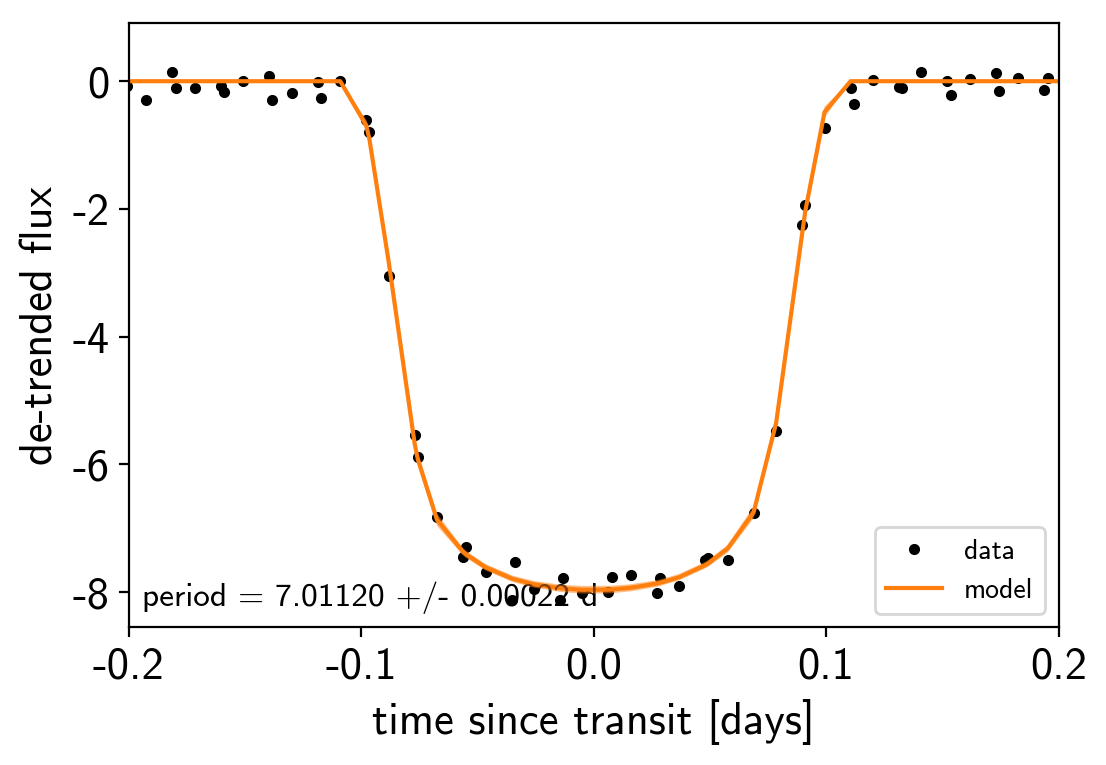

In [17]:
# Compute the GP prediction
gp_mod = np.median(trace["gp_pred"] + trace["mean"][:, None], axis=0)

# Get the posterior median orbital parameters
p = np.median(trace["period"])
t0 = np.median(trace["t0"])

# Plot the folded data
x_fold = (x[mask] - t0 + 0.5*p) % p - 0.5*p
plt.plot(x_fold, y[mask] - gp_mod, ".k", label="data", zorder=-1000)

# Plot the folded model
inds = np.argsort(x_fold)
inds = inds[np.abs(x_fold)[inds] < 0.3]
pred = trace["light_curves"][:, inds, 0]
pred = np.percentile(pred, [16, 50, 84], axis=0)
plt.plot(x_fold[inds], pred[1], color="C1", label="model")
art = plt.fill_between(x_fold[inds], pred[0], pred[2], color="C1", alpha=0.5,
                       zorder=1000)
art.set_edgecolor("none")

# Annotate the plot with the planet's period
txt = "period = {0:.5f} +/- {1:.5f} d".format(
    np.mean(trace["period"]), np.std(trace["period"]))
plt.annotate(txt, (0, 0), xycoords="axes fraction",
             xytext=(5, 5), textcoords="offset points",
             ha="left", va="bottom", fontsize=12)

plt.legend(fontsize=10, loc=4)
plt.xlim(-0.5*p, 0.5*p)
plt.xlabel("time since transit [days]")
plt.ylabel("de-trended flux")
plt.xlim(-0.2, 0.2);

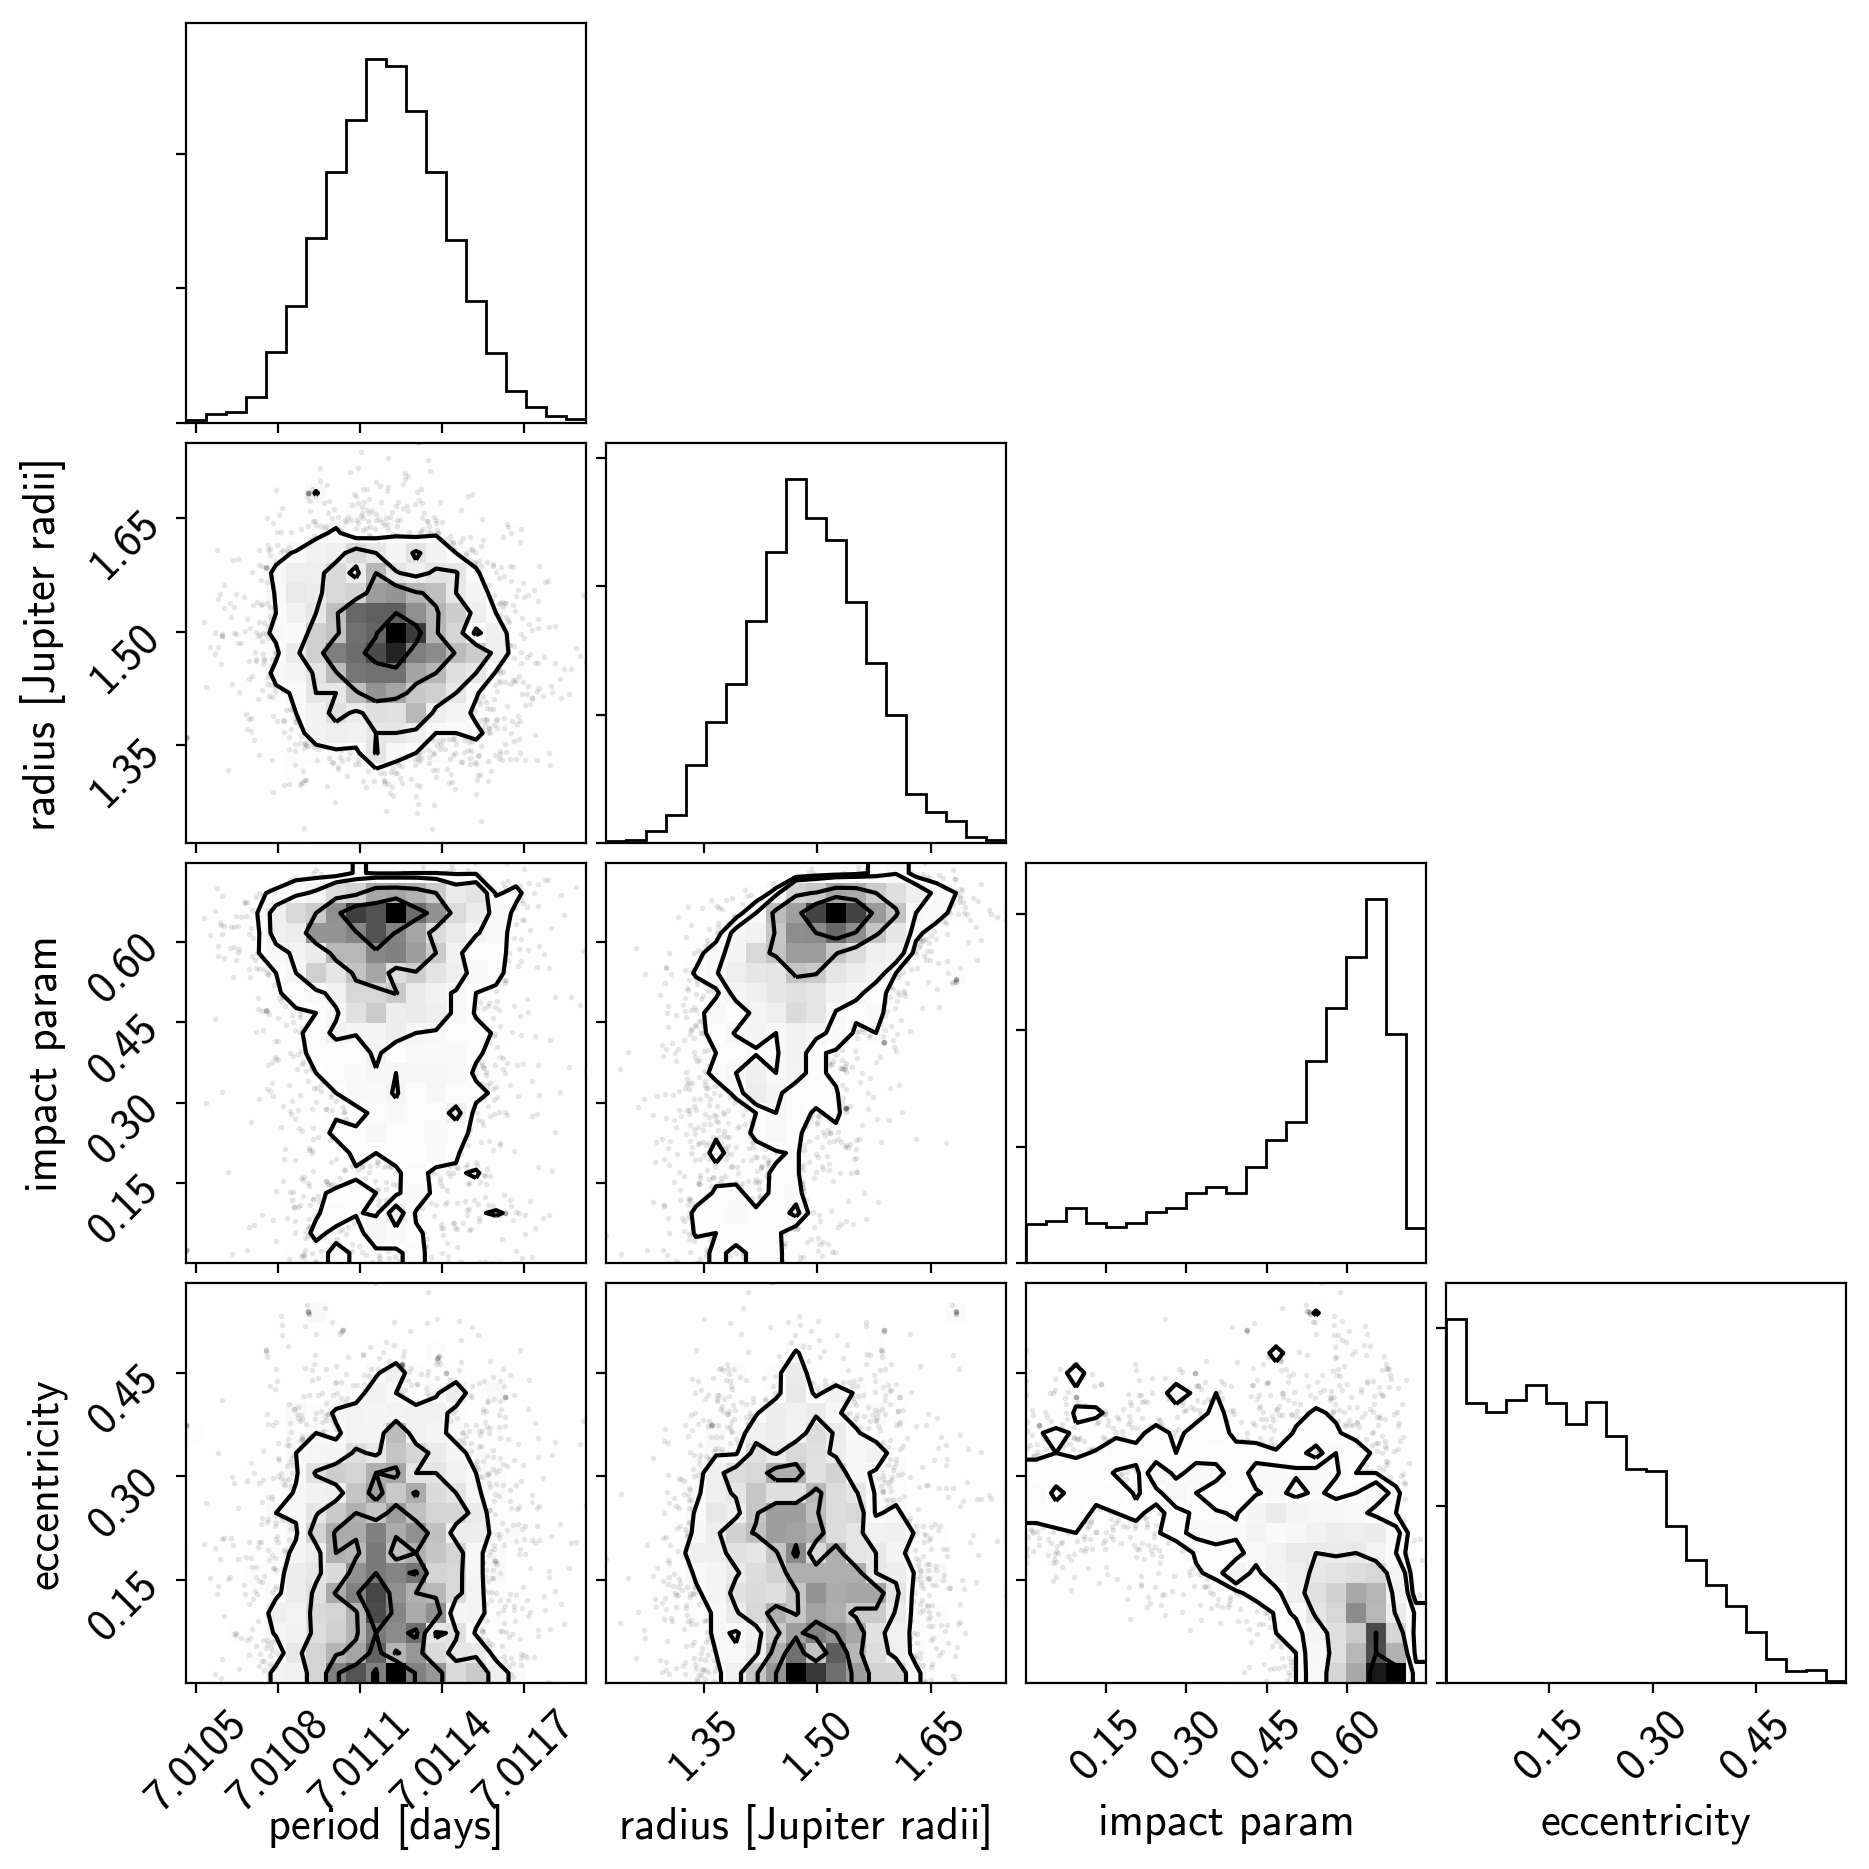

In [18]:
import corner
import astropy.units as u
varnames = ["period", "b", "ecc", "r_pl"]
samples = pm.trace_to_dataframe(trace, varnames=varnames)

# Convert the radius to Earth radii
samples["r_pl"] = (np.array(samples["r_pl"]) * u.R_sun).to(u.R_jupiter).value

corner.corner(
    samples[["period", "r_pl", "b", "ecc"]],
    labels=["period [days]", "radius [Jupiter radii]", "impact param", "eccentricity"]);

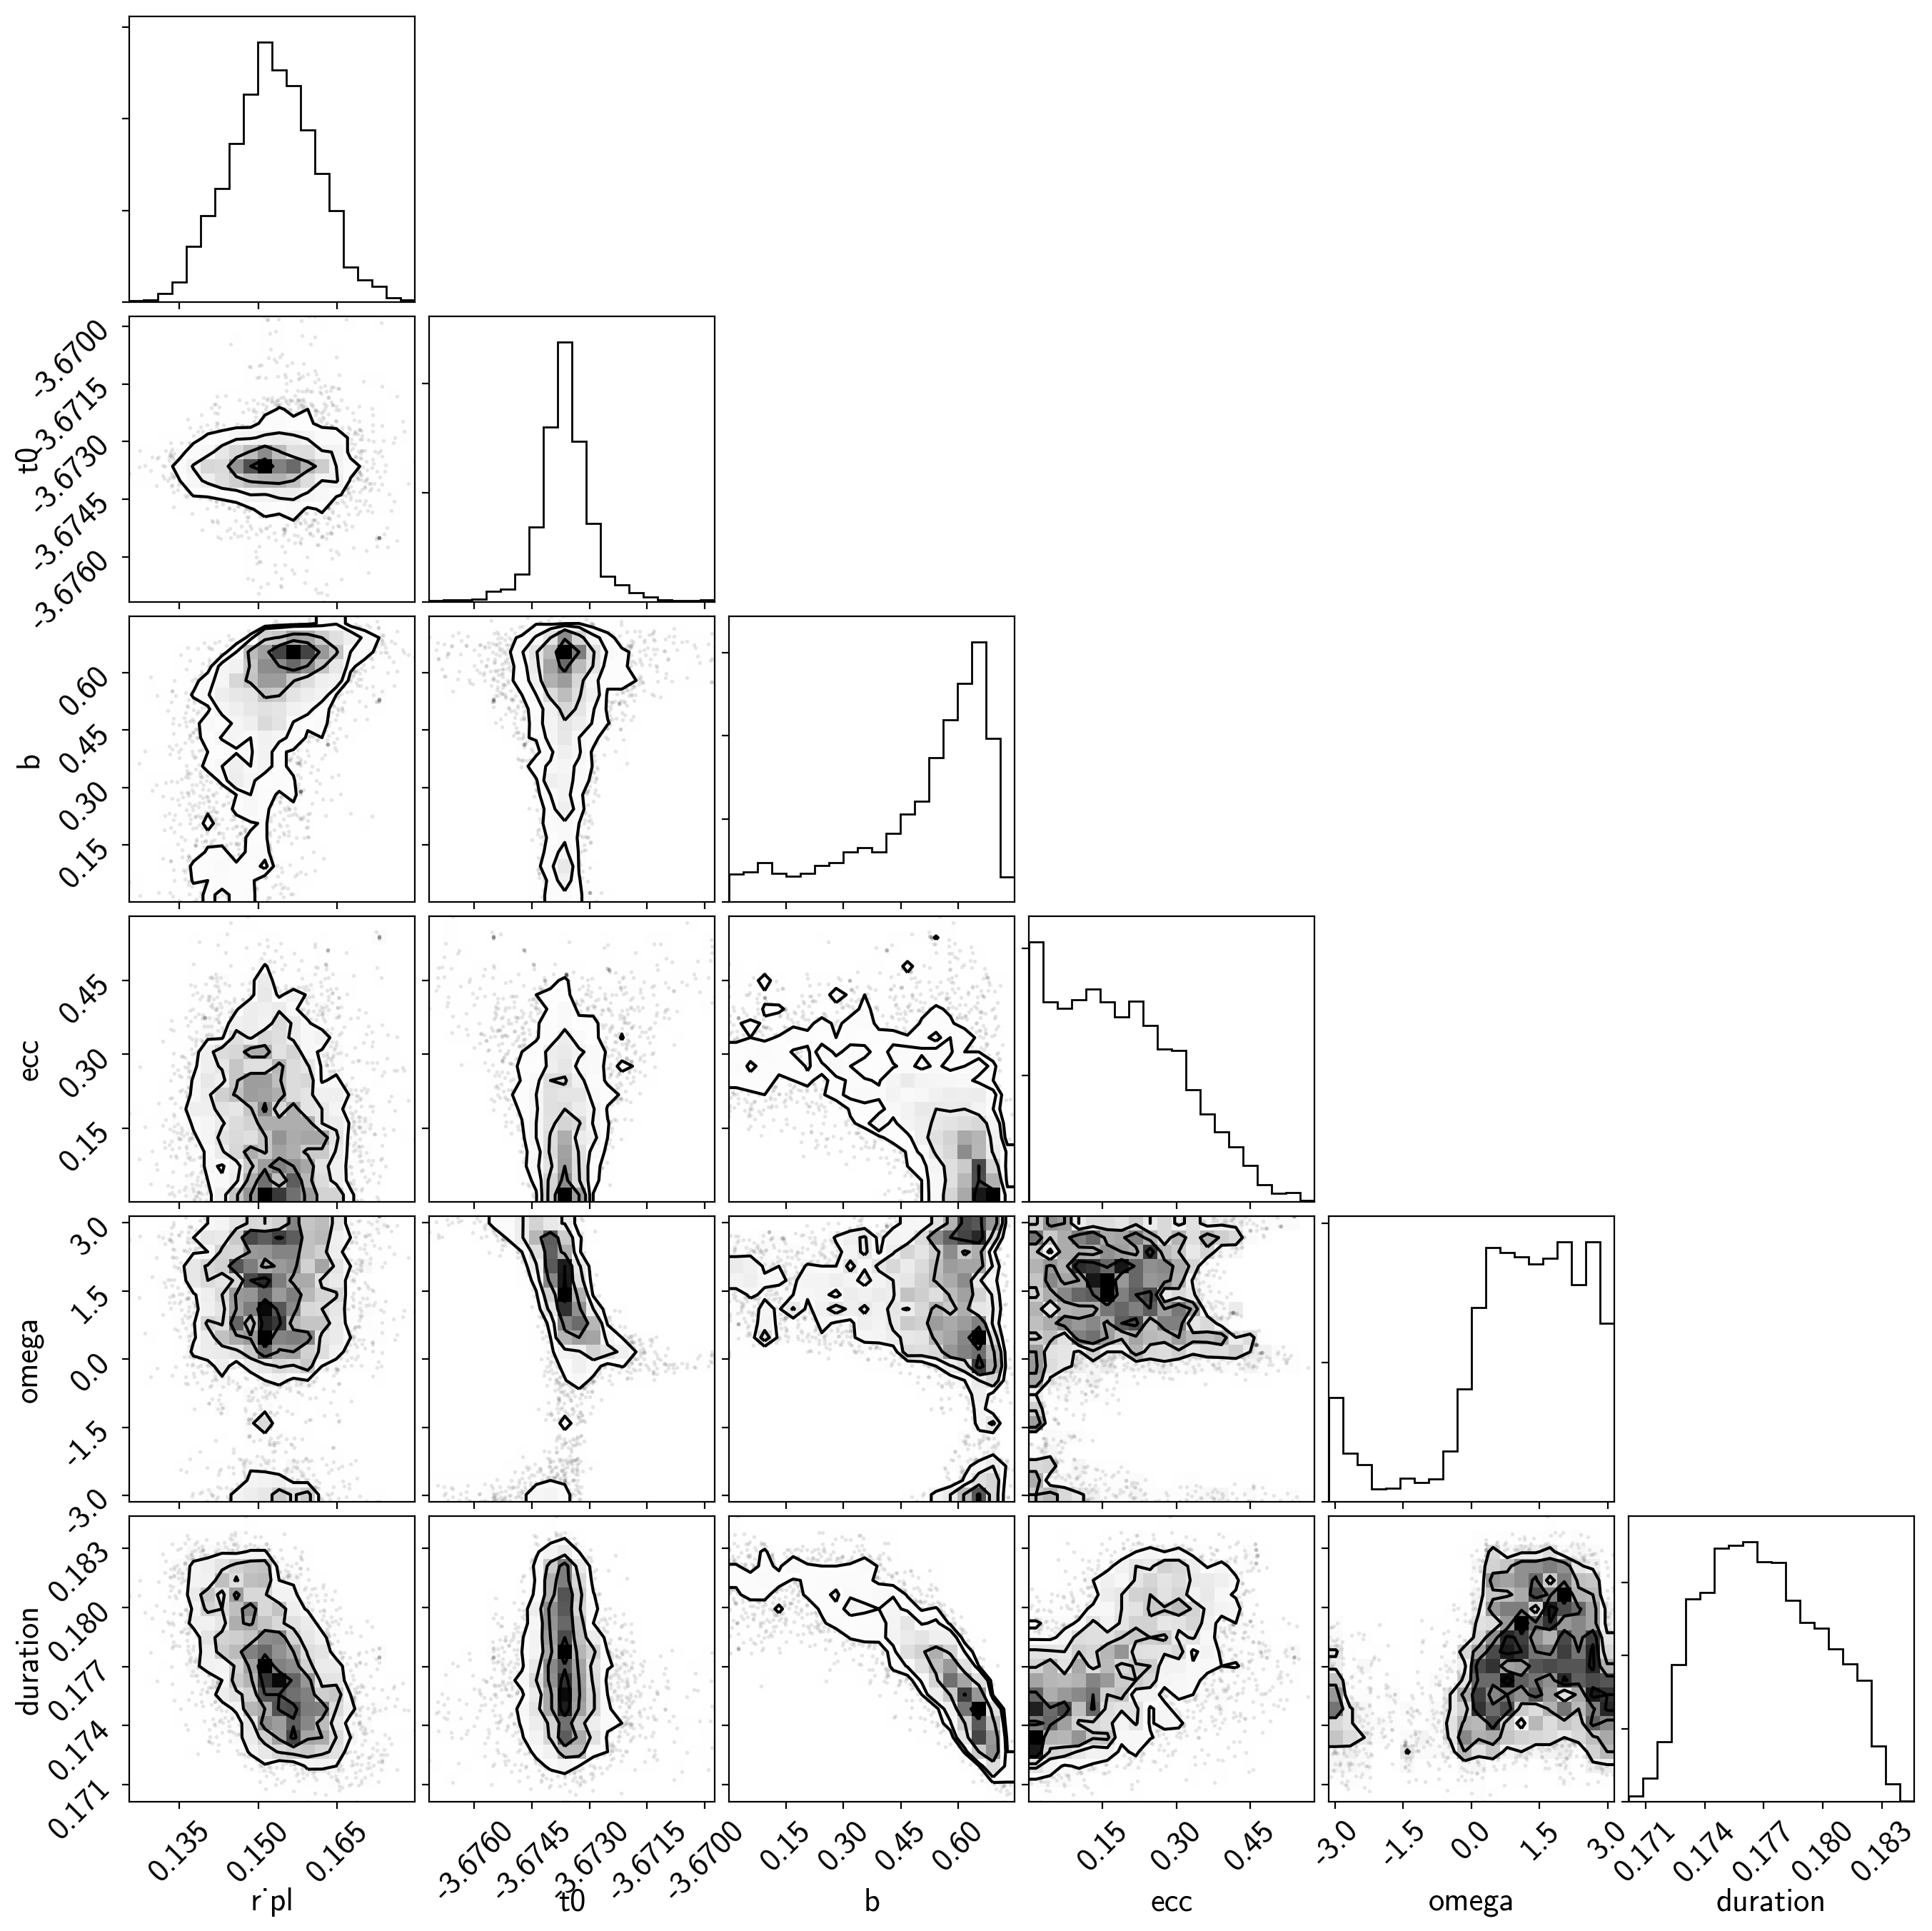

In [19]:
aor = -trace["a"] / trace["r_star"]
e = trace["ecc"]
w = trace["omega"]
i = trace["incl"]
b = trace["b"]
k = trace["r_pl"] / trace["r_star"]
P = trace["period"]

T_tot = P/np.pi * np.arcsin(np.sqrt(1 - b**2) / np.sin(i) / aor)
dur = T_tot * np.sqrt(1 - e**2) / (1 + e * np.sin(w))

samples = pm.trace_to_dataframe(trace, varnames=["r_pl", "t0", "b", "ecc", "omega"])
samples["duration"] = dur
corner.corner(samples);